In [1]:
!pip install seaborn
!pip install torch
!pip install torchvision
!pip install scikit-learn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install timm


     |████████████████████████████████| 549 kB 17.2 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 814 kB/s  eta 0:00:01
     |████████████████████████████████| 677 kB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 1.4 MB/s  eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.8
    Uninstalling packaging-20.8:
      Successfully uninstalled packaging-20.8
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
import os
import sys

In [4]:
import torch
import torch.nn as nn
import timm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os

# --- CONFIGURAÇÃO ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DEFINIR A CLASSE DO MODELO ---
class ConvNeXtSingleFrame(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        base_model = timm.create_model('convnext_base', pretrained=True, num_classes=0)  # remove head
        self.backbone = base_model
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        return self.fc(x)

# --- CAMINHO E TRANSFORMAÇÕES ---
TEST_DIR = "./face_extraction/faceforensis_face_extract/test/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = test_dataset.classes
num_classes = len(class_names)

# --- CARREGAR O MODELO ---
model = ConvNeXtSingleFrame(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("best_model_convnext_v2.pth", map_location=device))
model.eval()

# --- AVALIAÇÃO ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# --- RELATÓRIO DE CLASSIFICAÇÃO ---
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names))


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


                   precision    recall  f1-score   support

DeepFakeDetection       1.00      0.91      0.95      1000
      FaceShifter       0.92      0.74      0.82      1000
         FaceSwap       0.94      0.63      0.75      1000
    NeuraTextures       0.82      0.65      0.73      1000
        deepfakes       0.98      0.64      0.78       999
        face2face       0.99      0.78      0.87      1000
         original       0.40      0.94      0.56      1000

         accuracy                           0.76      6999
        macro avg       0.86      0.76      0.78      6999
     weighted avg       0.86      0.76      0.78      6999



In [5]:
!pip install captum

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


✅ Figura salva como 'explicabilidade_grid_convnext.png'


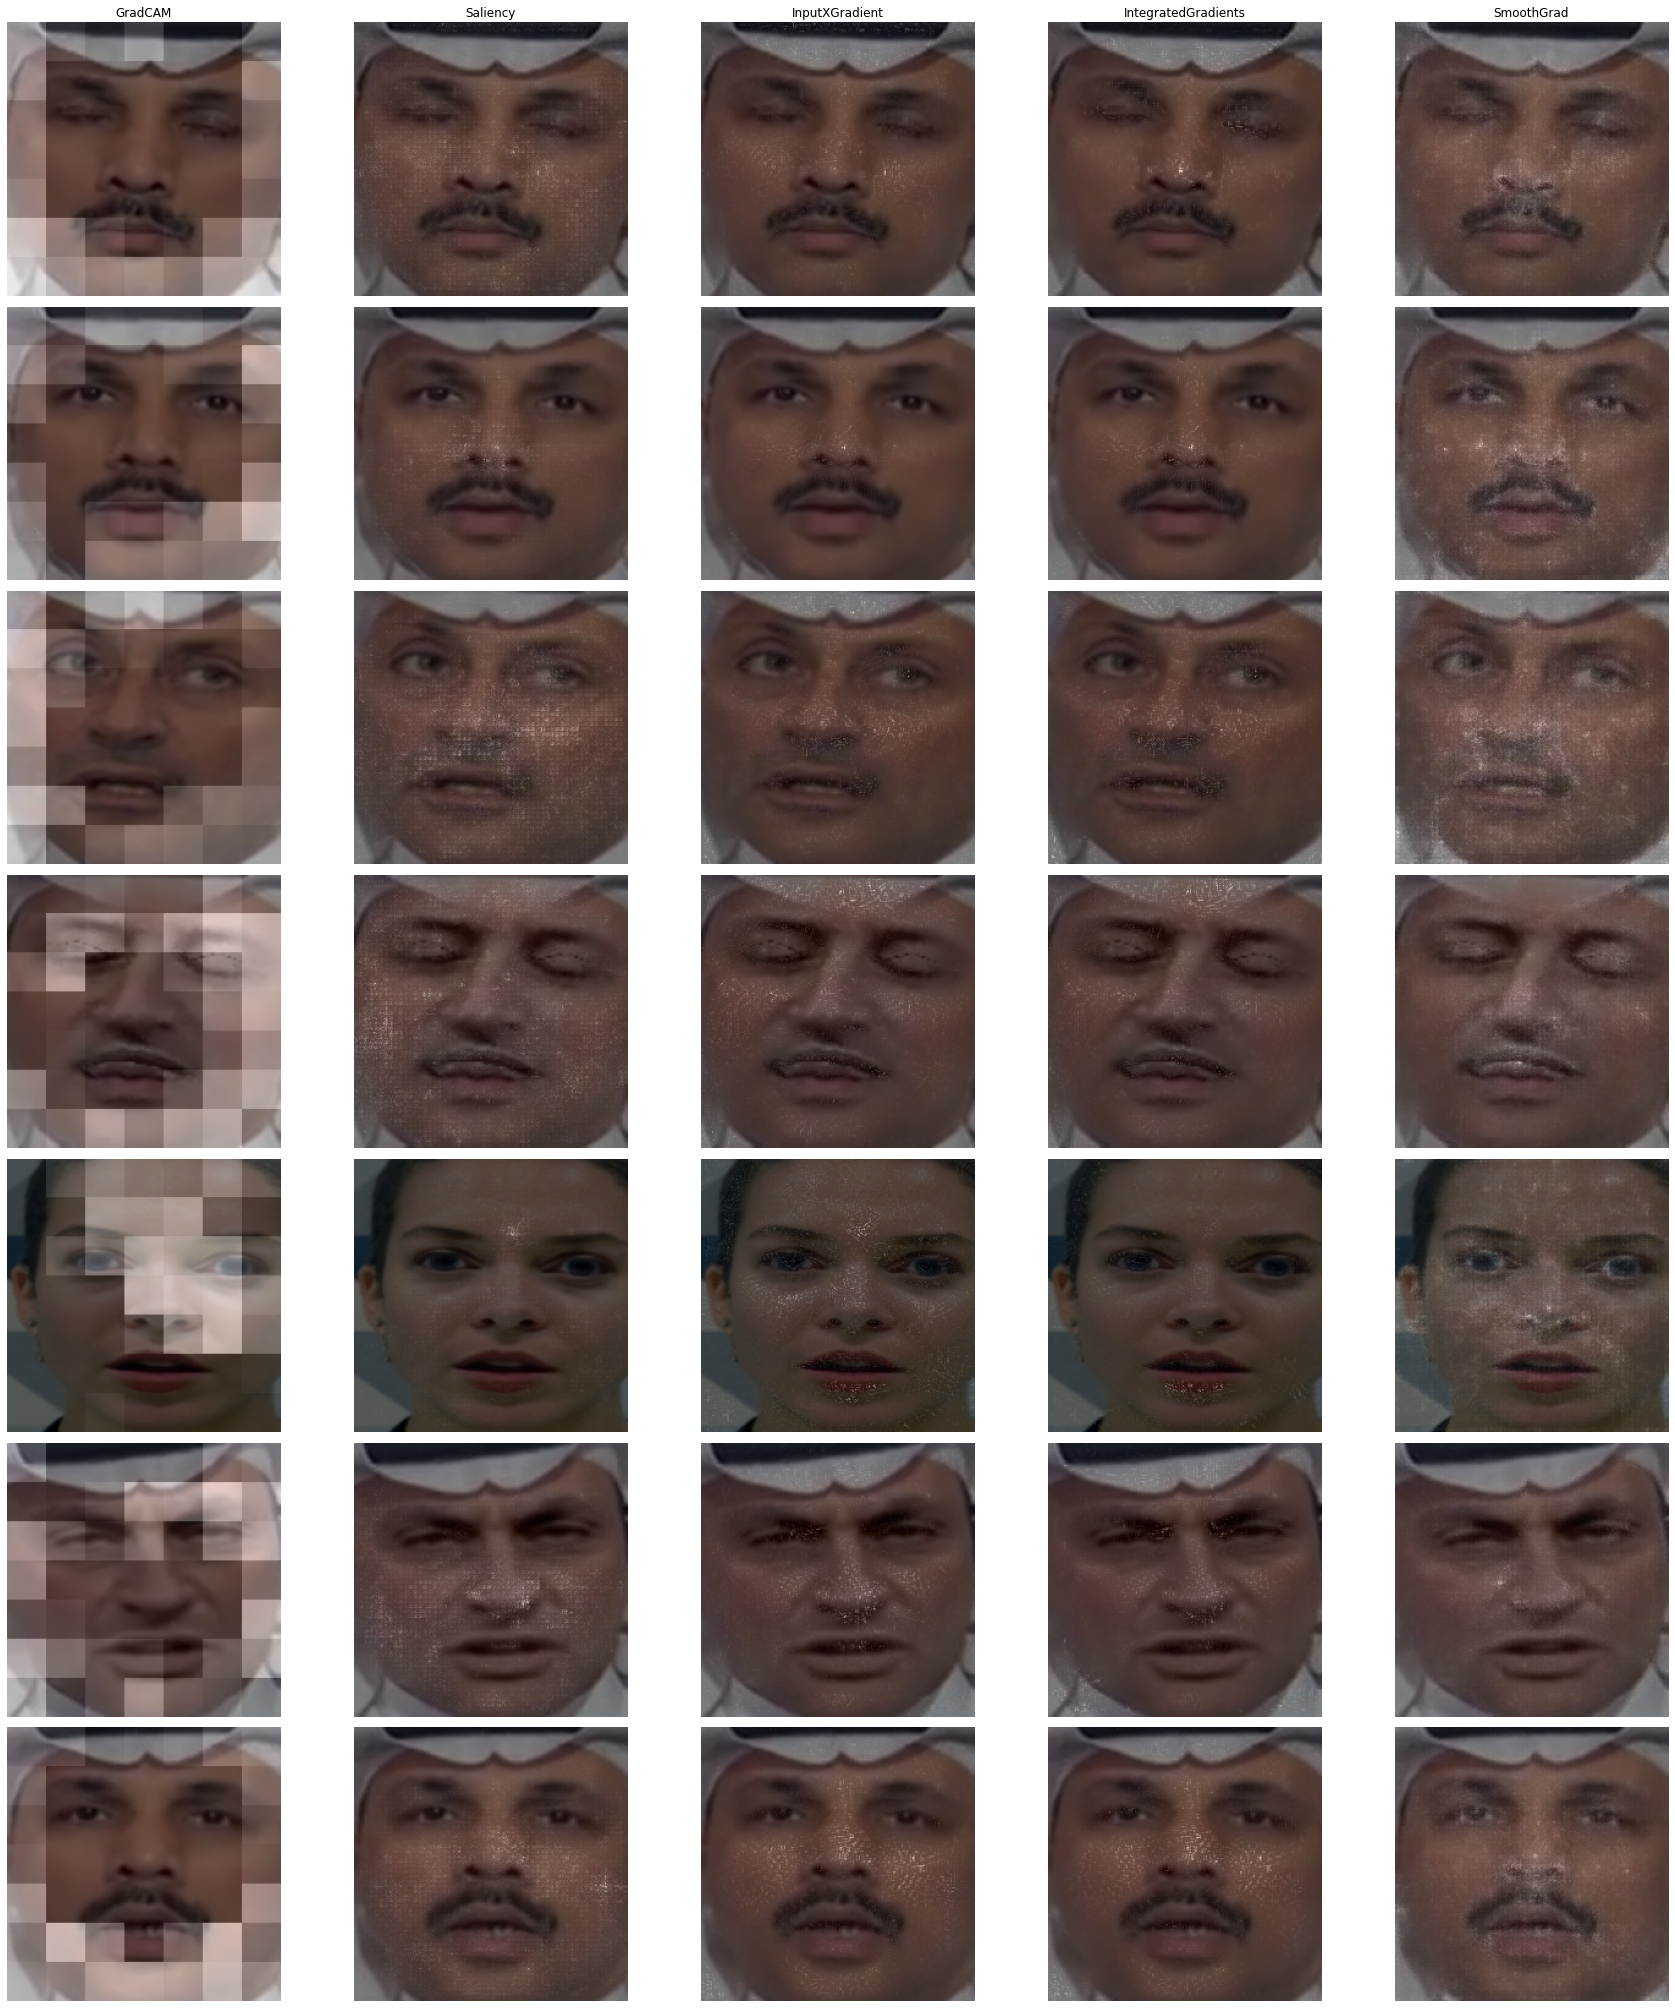

In [21]:
from PIL import Image
from captum.attr import LayerGradCam, Saliency, IntegratedGradients, InputXGradient
from captum.attr import LayerAttribution
from captum.attr import NoiseTunnel
    
def load_image_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    img_tensor.requires_grad_()  # Adicionado para evitar o warning do Captum
    img_np = np.array(img.resize((224, 224))).astype(np.float32) / 255.0
    return img_tensor, img_np

def normalize_attr(attr):
    attr = np.maximum(attr, 0)
    if np.max(attr) > 0:
        attr = attr / np.max(attr)
    return np.stack([attr] * 3, axis=-1)

def generate_visualizations(model, img_tensor, img_np, label):
    torch.cuda.empty_cache()  # liberação ativa

    target_layer = list(model.backbone.stages[-1].children())[-1]
    
    gradcam = LayerGradCam(model, target_layer)
    gradcam_attr = gradcam.attribute(img_tensor, target=label)
    gradcam_attr = LayerAttribution.interpolate(gradcam_attr, (224, 224))
    gradcam_attr = gradcam_attr.squeeze().detach().cpu().numpy()

    saliency = Saliency(model)
    saliency_attr = saliency.attribute(img_tensor, target=label)
    saliency_attr = saliency_attr.squeeze().abs().detach().cpu().numpy().mean(axis=0)

    inputxgrad = InputXGradient(model)
    inputxgrad_attr = inputxgrad.attribute(img_tensor, target=label)
    inputxgrad_attr = inputxgrad_attr.squeeze().detach().cpu().numpy().mean(axis=0)

    integrated = IntegratedGradients(model)
    integrated_attr = integrated.attribute(img_tensor, target=label, n_steps=5)
    integrated_attr = integrated_attr.squeeze().detach().cpu().numpy().mean(axis=0)

    smoothgrad = NoiseTunnel(saliency)
    smoothgrad_attr = smoothgrad.attribute(img_tensor, nt_type="smoothgrad", target=label)
    smoothgrad_attr = smoothgrad_attr.squeeze().detach().cpu().numpy().mean(axis=0)

    vis = []
    for attr in [gradcam_attr, saliency_attr, inputxgrad_attr, integrated_attr, smoothgrad_attr]:
        blended = np.clip(img_np * 0.5 + normalize_attr(attr) * 0.5, 0, 1)
        vis.append(blended)

    torch.cuda.empty_cache()  # libera ao final também
    return vis




# Classes e imagens
image_groups = {
    "ORIGINAL": [
        "./face_extraction/faceforensis_face_extract/train/original/original_000_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/original/original_004_frame2.png",
        "./face_extraction/faceforensis_face_extract/train/original/original_006_frame1.png",
        "./face_extraction/faceforensis_face_extract/train/original/original_011_frame4.png",
        "./face_extraction/faceforensis_face_extract/train/original/original_018_frame3.png",
    ],
    "FACE2FACE": [
        "./face_extraction/faceforensis_face_extract/train/face2face/Face2Face_000_003_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/face2face/Face2Face_002_006_frame3.png",
        "./face_extraction/faceforensis_face_extract/train/face2face/Face2Face_006_002_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/face2face/Face2Face_010_005_frame3.png",
        "./face_extraction/faceforensis_face_extract/train/face2face/Face2Face_017_803_frame3.png",
    ],
    "FACESHIFTER": [
        "./face_extraction/faceforensis_face_extract/train/FaceShifter/FaceShifter_000_003_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/FaceShifter/FaceShifter_002_006_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/FaceShifter/FaceShifter_006_002_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/FaceShifter/FaceShifter_010_005_frame3.png",
        "./face_extraction/faceforensis_face_extract/train/FaceShifter/FaceShifter_017_803_frame3.png",
    ],
    "FACESWAP": [
        "./face_extraction/faceforensis_face_extract/train/FaceSwap/FaceSwap_000_003_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/FaceSwap/FaceSwap_002_006_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/FaceSwap/FaceSwap_006_002_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/FaceSwap/FaceSwap_010_005_frame3.png",
        "./face_extraction/faceforensis_face_extract/train/FaceSwap/FaceSwap_017_803_frame3.png",
    ],
    "DEEPFAKEDETECTION": [
        "./face_extraction/faceforensis_face_extract/train/DeepFakeDetection/DeepFakeDetection_01_02__talking_against_wall__YVGY8LOK_frame4.png",
        "./face_extraction/faceforensis_face_extract/train/DeepFakeDetection/DeepFakeDetection_01_04__talking_angry_couch__0XUW13RW_frame3.png",
        "./face_extraction/faceforensis_face_extract/train/DeepFakeDetection/DeepFakeDetection_01_15__kitchen_still__02HILKYO_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/DeepFakeDetection/DeepFakeDetection_01_21__walk_down_hall_angry__03X7CELV_frame1.png",
        "./face_extraction/faceforensis_face_extract/train/DeepFakeDetection/DeepFakeDetection_01_27__meeting_serious__ZYCZ30C0_frame3.png",
    ],
    "DEEPFAKES": [
        "./face_extraction/faceforensis_face_extract/train/deepfakes/Deepfakes_000_003_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/deepfakes/Deepfakes_002_006_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/deepfakes/Deepfakes_006_002_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/deepfakes/Deepfakes_010_005_frame3.png",
        "./face_extraction/faceforensis_face_extract/train/deepfakes/Deepfakes_017_803_frame3.png",
    ],
    "NEURALTEXTURES": [
        "./face_extraction/faceforensis_face_extract/train/NeuraTextures/NeuralTextures_000_003_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/NeuraTextures/NeuralTextures_002_006_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/NeuraTextures/NeuralTextures_006_002_frame5.png",
        "./face_extraction/faceforensis_face_extract/train/NeuraTextures/NeuralTextures_010_005_frame3.png",
        "./face_extraction/faceforensis_face_extract/train/NeuraTextures/NeuralTextures_017_803_frame3.png",
    ],
}

def show_explanations_grid():
    techniques = ["GradCAM", "Saliency", "InputXGradient", "IntegratedGradients", "SmoothGrad"]
    fig, axs = plt.subplots(len(image_groups), len(techniques), figsize=(5*len(techniques), 4*len(image_groups)))
    for row_idx, (label, image_list) in enumerate(image_groups.items()):
        img_tensor, img_np = load_image_tensor(image_list[0])  # primeira imagem da classe
        img_tensor = img_tensor.to(device)
        pred = torch.argmax(torch.nn.functional.softmax(model(img_tensor), dim=1)).item()
        vis_list = generate_visualizations(model, img_tensor, img_np, pred)
        for col_idx, vis in enumerate(vis_list):
            axs[row_idx, col_idx].imshow(vis)
            axs[row_idx, col_idx].axis('off')
            if row_idx == 0:
                axs[row_idx, col_idx].set_title(techniques[col_idx], fontsize=12)
            if col_idx == 0:
                axs[row_idx, col_idx].set_ylabel(label, fontsize=12)
                
        del img_tensor, vis_list
        torch.cuda.empty_cache()
    plt.tight_layout()
    plt.savefig("explicabilidade_grid_convnext.png")  # Salva o resultado como imagem
    print("✅ Figura salva como 'explicabilidade_grid_convnext.png'")
    plt.show(block=True)

# Executar
if __name__ == "__main__":
    show_explanations_grid()

In [6]:
!pip install pandas scikit-learn matplotlib seaborn openpyxl joblib xlrd

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
pip install scikit-image


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
from skimage.segmentation import slic
from scipy.stats import entropy
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from captum.attr import IntegratedGradients, Saliency, InputXGradient, NoiseTunnel
from skimage.transform import resize
import gc


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = "./face_extraction/faceforensis_face_extract/test/"
class_names = ["DeepFakeDetection", "FaceShifter", "FaceSwap", "NeuraTextures", "deepfakes", "face2face", "original"]
explic_methods = ["Saliency", "InputXGradient", "IntegratedGradients", "SmoothGrad", "GradCAM"]

print("Iniciando.")


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ajuste para ConvNeXt
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(DEVICE)
    np_img = np.array(image.resize((224, 224))) / 255.0
    return tensor, np_img

def make_gradcam(model, img_tensor, target_layer='backbone.stages.3.blocks.2.conv_dw'):
    gradients, activations = [], []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_module = dict(model.named_modules())[target_layer]

    fh = target_module.register_forward_hook(forward_hook)
    bh = target_module.register_full_backward_hook(backward_hook)

    img_tensor.requires_grad_(True)
    output = model(img_tensor)
    class_idx = torch.argmax(output)
    loss = output[0, class_idx]
    model.zero_grad()
    loss.backward()

    grad = gradients[0]
    act = activations[0]
    pooled_grad = torch.mean(grad, dim=[0, 2, 3])
    for i in range(act.shape[1]):
        act[:, i, :, :] *= pooled_grad[i]
    heatmap = act.mean(dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-12)

    fh.remove()
    bh.remove()
    return heatmap

def get_saliency_map(method, model, input_tensor, target_idx):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)

    if method == "Saliency":
        explainer = Saliency(model)
        attributions = explainer.attribute(input_tensor, target=target_idx)
    elif method == "InputXGradient":
        explainer = InputXGradient(model)
        attributions = explainer.attribute(input_tensor, target=target_idx)
    elif method == "IntegratedGradients":
        explainer = IntegratedGradients(model)
        attributions = explainer.attribute(input_tensor, target=target_idx, n_steps=10, internal_batch_size=5)
    elif method == "SmoothGrad":
        saliency = Saliency(model)
        explainer = NoiseTunnel(saliency)
        attributions = explainer.attribute(input_tensor, nt_type='smoothgrad', nt_samples=15, target=target_idx)
    elif method == "GradCAM":
        cam = make_gradcam(model, input_tensor)
        cam_resized = resize(cam, (224, 224), mode='reflect', anti_aliasing=True)
        return cam_resized
    else:
        raise ValueError(f"Método {method} desconhecido.")

    attr_np = attributions.detach().cpu().numpy().squeeze()
    attr_np = np.abs(attr_np).sum(axis=0)
    attr_np = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min() + 1e-12)
    return attr_np

def salience_entropy(smap):
    smap = smap / (np.sum(smap) + 1e-12)
    return entropy(smap.flatten() + 1e-12)

def reaction_to_noise(model, img_tensor, salmap):
    noisy = img_tensor + torch.normal(0, 0.05, img_tensor.shape).to(DEVICE)
    output = model(noisy)
    target_idx = torch.argmax(output).item()
    noisy_salmap = get_saliency_map("GradCAM", model, noisy, target_idx)
    
    # Redimensiona o mapa ruidoso para o tamanho do original
    noisy_salmap_resized = resize(noisy_salmap, salmap.shape, mode='reflect', anti_aliasing=True)
    
    return np.mean(np.abs(salmap - noisy_salmap_resized))

def geometrical_robustness(model, raw_img, salmap):
    flipped = np.flip(raw_img, axis=1).copy()  # flip horizontal
    flipped_tensor = torch.from_numpy(flipped.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE)
    flipped_tensor.requires_grad_(True)

    output = model(flipped_tensor)
    target_idx = torch.argmax(output).item()
    flipped_salmap = get_saliency_map("GradCAM", model, flipped_tensor, target_idx)

    # Redimensiona para o shape original do mapa
    flipped_salmap_resized = resize(flipped_salmap, salmap.shape, mode='reflect', anti_aliasing=True)

    return np.mean(np.abs(salmap - flipped_salmap_resized))

def accuracy_over_segmentation(model, image, saliency_map, segments=50):
    salmap_resized = resize(saliency_map, (image.shape[0], image.shape[1]), mode='reflect', anti_aliasing=True)
    img_uint8 = (image * 255).astype(np.uint8)
    segs = slic(img_uint8, n_segments=segments, compactness=20, enforce_connectivity=True, start_label=0)
    relevance = np.array([np.mean(salmap_resized[segs == i]) for i in range(np.max(segs) + 1)])
    top_k = np.argsort(relevance)[-int(segments * 0.2):]
    mask = np.isin(segs, top_k).astype(np.float32)
    if mask.ndim == 2:
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    degraded = image * (1 - mask)
    with torch.no_grad():
        orig_pred = model(torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE))[0]
        degr_pred = model(torch.from_numpy(degraded.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE))[0]
    return np.abs(orig_pred.cpu().numpy() - degr_pred.cpu().numpy()).mean(), segs

print("Modelo carregado com sucesso.")

image_files = []
image_labels = []
for folder in class_names:
    folder_path = os.path.join(DATASET_ROOT, folder)
    files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
    for f in files:
        image_files.append(os.path.join(folder_path, f))
        image_labels.append(folder)


resultados = []
n_rows = len(image_files)
n_cols = len(explic_methods) + 1

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

for row, (path, label) in enumerate(zip(image_files, image_labels)):
    img_tensor, raw_img = preprocess_image(path)
    output = model(img_tensor)
    pred_idx = torch.argmax(output, dim=1).item()

    for col, method in enumerate(explic_methods, start=1):
        salmap = get_saliency_map(method, model, img_tensor, pred_idx)
        entropy_val = salience_entropy(salmap)
        noise_val = reaction_to_noise(model, img_tensor, salmap)
        geo_val = geometrical_robustness(model, raw_img, salmap)
        aos_val, _ = accuracy_over_segmentation(model, raw_img, salmap)

        resultado = {
            "imagem": os.path.basename(path),
            "classe_real": label,
            "classe_predita": class_names[pred_idx],
            "metodo_explicabilidade": method,
            "entropia": entropy_val,
            "ruido": noise_val,
            "geo": geo_val,
            "aos": aos_val
        }
        resultados.append(resultado)

        print(f"[{row+1}/{n_rows}] Imagem: {os.path.basename(path)} | Técnica: {method} | Entropia: {entropy_val:.4f} | Ruído: {noise_val:.4f} | Geo: {geo_val:.4f} | AOS: {aos_val:.4f}")

    del img_tensor, raw_img, output
    torch.cuda.empty_cache()
    gc.collect()



#plt.tight_layout()
#plt.savefig("grid_explicabilidade_todas_imagens.png", dpi=300)
#print("Grid salvo como grid_explicabilidade_todas_imagens.png")

df_resultados = pd.DataFrame(resultados)
df_resultados.to_excel("resultados_explicabilidade_todas_imagens_inception.xlsx", index=False)
print("Planilha salva como resultados_explicabilidade_todas_imagens_inception.xlsx")

Iniciando.
Modelo carregado com sucesso.
[1/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame1.png | Técnica: Saliency | Entropia: 10.5255 | Ruído: 0.3997 | Geo: 0.4866 | AOS: 1.3479
[1/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame1.png | Técnica: InputXGradient | Entropia: 10.3997 | Ruído: 0.4020 | Geo: 0.4752 | AOS: 1.4047
[1/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3843 | Ruído: 0.3876 | Geo: 0.4793 | AOS: 1.5594
[1/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame1.png | Técnica: SmoothGrad | Entropia: 10.6100 | Ruído: 0.3650 | Geo: 0.4011 | AOS: 1.7272
[1/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame1.png | Técnica: GradCAM | Entropia: 10.4300 | Ruído: 0.2342 | Geo: 0.3348 | AOS: 1.6131
[2/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame2.png | Técnica: Saliency | Entropia: 10.5158 | Ruído

[10/6999] Imagem: DeepFakeDetection_01_03__talking_against_wall__JZUXXFRB_frame5.png | Técnica: GradCAM | Entropia: 9.9228 | Ruído: 0.2500 | Geo: 0.3866 | AOS: 1.8374
[11/6999] Imagem: DeepFakeDetection_01_04__meeting_serious__0XUW13RW_frame1.png | Técnica: Saliency | Entropia: 10.5387 | Ruído: 0.1593 | Geo: 0.4706 | AOS: 1.3387
[11/6999] Imagem: DeepFakeDetection_01_04__meeting_serious__0XUW13RW_frame1.png | Técnica: InputXGradient | Entropia: 10.3981 | Ruído: 0.1772 | Geo: 0.4826 | AOS: 1.0263
[11/6999] Imagem: DeepFakeDetection_01_04__meeting_serious__0XUW13RW_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4216 | Ruído: 0.1930 | Geo: 0.4882 | AOS: 2.2925
[11/6999] Imagem: DeepFakeDetection_01_04__meeting_serious__0XUW13RW_frame1.png | Técnica: SmoothGrad | Entropia: 10.6522 | Ruído: 0.1432 | Geo: 0.3426 | AOS: 2.1350
[11/6999] Imagem: DeepFakeDetection_01_04__meeting_serious__0XUW13RW_frame1.png | Técnica: GradCAM | Entropia: 9.5922 | Ruído: 0.1264 | Geo: 0.4244 | AOS: 1.9

[20/6999] Imagem: DeepFakeDetection_01_09__talking_angry_couch__P70H1JB0_frame5.png | Técnica: SmoothGrad | Entropia: 10.6397 | Ruído: 0.1759 | Geo: 0.2267 | AOS: 2.6773
[20/6999] Imagem: DeepFakeDetection_01_09__talking_angry_couch__P70H1JB0_frame5.png | Técnica: GradCAM | Entropia: 10.2100 | Ruído: 0.1408 | Geo: 0.1779 | AOS: 2.4197
[21/6999] Imagem: DeepFakeDetection_01_11__meeting_serious__FCNL2OVP_frame1.png | Técnica: Saliency | Entropia: 10.5066 | Ruído: 0.1131 | Geo: 0.2918 | AOS: 1.8197
[21/6999] Imagem: DeepFakeDetection_01_11__meeting_serious__FCNL2OVP_frame1.png | Técnica: InputXGradient | Entropia: 10.3895 | Ruído: 0.1220 | Geo: 0.3075 | AOS: 1.1023
[21/6999] Imagem: DeepFakeDetection_01_11__meeting_serious__FCNL2OVP_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4071 | Ruído: 0.1204 | Geo: 0.3044 | AOS: 1.5684
[21/6999] Imagem: DeepFakeDetection_01_11__meeting_serious__FCNL2OVP_frame1.png | Técnica: SmoothGrad | Entropia: 10.6382 | Ruído: 0.1126 | Geo: 0.2104 | 

[30/6999] Imagem: DeepFakeDetection_01_11__outside_talking_pan_laughing__WIZ7GKOD_frame5.png | Técnica: InputXGradient | Entropia: 10.3126 | Ruído: 0.2365 | Geo: 0.4092 | AOS: 3.3809
[30/6999] Imagem: DeepFakeDetection_01_11__outside_talking_pan_laughing__WIZ7GKOD_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3458 | Ruído: 0.2987 | Geo: 0.4118 | AOS: 2.4889
[30/6999] Imagem: DeepFakeDetection_01_11__outside_talking_pan_laughing__WIZ7GKOD_frame5.png | Técnica: SmoothGrad | Entropia: 10.6745 | Ruído: 0.1894 | Geo: 0.2851 | AOS: 3.0157
[30/6999] Imagem: DeepFakeDetection_01_11__outside_talking_pan_laughing__WIZ7GKOD_frame5.png | Técnica: GradCAM | Entropia: 9.3078 | Ruído: 0.1505 | Geo: 0.3832 | AOS: 2.0312
[31/6999] Imagem: DeepFakeDetection_01_12__outside_talking_still_laughing__TNI7KUZ6_frame1.png | Técnica: Saliency | Entropia: 10.4720 | Ruído: 0.4087 | Geo: 0.5455 | AOS: 0.5017
[31/6999] Imagem: DeepFakeDetection_01_12__outside_talking_still_laughing__TNI7KUZ6_frame1.png |

[39/6999] Imagem: DeepFakeDetection_01_15__outside_talking_pan_laughing__02HILKYO_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3069 | Ruído: 0.3612 | Geo: 0.5051 | AOS: 3.1251
[39/6999] Imagem: DeepFakeDetection_01_15__outside_talking_pan_laughing__02HILKYO_frame4.png | Técnica: SmoothGrad | Entropia: 10.6993 | Ruído: 0.2345 | Geo: 0.3617 | AOS: 2.4381
[39/6999] Imagem: DeepFakeDetection_01_15__outside_talking_pan_laughing__02HILKYO_frame4.png | Técnica: GradCAM | Entropia: 10.4965 | Ruído: 0.1017 | Geo: 0.2140 | AOS: 2.0850
[40/6999] Imagem: DeepFakeDetection_01_15__outside_talking_pan_laughing__02HILKYO_frame5.png | Técnica: Saliency | Entropia: 10.4977 | Ruído: 0.4108 | Geo: 0.5689 | AOS: 0.5931
[40/6999] Imagem: DeepFakeDetection_01_15__outside_talking_pan_laughing__02HILKYO_frame5.png | Técnica: InputXGradient | Entropia: 10.4297 | Ruído: 0.4124 | Geo: 0.5661 | AOS: 1.1306
[40/6999] Imagem: DeepFakeDetection_01_15__outside_talking_pan_laughing__02HILKYO_frame5.png | Té

[49/6999] Imagem: DeepFakeDetection_01_20__walk_down_hall_angry__FW94AIMJ_frame4.png | Técnica: InputXGradient | Entropia: 10.4364 | Ruído: 0.1681 | Geo: 0.2197 | AOS: 1.4505
[49/6999] Imagem: DeepFakeDetection_01_20__walk_down_hall_angry__FW94AIMJ_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4472 | Ruído: 0.1843 | Geo: 0.2234 | AOS: 1.6208
[49/6999] Imagem: DeepFakeDetection_01_20__walk_down_hall_angry__FW94AIMJ_frame4.png | Técnica: SmoothGrad | Entropia: 10.5804 | Ruído: 0.0980 | Geo: 0.1929 | AOS: 3.2706
[49/6999] Imagem: DeepFakeDetection_01_20__walk_down_hall_angry__FW94AIMJ_frame4.png | Técnica: GradCAM | Entropia: 10.0132 | Ruído: 0.0766 | Geo: 0.1113 | AOS: 2.0140
[50/6999] Imagem: DeepFakeDetection_01_20__walk_down_hall_angry__FW94AIMJ_frame5.png | Técnica: Saliency | Entropia: 10.5122 | Ruído: 0.2681 | Geo: 0.3020 | AOS: 1.8559
[50/6999] Imagem: DeepFakeDetection_01_20__walk_down_hall_angry__FW94AIMJ_frame5.png | Técnica: InputXGradient | Entropia: 10.4550 | Ruíd

[58/6999] Imagem: DeepFakeDetection_02_07__exit_phone_room__9NVRE2KQ_frame3.png | Técnica: SmoothGrad | Entropia: 10.6820 | Ruído: 0.2099 | Geo: 0.2363 | AOS: 2.1190
[58/6999] Imagem: DeepFakeDetection_02_07__exit_phone_room__9NVRE2KQ_frame3.png | Técnica: GradCAM | Entropia: 10.5182 | Ruído: 0.0834 | Geo: 0.2149 | AOS: 2.6474
[59/6999] Imagem: DeepFakeDetection_02_07__exit_phone_room__9NVRE2KQ_frame4.png | Técnica: Saliency | Entropia: 10.4376 | Ruído: 0.3663 | Geo: 0.4117 | AOS: 1.5768
[59/6999] Imagem: DeepFakeDetection_02_07__exit_phone_room__9NVRE2KQ_frame4.png | Técnica: InputXGradient | Entropia: 10.3089 | Ruído: 0.3583 | Geo: 0.4256 | AOS: 0.8990
[59/6999] Imagem: DeepFakeDetection_02_07__exit_phone_room__9NVRE2KQ_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2560 | Ruído: 0.4187 | Geo: 0.4201 | AOS: 2.4081
[59/6999] Imagem: DeepFakeDetection_02_07__exit_phone_room__9NVRE2KQ_frame4.png | Técnica: SmoothGrad | Entropia: 10.6812 | Ruído: 0.2001 | Geo: 0.2598 | AOS: 1.8

[68/6999] Imagem: DeepFakeDetection_02_07__walk_down_hall_angry__U7DEOZNV_frame3.png | Técnica: Saliency | Entropia: 10.5088 | Ruído: 0.2548 | Geo: 0.2966 | AOS: 2.2093
[68/6999] Imagem: DeepFakeDetection_02_07__walk_down_hall_angry__U7DEOZNV_frame3.png | Técnica: InputXGradient | Entropia: 10.4866 | Ruído: 0.2614 | Geo: 0.2907 | AOS: 1.2437
[68/6999] Imagem: DeepFakeDetection_02_07__walk_down_hall_angry__U7DEOZNV_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2923 | Ruído: 0.2706 | Geo: 0.2978 | AOS: 1.8344
[68/6999] Imagem: DeepFakeDetection_02_07__walk_down_hall_angry__U7DEOZNV_frame3.png | Técnica: SmoothGrad | Entropia: 10.6066 | Ruído: 0.1927 | Geo: 0.2084 | AOS: 1.8071
[68/6999] Imagem: DeepFakeDetection_02_07__walk_down_hall_angry__U7DEOZNV_frame3.png | Técnica: GradCAM | Entropia: 10.4018 | Ruído: 0.0544 | Geo: 0.0572 | AOS: 1.3349
[69/6999] Imagem: DeepFakeDetection_02_07__walk_down_hall_angry__U7DEOZNV_frame4.png | Técnica: Saliency | Entropia: 10.5411 | Ruído: 0.1

[77/6999] Imagem: DeepFakeDetection_02_07__walking_down_street_outside_angry__O4SXNLRL_frame2.png | Técnica: InputXGradient | Entropia: 10.3865 | Ruído: 0.1902 | Geo: 0.2635 | AOS: 2.2699
[77/6999] Imagem: DeepFakeDetection_02_07__walking_down_street_outside_angry__O4SXNLRL_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4205 | Ruído: 0.2701 | Geo: 0.2631 | AOS: 3.0107
[77/6999] Imagem: DeepFakeDetection_02_07__walking_down_street_outside_angry__O4SXNLRL_frame2.png | Técnica: SmoothGrad | Entropia: 10.6147 | Ruído: 0.1663 | Geo: 0.1706 | AOS: 3.0539
[77/6999] Imagem: DeepFakeDetection_02_07__walking_down_street_outside_angry__O4SXNLRL_frame2.png | Técnica: GradCAM | Entropia: 10.3713 | Ruído: 0.0786 | Geo: 0.1385 | AOS: 2.6031
[78/6999] Imagem: DeepFakeDetection_02_07__walking_down_street_outside_angry__O4SXNLRL_frame3.png | Técnica: Saliency | Entropia: 10.5336 | Ruído: 0.2665 | Geo: 0.2884 | AOS: 2.3983
[78/6999] Imagem: DeepFakeDetection_02_07__walking_down_street_outside_a

[86/6999] Imagem: DeepFakeDetection_02_13__meeting_serious__CP5HFV3K_frame1.png | Técnica: SmoothGrad | Entropia: 10.5757 | Ruído: 0.2772 | Geo: 0.3442 | AOS: 2.9341
[86/6999] Imagem: DeepFakeDetection_02_13__meeting_serious__CP5HFV3K_frame1.png | Técnica: GradCAM | Entropia: 10.5697 | Ruído: 0.0976 | Geo: 0.1590 | AOS: 2.3489
[87/6999] Imagem: DeepFakeDetection_02_13__meeting_serious__CP5HFV3K_frame2.png | Técnica: Saliency | Entropia: 10.4773 | Ruído: 0.3551 | Geo: 0.1855 | AOS: 2.0235
[87/6999] Imagem: DeepFakeDetection_02_13__meeting_serious__CP5HFV3K_frame2.png | Técnica: InputXGradient | Entropia: 10.4113 | Ruído: 0.2661 | Geo: 0.1880 | AOS: 2.3056
[87/6999] Imagem: DeepFakeDetection_02_13__meeting_serious__CP5HFV3K_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3967 | Ruído: 0.2525 | Geo: 0.1755 | AOS: 1.8417
[87/6999] Imagem: DeepFakeDetection_02_13__meeting_serious__CP5HFV3K_frame2.png | Técnica: SmoothGrad | Entropia: 10.6177 | Ruído: 0.2112 | Geo: 0.1273 | AOS: 1.8

[96/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__CP5HFV3K_frame1.png | Técnica: Saliency | Entropia: 10.3965 | Ruído: 0.4060 | Geo: 0.3525 | AOS: 2.1344
[96/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__CP5HFV3K_frame1.png | Técnica: InputXGradient | Entropia: 10.3100 | Ruído: 0.4298 | Geo: 0.3773 | AOS: 2.1328
[96/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__CP5HFV3K_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2983 | Ruído: 0.4373 | Geo: 0.3737 | AOS: 2.1050
[96/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__CP5HFV3K_frame1.png | Técnica: SmoothGrad | Entropia: 10.5871 | Ruído: 0.3311 | Geo: 0.2707 | AOS: 1.6128
[96/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__CP5HFV3K_frame1.png | Técnica: GradCAM | Entropia: 10.7676 | Ruído: 0.0972 | Geo: 0.2042 | AOS: 1.7471
[97/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__CP5HFV3K_frame2.png | Técnica: Saliency | Entropia: 10.3711 | Ruído: 0.3835 | 

[105/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__PLNVLO74_frame5.png | Técnica: SmoothGrad | Entropia: 10.6229 | Ruído: 0.3875 | Geo: 0.3624 | AOS: 1.3653
[105/6999] Imagem: DeepFakeDetection_02_13__secret_conversation__PLNVLO74_frame5.png | Técnica: GradCAM | Entropia: 10.6413 | Ruído: 0.1390 | Geo: 0.2344 | AOS: 1.3360
[106/6999] Imagem: DeepFakeDetection_02_14__outside_talking_pan_laughing__3IUBEKCT_frame1.png | Técnica: Saliency | Entropia: 10.4451 | Ruído: 0.4288 | Geo: 0.3357 | AOS: 1.3870
[106/6999] Imagem: DeepFakeDetection_02_14__outside_talking_pan_laughing__3IUBEKCT_frame1.png | Técnica: InputXGradient | Entropia: 10.2998 | Ruído: 0.5049 | Geo: 0.3477 | AOS: 1.4736
[106/6999] Imagem: DeepFakeDetection_02_14__outside_talking_pan_laughing__3IUBEKCT_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3394 | Ruído: 0.5013 | Geo: 0.3434 | AOS: 1.2767
[106/6999] Imagem: DeepFakeDetection_02_14__outside_talking_pan_laughing__3IUBEKCT_frame1.png | Técnica: Smoot

[115/6999] Imagem: DeepFakeDetection_02_15__hugging_happy__MZWH8ATN_frame5.png | Técnica: Saliency | Entropia: 10.5045 | Ruído: 0.4094 | Geo: 0.3222 | AOS: 1.3928
[115/6999] Imagem: DeepFakeDetection_02_15__hugging_happy__MZWH8ATN_frame5.png | Técnica: InputXGradient | Entropia: 10.3640 | Ruído: 0.4717 | Geo: 0.3152 | AOS: 1.7352
[115/6999] Imagem: DeepFakeDetection_02_15__hugging_happy__MZWH8ATN_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4135 | Ruído: 0.4311 | Geo: 0.3013 | AOS: 2.7992
[115/6999] Imagem: DeepFakeDetection_02_15__hugging_happy__MZWH8ATN_frame5.png | Técnica: SmoothGrad | Entropia: 10.6315 | Ruído: 0.3834 | Geo: 0.2354 | AOS: 1.9153
[115/6999] Imagem: DeepFakeDetection_02_15__hugging_happy__MZWH8ATN_frame5.png | Técnica: GradCAM | Entropia: 10.6937 | Ruído: 0.1293 | Geo: 0.1388 | AOS: 1.7740
[116/6999] Imagem: DeepFakeDetection_02_15__outside_talking_pan_laughing__SB6PMCO0_frame1.png | Técnica: Saliency | Entropia: 10.4997 | Ruído: 0.3462 | Geo: 0.4693 | A

[124/6999] Imagem: DeepFakeDetection_02_18__outside_talking_pan_laughing__OXMEEFUQ_frame4.png | Técnica: InputXGradient | Entropia: 10.3615 | Ruído: 0.4555 | Geo: 0.5425 | AOS: 1.1711
[124/6999] Imagem: DeepFakeDetection_02_18__outside_talking_pan_laughing__OXMEEFUQ_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4450 | Ruído: 0.4467 | Geo: 0.5204 | AOS: 2.5861
[124/6999] Imagem: DeepFakeDetection_02_18__outside_talking_pan_laughing__OXMEEFUQ_frame4.png | Técnica: SmoothGrad | Entropia: 10.6249 | Ruído: 0.2534 | Geo: 0.3861 | AOS: 2.1025
[124/6999] Imagem: DeepFakeDetection_02_18__outside_talking_pan_laughing__OXMEEFUQ_frame4.png | Técnica: GradCAM | Entropia: 10.6365 | Ruído: 0.1774 | Geo: 0.2256 | AOS: 1.4369
[125/6999] Imagem: DeepFakeDetection_02_18__outside_talking_pan_laughing__OXMEEFUQ_frame5.png | Técnica: Saliency | Entropia: 10.5211 | Ruído: 0.1631 | Geo: 0.3287 | AOS: 2.4842
[125/6999] Imagem: DeepFakeDetection_02_18__outside_talking_pan_laughing__OXMEEFUQ_frame5.pn

[134/6999] Imagem: DeepFakeDetection_03_02__secret_conversation__GYX5OFTD_frame4.png | Técnica: Saliency | Entropia: 10.4704 | Ruído: 0.4735 | Geo: 0.3607 | AOS: 1.4569
[134/6999] Imagem: DeepFakeDetection_03_02__secret_conversation__GYX5OFTD_frame4.png | Técnica: InputXGradient | Entropia: 10.3653 | Ruído: 0.4608 | Geo: 0.3487 | AOS: 1.2970
[134/6999] Imagem: DeepFakeDetection_03_02__secret_conversation__GYX5OFTD_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3479 | Ruído: 0.4473 | Geo: 0.3660 | AOS: 1.0779
[134/6999] Imagem: DeepFakeDetection_03_02__secret_conversation__GYX5OFTD_frame4.png | Técnica: SmoothGrad | Entropia: 10.5961 | Ruído: 0.3142 | Geo: 0.2902 | AOS: 1.5451
[134/6999] Imagem: DeepFakeDetection_03_02__secret_conversation__GYX5OFTD_frame4.png | Técnica: GradCAM | Entropia: 9.7827 | Ruído: 0.3199 | Geo: 0.3591 | AOS: 1.4216
[135/6999] Imagem: DeepFakeDetection_03_02__secret_conversation__GYX5OFTD_frame5.png | Técnica: Saliency | Entropia: 10.4032 | Ruído: 0.17

[143/6999] Imagem: DeepFakeDetection_03_07__walking_outside_cafe_disgusted__PWXXULHR_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3859 | Ruído: 0.3282 | Geo: 0.4447 | AOS: 4.0687
[143/6999] Imagem: DeepFakeDetection_03_07__walking_outside_cafe_disgusted__PWXXULHR_frame3.png | Técnica: SmoothGrad | Entropia: 10.6131 | Ruído: 0.2087 | Geo: 0.3454 | AOS: 2.4671
[143/6999] Imagem: DeepFakeDetection_03_07__walking_outside_cafe_disgusted__PWXXULHR_frame3.png | Técnica: GradCAM | Entropia: 10.3875 | Ruído: 0.1580 | Geo: 0.2304 | AOS: 2.3566
[144/6999] Imagem: DeepFakeDetection_03_07__walking_outside_cafe_disgusted__PWXXULHR_frame4.png | Técnica: Saliency | Entropia: 10.4381 | Ruído: 0.3140 | Geo: 0.4776 | AOS: 1.6151
[144/6999] Imagem: DeepFakeDetection_03_07__walking_outside_cafe_disgusted__PWXXULHR_frame4.png | Técnica: InputXGradient | Entropia: 10.2495 | Ruído: 0.3079 | Geo: 0.4932 | AOS: 1.5491
[144/6999] Imagem: DeepFakeDetection_03_07__walking_outside_cafe_disgusted__PWXXUL

[153/6999] Imagem: DeepFakeDetection_03_09__outside_talking_still_laughing__RCETIXYL_frame3.png | Técnica: Saliency | Entropia: 10.5625 | Ruído: 0.4254 | Geo: 0.5605 | AOS: 1.1986
[153/6999] Imagem: DeepFakeDetection_03_09__outside_talking_still_laughing__RCETIXYL_frame3.png | Técnica: InputXGradient | Entropia: 10.4237 | Ruído: 0.4536 | Geo: 0.5926 | AOS: 2.1668
[153/6999] Imagem: DeepFakeDetection_03_09__outside_talking_still_laughing__RCETIXYL_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3549 | Ruído: 0.4263 | Geo: 0.6059 | AOS: 2.6316
[153/6999] Imagem: DeepFakeDetection_03_09__outside_talking_still_laughing__RCETIXYL_frame3.png | Técnica: SmoothGrad | Entropia: 10.6281 | Ruído: 0.3973 | Geo: 0.4791 | AOS: 2.0483
[153/6999] Imagem: DeepFakeDetection_03_09__outside_talking_still_laughing__RCETIXYL_frame3.png | Técnica: GradCAM | Entropia: 10.5672 | Ruído: 0.1448 | Geo: 0.3236 | AOS: 1.9981
[154/6999] Imagem: DeepFakeDetection_03_09__outside_talking_still_laughing__RCETIX

[162/6999] Imagem: DeepFakeDetection_03_13__outside_talking_still_laughing__GBYWJW06_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3551 | Ruído: 0.2084 | Geo: 0.5673 | AOS: 1.5370
[162/6999] Imagem: DeepFakeDetection_03_13__outside_talking_still_laughing__GBYWJW06_frame2.png | Técnica: SmoothGrad | Entropia: 10.6106 | Ruído: 0.1606 | Geo: 0.4466 | AOS: 2.0254
[162/6999] Imagem: DeepFakeDetection_03_13__outside_talking_still_laughing__GBYWJW06_frame2.png | Técnica: GradCAM | Entropia: 10.3558 | Ruído: 0.0749 | Geo: 0.4162 | AOS: 1.4443
[163/6999] Imagem: DeepFakeDetection_03_13__outside_talking_still_laughing__GBYWJW06_frame3.png | Técnica: Saliency | Entropia: 10.5294 | Ruído: 0.3051 | Geo: 0.5030 | AOS: 1.1590
[163/6999] Imagem: DeepFakeDetection_03_13__outside_talking_still_laughing__GBYWJW06_frame3.png | Técnica: InputXGradient | Entropia: 10.3217 | Ruído: 0.3930 | Geo: 0.5324 | AOS: 1.8393
[163/6999] Imagem: DeepFakeDetection_03_13__outside_talking_still_laughing__GBYWJW

[171/6999] Imagem: DeepFakeDetection_03_15__meeting_serious__OY4I7ZU8_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4632 | Ruído: 0.3903 | Geo: 0.4545 | AOS: 1.5651
[171/6999] Imagem: DeepFakeDetection_03_15__meeting_serious__OY4I7ZU8_frame1.png | Técnica: SmoothGrad | Entropia: 10.6655 | Ruído: 0.3343 | Geo: 0.3764 | AOS: 2.4532
[171/6999] Imagem: DeepFakeDetection_03_15__meeting_serious__OY4I7ZU8_frame1.png | Técnica: GradCAM | Entropia: 10.7376 | Ruído: 0.1547 | Geo: 0.1563 | AOS: 1.6618
[172/6999] Imagem: DeepFakeDetection_03_15__meeting_serious__OY4I7ZU8_frame2.png | Técnica: Saliency | Entropia: 10.5128 | Ruído: 0.2786 | Geo: 0.4209 | AOS: 1.4836
[172/6999] Imagem: DeepFakeDetection_03_15__meeting_serious__OY4I7ZU8_frame2.png | Técnica: InputXGradient | Entropia: 10.3936 | Ruído: 0.2632 | Geo: 0.4370 | AOS: 2.2134
[172/6999] Imagem: DeepFakeDetection_03_15__meeting_serious__OY4I7ZU8_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3934 | Ruído: 0.2759 | Geo: 0.

[181/6999] Imagem: DeepFakeDetection_03_21__secret_conversation__YCSEBZO4_frame1.png | Técnica: Saliency | Entropia: 10.4432 | Ruído: 0.3243 | Geo: 0.3249 | AOS: 2.3879
[181/6999] Imagem: DeepFakeDetection_03_21__secret_conversation__YCSEBZO4_frame1.png | Técnica: InputXGradient | Entropia: 10.4329 | Ruído: 0.3055 | Geo: 0.3292 | AOS: 1.8842
[181/6999] Imagem: DeepFakeDetection_03_21__secret_conversation__YCSEBZO4_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4199 | Ruído: 0.2807 | Geo: 0.3317 | AOS: 2.0911
[181/6999] Imagem: DeepFakeDetection_03_21__secret_conversation__YCSEBZO4_frame1.png | Técnica: SmoothGrad | Entropia: 10.5045 | Ruído: 0.1854 | Geo: 0.2951 | AOS: 1.9704
[181/6999] Imagem: DeepFakeDetection_03_21__secret_conversation__YCSEBZO4_frame1.png | Técnica: GradCAM | Entropia: 10.3216 | Ruído: 0.0344 | Geo: 0.3100 | AOS: 1.8414
[182/6999] Imagem: DeepFakeDetection_03_21__secret_conversation__YCSEBZO4_frame2.png | Técnica: Saliency | Entropia: 10.3707 | Ruído: 0.3

[190/6999] Imagem: DeepFakeDetection_03_27__walk_down_hall_angry__IL675GCI_frame5.png | Técnica: SmoothGrad | Entropia: 10.6583 | Ruído: 0.1305 | Geo: 0.1622 | AOS: 2.6380
[190/6999] Imagem: DeepFakeDetection_03_27__walk_down_hall_angry__IL675GCI_frame5.png | Técnica: GradCAM | Entropia: 8.7671 | Ruído: 0.0756 | Geo: 0.1998 | AOS: 1.8277
[191/6999] Imagem: DeepFakeDetection_04_07__kitchen_pan__XRK7FGZX_frame1.png | Técnica: Saliency | Entropia: 10.4965 | Ruído: 0.4486 | Geo: 0.3764 | AOS: 1.6620
[191/6999] Imagem: DeepFakeDetection_04_07__kitchen_pan__XRK7FGZX_frame1.png | Técnica: InputXGradient | Entropia: 10.4161 | Ruído: 0.4544 | Geo: 0.3877 | AOS: 3.0373
[191/6999] Imagem: DeepFakeDetection_04_07__kitchen_pan__XRK7FGZX_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3363 | Ruído: 0.5432 | Geo: 0.4055 | AOS: 3.5837
[191/6999] Imagem: DeepFakeDetection_04_07__kitchen_pan__XRK7FGZX_frame1.png | Técnica: SmoothGrad | Entropia: 10.5707 | Ruído: 0.3586 | Geo: 0.3062 | AOS: 2.24

[200/6999] Imagem: DeepFakeDetection_04_13__podium_speech_happy__00T3UYOR_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3692 | Ruído: 0.3700 | Geo: 0.4432 | AOS: 1.2496
[200/6999] Imagem: DeepFakeDetection_04_13__podium_speech_happy__00T3UYOR_frame5.png | Técnica: SmoothGrad | Entropia: 10.5822 | Ruído: 0.2584 | Geo: 0.3018 | AOS: 2.0500
[200/6999] Imagem: DeepFakeDetection_04_13__podium_speech_happy__00T3UYOR_frame5.png | Técnica: GradCAM | Entropia: 10.5640 | Ruído: 0.0806 | Geo: 0.1625 | AOS: 1.6669
[201/6999] Imagem: DeepFakeDetection_04_13__secret_conversation__00T3UYOR_frame1.png | Técnica: Saliency | Entropia: 10.5008 | Ruído: 0.3304 | Geo: 0.3383 | AOS: 2.5480
[201/6999] Imagem: DeepFakeDetection_04_13__secret_conversation__00T3UYOR_frame1.png | Técnica: InputXGradient | Entropia: 10.4802 | Ruído: 0.3563 | Geo: 0.3622 | AOS: 2.4971
[201/6999] Imagem: DeepFakeDetection_04_13__secret_conversation__00T3UYOR_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4959 |

[210/6999] Imagem: DeepFakeDetection_04_18__kitchen_still__NAXINA1N_frame5.png | Técnica: InputXGradient | Entropia: 10.4886 | Ruído: 0.4670 | Geo: 0.3485 | AOS: 0.8578
[210/6999] Imagem: DeepFakeDetection_04_18__kitchen_still__NAXINA1N_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2291 | Ruído: 0.4692 | Geo: 0.3660 | AOS: 1.2072
[210/6999] Imagem: DeepFakeDetection_04_18__kitchen_still__NAXINA1N_frame5.png | Técnica: SmoothGrad | Entropia: 10.5470 | Ruído: 0.4119 | Geo: 0.3191 | AOS: 1.9847
[210/6999] Imagem: DeepFakeDetection_04_18__kitchen_still__NAXINA1N_frame5.png | Técnica: GradCAM | Entropia: 10.7187 | Ruído: 0.0630 | Geo: 0.2231 | AOS: 1.7823
[211/6999] Imagem: DeepFakeDetection_04_21__walking_down_street_outside_angry__5Y31RZP8_frame1.png | Técnica: Saliency | Entropia: 10.4828 | Ruído: 0.4397 | Geo: 0.3684 | AOS: 1.2968
[211/6999] Imagem: DeepFakeDetection_04_21__walking_down_street_outside_angry__5Y31RZP8_frame1.png | Técnica: InputXGradient | Entropia: 10.3203 | 

[219/6999] Imagem: DeepFakeDetection_04_26__walking_outside_cafe_disgusted__MS2MLJP1_frame4.png | Técnica: InputXGradient | Entropia: 10.3236 | Ruído: 0.3241 | Geo: 0.4235 | AOS: 0.9645
[219/6999] Imagem: DeepFakeDetection_04_26__walking_outside_cafe_disgusted__MS2MLJP1_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3530 | Ruído: 0.3052 | Geo: 0.4135 | AOS: 2.5078
[219/6999] Imagem: DeepFakeDetection_04_26__walking_outside_cafe_disgusted__MS2MLJP1_frame4.png | Técnica: SmoothGrad | Entropia: 10.5949 | Ruído: 0.1778 | Geo: 0.2946 | AOS: 1.3350
[219/6999] Imagem: DeepFakeDetection_04_26__walking_outside_cafe_disgusted__MS2MLJP1_frame4.png | Técnica: GradCAM | Entropia: 10.3405 | Ruído: 0.1372 | Geo: 0.2520 | AOS: 2.0584
[220/6999] Imagem: DeepFakeDetection_04_26__walking_outside_cafe_disgusted__MS2MLJP1_frame5.png | Técnica: Saliency | Entropia: 10.4986 | Ruído: 0.3077 | Geo: 0.4633 | AOS: 1.6225
[220/6999] Imagem: DeepFakeDetection_04_26__walking_outside_cafe_disgusted__MS2MLJ

[228/6999] Imagem: DeepFakeDetection_06_04__walking_outside_cafe_disgusted__ZK95PQDE_frame3.png | Técnica: InputXGradient | Entropia: 10.2364 | Ruído: 0.3063 | Geo: 0.3360 | AOS: 1.5275
[228/6999] Imagem: DeepFakeDetection_06_04__walking_outside_cafe_disgusted__ZK95PQDE_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3463 | Ruído: 0.3181 | Geo: 0.3353 | AOS: 1.5832
[228/6999] Imagem: DeepFakeDetection_06_04__walking_outside_cafe_disgusted__ZK95PQDE_frame3.png | Técnica: SmoothGrad | Entropia: 10.5776 | Ruído: 0.2481 | Geo: 0.2631 | AOS: 2.2133
[228/6999] Imagem: DeepFakeDetection_06_04__walking_outside_cafe_disgusted__ZK95PQDE_frame3.png | Técnica: GradCAM | Entropia: 10.4412 | Ruído: 0.0426 | Geo: 0.2182 | AOS: 1.7835
[229/6999] Imagem: DeepFakeDetection_06_04__walking_outside_cafe_disgusted__ZK95PQDE_frame4.png | Técnica: Saliency | Entropia: 10.4530 | Ruído: 0.2953 | Geo: 0.2854 | AOS: 0.9116
[229/6999] Imagem: DeepFakeDetection_06_04__walking_outside_cafe_disgusted__ZK95PQ

[237/6999] Imagem: DeepFakeDetection_06_07__walking_outside_cafe_disgusted__NMGYPBXE_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4446 | Ruído: 0.3754 | Geo: 0.4152 | AOS: 2.3813
[237/6999] Imagem: DeepFakeDetection_06_07__walking_outside_cafe_disgusted__NMGYPBXE_frame2.png | Técnica: SmoothGrad | Entropia: 10.6373 | Ruído: 0.2270 | Geo: 0.3190 | AOS: 2.5293
[237/6999] Imagem: DeepFakeDetection_06_07__walking_outside_cafe_disgusted__NMGYPBXE_frame2.png | Técnica: GradCAM | Entropia: 10.4983 | Ruído: 0.1015 | Geo: 0.1033 | AOS: 2.1134
[238/6999] Imagem: DeepFakeDetection_06_07__walking_outside_cafe_disgusted__NMGYPBXE_frame3.png | Técnica: Saliency | Entropia: 10.4270 | Ruído: 0.4904 | Geo: 0.5071 | AOS: 2.2295
[238/6999] Imagem: DeepFakeDetection_06_07__walking_outside_cafe_disgusted__NMGYPBXE_frame3.png | Técnica: InputXGradient | Entropia: 10.2384 | Ruído: 0.4159 | Geo: 0.5117 | AOS: 1.8276
[238/6999] Imagem: DeepFakeDetection_06_07__walking_outside_cafe_disgusted__NMGYPB

[246/6999] Imagem: DeepFakeDetection_06_12__outside_talking_pan_laughing__3K21NFNM_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3642 | Ruído: 0.3970 | Geo: 0.5915 | AOS: 1.1915
[246/6999] Imagem: DeepFakeDetection_06_12__outside_talking_pan_laughing__3K21NFNM_frame1.png | Técnica: SmoothGrad | Entropia: 10.6248 | Ruído: 0.2766 | Geo: 0.4992 | AOS: 1.6442
[246/6999] Imagem: DeepFakeDetection_06_12__outside_talking_pan_laughing__3K21NFNM_frame1.png | Técnica: GradCAM | Entropia: 10.5814 | Ruído: 0.1449 | Geo: 0.3957 | AOS: 1.5010
[247/6999] Imagem: DeepFakeDetection_06_12__outside_talking_pan_laughing__3K21NFNM_frame2.png | Técnica: Saliency | Entropia: 10.4924 | Ruído: 0.3552 | Geo: 0.4587 | AOS: 0.7960
[247/6999] Imagem: DeepFakeDetection_06_12__outside_talking_pan_laughing__3K21NFNM_frame2.png | Técnica: InputXGradient | Entropia: 10.2927 | Ruído: 0.3982 | Geo: 0.4851 | AOS: 0.6584
[247/6999] Imagem: DeepFakeDetection_06_12__outside_talking_pan_laughing__3K21NFNM_frame2.pn

[256/6999] Imagem: DeepFakeDetection_06_18__walk_down_hall_angry__LH0KWJKM_frame1.png | Técnica: Saliency | Entropia: 10.4524 | Ruído: 0.3400 | Geo: 0.3578 | AOS: 2.3282
[256/6999] Imagem: DeepFakeDetection_06_18__walk_down_hall_angry__LH0KWJKM_frame1.png | Técnica: InputXGradient | Entropia: 10.3957 | Ruído: 0.3182 | Geo: 0.3919 | AOS: 2.1013
[256/6999] Imagem: DeepFakeDetection_06_18__walk_down_hall_angry__LH0KWJKM_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4067 | Ruído: 0.4059 | Geo: 0.3813 | AOS: 1.9663
[256/6999] Imagem: DeepFakeDetection_06_18__walk_down_hall_angry__LH0KWJKM_frame1.png | Técnica: SmoothGrad | Entropia: 10.5479 | Ruído: 0.2597 | Geo: 0.3180 | AOS: 1.9459
[256/6999] Imagem: DeepFakeDetection_06_18__walk_down_hall_angry__LH0KWJKM_frame1.png | Técnica: GradCAM | Entropia: 10.7899 | Ruído: 0.1893 | Geo: 0.1865 | AOS: 2.8897
[257/6999] Imagem: DeepFakeDetection_06_18__walk_down_hall_angry__LH0KWJKM_frame2.png | Técnica: Saliency | Entropia: 10.4465 | Ruíd

[265/6999] Imagem: DeepFakeDetection_06_18__walking_down_street_outside_angry__MVXBDKGB_frame5.png | Técnica: InputXGradient | Entropia: 10.3495 | Ruído: 0.4569 | Geo: 0.4645 | AOS: 2.2653
[265/6999] Imagem: DeepFakeDetection_06_18__walking_down_street_outside_angry__MVXBDKGB_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2820 | Ruído: 0.4339 | Geo: 0.4481 | AOS: 2.1492
[265/6999] Imagem: DeepFakeDetection_06_18__walking_down_street_outside_angry__MVXBDKGB_frame5.png | Técnica: SmoothGrad | Entropia: 10.5845 | Ruído: 0.2843 | Geo: 0.2969 | AOS: 1.9775
[265/6999] Imagem: DeepFakeDetection_06_18__walking_down_street_outside_angry__MVXBDKGB_frame5.png | Técnica: GradCAM | Entropia: 10.5920 | Ruído: 0.0850 | Geo: 0.2300 | AOS: 1.6100
[266/6999] Imagem: DeepFakeDetection_06_26__kitchen_pan__L5BVR5L9_frame1.png | Técnica: Saliency | Entropia: 10.4121 | Ruído: 0.3078 | Geo: 0.3681 | AOS: 2.3256
[266/6999] Imagem: DeepFakeDetection_06_26__kitchen_pan__L5BVR5L9_frame1.png | Técnica: I

[275/6999] Imagem: DeepFakeDetection_06_26__talking_against_wall__L5BVR5L9_frame5.png | Técnica: Saliency | Entropia: 10.5253 | Ruído: 0.4431 | Geo: 0.4199 | AOS: 1.7372
[275/6999] Imagem: DeepFakeDetection_06_26__talking_against_wall__L5BVR5L9_frame5.png | Técnica: InputXGradient | Entropia: 10.4560 | Ruído: 0.4843 | Geo: 0.4197 | AOS: 1.5389
[275/6999] Imagem: DeepFakeDetection_06_26__talking_against_wall__L5BVR5L9_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2866 | Ruído: 0.4977 | Geo: 0.4449 | AOS: 2.6908
[275/6999] Imagem: DeepFakeDetection_06_26__talking_against_wall__L5BVR5L9_frame5.png | Técnica: SmoothGrad | Entropia: 10.6342 | Ruído: 0.3904 | Geo: 0.3097 | AOS: 1.2779
[275/6999] Imagem: DeepFakeDetection_06_26__talking_against_wall__L5BVR5L9_frame5.png | Técnica: GradCAM | Entropia: 10.6340 | Ruído: 0.1767 | Geo: 0.1804 | AOS: 1.6643
[276/6999] Imagem: DeepFakeDetection_07_02__hugging_happy__O4SXNLRL_frame1.png | Técnica: Saliency | Entropia: 10.5301 | Ruído: 0.48

[284/6999] Imagem: DeepFakeDetection_07_03__walking_outside_cafe_disgusted__F0YYEA5W_frame4.png | Técnica: SmoothGrad | Entropia: 10.6761 | Ruído: 0.1714 | Geo: 0.3271 | AOS: 2.4682
[284/6999] Imagem: DeepFakeDetection_07_03__walking_outside_cafe_disgusted__F0YYEA5W_frame4.png | Técnica: GradCAM | Entropia: 10.2349 | Ruído: 0.1098 | Geo: 0.2368 | AOS: 2.8079
[285/6999] Imagem: DeepFakeDetection_07_03__walking_outside_cafe_disgusted__F0YYEA5W_frame5.png | Técnica: Saliency | Entropia: 10.5563 | Ruído: 0.2644 | Geo: 0.4328 | AOS: 2.0344
[285/6999] Imagem: DeepFakeDetection_07_03__walking_outside_cafe_disgusted__F0YYEA5W_frame5.png | Técnica: InputXGradient | Entropia: 10.3840 | Ruído: 0.2807 | Geo: 0.4385 | AOS: 1.4818
[285/6999] Imagem: DeepFakeDetection_07_03__walking_outside_cafe_disgusted__F0YYEA5W_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4212 | Ruído: 0.3089 | Geo: 0.4359 | AOS: 2.0047
[285/6999] Imagem: DeepFakeDetection_07_03__walking_outside_cafe_disgusted__F0YYEA

[293/6999] Imagem: DeepFakeDetection_07_14__talking_against_wall__P9QFO50U_frame3.png | Técnica: GradCAM | Entropia: 10.3218 | Ruído: 0.2403 | Geo: 0.2442 | AOS: 2.1244
[294/6999] Imagem: DeepFakeDetection_07_14__talking_against_wall__P9QFO50U_frame4.png | Técnica: Saliency | Entropia: 10.5204 | Ruído: 0.3485 | Geo: 0.4928 | AOS: 1.1973
[294/6999] Imagem: DeepFakeDetection_07_14__talking_against_wall__P9QFO50U_frame4.png | Técnica: InputXGradient | Entropia: 10.3898 | Ruído: 0.3997 | Geo: 0.4811 | AOS: 0.6727
[294/6999] Imagem: DeepFakeDetection_07_14__talking_against_wall__P9QFO50U_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3169 | Ruído: 0.3926 | Geo: 0.4976 | AOS: 1.7048
[294/6999] Imagem: DeepFakeDetection_07_14__talking_against_wall__P9QFO50U_frame4.png | Técnica: SmoothGrad | Entropia: 10.6562 | Ruído: 0.3085 | Geo: 0.3943 | AOS: 1.7824
[294/6999] Imagem: DeepFakeDetection_07_14__talking_against_wall__P9QFO50U_frame4.png | Técnica: GradCAM | Entropia: 10.5746 | Ruído

[303/6999] Imagem: DeepFakeDetection_07_26__walk_down_hall_angry__FGNGC2GT_frame3.png | Técnica: Saliency | Entropia: 10.5187 | Ruído: 0.1892 | Geo: 0.2361 | AOS: 1.3338
[303/6999] Imagem: DeepFakeDetection_07_26__walk_down_hall_angry__FGNGC2GT_frame3.png | Técnica: InputXGradient | Entropia: 10.4299 | Ruído: 0.2692 | Geo: 0.2489 | AOS: 1.7355
[303/6999] Imagem: DeepFakeDetection_07_26__walk_down_hall_angry__FGNGC2GT_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4220 | Ruído: 0.2221 | Geo: 0.2459 | AOS: 1.4589
[303/6999] Imagem: DeepFakeDetection_07_26__walk_down_hall_angry__FGNGC2GT_frame3.png | Técnica: SmoothGrad | Entropia: 10.6179 | Ruído: 0.1737 | Geo: 0.1910 | AOS: 1.0513
[303/6999] Imagem: DeepFakeDetection_07_26__walk_down_hall_angry__FGNGC2GT_frame3.png | Técnica: GradCAM | Entropia: 9.9118 | Ruído: 0.1848 | Geo: 0.2014 | AOS: 1.0684
[304/6999] Imagem: DeepFakeDetection_07_26__walk_down_hall_angry__FGNGC2GT_frame4.png | Técnica: Saliency | Entropia: 10.5206 | Ruído

[312/6999] Imagem: DeepFakeDetection_08_05__walk_down_hall_angry__FBICSP2C_frame2.png | Técnica: InputXGradient | Entropia: 10.2754 | Ruído: 0.2042 | Geo: 0.2214 | AOS: 1.6883
[312/6999] Imagem: DeepFakeDetection_08_05__walk_down_hall_angry__FBICSP2C_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2956 | Ruído: 0.1924 | Geo: 0.2220 | AOS: 1.6883
[312/6999] Imagem: DeepFakeDetection_08_05__walk_down_hall_angry__FBICSP2C_frame2.png | Técnica: SmoothGrad | Entropia: 10.6209 | Ruído: 0.1586 | Geo: 0.1578 | AOS: 1.6322
[312/6999] Imagem: DeepFakeDetection_08_05__walk_down_hall_angry__FBICSP2C_frame2.png | Técnica: GradCAM | Entropia: 10.7333 | Ruído: 0.2679 | Geo: 0.2448 | AOS: 1.3671
[313/6999] Imagem: DeepFakeDetection_08_05__walk_down_hall_angry__FBICSP2C_frame3.png | Técnica: Saliency | Entropia: 10.4784 | Ruído: 0.2356 | Geo: 0.3226 | AOS: 1.1567
[313/6999] Imagem: DeepFakeDetection_08_05__walk_down_hall_angry__FBICSP2C_frame3.png | Técnica: InputXGradient | Entropia: 10.4210 

[321/6999] Imagem: DeepFakeDetection_09_02__exit_phone_room__6KUOFMZW_frame1.png | Técnica: GradCAM | Entropia: 10.4146 | Ruído: 0.2137 | Geo: 0.2593 | AOS: 2.2650
[322/6999] Imagem: DeepFakeDetection_09_02__exit_phone_room__6KUOFMZW_frame2.png | Técnica: Saliency | Entropia: 10.2596 | Ruído: 0.4666 | Geo: 0.3547 | AOS: 1.1602
[322/6999] Imagem: DeepFakeDetection_09_02__exit_phone_room__6KUOFMZW_frame2.png | Técnica: InputXGradient | Entropia: 10.3731 | Ruído: 0.4050 | Geo: 0.3392 | AOS: 1.7055
[322/6999] Imagem: DeepFakeDetection_09_02__exit_phone_room__6KUOFMZW_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3540 | Ruído: 0.4622 | Geo: 0.3132 | AOS: 2.7775
[322/6999] Imagem: DeepFakeDetection_09_02__exit_phone_room__6KUOFMZW_frame2.png | Técnica: SmoothGrad | Entropia: 10.6589 | Ruído: 0.2116 | Geo: 0.2298 | AOS: 2.3161
[322/6999] Imagem: DeepFakeDetection_09_02__exit_phone_room__6KUOFMZW_frame2.png | Técnica: GradCAM | Entropia: 10.6292 | Ruído: 0.0983 | Geo: 0.1496 | AOS: 

[331/6999] Imagem: DeepFakeDetection_09_13__outside_talking_pan_laughing__LPT427RY_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4006 | Ruído: 0.6011 | Geo: 0.5333 | AOS: 1.2096
[331/6999] Imagem: DeepFakeDetection_09_13__outside_talking_pan_laughing__LPT427RY_frame1.png | Técnica: SmoothGrad | Entropia: 10.6199 | Ruído: 0.4780 | Geo: 0.4164 | AOS: 1.5190
[331/6999] Imagem: DeepFakeDetection_09_13__outside_talking_pan_laughing__LPT427RY_frame1.png | Técnica: GradCAM | Entropia: 10.7249 | Ruído: 0.1579 | Geo: 0.2073 | AOS: 1.4155
[332/6999] Imagem: DeepFakeDetection_09_13__outside_talking_pan_laughing__LPT427RY_frame2.png | Técnica: Saliency | Entropia: 10.5342 | Ruído: 0.4242 | Geo: 0.4575 | AOS: 0.2965
[332/6999] Imagem: DeepFakeDetection_09_13__outside_talking_pan_laughing__LPT427RY_frame2.png | Técnica: InputXGradient | Entropia: 10.4207 | Ruído: 0.4112 | Geo: 0.4640 | AOS: 0.9808
[332/6999] Imagem: DeepFakeDetection_09_13__outside_talking_pan_laughing__LPT427RY_frame2.pn

[340/6999] Imagem: DeepFakeDetection_09_13__outside_talking_still_laughing__NDMHWBT1_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3795 | Ruído: 0.3727 | Geo: 0.4881 | AOS: 1.9301
[340/6999] Imagem: DeepFakeDetection_09_13__outside_talking_still_laughing__NDMHWBT1_frame5.png | Técnica: SmoothGrad | Entropia: 10.6308 | Ruído: 0.2792 | Geo: 0.3849 | AOS: 1.9930
[340/6999] Imagem: DeepFakeDetection_09_13__outside_talking_still_laughing__NDMHWBT1_frame5.png | Técnica: GradCAM | Entropia: 10.6951 | Ruído: 0.0939 | Geo: 0.1445 | AOS: 2.8284
[341/6999] Imagem: DeepFakeDetection_09_14__outside_talking_still_laughing__FRY0IZ4R_frame1.png | Técnica: Saliency | Entropia: 10.4853 | Ruído: 0.4498 | Geo: 0.5032 | AOS: 0.4589
[341/6999] Imagem: DeepFakeDetection_09_14__outside_talking_still_laughing__FRY0IZ4R_frame1.png | Técnica: InputXGradient | Entropia: 10.3494 | Ruído: 0.4568 | Geo: 0.4965 | AOS: 2.1994
[341/6999] Imagem: DeepFakeDetection_09_14__outside_talking_still_laughing__FRY0IZ

[349/6999] Imagem: DeepFakeDetection_09_18__walking_down_street_outside_angry__3VP8836C_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1698 | Ruído: 0.4787 | Geo: 0.4907 | AOS: 1.9642
[349/6999] Imagem: DeepFakeDetection_09_18__walking_down_street_outside_angry__3VP8836C_frame4.png | Técnica: SmoothGrad | Entropia: 10.5928 | Ruído: 0.3326 | Geo: 0.3697 | AOS: 2.0589
[349/6999] Imagem: DeepFakeDetection_09_18__walking_down_street_outside_angry__3VP8836C_frame4.png | Técnica: GradCAM | Entropia: 10.6229 | Ruído: 0.0750 | Geo: 0.1845 | AOS: 1.9637
[350/6999] Imagem: DeepFakeDetection_09_18__walking_down_street_outside_angry__3VP8836C_frame5.png | Técnica: Saliency | Entropia: 10.4589 | Ruído: 0.3461 | Geo: 0.4222 | AOS: 0.7465
[350/6999] Imagem: DeepFakeDetection_09_18__walking_down_street_outside_angry__3VP8836C_frame5.png | Técnica: InputXGradient | Entropia: 10.3575 | Ruído: 0.4180 | Geo: 0.4323 | AOS: 0.6841
[350/6999] Imagem: DeepFakeDetection_09_18__walking_down_street_out

[358/6999] Imagem: DeepFakeDetection_10_19__kitchen_still__IDX76N5R_frame3.png | Técnica: SmoothGrad | Entropia: 10.6246 | Ruído: 0.5318 | Geo: 0.4792 | AOS: 0.9031
[358/6999] Imagem: DeepFakeDetection_10_19__kitchen_still__IDX76N5R_frame3.png | Técnica: GradCAM | Entropia: 10.7798 | Ruído: 0.0720 | Geo: 0.1299 | AOS: 1.2313
[359/6999] Imagem: DeepFakeDetection_10_19__kitchen_still__IDX76N5R_frame4.png | Técnica: Saliency | Entropia: 10.5144 | Ruído: 0.4220 | Geo: 0.4176 | AOS: 1.5280
[359/6999] Imagem: DeepFakeDetection_10_19__kitchen_still__IDX76N5R_frame4.png | Técnica: InputXGradient | Entropia: 10.4641 | Ruído: 0.4315 | Geo: 0.4476 | AOS: 2.6380
[359/6999] Imagem: DeepFakeDetection_10_19__kitchen_still__IDX76N5R_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2572 | Ruído: 0.3944 | Geo: 0.4732 | AOS: 3.0451
[359/6999] Imagem: DeepFakeDetection_10_19__kitchen_still__IDX76N5R_frame4.png | Técnica: SmoothGrad | Entropia: 10.6240 | Ruído: 0.2923 | Geo: 0.3694 | AOS: 1.2301
[3

[368/6999] Imagem: DeepFakeDetection_10_23__kitchen_pan__GYY4VANY_frame3.png | Técnica: SmoothGrad | Entropia: 10.6603 | Ruído: 0.3899 | Geo: 0.4432 | AOS: 1.3169
[368/6999] Imagem: DeepFakeDetection_10_23__kitchen_pan__GYY4VANY_frame3.png | Técnica: GradCAM | Entropia: 10.6967 | Ruído: 0.2017 | Geo: 0.1944 | AOS: 1.0877
[369/6999] Imagem: DeepFakeDetection_10_23__kitchen_pan__GYY4VANY_frame4.png | Técnica: Saliency | Entropia: 10.4461 | Ruído: 0.4871 | Geo: 0.4566 | AOS: 0.7688
[369/6999] Imagem: DeepFakeDetection_10_23__kitchen_pan__GYY4VANY_frame4.png | Técnica: InputXGradient | Entropia: 10.4150 | Ruído: 0.5321 | Geo: 0.4717 | AOS: 1.1960
[369/6999] Imagem: DeepFakeDetection_10_23__kitchen_pan__GYY4VANY_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3704 | Ruído: 0.5599 | Geo: 0.4754 | AOS: 2.2511
[369/6999] Imagem: DeepFakeDetection_10_23__kitchen_pan__GYY4VANY_frame4.png | Técnica: SmoothGrad | Entropia: 10.6490 | Ruído: 0.4831 | Geo: 0.4137 | AOS: 0.8601
[369/6999] Ima

[378/6999] Imagem: DeepFakeDetection_11_01__talking_angry_couch__LL4RUKZA_frame3.png | Técnica: InputXGradient | Entropia: 10.3918 | Ruído: 0.3812 | Geo: 0.3518 | AOS: 2.2033
[378/6999] Imagem: DeepFakeDetection_11_01__talking_angry_couch__LL4RUKZA_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3089 | Ruído: 0.4148 | Geo: 0.3777 | AOS: 3.4385
[378/6999] Imagem: DeepFakeDetection_11_01__talking_angry_couch__LL4RUKZA_frame3.png | Técnica: SmoothGrad | Entropia: 10.6240 | Ruído: 0.3095 | Geo: 0.2746 | AOS: 2.8779
[378/6999] Imagem: DeepFakeDetection_11_01__talking_angry_couch__LL4RUKZA_frame3.png | Técnica: GradCAM | Entropia: 10.1952 | Ruído: 0.2226 | Geo: 0.1981 | AOS: 2.2672
[379/6999] Imagem: DeepFakeDetection_11_01__talking_angry_couch__LL4RUKZA_frame4.png | Técnica: Saliency | Entropia: 10.4684 | Ruído: 0.5302 | Geo: 0.3998 | AOS: 1.3458
[379/6999] Imagem: DeepFakeDetection_11_01__talking_angry_couch__LL4RUKZA_frame4.png | Técnica: InputXGradient | Entropia: 10.4361 | Ruíd

[387/6999] Imagem: DeepFakeDetection_11_04__talking_angry_couch__JRQWOV1G_frame2.png | Técnica: GradCAM | Entropia: 10.4656 | Ruído: 0.3383 | Geo: 0.2230 | AOS: 1.4495
[388/6999] Imagem: DeepFakeDetection_11_04__talking_angry_couch__JRQWOV1G_frame3.png | Técnica: Saliency | Entropia: 10.4631 | Ruído: 0.6302 | Geo: 0.4339 | AOS: 2.3391
[388/6999] Imagem: DeepFakeDetection_11_04__talking_angry_couch__JRQWOV1G_frame3.png | Técnica: InputXGradient | Entropia: 10.3403 | Ruído: 0.6316 | Geo: 0.4419 | AOS: 2.7919
[388/6999] Imagem: DeepFakeDetection_11_04__talking_angry_couch__JRQWOV1G_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1621 | Ruído: 0.6901 | Geo: 0.4715 | AOS: 3.1784
[388/6999] Imagem: DeepFakeDetection_11_04__talking_angry_couch__JRQWOV1G_frame3.png | Técnica: SmoothGrad | Entropia: 10.6537 | Ruído: 0.4202 | Geo: 0.2982 | AOS: 2.5447
[388/6999] Imagem: DeepFakeDetection_11_04__talking_angry_couch__JRQWOV1G_frame3.png | Técnica: GradCAM | Entropia: 10.6854 | Ruído: 0.15

[397/6999] Imagem: DeepFakeDetection_11_26__kitchen_still__7C0VKV43_frame2.png | Técnica: SmoothGrad | Entropia: 10.5982 | Ruído: 0.1831 | Geo: 0.1537 | AOS: 3.2013
[397/6999] Imagem: DeepFakeDetection_11_26__kitchen_still__7C0VKV43_frame2.png | Técnica: GradCAM | Entropia: 10.1275 | Ruído: 0.0972 | Geo: 0.1259 | AOS: 1.6348
[398/6999] Imagem: DeepFakeDetection_11_26__kitchen_still__7C0VKV43_frame3.png | Técnica: Saliency | Entropia: 10.4446 | Ruído: 0.3158 | Geo: 0.3136 | AOS: 2.7096
[398/6999] Imagem: DeepFakeDetection_11_26__kitchen_still__7C0VKV43_frame3.png | Técnica: InputXGradient | Entropia: 10.3475 | Ruído: 0.2659 | Geo: 0.3169 | AOS: 1.7417
[398/6999] Imagem: DeepFakeDetection_11_26__kitchen_still__7C0VKV43_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2408 | Ruído: 0.3353 | Geo: 0.3398 | AOS: 2.6982
[398/6999] Imagem: DeepFakeDetection_11_26__kitchen_still__7C0VKV43_frame3.png | Técnica: SmoothGrad | Entropia: 10.6097 | Ruído: 0.3157 | Geo: 0.2862 | AOS: 3.0953
[3

[407/6999] Imagem: DeepFakeDetection_12_07__outside_talking_still_laughing__KAG65PEE_frame2.png | Técnica: InputXGradient | Entropia: 10.4281 | Ruído: 0.5143 | Geo: 0.4911 | AOS: 1.3483
[407/6999] Imagem: DeepFakeDetection_12_07__outside_talking_still_laughing__KAG65PEE_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4228 | Ruído: 0.4203 | Geo: 0.5028 | AOS: 1.9102
[407/6999] Imagem: DeepFakeDetection_12_07__outside_talking_still_laughing__KAG65PEE_frame2.png | Técnica: SmoothGrad | Entropia: 10.5717 | Ruído: 0.3628 | Geo: 0.4094 | AOS: 1.9084
[407/6999] Imagem: DeepFakeDetection_12_07__outside_talking_still_laughing__KAG65PEE_frame2.png | Técnica: GradCAM | Entropia: 10.6259 | Ruído: 0.1036 | Geo: 0.2419 | AOS: 1.5252
[408/6999] Imagem: DeepFakeDetection_12_07__outside_talking_still_laughing__KAG65PEE_frame3.png | Técnica: Saliency | Entropia: 10.4215 | Ruído: 0.4847 | Geo: 0.5798 | AOS: 1.0746
[408/6999] Imagem: DeepFakeDetection_12_07__outside_talking_still_laughing__KAG65P

[416/6999] Imagem: DeepFakeDetection_12_15__walking_and_outside_surprised__N0SRODQD_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4091 | Ruído: 0.4973 | Geo: 0.5156 | AOS: 1.9094
[416/6999] Imagem: DeepFakeDetection_12_15__walking_and_outside_surprised__N0SRODQD_frame1.png | Técnica: SmoothGrad | Entropia: 10.5286 | Ruído: 0.5011 | Geo: 0.4807 | AOS: 1.7026
[416/6999] Imagem: DeepFakeDetection_12_15__walking_and_outside_surprised__N0SRODQD_frame1.png | Técnica: GradCAM | Entropia: 10.7480 | Ruído: 0.1008 | Geo: 0.2938 | AOS: 1.4903
[417/6999] Imagem: DeepFakeDetection_12_15__walking_and_outside_surprised__N0SRODQD_frame2.png | Técnica: Saliency | Entropia: 10.4534 | Ruído: 0.4619 | Geo: 0.2764 | AOS: 1.5239
[417/6999] Imagem: DeepFakeDetection_12_15__walking_and_outside_surprised__N0SRODQD_frame2.png | Técnica: InputXGradient | Entropia: 10.3887 | Ruído: 0.5470 | Geo: 0.2767 | AOS: 1.1768
[417/6999] Imagem: DeepFakeDetection_12_15__walking_and_outside_surprised__N0SRODQD_fra

[425/6999] Imagem: DeepFakeDetection_12_18__talking_against_wall__IKH1LBBY_frame5.png | Técnica: SmoothGrad | Entropia: 10.6026 | Ruído: 0.3863 | Geo: 0.2940 | AOS: 2.8007
[425/6999] Imagem: DeepFakeDetection_12_18__talking_against_wall__IKH1LBBY_frame5.png | Técnica: GradCAM | Entropia: 10.6791 | Ruído: 0.0976 | Geo: 0.3498 | AOS: 1.4047
[426/6999] Imagem: DeepFakeDetection_12_18__walking_outside_cafe_disgusted__IKH1LBBY_frame1.png | Técnica: Saliency | Entropia: 10.4876 | Ruído: 0.3390 | Geo: 0.3686 | AOS: 1.7893
[426/6999] Imagem: DeepFakeDetection_12_18__walking_outside_cafe_disgusted__IKH1LBBY_frame1.png | Técnica: InputXGradient | Entropia: 10.3866 | Ruído: 0.3712 | Geo: 0.3728 | AOS: 1.8969
[426/6999] Imagem: DeepFakeDetection_12_18__walking_outside_cafe_disgusted__IKH1LBBY_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3866 | Ruído: 0.3770 | Geo: 0.3769 | AOS: 1.8969
[426/6999] Imagem: DeepFakeDetection_12_18__walking_outside_cafe_disgusted__IKH1LBBY_frame1.png | Técn

[434/6999] Imagem: DeepFakeDetection_12_26__podium_speech_happy__BFBNM8FR_frame4.png | Técnica: GradCAM | Entropia: 10.6566 | Ruído: 0.2762 | Geo: 0.2264 | AOS: 1.9028
[435/6999] Imagem: DeepFakeDetection_12_26__podium_speech_happy__BFBNM8FR_frame5.png | Técnica: Saliency | Entropia: 10.4806 | Ruído: 0.4961 | Geo: 0.4047 | AOS: 1.5737
[435/6999] Imagem: DeepFakeDetection_12_26__podium_speech_happy__BFBNM8FR_frame5.png | Técnica: InputXGradient | Entropia: 10.4047 | Ruído: 0.5195 | Geo: 0.4090 | AOS: 1.4594
[435/6999] Imagem: DeepFakeDetection_12_26__podium_speech_happy__BFBNM8FR_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3892 | Ruído: 0.4832 | Geo: 0.3895 | AOS: 3.8489
[435/6999] Imagem: DeepFakeDetection_12_26__podium_speech_happy__BFBNM8FR_frame5.png | Técnica: SmoothGrad | Entropia: 10.6421 | Ruído: 0.3867 | Geo: 0.2757 | AOS: 1.1566
[435/6999] Imagem: DeepFakeDetection_12_26__podium_speech_happy__BFBNM8FR_frame5.png | Técnica: GradCAM | Entropia: 10.7461 | Ruído: 0.05

[444/6999] Imagem: DeepFakeDetection_13_02__kitchen_pan__CP5HFV3K_frame4.png | Técnica: GradCAM | Entropia: 10.6112 | Ruído: 0.2117 | Geo: 0.1668 | AOS: 1.4324
[445/6999] Imagem: DeepFakeDetection_13_02__kitchen_pan__CP5HFV3K_frame5.png | Técnica: Saliency | Entropia: 10.5100 | Ruído: 0.4447 | Geo: 0.3514 | AOS: 1.1510
[445/6999] Imagem: DeepFakeDetection_13_02__kitchen_pan__CP5HFV3K_frame5.png | Técnica: InputXGradient | Entropia: 10.4994 | Ruído: 0.4796 | Geo: 0.3507 | AOS: 2.1581
[445/6999] Imagem: DeepFakeDetection_13_02__kitchen_pan__CP5HFV3K_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1597 | Ruído: 0.4970 | Geo: 0.3717 | AOS: 2.6098
[445/6999] Imagem: DeepFakeDetection_13_02__kitchen_pan__CP5HFV3K_frame5.png | Técnica: SmoothGrad | Entropia: 10.6126 | Ruído: 0.3398 | Geo: 0.3001 | AOS: 2.7364
[445/6999] Imagem: DeepFakeDetection_13_02__kitchen_pan__CP5HFV3K_frame5.png | Técnica: GradCAM | Entropia: 10.7086 | Ruído: 0.0467 | Geo: 0.0874 | AOS: 2.6994
[446/6999] Imagem

[453/6999] Imagem: DeepFakeDetection_13_03__outside_talking_still_laughing__GBYWJW06_frame3.png | Técnica: GradCAM | Entropia: 10.6990 | Ruído: 0.2230 | Geo: 0.3101 | AOS: 1.7628
[454/6999] Imagem: DeepFakeDetection_13_03__outside_talking_still_laughing__GBYWJW06_frame4.png | Técnica: Saliency | Entropia: 10.4486 | Ruído: 0.4827 | Geo: 0.4850 | AOS: 0.6561
[454/6999] Imagem: DeepFakeDetection_13_03__outside_talking_still_laughing__GBYWJW06_frame4.png | Técnica: InputXGradient | Entropia: 10.3489 | Ruído: 0.5203 | Geo: 0.4995 | AOS: 1.3601
[454/6999] Imagem: DeepFakeDetection_13_03__outside_talking_still_laughing__GBYWJW06_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4194 | Ruído: 0.5135 | Geo: 0.4909 | AOS: 1.5805
[454/6999] Imagem: DeepFakeDetection_13_03__outside_talking_still_laughing__GBYWJW06_frame4.png | Técnica: SmoothGrad | Entropia: 10.6114 | Ruído: 0.3744 | Geo: 0.3819 | AOS: 1.4791
[454/6999] Imagem: DeepFakeDetection_13_03__outside_talking_still_laughing__GBYWJW

[463/6999] Imagem: DeepFakeDetection_13_12__outside_talking_still_laughing__2TM4IFSF_frame3.png | Técnica: InputXGradient | Entropia: 10.4023 | Ruído: 0.3761 | Geo: 0.2805 | AOS: 1.4946
[463/6999] Imagem: DeepFakeDetection_13_12__outside_talking_still_laughing__2TM4IFSF_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4228 | Ruído: 0.3710 | Geo: 0.2785 | AOS: 1.9167
[463/6999] Imagem: DeepFakeDetection_13_12__outside_talking_still_laughing__2TM4IFSF_frame3.png | Técnica: SmoothGrad | Entropia: 10.6409 | Ruído: 0.2716 | Geo: 0.2145 | AOS: 2.2756
[463/6999] Imagem: DeepFakeDetection_13_12__outside_talking_still_laughing__2TM4IFSF_frame3.png | Técnica: GradCAM | Entropia: 10.6140 | Ruído: 0.0799 | Geo: 0.1606 | AOS: 2.4971
[464/6999] Imagem: DeepFakeDetection_13_12__outside_talking_still_laughing__2TM4IFSF_frame4.png | Técnica: Saliency | Entropia: 10.4264 | Ruído: 0.5800 | Geo: 0.5118 | AOS: 1.2783
[464/6999] Imagem: DeepFakeDetection_13_12__outside_talking_still_laughing__2TM4IF

[472/6999] Imagem: DeepFakeDetection_13_25__exit_phone_room__7YMTAF29_frame2.png | Técnica: SmoothGrad | Entropia: 10.5925 | Ruído: 0.2302 | Geo: 0.3081 | AOS: 2.6345
[472/6999] Imagem: DeepFakeDetection_13_25__exit_phone_room__7YMTAF29_frame2.png | Técnica: GradCAM | Entropia: 10.2951 | Ruído: 0.2481 | Geo: 0.2679 | AOS: 2.0586
[473/6999] Imagem: DeepFakeDetection_13_25__exit_phone_room__7YMTAF29_frame3.png | Técnica: Saliency | Entropia: 10.5328 | Ruído: 0.5131 | Geo: 0.4534 | AOS: 0.6430
[473/6999] Imagem: DeepFakeDetection_13_25__exit_phone_room__7YMTAF29_frame3.png | Técnica: InputXGradient | Entropia: 10.4130 | Ruído: 0.5611 | Geo: 0.4643 | AOS: 2.1280
[473/6999] Imagem: DeepFakeDetection_13_25__exit_phone_room__7YMTAF29_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2217 | Ruído: 0.5913 | Geo: 0.4968 | AOS: 3.0102
[473/6999] Imagem: DeepFakeDetection_13_25__exit_phone_room__7YMTAF29_frame3.png | Técnica: SmoothGrad | Entropia: 10.6023 | Ruído: 0.4031 | Geo: 0.3772 | AO

[481/6999] Imagem: DeepFakeDetection_13_27__talking_against_wall__A1OSUJE9_frame1.png | Técnica: GradCAM | Entropia: 10.4936 | Ruído: 0.2519 | Geo: 0.1021 | AOS: 2.1493
[482/6999] Imagem: DeepFakeDetection_13_27__talking_against_wall__A1OSUJE9_frame2.png | Técnica: Saliency | Entropia: 10.4154 | Ruído: 0.5085 | Geo: 0.3208 | AOS: 3.0858
[482/6999] Imagem: DeepFakeDetection_13_27__talking_against_wall__A1OSUJE9_frame2.png | Técnica: InputXGradient | Entropia: 10.3614 | Ruído: 0.6040 | Geo: 0.3421 | AOS: 2.6289
[482/6999] Imagem: DeepFakeDetection_13_27__talking_against_wall__A1OSUJE9_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3958 | Ruído: 0.5347 | Geo: 0.3306 | AOS: 3.4444
[482/6999] Imagem: DeepFakeDetection_13_27__talking_against_wall__A1OSUJE9_frame2.png | Técnica: SmoothGrad | Entropia: 10.6642 | Ruído: 0.3958 | Geo: 0.2241 | AOS: 4.0258
[482/6999] Imagem: DeepFakeDetection_13_27__talking_against_wall__A1OSUJE9_frame2.png | Técnica: GradCAM | Entropia: 10.5472 | Ruído

[491/6999] Imagem: DeepFakeDetection_14_02__exit_phone_room__3IUBEKCT_frame1.png | Técnica: Saliency | Entropia: 10.4557 | Ruído: 0.4097 | Geo: 0.4003 | AOS: 2.3568
[491/6999] Imagem: DeepFakeDetection_14_02__exit_phone_room__3IUBEKCT_frame1.png | Técnica: InputXGradient | Entropia: 10.4127 | Ruído: 0.3350 | Geo: 0.3875 | AOS: 2.0039
[491/6999] Imagem: DeepFakeDetection_14_02__exit_phone_room__3IUBEKCT_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4404 | Ruído: 0.3546 | Geo: 0.4012 | AOS: 1.9507
[491/6999] Imagem: DeepFakeDetection_14_02__exit_phone_room__3IUBEKCT_frame1.png | Técnica: SmoothGrad | Entropia: 10.6180 | Ruído: 0.2882 | Geo: 0.3073 | AOS: 1.8629
[491/6999] Imagem: DeepFakeDetection_14_02__exit_phone_room__3IUBEKCT_frame1.png | Técnica: GradCAM | Entropia: 10.3238 | Ruído: 0.2490 | Geo: 0.2654 | AOS: 1.7027
[492/6999] Imagem: DeepFakeDetection_14_02__exit_phone_room__3IUBEKCT_frame2.png | Técnica: Saliency | Entropia: 10.5012 | Ruído: 0.3236 | Geo: 0.3477 | AOS:

[500/6999] Imagem: DeepFakeDetection_14_03__exit_phone_room__KJ221YN0_frame5.png | Técnica: GradCAM | Entropia: 10.5847 | Ruído: 0.0686 | Geo: 0.1489 | AOS: 1.2300
[501/6999] Imagem: DeepFakeDetection_14_03__hugging_happy__PLCQJM81_frame1.png | Técnica: Saliency | Entropia: 10.4723 | Ruído: 0.4601 | Geo: 0.5279 | AOS: 0.6047
[501/6999] Imagem: DeepFakeDetection_14_03__hugging_happy__PLCQJM81_frame1.png | Técnica: InputXGradient | Entropia: 10.4555 | Ruído: 0.3339 | Geo: 0.4922 | AOS: 0.5079
[501/6999] Imagem: DeepFakeDetection_14_03__hugging_happy__PLCQJM81_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2512 | Ruído: 0.3478 | Geo: 0.5138 | AOS: 1.7146
[501/6999] Imagem: DeepFakeDetection_14_03__hugging_happy__PLCQJM81_frame1.png | Técnica: SmoothGrad | Entropia: 10.6188 | Ruído: 0.3496 | Geo: 0.4224 | AOS: 1.9101
[501/6999] Imagem: DeepFakeDetection_14_03__hugging_happy__PLCQJM81_frame1.png | Técnica: GradCAM | Entropia: 10.6424 | Ruído: 0.2051 | Geo: 0.3054 | AOS: 1.0725
[50

[510/6999] Imagem: DeepFakeDetection_14_06__walking_and_outside_surprised__8U9ULZDT_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3486 | Ruído: 0.4147 | Geo: 0.4740 | AOS: 2.1361
[510/6999] Imagem: DeepFakeDetection_14_06__walking_and_outside_surprised__8U9ULZDT_frame5.png | Técnica: SmoothGrad | Entropia: 10.6582 | Ruído: 0.3427 | Geo: 0.3752 | AOS: 1.6257
[510/6999] Imagem: DeepFakeDetection_14_06__walking_and_outside_surprised__8U9ULZDT_frame5.png | Técnica: GradCAM | Entropia: 10.5429 | Ruído: 0.1531 | Geo: 0.2321 | AOS: 1.5453
[511/6999] Imagem: DeepFakeDetection_14_09__walking_down_indoor_hall_disgust__6TEK3ZX0_frame1.png | Técnica: Saliency | Entropia: 10.3208 | Ruído: 0.2686 | Geo: 0.2099 | AOS: 2.9471
[511/6999] Imagem: DeepFakeDetection_14_09__walking_down_indoor_hall_disgust__6TEK3ZX0_frame1.png | Técnica: InputXGradient | Entropia: 10.2708 | Ruído: 0.2316 | Geo: 0.2094 | AOS: 2.3470
[511/6999] Imagem: DeepFakeDetection_14_09__walking_down_indoor_hall_disgust__6TE

[519/6999] Imagem: DeepFakeDetection_14_12__podium_speech_happy__Z7EWFA0P_frame4.png | Técnica: SmoothGrad | Entropia: 10.6264 | Ruído: 0.2174 | Geo: 0.3734 | AOS: 2.0702
[519/6999] Imagem: DeepFakeDetection_14_12__podium_speech_happy__Z7EWFA0P_frame4.png | Técnica: GradCAM | Entropia: 10.6084 | Ruído: 0.0540 | Geo: 0.2662 | AOS: 2.1961
[520/6999] Imagem: DeepFakeDetection_14_12__podium_speech_happy__Z7EWFA0P_frame5.png | Técnica: Saliency | Entropia: 10.5228 | Ruído: 0.3071 | Geo: 0.4296 | AOS: 1.9204
[520/6999] Imagem: DeepFakeDetection_14_12__podium_speech_happy__Z7EWFA0P_frame5.png | Técnica: InputXGradient | Entropia: 10.3465 | Ruído: 0.3315 | Geo: 0.4596 | AOS: 0.9218
[520/6999] Imagem: DeepFakeDetection_14_12__podium_speech_happy__Z7EWFA0P_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3906 | Ruído: 0.3399 | Geo: 0.4546 | AOS: 1.3393
[520/6999] Imagem: DeepFakeDetection_14_12__podium_speech_happy__Z7EWFA0P_frame5.png | Técnica: SmoothGrad | Entropia: 10.6174 | Ruído: 0

[529/6999] Imagem: DeepFakeDetection_14_18__outside_talking_still_laughing__6SB2BR0A_frame4.png | Técnica: InputXGradient | Entropia: 10.3470 | Ruído: 0.4099 | Geo: 0.4302 | AOS: 0.9993
[529/6999] Imagem: DeepFakeDetection_14_18__outside_talking_still_laughing__6SB2BR0A_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3873 | Ruído: 0.4260 | Geo: 0.4303 | AOS: 2.2428
[529/6999] Imagem: DeepFakeDetection_14_18__outside_talking_still_laughing__6SB2BR0A_frame4.png | Técnica: SmoothGrad | Entropia: 10.6055 | Ruído: 0.3459 | Geo: 0.3387 | AOS: 1.7064
[529/6999] Imagem: DeepFakeDetection_14_18__outside_talking_still_laughing__6SB2BR0A_frame4.png | Técnica: GradCAM | Entropia: 10.5814 | Ruído: 0.0594 | Geo: 0.2527 | AOS: 1.6253
[530/6999] Imagem: DeepFakeDetection_14_18__outside_talking_still_laughing__6SB2BR0A_frame5.png | Técnica: Saliency | Entropia: 10.4646 | Ruído: 0.4428 | Geo: 0.4504 | AOS: 0.5927
[530/6999] Imagem: DeepFakeDetection_14_18__outside_talking_still_laughing__6SB2BR

[538/6999] Imagem: DeepFakeDetection_14_18__walking_down_indoor_hall_disgust__0YRBHIKG_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2983 | Ruído: 0.2902 | Geo: 0.3443 | AOS: 0.6582
[538/6999] Imagem: DeepFakeDetection_14_18__walking_down_indoor_hall_disgust__0YRBHIKG_frame3.png | Técnica: SmoothGrad | Entropia: 10.6486 | Ruído: 0.2045 | Geo: 0.2677 | AOS: 1.4191
[538/6999] Imagem: DeepFakeDetection_14_18__walking_down_indoor_hall_disgust__0YRBHIKG_frame3.png | Técnica: GradCAM | Entropia: 10.8074 | Ruído: 0.3671 | Geo: 0.3427 | AOS: 1.2678
[539/6999] Imagem: DeepFakeDetection_14_18__walking_down_indoor_hall_disgust__0YRBHIKG_frame4.png | Técnica: Saliency | Entropia: 10.5565 | Ruído: 0.3398 | Geo: 0.3080 | AOS: 1.6288
[539/6999] Imagem: DeepFakeDetection_14_18__walking_down_indoor_hall_disgust__0YRBHIKG_frame4.png | Técnica: InputXGradient | Entropia: 10.3964 | Ruído: 0.2986 | Geo: 0.3308 | AOS: 1.2152
[539/6999] Imagem: DeepFakeDetection_14_18__walking_down_indoor_hall_dis

[548/6999] Imagem: DeepFakeDetection_14_21__podium_speech_happy__IRKML4J0_frame3.png | Técnica: Saliency | Entropia: 10.4626 | Ruído: 0.1722 | Geo: 0.3190 | AOS: 2.1173
[548/6999] Imagem: DeepFakeDetection_14_21__podium_speech_happy__IRKML4J0_frame3.png | Técnica: InputXGradient | Entropia: 10.2895 | Ruído: 0.1907 | Geo: 0.3388 | AOS: 3.3198
[548/6999] Imagem: DeepFakeDetection_14_21__podium_speech_happy__IRKML4J0_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3496 | Ruído: 0.1926 | Geo: 0.3356 | AOS: 3.2157
[548/6999] Imagem: DeepFakeDetection_14_21__podium_speech_happy__IRKML4J0_frame3.png | Técnica: SmoothGrad | Entropia: 10.5882 | Ruído: 0.1702 | Geo: 0.2234 | AOS: 1.9916
[548/6999] Imagem: DeepFakeDetection_14_21__podium_speech_happy__IRKML4J0_frame3.png | Técnica: GradCAM | Entropia: 9.8040 | Ruído: 0.0614 | Geo: 0.2599 | AOS: 2.3556
[549/6999] Imagem: DeepFakeDetection_14_21__podium_speech_happy__IRKML4J0_frame4.png | Técnica: Saliency | Entropia: 10.4991 | Ruído: 0.37

[557/6999] Imagem: DeepFakeDetection_14_26__talking_angry_couch__SU8SAHTT_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1426 | Ruído: 0.4926 | Geo: 0.5638 | AOS: 1.9839
[557/6999] Imagem: DeepFakeDetection_14_26__talking_angry_couch__SU8SAHTT_frame2.png | Técnica: SmoothGrad | Entropia: 10.6220 | Ruído: 0.3425 | Geo: 0.4523 | AOS: 1.6540
[557/6999] Imagem: DeepFakeDetection_14_26__talking_angry_couch__SU8SAHTT_frame2.png | Técnica: GradCAM | Entropia: 10.5576 | Ruído: 0.1320 | Geo: 0.2771 | AOS: 1.3326
[558/6999] Imagem: DeepFakeDetection_14_26__talking_angry_couch__SU8SAHTT_frame3.png | Técnica: Saliency | Entropia: 10.4569 | Ruído: 0.3892 | Geo: 0.4871 | AOS: 1.6054
[558/6999] Imagem: DeepFakeDetection_14_26__talking_angry_couch__SU8SAHTT_frame3.png | Técnica: InputXGradient | Entropia: 10.4309 | Ruído: 0.3958 | Geo: 0.4853 | AOS: 2.0619
[558/6999] Imagem: DeepFakeDetection_14_26__talking_angry_couch__SU8SAHTT_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3862 |

[566/6999] Imagem: DeepFakeDetection_15_03__talking_angry_couch__5C1OMK8W_frame1.png | Técnica: SmoothGrad | Entropia: 10.6447 | Ruído: 0.3049 | Geo: 0.2448 | AOS: 2.2326
[566/6999] Imagem: DeepFakeDetection_15_03__talking_angry_couch__5C1OMK8W_frame1.png | Técnica: GradCAM | Entropia: 9.2672 | Ruído: 0.3272 | Geo: 0.3218 | AOS: 1.3111
[567/6999] Imagem: DeepFakeDetection_15_03__talking_angry_couch__5C1OMK8W_frame2.png | Técnica: Saliency | Entropia: 10.5419 | Ruído: 0.3328 | Geo: 0.3384 | AOS: 0.8728
[567/6999] Imagem: DeepFakeDetection_15_03__talking_angry_couch__5C1OMK8W_frame2.png | Técnica: InputXGradient | Entropia: 10.4447 | Ruído: 0.2877 | Geo: 0.3439 | AOS: 0.8380
[567/6999] Imagem: DeepFakeDetection_15_03__talking_angry_couch__5C1OMK8W_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4211 | Ruído: 0.2782 | Geo: 0.3667 | AOS: 1.5519
[567/6999] Imagem: DeepFakeDetection_15_03__talking_angry_couch__5C1OMK8W_frame2.png | Técnica: SmoothGrad | Entropia: 10.6138 | Ruído: 0.

[576/6999] Imagem: DeepFakeDetection_15_06__exit_phone_room__E98QYYXO_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4269 | Ruído: 0.2153 | Geo: 0.4831 | AOS: 1.8542
[576/6999] Imagem: DeepFakeDetection_15_06__exit_phone_room__E98QYYXO_frame1.png | Técnica: SmoothGrad | Entropia: 10.6431 | Ruído: 0.1529 | Geo: 0.3957 | AOS: 1.9496
[576/6999] Imagem: DeepFakeDetection_15_06__exit_phone_room__E98QYYXO_frame1.png | Técnica: GradCAM | Entropia: 10.5003 | Ruído: 0.0411 | Geo: 0.2898 | AOS: 2.4176
[577/6999] Imagem: DeepFakeDetection_15_06__exit_phone_room__E98QYYXO_frame2.png | Técnica: Saliency | Entropia: 10.4163 | Ruído: 0.3375 | Geo: 0.3464 | AOS: 1.0728
[577/6999] Imagem: DeepFakeDetection_15_06__exit_phone_room__E98QYYXO_frame2.png | Técnica: InputXGradient | Entropia: 10.2778 | Ruído: 0.2973 | Geo: 0.3588 | AOS: 0.2696
[577/6999] Imagem: DeepFakeDetection_15_06__exit_phone_room__E98QYYXO_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3918 | Ruído: 0.3144 | Geo: 0.

[585/6999] Imagem: DeepFakeDetection_15_07__walking_down_indoor_hall_disgust__NYPO7U50_frame5.png | Técnica: GradCAM | Entropia: 10.7568 | Ruído: 0.1456 | Geo: 0.2098 | AOS: 1.9864
[586/6999] Imagem: DeepFakeDetection_15_12__talking_angry_couch__N0SRODQD_frame1.png | Técnica: Saliency | Entropia: 10.4946 | Ruído: 0.4547 | Geo: 0.4866 | AOS: 1.5702
[586/6999] Imagem: DeepFakeDetection_15_12__talking_angry_couch__N0SRODQD_frame1.png | Técnica: InputXGradient | Entropia: 10.3971 | Ruído: 0.4071 | Geo: 0.4926 | AOS: 0.7911
[586/6999] Imagem: DeepFakeDetection_15_12__talking_angry_couch__N0SRODQD_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3867 | Ruído: 0.5784 | Geo: 0.4928 | AOS: 1.1107
[586/6999] Imagem: DeepFakeDetection_15_12__talking_angry_couch__N0SRODQD_frame1.png | Técnica: SmoothGrad | Entropia: 10.6000 | Ruído: 0.3948 | Geo: 0.3812 | AOS: 1.5647
[586/6999] Imagem: DeepFakeDetection_15_12__talking_angry_couch__N0SRODQD_frame1.png | Técnica: GradCAM | Entropia: 10.5104 

[595/6999] Imagem: DeepFakeDetection_15_20__kitchen_pan__99NHTFBM_frame5.png | Técnica: SmoothGrad | Entropia: 10.6392 | Ruído: 0.3197 | Geo: 0.3115 | AOS: 2.0674
[595/6999] Imagem: DeepFakeDetection_15_20__kitchen_pan__99NHTFBM_frame5.png | Técnica: GradCAM | Entropia: 10.4771 | Ruído: 0.1591 | Geo: 0.1886 | AOS: 2.1435
[596/6999] Imagem: DeepFakeDetection_17_08__exit_phone_room__CFIY1YEQ_frame1.png | Técnica: Saliency | Entropia: 10.5193 | Ruído: 0.1827 | Geo: 0.3379 | AOS: 0.8292
[596/6999] Imagem: DeepFakeDetection_17_08__exit_phone_room__CFIY1YEQ_frame1.png | Técnica: InputXGradient | Entropia: 10.3307 | Ruído: 0.1834 | Geo: 0.3563 | AOS: 0.4068
[596/6999] Imagem: DeepFakeDetection_17_08__exit_phone_room__CFIY1YEQ_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3640 | Ruído: 0.1899 | Geo: 0.3442 | AOS: 1.3254
[596/6999] Imagem: DeepFakeDetection_17_08__exit_phone_room__CFIY1YEQ_frame1.png | Técnica: SmoothGrad | Entropia: 10.5894 | Ruído: 0.1227 | Geo: 0.2679 | AOS: 1.754

[605/6999] Imagem: DeepFakeDetection_17_16__walk_down_hall_angry__EWJJTZHY_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4804 | Ruído: 0.3679 | Geo: 0.4569 | AOS: 2.3989
[605/6999] Imagem: DeepFakeDetection_17_16__walk_down_hall_angry__EWJJTZHY_frame5.png | Técnica: SmoothGrad | Entropia: 10.6140 | Ruído: 0.2436 | Geo: 0.3392 | AOS: 2.9023
[605/6999] Imagem: DeepFakeDetection_17_16__walk_down_hall_angry__EWJJTZHY_frame5.png | Técnica: GradCAM | Entropia: 10.1329 | Ruído: 0.2210 | Geo: 0.3950 | AOS: 1.9471
[606/6999] Imagem: DeepFakeDetection_17_16__walk_down_hall_angry__P141P1QH_frame1.png | Técnica: Saliency | Entropia: 10.5360 | Ruído: 0.3614 | Geo: 0.2653 | AOS: 2.4389
[606/6999] Imagem: DeepFakeDetection_17_16__walk_down_hall_angry__P141P1QH_frame1.png | Técnica: InputXGradient | Entropia: 10.4756 | Ruído: 0.4529 | Geo: 0.2908 | AOS: 3.1276
[606/6999] Imagem: DeepFakeDetection_17_16__walk_down_hall_angry__P141P1QH_frame1.png | Técnica: IntegratedGradients | Entropia: 10.

[614/6999] Imagem: DeepFakeDetection_17_16__walking_down_indoor_hall_disgust__S7UMSIQV_frame4.png | Técnica: SmoothGrad | Entropia: 10.6069 | Ruído: 0.2979 | Geo: 0.1941 | AOS: 1.7360
[614/6999] Imagem: DeepFakeDetection_17_16__walking_down_indoor_hall_disgust__S7UMSIQV_frame4.png | Técnica: GradCAM | Entropia: 10.7721 | Ruído: 0.2649 | Geo: 0.3017 | AOS: 1.0816
[615/6999] Imagem: DeepFakeDetection_17_16__walking_down_indoor_hall_disgust__S7UMSIQV_frame5.png | Técnica: Saliency | Entropia: 10.4062 | Ruído: 0.3749 | Geo: 0.3477 | AOS: 1.7592
[615/6999] Imagem: DeepFakeDetection_17_16__walking_down_indoor_hall_disgust__S7UMSIQV_frame5.png | Técnica: InputXGradient | Entropia: 10.3661 | Ruído: 0.4160 | Geo: 0.3423 | AOS: 1.7308
[615/6999] Imagem: DeepFakeDetection_17_16__walking_down_indoor_hall_disgust__S7UMSIQV_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3468 | Ruído: 0.3721 | Geo: 0.3289 | AOS: 1.3801
[615/6999] Imagem: DeepFakeDetection_17_16__walking_down_indoor_hall_dis

[624/6999] Imagem: DeepFakeDetection_18_03__exit_phone_room__32DBR8L4_frame4.png | Técnica: InputXGradient | Entropia: 10.4055 | Ruído: 0.4737 | Geo: 0.4253 | AOS: 1.0829
[624/6999] Imagem: DeepFakeDetection_18_03__exit_phone_room__32DBR8L4_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2210 | Ruído: 0.4284 | Geo: 0.4466 | AOS: 2.3288
[624/6999] Imagem: DeepFakeDetection_18_03__exit_phone_room__32DBR8L4_frame4.png | Técnica: SmoothGrad | Entropia: 10.6924 | Ruído: 0.3340 | Geo: 0.3255 | AOS: 1.0964
[624/6999] Imagem: DeepFakeDetection_18_03__exit_phone_room__32DBR8L4_frame4.png | Técnica: GradCAM | Entropia: 10.7070 | Ruído: 0.1053 | Geo: 0.1764 | AOS: 0.8482
[625/6999] Imagem: DeepFakeDetection_18_03__exit_phone_room__32DBR8L4_frame5.png | Técnica: Saliency | Entropia: 10.4652 | Ruído: 0.3987 | Geo: 0.4064 | AOS: 1.1897
[625/6999] Imagem: DeepFakeDetection_18_03__exit_phone_room__32DBR8L4_frame5.png | Técnica: InputXGradient | Entropia: 10.3802 | Ruído: 0.3695 | Geo: 0.4245 

[634/6999] Imagem: DeepFakeDetection_18_03__secret_conversation__32DBR8L4_frame4.png | Técnica: Saliency | Entropia: 10.5395 | Ruído: 0.4689 | Geo: 0.4813 | AOS: 1.4845
[634/6999] Imagem: DeepFakeDetection_18_03__secret_conversation__32DBR8L4_frame4.png | Técnica: InputXGradient | Entropia: 10.4896 | Ruído: 0.3472 | Geo: 0.4985 | AOS: 2.4384
[634/6999] Imagem: DeepFakeDetection_18_03__secret_conversation__32DBR8L4_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4690 | Ruído: 0.4237 | Geo: 0.4993 | AOS: 0.7705
[634/6999] Imagem: DeepFakeDetection_18_03__secret_conversation__32DBR8L4_frame4.png | Técnica: SmoothGrad | Entropia: 10.5829 | Ruído: 0.3744 | Geo: 0.4089 | AOS: 2.2360
[634/6999] Imagem: DeepFakeDetection_18_03__secret_conversation__32DBR8L4_frame4.png | Técnica: GradCAM | Entropia: 10.7243 | Ruído: 0.0794 | Geo: 0.2346 | AOS: 2.0259
[635/6999] Imagem: DeepFakeDetection_18_03__secret_conversation__32DBR8L4_frame5.png | Técnica: Saliency | Entropia: 10.5235 | Ruído: 0.3

[643/6999] Imagem: DeepFakeDetection_18_14__secret_conversation__HYMNQ00Q_frame3.png | Técnica: InputXGradient | Entropia: 10.4192 | Ruído: 0.4806 | Geo: 0.5710 | AOS: 1.3320
[643/6999] Imagem: DeepFakeDetection_18_14__secret_conversation__HYMNQ00Q_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4571 | Ruído: 0.4630 | Geo: 0.5558 | AOS: 2.4519
[643/6999] Imagem: DeepFakeDetection_18_14__secret_conversation__HYMNQ00Q_frame3.png | Técnica: SmoothGrad | Entropia: 10.5687 | Ruído: 0.4398 | Geo: 0.5165 | AOS: 1.6854
[643/6999] Imagem: DeepFakeDetection_18_14__secret_conversation__HYMNQ00Q_frame3.png | Técnica: GradCAM | Entropia: 10.7494 | Ruído: 0.0950 | Geo: 0.2294 | AOS: 1.2509
[644/6999] Imagem: DeepFakeDetection_18_14__secret_conversation__HYMNQ00Q_frame4.png | Técnica: Saliency | Entropia: 10.5321 | Ruído: 0.4583 | Geo: 0.4396 | AOS: 0.6787
[644/6999] Imagem: DeepFakeDetection_18_14__secret_conversation__HYMNQ00Q_frame4.png | Técnica: InputXGradient | Entropia: 10.4541 | Ruíd

[652/6999] Imagem: DeepFakeDetection_19_24__outside_talking_still_laughing__DL7X7M6I_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3320 | Ruído: 0.4204 | Geo: 0.3476 | AOS: 1.9953
[652/6999] Imagem: DeepFakeDetection_19_24__outside_talking_still_laughing__DL7X7M6I_frame2.png | Técnica: SmoothGrad | Entropia: 10.6666 | Ruído: 0.3096 | Geo: 0.2580 | AOS: 1.8913
[652/6999] Imagem: DeepFakeDetection_19_24__outside_talking_still_laughing__DL7X7M6I_frame2.png | Técnica: GradCAM | Entropia: 10.6312 | Ruído: 0.0670 | Geo: 0.0867 | AOS: 2.3227
[653/6999] Imagem: DeepFakeDetection_19_24__outside_talking_still_laughing__DL7X7M6I_frame3.png | Técnica: Saliency | Entropia: 10.5430 | Ruído: 0.4594 | Geo: 0.4176 | AOS: 1.2082
[653/6999] Imagem: DeepFakeDetection_19_24__outside_talking_still_laughing__DL7X7M6I_frame3.png | Técnica: InputXGradient | Entropia: 10.4227 | Ruído: 0.4792 | Geo: 0.4201 | AOS: 1.0096
[653/6999] Imagem: DeepFakeDetection_19_24__outside_talking_still_laughing__DL7X7M

[661/6999] Imagem: DeepFakeDetection_20_09__kitchen_pan__HG1S0KHA_frame1.png | Técnica: GradCAM | Entropia: 10.7352 | Ruído: 0.1197 | Geo: 0.3072 | AOS: 2.6980
[662/6999] Imagem: DeepFakeDetection_20_09__kitchen_pan__HG1S0KHA_frame2.png | Técnica: Saliency | Entropia: 10.5008 | Ruído: 0.5029 | Geo: 0.4598 | AOS: 3.1581
[662/6999] Imagem: DeepFakeDetection_20_09__kitchen_pan__HG1S0KHA_frame2.png | Técnica: InputXGradient | Entropia: 10.4885 | Ruído: 0.5297 | Geo: 0.4552 | AOS: 1.1302
[662/6999] Imagem: DeepFakeDetection_20_09__kitchen_pan__HG1S0KHA_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4039 | Ruído: 0.5152 | Geo: 0.4734 | AOS: 2.7700
[662/6999] Imagem: DeepFakeDetection_20_09__kitchen_pan__HG1S0KHA_frame2.png | Técnica: SmoothGrad | Entropia: 10.5661 | Ruído: 0.4745 | Geo: 0.3940 | AOS: 2.9545
[662/6999] Imagem: DeepFakeDetection_20_09__kitchen_pan__HG1S0KHA_frame2.png | Técnica: GradCAM | Entropia: 10.6894 | Ruído: 0.1461 | Geo: 0.1344 | AOS: 2.8935
[663/6999] Imagem

[671/6999] Imagem: DeepFakeDetection_20_09__walking_down_indoor_hall_disgust__RAGUKRMK_frame1.png | Técnica: SmoothGrad | Entropia: 10.6033 | Ruído: 0.3514 | Geo: 0.2956 | AOS: 1.4956
[671/6999] Imagem: DeepFakeDetection_20_09__walking_down_indoor_hall_disgust__RAGUKRMK_frame1.png | Técnica: GradCAM | Entropia: 10.5334 | Ruído: 0.1238 | Geo: 0.0855 | AOS: 1.9502
[672/6999] Imagem: DeepFakeDetection_20_09__walking_down_indoor_hall_disgust__RAGUKRMK_frame2.png | Técnica: Saliency | Entropia: 10.4988 | Ruído: 0.5331 | Geo: 0.4867 | AOS: 2.0242
[672/6999] Imagem: DeepFakeDetection_20_09__walking_down_indoor_hall_disgust__RAGUKRMK_frame2.png | Técnica: InputXGradient | Entropia: 10.4153 | Ruído: 0.4962 | Geo: 0.4882 | AOS: 1.9790
[672/6999] Imagem: DeepFakeDetection_20_09__walking_down_indoor_hall_disgust__RAGUKRMK_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1185 | Ruído: 0.5636 | Geo: 0.5008 | AOS: 1.4966
[672/6999] Imagem: DeepFakeDetection_20_09__walking_down_indoor_hall_dis

[680/6999] Imagem: DeepFakeDetection_20_12__outside_talking_pan_laughing__VD7BCF1U_frame5.png | Técnica: SmoothGrad | Entropia: 10.6337 | Ruído: 0.3517 | Geo: 0.4197 | AOS: 1.4082
[680/6999] Imagem: DeepFakeDetection_20_12__outside_talking_pan_laughing__VD7BCF1U_frame5.png | Técnica: GradCAM | Entropia: 10.5776 | Ruído: 0.1781 | Geo: 0.3025 | AOS: 1.5227
[681/6999] Imagem: DeepFakeDetection_20_13__hugging_happy__HQHYKNGK_frame1.png | Técnica: Saliency | Entropia: 10.4494 | Ruído: 0.5611 | Geo: 0.3988 | AOS: 0.5782
[681/6999] Imagem: DeepFakeDetection_20_13__hugging_happy__HQHYKNGK_frame1.png | Técnica: InputXGradient | Entropia: 10.1995 | Ruído: 0.5645 | Geo: 0.4123 | AOS: 0.7662
[681/6999] Imagem: DeepFakeDetection_20_13__hugging_happy__HQHYKNGK_frame1.png | Técnica: IntegratedGradients | Entropia: 10.1532 | Ruído: 0.5625 | Geo: 0.4181 | AOS: 2.5476
[681/6999] Imagem: DeepFakeDetection_20_13__hugging_happy__HQHYKNGK_frame1.png | Técnica: SmoothGrad | Entropia: 10.6017 | Ruído: 0.4098 

[690/6999] Imagem: DeepFakeDetection_20_13__kitchen_pan__4SAX54BT_frame5.png | Técnica: SmoothGrad | Entropia: 10.5576 | Ruído: 0.4868 | Geo: 0.5548 | AOS: 1.9295
[690/6999] Imagem: DeepFakeDetection_20_13__kitchen_pan__4SAX54BT_frame5.png | Técnica: GradCAM | Entropia: 10.7958 | Ruído: 0.0853 | Geo: 0.1494 | AOS: 1.5217
[691/6999] Imagem: DeepFakeDetection_20_13__walk_down_hall_angry__HQHYKNGK_frame1.png | Técnica: Saliency | Entropia: 10.5395 | Ruído: 0.4659 | Geo: 0.4413 | AOS: 2.2200
[691/6999] Imagem: DeepFakeDetection_20_13__walk_down_hall_angry__HQHYKNGK_frame1.png | Técnica: InputXGradient | Entropia: 10.4011 | Ruído: 0.4003 | Geo: 0.4572 | AOS: 3.0354
[691/6999] Imagem: DeepFakeDetection_20_13__walk_down_hall_angry__HQHYKNGK_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3659 | Ruído: 0.4403 | Geo: 0.4548 | AOS: 2.3461
[691/6999] Imagem: DeepFakeDetection_20_13__walk_down_hall_angry__HQHYKNGK_frame1.png | Técnica: SmoothGrad | Entropia: 10.6199 | Ruído: 0.3302 | Geo:

[700/6999] Imagem: DeepFakeDetection_20_15__walking_outside_cafe_disgusted__99NHTFBM_frame5.png | Técnica: Saliency | Entropia: 10.5277 | Ruído: 0.4015 | Geo: 0.3613 | AOS: 0.7208
[700/6999] Imagem: DeepFakeDetection_20_15__walking_outside_cafe_disgusted__99NHTFBM_frame5.png | Técnica: InputXGradient | Entropia: 10.4196 | Ruído: 0.4081 | Geo: 0.3527 | AOS: 1.6229
[700/6999] Imagem: DeepFakeDetection_20_15__walking_outside_cafe_disgusted__99NHTFBM_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3508 | Ruído: 0.3795 | Geo: 0.3798 | AOS: 3.1222
[700/6999] Imagem: DeepFakeDetection_20_15__walking_outside_cafe_disgusted__99NHTFBM_frame5.png | Técnica: SmoothGrad | Entropia: 10.6230 | Ruído: 0.2496 | Geo: 0.2366 | AOS: 0.8739
[700/6999] Imagem: DeepFakeDetection_20_15__walking_outside_cafe_disgusted__99NHTFBM_frame5.png | Técnica: GradCAM | Entropia: 10.4772 | Ruído: 0.1210 | Geo: 0.2113 | AOS: 1.5967
[701/6999] Imagem: DeepFakeDetection_20_18__outside_talking_pan_laughing__8BMQOD7S

[709/6999] Imagem: DeepFakeDetection_20_21__kitchen_still__ZCB5OMEW_frame4.png | Técnica: IntegratedGradients | Entropia: 10.0533 | Ruído: 0.5947 | Geo: 0.5446 | AOS: 3.7418
[709/6999] Imagem: DeepFakeDetection_20_21__kitchen_still__ZCB5OMEW_frame4.png | Técnica: SmoothGrad | Entropia: 10.5729 | Ruído: 0.4971 | Geo: 0.4601 | AOS: 1.3879
[709/6999] Imagem: DeepFakeDetection_20_21__kitchen_still__ZCB5OMEW_frame4.png | Técnica: GradCAM | Entropia: 10.7957 | Ruído: 0.1187 | Geo: 0.1563 | AOS: 0.8442
[710/6999] Imagem: DeepFakeDetection_20_21__kitchen_still__ZCB5OMEW_frame5.png | Técnica: Saliency | Entropia: 10.5067 | Ruído: 0.6036 | Geo: 0.4441 | AOS: 3.0030
[710/6999] Imagem: DeepFakeDetection_20_21__kitchen_still__ZCB5OMEW_frame5.png | Técnica: InputXGradient | Entropia: 10.3978 | Ruído: 0.5986 | Geo: 0.4383 | AOS: 0.7950
[710/6999] Imagem: DeepFakeDetection_20_21__kitchen_still__ZCB5OMEW_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1654 | Ruído: 0.6324 | Geo: 0.4574 | AOS: 

[718/6999] Imagem: DeepFakeDetection_20_25__exit_phone_room__MUS0X71T_frame3.png | Técnica: GradCAM | Entropia: 10.6349 | Ruído: 0.1591 | Geo: 0.1472 | AOS: 2.2383
[719/6999] Imagem: DeepFakeDetection_20_25__exit_phone_room__MUS0X71T_frame4.png | Técnica: Saliency | Entropia: 10.4893 | Ruído: 0.4251 | Geo: 0.3440 | AOS: 2.4048
[719/6999] Imagem: DeepFakeDetection_20_25__exit_phone_room__MUS0X71T_frame4.png | Técnica: InputXGradient | Entropia: 10.3643 | Ruído: 0.4381 | Geo: 0.3500 | AOS: 2.1757
[719/6999] Imagem: DeepFakeDetection_20_25__exit_phone_room__MUS0X71T_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3177 | Ruído: 0.3828 | Geo: 0.3575 | AOS: 2.1757
[719/6999] Imagem: DeepFakeDetection_20_25__exit_phone_room__MUS0X71T_frame4.png | Técnica: SmoothGrad | Entropia: 10.5686 | Ruído: 0.2763 | Geo: 0.2853 | AOS: 2.1881
[719/6999] Imagem: DeepFakeDetection_20_25__exit_phone_room__MUS0X71T_frame4.png | Técnica: GradCAM | Entropia: 9.8290 | Ruído: 0.2744 | Geo: 0.2681 | AOS: 2

[728/6999] Imagem: DeepFakeDetection_20_25__talking_against_wall__AMY6M1KL_frame3.png | Técnica: InputXGradient | Entropia: 10.3344 | Ruído: 0.4284 | Geo: 0.3530 | AOS: 1.7520
[728/6999] Imagem: DeepFakeDetection_20_25__talking_against_wall__AMY6M1KL_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4132 | Ruído: 0.4018 | Geo: 0.3475 | AOS: 1.4655
[728/6999] Imagem: DeepFakeDetection_20_25__talking_against_wall__AMY6M1KL_frame3.png | Técnica: SmoothGrad | Entropia: 10.6357 | Ruído: 0.2589 | Geo: 0.2184 | AOS: 2.2680
[728/6999] Imagem: DeepFakeDetection_20_25__talking_against_wall__AMY6M1KL_frame3.png | Técnica: GradCAM | Entropia: 10.5552 | Ruído: 0.1559 | Geo: 0.1008 | AOS: 2.8832
[729/6999] Imagem: DeepFakeDetection_20_25__talking_against_wall__AMY6M1KL_frame4.png | Técnica: Saliency | Entropia: 10.5180 | Ruído: 0.5010 | Geo: 0.3787 | AOS: 1.6251
[729/6999] Imagem: DeepFakeDetection_20_25__talking_against_wall__AMY6M1KL_frame4.png | Técnica: InputXGradient | Entropia: 10.4507 

[737/6999] Imagem: DeepFakeDetection_21_01__walk_down_hall_angry__03X7CELV_frame2.png | Técnica: GradCAM | Entropia: 10.2672 | Ruído: 0.1006 | Geo: 0.2528 | AOS: 1.4578
[738/6999] Imagem: DeepFakeDetection_21_01__walk_down_hall_angry__03X7CELV_frame3.png | Técnica: Saliency | Entropia: 10.5048 | Ruído: 0.3785 | Geo: 0.3837 | AOS: 1.2009
[738/6999] Imagem: DeepFakeDetection_21_01__walk_down_hall_angry__03X7CELV_frame3.png | Técnica: InputXGradient | Entropia: 10.4637 | Ruído: 0.4380 | Geo: 0.3818 | AOS: 2.2830
[738/6999] Imagem: DeepFakeDetection_21_01__walk_down_hall_angry__03X7CELV_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3169 | Ruído: 0.3812 | Geo: 0.4135 | AOS: 2.0870
[738/6999] Imagem: DeepFakeDetection_21_01__walk_down_hall_angry__03X7CELV_frame3.png | Técnica: SmoothGrad | Entropia: 10.6474 | Ruído: 0.4210 | Geo: 0.3416 | AOS: 2.1801
[738/6999] Imagem: DeepFakeDetection_21_01__walk_down_hall_angry__03X7CELV_frame3.png | Técnica: GradCAM | Entropia: 10.7295 | Ruído

[747/6999] Imagem: DeepFakeDetection_21_03__hugging_happy__TEV3HIHZ_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3036 | Ruído: 0.5355 | Geo: 0.4849 | AOS: 1.4652
[747/6999] Imagem: DeepFakeDetection_21_03__hugging_happy__TEV3HIHZ_frame2.png | Técnica: SmoothGrad | Entropia: 10.6845 | Ruído: 0.4113 | Geo: 0.3485 | AOS: 1.6314
[747/6999] Imagem: DeepFakeDetection_21_03__hugging_happy__TEV3HIHZ_frame2.png | Técnica: GradCAM | Entropia: 10.7595 | Ruído: 0.1158 | Geo: 0.1730 | AOS: 1.5060
[748/6999] Imagem: DeepFakeDetection_21_03__hugging_happy__TEV3HIHZ_frame3.png | Técnica: Saliency | Entropia: 10.4784 | Ruído: 0.4728 | Geo: 0.5104 | AOS: 1.8419
[748/6999] Imagem: DeepFakeDetection_21_03__hugging_happy__TEV3HIHZ_frame3.png | Técnica: InputXGradient | Entropia: 10.3006 | Ruído: 0.4674 | Geo: 0.5288 | AOS: 1.2656
[748/6999] Imagem: DeepFakeDetection_21_03__hugging_happy__TEV3HIHZ_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3670 | Ruído: 0.5119 | Geo: 0.5366 | AOS: 

[757/6999] Imagem: DeepFakeDetection_21_06__walking_outside_cafe_disgusted__058I9NIZ_frame2.png | Técnica: InputXGradient | Entropia: 10.2849 | Ruído: 0.4544 | Geo: 0.4391 | AOS: 1.7066
[757/6999] Imagem: DeepFakeDetection_21_06__walking_outside_cafe_disgusted__058I9NIZ_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4120 | Ruído: 0.5105 | Geo: 0.4350 | AOS: 2.9360
[757/6999] Imagem: DeepFakeDetection_21_06__walking_outside_cafe_disgusted__058I9NIZ_frame2.png | Técnica: SmoothGrad | Entropia: 10.6060 | Ruído: 0.4360 | Geo: 0.3614 | AOS: 1.5770
[757/6999] Imagem: DeepFakeDetection_21_06__walking_outside_cafe_disgusted__058I9NIZ_frame2.png | Técnica: GradCAM | Entropia: 10.5690 | Ruído: 0.2764 | Geo: 0.1714 | AOS: 1.8581
[758/6999] Imagem: DeepFakeDetection_21_06__walking_outside_cafe_disgusted__058I9NIZ_frame3.png | Técnica: Saliency | Entropia: 10.4562 | Ruído: 0.5263 | Geo: 0.4482 | AOS: 1.3087
[758/6999] Imagem: DeepFakeDetection_21_06__walking_outside_cafe_disgusted__058I9N

[766/6999] Imagem: DeepFakeDetection_21_09__kitchen_pan__Z8H2TRCI_frame1.png | Técnica: GradCAM | Entropia: 9.7294 | Ruído: 0.2870 | Geo: 0.3720 | AOS: 1.1016
[767/6999] Imagem: DeepFakeDetection_21_09__kitchen_pan__Z8H2TRCI_frame2.png | Técnica: Saliency | Entropia: 10.4051 | Ruído: 0.3843 | Geo: 0.2949 | AOS: 2.7531
[767/6999] Imagem: DeepFakeDetection_21_09__kitchen_pan__Z8H2TRCI_frame2.png | Técnica: InputXGradient | Entropia: 10.3713 | Ruído: 0.3674 | Geo: 0.3080 | AOS: 3.2495
[767/6999] Imagem: DeepFakeDetection_21_09__kitchen_pan__Z8H2TRCI_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3622 | Ruído: 0.3555 | Geo: 0.2990 | AOS: 2.0988
[767/6999] Imagem: DeepFakeDetection_21_09__kitchen_pan__Z8H2TRCI_frame2.png | Técnica: SmoothGrad | Entropia: 10.5652 | Ruído: 0.3288 | Geo: 0.2371 | AOS: 2.1117
[767/6999] Imagem: DeepFakeDetection_21_09__kitchen_pan__Z8H2TRCI_frame2.png | Técnica: GradCAM | Entropia: 10.0133 | Ruído: 0.1842 | Geo: 0.2824 | AOS: 2.6709
[768/6999] Imagem:

[776/6999] Imagem: DeepFakeDetection_21_14__podium_speech_happy__N0WM4GSV_frame1.png | Técnica: GradCAM | Entropia: 9.5782 | Ruído: 0.3933 | Geo: 0.5879 | AOS: 2.0107
[777/6999] Imagem: DeepFakeDetection_21_14__podium_speech_happy__N0WM4GSV_frame2.png | Técnica: Saliency | Entropia: 10.4650 | Ruído: 0.3704 | Geo: 0.3909 | AOS: 2.1992
[777/6999] Imagem: DeepFakeDetection_21_14__podium_speech_happy__N0WM4GSV_frame2.png | Técnica: InputXGradient | Entropia: 10.2741 | Ruído: 0.4086 | Geo: 0.4047 | AOS: 2.9495
[777/6999] Imagem: DeepFakeDetection_21_14__podium_speech_happy__N0WM4GSV_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3590 | Ruído: 0.4154 | Geo: 0.4031 | AOS: 1.7860
[777/6999] Imagem: DeepFakeDetection_21_14__podium_speech_happy__N0WM4GSV_frame2.png | Técnica: SmoothGrad | Entropia: 10.6088 | Ruído: 0.3509 | Geo: 0.3088 | AOS: 3.3217
[777/6999] Imagem: DeepFakeDetection_21_14__podium_speech_happy__N0WM4GSV_frame2.png | Técnica: GradCAM | Entropia: 10.4534 | Ruído: 0.198

[786/6999] Imagem: DeepFakeDetection_23_19__hugging_happy__H4SUVFTL_frame1.png | Técnica: Saliency | Entropia: 10.5026 | Ruído: 0.4909 | Geo: 0.4065 | AOS: 0.7898
[786/6999] Imagem: DeepFakeDetection_23_19__hugging_happy__H4SUVFTL_frame1.png | Técnica: InputXGradient | Entropia: 10.3329 | Ruído: 0.5092 | Geo: 0.4281 | AOS: 0.6904
[786/6999] Imagem: DeepFakeDetection_23_19__hugging_happy__H4SUVFTL_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4245 | Ruído: 0.4778 | Geo: 0.4002 | AOS: 0.8659
[786/6999] Imagem: DeepFakeDetection_23_19__hugging_happy__H4SUVFTL_frame1.png | Técnica: SmoothGrad | Entropia: 10.6658 | Ruído: 0.3781 | Geo: 0.2949 | AOS: 1.6155
[786/6999] Imagem: DeepFakeDetection_23_19__hugging_happy__H4SUVFTL_frame1.png | Técnica: GradCAM | Entropia: 10.7388 | Ruído: 0.1334 | Geo: 0.2118 | AOS: 1.4044
[787/6999] Imagem: DeepFakeDetection_23_19__hugging_happy__H4SUVFTL_frame2.png | Técnica: Saliency | Entropia: 10.4965 | Ruído: 0.4234 | Geo: 0.4778 | AOS: 0.9944
[787

[795/6999] Imagem: DeepFakeDetection_23_19__talking_angry_couch__WHQ1229T_frame5.png | Técnica: GradCAM | Entropia: 10.7855 | Ruído: 0.0878 | Geo: 0.1790 | AOS: 1.2346
[796/6999] Imagem: DeepFakeDetection_23_19__walking_down_indoor_hall_disgust__H4SUVFTL_frame1.png | Técnica: Saliency | Entropia: 10.5283 | Ruído: 0.4920 | Geo: 0.3747 | AOS: 1.5468
[796/6999] Imagem: DeepFakeDetection_23_19__walking_down_indoor_hall_disgust__H4SUVFTL_frame1.png | Técnica: InputXGradient | Entropia: 10.4577 | Ruído: 0.4096 | Geo: 0.3818 | AOS: 1.8759
[796/6999] Imagem: DeepFakeDetection_23_19__walking_down_indoor_hall_disgust__H4SUVFTL_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4490 | Ruído: 0.4679 | Geo: 0.3831 | AOS: 2.9428
[796/6999] Imagem: DeepFakeDetection_23_19__walking_down_indoor_hall_disgust__H4SUVFTL_frame1.png | Técnica: SmoothGrad | Entropia: 10.5823 | Ruído: 0.3920 | Geo: 0.3300 | AOS: 1.8866
[796/6999] Imagem: DeepFakeDetection_23_19__walking_down_indoor_hall_disgust__H4SUVFT

[804/6999] Imagem: DeepFakeDetection_23_22__walking_and_outside_surprised__J671JKCH_frame4.png | Técnica: GradCAM | Entropia: 10.7724 | Ruído: 0.1086 | Geo: 0.2631 | AOS: 1.0810
[805/6999] Imagem: DeepFakeDetection_23_22__walking_and_outside_surprised__J671JKCH_frame5.png | Técnica: Saliency | Entropia: 10.5120 | Ruído: 0.4788 | Geo: 0.4233 | AOS: 1.6159
[805/6999] Imagem: DeepFakeDetection_23_22__walking_and_outside_surprised__J671JKCH_frame5.png | Técnica: InputXGradient | Entropia: 10.3177 | Ruído: 0.4740 | Geo: 0.4501 | AOS: 1.3423
[805/6999] Imagem: DeepFakeDetection_23_22__walking_and_outside_surprised__J671JKCH_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3239 | Ruído: 0.5620 | Geo: 0.4550 | AOS: 1.0520
[805/6999] Imagem: DeepFakeDetection_23_22__walking_and_outside_surprised__J671JKCH_frame5.png | Técnica: SmoothGrad | Entropia: 10.6525 | Ruído: 0.3752 | Geo: 0.3509 | AOS: 0.8588
[805/6999] Imagem: DeepFakeDetection_23_22__walking_and_outside_surprised__J671JKCH_fra

[814/6999] Imagem: DeepFakeDetection_24_19__outside_talking_still_laughing__RKQTC50P_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3693 | Ruído: 0.4652 | Geo: 0.4694 | AOS: 2.1234
[814/6999] Imagem: DeepFakeDetection_24_19__outside_talking_still_laughing__RKQTC50P_frame4.png | Técnica: SmoothGrad | Entropia: 10.6525 | Ruído: 0.2808 | Geo: 0.3410 | AOS: 1.9729
[814/6999] Imagem: DeepFakeDetection_24_19__outside_talking_still_laughing__RKQTC50P_frame4.png | Técnica: GradCAM | Entropia: 10.5802 | Ruído: 0.1337 | Geo: 0.1478 | AOS: 2.1547
[815/6999] Imagem: DeepFakeDetection_24_19__outside_talking_still_laughing__RKQTC50P_frame5.png | Técnica: Saliency | Entropia: 10.5314 | Ruído: 0.3437 | Geo: 0.3131 | AOS: 1.6583
[815/6999] Imagem: DeepFakeDetection_24_19__outside_talking_still_laughing__RKQTC50P_frame5.png | Técnica: InputXGradient | Entropia: 10.3833 | Ruído: 0.4650 | Geo: 0.3388 | AOS: 0.5831
[815/6999] Imagem: DeepFakeDetection_24_19__outside_talking_still_laughing__RKQTC5

[823/6999] Imagem: DeepFakeDetection_24_22__walk_down_hall_angry__7E3GY85F_frame3.png | Técnica: GradCAM | Entropia: 10.5241 | Ruído: 0.2860 | Geo: 0.2779 | AOS: 2.2118
[824/6999] Imagem: DeepFakeDetection_24_22__walk_down_hall_angry__7E3GY85F_frame4.png | Técnica: Saliency | Entropia: 10.4800 | Ruído: 0.1639 | Geo: 0.1989 | AOS: 1.5206
[824/6999] Imagem: DeepFakeDetection_24_22__walk_down_hall_angry__7E3GY85F_frame4.png | Técnica: InputXGradient | Entropia: 10.4610 | Ruído: 0.2163 | Geo: 0.1866 | AOS: 1.0957
[824/6999] Imagem: DeepFakeDetection_24_22__walk_down_hall_angry__7E3GY85F_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4504 | Ruído: 0.1751 | Geo: 0.1870 | AOS: 1.1877
[824/6999] Imagem: DeepFakeDetection_24_22__walk_down_hall_angry__7E3GY85F_frame4.png | Técnica: SmoothGrad | Entropia: 10.5797 | Ruído: 0.1326 | Geo: 0.1388 | AOS: 1.3840
[824/6999] Imagem: DeepFakeDetection_24_22__walk_down_hall_angry__7E3GY85F_frame4.png | Técnica: GradCAM | Entropia: 9.9988 | Ruído:

[833/6999] Imagem: DeepFakeDetection_25_12__secret_conversation__0SA36BZ5_frame3.png | Técnica: IntegratedGradients | Entropia: 10.5186 | Ruído: 0.4603 | Geo: 0.2730 | AOS: 1.2078
[833/6999] Imagem: DeepFakeDetection_25_12__secret_conversation__0SA36BZ5_frame3.png | Técnica: SmoothGrad | Entropia: 10.5321 | Ruído: 0.3928 | Geo: 0.2302 | AOS: 1.2522
[833/6999] Imagem: DeepFakeDetection_25_12__secret_conversation__0SA36BZ5_frame3.png | Técnica: GradCAM | Entropia: 10.6614 | Ruído: 0.1098 | Geo: 0.2364 | AOS: 2.5967
[834/6999] Imagem: DeepFakeDetection_25_12__secret_conversation__0SA36BZ5_frame4.png | Técnica: Saliency | Entropia: 10.5098 | Ruído: 0.3957 | Geo: 0.2693 | AOS: 2.1098
[834/6999] Imagem: DeepFakeDetection_25_12__secret_conversation__0SA36BZ5_frame4.png | Técnica: InputXGradient | Entropia: 10.4529 | Ruído: 0.2963 | Geo: 0.2706 | AOS: 2.1336
[834/6999] Imagem: DeepFakeDetection_25_12__secret_conversation__0SA36BZ5_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4688 |

[842/6999] Imagem: DeepFakeDetection_25_12__walking_down_street_outside_angry__MA71PDNV_frame2.png | Técnica: GradCAM | Entropia: 10.6768 | Ruído: 0.1325 | Geo: 0.1600 | AOS: 2.0857
[843/6999] Imagem: DeepFakeDetection_25_12__walking_down_street_outside_angry__MA71PDNV_frame3.png | Técnica: Saliency | Entropia: 10.4767 | Ruído: 0.5034 | Geo: 0.4548 | AOS: 2.2916
[843/6999] Imagem: DeepFakeDetection_25_12__walking_down_street_outside_angry__MA71PDNV_frame3.png | Técnica: InputXGradient | Entropia: 10.4360 | Ruído: 0.5209 | Geo: 0.4717 | AOS: 1.2212
[843/6999] Imagem: DeepFakeDetection_25_12__walking_down_street_outside_angry__MA71PDNV_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4759 | Ruído: 0.4774 | Geo: 0.4577 | AOS: 3.4105
[843/6999] Imagem: DeepFakeDetection_25_12__walking_down_street_outside_angry__MA71PDNV_frame3.png | Técnica: SmoothGrad | Entropia: 10.5928 | Ruído: 0.4391 | Geo: 0.3846 | AOS: 1.4415
[843/6999] Imagem: DeepFakeDetection_25_12__walking_down_street_out

[851/6999] Imagem: DeepFakeDetection_25_18__outside_talking_pan_laughing__SEGFKFJG_frame1.png | Técnica: SmoothGrad | Entropia: 10.5767 | Ruído: 0.4200 | Geo: 0.3855 | AOS: 1.6873
[851/6999] Imagem: DeepFakeDetection_25_18__outside_talking_pan_laughing__SEGFKFJG_frame1.png | Técnica: GradCAM | Entropia: 10.6325 | Ruído: 0.2223 | Geo: 0.1992 | AOS: 1.0713
[852/6999] Imagem: DeepFakeDetection_25_18__outside_talking_pan_laughing__SEGFKFJG_frame2.png | Técnica: Saliency | Entropia: 10.5161 | Ruído: 0.4933 | Geo: 0.5786 | AOS: 1.0613
[852/6999] Imagem: DeepFakeDetection_25_18__outside_talking_pan_laughing__SEGFKFJG_frame2.png | Técnica: InputXGradient | Entropia: 10.2713 | Ruído: 0.5728 | Geo: 0.6020 | AOS: 0.6234
[852/6999] Imagem: DeepFakeDetection_25_18__outside_talking_pan_laughing__SEGFKFJG_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2648 | Ruído: 0.5305 | Geo: 0.6068 | AOS: 1.6783
[852/6999] Imagem: DeepFakeDetection_25_18__outside_talking_pan_laughing__SEGFKFJG_frame2.pn

[861/6999] Imagem: DeepFakeDetection_25_18__walk_down_hall_angry__AUC0HY5T_frame1.png | Técnica: Saliency | Entropia: 10.4577 | Ruído: 0.4241 | Geo: 0.2307 | AOS: 1.3448
[861/6999] Imagem: DeepFakeDetection_25_18__walk_down_hall_angry__AUC0HY5T_frame1.png | Técnica: InputXGradient | Entropia: 10.4023 | Ruído: 0.4601 | Geo: 0.2319 | AOS: 2.6720
[861/6999] Imagem: DeepFakeDetection_25_18__walk_down_hall_angry__AUC0HY5T_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4072 | Ruído: 0.3304 | Geo: 0.2265 | AOS: 2.6477
[861/6999] Imagem: DeepFakeDetection_25_18__walk_down_hall_angry__AUC0HY5T_frame1.png | Técnica: SmoothGrad | Entropia: 10.6388 | Ruído: 0.3134 | Geo: 0.1684 | AOS: 2.4153
[861/6999] Imagem: DeepFakeDetection_25_18__walk_down_hall_angry__AUC0HY5T_frame1.png | Técnica: GradCAM | Entropia: 10.0814 | Ruído: 0.3171 | Geo: 0.1151 | AOS: 2.0613
[862/6999] Imagem: DeepFakeDetection_25_18__walk_down_hall_angry__AUC0HY5T_frame2.png | Técnica: Saliency | Entropia: 10.4688 | Ruíd

[870/6999] Imagem: DeepFakeDetection_25_20__talking_against_wall__CYKLS79C_frame5.png | Técnica: SmoothGrad | Entropia: 10.6300 | Ruído: 0.3248 | Geo: 0.4594 | AOS: 0.9039
[870/6999] Imagem: DeepFakeDetection_25_20__talking_against_wall__CYKLS79C_frame5.png | Técnica: GradCAM | Entropia: 10.4506 | Ruído: 0.2335 | Geo: 0.3670 | AOS: 2.0388
[871/6999] Imagem: DeepFakeDetection_25_21__outside_talking_pan_laughing__2R46UX3R_frame1.png | Técnica: Saliency | Entropia: 10.4993 | Ruído: 0.5886 | Geo: 0.5743 | AOS: 1.4187
[871/6999] Imagem: DeepFakeDetection_25_21__outside_talking_pan_laughing__2R46UX3R_frame1.png | Técnica: InputXGradient | Entropia: 10.2743 | Ruído: 0.5798 | Geo: 0.5608 | AOS: 1.0608
[871/6999] Imagem: DeepFakeDetection_25_21__outside_talking_pan_laughing__2R46UX3R_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2310 | Ruído: 0.5372 | Geo: 0.6028 | AOS: 3.0666
[871/6999] Imagem: DeepFakeDetection_25_21__outside_talking_pan_laughing__2R46UX3R_frame1.png | Técnica: Smo

[879/6999] Imagem: DeepFakeDetection_25_26__outside_talking_still_laughing__0UFFR3U1_frame4.png | Técnica: GradCAM | Entropia: 10.7806 | Ruído: 0.0559 | Geo: 0.1531 | AOS: 1.9503
[880/6999] Imagem: DeepFakeDetection_25_26__outside_talking_still_laughing__0UFFR3U1_frame5.png | Técnica: Saliency | Entropia: 10.5292 | Ruído: 0.5973 | Geo: 0.4559 | AOS: 1.3220
[880/6999] Imagem: DeepFakeDetection_25_26__outside_talking_still_laughing__0UFFR3U1_frame5.png | Técnica: InputXGradient | Entropia: 10.3391 | Ruído: 0.6408 | Geo: 0.4713 | AOS: 1.4847
[880/6999] Imagem: DeepFakeDetection_25_26__outside_talking_still_laughing__0UFFR3U1_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2742 | Ruído: 0.5872 | Geo: 0.4597 | AOS: 2.3305
[880/6999] Imagem: DeepFakeDetection_25_26__outside_talking_still_laughing__0UFFR3U1_frame5.png | Técnica: SmoothGrad | Entropia: 10.6499 | Ruído: 0.4040 | Geo: 0.3179 | AOS: 1.6027
[880/6999] Imagem: DeepFakeDetection_25_26__outside_talking_still_laughing__0UFFR3

[888/6999] Imagem: DeepFakeDetection_25_27__outside_talking_pan_laughing__GNIMW95Z_frame3.png | Técnica: GradCAM | Entropia: 10.7813 | Ruído: 0.1160 | Geo: 0.1446 | AOS: 1.1243
[889/6999] Imagem: DeepFakeDetection_25_27__outside_talking_pan_laughing__GNIMW95Z_frame4.png | Técnica: Saliency | Entropia: 10.4705 | Ruído: 0.6513 | Geo: 0.4593 | AOS: 1.0646
[889/6999] Imagem: DeepFakeDetection_25_27__outside_talking_pan_laughing__GNIMW95Z_frame4.png | Técnica: InputXGradient | Entropia: 10.3409 | Ruído: 0.6226 | Geo: 0.4621 | AOS: 1.1422
[889/6999] Imagem: DeepFakeDetection_25_27__outside_talking_pan_laughing__GNIMW95Z_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3896 | Ruído: 0.5952 | Geo: 0.4362 | AOS: 2.5157
[889/6999] Imagem: DeepFakeDetection_25_27__outside_talking_pan_laughing__GNIMW95Z_frame4.png | Técnica: SmoothGrad | Entropia: 10.6147 | Ruído: 0.5184 | Geo: 0.3317 | AOS: 1.2422
[889/6999] Imagem: DeepFakeDetection_25_27__outside_talking_pan_laughing__GNIMW95Z_frame4.pn

[898/6999] Imagem: DeepFakeDetection_26_01__secret_conversation__BTVMWLG6_frame3.png | Técnica: InputXGradient | Entropia: 10.2968 | Ruído: 0.2978 | Geo: 0.2376 | AOS: 3.4715
[898/6999] Imagem: DeepFakeDetection_26_01__secret_conversation__BTVMWLG6_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3833 | Ruído: 0.3260 | Geo: 0.2387 | AOS: 3.3838
[898/6999] Imagem: DeepFakeDetection_26_01__secret_conversation__BTVMWLG6_frame3.png | Técnica: SmoothGrad | Entropia: 10.5121 | Ruído: 0.2662 | Geo: 0.2347 | AOS: 3.5439
[898/6999] Imagem: DeepFakeDetection_26_01__secret_conversation__BTVMWLG6_frame3.png | Técnica: GradCAM | Entropia: 9.3783 | Ruído: 0.3901 | Geo: 0.2692 | AOS: 2.1946
[899/6999] Imagem: DeepFakeDetection_26_01__secret_conversation__BTVMWLG6_frame4.png | Técnica: Saliency | Entropia: 10.3877 | Ruído: 0.3833 | Geo: 0.2847 | AOS: 1.5539
[899/6999] Imagem: DeepFakeDetection_26_01__secret_conversation__BTVMWLG6_frame4.png | Técnica: InputXGradient | Entropia: 10.3497 | Ruído

[907/6999] Imagem: DeepFakeDetection_26_06__kitchen_still__L5BVR5L9_frame2.png | Técnica: SmoothGrad | Entropia: 10.6899 | Ruído: 0.4253 | Geo: 0.3288 | AOS: 2.1554
[907/6999] Imagem: DeepFakeDetection_26_06__kitchen_still__L5BVR5L9_frame2.png | Técnica: GradCAM | Entropia: 10.7885 | Ruído: 0.0620 | Geo: 0.1953 | AOS: 1.0232
[908/6999] Imagem: DeepFakeDetection_26_06__kitchen_still__L5BVR5L9_frame3.png | Técnica: Saliency | Entropia: 10.4992 | Ruído: 0.5466 | Geo: 0.3957 | AOS: 1.7682
[908/6999] Imagem: DeepFakeDetection_26_06__kitchen_still__L5BVR5L9_frame3.png | Técnica: InputXGradient | Entropia: 10.4302 | Ruído: 0.5380 | Geo: 0.3997 | AOS: 2.0792
[908/6999] Imagem: DeepFakeDetection_26_06__kitchen_still__L5BVR5L9_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4375 | Ruído: 0.5632 | Geo: 0.4084 | AOS: 2.3437
[908/6999] Imagem: DeepFakeDetection_26_06__kitchen_still__L5BVR5L9_frame3.png | Técnica: SmoothGrad | Entropia: 10.6637 | Ruído: 0.4755 | Geo: 0.2997 | AOS: 2.4742
[9

[917/6999] Imagem: DeepFakeDetection_26_12__podium_speech_happy__BFBNM8FR_frame2.png | Técnica: InputXGradient | Entropia: 10.3140 | Ruído: 0.4517 | Geo: 0.3853 | AOS: 0.8341
[917/6999] Imagem: DeepFakeDetection_26_12__podium_speech_happy__BFBNM8FR_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2427 | Ruído: 0.4259 | Geo: 0.3763 | AOS: 2.7945
[917/6999] Imagem: DeepFakeDetection_26_12__podium_speech_happy__BFBNM8FR_frame2.png | Técnica: SmoothGrad | Entropia: 10.6519 | Ruído: 0.3116 | Geo: 0.2517 | AOS: 2.4942
[917/6999] Imagem: DeepFakeDetection_26_12__podium_speech_happy__BFBNM8FR_frame2.png | Técnica: GradCAM | Entropia: 10.5553 | Ruído: 0.1120 | Geo: 0.1374 | AOS: 1.9616
[918/6999] Imagem: DeepFakeDetection_26_12__podium_speech_happy__BFBNM8FR_frame3.png | Técnica: Saliency | Entropia: 10.5259 | Ruído: 0.5140 | Geo: 0.3493 | AOS: 1.0942
[918/6999] Imagem: DeepFakeDetection_26_12__podium_speech_happy__BFBNM8FR_frame3.png | Técnica: InputXGradient | Entropia: 10.4313 | Ruíd

[926/6999] Imagem: DeepFakeDetection_26_18__outside_talking_still_laughing__AI94QW74_frame1.png | Técnica: SmoothGrad | Entropia: 10.6358 | Ruído: 0.3938 | Geo: 0.3738 | AOS: 1.6888
[926/6999] Imagem: DeepFakeDetection_26_18__outside_talking_still_laughing__AI94QW74_frame1.png | Técnica: GradCAM | Entropia: 10.3231 | Ruído: 0.2878 | Geo: 0.3340 | AOS: 1.5869
[927/6999] Imagem: DeepFakeDetection_26_18__outside_talking_still_laughing__AI94QW74_frame2.png | Técnica: Saliency | Entropia: 10.5553 | Ruído: 0.3794 | Geo: 0.4867 | AOS: 0.7138
[927/6999] Imagem: DeepFakeDetection_26_18__outside_talking_still_laughing__AI94QW74_frame2.png | Técnica: InputXGradient | Entropia: 10.4225 | Ruído: 0.4539 | Geo: 0.5191 | AOS: 1.7394
[927/6999] Imagem: DeepFakeDetection_26_18__outside_talking_still_laughing__AI94QW74_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3885 | Ruído: 0.3913 | Geo: 0.5199 | AOS: 3.1373
[927/6999] Imagem: DeepFakeDetection_26_18__outside_talking_still_laughing__AI94QW

[935/6999] Imagem: DeepFakeDetection_26_18__walk_down_hall_angry__UMEX6HWU_frame5.png | Técnica: GradCAM | Entropia: 9.9832 | Ruído: 0.0737 | Geo: 0.1093 | AOS: 1.5533
[936/6999] Imagem: DeepFakeDetection_26_25__secret_conversation__0UFFR3U1_frame1.png | Técnica: Saliency | Entropia: 10.4943 | Ruído: 0.1875 | Geo: 0.1545 | AOS: 2.3275
[936/6999] Imagem: DeepFakeDetection_26_25__secret_conversation__0UFFR3U1_frame1.png | Técnica: InputXGradient | Entropia: 10.4425 | Ruído: 0.2242 | Geo: 0.1606 | AOS: 2.2394
[936/6999] Imagem: DeepFakeDetection_26_25__secret_conversation__0UFFR3U1_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4481 | Ruído: 0.2261 | Geo: 0.1634 | AOS: 2.2394
[936/6999] Imagem: DeepFakeDetection_26_25__secret_conversation__0UFFR3U1_frame1.png | Técnica: SmoothGrad | Entropia: 10.5741 | Ruído: 0.2286 | Geo: 0.1563 | AOS: 3.2549
[936/6999] Imagem: DeepFakeDetection_26_25__secret_conversation__0UFFR3U1_frame1.png | Técnica: GradCAM | Entropia: 10.7643 | Ruído: 0.32

[945/6999] Imagem: DeepFakeDetection_26_25__talking_against_wall__PQ41U3IJ_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4482 | Ruído: 0.4447 | Geo: 0.4515 | AOS: 2.0571
[945/6999] Imagem: DeepFakeDetection_26_25__talking_against_wall__PQ41U3IJ_frame5.png | Técnica: SmoothGrad | Entropia: 10.5967 | Ruído: 0.4213 | Geo: 0.3827 | AOS: 2.6866
[945/6999] Imagem: DeepFakeDetection_26_25__talking_against_wall__PQ41U3IJ_frame5.png | Técnica: GradCAM | Entropia: 10.3689 | Ruído: 0.2770 | Geo: 0.2511 | AOS: 1.5505
[946/6999] Imagem: DeepFakeDetection_26_25__walk_down_hall_angry__XKQAYTLI_frame1.png | Técnica: Saliency | Entropia: 10.5276 | Ruído: 0.3136 | Geo: 0.3022 | AOS: 1.6057
[946/6999] Imagem: DeepFakeDetection_26_25__walk_down_hall_angry__XKQAYTLI_frame1.png | Técnica: InputXGradient | Entropia: 10.5074 | Ruído: 0.3158 | Geo: 0.2969 | AOS: 1.4669
[946/6999] Imagem: DeepFakeDetection_26_25__walk_down_hall_angry__XKQAYTLI_frame1.png | Técnica: IntegratedGradients | Entropia: 10.

[955/6999] Imagem: DeepFakeDetection_27_01__hugging_happy__ZYCZ30C0_frame5.png | Técnica: InputXGradient | Entropia: 10.3647 | Ruído: 0.5920 | Geo: 0.4302 | AOS: 1.2416
[955/6999] Imagem: DeepFakeDetection_27_01__hugging_happy__ZYCZ30C0_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3543 | Ruído: 0.6124 | Geo: 0.4317 | AOS: 1.9584
[955/6999] Imagem: DeepFakeDetection_27_01__hugging_happy__ZYCZ30C0_frame5.png | Técnica: SmoothGrad | Entropia: 10.6967 | Ruído: 0.3965 | Geo: 0.2935 | AOS: 1.0235
[955/6999] Imagem: DeepFakeDetection_27_01__hugging_happy__ZYCZ30C0_frame5.png | Técnica: GradCAM | Entropia: 10.7819 | Ruído: 0.1239 | Geo: 0.2231 | AOS: 1.1767
[956/6999] Imagem: DeepFakeDetection_27_02__talking_angry_couch__FV8M8O2C_frame1.png | Técnica: Saliency | Entropia: 10.4960 | Ruído: 0.3135 | Geo: 0.2733 | AOS: 0.9201
[956/6999] Imagem: DeepFakeDetection_27_02__talking_angry_couch__FV8M8O2C_frame1.png | Técnica: InputXGradient | Entropia: 10.4464 | Ruído: 0.3453 | Geo: 0.2848 

[964/6999] Imagem: DeepFakeDetection_27_02__walk_down_hall_angry__FV8M8O2C_frame4.png | Técnica: GradCAM | Entropia: 10.7471 | Ruído: 0.2474 | Geo: 0.2359 | AOS: 1.5866
[965/6999] Imagem: DeepFakeDetection_27_02__walk_down_hall_angry__FV8M8O2C_frame5.png | Técnica: Saliency | Entropia: 10.4916 | Ruído: 0.1911 | Geo: 0.1829 | AOS: 2.2932
[965/6999] Imagem: DeepFakeDetection_27_02__walk_down_hall_angry__FV8M8O2C_frame5.png | Técnica: InputXGradient | Entropia: 10.4403 | Ruído: 0.2026 | Geo: 0.1973 | AOS: 2.3512
[965/6999] Imagem: DeepFakeDetection_27_02__walk_down_hall_angry__FV8M8O2C_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3756 | Ruído: 0.2229 | Geo: 0.2030 | AOS: 2.3512
[965/6999] Imagem: DeepFakeDetection_27_02__walk_down_hall_angry__FV8M8O2C_frame5.png | Técnica: SmoothGrad | Entropia: 10.5769 | Ruído: 0.1705 | Geo: 0.1642 | AOS: 1.7626
[965/6999] Imagem: DeepFakeDetection_27_02__walk_down_hall_angry__FV8M8O2C_frame5.png | Técnica: GradCAM | Entropia: 10.6692 | Ruído

[974/6999] Imagem: DeepFakeDetection_27_25__meeting_serious__GNIMW95Z_frame4.png | Técnica: GradCAM | Entropia: 10.6032 | Ruído: 0.1030 | Geo: 0.2744 | AOS: 1.2906
[975/6999] Imagem: DeepFakeDetection_27_25__meeting_serious__GNIMW95Z_frame5.png | Técnica: Saliency | Entropia: 10.5490 | Ruído: 0.5144 | Geo: 0.2977 | AOS: 2.7690
[975/6999] Imagem: DeepFakeDetection_27_25__meeting_serious__GNIMW95Z_frame5.png | Técnica: InputXGradient | Entropia: 10.4449 | Ruído: 0.4559 | Geo: 0.3140 | AOS: 2.1311
[975/6999] Imagem: DeepFakeDetection_27_25__meeting_serious__GNIMW95Z_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4511 | Ruído: 0.5215 | Geo: 0.3036 | AOS: 2.4931
[975/6999] Imagem: DeepFakeDetection_27_25__meeting_serious__GNIMW95Z_frame5.png | Técnica: SmoothGrad | Entropia: 10.5759 | Ruído: 0.4579 | Geo: 0.2738 | AOS: 2.3436
[975/6999] Imagem: DeepFakeDetection_27_25__meeting_serious__GNIMW95Z_frame5.png | Técnica: GradCAM | Entropia: 10.4928 | Ruído: 0.1484 | Geo: 0.3311 | AOS: 

[984/6999] Imagem: DeepFakeDetection_27_26__outside_talking_still_laughing__IE9N0ZI9_frame4.png | Técnica: Saliency | Entropia: 10.4810 | Ruído: 0.3476 | Geo: 0.4713 | AOS: 1.9302
[984/6999] Imagem: DeepFakeDetection_27_26__outside_talking_still_laughing__IE9N0ZI9_frame4.png | Técnica: InputXGradient | Entropia: 10.4236 | Ruído: 0.2517 | Geo: 0.4481 | AOS: 2.1361
[984/6999] Imagem: DeepFakeDetection_27_26__outside_talking_still_laughing__IE9N0ZI9_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4618 | Ruído: 0.3358 | Geo: 0.4469 | AOS: 2.2656
[984/6999] Imagem: DeepFakeDetection_27_26__outside_talking_still_laughing__IE9N0ZI9_frame4.png | Técnica: SmoothGrad | Entropia: 10.6403 | Ruído: 0.2717 | Geo: 0.3782 | AOS: 1.9905
[984/6999] Imagem: DeepFakeDetection_27_26__outside_talking_still_laughing__IE9N0ZI9_frame4.png | Técnica: GradCAM | Entropia: 10.2078 | Ruído: 0.2196 | Geo: 0.3502 | AOS: 2.5389
[985/6999] Imagem: DeepFakeDetection_27_26__outside_talking_still_laughing__IE9N0Z

[993/6999] Imagem: DeepFakeDetection_28_05__talking_angry_couch__V20UNLJ5_frame3.png | Técnica: SmoothGrad | Entropia: 10.6331 | Ruído: 0.3415 | Geo: 0.3672 | AOS: 1.4594
[993/6999] Imagem: DeepFakeDetection_28_05__talking_angry_couch__V20UNLJ5_frame3.png | Técnica: GradCAM | Entropia: 10.3499 | Ruído: 0.2401 | Geo: 0.3065 | AOS: 1.6057
[994/6999] Imagem: DeepFakeDetection_28_05__talking_angry_couch__V20UNLJ5_frame4.png | Técnica: Saliency | Entropia: 10.4419 | Ruído: 0.4798 | Geo: 0.5111 | AOS: 1.2663
[994/6999] Imagem: DeepFakeDetection_28_05__talking_angry_couch__V20UNLJ5_frame4.png | Técnica: InputXGradient | Entropia: 10.4656 | Ruído: 0.5103 | Geo: 0.5149 | AOS: 1.3961
[994/6999] Imagem: DeepFakeDetection_28_05__talking_angry_couch__V20UNLJ5_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4151 | Ruído: 0.4458 | Geo: 0.5036 | AOS: 2.5846
[994/6999] Imagem: DeepFakeDetection_28_05__talking_angry_couch__V20UNLJ5_frame4.png | Técnica: SmoothGrad | Entropia: 10.6346 | Ruído: 0

[1003/6999] Imagem: FaceShifter_003_000_frame3.png | Técnica: InputXGradient | Entropia: 10.2912 | Ruído: 0.3160 | Geo: 0.3541 | AOS: 2.6206
[1003/6999] Imagem: FaceShifter_003_000_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2601 | Ruído: 0.1078 | Geo: 0.3564 | AOS: 2.9917
[1003/6999] Imagem: FaceShifter_003_000_frame3.png | Técnica: SmoothGrad | Entropia: 10.5543 | Ruído: 0.1316 | Geo: 0.2553 | AOS: 2.7593
[1003/6999] Imagem: FaceShifter_003_000_frame3.png | Técnica: GradCAM | Entropia: 10.5143 | Ruído: 0.0967 | Geo: 0.0786 | AOS: 2.8354
[1004/6999] Imagem: FaceShifter_003_000_frame4.png | Técnica: Saliency | Entropia: 10.5075 | Ruído: 0.1327 | Geo: 0.2681 | AOS: 2.1009
[1004/6999] Imagem: FaceShifter_003_000_frame4.png | Técnica: InputXGradient | Entropia: 10.3127 | Ruído: 0.3393 | Geo: 0.2782 | AOS: 2.7422
[1004/6999] Imagem: FaceShifter_003_000_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3228 | Ruído: 0.0615 | Geo: 0.2647 | AOS: 3.2772
[1004/6999] Imagem: 

[1015/6999] Imagem: FaceShifter_008_990_frame5.png | Técnica: InputXGradient | Entropia: 10.4467 | Ruído: 0.3287 | Geo: 0.4137 | AOS: 2.7980
[1015/6999] Imagem: FaceShifter_008_990_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4254 | Ruído: 0.3131 | Geo: 0.4394 | AOS: 2.8758
[1015/6999] Imagem: FaceShifter_008_990_frame5.png | Técnica: SmoothGrad | Entropia: 10.5905 | Ruído: 0.1436 | Geo: 0.3337 | AOS: 2.2886
[1015/6999] Imagem: FaceShifter_008_990_frame5.png | Técnica: GradCAM | Entropia: 10.6048 | Ruído: 0.1555 | Geo: 0.1361 | AOS: 2.7270
[1016/6999] Imagem: FaceShifter_014_790_frame1.png | Técnica: Saliency | Entropia: 10.4567 | Ruído: 0.4106 | Geo: 0.3684 | AOS: 2.6413
[1016/6999] Imagem: FaceShifter_014_790_frame1.png | Técnica: InputXGradient | Entropia: 10.3274 | Ruído: 0.4318 | Geo: 0.3734 | AOS: 2.7251
[1016/6999] Imagem: FaceShifter_014_790_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3969 | Ruído: 0.4132 | Geo: 0.3517 | AOS: 2.8689
[1016/6999] Imagem: 

[1027/6999] Imagem: FaceShifter_025_067_frame2.png | Técnica: InputXGradient | Entropia: 10.4619 | Ruído: 0.0787 | Geo: 0.3035 | AOS: 2.9302
[1027/6999] Imagem: FaceShifter_025_067_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4531 | Ruído: 0.0662 | Geo: 0.3099 | AOS: 3.1564
[1027/6999] Imagem: FaceShifter_025_067_frame2.png | Técnica: SmoothGrad | Entropia: 10.5300 | Ruído: 0.1080 | Geo: 0.2425 | AOS: 2.5412
[1027/6999] Imagem: FaceShifter_025_067_frame2.png | Técnica: GradCAM | Entropia: 9.8723 | Ruído: 0.1117 | Geo: 0.2367 | AOS: 2.6683
[1028/6999] Imagem: FaceShifter_025_067_frame3.png | Técnica: Saliency | Entropia: 10.4718 | Ruído: 0.1095 | Geo: 0.3611 | AOS: 2.2040
[1028/6999] Imagem: FaceShifter_025_067_frame3.png | Técnica: InputXGradient | Entropia: 10.4251 | Ruído: 0.0682 | Geo: 0.3616 | AOS: 2.6592
[1028/6999] Imagem: FaceShifter_025_067_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4178 | Ruído: 0.1066 | Geo: 0.3608 | AOS: 3.1339
[1028/6999] Imagem: F

[1039/6999] Imagem: FaceShifter_033_097_frame4.png | Técnica: InputXGradient | Entropia: 10.4026 | Ruído: 0.4451 | Geo: 0.2041 | AOS: 1.8917
[1039/6999] Imagem: FaceShifter_033_097_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4273 | Ruído: 0.4403 | Geo: 0.2031 | AOS: 1.7230
[1039/6999] Imagem: FaceShifter_033_097_frame4.png | Técnica: SmoothGrad | Entropia: 10.6465 | Ruído: 0.3213 | Geo: 0.1591 | AOS: 2.0259
[1039/6999] Imagem: FaceShifter_033_097_frame4.png | Técnica: GradCAM | Entropia: 10.7419 | Ruído: 0.0899 | Geo: 0.2574 | AOS: 1.6241
[1040/6999] Imagem: FaceShifter_033_097_frame5.png | Técnica: Saliency | Entropia: 10.4575 | Ruído: 0.0502 | Geo: 0.0616 | AOS: 2.2717
[1040/6999] Imagem: FaceShifter_033_097_frame5.png | Técnica: InputXGradient | Entropia: 10.2664 | Ruído: 0.0449 | Geo: 0.0554 | AOS: 2.2327
[1040/6999] Imagem: FaceShifter_033_097_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3386 | Ruído: 0.0719 | Geo: 0.0755 | AOS: 2.4365
[1040/6999] Imagem: 

[1051/6999] Imagem: FaceShifter_040_997_frame1.png | Técnica: InputXGradient | Entropia: 10.3449 | Ruído: 0.1400 | Geo: 0.4331 | AOS: 1.3760
[1051/6999] Imagem: FaceShifter_040_997_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3443 | Ruído: 0.1534 | Geo: 0.4505 | AOS: 1.9841
[1051/6999] Imagem: FaceShifter_040_997_frame1.png | Técnica: SmoothGrad | Entropia: 10.5941 | Ruído: 0.1283 | Geo: 0.3703 | AOS: 1.2049
[1051/6999] Imagem: FaceShifter_040_997_frame1.png | Técnica: GradCAM | Entropia: 10.7866 | Ruído: 0.4477 | Geo: 0.1619 | AOS: 1.7095
[1052/6999] Imagem: FaceShifter_040_997_frame2.png | Técnica: Saliency | Entropia: 10.4703 | Ruído: 0.4688 | Geo: 0.4290 | AOS: 1.4846
[1052/6999] Imagem: FaceShifter_040_997_frame2.png | Técnica: InputXGradient | Entropia: 10.3492 | Ruído: 0.4778 | Geo: 0.4441 | AOS: 1.1519
[1052/6999] Imagem: FaceShifter_040_997_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3690 | Ruído: 0.4826 | Geo: 0.4471 | AOS: 1.2924
[1052/6999] Imagem: 

[1063/6999] Imagem: FaceShifter_048_029_frame3.png | Técnica: InputXGradient | Entropia: 10.4213 | Ruído: 0.1103 | Geo: 0.3312 | AOS: 2.4891
[1063/6999] Imagem: FaceShifter_048_029_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4490 | Ruído: 0.1123 | Geo: 0.3250 | AOS: 2.9640
[1063/6999] Imagem: FaceShifter_048_029_frame3.png | Técnica: SmoothGrad | Entropia: 10.5789 | Ruído: 0.1551 | Geo: 0.2458 | AOS: 2.3031
[1063/6999] Imagem: FaceShifter_048_029_frame3.png | Técnica: GradCAM | Entropia: 10.1799 | Ruído: 0.1572 | Geo: 0.2174 | AOS: 2.0799
[1064/6999] Imagem: FaceShifter_048_029_frame4.png | Técnica: Saliency | Entropia: 10.4657 | Ruído: 0.3882 | Geo: 0.4099 | AOS: 1.5325
[1064/6999] Imagem: FaceShifter_048_029_frame4.png | Técnica: InputXGradient | Entropia: 10.3689 | Ruído: 0.4154 | Geo: 0.4248 | AOS: 1.2635
[1064/6999] Imagem: FaceShifter_048_029_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4288 | Ruído: 0.3907 | Geo: 0.4175 | AOS: 1.5863
[1064/6999] Imagem: 

[1075/6999] Imagem: FaceShifter_052_108_frame5.png | Técnica: InputXGradient | Entropia: 10.4133 | Ruído: 0.4193 | Geo: 0.4736 | AOS: 1.9248
[1075/6999] Imagem: FaceShifter_052_108_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4707 | Ruído: 0.4179 | Geo: 0.4853 | AOS: 2.6013
[1075/6999] Imagem: FaceShifter_052_108_frame5.png | Técnica: SmoothGrad | Entropia: 10.5469 | Ruído: 0.4223 | Geo: 0.4556 | AOS: 2.5056
[1075/6999] Imagem: FaceShifter_052_108_frame5.png | Técnica: GradCAM | Entropia: 10.7369 | Ruído: 0.0550 | Geo: 0.0866 | AOS: 2.6431
[1076/6999] Imagem: FaceShifter_063_041_frame1.png | Técnica: Saliency | Entropia: 10.4769 | Ruído: 0.4321 | Geo: 0.4031 | AOS: 2.0612
[1076/6999] Imagem: FaceShifter_063_041_frame1.png | Técnica: InputXGradient | Entropia: 10.3052 | Ruído: 0.4275 | Geo: 0.3938 | AOS: 2.0618
[1076/6999] Imagem: FaceShifter_063_041_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3089 | Ruído: 0.3968 | Geo: 0.3970 | AOS: 1.5708
[1076/6999] Imagem: 

[1087/6999] Imagem: FaceShifter_071_054_frame2.png | Técnica: InputXGradient | Entropia: 10.4102 | Ruído: 0.1346 | Geo: 0.3924 | AOS: 2.6172
[1087/6999] Imagem: FaceShifter_071_054_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3910 | Ruído: 0.1366 | Geo: 0.3947 | AOS: 2.6280
[1087/6999] Imagem: FaceShifter_071_054_frame2.png | Técnica: SmoothGrad | Entropia: 10.6082 | Ruído: 0.1190 | Geo: 0.3240 | AOS: 2.8291
[1087/6999] Imagem: FaceShifter_071_054_frame2.png | Técnica: GradCAM | Entropia: 10.5274 | Ruído: 0.0967 | Geo: 0.1114 | AOS: 2.5768
[1088/6999] Imagem: FaceShifter_071_054_frame3.png | Técnica: Saliency | Entropia: 10.4535 | Ruído: 0.3196 | Geo: 0.3901 | AOS: 1.7208
[1088/6999] Imagem: FaceShifter_071_054_frame3.png | Técnica: InputXGradient | Entropia: 10.3944 | Ruído: 0.3800 | Geo: 0.3834 | AOS: 1.9304
[1088/6999] Imagem: FaceShifter_071_054_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3870 | Ruído: 0.2998 | Geo: 0.3846 | AOS: 2.3905
[1088/6999] Imagem: 

[1099/6999] Imagem: FaceShifter_085_124_frame4.png | Técnica: InputXGradient | Entropia: 10.4093 | Ruído: 0.2357 | Geo: 0.3890 | AOS: 2.5211
[1099/6999] Imagem: FaceShifter_085_124_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4228 | Ruído: 0.0940 | Geo: 0.4089 | AOS: 2.4112
[1099/6999] Imagem: FaceShifter_085_124_frame4.png | Técnica: SmoothGrad | Entropia: 10.6132 | Ruído: 0.2035 | Geo: 0.2932 | AOS: 2.4648
[1099/6999] Imagem: FaceShifter_085_124_frame4.png | Técnica: GradCAM | Entropia: 10.7524 | Ruído: 0.2898 | Geo: 0.1166 | AOS: 2.0858
[1100/6999] Imagem: FaceShifter_085_124_frame5.png | Técnica: Saliency | Entropia: 10.4707 | Ruído: 0.2835 | Geo: 0.3541 | AOS: 2.1650
[1100/6999] Imagem: FaceShifter_085_124_frame5.png | Técnica: InputXGradient | Entropia: 10.3748 | Ruído: 0.3214 | Geo: 0.3653 | AOS: 2.4962
[1100/6999] Imagem: FaceShifter_085_124_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3881 | Ruído: 0.1564 | Geo: 0.3636 | AOS: 2.4139
[1100/6999] Imagem: 

[1111/6999] Imagem: FaceShifter_093_121_frame1.png | Técnica: InputXGradient | Entropia: 10.2918 | Ruído: 0.4604 | Geo: 0.4356 | AOS: 1.6624
[1111/6999] Imagem: FaceShifter_093_121_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3436 | Ruído: 0.4621 | Geo: 0.4320 | AOS: 2.3978
[1111/6999] Imagem: FaceShifter_093_121_frame1.png | Técnica: SmoothGrad | Entropia: 10.5981 | Ruído: 0.3303 | Geo: 0.3255 | AOS: 2.7120
[1111/6999] Imagem: FaceShifter_093_121_frame1.png | Técnica: GradCAM | Entropia: 10.6856 | Ruído: 0.0341 | Geo: 0.0620 | AOS: 2.4826
[1112/6999] Imagem: FaceShifter_093_121_frame2.png | Técnica: Saliency | Entropia: 10.3457 | Ruído: 0.4373 | Geo: 0.4402 | AOS: 2.2841
[1112/6999] Imagem: FaceShifter_093_121_frame2.png | Técnica: InputXGradient | Entropia: 10.2822 | Ruído: 0.4121 | Geo: 0.4348 | AOS: 2.4160
[1112/6999] Imagem: FaceShifter_093_121_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3036 | Ruído: 0.4250 | Geo: 0.4357 | AOS: 2.3614
[1112/6999] Imagem: 

[1123/6999] Imagem: FaceShifter_103_082_frame3.png | Técnica: InputXGradient | Entropia: 10.3494 | Ruído: 0.3981 | Geo: 0.4081 | AOS: 2.8768
[1123/6999] Imagem: FaceShifter_103_082_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3043 | Ruído: 0.3726 | Geo: 0.3931 | AOS: 2.6406
[1123/6999] Imagem: FaceShifter_103_082_frame3.png | Técnica: SmoothGrad | Entropia: 10.6214 | Ruído: 0.3008 | Geo: 0.2897 | AOS: 2.3870
[1123/6999] Imagem: FaceShifter_103_082_frame3.png | Técnica: GradCAM | Entropia: 9.3975 | Ruído: 0.3731 | Geo: 0.3740 | AOS: 1.5895
[1124/6999] Imagem: FaceShifter_103_082_frame4.png | Técnica: Saliency | Entropia: 10.4545 | Ruído: 0.2527 | Geo: 0.3104 | AOS: 1.6007
[1124/6999] Imagem: FaceShifter_103_082_frame4.png | Técnica: InputXGradient | Entropia: 10.3652 | Ruído: 0.0438 | Geo: 0.3155 | AOS: 1.8684
[1124/6999] Imagem: FaceShifter_103_082_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3619 | Ruído: 0.3282 | Geo: 0.3096 | AOS: 2.1507
[1124/6999] Imagem: F

[1135/6999] Imagem: FaceShifter_111_094_frame5.png | Técnica: InputXGradient | Entropia: 10.4713 | Ruído: 0.0727 | Geo: 0.4111 | AOS: 1.9240
[1135/6999] Imagem: FaceShifter_111_094_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3970 | Ruído: 0.0903 | Geo: 0.4208 | AOS: 2.7680
[1135/6999] Imagem: FaceShifter_111_094_frame5.png | Técnica: SmoothGrad | Entropia: 10.6290 | Ruído: 0.1760 | Geo: 0.2932 | AOS: 2.1820
[1135/6999] Imagem: FaceShifter_111_094_frame5.png | Técnica: GradCAM | Entropia: 8.3249 | Ruído: 0.0254 | Geo: 0.4513 | AOS: 1.2595
[1136/6999] Imagem: FaceShifter_120_118_frame1.png | Técnica: Saliency | Entropia: 10.5172 | Ruído: 0.4484 | Geo: 0.4384 | AOS: 1.0658
[1136/6999] Imagem: FaceShifter_120_118_frame1.png | Técnica: InputXGradient | Entropia: 10.3941 | Ruído: 0.4764 | Geo: 0.4560 | AOS: 0.6561
[1136/6999] Imagem: FaceShifter_120_118_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3851 | Ruído: 0.4728 | Geo: 0.4520 | AOS: 2.0172
[1136/6999] Imagem: F

[1147/6999] Imagem: FaceShifter_128_896_frame2.png | Técnica: InputXGradient | Entropia: 10.3123 | Ruído: 0.3901 | Geo: 0.2086 | AOS: 1.8242
[1147/6999] Imagem: FaceShifter_128_896_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3088 | Ruído: 0.3724 | Geo: 0.2214 | AOS: 1.8376
[1147/6999] Imagem: FaceShifter_128_896_frame2.png | Técnica: SmoothGrad | Entropia: 10.6675 | Ruído: 0.3089 | Geo: 0.1739 | AOS: 2.3640
[1147/6999] Imagem: FaceShifter_128_896_frame2.png | Técnica: GradCAM | Entropia: 10.7191 | Ruído: 0.0928 | Geo: 0.2069 | AOS: 2.1524
[1148/6999] Imagem: FaceShifter_128_896_frame3.png | Técnica: Saliency | Entropia: 10.4407 | Ruído: 0.1727 | Geo: 0.2142 | AOS: 2.5590
[1148/6999] Imagem: FaceShifter_128_896_frame3.png | Técnica: InputXGradient | Entropia: 10.3147 | Ruído: 0.2054 | Geo: 0.2304 | AOS: 2.3549
[1148/6999] Imagem: FaceShifter_128_896_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3244 | Ruído: 0.1688 | Geo: 0.2171 | AOS: 2.8895
[1148/6999] Imagem: 

[1159/6999] Imagem: FaceShifter_143_140_frame4.png | Técnica: InputXGradient | Entropia: 10.3916 | Ruído: 0.3525 | Geo: 0.1712 | AOS: 2.6420
[1159/6999] Imagem: FaceShifter_143_140_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3683 | Ruído: 0.3056 | Geo: 0.1776 | AOS: 2.8535
[1159/6999] Imagem: FaceShifter_143_140_frame4.png | Técnica: SmoothGrad | Entropia: 10.5700 | Ruído: 0.2743 | Geo: 0.1635 | AOS: 2.8280
[1159/6999] Imagem: FaceShifter_143_140_frame4.png | Técnica: GradCAM | Entropia: 10.7475 | Ruído: 0.0643 | Geo: 0.2311 | AOS: 1.6134
[1160/6999] Imagem: FaceShifter_143_140_frame5.png | Técnica: Saliency | Entropia: 10.4396 | Ruído: 0.1876 | Geo: 0.2989 | AOS: 1.5896
[1160/6999] Imagem: FaceShifter_143_140_frame5.png | Técnica: InputXGradient | Entropia: 10.3390 | Ruído: 0.1563 | Geo: 0.3032 | AOS: 1.8765
[1160/6999] Imagem: FaceShifter_143_140_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3794 | Ruído: 0.0930 | Geo: 0.2924 | AOS: 2.1989
[1160/6999] Imagem: 

[1171/6999] Imagem: FaceShifter_150_153_frame1.png | Técnica: InputXGradient | Entropia: 10.4800 | Ruído: 0.3358 | Geo: 0.3348 | AOS: 2.1522
[1171/6999] Imagem: FaceShifter_150_153_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4498 | Ruído: 0.0983 | Geo: 0.3366 | AOS: 2.0386
[1171/6999] Imagem: FaceShifter_150_153_frame1.png | Técnica: SmoothGrad | Entropia: 10.6115 | Ruído: 0.3375 | Geo: 0.2593 | AOS: 1.9299
[1171/6999] Imagem: FaceShifter_150_153_frame1.png | Técnica: GradCAM | Entropia: 10.7957 | Ruído: 0.2908 | Geo: 0.2169 | AOS: 2.5298
[1172/6999] Imagem: FaceShifter_150_153_frame2.png | Técnica: Saliency | Entropia: 10.4841 | Ruído: 0.4227 | Geo: 0.2426 | AOS: 1.7396
[1172/6999] Imagem: FaceShifter_150_153_frame2.png | Técnica: InputXGradient | Entropia: 10.4407 | Ruído: 0.4288 | Geo: 0.2620 | AOS: 2.1812
[1172/6999] Imagem: FaceShifter_150_153_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3958 | Ruído: 0.2318 | Geo: 0.2618 | AOS: 2.2258
[1172/6999] Imagem: 

[1183/6999] Imagem: FaceShifter_159_175_frame3.png | Técnica: InputXGradient | Entropia: 10.3780 | Ruído: 0.4101 | Geo: 0.3126 | AOS: 2.3654
[1183/6999] Imagem: FaceShifter_159_175_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3898 | Ruído: 0.4246 | Geo: 0.3184 | AOS: 2.9525
[1183/6999] Imagem: FaceShifter_159_175_frame3.png | Técnica: SmoothGrad | Entropia: 10.6017 | Ruído: 0.3205 | Geo: 0.2224 | AOS: 1.9789
[1183/6999] Imagem: FaceShifter_159_175_frame3.png | Técnica: GradCAM | Entropia: 10.6704 | Ruído: 0.0412 | Geo: 0.1086 | AOS: 1.7208
[1184/6999] Imagem: FaceShifter_159_175_frame4.png | Técnica: Saliency | Entropia: 10.4740 | Ruído: 0.3873 | Geo: 0.3447 | AOS: 1.2130
[1184/6999] Imagem: FaceShifter_159_175_frame4.png | Técnica: InputXGradient | Entropia: 10.3840 | Ruído: 0.3792 | Geo: 0.3517 | AOS: 2.8338
[1184/6999] Imagem: FaceShifter_159_175_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3922 | Ruído: 0.3911 | Geo: 0.3521 | AOS: 3.4354
[1184/6999] Imagem: 

[1195/6999] Imagem: FaceShifter_189_200_frame5.png | Técnica: InputXGradient | Entropia: 10.3634 | Ruído: 0.3761 | Geo: 0.4410 | AOS: 2.9098
[1195/6999] Imagem: FaceShifter_189_200_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3859 | Ruído: 0.4096 | Geo: 0.4527 | AOS: 2.4860
[1195/6999] Imagem: FaceShifter_189_200_frame5.png | Técnica: SmoothGrad | Entropia: 10.6009 | Ruído: 0.3164 | Geo: 0.3665 | AOS: 2.3238
[1195/6999] Imagem: FaceShifter_189_200_frame5.png | Técnica: GradCAM | Entropia: 10.7039 | Ruído: 0.0476 | Geo: 0.0561 | AOS: 1.8754
[1196/6999] Imagem: FaceShifter_200_189_frame1.png | Técnica: Saliency | Entropia: 10.4334 | Ruído: 0.1023 | Geo: 0.3912 | AOS: 2.3714
[1196/6999] Imagem: FaceShifter_200_189_frame1.png | Técnica: InputXGradient | Entropia: 10.2170 | Ruído: 0.2452 | Geo: 0.3974 | AOS: 3.2049
[1196/6999] Imagem: FaceShifter_200_189_frame1.png | Técnica: IntegratedGradients | Entropia: 10.1804 | Ruído: 0.0664 | Geo: 0.4011 | AOS: 2.9828
[1196/6999] Imagem: 

[1207/6999] Imagem: FaceShifter_205_184_frame2.png | Técnica: InputXGradient | Entropia: 10.4399 | Ruído: 0.0627 | Geo: 0.2654 | AOS: 2.4786
[1207/6999] Imagem: FaceShifter_205_184_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3943 | Ruído: 0.0528 | Geo: 0.2673 | AOS: 3.3742
[1207/6999] Imagem: FaceShifter_205_184_frame2.png | Técnica: SmoothGrad | Entropia: 10.5112 | Ruído: 0.0626 | Geo: 0.2478 | AOS: 2.8292
[1207/6999] Imagem: FaceShifter_205_184_frame2.png | Técnica: GradCAM | Entropia: 10.5730 | Ruído: 0.3902 | Geo: 0.1554 | AOS: 2.9214
[1208/6999] Imagem: FaceShifter_205_184_frame3.png | Técnica: Saliency | Entropia: 10.4951 | Ruído: 0.3223 | Geo: 0.2266 | AOS: 2.5380
[1208/6999] Imagem: FaceShifter_205_184_frame3.png | Técnica: InputXGradient | Entropia: 10.4360 | Ruído: 0.3938 | Geo: 0.2515 | AOS: 2.2219
[1208/6999] Imagem: FaceShifter_205_184_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3732 | Ruído: 0.3209 | Geo: 0.2548 | AOS: 3.1065
[1208/6999] Imagem: 

[1219/6999] Imagem: FaceShifter_217_117_frame4.png | Técnica: InputXGradient | Entropia: 10.2764 | Ruído: 0.4469 | Geo: 0.5167 | AOS: 1.9468
[1219/6999] Imagem: FaceShifter_217_117_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4187 | Ruído: 0.4287 | Geo: 0.5032 | AOS: 2.3897
[1219/6999] Imagem: FaceShifter_217_117_frame4.png | Técnica: SmoothGrad | Entropia: 10.6133 | Ruído: 0.2885 | Geo: 0.3839 | AOS: 2.5083
[1219/6999] Imagem: FaceShifter_217_117_frame4.png | Técnica: GradCAM | Entropia: 10.7066 | Ruído: 0.0583 | Geo: 0.1789 | AOS: 2.1724
[1220/6999] Imagem: FaceShifter_217_117_frame5.png | Técnica: Saliency | Entropia: 10.5030 | Ruído: 0.4608 | Geo: 0.2232 | AOS: 1.8457
[1220/6999] Imagem: FaceShifter_217_117_frame5.png | Técnica: InputXGradient | Entropia: 10.3490 | Ruído: 0.5090 | Geo: 0.2337 | AOS: 1.4877
[1220/6999] Imagem: FaceShifter_217_117_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3682 | Ruído: 0.5316 | Geo: 0.2330 | AOS: 1.9761
[1220/6999] Imagem: 

[1231/6999] Imagem: FaceShifter_240_290_frame1.png | Técnica: InputXGradient | Entropia: 10.3893 | Ruído: 0.2255 | Geo: 0.3603 | AOS: 2.7787
[1231/6999] Imagem: FaceShifter_240_290_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3611 | Ruído: 0.4386 | Geo: 0.3782 | AOS: 1.1733
[1231/6999] Imagem: FaceShifter_240_290_frame1.png | Técnica: SmoothGrad | Entropia: 10.5944 | Ruído: 0.1422 | Geo: 0.2974 | AOS: 2.7809
[1231/6999] Imagem: FaceShifter_240_290_frame1.png | Técnica: GradCAM | Entropia: 10.6780 | Ruído: 0.3377 | Geo: 0.0772 | AOS: 2.4568
[1232/6999] Imagem: FaceShifter_240_290_frame2.png | Técnica: Saliency | Entropia: 10.4879 | Ruído: 0.4268 | Geo: 0.4193 | AOS: 1.4170
[1232/6999] Imagem: FaceShifter_240_290_frame2.png | Técnica: InputXGradient | Entropia: 10.3514 | Ruído: 0.4123 | Geo: 0.4085 | AOS: 2.2168
[1232/6999] Imagem: FaceShifter_240_290_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3954 | Ruído: 0.3908 | Geo: 0.4041 | AOS: 2.8346
[1232/6999] Imagem: 

[1243/6999] Imagem: FaceShifter_244_822_frame3.png | Técnica: InputXGradient | Entropia: 10.3276 | Ruído: 0.3479 | Geo: 0.3171 | AOS: 2.5319
[1243/6999] Imagem: FaceShifter_244_822_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3549 | Ruído: 0.3377 | Geo: 0.3190 | AOS: 3.0519
[1243/6999] Imagem: FaceShifter_244_822_frame3.png | Técnica: SmoothGrad | Entropia: 10.5690 | Ruído: 0.2564 | Geo: 0.1931 | AOS: 2.9484
[1243/6999] Imagem: FaceShifter_244_822_frame3.png | Técnica: GradCAM | Entropia: 10.3804 | Ruído: 0.1191 | Geo: 0.1019 | AOS: 2.9484
[1244/6999] Imagem: FaceShifter_244_822_frame4.png | Técnica: Saliency | Entropia: 10.3650 | Ruído: 0.2654 | Geo: 0.2561 | AOS: 1.6547
[1244/6999] Imagem: FaceShifter_244_822_frame4.png | Técnica: InputXGradient | Entropia: 10.3331 | Ruído: 0.3059 | Geo: 0.2563 | AOS: 1.8493
[1244/6999] Imagem: FaceShifter_244_822_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3400 | Ruído: 0.3375 | Geo: 0.2592 | AOS: 1.8683
[1244/6999] Imagem: 

[1255/6999] Imagem: FaceShifter_276_185_frame5.png | Técnica: InputXGradient | Entropia: 10.4091 | Ruído: 0.3473 | Geo: 0.4062 | AOS: 2.2559
[1255/6999] Imagem: FaceShifter_276_185_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3734 | Ruído: 0.3075 | Geo: 0.4011 | AOS: 2.0314
[1255/6999] Imagem: FaceShifter_276_185_frame5.png | Técnica: SmoothGrad | Entropia: 10.5634 | Ruído: 0.2712 | Geo: 0.3341 | AOS: 2.7880
[1255/6999] Imagem: FaceShifter_276_185_frame5.png | Técnica: GradCAM | Entropia: 10.6632 | Ruído: 0.0262 | Geo: 0.0844 | AOS: 2.2418
[1256/6999] Imagem: FaceShifter_277_335_frame1.png | Técnica: Saliency | Entropia: 10.4606 | Ruído: 0.3884 | Geo: 0.3362 | AOS: 1.0039
[1256/6999] Imagem: FaceShifter_277_335_frame1.png | Técnica: InputXGradient | Entropia: 10.3788 | Ruído: 0.3542 | Geo: 0.3356 | AOS: 1.5043
[1256/6999] Imagem: FaceShifter_277_335_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2157 | Ruído: 0.3804 | Geo: 0.3453 | AOS: 2.6937
[1256/6999] Imagem: 

[1267/6999] Imagem: FaceShifter_281_474_frame2.png | Técnica: InputXGradient | Entropia: 10.3188 | Ruído: 0.5030 | Geo: 0.4434 | AOS: 2.8717
[1267/6999] Imagem: FaceShifter_281_474_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3570 | Ruído: 0.5244 | Geo: 0.4334 | AOS: 3.1703
[1267/6999] Imagem: FaceShifter_281_474_frame2.png | Técnica: SmoothGrad | Entropia: 10.5713 | Ruído: 0.3850 | Geo: 0.3884 | AOS: 2.2986
[1267/6999] Imagem: FaceShifter_281_474_frame2.png | Técnica: GradCAM | Entropia: 10.4398 | Ruído: 0.3521 | Geo: 0.1994 | AOS: 1.6269
[1268/6999] Imagem: FaceShifter_281_474_frame3.png | Técnica: Saliency | Entropia: 10.4807 | Ruído: 0.6004 | Geo: 0.4117 | AOS: 1.8960
[1268/6999] Imagem: FaceShifter_281_474_frame3.png | Técnica: InputXGradient | Entropia: 10.3372 | Ruído: 0.4197 | Geo: 0.3912 | AOS: 2.3674
[1268/6999] Imagem: FaceShifter_281_474_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3847 | Ruído: 0.4547 | Geo: 0.3842 | AOS: 3.0530
[1268/6999] Imagem: 

[1279/6999] Imagem: FaceShifter_285_136_frame4.png | Técnica: InputXGradient | Entropia: 10.3749 | Ruído: 0.0463 | Geo: 0.4118 | AOS: 2.3015
[1279/6999] Imagem: FaceShifter_285_136_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3815 | Ruído: 0.0522 | Geo: 0.4066 | AOS: 2.1483
[1279/6999] Imagem: FaceShifter_285_136_frame4.png | Técnica: SmoothGrad | Entropia: 10.5821 | Ruído: 0.0930 | Geo: 0.3803 | AOS: 1.9483
[1279/6999] Imagem: FaceShifter_285_136_frame4.png | Técnica: GradCAM | Entropia: 10.4464 | Ruído: 0.2840 | Geo: 0.1674 | AOS: 2.0437
[1280/6999] Imagem: FaceShifter_285_136_frame5.png | Técnica: Saliency | Entropia: 10.4597 | Ruído: 0.1401 | Geo: 0.3473 | AOS: 1.8700
[1280/6999] Imagem: FaceShifter_285_136_frame5.png | Técnica: InputXGradient | Entropia: 10.3989 | Ruído: 0.1598 | Geo: 0.3647 | AOS: 1.9157
[1280/6999] Imagem: FaceShifter_285_136_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4094 | Ruído: 0.1072 | Geo: 0.3616 | AOS: 1.4393
[1280/6999] Imagem: 

[1291/6999] Imagem: FaceShifter_307_365_frame1.png | Técnica: InputXGradient | Entropia: 10.4892 | Ruído: 0.2913 | Geo: 0.2590 | AOS: 2.1451
[1291/6999] Imagem: FaceShifter_307_365_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4529 | Ruído: 0.3082 | Geo: 0.2816 | AOS: 2.3006
[1291/6999] Imagem: FaceShifter_307_365_frame1.png | Técnica: SmoothGrad | Entropia: 10.6671 | Ruído: 0.1876 | Geo: 0.2002 | AOS: 2.3928
[1291/6999] Imagem: FaceShifter_307_365_frame1.png | Técnica: GradCAM | Entropia: 10.7369 | Ruído: 0.0756 | Geo: 0.2249 | AOS: 1.8576
[1292/6999] Imagem: FaceShifter_307_365_frame2.png | Técnica: Saliency | Entropia: 10.5204 | Ruído: 0.3064 | Geo: 0.3162 | AOS: 1.7785
[1292/6999] Imagem: FaceShifter_307_365_frame2.png | Técnica: InputXGradient | Entropia: 10.4362 | Ruído: 0.3141 | Geo: 0.3253 | AOS: 2.2767
[1292/6999] Imagem: FaceShifter_307_365_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4457 | Ruído: 0.3122 | Geo: 0.3052 | AOS: 2.2078
[1292/6999] Imagem: 

[1303/6999] Imagem: FaceShifter_312_021_frame3.png | Técnica: InputXGradient | Entropia: 10.3531 | Ruído: 0.3733 | Geo: 0.3302 | AOS: 1.7381
[1303/6999] Imagem: FaceShifter_312_021_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4068 | Ruído: 0.4058 | Geo: 0.3235 | AOS: 1.8522
[1303/6999] Imagem: FaceShifter_312_021_frame3.png | Técnica: SmoothGrad | Entropia: 10.6084 | Ruído: 0.3260 | Geo: 0.2407 | AOS: 2.3612
[1303/6999] Imagem: FaceShifter_312_021_frame3.png | Técnica: GradCAM | Entropia: 10.7947 | Ruído: 0.0664 | Geo: 0.1805 | AOS: 1.9723
[1304/6999] Imagem: FaceShifter_312_021_frame4.png | Técnica: Saliency | Entropia: 10.4289 | Ruído: 0.3825 | Geo: 0.4248 | AOS: 2.0038
[1304/6999] Imagem: FaceShifter_312_021_frame4.png | Técnica: InputXGradient | Entropia: 10.3334 | Ruído: 0.3960 | Geo: 0.4272 | AOS: 2.1351
[1304/6999] Imagem: FaceShifter_312_021_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3894 | Ruído: 0.4107 | Geo: 0.4454 | AOS: 2.0229
[1304/6999] Imagem: 

[1315/6999] Imagem: FaceShifter_315_322_frame5.png | Técnica: InputXGradient | Entropia: 10.4551 | Ruído: 0.4098 | Geo: 0.3223 | AOS: 2.5216
[1315/6999] Imagem: FaceShifter_315_322_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4481 | Ruído: 0.4347 | Geo: 0.3195 | AOS: 2.6309
[1315/6999] Imagem: FaceShifter_315_322_frame5.png | Técnica: SmoothGrad | Entropia: 10.5342 | Ruído: 0.3483 | Geo: 0.2572 | AOS: 1.7835
[1315/6999] Imagem: FaceShifter_315_322_frame5.png | Técnica: GradCAM | Entropia: 10.7344 | Ruído: 0.1851 | Geo: 0.1794 | AOS: 2.1077
[1316/6999] Imagem: FaceShifter_318_334_frame1.png | Técnica: Saliency | Entropia: 10.4306 | Ruído: 0.4151 | Geo: 0.2837 | AOS: 2.3715
[1316/6999] Imagem: FaceShifter_318_334_frame1.png | Técnica: InputXGradient | Entropia: 10.2995 | Ruído: 0.3699 | Geo: 0.2911 | AOS: 2.4573
[1316/6999] Imagem: FaceShifter_318_334_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3224 | Ruído: 0.0565 | Geo: 0.2890 | AOS: 2.3143
[1316/6999] Imagem: 

[1327/6999] Imagem: FaceShifter_325_492_frame2.png | Técnica: InputXGradient | Entropia: 10.4857 | Ruído: 0.4021 | Geo: 0.3051 | AOS: 1.8816
[1327/6999] Imagem: FaceShifter_325_492_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4166 | Ruído: 0.3839 | Geo: 0.3150 | AOS: 3.0442
[1327/6999] Imagem: FaceShifter_325_492_frame2.png | Técnica: SmoothGrad | Entropia: 10.5340 | Ruído: 0.3089 | Geo: 0.2404 | AOS: 2.6500
[1327/6999] Imagem: FaceShifter_325_492_frame2.png | Técnica: GradCAM | Entropia: 10.6571 | Ruído: 0.0456 | Geo: 0.0683 | AOS: 3.0152
[1328/6999] Imagem: FaceShifter_325_492_frame3.png | Técnica: Saliency | Entropia: 10.5360 | Ruído: 0.4247 | Geo: 0.2803 | AOS: 2.8102
[1328/6999] Imagem: FaceShifter_325_492_frame3.png | Técnica: InputXGradient | Entropia: 10.4962 | Ruído: 0.4119 | Geo: 0.2837 | AOS: 2.6821
[1328/6999] Imagem: FaceShifter_325_492_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4050 | Ruído: 0.4133 | Geo: 0.2948 | AOS: 3.0909
[1328/6999] Imagem: 

[1339/6999] Imagem: FaceShifter_332_051_frame4.png | Técnica: InputXGradient | Entropia: 10.3417 | Ruído: 0.4082 | Geo: 0.3542 | AOS: 2.5576
[1339/6999] Imagem: FaceShifter_332_051_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3651 | Ruído: 0.4195 | Geo: 0.3386 | AOS: 2.7672
[1339/6999] Imagem: FaceShifter_332_051_frame4.png | Técnica: SmoothGrad | Entropia: 10.6530 | Ruído: 0.3551 | Geo: 0.2671 | AOS: 1.9471
[1339/6999] Imagem: FaceShifter_332_051_frame4.png | Técnica: GradCAM | Entropia: 10.6715 | Ruído: 0.0857 | Geo: 0.0999 | AOS: 1.6589
[1340/6999] Imagem: FaceShifter_332_051_frame5.png | Técnica: Saliency | Entropia: 10.5328 | Ruído: 0.3829 | Geo: 0.3753 | AOS: 0.7511
[1340/6999] Imagem: FaceShifter_332_051_frame5.png | Técnica: InputXGradient | Entropia: 10.4021 | Ruído: 0.3837 | Geo: 0.3847 | AOS: 0.9151
[1340/6999] Imagem: FaceShifter_332_051_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3063 | Ruído: 0.4263 | Geo: 0.3931 | AOS: 2.2238
[1340/6999] Imagem: 

[1351/6999] Imagem: FaceShifter_349_350_frame1.png | Técnica: InputXGradient | Entropia: 10.2318 | Ruído: 0.3683 | Geo: 0.3966 | AOS: 2.1167
[1351/6999] Imagem: FaceShifter_349_350_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2583 | Ruído: 0.3648 | Geo: 0.4006 | AOS: 2.1167
[1351/6999] Imagem: FaceShifter_349_350_frame1.png | Técnica: SmoothGrad | Entropia: 10.6290 | Ruído: 0.2705 | Geo: 0.2943 | AOS: 2.4251
[1351/6999] Imagem: FaceShifter_349_350_frame1.png | Técnica: GradCAM | Entropia: 10.5503 | Ruído: 0.0772 | Geo: 0.1022 | AOS: 1.4840
[1352/6999] Imagem: FaceShifter_349_350_frame2.png | Técnica: Saliency | Entropia: 10.4906 | Ruído: 0.3969 | Geo: 0.4386 | AOS: 2.1625
[1352/6999] Imagem: FaceShifter_349_350_frame2.png | Técnica: InputXGradient | Entropia: 10.3172 | Ruído: 0.3689 | Geo: 0.4362 | AOS: 2.1221
[1352/6999] Imagem: FaceShifter_349_350_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3539 | Ruído: 0.4624 | Geo: 0.4784 | AOS: 2.8547
[1352/6999] Imagem: 

[1363/6999] Imagem: FaceShifter_360_437_frame3.png | Técnica: InputXGradient | Entropia: 10.2241 | Ruído: 0.3768 | Geo: 0.4882 | AOS: 2.4390
[1363/6999] Imagem: FaceShifter_360_437_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3021 | Ruído: 0.3205 | Geo: 0.4766 | AOS: 2.6134
[1363/6999] Imagem: FaceShifter_360_437_frame3.png | Técnica: SmoothGrad | Entropia: 10.6061 | Ruído: 0.2572 | Geo: 0.4071 | AOS: 2.6436
[1363/6999] Imagem: FaceShifter_360_437_frame3.png | Técnica: GradCAM | Entropia: 10.6275 | Ruído: 0.1259 | Geo: 0.1364 | AOS: 2.7275
[1364/6999] Imagem: FaceShifter_360_437_frame4.png | Técnica: Saliency | Entropia: 10.3938 | Ruído: 0.3867 | Geo: 0.4839 | AOS: 2.0708
[1364/6999] Imagem: FaceShifter_360_437_frame4.png | Técnica: InputXGradient | Entropia: 10.2044 | Ruído: 0.4098 | Geo: 0.4905 | AOS: 2.0708
[1364/6999] Imagem: FaceShifter_360_437_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2667 | Ruído: 0.4259 | Geo: 0.4882 | AOS: 2.1619
[1364/6999] Imagem: 

[1375/6999] Imagem: FaceShifter_373_394_frame5.png | Técnica: InputXGradient | Entropia: 10.3893 | Ruído: 0.3492 | Geo: 0.2819 | AOS: 1.4111
[1375/6999] Imagem: FaceShifter_373_394_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3525 | Ruído: 0.3790 | Geo: 0.2999 | AOS: 1.5203
[1375/6999] Imagem: FaceShifter_373_394_frame5.png | Técnica: SmoothGrad | Entropia: 10.5516 | Ruído: 0.3159 | Geo: 0.2255 | AOS: 1.9783
[1375/6999] Imagem: FaceShifter_373_394_frame5.png | Técnica: GradCAM | Entropia: 10.7110 | Ruído: 0.0257 | Geo: 0.1053 | AOS: 1.8910
[1376/6999] Imagem: FaceShifter_376_381_frame1.png | Técnica: Saliency | Entropia: 10.3987 | Ruído: 0.3825 | Geo: 0.3995 | AOS: 2.2510
[1376/6999] Imagem: FaceShifter_376_381_frame1.png | Técnica: InputXGradient | Entropia: 10.3256 | Ruído: 0.2436 | Geo: 0.3872 | AOS: 2.0931
[1376/6999] Imagem: FaceShifter_376_381_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3355 | Ruído: 0.3979 | Geo: 0.3898 | AOS: 2.4796
[1376/6999] Imagem: 

[1387/6999] Imagem: FaceShifter_381_376_frame2.png | Técnica: InputXGradient | Entropia: 10.3051 | Ruído: 0.0504 | Geo: 0.3905 | AOS: 1.3554
[1387/6999] Imagem: FaceShifter_381_376_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3185 | Ruído: 0.0416 | Geo: 0.3988 | AOS: 1.5514
[1387/6999] Imagem: FaceShifter_381_376_frame2.png | Técnica: SmoothGrad | Entropia: 10.5436 | Ruído: 0.1013 | Geo: 0.3387 | AOS: 2.5663
[1387/6999] Imagem: FaceShifter_381_376_frame2.png | Técnica: GradCAM | Entropia: 9.3013 | Ruído: 0.4383 | Geo: 0.3979 | AOS: 1.8242
[1388/6999] Imagem: FaceShifter_381_376_frame3.png | Técnica: Saliency | Entropia: 10.3749 | Ruído: 0.4073 | Geo: 0.3942 | AOS: 0.9246
[1388/6999] Imagem: FaceShifter_381_376_frame3.png | Técnica: InputXGradient | Entropia: 10.2511 | Ruído: 0.3878 | Geo: 0.4107 | AOS: 1.9384
[1388/6999] Imagem: FaceShifter_381_376_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2927 | Ruído: 0.3670 | Geo: 0.3954 | AOS: 2.3978
[1388/6999] Imagem: F

[1399/6999] Imagem: FaceShifter_390_709_frame4.png | Técnica: InputXGradient | Entropia: 10.2876 | Ruído: 0.4885 | Geo: 0.4471 | AOS: 2.1544
[1399/6999] Imagem: FaceShifter_390_709_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4076 | Ruído: 0.4801 | Geo: 0.4348 | AOS: 1.7148
[1399/6999] Imagem: FaceShifter_390_709_frame4.png | Técnica: SmoothGrad | Entropia: 10.6156 | Ruído: 0.3598 | Geo: 0.3607 | AOS: 2.8106
[1399/6999] Imagem: FaceShifter_390_709_frame4.png | Técnica: GradCAM | Entropia: 10.6904 | Ruído: 0.0511 | Geo: 0.0676 | AOS: 1.8977
[1400/6999] Imagem: FaceShifter_390_709_frame5.png | Técnica: Saliency | Entropia: 10.3892 | Ruído: 0.4776 | Geo: 0.4131 | AOS: 1.3980
[1400/6999] Imagem: FaceShifter_390_709_frame5.png | Técnica: InputXGradient | Entropia: 10.2501 | Ruído: 0.4650 | Geo: 0.4186 | AOS: 1.3498
[1400/6999] Imagem: FaceShifter_390_709_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3128 | Ruído: 0.4804 | Geo: 0.4031 | AOS: 2.1656
[1400/6999] Imagem: 

[1411/6999] Imagem: FaceShifter_408_424_frame1.png | Técnica: InputXGradient | Entropia: 10.2255 | Ruído: 0.4275 | Geo: 0.4334 | AOS: 1.6163
[1411/6999] Imagem: FaceShifter_408_424_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2937 | Ruído: 0.4152 | Geo: 0.4189 | AOS: 1.5848
[1411/6999] Imagem: FaceShifter_408_424_frame1.png | Técnica: SmoothGrad | Entropia: 10.5898 | Ruído: 0.1267 | Geo: 0.3326 | AOS: 2.7637
[1411/6999] Imagem: FaceShifter_408_424_frame1.png | Técnica: GradCAM | Entropia: 9.4356 | Ruído: 0.3827 | Geo: 0.4013 | AOS: 1.8034
[1412/6999] Imagem: FaceShifter_408_424_frame2.png | Técnica: Saliency | Entropia: 10.4660 | Ruído: 0.0613 | Geo: 0.3032 | AOS: 2.1866
[1412/6999] Imagem: FaceShifter_408_424_frame2.png | Técnica: InputXGradient | Entropia: 10.2784 | Ruído: 0.3980 | Geo: 0.3233 | AOS: 2.4054
[1412/6999] Imagem: FaceShifter_408_424_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2988 | Ruído: 0.3568 | Geo: 0.3171 | AOS: 2.5417
[1412/6999] Imagem: F

[1423/6999] Imagem: FaceShifter_412_274_frame3.png | Técnica: InputXGradient | Entropia: 10.2897 | Ruído: 0.1907 | Geo: 0.3649 | AOS: 1.8187
[1423/6999] Imagem: FaceShifter_412_274_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3352 | Ruído: 0.3954 | Geo: 0.3617 | AOS: 3.3440
[1423/6999] Imagem: FaceShifter_412_274_frame3.png | Técnica: SmoothGrad | Entropia: 10.4918 | Ruído: 0.1001 | Geo: 0.3037 | AOS: 2.0386
[1423/6999] Imagem: FaceShifter_412_274_frame3.png | Técnica: GradCAM | Entropia: 7.9324 | Ruído: 0.4405 | Geo: 0.3730 | AOS: 1.3377
[1424/6999] Imagem: FaceShifter_412_274_frame4.png | Técnica: Saliency | Entropia: 10.4534 | Ruído: 0.0477 | Geo: 0.3165 | AOS: 1.6813
[1424/6999] Imagem: FaceShifter_412_274_frame4.png | Técnica: InputXGradient | Entropia: 10.3444 | Ruído: 0.1661 | Geo: 0.3332 | AOS: 2.0054
[1424/6999] Imagem: FaceShifter_412_274_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3587 | Ruído: 0.0237 | Geo: 0.3400 | AOS: 2.1271
[1424/6999] Imagem: F

[1435/6999] Imagem: FaceShifter_422_695_frame5.png | Técnica: InputXGradient | Entropia: 10.3295 | Ruído: 0.4107 | Geo: 0.3712 | AOS: 2.7378
[1435/6999] Imagem: FaceShifter_422_695_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3446 | Ruído: 0.3858 | Geo: 0.3685 | AOS: 2.9049
[1435/6999] Imagem: FaceShifter_422_695_frame5.png | Técnica: SmoothGrad | Entropia: 10.5680 | Ruído: 0.3630 | Geo: 0.3137 | AOS: 2.9599
[1435/6999] Imagem: FaceShifter_422_695_frame5.png | Técnica: GradCAM | Entropia: 10.6791 | Ruído: 0.0255 | Geo: 0.0590 | AOS: 2.4348
[1436/6999] Imagem: FaceShifter_425_485_frame1.png | Técnica: Saliency | Entropia: 10.4618 | Ruído: 0.3282 | Geo: 0.3106 | AOS: 1.9604
[1436/6999] Imagem: FaceShifter_425_485_frame1.png | Técnica: InputXGradient | Entropia: 10.3891 | Ruído: 0.3279 | Geo: 0.3139 | AOS: 1.8573
[1436/6999] Imagem: FaceShifter_425_485_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4116 | Ruído: 0.3973 | Geo: 0.3089 | AOS: 1.2013
[1436/6999] Imagem: 

[1447/6999] Imagem: FaceShifter_433_498_frame2.png | Técnica: InputXGradient | Entropia: 10.2806 | Ruído: 0.3782 | Geo: 0.3917 | AOS: 3.3265
[1447/6999] Imagem: FaceShifter_433_498_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3151 | Ruído: 0.3349 | Geo: 0.3956 | AOS: 3.6376
[1447/6999] Imagem: FaceShifter_433_498_frame2.png | Técnica: SmoothGrad | Entropia: 10.5309 | Ruído: 0.1480 | Geo: 0.2777 | AOS: 2.8866
[1447/6999] Imagem: FaceShifter_433_498_frame2.png | Técnica: GradCAM | Entropia: 9.7346 | Ruído: 0.3040 | Geo: 0.3459 | AOS: 2.7376
[1448/6999] Imagem: FaceShifter_433_498_frame3.png | Técnica: Saliency | Entropia: 10.4593 | Ruído: 0.3821 | Geo: 0.3338 | AOS: 2.0931
[1448/6999] Imagem: FaceShifter_433_498_frame3.png | Técnica: InputXGradient | Entropia: 10.2379 | Ruído: 0.4043 | Geo: 0.3525 | AOS: 2.2926
[1448/6999] Imagem: FaceShifter_433_498_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2850 | Ruído: 0.3067 | Geo: 0.3340 | AOS: 2.3486
[1448/6999] Imagem: F

[1459/6999] Imagem: FaceShifter_449_451_frame4.png | Técnica: InputXGradient | Entropia: 10.3082 | Ruído: 0.4307 | Geo: 0.2955 | AOS: 2.5957
[1459/6999] Imagem: FaceShifter_449_451_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2890 | Ruído: 0.3297 | Geo: 0.2972 | AOS: 2.5932
[1459/6999] Imagem: FaceShifter_449_451_frame4.png | Técnica: SmoothGrad | Entropia: 10.6416 | Ruído: 0.1235 | Geo: 0.2185 | AOS: 1.7307
[1459/6999] Imagem: FaceShifter_449_451_frame4.png | Técnica: GradCAM | Entropia: 10.7767 | Ruído: 0.2272 | Geo: 0.1490 | AOS: 1.5085
[1460/6999] Imagem: FaceShifter_449_451_frame5.png | Técnica: Saliency | Entropia: 10.4086 | Ruído: 0.3201 | Geo: 0.3050 | AOS: 2.3182
[1460/6999] Imagem: FaceShifter_449_451_frame5.png | Técnica: InputXGradient | Entropia: 10.2673 | Ruído: 0.3694 | Geo: 0.3254 | AOS: 2.5536
[1460/6999] Imagem: FaceShifter_449_451_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2615 | Ruído: 0.4517 | Geo: 0.3306 | AOS: 2.5536
[1460/6999] Imagem: 

[1471/6999] Imagem: FaceShifter_469_481_frame1.png | Técnica: InputXGradient | Entropia: 10.3941 | Ruído: 0.4135 | Geo: 0.4214 | AOS: 0.8404
[1471/6999] Imagem: FaceShifter_469_481_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3130 | Ruído: 0.3942 | Geo: 0.4282 | AOS: 1.7025
[1471/6999] Imagem: FaceShifter_469_481_frame1.png | Técnica: SmoothGrad | Entropia: 10.5770 | Ruído: 0.3254 | Geo: 0.3117 | AOS: 1.5116
[1471/6999] Imagem: FaceShifter_469_481_frame1.png | Técnica: GradCAM | Entropia: 10.7135 | Ruído: 0.0411 | Geo: 0.1130 | AOS: 1.1048
[1472/6999] Imagem: FaceShifter_469_481_frame2.png | Técnica: Saliency | Entropia: 10.4749 | Ruído: 0.3850 | Geo: 0.3827 | AOS: 1.8935
[1472/6999] Imagem: FaceShifter_469_481_frame2.png | Técnica: InputXGradient | Entropia: 10.3740 | Ruído: 0.3647 | Geo: 0.3738 | AOS: 1.3260
[1472/6999] Imagem: FaceShifter_469_481_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3934 | Ruído: 0.3744 | Geo: 0.3797 | AOS: 1.7972
[1472/6999] Imagem: 

[1483/6999] Imagem: FaceShifter_471_455_frame3.png | Técnica: InputXGradient | Entropia: 10.4493 | Ruído: 0.3513 | Geo: 0.4642 | AOS: 3.1552
[1483/6999] Imagem: FaceShifter_471_455_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4343 | Ruído: 0.3887 | Geo: 0.4837 | AOS: 2.7531
[1483/6999] Imagem: FaceShifter_471_455_frame3.png | Técnica: SmoothGrad | Entropia: 10.5543 | Ruído: 0.3545 | Geo: 0.4119 | AOS: 1.9300
[1483/6999] Imagem: FaceShifter_471_455_frame3.png | Técnica: GradCAM | Entropia: 10.5678 | Ruído: 0.0619 | Geo: 0.1663 | AOS: 1.3168
[1484/6999] Imagem: FaceShifter_471_455_frame4.png | Técnica: Saliency | Entropia: 10.4696 | Ruído: 0.3551 | Geo: 0.4022 | AOS: 2.0363
[1484/6999] Imagem: FaceShifter_471_455_frame4.png | Técnica: InputXGradient | Entropia: 10.4332 | Ruído: 0.3879 | Geo: 0.4104 | AOS: 1.7193
[1484/6999] Imagem: FaceShifter_471_455_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4381 | Ruído: 0.3688 | Geo: 0.4085 | AOS: 1.6839
[1484/6999] Imagem: 

[1495/6999] Imagem: FaceShifter_488_399_frame5.png | Técnica: InputXGradient | Entropia: 10.3569 | Ruído: 0.4010 | Geo: 0.4395 | AOS: 2.2077
[1495/6999] Imagem: FaceShifter_488_399_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3330 | Ruído: 0.3863 | Geo: 0.4558 | AOS: 2.5191
[1495/6999] Imagem: FaceShifter_488_399_frame5.png | Técnica: SmoothGrad | Entropia: 10.5743 | Ruído: 0.3301 | Geo: 0.3393 | AOS: 2.3047
[1495/6999] Imagem: FaceShifter_488_399_frame5.png | Técnica: GradCAM | Entropia: 10.7118 | Ruído: 0.0415 | Geo: 0.0903 | AOS: 1.8785
[1496/6999] Imagem: FaceShifter_495_512_frame1.png | Técnica: Saliency | Entropia: 10.5004 | Ruído: 0.4214 | Geo: 0.2411 | AOS: 2.5039
[1496/6999] Imagem: FaceShifter_495_512_frame1.png | Técnica: InputXGradient | Entropia: 10.3969 | Ruído: 0.4278 | Geo: 0.2601 | AOS: 2.7286
[1496/6999] Imagem: FaceShifter_495_512_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3233 | Ruído: 0.5119 | Geo: 0.2730 | AOS: 2.1002
[1496/6999] Imagem: 

[1507/6999] Imagem: FaceShifter_506_478_frame2.png | Técnica: InputXGradient | Entropia: 10.3525 | Ruído: 0.0391 | Geo: 0.2550 | AOS: 2.9549
[1507/6999] Imagem: FaceShifter_506_478_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3538 | Ruído: 0.0345 | Geo: 0.2586 | AOS: 2.7497
[1507/6999] Imagem: FaceShifter_506_478_frame2.png | Técnica: SmoothGrad | Entropia: 10.5429 | Ruído: 0.0990 | Geo: 0.2107 | AOS: 2.9073
[1507/6999] Imagem: FaceShifter_506_478_frame2.png | Técnica: GradCAM | Entropia: 9.1097 | Ruído: 0.3765 | Geo: 0.2597 | AOS: 1.5407
[1508/6999] Imagem: FaceShifter_506_478_frame3.png | Técnica: Saliency | Entropia: 10.4824 | Ruído: 0.3688 | Geo: 0.3250 | AOS: 1.1852
[1508/6999] Imagem: FaceShifter_506_478_frame3.png | Técnica: InputXGradient | Entropia: 10.4362 | Ruído: 0.3938 | Geo: 0.3507 | AOS: 1.7196
[1508/6999] Imagem: FaceShifter_506_478_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3519 | Ruído: 0.4036 | Geo: 0.3666 | AOS: 2.4671
[1508/6999] Imagem: F

[1519/6999] Imagem: FaceShifter_512_495_frame4.png | Técnica: InputXGradient | Entropia: 10.3793 | Ruído: 0.3001 | Geo: 0.2515 | AOS: 1.4741
[1519/6999] Imagem: FaceShifter_512_495_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3748 | Ruído: 0.5321 | Geo: 0.2455 | AOS: 1.8436
[1519/6999] Imagem: FaceShifter_512_495_frame4.png | Técnica: SmoothGrad | Entropia: 10.6014 | Ruído: 0.4447 | Geo: 0.2138 | AOS: 2.1124
[1519/6999] Imagem: FaceShifter_512_495_frame4.png | Técnica: GradCAM | Entropia: 10.7560 | Ruído: 0.1765 | Geo: 0.1596 | AOS: 1.4013
[1520/6999] Imagem: FaceShifter_512_495_frame5.png | Técnica: Saliency | Entropia: 10.5003 | Ruído: 0.0916 | Geo: 0.3343 | AOS: 1.9260
[1520/6999] Imagem: FaceShifter_512_495_frame5.png | Técnica: InputXGradient | Entropia: 10.3540 | Ruído: 0.0494 | Geo: 0.3574 | AOS: 2.6431
[1520/6999] Imagem: FaceShifter_512_495_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3680 | Ruído: 0.5171 | Geo: 0.3524 | AOS: 3.5136
[1520/6999] Imagem: 

[1531/6999] Imagem: FaceShifter_528_510_frame1.png | Técnica: InputXGradient | Entropia: 10.3952 | Ruído: 0.0881 | Geo: 0.2564 | AOS: 1.7411
[1531/6999] Imagem: FaceShifter_528_510_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3187 | Ruído: 0.1885 | Geo: 0.2609 | AOS: 1.9643
[1531/6999] Imagem: FaceShifter_528_510_frame1.png | Técnica: SmoothGrad | Entropia: 10.5607 | Ruído: 0.1283 | Geo: 0.1823 | AOS: 2.5418
[1531/6999] Imagem: FaceShifter_528_510_frame1.png | Técnica: GradCAM | Entropia: 10.7663 | Ruído: 0.2297 | Geo: 0.2141 | AOS: 2.3501
[1532/6999] Imagem: FaceShifter_528_510_frame2.png | Técnica: Saliency | Entropia: 10.4442 | Ruído: 0.5301 | Geo: 0.3995 | AOS: 2.0595
[1532/6999] Imagem: FaceShifter_528_510_frame2.png | Técnica: InputXGradient | Entropia: 10.3722 | Ruído: 0.5605 | Geo: 0.4052 | AOS: 1.9624
[1532/6999] Imagem: FaceShifter_528_510_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3622 | Ruído: 0.5020 | Geo: 0.3890 | AOS: 1.9470
[1532/6999] Imagem: 

[1543/6999] Imagem: FaceShifter_531_549_frame3.png | Técnica: InputXGradient | Entropia: 10.4419 | Ruído: 0.0773 | Geo: 0.3622 | AOS: 1.6505
[1543/6999] Imagem: FaceShifter_531_549_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3686 | Ruído: 0.0621 | Geo: 0.3767 | AOS: 2.9933
[1543/6999] Imagem: FaceShifter_531_549_frame3.png | Técnica: SmoothGrad | Entropia: 10.6169 | Ruído: 0.1658 | Geo: 0.2611 | AOS: 1.9762
[1543/6999] Imagem: FaceShifter_531_549_frame3.png | Técnica: GradCAM | Entropia: 9.5408 | Ruído: 0.0381 | Geo: 0.3414 | AOS: 2.5701
[1544/6999] Imagem: FaceShifter_531_549_frame4.png | Técnica: Saliency | Entropia: 10.4824 | Ruído: 0.1466 | Geo: 0.4000 | AOS: 1.8762
[1544/6999] Imagem: FaceShifter_531_549_frame4.png | Técnica: InputXGradient | Entropia: 10.3100 | Ruído: 0.0418 | Geo: 0.4142 | AOS: 1.8294
[1544/6999] Imagem: FaceShifter_531_549_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3154 | Ruído: 0.0632 | Geo: 0.4096 | AOS: 2.2544
[1544/6999] Imagem: F

[1555/6999] Imagem: FaceShifter_540_536_frame5.png | Técnica: InputXGradient | Entropia: 10.3892 | Ruído: 0.3764 | Geo: 0.3312 | AOS: 2.2343
[1555/6999] Imagem: FaceShifter_540_536_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4046 | Ruído: 0.3995 | Geo: 0.3309 | AOS: 1.6014
[1555/6999] Imagem: FaceShifter_540_536_frame5.png | Técnica: SmoothGrad | Entropia: 10.5226 | Ruído: 0.3105 | Geo: 0.2577 | AOS: 2.5602
[1555/6999] Imagem: FaceShifter_540_536_frame5.png | Técnica: GradCAM | Entropia: 10.5907 | Ruído: 0.0517 | Geo: 0.1282 | AOS: 2.4306
[1556/6999] Imagem: FaceShifter_545_553_frame1.png | Técnica: Saliency | Entropia: 10.5096 | Ruído: 0.0855 | Geo: 0.3315 | AOS: 2.2161
[1556/6999] Imagem: FaceShifter_545_553_frame1.png | Técnica: InputXGradient | Entropia: 10.5172 | Ruído: 0.0851 | Geo: 0.3437 | AOS: 2.0350
[1556/6999] Imagem: FaceShifter_545_553_frame1.png | Técnica: IntegratedGradients | Entropia: 10.5074 | Ruído: 0.0778 | Geo: 0.3350 | AOS: 1.3270
[1556/6999] Imagem: 

[1567/6999] Imagem: FaceShifter_557_560_frame2.png | Técnica: InputXGradient | Entropia: 10.3934 | Ruído: 0.3339 | Geo: 0.2674 | AOS: 1.8583
[1567/6999] Imagem: FaceShifter_557_560_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3363 | Ruído: 0.0297 | Geo: 0.2857 | AOS: 1.8583
[1567/6999] Imagem: FaceShifter_557_560_frame2.png | Técnica: SmoothGrad | Entropia: 10.5274 | Ruído: 0.1530 | Geo: 0.1701 | AOS: 2.3007
[1567/6999] Imagem: FaceShifter_557_560_frame2.png | Técnica: GradCAM | Entropia: 10.7547 | Ruído: 0.4401 | Geo: 0.1310 | AOS: 1.8875
[1568/6999] Imagem: FaceShifter_557_560_frame3.png | Técnica: Saliency | Entropia: 10.5000 | Ruído: 0.3988 | Geo: 0.2975 | AOS: 1.7203
[1568/6999] Imagem: FaceShifter_557_560_frame3.png | Técnica: InputXGradient | Entropia: 10.3813 | Ruído: 0.3503 | Geo: 0.2907 | AOS: 1.5594
[1568/6999] Imagem: FaceShifter_557_560_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3543 | Ruído: 0.3499 | Geo: 0.3001 | AOS: 2.5954
[1568/6999] Imagem: 

[1579/6999] Imagem: FaceShifter_562_626_frame4.png | Técnica: InputXGradient | Entropia: 10.4240 | Ruído: 0.5417 | Geo: 0.1708 | AOS: 1.7309
[1579/6999] Imagem: FaceShifter_562_626_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4181 | Ruído: 0.0489 | Geo: 0.1697 | AOS: 1.5366
[1579/6999] Imagem: FaceShifter_562_626_frame4.png | Técnica: SmoothGrad | Entropia: 10.6301 | Ruído: 0.3934 | Geo: 0.1389 | AOS: 1.2616
[1579/6999] Imagem: FaceShifter_562_626_frame4.png | Técnica: GradCAM | Entropia: 10.7085 | Ruído: 0.2374 | Geo: 0.1437 | AOS: 1.9303
[1580/6999] Imagem: FaceShifter_562_626_frame5.png | Técnica: Saliency | Entropia: 10.4727 | Ruído: 0.0877 | Geo: 0.2218 | AOS: 1.9490
[1580/6999] Imagem: FaceShifter_562_626_frame5.png | Técnica: InputXGradient | Entropia: 10.4446 | Ruído: 0.0762 | Geo: 0.2316 | AOS: 2.4915
[1580/6999] Imagem: FaceShifter_562_626_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4940 | Ruído: 0.1018 | Geo: 0.2353 | AOS: 2.0649
[1580/6999] Imagem: 

[1591/6999] Imagem: FaceShifter_582_172_frame1.png | Técnica: InputXGradient | Entropia: 10.3660 | Ruído: 0.3428 | Geo: 0.3752 | AOS: 2.9060
[1591/6999] Imagem: FaceShifter_582_172_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3736 | Ruído: 0.3679 | Geo: 0.3846 | AOS: 3.0571
[1591/6999] Imagem: FaceShifter_582_172_frame1.png | Técnica: SmoothGrad | Entropia: 10.5839 | Ruído: 0.3200 | Geo: 0.2908 | AOS: 2.5926
[1591/6999] Imagem: FaceShifter_582_172_frame1.png | Técnica: GradCAM | Entropia: 10.6087 | Ruído: 0.0606 | Geo: 0.0903 | AOS: 2.2077
[1592/6999] Imagem: FaceShifter_582_172_frame2.png | Técnica: Saliency | Entropia: 10.5418 | Ruído: 0.2948 | Geo: 0.3668 | AOS: 2.6031
[1592/6999] Imagem: FaceShifter_582_172_frame2.png | Técnica: InputXGradient | Entropia: 10.3453 | Ruído: 0.3448 | Geo: 0.3908 | AOS: 3.4426
[1592/6999] Imagem: FaceShifter_582_172_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3611 | Ruído: 0.3388 | Geo: 0.3828 | AOS: 3.4426
[1592/6999] Imagem: 

[1603/6999] Imagem: FaceShifter_584_823_frame3.png | Técnica: InputXGradient | Entropia: 10.3656 | Ruído: 0.2662 | Geo: 0.4120 | AOS: 2.6777
[1603/6999] Imagem: FaceShifter_584_823_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3511 | Ruído: 0.4003 | Geo: 0.4202 | AOS: 2.8055
[1603/6999] Imagem: FaceShifter_584_823_frame3.png | Técnica: SmoothGrad | Entropia: 10.5735 | Ruído: 0.3337 | Geo: 0.3581 | AOS: 2.4695
[1603/6999] Imagem: FaceShifter_584_823_frame3.png | Técnica: GradCAM | Entropia: 9.4429 | Ruído: 0.3660 | Geo: 0.3945 | AOS: 1.4932
[1604/6999] Imagem: FaceShifter_584_823_frame4.png | Técnica: Saliency | Entropia: 10.4673 | Ruído: 0.4045 | Geo: 0.3900 | AOS: 3.1463
[1604/6999] Imagem: FaceShifter_584_823_frame4.png | Técnica: InputXGradient | Entropia: 10.3070 | Ruído: 0.4776 | Geo: 0.4118 | AOS: 2.4610
[1604/6999] Imagem: FaceShifter_584_823_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3393 | Ruído: 0.4564 | Geo: 0.4075 | AOS: 2.8652
[1604/6999] Imagem: F

[1615/6999] Imagem: FaceShifter_594_530_frame5.png | Técnica: InputXGradient | Entropia: 10.3440 | Ruído: 0.1417 | Geo: 0.2668 | AOS: 3.4233
[1615/6999] Imagem: FaceShifter_594_530_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3000 | Ruído: 0.0830 | Geo: 0.2774 | AOS: 3.5886
[1615/6999] Imagem: FaceShifter_594_530_frame5.png | Técnica: SmoothGrad | Entropia: 10.5605 | Ruído: 0.1080 | Geo: 0.1927 | AOS: 2.7741
[1615/6999] Imagem: FaceShifter_594_530_frame5.png | Técnica: GradCAM | Entropia: 9.2110 | Ruído: 0.0297 | Geo: 0.2402 | AOS: 2.7400
[1616/6999] Imagem: FaceShifter_609_596_frame1.png | Técnica: Saliency | Entropia: 10.3872 | Ruído: 0.2346 | Geo: 0.3580 | AOS: 2.6442
[1616/6999] Imagem: FaceShifter_609_596_frame1.png | Técnica: InputXGradient | Entropia: 10.2588 | Ruído: 0.0637 | Geo: 0.3405 | AOS: 2.3617
[1616/6999] Imagem: FaceShifter_609_596_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2965 | Ruído: 0.0492 | Geo: 0.3448 | AOS: 2.9685
[1616/6999] Imagem: F

[1627/6999] Imagem: FaceShifter_618_629_frame2.png | Técnica: InputXGradient | Entropia: 10.3406 | Ruído: 0.3913 | Geo: 0.3839 | AOS: 1.4919
[1627/6999] Imagem: FaceShifter_618_629_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3979 | Ruído: 0.4027 | Geo: 0.3854 | AOS: 1.9207
[1627/6999] Imagem: FaceShifter_618_629_frame2.png | Técnica: SmoothGrad | Entropia: 10.5112 | Ruído: 0.3119 | Geo: 0.2918 | AOS: 2.2045
[1627/6999] Imagem: FaceShifter_618_629_frame2.png | Técnica: GradCAM | Entropia: 10.6677 | Ruído: 0.0551 | Geo: 0.0488 | AOS: 2.4485
[1628/6999] Imagem: FaceShifter_618_629_frame3.png | Técnica: Saliency | Entropia: 10.4500 | Ruído: 0.2170 | Geo: 0.3674 | AOS: 2.1769
[1628/6999] Imagem: FaceShifter_618_629_frame3.png | Técnica: InputXGradient | Entropia: 10.3799 | Ruído: 0.1359 | Geo: 0.3623 | AOS: 2.9270
[1628/6999] Imagem: FaceShifter_618_629_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3927 | Ruído: 0.2629 | Geo: 0.3635 | AOS: 2.6723
[1628/6999] Imagem: 

[1639/6999] Imagem: FaceShifter_624_570_frame4.png | Técnica: InputXGradient | Entropia: 10.3203 | Ruído: 0.3993 | Geo: 0.4308 | AOS: 1.9577
[1639/6999] Imagem: FaceShifter_624_570_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3196 | Ruído: 0.3608 | Geo: 0.4002 | AOS: 1.8561
[1639/6999] Imagem: FaceShifter_624_570_frame4.png | Técnica: SmoothGrad | Entropia: 10.5515 | Ruído: 0.3158 | Geo: 0.3357 | AOS: 2.4495
[1639/6999] Imagem: FaceShifter_624_570_frame4.png | Técnica: GradCAM | Entropia: 10.6201 | Ruído: 0.0568 | Geo: 0.1259 | AOS: 2.3951
[1640/6999] Imagem: FaceShifter_624_570_frame5.png | Técnica: Saliency | Entropia: 10.4483 | Ruído: 0.3921 | Geo: 0.3019 | AOS: 0.9930
[1640/6999] Imagem: FaceShifter_624_570_frame5.png | Técnica: InputXGradient | Entropia: 10.3246 | Ruído: 0.3190 | Geo: 0.2940 | AOS: 1.2199
[1640/6999] Imagem: FaceShifter_624_570_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3066 | Ruído: 0.4090 | Geo: 0.3038 | AOS: 1.8283
[1640/6999] Imagem: 

[1651/6999] Imagem: FaceShifter_653_601_frame1.png | Técnica: InputXGradient | Entropia: 10.3540 | Ruído: 0.3591 | Geo: 0.2640 | AOS: 2.5103
[1651/6999] Imagem: FaceShifter_653_601_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3277 | Ruído: 0.3610 | Geo: 0.2612 | AOS: 2.5103
[1651/6999] Imagem: FaceShifter_653_601_frame1.png | Técnica: SmoothGrad | Entropia: 10.5980 | Ruído: 0.2294 | Geo: 0.1768 | AOS: 2.0081
[1651/6999] Imagem: FaceShifter_653_601_frame1.png | Técnica: GradCAM | Entropia: 10.4569 | Ruído: 0.1006 | Geo: 0.0724 | AOS: 1.6453
[1652/6999] Imagem: FaceShifter_653_601_frame2.png | Técnica: Saliency | Entropia: 10.4453 | Ruído: 0.5497 | Geo: 0.2192 | AOS: 1.8596
[1652/6999] Imagem: FaceShifter_653_601_frame2.png | Técnica: InputXGradient | Entropia: 10.3132 | Ruído: 0.5079 | Geo: 0.2225 | AOS: 2.2255
[1652/6999] Imagem: FaceShifter_653_601_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2964 | Ruído: 0.5637 | Geo: 0.2142 | AOS: 2.4939
[1652/6999] Imagem: 

[1663/6999] Imagem: FaceShifter_668_664_frame3.png | Técnica: InputXGradient | Entropia: 10.4614 | Ruído: 0.2185 | Geo: 0.2898 | AOS: 2.4344
[1663/6999] Imagem: FaceShifter_668_664_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4561 | Ruído: 0.1295 | Geo: 0.2965 | AOS: 2.7158
[1663/6999] Imagem: FaceShifter_668_664_frame3.png | Técnica: SmoothGrad | Entropia: 10.5341 | Ruído: 0.1174 | Geo: 0.2453 | AOS: 2.1638
[1663/6999] Imagem: FaceShifter_668_664_frame3.png | Técnica: GradCAM | Entropia: 9.2478 | Ruído: 0.1675 | Geo: 0.2850 | AOS: 1.5085
[1664/6999] Imagem: FaceShifter_668_664_frame4.png | Técnica: Saliency | Entropia: 10.4724 | Ruído: 0.1425 | Geo: 0.1851 | AOS: 2.1532
[1664/6999] Imagem: FaceShifter_668_664_frame4.png | Técnica: InputXGradient | Entropia: 10.4678 | Ruído: 0.1816 | Geo: 0.1968 | AOS: 2.9742
[1664/6999] Imagem: FaceShifter_668_664_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4484 | Ruído: 0.2325 | Geo: 0.1996 | AOS: 2.6638
[1664/6999] Imagem: F

[1675/6999] Imagem: FaceShifter_689_690_frame5.png | Técnica: InputXGradient | Entropia: 10.4096 | Ruído: 0.4367 | Geo: 0.3648 | AOS: 2.0282
[1675/6999] Imagem: FaceShifter_689_690_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3923 | Ruído: 0.4928 | Geo: 0.3821 | AOS: 1.6881
[1675/6999] Imagem: FaceShifter_689_690_frame5.png | Técnica: SmoothGrad | Entropia: 10.6277 | Ruído: 0.4432 | Geo: 0.3102 | AOS: 2.1303
[1675/6999] Imagem: FaceShifter_689_690_frame5.png | Técnica: GradCAM | Entropia: 10.7682 | Ruído: 0.1718 | Geo: 0.1974 | AOS: 1.6414
[1676/6999] Imagem: FaceShifter_691_732_frame1.png | Técnica: Saliency | Entropia: 10.4884 | Ruído: 0.0610 | Geo: 0.3563 | AOS: 2.1281
[1676/6999] Imagem: FaceShifter_691_732_frame1.png | Técnica: InputXGradient | Entropia: 10.3835 | Ruído: 0.5186 | Geo: 0.3877 | AOS: 3.3367
[1676/6999] Imagem: FaceShifter_691_732_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4074 | Ruído: 0.0517 | Geo: 0.3866 | AOS: 3.0188
[1676/6999] Imagem: 

[1687/6999] Imagem: FaceShifter_696_686_frame2.png | Técnica: InputXGradient | Entropia: 10.4872 | Ruído: 0.3854 | Geo: 0.4293 | AOS: 2.5954
[1687/6999] Imagem: FaceShifter_696_686_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4224 | Ruído: 0.1738 | Geo: 0.4368 | AOS: 3.1611
[1687/6999] Imagem: FaceShifter_696_686_frame2.png | Técnica: SmoothGrad | Entropia: 10.5368 | Ruído: 0.3227 | Geo: 0.3558 | AOS: 2.3600
[1687/6999] Imagem: FaceShifter_696_686_frame2.png | Técnica: GradCAM | Entropia: 10.6955 | Ruído: 0.0696 | Geo: 0.0537 | AOS: 2.4922
[1688/6999] Imagem: FaceShifter_696_686_frame3.png | Técnica: Saliency | Entropia: 10.4758 | Ruído: 0.0777 | Geo: 0.2856 | AOS: 2.1639
[1688/6999] Imagem: FaceShifter_696_686_frame3.png | Técnica: InputXGradient | Entropia: 10.4832 | Ruído: 0.0557 | Geo: 0.3275 | AOS: 2.7308
[1688/6999] Imagem: FaceShifter_696_686_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4573 | Ruído: 0.0212 | Geo: 0.3280 | AOS: 3.0858
[1688/6999] Imagem: 

[1699/6999] Imagem: FaceShifter_703_604_frame4.png | Técnica: InputXGradient | Entropia: 10.3609 | Ruído: 0.3769 | Geo: 0.4676 | AOS: 2.8115
[1699/6999] Imagem: FaceShifter_703_604_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3760 | Ruído: 0.3664 | Geo: 0.4448 | AOS: 1.3905
[1699/6999] Imagem: FaceShifter_703_604_frame4.png | Técnica: SmoothGrad | Entropia: 10.4895 | Ruído: 0.3047 | Geo: 0.3935 | AOS: 2.5257
[1699/6999] Imagem: FaceShifter_703_604_frame4.png | Técnica: GradCAM | Entropia: 10.6203 | Ruído: 0.0538 | Geo: 0.1392 | AOS: 2.5724
[1700/6999] Imagem: FaceShifter_703_604_frame5.png | Técnica: Saliency | Entropia: 10.4930 | Ruído: 0.0765 | Geo: 0.4181 | AOS: 1.5584
[1700/6999] Imagem: FaceShifter_703_604_frame5.png | Técnica: InputXGradient | Entropia: 10.3773 | Ruído: 0.0566 | Geo: 0.4472 | AOS: 1.9613
[1700/6999] Imagem: FaceShifter_703_604_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2276 | Ruído: 0.0505 | Geo: 0.4415 | AOS: 1.6268
[1700/6999] Imagem: 

[1711/6999] Imagem: FaceShifter_729_727_frame1.png | Técnica: InputXGradient | Entropia: 10.4342 | Ruído: 0.0979 | Geo: 0.2874 | AOS: 1.7019
[1711/6999] Imagem: FaceShifter_729_727_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3303 | Ruído: 0.0878 | Geo: 0.2774 | AOS: 2.9079
[1711/6999] Imagem: FaceShifter_729_727_frame1.png | Técnica: SmoothGrad | Entropia: 10.6071 | Ruído: 0.1216 | Geo: 0.1699 | AOS: 2.3814
[1711/6999] Imagem: FaceShifter_729_727_frame1.png | Técnica: GradCAM | Entropia: 10.3510 | Ruído: 0.2472 | Geo: 0.1345 | AOS: 2.5241
[1712/6999] Imagem: FaceShifter_729_727_frame2.png | Técnica: Saliency | Entropia: 10.4932 | Ruído: 0.1753 | Geo: 0.3333 | AOS: 1.1803
[1712/6999] Imagem: FaceShifter_729_727_frame2.png | Técnica: InputXGradient | Entropia: 10.4015 | Ruído: 0.3858 | Geo: 0.3335 | AOS: 3.2418
[1712/6999] Imagem: FaceShifter_729_727_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4004 | Ruído: 0.0605 | Geo: 0.3164 | AOS: 2.6780
[1712/6999] Imagem: 

[1723/6999] Imagem: FaceShifter_737_719_frame3.png | Técnica: InputXGradient | Entropia: 10.3157 | Ruído: 0.1224 | Geo: 0.3906 | AOS: 2.9343
[1723/6999] Imagem: FaceShifter_737_719_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3529 | Ruído: 0.1891 | Geo: 0.3842 | AOS: 2.0850
[1723/6999] Imagem: FaceShifter_737_719_frame3.png | Técnica: SmoothGrad | Entropia: 10.6257 | Ruído: 0.1302 | Geo: 0.3037 | AOS: 1.8412
[1723/6999] Imagem: FaceShifter_737_719_frame3.png | Técnica: GradCAM | Entropia: 10.7912 | Ruído: 0.5799 | Geo: 0.2131 | AOS: 1.5058
[1724/6999] Imagem: FaceShifter_737_719_frame4.png | Técnica: Saliency | Entropia: 10.4528 | Ruído: 0.3633 | Geo: 0.3632 | AOS: 1.5994
[1724/6999] Imagem: FaceShifter_737_719_frame4.png | Técnica: InputXGradient | Entropia: 10.3349 | Ruído: 0.3544 | Geo: 0.3784 | AOS: 2.3066
[1724/6999] Imagem: FaceShifter_737_719_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3450 | Ruído: 0.3724 | Geo: 0.3951 | AOS: 2.3337
[1724/6999] Imagem: 

[1735/6999] Imagem: FaceShifter_767_694_frame5.png | Técnica: InputXGradient | Entropia: 10.3476 | Ruído: 0.0666 | Geo: 0.3468 | AOS: 3.0143
[1735/6999] Imagem: FaceShifter_767_694_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3261 | Ruído: 0.0471 | Geo: 0.3463 | AOS: 2.7576
[1735/6999] Imagem: FaceShifter_767_694_frame5.png | Técnica: SmoothGrad | Entropia: 10.5836 | Ruído: 0.2748 | Geo: 0.2733 | AOS: 3.0561
[1735/6999] Imagem: FaceShifter_767_694_frame5.png | Técnica: GradCAM | Entropia: 10.5970 | Ruído: 0.2197 | Geo: 0.1754 | AOS: 2.6894
[1736/6999] Imagem: FaceShifter_771_849_frame1.png | Técnica: Saliency | Entropia: 10.4795 | Ruído: 0.4851 | Geo: 0.3702 | AOS: 2.6958
[1736/6999] Imagem: FaceShifter_771_849_frame1.png | Técnica: InputXGradient | Entropia: 10.3766 | Ruído: 0.5121 | Geo: 0.3957 | AOS: 1.9101
[1736/6999] Imagem: FaceShifter_771_849_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3969 | Ruído: 0.4737 | Geo: 0.4057 | AOS: 1.1270
[1736/6999] Imagem: 

[1747/6999] Imagem: FaceShifter_775_742_frame2.png | Técnica: InputXGradient | Entropia: 10.4754 | Ruído: 0.5157 | Geo: 0.2818 | AOS: 2.1618
[1747/6999] Imagem: FaceShifter_775_742_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4741 | Ruído: 0.5458 | Geo: 0.2618 | AOS: 2.0431
[1747/6999] Imagem: FaceShifter_775_742_frame2.png | Técnica: SmoothGrad | Entropia: 10.6097 | Ruído: 0.4542 | Geo: 0.2064 | AOS: 2.3528
[1747/6999] Imagem: FaceShifter_775_742_frame2.png | Técnica: GradCAM | Entropia: 10.7295 | Ruído: 0.3006 | Geo: 0.1713 | AOS: 1.8885
[1748/6999] Imagem: FaceShifter_775_742_frame3.png | Técnica: Saliency | Entropia: 10.5245 | Ruído: 0.0964 | Geo: 0.3037 | AOS: 1.5742
[1748/6999] Imagem: FaceShifter_775_742_frame3.png | Técnica: InputXGradient | Entropia: 10.4982 | Ruído: 0.0554 | Geo: 0.3181 | AOS: 1.9060
[1748/6999] Imagem: FaceShifter_775_742_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4538 | Ruído: 0.0356 | Geo: 0.3365 | AOS: 2.0682
[1748/6999] Imagem: 

[1759/6999] Imagem: FaceShifter_778_798_frame4.png | Técnica: InputXGradient | Entropia: 10.3331 | Ruído: 0.3195 | Geo: 0.4223 | AOS: 3.2267
[1759/6999] Imagem: FaceShifter_778_798_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2932 | Ruído: 0.2183 | Geo: 0.4217 | AOS: 2.8231
[1759/6999] Imagem: FaceShifter_778_798_frame4.png | Técnica: SmoothGrad | Entropia: 10.5964 | Ruído: 0.2315 | Geo: 0.3187 | AOS: 1.3878
[1759/6999] Imagem: FaceShifter_778_798_frame4.png | Técnica: GradCAM | Entropia: 10.7424 | Ruído: 0.2994 | Geo: 0.1575 | AOS: 1.6749
[1760/6999] Imagem: FaceShifter_778_798_frame5.png | Técnica: Saliency | Entropia: 10.4796 | Ruído: 0.3775 | Geo: 0.3181 | AOS: 2.3534
[1760/6999] Imagem: FaceShifter_778_798_frame5.png | Técnica: InputXGradient | Entropia: 10.3893 | Ruído: 0.3592 | Geo: 0.3137 | AOS: 2.2204
[1760/6999] Imagem: FaceShifter_778_798_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3515 | Ruído: 0.3990 | Geo: 0.3260 | AOS: 3.2525
[1760/6999] Imagem: 

[1771/6999] Imagem: FaceShifter_792_903_frame1.png | Técnica: InputXGradient | Entropia: 10.4303 | Ruído: 0.1695 | Geo: 0.2926 | AOS: 2.8044
[1771/6999] Imagem: FaceShifter_792_903_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3605 | Ruído: 0.1556 | Geo: 0.3149 | AOS: 3.0762
[1771/6999] Imagem: FaceShifter_792_903_frame1.png | Técnica: SmoothGrad | Entropia: 10.5348 | Ruído: 0.1235 | Geo: 0.2381 | AOS: 3.1028
[1771/6999] Imagem: FaceShifter_792_903_frame1.png | Técnica: GradCAM | Entropia: 10.2239 | Ruído: 0.1068 | Geo: 0.1880 | AOS: 2.5835
[1772/6999] Imagem: FaceShifter_792_903_frame2.png | Técnica: Saliency | Entropia: 10.5142 | Ruído: 0.2886 | Geo: 0.2728 | AOS: 2.2842
[1772/6999] Imagem: FaceShifter_792_903_frame2.png | Técnica: InputXGradient | Entropia: 10.4217 | Ruído: 0.3556 | Geo: 0.2922 | AOS: 2.4364
[1772/6999] Imagem: FaceShifter_792_903_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3878 | Ruído: 0.3550 | Geo: 0.3053 | AOS: 2.4902
[1772/6999] Imagem: 

[1783/6999] Imagem: FaceShifter_795_907_frame3.png | Técnica: InputXGradient | Entropia: 10.3482 | Ruído: 0.3353 | Geo: 0.3390 | AOS: 1.7410
[1783/6999] Imagem: FaceShifter_795_907_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3568 | Ruído: 0.3393 | Geo: 0.3461 | AOS: 1.5738
[1783/6999] Imagem: FaceShifter_795_907_frame3.png | Técnica: SmoothGrad | Entropia: 10.6233 | Ruído: 0.2148 | Geo: 0.2435 | AOS: 1.8229
[1783/6999] Imagem: FaceShifter_795_907_frame3.png | Técnica: GradCAM | Entropia: 10.7945 | Ruído: 0.1839 | Geo: 0.2786 | AOS: 1.6561
[1784/6999] Imagem: FaceShifter_795_907_frame4.png | Técnica: Saliency | Entropia: 10.4085 | Ruído: 0.0261 | Geo: 0.4225 | AOS: 1.5400
[1784/6999] Imagem: FaceShifter_795_907_frame4.png | Técnica: InputXGradient | Entropia: 10.2922 | Ruído: 0.5467 | Geo: 0.4141 | AOS: 2.3204
[1784/6999] Imagem: FaceShifter_795_907_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3260 | Ruído: 0.0484 | Geo: 0.4000 | AOS: 2.3479
[1784/6999] Imagem: 

[1795/6999] Imagem: FaceShifter_808_829_frame5.png | Técnica: InputXGradient | Entropia: 10.2945 | Ruído: 0.3025 | Geo: 0.4709 | AOS: 2.6490
[1795/6999] Imagem: FaceShifter_808_829_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3250 | Ruído: 0.4223 | Geo: 0.4705 | AOS: 3.0516
[1795/6999] Imagem: FaceShifter_808_829_frame5.png | Técnica: SmoothGrad | Entropia: 10.5742 | Ruído: 0.2107 | Geo: 0.3432 | AOS: 2.4499
[1795/6999] Imagem: FaceShifter_808_829_frame5.png | Técnica: GradCAM | Entropia: 10.0289 | Ruído: 0.2254 | Geo: 0.3229 | AOS: 2.4714
[1796/6999] Imagem: FaceShifter_810_838_frame1.png | Técnica: Saliency | Entropia: 10.4290 | Ruído: 0.3309 | Geo: 0.4513 | AOS: 2.5045
[1796/6999] Imagem: FaceShifter_810_838_frame1.png | Técnica: InputXGradient | Entropia: 10.3091 | Ruído: 0.3926 | Geo: 0.4539 | AOS: 2.6974
[1796/6999] Imagem: FaceShifter_810_838_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3420 | Ruído: 0.4307 | Geo: 0.4514 | AOS: 2.6974
[1796/6999] Imagem: 

[1807/6999] Imagem: FaceShifter_812_821_frame2.png | Técnica: InputXGradient | Entropia: 10.4207 | Ruído: 0.4043 | Geo: 0.3312 | AOS: 1.7859
[1807/6999] Imagem: FaceShifter_812_821_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3391 | Ruído: 0.3794 | Geo: 0.3585 | AOS: 2.0888
[1807/6999] Imagem: FaceShifter_812_821_frame2.png | Técnica: SmoothGrad | Entropia: 10.6510 | Ruído: 0.2780 | Geo: 0.2325 | AOS: 2.2631
[1807/6999] Imagem: FaceShifter_812_821_frame2.png | Técnica: GradCAM | Entropia: 10.6390 | Ruído: 0.0457 | Geo: 0.1022 | AOS: 2.4471
[1808/6999] Imagem: FaceShifter_812_821_frame3.png | Técnica: Saliency | Entropia: 10.4605 | Ruído: 0.3609 | Geo: 0.3552 | AOS: 1.9805
[1808/6999] Imagem: FaceShifter_812_821_frame3.png | Técnica: InputXGradient | Entropia: 10.4332 | Ruído: 0.3870 | Geo: 0.3583 | AOS: 1.8156
[1808/6999] Imagem: FaceShifter_812_821_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4025 | Ruído: 0.3831 | Geo: 0.3489 | AOS: 2.1484
[1808/6999] Imagem: 

[1819/6999] Imagem: FaceShifter_823_584_frame4.png | Técnica: InputXGradient | Entropia: 10.4183 | Ruído: 0.3985 | Geo: 0.3382 | AOS: 2.6208
[1819/6999] Imagem: FaceShifter_823_584_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3745 | Ruído: 0.3948 | Geo: 0.3287 | AOS: 3.4990
[1819/6999] Imagem: FaceShifter_823_584_frame4.png | Técnica: SmoothGrad | Entropia: 10.6107 | Ruído: 0.3250 | Geo: 0.2483 | AOS: 2.0000
[1819/6999] Imagem: FaceShifter_823_584_frame4.png | Técnica: GradCAM | Entropia: 10.6545 | Ruído: 0.0813 | Geo: 0.1032 | AOS: 1.8922
[1820/6999] Imagem: FaceShifter_823_584_frame5.png | Técnica: Saliency | Entropia: 10.4534 | Ruído: 0.4218 | Geo: 0.4284 | AOS: 2.2598
[1820/6999] Imagem: FaceShifter_823_584_frame5.png | Técnica: InputXGradient | Entropia: 10.4186 | Ruído: 0.4479 | Geo: 0.4259 | AOS: 3.4814
[1820/6999] Imagem: FaceShifter_823_584_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3514 | Ruído: 0.4643 | Geo: 0.4270 | AOS: 3.5664
[1820/6999] Imagem: 

[1831/6999] Imagem: FaceShifter_830_828_frame1.png | Técnica: InputXGradient | Entropia: 10.2140 | Ruído: 0.4205 | Geo: 0.1100 | AOS: 2.2362
[1831/6999] Imagem: FaceShifter_830_828_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2403 | Ruído: 0.3859 | Geo: 0.1102 | AOS: 2.4309
[1831/6999] Imagem: FaceShifter_830_828_frame1.png | Técnica: SmoothGrad | Entropia: 10.6648 | Ruído: 0.3424 | Geo: 0.1302 | AOS: 2.5566
[1831/6999] Imagem: FaceShifter_830_828_frame1.png | Técnica: GradCAM | Entropia: 10.7841 | Ruído: 0.0809 | Geo: 0.4273 | AOS: 2.0714
[1832/6999] Imagem: FaceShifter_830_828_frame2.png | Técnica: Saliency | Entropia: 10.3840 | Ruído: 0.3892 | Geo: 0.4416 | AOS: 2.2426
[1832/6999] Imagem: FaceShifter_830_828_frame2.png | Técnica: InputXGradient | Entropia: 10.1919 | Ruído: 0.4240 | Geo: 0.4561 | AOS: 3.2306
[1832/6999] Imagem: FaceShifter_830_828_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2494 | Ruído: 0.3953 | Geo: 0.4402 | AOS: 2.6881
[1832/6999] Imagem: 

[1843/6999] Imagem: FaceShifter_835_651_frame3.png | Técnica: InputXGradient | Entropia: 10.3472 | Ruído: 0.4680 | Geo: 0.2718 | AOS: 1.5767
[1843/6999] Imagem: FaceShifter_835_651_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3766 | Ruído: 0.5027 | Geo: 0.2622 | AOS: 1.8511
[1843/6999] Imagem: FaceShifter_835_651_frame3.png | Técnica: SmoothGrad | Entropia: 10.5917 | Ruído: 0.1747 | Geo: 0.2137 | AOS: 1.5929
[1843/6999] Imagem: FaceShifter_835_651_frame3.png | Técnica: GradCAM | Entropia: 10.7328 | Ruído: 0.1927 | Geo: 0.1769 | AOS: 1.5353
[1844/6999] Imagem: FaceShifter_835_651_frame4.png | Técnica: Saliency | Entropia: 10.4216 | Ruído: 0.5003 | Geo: 0.0432 | AOS: 2.0504
[1844/6999] Imagem: FaceShifter_835_651_frame4.png | Técnica: InputXGradient | Entropia: 10.3328 | Ruído: 0.4477 | Geo: 0.0477 | AOS: 1.7147
[1844/6999] Imagem: FaceShifter_835_651_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3472 | Ruído: 0.3612 | Geo: 0.0269 | AOS: 2.0652
[1844/6999] Imagem: 

[1855/6999] Imagem: FaceShifter_840_800_frame5.png | Técnica: InputXGradient | Entropia: 10.4157 | Ruído: 0.3967 | Geo: 0.3032 | AOS: 2.6372
[1855/6999] Imagem: FaceShifter_840_800_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3785 | Ruído: 0.0597 | Geo: 0.3021 | AOS: 2.5327
[1855/6999] Imagem: FaceShifter_840_800_frame5.png | Técnica: SmoothGrad | Entropia: 10.6001 | Ruído: 0.2828 | Geo: 0.1988 | AOS: 2.2213
[1855/6999] Imagem: FaceShifter_840_800_frame5.png | Técnica: GradCAM | Entropia: 10.7936 | Ruído: 0.0616 | Geo: 0.1755 | AOS: 2.3514
[1856/6999] Imagem: FaceShifter_847_906_frame1.png | Técnica: Saliency | Entropia: 10.3413 | Ruído: 0.3044 | Geo: 0.3119 | AOS: 2.8599
[1856/6999] Imagem: FaceShifter_847_906_frame1.png | Técnica: InputXGradient | Entropia: 10.2619 | Ruído: 0.2580 | Geo: 0.3214 | AOS: 3.1063
[1856/6999] Imagem: FaceShifter_847_906_frame1.png | Técnica: IntegratedGradients | Entropia: 10.0240 | Ruído: 0.3420 | Geo: 0.3313 | AOS: 3.1063
[1856/6999] Imagem: 

[1867/6999] Imagem: FaceShifter_855_801_frame2.png | Técnica: InputXGradient | Entropia: 10.2007 | Ruído: 0.0725 | Geo: 0.3643 | AOS: 3.1900
[1867/6999] Imagem: FaceShifter_855_801_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2852 | Ruído: 0.1186 | Geo: 0.3528 | AOS: 3.1900
[1867/6999] Imagem: FaceShifter_855_801_frame2.png | Técnica: SmoothGrad | Entropia: 10.6231 | Ruído: 0.1542 | Geo: 0.2263 | AOS: 2.2343
[1867/6999] Imagem: FaceShifter_855_801_frame2.png | Técnica: GradCAM | Entropia: 7.9711 | Ruído: 0.0382 | Geo: 0.3781 | AOS: 0.5573
[1868/6999] Imagem: FaceShifter_855_801_frame3.png | Técnica: Saliency | Entropia: 10.5047 | Ruído: 0.0910 | Geo: 0.3295 | AOS: 2.8094
[1868/6999] Imagem: FaceShifter_855_801_frame3.png | Técnica: InputXGradient | Entropia: 10.2372 | Ruído: 0.0901 | Geo: 0.3680 | AOS: 2.9872
[1868/6999] Imagem: FaceShifter_855_801_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2865 | Ruído: 0.0903 | Geo: 0.3658 | AOS: 3.3478
[1868/6999] Imagem: F

[1879/6999] Imagem: FaceShifter_862_047_frame4.png | Técnica: InputXGradient | Entropia: 10.3668 | Ruído: 0.4592 | Geo: 0.3273 | AOS: 2.3938
[1879/6999] Imagem: FaceShifter_862_047_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3610 | Ruído: 0.4400 | Geo: 0.3293 | AOS: 2.3938
[1879/6999] Imagem: FaceShifter_862_047_frame4.png | Técnica: SmoothGrad | Entropia: 10.5224 | Ruído: 0.3363 | Geo: 0.2685 | AOS: 1.8436
[1879/6999] Imagem: FaceShifter_862_047_frame4.png | Técnica: GradCAM | Entropia: 10.2114 | Ruído: 0.2696 | Geo: 0.1823 | AOS: 1.8678
[1880/6999] Imagem: FaceShifter_862_047_frame5.png | Técnica: Saliency | Entropia: 10.4214 | Ruído: 0.4039 | Geo: 0.2996 | AOS: 2.8910
[1880/6999] Imagem: FaceShifter_862_047_frame5.png | Técnica: InputXGradient | Entropia: 10.4093 | Ruído: 0.3773 | Geo: 0.3000 | AOS: 2.9456
[1880/6999] Imagem: FaceShifter_862_047_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4280 | Ruído: 0.4596 | Geo: 0.3050 | AOS: 2.5926
[1880/6999] Imagem: 

[1891/6999] Imagem: FaceShifter_874_291_frame1.png | Técnica: InputXGradient | Entropia: 10.3475 | Ruído: 0.4041 | Geo: 0.2918 | AOS: 2.5754
[1891/6999] Imagem: FaceShifter_874_291_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3650 | Ruído: 0.3609 | Geo: 0.2788 | AOS: 2.7618
[1891/6999] Imagem: FaceShifter_874_291_frame1.png | Técnica: SmoothGrad | Entropia: 10.5675 | Ruído: 0.3616 | Geo: 0.2326 | AOS: 2.5921
[1891/6999] Imagem: FaceShifter_874_291_frame1.png | Técnica: GradCAM | Entropia: 10.7160 | Ruído: 0.0345 | Geo: 0.1220 | AOS: 2.1997
[1892/6999] Imagem: FaceShifter_874_291_frame2.png | Técnica: Saliency | Entropia: 10.4921 | Ruído: 0.2790 | Geo: 0.2888 | AOS: 2.0088
[1892/6999] Imagem: FaceShifter_874_291_frame2.png | Técnica: InputXGradient | Entropia: 10.3259 | Ruído: 0.3458 | Geo: 0.3128 | AOS: 2.0598
[1892/6999] Imagem: FaceShifter_874_291_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3422 | Ruído: 0.2979 | Geo: 0.3004 | AOS: 2.0925
[1892/6999] Imagem: 

[1903/6999] Imagem: FaceShifter_884_968_frame3.png | Técnica: InputXGradient | Entropia: 10.3502 | Ruído: 0.1269 | Geo: 0.3389 | AOS: 2.5402
[1903/6999] Imagem: FaceShifter_884_968_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3450 | Ruído: 0.1164 | Geo: 0.3408 | AOS: 2.2383
[1903/6999] Imagem: FaceShifter_884_968_frame3.png | Técnica: SmoothGrad | Entropia: 10.5902 | Ruído: 0.1328 | Geo: 0.2672 | AOS: 2.9606
[1903/6999] Imagem: FaceShifter_884_968_frame3.png | Técnica: GradCAM | Entropia: 9.4509 | Ruído: 0.2091 | Geo: 0.2966 | AOS: 1.7516
[1904/6999] Imagem: FaceShifter_884_968_frame4.png | Técnica: Saliency | Entropia: 10.4285 | Ruído: 0.2890 | Geo: 0.1318 | AOS: 2.5111
[1904/6999] Imagem: FaceShifter_884_968_frame4.png | Técnica: InputXGradient | Entropia: 10.3301 | Ruído: 0.3069 | Geo: 0.1423 | AOS: 2.6441
[1904/6999] Imagem: FaceShifter_884_968_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3457 | Ruído: 0.0525 | Geo: 0.1445 | AOS: 2.5755
[1904/6999] Imagem: F

[1915/6999] Imagem: FaceShifter_923_023_frame5.png | Técnica: InputXGradient | Entropia: 10.3874 | Ruído: 0.0386 | Geo: 0.2790 | AOS: 1.4116
[1915/6999] Imagem: FaceShifter_923_023_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4104 | Ruído: 0.0748 | Geo: 0.2687 | AOS: 1.3845
[1915/6999] Imagem: FaceShifter_923_023_frame5.png | Técnica: SmoothGrad | Entropia: 10.6653 | Ruído: 0.1320 | Geo: 0.2340 | AOS: 0.9844
[1915/6999] Imagem: FaceShifter_923_023_frame5.png | Técnica: GradCAM | Entropia: 9.7147 | Ruído: 0.1619 | Geo: 0.2941 | AOS: 1.1493
[1916/6999] Imagem: FaceShifter_924_917_frame1.png | Técnica: Saliency | Entropia: 10.4179 | Ruído: 0.2753 | Geo: 0.3809 | AOS: 1.2611
[1916/6999] Imagem: FaceShifter_924_917_frame1.png | Técnica: InputXGradient | Entropia: 10.3251 | Ruído: 0.3567 | Geo: 0.3805 | AOS: 2.5515
[1916/6999] Imagem: FaceShifter_924_917_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3367 | Ruído: 0.3419 | Geo: 0.3735 | AOS: 2.4404
[1916/6999] Imagem: F

[1927/6999] Imagem: FaceShifter_933_925_frame2.png | Técnica: InputXGradient | Entropia: 10.3620 | Ruído: 0.2992 | Geo: 0.2312 | AOS: 2.7183
[1927/6999] Imagem: FaceShifter_933_925_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3719 | Ruído: 0.3414 | Geo: 0.2320 | AOS: 3.5151
[1927/6999] Imagem: FaceShifter_933_925_frame2.png | Técnica: SmoothGrad | Entropia: 10.6114 | Ruído: 0.2247 | Geo: 0.1782 | AOS: 1.9102
[1927/6999] Imagem: FaceShifter_933_925_frame2.png | Técnica: GradCAM | Entropia: 10.6310 | Ruído: 0.2187 | Geo: 0.1377 | AOS: 2.9154
[1928/6999] Imagem: FaceShifter_933_925_frame3.png | Técnica: Saliency | Entropia: 10.4676 | Ruído: 0.0890 | Geo: 0.2838 | AOS: 1.7982
[1928/6999] Imagem: FaceShifter_933_925_frame3.png | Técnica: InputXGradient | Entropia: 10.3828 | Ruído: 0.0785 | Geo: 0.3001 | AOS: 1.7656
[1928/6999] Imagem: FaceShifter_933_925_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3439 | Ruído: 0.5500 | Geo: 0.3259 | AOS: 2.6169
[1928/6999] Imagem: 

[1939/6999] Imagem: FaceShifter_946_049_frame4.png | Técnica: InputXGradient | Entropia: 10.4026 | Ruído: 0.4184 | Geo: 0.5029 | AOS: 1.1765
[1939/6999] Imagem: FaceShifter_946_049_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3747 | Ruído: 0.4021 | Geo: 0.5041 | AOS: 1.2570
[1939/6999] Imagem: FaceShifter_946_049_frame4.png | Técnica: SmoothGrad | Entropia: 10.4928 | Ruído: 0.3883 | Geo: 0.4599 | AOS: 2.8217
[1939/6999] Imagem: FaceShifter_946_049_frame4.png | Técnica: GradCAM | Entropia: 10.6066 | Ruído: 0.0898 | Geo: 0.1606 | AOS: 2.1630
[1940/6999] Imagem: FaceShifter_946_049_frame5.png | Técnica: Saliency | Entropia: 10.4878 | Ruído: 0.0665 | Geo: 0.3853 | AOS: 2.3526
[1940/6999] Imagem: FaceShifter_946_049_frame5.png | Técnica: InputXGradient | Entropia: 10.4402 | Ruído: 0.4616 | Geo: 0.3964 | AOS: 3.1699
[1940/6999] Imagem: FaceShifter_946_049_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4237 | Ruído: 0.0906 | Geo: 0.3730 | AOS: 3.1363
[1940/6999] Imagem: 

[1951/6999] Imagem: FaceShifter_955_078_frame1.png | Técnica: InputXGradient | Entropia: 10.3713 | Ruído: 0.4341 | Geo: 0.3948 | AOS: 3.5896
[1951/6999] Imagem: FaceShifter_955_078_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3468 | Ruído: 0.4434 | Geo: 0.4028 | AOS: 3.4285
[1951/6999] Imagem: FaceShifter_955_078_frame1.png | Técnica: SmoothGrad | Entropia: 10.6048 | Ruído: 0.3043 | Geo: 0.2919 | AOS: 1.8121
[1951/6999] Imagem: FaceShifter_955_078_frame1.png | Técnica: GradCAM | Entropia: 10.6481 | Ruído: 0.0600 | Geo: 0.0833 | AOS: 2.2785
[1952/6999] Imagem: FaceShifter_955_078_frame2.png | Técnica: Saliency | Entropia: 10.4874 | Ruído: 0.3885 | Geo: 0.3913 | AOS: 1.8352
[1952/6999] Imagem: FaceShifter_955_078_frame2.png | Técnica: InputXGradient | Entropia: 10.4038 | Ruído: 0.4248 | Geo: 0.3795 | AOS: 1.9070
[1952/6999] Imagem: FaceShifter_955_078_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3944 | Ruído: 0.3960 | Geo: 0.3915 | AOS: 2.8682
[1952/6999] Imagem: 

[1963/6999] Imagem: FaceShifter_965_948_frame3.png | Técnica: InputXGradient | Entropia: 10.2909 | Ruído: 0.4385 | Geo: 0.3851 | AOS: 2.7311
[1963/6999] Imagem: FaceShifter_965_948_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3766 | Ruído: 0.4581 | Geo: 0.3749 | AOS: 2.8316
[1963/6999] Imagem: FaceShifter_965_948_frame3.png | Técnica: SmoothGrad | Entropia: 10.4845 | Ruído: 0.3972 | Geo: 0.3167 | AOS: 1.4385
[1963/6999] Imagem: FaceShifter_965_948_frame3.png | Técnica: GradCAM | Entropia: 10.6940 | Ruído: 0.0545 | Geo: 0.0613 | AOS: 2.2747
[1964/6999] Imagem: FaceShifter_965_948_frame4.png | Técnica: Saliency | Entropia: 10.4265 | Ruído: 0.4623 | Geo: 0.4239 | AOS: 2.1503
[1964/6999] Imagem: FaceShifter_965_948_frame4.png | Técnica: InputXGradient | Entropia: 10.3344 | Ruído: 0.4561 | Geo: 0.4318 | AOS: 2.5191
[1964/6999] Imagem: FaceShifter_965_948_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3782 | Ruído: 0.4368 | Geo: 0.4104 | AOS: 3.6171
[1964/6999] Imagem: 

[1975/6999] Imagem: FaceShifter_972_718_frame5.png | Técnica: InputXGradient | Entropia: 10.3831 | Ruído: 0.4570 | Geo: 0.4980 | AOS: 2.0941
[1975/6999] Imagem: FaceShifter_972_718_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4354 | Ruído: 0.4702 | Geo: 0.5147 | AOS: 1.6867
[1975/6999] Imagem: FaceShifter_972_718_frame5.png | Técnica: SmoothGrad | Entropia: 10.5707 | Ruído: 0.4230 | Geo: 0.4746 | AOS: 3.6919
[1975/6999] Imagem: FaceShifter_972_718_frame5.png | Técnica: GradCAM | Entropia: 10.7463 | Ruído: 0.0419 | Geo: 0.0753 | AOS: 2.2286
[1976/6999] Imagem: FaceShifter_976_954_frame1.png | Técnica: Saliency | Entropia: 10.3953 | Ruído: 0.1071 | Geo: 0.3048 | AOS: 1.7757
[1976/6999] Imagem: FaceShifter_976_954_frame1.png | Técnica: InputXGradient | Entropia: 10.3185 | Ruído: 0.2258 | Geo: 0.3078 | AOS: 1.8404
[1976/6999] Imagem: FaceShifter_976_954_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3620 | Ruído: 0.1415 | Geo: 0.3045 | AOS: 3.0850
[1976/6999] Imagem: 

[1987/6999] Imagem: FaceShifter_993_989_frame2.png | Técnica: InputXGradient | Entropia: 10.3960 | Ruído: 0.0548 | Geo: 0.4137 | AOS: 1.9676
[1987/6999] Imagem: FaceShifter_993_989_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3930 | Ruído: 0.0398 | Geo: 0.4284 | AOS: 2.4929
[1987/6999] Imagem: FaceShifter_993_989_frame2.png | Técnica: SmoothGrad | Entropia: 10.5925 | Ruído: 0.1473 | Geo: 0.3209 | AOS: 2.3795
[1987/6999] Imagem: FaceShifter_993_989_frame2.png | Técnica: GradCAM | Entropia: 10.7554 | Ruído: 0.3886 | Geo: 0.1045 | AOS: 2.1747
[1988/6999] Imagem: FaceShifter_993_989_frame3.png | Técnica: Saliency | Entropia: 10.3592 | Ruído: 0.3738 | Geo: 0.2442 | AOS: 2.1451
[1988/6999] Imagem: FaceShifter_993_989_frame3.png | Técnica: InputXGradient | Entropia: 10.3370 | Ruído: 0.2417 | Geo: 0.2422 | AOS: 1.9212
[1988/6999] Imagem: FaceShifter_993_989_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3811 | Ruído: 0.0510 | Geo: 0.2487 | AOS: 2.5003
[1988/6999] Imagem: 

[1999/6999] Imagem: FaceShifter_996_056_frame4.png | Técnica: InputXGradient | Entropia: 10.3800 | Ruído: 0.3638 | Geo: 0.3169 | AOS: 1.7258
[1999/6999] Imagem: FaceShifter_996_056_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3628 | Ruído: 0.3612 | Geo: 0.3067 | AOS: 2.4196
[1999/6999] Imagem: FaceShifter_996_056_frame4.png | Técnica: SmoothGrad | Entropia: 10.5869 | Ruído: 0.3149 | Geo: 0.2304 | AOS: 2.2072
[1999/6999] Imagem: FaceShifter_996_056_frame4.png | Técnica: GradCAM | Entropia: 10.5832 | Ruído: 0.0562 | Geo: 0.2110 | AOS: 2.1644
[2000/6999] Imagem: FaceShifter_996_056_frame5.png | Técnica: Saliency | Entropia: 10.4142 | Ruído: 0.1891 | Geo: 0.3108 | AOS: 2.2809
[2000/6999] Imagem: FaceShifter_996_056_frame5.png | Técnica: InputXGradient | Entropia: 10.3484 | Ruído: 0.2686 | Geo: 0.3169 | AOS: 2.1687
[2000/6999] Imagem: FaceShifter_996_056_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3279 | Ruído: 0.3239 | Geo: 0.3121 | AOS: 2.5691
[2000/6999] Imagem: 

[2011/6999] Imagem: FaceSwap_022_489_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3143 | Ruído: 0.3750 | Geo: 0.3242 | AOS: 1.2889
[2011/6999] Imagem: FaceSwap_022_489_frame1.png | Técnica: SmoothGrad | Entropia: 10.5941 | Ruído: 0.4012 | Geo: 0.2597 | AOS: 1.5433
[2011/6999] Imagem: FaceSwap_022_489_frame1.png | Técnica: GradCAM | Entropia: 10.6068 | Ruído: 0.1493 | Geo: 0.2521 | AOS: 1.1301
[2012/6999] Imagem: FaceSwap_022_489_frame2.png | Técnica: Saliency | Entropia: 10.4165 | Ruído: 0.2923 | Geo: 0.2853 | AOS: 1.9025
[2012/6999] Imagem: FaceSwap_022_489_frame2.png | Técnica: InputXGradient | Entropia: 10.3527 | Ruído: 0.4262 | Geo: 0.2806 | AOS: 1.8631
[2012/6999] Imagem: FaceSwap_022_489_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3393 | Ruído: 0.3232 | Geo: 0.2963 | AOS: 1.3711
[2012/6999] Imagem: FaceSwap_022_489_frame2.png | Técnica: SmoothGrad | Entropia: 10.5778 | Ruído: 0.2807 | Geo: 0.2137 | AOS: 2.0675
[2012/6999] Imagem: FaceSwap_022_489_frame2.p

[2023/6999] Imagem: FaceSwap_025_067_frame3.png | Técnica: SmoothGrad | Entropia: 10.5833 | Ruído: 0.3166 | Geo: 0.2526 | AOS: 1.1371
[2023/6999] Imagem: FaceSwap_025_067_frame3.png | Técnica: GradCAM | Entropia: 10.6917 | Ruído: 0.1964 | Geo: 0.3023 | AOS: 0.5232
[2024/6999] Imagem: FaceSwap_025_067_frame4.png | Técnica: Saliency | Entropia: 10.3978 | Ruído: 0.4627 | Geo: 0.3564 | AOS: 2.2024
[2024/6999] Imagem: FaceSwap_025_067_frame4.png | Técnica: InputXGradient | Entropia: 10.2980 | Ruído: 0.2691 | Geo: 0.3600 | AOS: 2.3544
[2024/6999] Imagem: FaceSwap_025_067_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2889 | Ruído: 0.5053 | Geo: 0.3605 | AOS: 2.3262
[2024/6999] Imagem: FaceSwap_025_067_frame4.png | Técnica: SmoothGrad | Entropia: 10.5746 | Ruído: 0.3592 | Geo: 0.2640 | AOS: 2.4592
[2024/6999] Imagem: FaceSwap_025_067_frame4.png | Técnica: GradCAM | Entropia: 10.7597 | Ruído: 0.1309 | Geo: 0.1666 | AOS: 1.6671
[2025/6999] Imagem: FaceSwap_025_067_frame5.png | Técnica

[2035/6999] Imagem: FaceSwap_039_058_frame5.png | Técnica: GradCAM | Entropia: 10.7302 | Ruído: 0.2120 | Geo: 0.2190 | AOS: 1.4916
[2036/6999] Imagem: FaceSwap_045_889_frame1.png | Técnica: Saliency | Entropia: 10.4153 | Ruído: 0.4002 | Geo: 0.2127 | AOS: 1.0424
[2036/6999] Imagem: FaceSwap_045_889_frame1.png | Técnica: InputXGradient | Entropia: 10.3262 | Ruído: 0.4447 | Geo: 0.2225 | AOS: 1.1109
[2036/6999] Imagem: FaceSwap_045_889_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3491 | Ruído: 0.4317 | Geo: 0.2242 | AOS: 1.1109
[2036/6999] Imagem: FaceSwap_045_889_frame1.png | Técnica: SmoothGrad | Entropia: 10.5724 | Ruído: 0.3396 | Geo: 0.2028 | AOS: 0.7756
[2036/6999] Imagem: FaceSwap_045_889_frame1.png | Técnica: GradCAM | Entropia: 10.7225 | Ruído: 0.2108 | Geo: 0.2341 | AOS: 0.3319
[2037/6999] Imagem: FaceSwap_045_889_frame2.png | Técnica: Saliency | Entropia: 10.3853 | Ruído: 0.3721 | Geo: 0.3785 | AOS: 1.0445
[2037/6999] Imagem: FaceSwap_045_889_frame2.png | Técnica: 

[2048/6999] Imagem: FaceSwap_054_071_frame3.png | Técnica: Saliency | Entropia: 10.3612 | Ruído: 0.3090 | Geo: 0.3069 | AOS: 2.8249
[2048/6999] Imagem: FaceSwap_054_071_frame3.png | Técnica: InputXGradient | Entropia: 10.3524 | Ruído: 0.4445 | Geo: 0.3248 | AOS: 2.2812
[2048/6999] Imagem: FaceSwap_054_071_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3649 | Ruído: 0.3272 | Geo: 0.3176 | AOS: 2.7454
[2048/6999] Imagem: FaceSwap_054_071_frame3.png | Técnica: SmoothGrad | Entropia: 10.5691 | Ruído: 0.2663 | Geo: 0.2226 | AOS: 2.1174
[2048/6999] Imagem: FaceSwap_054_071_frame3.png | Técnica: GradCAM | Entropia: 9.8817 | Ruído: 0.3802 | Geo: 0.2971 | AOS: 2.4821
[2049/6999] Imagem: FaceSwap_054_071_frame4.png | Técnica: Saliency | Entropia: 10.4527 | Ruído: 0.4032 | Geo: 0.2826 | AOS: 1.5715
[2049/6999] Imagem: FaceSwap_054_071_frame4.png | Técnica: InputXGradient | Entropia: 10.4345 | Ruído: 0.4859 | Geo: 0.2815 | AOS: 1.3562
[2049/6999] Imagem: FaceSwap_054_071_frame4.png | Téc

[2060/6999] Imagem: FaceSwap_063_041_frame5.png | Técnica: InputXGradient | Entropia: 10.2837 | Ruído: 0.4377 | Geo: 0.3259 | AOS: 1.8561
[2060/6999] Imagem: FaceSwap_063_041_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3378 | Ruído: 0.4581 | Geo: 0.3202 | AOS: 1.7637
[2060/6999] Imagem: FaceSwap_063_041_frame5.png | Técnica: SmoothGrad | Entropia: 10.5467 | Ruído: 0.3091 | Geo: 0.2338 | AOS: 1.6895
[2060/6999] Imagem: FaceSwap_063_041_frame5.png | Técnica: GradCAM | Entropia: 10.7005 | Ruído: 0.0486 | Geo: 0.1972 | AOS: 2.5478
[2061/6999] Imagem: FaceSwap_072_037_frame1.png | Técnica: Saliency | Entropia: 10.4691 | Ruído: 0.2656 | Geo: 0.2531 | AOS: 1.4520
[2061/6999] Imagem: FaceSwap_072_037_frame1.png | Técnica: InputXGradient | Entropia: 10.2900 | Ruído: 0.3616 | Geo: 0.2704 | AOS: 1.6886
[2061/6999] Imagem: FaceSwap_072_037_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2866 | Ruído: 0.3577 | Geo: 0.2780 | AOS: 1.4520
[2061/6999] Imagem: FaceSwap_072_037_fram

[2072/6999] Imagem: FaceSwap_084_042_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3579 | Ruído: 0.4320 | Geo: 0.3614 | AOS: 1.5452
[2072/6999] Imagem: FaceSwap_084_042_frame2.png | Técnica: SmoothGrad | Entropia: 10.5812 | Ruído: 0.3130 | Geo: 0.2743 | AOS: 1.2189
[2072/6999] Imagem: FaceSwap_084_042_frame2.png | Técnica: GradCAM | Entropia: 10.7729 | Ruído: 0.2312 | Geo: 0.2216 | AOS: 1.4921
[2073/6999] Imagem: FaceSwap_084_042_frame3.png | Técnica: Saliency | Entropia: 10.3986 | Ruído: 0.4974 | Geo: 0.3695 | AOS: 2.2900
[2073/6999] Imagem: FaceSwap_084_042_frame3.png | Técnica: InputXGradient | Entropia: 10.3351 | Ruído: 0.4731 | Geo: 0.3764 | AOS: 2.3866
[2073/6999] Imagem: FaceSwap_084_042_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3304 | Ruído: 0.5206 | Geo: 0.3771 | AOS: 1.9933
[2073/6999] Imagem: FaceSwap_084_042_frame3.png | Técnica: SmoothGrad | Entropia: 10.5990 | Ruído: 0.4479 | Geo: 0.2846 | AOS: 1.9059
[2073/6999] Imagem: FaceSwap_084_042_frame3.p

[2084/6999] Imagem: FaceSwap_088_060_frame4.png | Técnica: SmoothGrad | Entropia: 10.6047 | Ruído: 0.3217 | Geo: 0.2137 | AOS: 1.4594
[2084/6999] Imagem: FaceSwap_088_060_frame4.png | Técnica: GradCAM | Entropia: 10.6622 | Ruído: 0.2699 | Geo: 0.1467 | AOS: 1.2710
[2085/6999] Imagem: FaceSwap_088_060_frame5.png | Técnica: Saliency | Entropia: 10.4698 | Ruído: 0.3669 | Geo: 0.4218 | AOS: 1.4070
[2085/6999] Imagem: FaceSwap_088_060_frame5.png | Técnica: InputXGradient | Entropia: 10.3596 | Ruído: 0.3521 | Geo: 0.4357 | AOS: 0.8922
[2085/6999] Imagem: FaceSwap_088_060_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3452 | Ruído: 0.3452 | Geo: 0.4381 | AOS: 1.1076
[2085/6999] Imagem: FaceSwap_088_060_frame5.png | Técnica: SmoothGrad | Entropia: 10.5874 | Ruído: 0.2407 | Geo: 0.3897 | AOS: 1.1664
[2085/6999] Imagem: FaceSwap_088_060_frame5.png | Técnica: GradCAM | Entropia: 10.7603 | Ruído: 0.1996 | Geo: 0.2275 | AOS: 0.5436
[2086/6999] Imagem: FaceSwap_089_065_frame1.png | Técnica

[2096/6999] Imagem: FaceSwap_099_295_frame1.png | Técnica: GradCAM | Entropia: 10.6716 | Ruído: 0.1797 | Geo: 0.1116 | AOS: 0.1992
[2097/6999] Imagem: FaceSwap_099_295_frame2.png | Técnica: Saliency | Entropia: 10.3471 | Ruído: 0.4620 | Geo: 0.2267 | AOS: 1.6711
[2097/6999] Imagem: FaceSwap_099_295_frame2.png | Técnica: InputXGradient | Entropia: 10.2825 | Ruído: 0.3685 | Geo: 0.2123 | AOS: 1.5798
[2097/6999] Imagem: FaceSwap_099_295_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2738 | Ruído: 0.4401 | Geo: 0.2307 | AOS: 1.7008
[2097/6999] Imagem: FaceSwap_099_295_frame2.png | Técnica: SmoothGrad | Entropia: 10.5622 | Ruído: 0.4002 | Geo: 0.1766 | AOS: 1.7443
[2097/6999] Imagem: FaceSwap_099_295_frame2.png | Técnica: GradCAM | Entropia: 10.7496 | Ruído: 0.1841 | Geo: 0.3546 | AOS: 1.4251
[2098/6999] Imagem: FaceSwap_099_295_frame3.png | Técnica: Saliency | Entropia: 10.3700 | Ruído: 0.4603 | Geo: 0.3483 | AOS: 1.4386
[2098/6999] Imagem: FaceSwap_099_295_frame3.png | Técnica: 

[2109/6999] Imagem: FaceSwap_101_096_frame4.png | Técnica: Saliency | Entropia: 10.4594 | Ruído: 0.2892 | Geo: 0.2762 | AOS: 2.4085
[2109/6999] Imagem: FaceSwap_101_096_frame4.png | Técnica: InputXGradient | Entropia: 10.3993 | Ruído: 0.4054 | Geo: 0.2844 | AOS: 1.8664
[2109/6999] Imagem: FaceSwap_101_096_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2972 | Ruído: 0.3048 | Geo: 0.3169 | AOS: 1.3436
[2109/6999] Imagem: FaceSwap_101_096_frame4.png | Técnica: SmoothGrad | Entropia: 10.6444 | Ruído: 0.1890 | Geo: 0.2057 | AOS: 2.0266
[2109/6999] Imagem: FaceSwap_101_096_frame4.png | Técnica: GradCAM | Entropia: 10.7324 | Ruído: 0.3186 | Geo: 0.1413 | AOS: 1.7035
[2110/6999] Imagem: FaceSwap_101_096_frame5.png | Técnica: Saliency | Entropia: 10.3901 | Ruído: 0.5301 | Geo: 0.3495 | AOS: 2.0410
[2110/6999] Imagem: FaceSwap_101_096_frame5.png | Técnica: InputXGradient | Entropia: 10.3036 | Ruído: 0.5440 | Geo: 0.3666 | AOS: 2.0011
[2110/6999] Imagem: FaceSwap_101_096_frame5.png | Té

[2121/6999] Imagem: FaceSwap_110_043_frame1.png | Técnica: InputXGradient | Entropia: 10.3833 | Ruído: 0.3796 | Geo: 0.2920 | AOS: 1.2504
[2121/6999] Imagem: FaceSwap_110_043_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2657 | Ruído: 0.4234 | Geo: 0.3199 | AOS: 1.8415
[2121/6999] Imagem: FaceSwap_110_043_frame1.png | Técnica: SmoothGrad | Entropia: 10.5401 | Ruído: 0.3429 | Geo: 0.2220 | AOS: 0.9568
[2121/6999] Imagem: FaceSwap_110_043_frame1.png | Técnica: GradCAM | Entropia: 10.6788 | Ruído: 0.0643 | Geo: 0.1550 | AOS: 1.2897
[2122/6999] Imagem: FaceSwap_110_043_frame2.png | Técnica: Saliency | Entropia: 10.3386 | Ruído: 0.4545 | Geo: 0.3238 | AOS: 0.9171
[2122/6999] Imagem: FaceSwap_110_043_frame2.png | Técnica: InputXGradient | Entropia: 10.3259 | Ruído: 0.4557 | Geo: 0.3247 | AOS: 1.0574
[2122/6999] Imagem: FaceSwap_110_043_frame2.png | Técnica: IntegratedGradients | Entropia: 9.9482 | Ruído: 0.4578 | Geo: 0.3451 | AOS: 1.2395
[2122/6999] Imagem: FaceSwap_110_043_frame

[2133/6999] Imagem: FaceSwap_115_939_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3096 | Ruído: 0.5330 | Geo: 0.2683 | AOS: 2.3070
[2133/6999] Imagem: FaceSwap_115_939_frame3.png | Técnica: SmoothGrad | Entropia: 10.5531 | Ruído: 0.1128 | Geo: 0.1920 | AOS: 1.1738
[2133/6999] Imagem: FaceSwap_115_939_frame3.png | Técnica: GradCAM | Entropia: 10.6750 | Ruído: 0.1215 | Geo: 0.1579 | AOS: 2.0191
[2134/6999] Imagem: FaceSwap_115_939_frame4.png | Técnica: Saliency | Entropia: 10.3891 | Ruído: 0.4802 | Geo: 0.3124 | AOS: 1.9135
[2134/6999] Imagem: FaceSwap_115_939_frame4.png | Técnica: InputXGradient | Entropia: 10.2658 | Ruído: 0.4703 | Geo: 0.3119 | AOS: 1.8030
[2134/6999] Imagem: FaceSwap_115_939_frame4.png | Técnica: IntegratedGradients | Entropia: 10.0237 | Ruído: 0.4807 | Geo: 0.3336 | AOS: 1.9546
[2134/6999] Imagem: FaceSwap_115_939_frame4.png | Técnica: SmoothGrad | Entropia: 10.5485 | Ruído: 0.4442 | Geo: 0.2454 | AOS: 1.5678
[2134/6999] Imagem: FaceSwap_115_939_frame4.p

[2145/6999] Imagem: FaceSwap_129_127_frame5.png | Técnica: SmoothGrad | Entropia: 10.6132 | Ruído: 0.3760 | Geo: 0.3898 | AOS: 1.6754
[2145/6999] Imagem: FaceSwap_129_127_frame5.png | Técnica: GradCAM | Entropia: 10.7301 | Ruído: 0.1602 | Geo: 0.2053 | AOS: 0.7036
[2146/6999] Imagem: FaceSwap_132_007_frame1.png | Técnica: Saliency | Entropia: 10.4152 | Ruído: 0.4253 | Geo: 0.2294 | AOS: 1.4505
[2146/6999] Imagem: FaceSwap_132_007_frame1.png | Técnica: InputXGradient | Entropia: 10.3832 | Ruído: 0.4372 | Geo: 0.2282 | AOS: 1.8575
[2146/6999] Imagem: FaceSwap_132_007_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3848 | Ruído: 0.4539 | Geo: 0.2272 | AOS: 1.7576
[2146/6999] Imagem: FaceSwap_132_007_frame1.png | Técnica: SmoothGrad | Entropia: 10.4962 | Ruído: 0.3894 | Geo: 0.2000 | AOS: 2.0841
[2146/6999] Imagem: FaceSwap_132_007_frame1.png | Técnica: GradCAM | Entropia: 10.6982 | Ruído: 0.0656 | Geo: 0.1613 | AOS: 2.0036
[2147/6999] Imagem: FaceSwap_132_007_frame2.png | Técnica

[2157/6999] Imagem: FaceSwap_136_285_frame2.png | Técnica: GradCAM | Entropia: 10.7788 | Ruído: 0.0659 | Geo: 0.2717 | AOS: 1.5230
[2158/6999] Imagem: FaceSwap_136_285_frame3.png | Técnica: Saliency | Entropia: 10.4486 | Ruído: 0.4308 | Geo: 0.2709 | AOS: 0.7308
[2158/6999] Imagem: FaceSwap_136_285_frame3.png | Técnica: InputXGradient | Entropia: 10.3218 | Ruído: 0.4639 | Geo: 0.2853 | AOS: 0.7513
[2158/6999] Imagem: FaceSwap_136_285_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2161 | Ruído: 0.4862 | Geo: 0.3116 | AOS: 1.5747
[2158/6999] Imagem: FaceSwap_136_285_frame3.png | Técnica: SmoothGrad | Entropia: 10.5456 | Ruído: 0.3566 | Geo: 0.1981 | AOS: 1.9303
[2158/6999] Imagem: FaceSwap_136_285_frame3.png | Técnica: GradCAM | Entropia: 10.6972 | Ruído: 0.0713 | Geo: 0.1185 | AOS: 1.6893
[2159/6999] Imagem: FaceSwap_136_285_frame4.png | Técnica: Saliency | Entropia: 10.4660 | Ruído: 0.3917 | Geo: 0.2655 | AOS: 1.3308
[2159/6999] Imagem: FaceSwap_136_285_frame4.png | Técnica: 

[2170/6999] Imagem: FaceSwap_142_138_frame5.png | Técnica: Saliency | Entropia: 10.4177 | Ruído: 0.1057 | Geo: 0.2862 | AOS: 1.6330
[2170/6999] Imagem: FaceSwap_142_138_frame5.png | Técnica: InputXGradient | Entropia: 10.4259 | Ruído: 0.2754 | Geo: 0.2802 | AOS: 1.4714
[2170/6999] Imagem: FaceSwap_142_138_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4073 | Ruído: 0.3379 | Geo: 0.2958 | AOS: 1.2944
[2170/6999] Imagem: FaceSwap_142_138_frame5.png | Técnica: SmoothGrad | Entropia: 10.5840 | Ruído: 0.1340 | Geo: 0.2145 | AOS: 2.0941
[2170/6999] Imagem: FaceSwap_142_138_frame5.png | Técnica: GradCAM | Entropia: 10.7315 | Ruído: 0.2437 | Geo: 0.1923 | AOS: 1.6360
[2171/6999] Imagem: FaceSwap_146_256_frame1.png | Técnica: Saliency | Entropia: 10.3930 | Ruído: 0.5068 | Geo: 0.3542 | AOS: 0.6416
[2171/6999] Imagem: FaceSwap_146_256_frame1.png | Técnica: InputXGradient | Entropia: 10.2961 | Ruído: 0.5962 | Geo: 0.3720 | AOS: 1.5346
[2171/6999] Imagem: FaceSwap_146_256_frame1.png | Té

[2182/6999] Imagem: FaceSwap_155_576_frame2.png | Técnica: InputXGradient | Entropia: 10.2636 | Ruído: 0.4746 | Geo: 0.3081 | AOS: 0.7310
[2182/6999] Imagem: FaceSwap_155_576_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1909 | Ruído: 0.4716 | Geo: 0.3232 | AOS: 1.1974
[2182/6999] Imagem: FaceSwap_155_576_frame2.png | Técnica: SmoothGrad | Entropia: 10.4921 | Ruído: 0.3637 | Geo: 0.2553 | AOS: 1.6577
[2182/6999] Imagem: FaceSwap_155_576_frame2.png | Técnica: GradCAM | Entropia: 10.7035 | Ruído: 0.0765 | Geo: 0.1902 | AOS: 1.1833
[2183/6999] Imagem: FaceSwap_155_576_frame3.png | Técnica: Saliency | Entropia: 10.4599 | Ruído: 0.4519 | Geo: 0.3234 | AOS: 0.6186
[2183/6999] Imagem: FaceSwap_155_576_frame3.png | Técnica: InputXGradient | Entropia: 10.3231 | Ruído: 0.4464 | Geo: 0.3041 | AOS: 0.5855
[2183/6999] Imagem: FaceSwap_155_576_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2196 | Ruído: 0.4509 | Geo: 0.3324 | AOS: 1.2754
[2183/6999] Imagem: FaceSwap_155_576_fram

[2194/6999] Imagem: FaceSwap_157_245_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1880 | Ruído: 0.5097 | Geo: 0.2570 | AOS: 1.5139
[2194/6999] Imagem: FaceSwap_157_245_frame4.png | Técnica: SmoothGrad | Entropia: 10.5882 | Ruído: 0.3794 | Geo: 0.1501 | AOS: 1.3310
[2194/6999] Imagem: FaceSwap_157_245_frame4.png | Técnica: GradCAM | Entropia: 10.7201 | Ruído: 0.1062 | Geo: 0.1838 | AOS: 1.4995
[2195/6999] Imagem: FaceSwap_157_245_frame5.png | Técnica: Saliency | Entropia: 10.5403 | Ruído: 0.0919 | Geo: 0.3014 | AOS: 1.6511
[2195/6999] Imagem: FaceSwap_157_245_frame5.png | Técnica: InputXGradient | Entropia: 10.4306 | Ruído: 0.4320 | Geo: 0.3119 | AOS: 2.2335
[2195/6999] Imagem: FaceSwap_157_245_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3321 | Ruído: 0.4756 | Geo: 0.3295 | AOS: 2.0839
[2195/6999] Imagem: FaceSwap_157_245_frame5.png | Técnica: SmoothGrad | Entropia: 10.5728 | Ruído: 0.3610 | Geo: 0.2186 | AOS: 1.4242
[2195/6999] Imagem: FaceSwap_157_245_frame5.p

[2206/6999] Imagem: FaceSwap_161_141_frame1.png | Técnica: SmoothGrad | Entropia: 10.5504 | Ruído: 0.3941 | Geo: 0.2502 | AOS: 2.0755
[2206/6999] Imagem: FaceSwap_161_141_frame1.png | Técnica: GradCAM | Entropia: 10.7665 | Ruído: 0.0759 | Geo: 0.2247 | AOS: 1.3560
[2207/6999] Imagem: FaceSwap_161_141_frame2.png | Técnica: Saliency | Entropia: 10.4144 | Ruído: 0.3612 | Geo: 0.3310 | AOS: 2.0284
[2207/6999] Imagem: FaceSwap_161_141_frame2.png | Técnica: InputXGradient | Entropia: 10.3566 | Ruído: 0.3656 | Geo: 0.3437 | AOS: 2.0166
[2207/6999] Imagem: FaceSwap_161_141_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3948 | Ruído: 0.3352 | Geo: 0.3405 | AOS: 1.9233
[2207/6999] Imagem: FaceSwap_161_141_frame2.png | Técnica: SmoothGrad | Entropia: 10.5946 | Ruído: 0.3088 | Geo: 0.2620 | AOS: 1.8020
[2207/6999] Imagem: FaceSwap_161_141_frame2.png | Técnica: GradCAM | Entropia: 10.7739 | Ruído: 0.2032 | Geo: 0.2474 | AOS: 0.8718
[2208/6999] Imagem: FaceSwap_161_141_frame3.png | Técnica

[2218/6999] Imagem: FaceSwap_168_222_frame3.png | Técnica: GradCAM | Entropia: 10.7342 | Ruído: 0.2294 | Geo: 0.1603 | AOS: 1.2029
[2219/6999] Imagem: FaceSwap_168_222_frame4.png | Técnica: Saliency | Entropia: 10.4255 | Ruído: 0.3084 | Geo: 0.3604 | AOS: 1.9726
[2219/6999] Imagem: FaceSwap_168_222_frame4.png | Técnica: InputXGradient | Entropia: 10.2845 | Ruído: 0.3763 | Geo: 0.3789 | AOS: 1.3570
[2219/6999] Imagem: FaceSwap_168_222_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2589 | Ruído: 0.3571 | Geo: 0.3859 | AOS: 1.5573
[2219/6999] Imagem: FaceSwap_168_222_frame4.png | Técnica: SmoothGrad | Entropia: 10.5720 | Ruído: 0.3223 | Geo: 0.3181 | AOS: 2.1268
[2219/6999] Imagem: FaceSwap_168_222_frame4.png | Técnica: GradCAM | Entropia: 10.7601 | Ruído: 0.2061 | Geo: 0.2025 | AOS: 1.7297
[2220/6999] Imagem: FaceSwap_168_222_frame5.png | Técnica: Saliency | Entropia: 10.3430 | Ruído: 0.3943 | Geo: 0.1020 | AOS: 2.4290
[2220/6999] Imagem: FaceSwap_168_222_frame5.png | Técnica: 

[2231/6999] Imagem: FaceSwap_187_234_frame1.png | Técnica: Saliency | Entropia: 10.4290 | Ruído: 0.4069 | Geo: 0.3408 | AOS: 2.1800
[2231/6999] Imagem: FaceSwap_187_234_frame1.png | Técnica: InputXGradient | Entropia: 10.3292 | Ruído: 0.4214 | Geo: 0.3372 | AOS: 1.4298
[2231/6999] Imagem: FaceSwap_187_234_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3408 | Ruído: 0.4562 | Geo: 0.3639 | AOS: 2.3746
[2231/6999] Imagem: FaceSwap_187_234_frame1.png | Técnica: SmoothGrad | Entropia: 10.5077 | Ruído: 0.4289 | Geo: 0.3174 | AOS: 1.9211
[2231/6999] Imagem: FaceSwap_187_234_frame1.png | Técnica: GradCAM | Entropia: 10.7333 | Ruído: 0.0583 | Geo: 0.1375 | AOS: 2.0538
[2232/6999] Imagem: FaceSwap_187_234_frame2.png | Técnica: Saliency | Entropia: 10.4556 | Ruído: 0.4554 | Geo: 0.3134 | AOS: 1.7852
[2232/6999] Imagem: FaceSwap_187_234_frame2.png | Técnica: InputXGradient | Entropia: 10.3598 | Ruído: 0.4162 | Geo: 0.3054 | AOS: 2.1736
[2232/6999] Imagem: FaceSwap_187_234_frame2.png | Té

[2243/6999] Imagem: FaceSwap_203_201_frame3.png | Técnica: InputXGradient | Entropia: 10.3325 | Ruído: 0.4539 | Geo: 0.3294 | AOS: 0.8692
[2243/6999] Imagem: FaceSwap_203_201_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3615 | Ruído: 0.4316 | Geo: 0.3214 | AOS: 0.7294
[2243/6999] Imagem: FaceSwap_203_201_frame3.png | Técnica: SmoothGrad | Entropia: 10.5305 | Ruído: 0.3361 | Geo: 0.2549 | AOS: 0.9362
[2243/6999] Imagem: FaceSwap_203_201_frame3.png | Técnica: GradCAM | Entropia: 10.6806 | Ruído: 0.2005 | Geo: 0.2437 | AOS: 0.3015
[2244/6999] Imagem: FaceSwap_203_201_frame4.png | Técnica: Saliency | Entropia: 10.3574 | Ruído: 0.3943 | Geo: 0.3213 | AOS: 1.0164
[2244/6999] Imagem: FaceSwap_203_201_frame4.png | Técnica: InputXGradient | Entropia: 10.3168 | Ruído: 0.2017 | Geo: 0.3249 | AOS: 2.1596
[2244/6999] Imagem: FaceSwap_203_201_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3513 | Ruído: 0.2194 | Geo: 0.3237 | AOS: 1.5310
[2244/6999] Imagem: FaceSwap_203_201_fram

[2255/6999] Imagem: FaceSwap_222_168_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2955 | Ruído: 0.5372 | Geo: 0.2611 | AOS: 0.9844
[2255/6999] Imagem: FaceSwap_222_168_frame5.png | Técnica: SmoothGrad | Entropia: 10.4936 | Ruído: 0.5081 | Geo: 0.2058 | AOS: 2.5933
[2255/6999] Imagem: FaceSwap_222_168_frame5.png | Técnica: GradCAM | Entropia: 10.7525 | Ruído: 0.0505 | Geo: 0.2064 | AOS: 1.1125
[2256/6999] Imagem: FaceSwap_224_197_frame1.png | Técnica: Saliency | Entropia: 10.4028 | Ruído: 0.0812 | Geo: 0.3572 | AOS: 0.6691
[2256/6999] Imagem: FaceSwap_224_197_frame1.png | Técnica: InputXGradient | Entropia: 10.3255 | Ruído: 0.3693 | Geo: 0.3506 | AOS: 1.0981
[2256/6999] Imagem: FaceSwap_224_197_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3173 | Ruído: 0.0623 | Geo: 0.3635 | AOS: 1.0589
[2256/6999] Imagem: FaceSwap_224_197_frame1.png | Técnica: SmoothGrad | Entropia: 10.6040 | Ruído: 0.4122 | Geo: 0.2535 | AOS: 1.0713
[2256/6999] Imagem: FaceSwap_224_197_frame1.p

[2267/6999] Imagem: FaceSwap_238_282_frame2.png | Técnica: SmoothGrad | Entropia: 10.5544 | Ruído: 0.1273 | Geo: 0.1687 | AOS: 1.1487
[2267/6999] Imagem: FaceSwap_238_282_frame2.png | Técnica: GradCAM | Entropia: 10.5864 | Ruído: 0.1294 | Geo: 0.0891 | AOS: 1.9821
[2268/6999] Imagem: FaceSwap_238_282_frame3.png | Técnica: Saliency | Entropia: 10.4053 | Ruído: 0.3695 | Geo: 0.2600 | AOS: 2.1433
[2268/6999] Imagem: FaceSwap_238_282_frame3.png | Técnica: InputXGradient | Entropia: 10.4270 | Ruído: 0.0381 | Geo: 0.2746 | AOS: 1.3745
[2268/6999] Imagem: FaceSwap_238_282_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2424 | Ruído: 0.0539 | Geo: 0.2728 | AOS: 0.5696
[2268/6999] Imagem: FaceSwap_238_282_frame3.png | Técnica: SmoothGrad | Entropia: 10.5732 | Ruído: 0.1634 | Geo: 0.1791 | AOS: 2.8143
[2268/6999] Imagem: FaceSwap_238_282_frame3.png | Técnica: GradCAM | Entropia: 10.7229 | Ruído: 0.4961 | Geo: 0.2127 | AOS: 1.7646
[2269/6999] Imagem: FaceSwap_238_282_frame4.png | Técnica

[2279/6999] Imagem: FaceSwap_243_156_frame4.png | Técnica: GradCAM | Entropia: 10.3358 | Ruído: 0.1492 | Geo: 0.2350 | AOS: 1.6367
[2280/6999] Imagem: FaceSwap_243_156_frame5.png | Técnica: Saliency | Entropia: 10.4597 | Ruído: 0.4150 | Geo: 0.2560 | AOS: 0.8182
[2280/6999] Imagem: FaceSwap_243_156_frame5.png | Técnica: InputXGradient | Entropia: 10.3902 | Ruído: 0.3880 | Geo: 0.2534 | AOS: 1.4315
[2280/6999] Imagem: FaceSwap_243_156_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2877 | Ruído: 0.4199 | Geo: 0.2724 | AOS: 1.7773
[2280/6999] Imagem: FaceSwap_243_156_frame5.png | Técnica: SmoothGrad | Entropia: 10.5982 | Ruído: 0.2911 | Geo: 0.1649 | AOS: 1.2589
[2280/6999] Imagem: FaceSwap_243_156_frame5.png | Técnica: GradCAM | Entropia: 10.7299 | Ruído: 0.0430 | Geo: 0.1327 | AOS: 1.5767
[2281/6999] Imagem: FaceSwap_244_822_frame1.png | Técnica: Saliency | Entropia: 10.4599 | Ruído: 0.3355 | Geo: 0.2969 | AOS: 1.1580
[2281/6999] Imagem: FaceSwap_244_822_frame1.png | Técnica: 

[2292/6999] Imagem: FaceSwap_253_183_frame2.png | Técnica: Saliency | Entropia: 10.3978 | Ruído: 0.2210 | Geo: 0.3209 | AOS: 1.3784
[2292/6999] Imagem: FaceSwap_253_183_frame2.png | Técnica: InputXGradient | Entropia: 10.3515 | Ruído: 0.4615 | Geo: 0.3390 | AOS: 1.6156
[2292/6999] Imagem: FaceSwap_253_183_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3538 | Ruído: 0.1229 | Geo: 0.3331 | AOS: 1.8414
[2292/6999] Imagem: FaceSwap_253_183_frame2.png | Técnica: SmoothGrad | Entropia: 10.5010 | Ruído: 0.3322 | Geo: 0.2603 | AOS: 1.5503
[2292/6999] Imagem: FaceSwap_253_183_frame2.png | Técnica: GradCAM | Entropia: 10.7507 | Ruído: 0.4034 | Geo: 0.2052 | AOS: 1.4630
[2293/6999] Imagem: FaceSwap_253_183_frame3.png | Técnica: Saliency | Entropia: 10.4524 | Ruído: 0.3889 | Geo: 0.2941 | AOS: 1.6105
[2293/6999] Imagem: FaceSwap_253_183_frame3.png | Técnica: InputXGradient | Entropia: 10.3696 | Ruído: 0.3426 | Geo: 0.3136 | AOS: 1.2544
[2293/6999] Imagem: FaceSwap_253_183_frame3.png | Té

[2304/6999] Imagem: FaceSwap_261_254_frame4.png | Técnica: InputXGradient | Entropia: 10.3873 | Ruído: 0.2989 | Geo: 0.3394 | AOS: 1.5396
[2304/6999] Imagem: FaceSwap_261_254_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3810 | Ruído: 0.2725 | Geo: 0.3572 | AOS: 2.5099
[2304/6999] Imagem: FaceSwap_261_254_frame4.png | Técnica: SmoothGrad | Entropia: 10.5291 | Ruído: 0.1648 | Geo: 0.2553 | AOS: 2.6986
[2304/6999] Imagem: FaceSwap_261_254_frame4.png | Técnica: GradCAM | Entropia: 10.7680 | Ruído: 0.1668 | Geo: 0.2516 | AOS: 0.8069
[2305/6999] Imagem: FaceSwap_261_254_frame5.png | Técnica: Saliency | Entropia: 10.4562 | Ruído: 0.3009 | Geo: 0.3742 | AOS: 1.7722
[2305/6999] Imagem: FaceSwap_261_254_frame5.png | Técnica: InputXGradient | Entropia: 10.4035 | Ruído: 0.2883 | Geo: 0.3757 | AOS: 1.9291
[2305/6999] Imagem: FaceSwap_261_254_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3764 | Ruído: 0.2807 | Geo: 0.3760 | AOS: 2.2939
[2305/6999] Imagem: FaceSwap_261_254_fram

[2316/6999] Imagem: FaceSwap_265_475_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2192 | Ruído: 0.5327 | Geo: 0.4247 | AOS: 1.8648
[2316/6999] Imagem: FaceSwap_265_475_frame1.png | Técnica: SmoothGrad | Entropia: 10.5030 | Ruído: 0.4604 | Geo: 0.3715 | AOS: 2.1484
[2316/6999] Imagem: FaceSwap_265_475_frame1.png | Técnica: GradCAM | Entropia: 10.7605 | Ruído: 0.0802 | Geo: 0.1388 | AOS: 0.9006
[2317/6999] Imagem: FaceSwap_265_475_frame2.png | Técnica: Saliency | Entropia: 10.4225 | Ruído: 0.4031 | Geo: 0.3392 | AOS: 1.3870
[2317/6999] Imagem: FaceSwap_265_475_frame2.png | Técnica: InputXGradient | Entropia: 10.3143 | Ruído: 0.3707 | Geo: 0.3497 | AOS: 1.5176
[2317/6999] Imagem: FaceSwap_265_475_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2883 | Ruído: 0.4663 | Geo: 0.3646 | AOS: 1.4061
[2317/6999] Imagem: FaceSwap_265_475_frame2.png | Técnica: SmoothGrad | Entropia: 10.5630 | Ruído: 0.3270 | Geo: 0.2726 | AOS: 1.4167
[2317/6999] Imagem: FaceSwap_265_475_frame2.p

[2328/6999] Imagem: FaceSwap_280_249_frame3.png | Técnica: SmoothGrad | Entropia: 10.5425 | Ruído: 0.2018 | Geo: 0.2488 | AOS: 2.3810
[2328/6999] Imagem: FaceSwap_280_249_frame3.png | Técnica: GradCAM | Entropia: 10.5656 | Ruído: 0.1101 | Geo: 0.2093 | AOS: 2.2146
[2329/6999] Imagem: FaceSwap_280_249_frame4.png | Técnica: Saliency | Entropia: 10.4183 | Ruído: 0.4192 | Geo: 0.3269 | AOS: 2.0841
[2329/6999] Imagem: FaceSwap_280_249_frame4.png | Técnica: InputXGradient | Entropia: 10.3314 | Ruído: 0.3751 | Geo: 0.3389 | AOS: 2.1871
[2329/6999] Imagem: FaceSwap_280_249_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2909 | Ruído: 0.3959 | Geo: 0.3582 | AOS: 1.9056
[2329/6999] Imagem: FaceSwap_280_249_frame4.png | Técnica: SmoothGrad | Entropia: 10.5369 | Ruído: 0.2991 | Geo: 0.2798 | AOS: 2.4232
[2329/6999] Imagem: FaceSwap_280_249_frame4.png | Técnica: GradCAM | Entropia: 10.7018 | Ruído: 0.1968 | Geo: 0.2969 | AOS: 0.1801
[2330/6999] Imagem: FaceSwap_280_249_frame5.png | Técnica

[2340/6999] Imagem: FaceSwap_289_228_frame5.png | Técnica: GradCAM | Entropia: 10.3421 | Ruído: 0.2941 | Geo: 0.1559 | AOS: 1.9011
[2341/6999] Imagem: FaceSwap_293_296_frame1.png | Técnica: Saliency | Entropia: 10.4613 | Ruído: 0.1535 | Geo: 0.1109 | AOS: 0.8313
[2341/6999] Imagem: FaceSwap_293_296_frame1.png | Técnica: InputXGradient | Entropia: 10.4484 | Ruído: 0.1033 | Geo: 0.1085 | AOS: 0.8656
[2341/6999] Imagem: FaceSwap_293_296_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4830 | Ruído: 0.1633 | Geo: 0.1063 | AOS: 0.9739
[2341/6999] Imagem: FaceSwap_293_296_frame1.png | Técnica: SmoothGrad | Entropia: 10.6674 | Ruído: 0.1675 | Geo: 0.1843 | AOS: 1.2049
[2341/6999] Imagem: FaceSwap_293_296_frame1.png | Técnica: GradCAM | Entropia: 10.3946 | Ruído: 0.1804 | Geo: 0.2852 | AOS: 0.9264
[2342/6999] Imagem: FaceSwap_293_296_frame2.png | Técnica: Saliency | Entropia: 10.4075 | Ruído: 0.4324 | Geo: 0.3032 | AOS: 0.9811
[2342/6999] Imagem: FaceSwap_293_296_frame2.png | Técnica: 

[2353/6999] Imagem: FaceSwap_308_388_frame3.png | Técnica: Saliency | Entropia: 10.3516 | Ruído: 0.3344 | Geo: 0.3962 | AOS: 2.0588
[2353/6999] Imagem: FaceSwap_308_388_frame3.png | Técnica: InputXGradient | Entropia: 10.4142 | Ruído: 0.3518 | Geo: 0.3933 | AOS: 2.0215
[2353/6999] Imagem: FaceSwap_308_388_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3583 | Ruído: 0.3425 | Geo: 0.4022 | AOS: 1.5426
[2353/6999] Imagem: FaceSwap_308_388_frame3.png | Técnica: SmoothGrad | Entropia: 10.5578 | Ruído: 0.2371 | Geo: 0.3079 | AOS: 2.2580
[2353/6999] Imagem: FaceSwap_308_388_frame3.png | Técnica: GradCAM | Entropia: 9.8457 | Ruído: 0.2726 | Geo: 0.3403 | AOS: 2.0438
[2354/6999] Imagem: FaceSwap_308_388_frame4.png | Técnica: Saliency | Entropia: 10.4085 | Ruído: 0.2430 | Geo: 0.3111 | AOS: 0.9620
[2354/6999] Imagem: FaceSwap_308_388_frame4.png | Técnica: InputXGradient | Entropia: 10.4028 | Ruído: 0.4930 | Geo: 0.3011 | AOS: 1.4207
[2354/6999] Imagem: FaceSwap_308_388_frame4.png | Téc

[2365/6999] Imagem: FaceSwap_333_377_frame5.png | Técnica: InputXGradient | Entropia: 10.3893 | Ruído: 0.2768 | Geo: 0.3102 | AOS: 2.2434
[2365/6999] Imagem: FaceSwap_333_377_frame5.png | Técnica: IntegratedGradients | Entropia: 9.9544 | Ruído: 0.3839 | Geo: 0.3305 | AOS: 2.3171
[2365/6999] Imagem: FaceSwap_333_377_frame5.png | Técnica: SmoothGrad | Entropia: 10.5208 | Ruído: 0.2641 | Geo: 0.2362 | AOS: 1.6883
[2365/6999] Imagem: FaceSwap_333_377_frame5.png | Técnica: GradCAM | Entropia: 10.7083 | Ruído: 0.1280 | Geo: 0.1625 | AOS: 1.5743
[2366/6999] Imagem: FaceSwap_339_392_frame1.png | Técnica: Saliency | Entropia: 10.3830 | Ruído: 0.4397 | Geo: 0.3418 | AOS: 1.3860
[2366/6999] Imagem: FaceSwap_339_392_frame1.png | Técnica: InputXGradient | Entropia: 10.2939 | Ruído: 0.3914 | Geo: 0.3524 | AOS: 0.4573
[2366/6999] Imagem: FaceSwap_339_392_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2930 | Ruído: 0.4228 | Geo: 0.3615 | AOS: 1.9161
[2366/6999] Imagem: FaceSwap_339_392_frame

[2377/6999] Imagem: FaceSwap_361_448_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3363 | Ruído: 0.3189 | Geo: 0.3248 | AOS: 1.0315
[2377/6999] Imagem: FaceSwap_361_448_frame2.png | Técnica: SmoothGrad | Entropia: 10.5419 | Ruído: 0.2908 | Geo: 0.2438 | AOS: 1.3196
[2377/6999] Imagem: FaceSwap_361_448_frame2.png | Técnica: GradCAM | Entropia: 10.4363 | Ruído: 0.2812 | Geo: 0.1980 | AOS: 0.3766
[2378/6999] Imagem: FaceSwap_361_448_frame3.png | Técnica: Saliency | Entropia: 10.4308 | Ruído: 0.1987 | Geo: 0.3668 | AOS: 1.9093
[2378/6999] Imagem: FaceSwap_361_448_frame3.png | Técnica: InputXGradient | Entropia: 10.3947 | Ruído: 0.4536 | Geo: 0.3667 | AOS: 2.8512
[2378/6999] Imagem: FaceSwap_361_448_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3127 | Ruído: 0.1012 | Geo: 0.3580 | AOS: 2.3806
[2378/6999] Imagem: FaceSwap_361_448_frame3.png | Técnica: SmoothGrad | Entropia: 10.5471 | Ruído: 0.1306 | Geo: 0.3356 | AOS: 1.2793
[2378/6999] Imagem: FaceSwap_361_448_frame3.p

[2389/6999] Imagem: FaceSwap_366_473_frame4.png | Técnica: SmoothGrad | Entropia: 10.6052 | Ruído: 0.2964 | Geo: 0.2293 | AOS: 1.7499
[2389/6999] Imagem: FaceSwap_366_473_frame4.png | Técnica: GradCAM | Entropia: 10.6056 | Ruído: 0.2425 | Geo: 0.1932 | AOS: 1.6272
[2390/6999] Imagem: FaceSwap_366_473_frame5.png | Técnica: Saliency | Entropia: 10.4345 | Ruído: 0.4901 | Geo: 0.2624 | AOS: 1.4729
[2390/6999] Imagem: FaceSwap_366_473_frame5.png | Técnica: InputXGradient | Entropia: 10.3219 | Ruído: 0.4753 | Geo: 0.2747 | AOS: 0.9494
[2390/6999] Imagem: FaceSwap_366_473_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3525 | Ruído: 0.5332 | Geo: 0.2828 | AOS: 0.6863
[2390/6999] Imagem: FaceSwap_366_473_frame5.png | Técnica: SmoothGrad | Entropia: 10.5773 | Ruído: 0.4508 | Geo: 0.1778 | AOS: 2.2515
[2390/6999] Imagem: FaceSwap_366_473_frame5.png | Técnica: GradCAM | Entropia: 10.7518 | Ruído: 0.0899 | Geo: 0.2156 | AOS: 1.6038
[2391/6999] Imagem: FaceSwap_376_381_frame1.png | Técnica

[2401/6999] Imagem: FaceSwap_387_311_frame1.png | Técnica: GradCAM | Entropia: 10.7094 | Ruído: 0.1038 | Geo: 0.1247 | AOS: 1.9361
[2402/6999] Imagem: FaceSwap_387_311_frame2.png | Técnica: Saliency | Entropia: 10.4216 | Ruído: 0.4697 | Geo: 0.2735 | AOS: 2.5281
[2402/6999] Imagem: FaceSwap_387_311_frame2.png | Técnica: InputXGradient | Entropia: 10.2460 | Ruído: 0.4938 | Geo: 0.2999 | AOS: 2.9913
[2402/6999] Imagem: FaceSwap_387_311_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2261 | Ruído: 0.3845 | Geo: 0.2996 | AOS: 2.6044
[2402/6999] Imagem: FaceSwap_387_311_frame2.png | Técnica: SmoothGrad | Entropia: 10.4705 | Ruído: 0.3155 | Geo: 0.2370 | AOS: 2.3311
[2402/6999] Imagem: FaceSwap_387_311_frame2.png | Técnica: GradCAM | Entropia: 10.6835 | Ruído: 0.3941 | Geo: 0.1601 | AOS: 2.3386
[2403/6999] Imagem: FaceSwap_387_311_frame3.png | Técnica: Saliency | Entropia: 10.4734 | Ruído: 0.4182 | Geo: 0.2664 | AOS: 2.3895
[2403/6999] Imagem: FaceSwap_387_311_frame3.png | Técnica: 

[2414/6999] Imagem: FaceSwap_392_339_frame4.png | Técnica: Saliency | Entropia: 10.4376 | Ruído: 0.3295 | Geo: 0.3284 | AOS: 1.7800
[2414/6999] Imagem: FaceSwap_392_339_frame4.png | Técnica: InputXGradient | Entropia: 10.3425 | Ruído: 0.3287 | Geo: 0.3396 | AOS: 2.7096
[2414/6999] Imagem: FaceSwap_392_339_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2540 | Ruído: 0.2840 | Geo: 0.3507 | AOS: 2.1266
[2414/6999] Imagem: FaceSwap_392_339_frame4.png | Técnica: SmoothGrad | Entropia: 10.5540 | Ruído: 0.1839 | Geo: 0.2328 | AOS: 1.5869
[2414/6999] Imagem: FaceSwap_392_339_frame4.png | Técnica: GradCAM | Entropia: 10.6977 | Ruído: 0.3280 | Geo: 0.1361 | AOS: 2.1583
[2415/6999] Imagem: FaceSwap_392_339_frame5.png | Técnica: Saliency | Entropia: 10.4890 | Ruído: 0.1552 | Geo: 0.2912 | AOS: 1.0347
[2415/6999] Imagem: FaceSwap_392_339_frame5.png | Técnica: InputXGradient | Entropia: 10.3660 | Ruído: 0.3750 | Geo: 0.2900 | AOS: 0.3652
[2415/6999] Imagem: FaceSwap_392_339_frame5.png | Té

[2426/6999] Imagem: FaceSwap_398_457_frame1.png | Técnica: InputXGradient | Entropia: 10.3973 | Ruído: 0.3183 | Geo: 0.2655 | AOS: 1.8453
[2426/6999] Imagem: FaceSwap_398_457_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3618 | Ruído: 0.3609 | Geo: 0.2768 | AOS: 1.4743
[2426/6999] Imagem: FaceSwap_398_457_frame1.png | Técnica: SmoothGrad | Entropia: 10.5080 | Ruído: 0.3240 | Geo: 0.2057 | AOS: 2.2133
[2426/6999] Imagem: FaceSwap_398_457_frame1.png | Técnica: GradCAM | Entropia: 10.6826 | Ruído: 0.1715 | Geo: 0.1228 | AOS: 1.4585
[2427/6999] Imagem: FaceSwap_398_457_frame2.png | Técnica: Saliency | Entropia: 10.4126 | Ruído: 0.1514 | Geo: 0.2725 | AOS: 2.3400
[2427/6999] Imagem: FaceSwap_398_457_frame2.png | Técnica: InputXGradient | Entropia: 10.3988 | Ruído: 0.0960 | Geo: 0.2797 | AOS: 2.6198
[2427/6999] Imagem: FaceSwap_398_457_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4173 | Ruído: 0.3905 | Geo: 0.2811 | AOS: 1.7867
[2427/6999] Imagem: FaceSwap_398_457_fram

[2438/6999] Imagem: FaceSwap_410_411_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3641 | Ruído: 0.4456 | Geo: 0.3468 | AOS: 1.2249
[2438/6999] Imagem: FaceSwap_410_411_frame3.png | Técnica: SmoothGrad | Entropia: 10.6176 | Ruído: 0.4121 | Geo: 0.2782 | AOS: 1.5120
[2438/6999] Imagem: FaceSwap_410_411_frame3.png | Técnica: GradCAM | Entropia: 9.7984 | Ruído: 0.4667 | Geo: 0.3122 | AOS: 1.4245
[2439/6999] Imagem: FaceSwap_410_411_frame4.png | Técnica: Saliency | Entropia: 10.4149 | Ruído: 0.3884 | Geo: 0.3170 | AOS: 1.6636
[2439/6999] Imagem: FaceSwap_410_411_frame4.png | Técnica: InputXGradient | Entropia: 10.3493 | Ruído: 0.4133 | Geo: 0.3388 | AOS: 0.9823
[2439/6999] Imagem: FaceSwap_410_411_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3999 | Ruído: 0.3877 | Geo: 0.3350 | AOS: 1.3526
[2439/6999] Imagem: FaceSwap_410_411_frame4.png | Técnica: SmoothGrad | Entropia: 10.6026 | Ruído: 0.3254 | Geo: 0.2459 | AOS: 2.0146
[2439/6999] Imagem: FaceSwap_410_411_frame4.pn

[2450/6999] Imagem: FaceSwap_415_484_frame5.png | Técnica: SmoothGrad | Entropia: 10.6289 | Ruído: 0.3070 | Geo: 0.2761 | AOS: 2.0606
[2450/6999] Imagem: FaceSwap_415_484_frame5.png | Técnica: GradCAM | Entropia: 10.7586 | Ruído: 0.1726 | Geo: 0.2655 | AOS: 1.0252
[2451/6999] Imagem: FaceSwap_423_421_frame1.png | Técnica: Saliency | Entropia: 10.4913 | Ruído: 0.2786 | Geo: 0.3066 | AOS: 1.6157
[2451/6999] Imagem: FaceSwap_423_421_frame1.png | Técnica: InputXGradient | Entropia: 10.4037 | Ruído: 0.2750 | Geo: 0.3215 | AOS: 1.4614
[2451/6999] Imagem: FaceSwap_423_421_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2936 | Ruído: 0.2648 | Geo: 0.3237 | AOS: 0.8943
[2451/6999] Imagem: FaceSwap_423_421_frame1.png | Técnica: SmoothGrad | Entropia: 10.5261 | Ruído: 0.2366 | Geo: 0.2460 | AOS: 0.9604
[2451/6999] Imagem: FaceSwap_423_421_frame1.png | Técnica: GradCAM | Entropia: 10.6624 | Ruído: 0.1629 | Geo: 0.1137 | AOS: 1.6351
[2452/6999] Imagem: FaceSwap_423_421_frame2.png | Técnica

[2462/6999] Imagem: FaceSwap_427_637_frame2.png | Técnica: GradCAM | Entropia: 10.3163 | Ruído: 0.0714 | Geo: 0.1714 | AOS: 1.6223
[2463/6999] Imagem: FaceSwap_427_637_frame3.png | Técnica: Saliency | Entropia: 10.5165 | Ruído: 0.0871 | Geo: 0.1187 | AOS: 1.5128
[2463/6999] Imagem: FaceSwap_427_637_frame3.png | Técnica: InputXGradient | Entropia: 10.3907 | Ruído: 0.0885 | Geo: 0.1125 | AOS: 1.8701
[2463/6999] Imagem: FaceSwap_427_637_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3798 | Ruído: 0.1880 | Geo: 0.1109 | AOS: 1.3597
[2463/6999] Imagem: FaceSwap_427_637_frame3.png | Técnica: SmoothGrad | Entropia: 10.6651 | Ruído: 0.1639 | Geo: 0.1699 | AOS: 1.1992
[2463/6999] Imagem: FaceSwap_427_637_frame3.png | Técnica: GradCAM | Entropia: 10.4054 | Ruído: 0.1581 | Geo: 0.2221 | AOS: 1.2562
[2464/6999] Imagem: FaceSwap_427_637_frame4.png | Técnica: Saliency | Entropia: 10.5337 | Ruído: 0.3789 | Geo: 0.1699 | AOS: 1.4084
[2464/6999] Imagem: FaceSwap_427_637_frame4.png | Técnica: 

[2475/6999] Imagem: FaceSwap_433_498_frame5.png | Técnica: Saliency | Entropia: 10.4780 | Ruído: 0.3899 | Geo: 0.2478 | AOS: 0.6627
[2475/6999] Imagem: FaceSwap_433_498_frame5.png | Técnica: InputXGradient | Entropia: 10.2676 | Ruído: 0.1170 | Geo: 0.2719 | AOS: 2.0302
[2475/6999] Imagem: FaceSwap_433_498_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2748 | Ruído: 0.2208 | Geo: 0.2883 | AOS: 1.8766
[2475/6999] Imagem: FaceSwap_433_498_frame5.png | Técnica: SmoothGrad | Entropia: 10.5442 | Ruído: 0.3506 | Geo: 0.1916 | AOS: 1.2055
[2475/6999] Imagem: FaceSwap_433_498_frame5.png | Técnica: GradCAM | Entropia: 10.6518 | Ruído: 0.3394 | Geo: 0.2320 | AOS: 2.1648
[2476/6999] Imagem: FaceSwap_447_431_frame1.png | Técnica: Saliency | Entropia: 10.4715 | Ruído: 0.3138 | Geo: 0.2916 | AOS: 2.1002
[2476/6999] Imagem: FaceSwap_447_431_frame1.png | Técnica: InputXGradient | Entropia: 10.3234 | Ruído: 0.3850 | Geo: 0.2942 | AOS: 1.7439
[2476/6999] Imagem: FaceSwap_447_431_frame1.png | Té

[2487/6999] Imagem: FaceSwap_451_449_frame2.png | Técnica: InputXGradient | Entropia: 10.3666 | Ruído: 0.5237 | Geo: 0.2190 | AOS: 2.0630
[2487/6999] Imagem: FaceSwap_451_449_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3017 | Ruído: 0.4960 | Geo: 0.2245 | AOS: 2.2404
[2487/6999] Imagem: FaceSwap_451_449_frame2.png | Técnica: SmoothGrad | Entropia: 10.6103 | Ruído: 0.4747 | Geo: 0.1595 | AOS: 1.7170
[2487/6999] Imagem: FaceSwap_451_449_frame2.png | Técnica: GradCAM | Entropia: 10.6520 | Ruído: 0.2189 | Geo: 0.4060 | AOS: 1.2161
[2488/6999] Imagem: FaceSwap_451_449_frame3.png | Técnica: Saliency | Entropia: 10.3510 | Ruído: 0.4182 | Geo: 0.3175 | AOS: 2.4479
[2488/6999] Imagem: FaceSwap_451_449_frame3.png | Técnica: InputXGradient | Entropia: 10.2736 | Ruído: 0.4309 | Geo: 0.3441 | AOS: 2.2497
[2488/6999] Imagem: FaceSwap_451_449_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2741 | Ruído: 0.3444 | Geo: 0.3413 | AOS: 2.3411
[2488/6999] Imagem: FaceSwap_451_449_fram

[2499/6999] Imagem: FaceSwap_457_398_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2589 | Ruído: 0.2359 | Geo: 0.3865 | AOS: 0.8636
[2499/6999] Imagem: FaceSwap_457_398_frame4.png | Técnica: SmoothGrad | Entropia: 10.5451 | Ruído: 0.2141 | Geo: 0.3447 | AOS: 2.1784
[2499/6999] Imagem: FaceSwap_457_398_frame4.png | Técnica: GradCAM | Entropia: 10.7659 | Ruído: 0.3920 | Geo: 0.1473 | AOS: 1.0970
[2500/6999] Imagem: FaceSwap_457_398_frame5.png | Técnica: Saliency | Entropia: 10.4155 | Ruído: 0.1608 | Geo: 0.3164 | AOS: 2.2639
[2500/6999] Imagem: FaceSwap_457_398_frame5.png | Técnica: InputXGradient | Entropia: 10.2933 | Ruído: 0.0661 | Geo: 0.3329 | AOS: 1.8458
[2500/6999] Imagem: FaceSwap_457_398_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2922 | Ruído: 0.4630 | Geo: 0.3493 | AOS: 1.1842
[2500/6999] Imagem: FaceSwap_457_398_frame5.png | Técnica: SmoothGrad | Entropia: 10.4951 | Ruído: 0.0906 | Geo: 0.2684 | AOS: 2.5160
[2500/6999] Imagem: FaceSwap_457_398_frame5.p

[2511/6999] Imagem: FaceSwap_470_468_frame1.png | Técnica: SmoothGrad | Entropia: 10.6073 | Ruído: 0.3730 | Geo: 0.2455 | AOS: 2.3581
[2511/6999] Imagem: FaceSwap_470_468_frame1.png | Técnica: GradCAM | Entropia: 10.7464 | Ruído: 0.1863 | Geo: 0.1307 | AOS: 0.8628
[2512/6999] Imagem: FaceSwap_470_468_frame2.png | Técnica: Saliency | Entropia: 10.4323 | Ruído: 0.2319 | Geo: 0.3463 | AOS: 2.1954
[2512/6999] Imagem: FaceSwap_470_468_frame2.png | Técnica: InputXGradient | Entropia: 10.3616 | Ruído: 0.1378 | Geo: 0.3497 | AOS: 2.3680
[2512/6999] Imagem: FaceSwap_470_468_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2587 | Ruído: 0.4038 | Geo: 0.3518 | AOS: 1.9767
[2512/6999] Imagem: FaceSwap_470_468_frame2.png | Técnica: SmoothGrad | Entropia: 10.5796 | Ruído: 0.1606 | Geo: 0.2454 | AOS: 1.8068
[2512/6999] Imagem: FaceSwap_470_468_frame2.png | Técnica: GradCAM | Entropia: 10.0644 | Ruído: 0.0651 | Geo: 0.2681 | AOS: 2.4007
[2513/6999] Imagem: FaceSwap_470_468_frame3.png | Técnica

[2523/6999] Imagem: FaceSwap_478_506_frame3.png | Técnica: GradCAM | Entropia: 10.7114 | Ruído: 0.1672 | Geo: 0.1144 | AOS: 1.9736
[2524/6999] Imagem: FaceSwap_478_506_frame4.png | Técnica: Saliency | Entropia: 10.3124 | Ruído: 0.3733 | Geo: 0.2990 | AOS: 2.0258
[2524/6999] Imagem: FaceSwap_478_506_frame4.png | Técnica: InputXGradient | Entropia: 10.2039 | Ruído: 0.3415 | Geo: 0.3022 | AOS: 2.1595
[2524/6999] Imagem: FaceSwap_478_506_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2122 | Ruído: 0.3751 | Geo: 0.3096 | AOS: 1.5506
[2524/6999] Imagem: FaceSwap_478_506_frame4.png | Técnica: SmoothGrad | Entropia: 10.5536 | Ruído: 0.2806 | Geo: 0.2305 | AOS: 2.2699
[2524/6999] Imagem: FaceSwap_478_506_frame4.png | Técnica: GradCAM | Entropia: 10.6745 | Ruído: 0.1732 | Geo: 0.1141 | AOS: 2.1747
[2525/6999] Imagem: FaceSwap_478_506_frame5.png | Técnica: Saliency | Entropia: 10.3092 | Ruído: 0.3624 | Geo: 0.3783 | AOS: 1.5966
[2525/6999] Imagem: FaceSwap_478_506_frame5.png | Técnica: 

[2536/6999] Imagem: FaceSwap_502_504_frame1.png | Técnica: Saliency | Entropia: 10.2699 | Ruído: 0.4113 | Geo: 0.3796 | AOS: 2.2719
[2536/6999] Imagem: FaceSwap_502_504_frame1.png | Técnica: InputXGradient | Entropia: 10.1845 | Ruído: 0.4055 | Geo: 0.3727 | AOS: 2.4645
[2536/6999] Imagem: FaceSwap_502_504_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2939 | Ruído: 0.4000 | Geo: 0.3659 | AOS: 2.4710
[2536/6999] Imagem: FaceSwap_502_504_frame1.png | Técnica: SmoothGrad | Entropia: 10.5463 | Ruído: 0.3149 | Geo: 0.2695 | AOS: 2.5619
[2536/6999] Imagem: FaceSwap_502_504_frame1.png | Técnica: GradCAM | Entropia: 10.6914 | Ruído: 0.1403 | Geo: 0.2618 | AOS: 0.7761
[2537/6999] Imagem: FaceSwap_502_504_frame2.png | Técnica: Saliency | Entropia: 10.3904 | Ruído: 0.5966 | Geo: 0.4070 | AOS: 1.7746
[2537/6999] Imagem: FaceSwap_502_504_frame2.png | Técnica: InputXGradient | Entropia: 10.2942 | Ruído: 0.5461 | Geo: 0.3882 | AOS: 1.9075
[2537/6999] Imagem: FaceSwap_502_504_frame2.png | Té

[2548/6999] Imagem: FaceSwap_532_544_frame3.png | Técnica: InputXGradient | Entropia: 10.2550 | Ruído: 0.5476 | Geo: 0.1073 | AOS: 2.5621
[2548/6999] Imagem: FaceSwap_532_544_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1849 | Ruído: 0.4485 | Geo: 0.1066 | AOS: 1.4802
[2548/6999] Imagem: FaceSwap_532_544_frame3.png | Técnica: SmoothGrad | Entropia: 10.5739 | Ruído: 0.2490 | Geo: 0.1132 | AOS: 2.7439
[2548/6999] Imagem: FaceSwap_532_544_frame3.png | Técnica: GradCAM | Entropia: 10.7624 | Ruído: 0.1510 | Geo: 0.3876 | AOS: 1.1151
[2549/6999] Imagem: FaceSwap_532_544_frame4.png | Técnica: Saliency | Entropia: 10.2924 | Ruído: 0.4398 | Geo: 0.3746 | AOS: 1.9503
[2549/6999] Imagem: FaceSwap_532_544_frame4.png | Técnica: InputXGradient | Entropia: 10.1935 | Ruído: 0.3825 | Geo: 0.3812 | AOS: 2.7119
[2549/6999] Imagem: FaceSwap_532_544_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2121 | Ruído: 0.3982 | Geo: 0.3794 | AOS: 2.4043
[2549/6999] Imagem: FaceSwap_532_544_fram

[2560/6999] Imagem: FaceSwap_545_553_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4439 | Ruído: 0.4209 | Geo: 0.3105 | AOS: 1.4356
[2560/6999] Imagem: FaceSwap_545_553_frame5.png | Técnica: SmoothGrad | Entropia: 10.5235 | Ruído: 0.3199 | Geo: 0.2384 | AOS: 1.8990
[2560/6999] Imagem: FaceSwap_545_553_frame5.png | Técnica: GradCAM | Entropia: 10.7228 | Ruído: 0.0828 | Geo: 0.1673 | AOS: 1.7631
[2561/6999] Imagem: FaceSwap_546_621_frame1.png | Técnica: Saliency | Entropia: 10.4644 | Ruído: 0.4980 | Geo: 0.3806 | AOS: 0.5180
[2561/6999] Imagem: FaceSwap_546_621_frame1.png | Técnica: InputXGradient | Entropia: 10.3861 | Ruído: 0.4890 | Geo: 0.3811 | AOS: 0.8378
[2561/6999] Imagem: FaceSwap_546_621_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3404 | Ruído: 0.4979 | Geo: 0.3926 | AOS: 2.4144
[2561/6999] Imagem: FaceSwap_546_621_frame1.png | Técnica: SmoothGrad | Entropia: 10.5367 | Ruído: 0.4111 | Geo: 0.2958 | AOS: 2.3392
[2561/6999] Imagem: FaceSwap_546_621_frame1.p

[2572/6999] Imagem: FaceSwap_553_545_frame2.png | Técnica: SmoothGrad | Entropia: 10.5287 | Ruído: 0.3813 | Geo: 0.2967 | AOS: 1.8139
[2572/6999] Imagem: FaceSwap_553_545_frame2.png | Técnica: GradCAM | Entropia: 10.6450 | Ruído: 0.0684 | Geo: 0.1516 | AOS: 1.5419
[2573/6999] Imagem: FaceSwap_553_545_frame3.png | Técnica: Saliency | Entropia: 10.4237 | Ruído: 0.4418 | Geo: 0.3106 | AOS: 0.7957
[2573/6999] Imagem: FaceSwap_553_545_frame3.png | Técnica: InputXGradient | Entropia: 10.1364 | Ruído: 0.4725 | Geo: 0.3413 | AOS: 0.9905
[2573/6999] Imagem: FaceSwap_553_545_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1260 | Ruído: 0.4735 | Geo: 0.3449 | AOS: 1.6998
[2573/6999] Imagem: FaceSwap_553_545_frame3.png | Técnica: SmoothGrad | Entropia: 10.4609 | Ruído: 0.4182 | Geo: 0.2946 | AOS: 2.1050
[2573/6999] Imagem: FaceSwap_553_545_frame3.png | Técnica: GradCAM | Entropia: 10.6077 | Ruído: 0.1160 | Geo: 0.1298 | AOS: 1.7506
[2574/6999] Imagem: FaceSwap_553_545_frame4.png | Técnica

[2584/6999] Imagem: FaceSwap_557_560_frame4.png | Técnica: GradCAM | Entropia: 10.7587 | Ruído: 0.0797 | Geo: 0.2095 | AOS: 1.9183
[2585/6999] Imagem: FaceSwap_557_560_frame5.png | Técnica: Saliency | Entropia: 10.4988 | Ruído: 0.4161 | Geo: 0.2907 | AOS: 0.6113
[2585/6999] Imagem: FaceSwap_557_560_frame5.png | Técnica: InputXGradient | Entropia: 10.3132 | Ruído: 0.4365 | Geo: 0.3121 | AOS: 1.0074
[2585/6999] Imagem: FaceSwap_557_560_frame5.png | Técnica: IntegratedGradients | Entropia: 10.0316 | Ruído: 0.4336 | Geo: 0.3342 | AOS: 1.7360
[2585/6999] Imagem: FaceSwap_557_560_frame5.png | Técnica: SmoothGrad | Entropia: 10.5858 | Ruído: 0.3406 | Geo: 0.2207 | AOS: 1.5714
[2585/6999] Imagem: FaceSwap_557_560_frame5.png | Técnica: GradCAM | Entropia: 10.6669 | Ruído: 0.0310 | Geo: 0.1359 | AOS: 1.6736
[2586/6999] Imagem: FaceSwap_560_557_frame1.png | Técnica: Saliency | Entropia: 10.3377 | Ruído: 0.5318 | Geo: 0.2875 | AOS: 1.8846
[2586/6999] Imagem: FaceSwap_560_557_frame1.png | Técnica: 

[2597/6999] Imagem: FaceSwap_573_757_frame2.png | Técnica: Saliency | Entropia: 10.3771 | Ruído: 0.6030 | Geo: 0.3388 | AOS: 0.5025
[2597/6999] Imagem: FaceSwap_573_757_frame2.png | Técnica: InputXGradient | Entropia: 10.3360 | Ruído: 0.6052 | Geo: 0.3502 | AOS: 0.4221
[2597/6999] Imagem: FaceSwap_573_757_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1503 | Ruído: 0.5782 | Geo: 0.3664 | AOS: 1.5879
[2597/6999] Imagem: FaceSwap_573_757_frame2.png | Técnica: SmoothGrad | Entropia: 10.4795 | Ruído: 0.5751 | Geo: 0.3035 | AOS: 1.8094
[2597/6999] Imagem: FaceSwap_573_757_frame2.png | Técnica: GradCAM | Entropia: 10.7330 | Ruído: 0.0985 | Geo: 0.1677 | AOS: 1.3075
[2598/6999] Imagem: FaceSwap_573_757_frame3.png | Técnica: Saliency | Entropia: 10.3776 | Ruído: 0.0866 | Geo: 0.3520 | AOS: 0.9763
[2598/6999] Imagem: FaceSwap_573_757_frame3.png | Técnica: InputXGradient | Entropia: 10.3147 | Ruído: 0.1495 | Geo: 0.3651 | AOS: 1.7032
[2598/6999] Imagem: FaceSwap_573_757_frame3.png | Té

[2609/6999] Imagem: FaceSwap_582_172_frame4.png | Técnica: InputXGradient | Entropia: 10.3091 | Ruído: 0.4623 | Geo: 0.2805 | AOS: 1.8393
[2609/6999] Imagem: FaceSwap_582_172_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2755 | Ruído: 0.5755 | Geo: 0.2944 | AOS: 2.0117
[2609/6999] Imagem: FaceSwap_582_172_frame4.png | Técnica: SmoothGrad | Entropia: 10.5609 | Ruído: 0.4058 | Geo: 0.1955 | AOS: 1.8905
[2609/6999] Imagem: FaceSwap_582_172_frame4.png | Técnica: GradCAM | Entropia: 10.7752 | Ruído: 0.1098 | Geo: 0.2936 | AOS: 1.8409
[2610/6999] Imagem: FaceSwap_582_172_frame5.png | Técnica: Saliency | Entropia: 10.4463 | Ruído: 0.4058 | Geo: 0.2594 | AOS: 1.7691
[2610/6999] Imagem: FaceSwap_582_172_frame5.png | Técnica: InputXGradient | Entropia: 10.3212 | Ruído: 0.4527 | Geo: 0.2736 | AOS: 1.4307
[2610/6999] Imagem: FaceSwap_582_172_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3136 | Ruído: 0.4457 | Geo: 0.2869 | AOS: 1.8188
[2610/6999] Imagem: FaceSwap_582_172_fram

[2621/6999] Imagem: FaceSwap_602_397_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3606 | Ruído: 0.6635 | Geo: 0.2954 | AOS: 1.3186
[2621/6999] Imagem: FaceSwap_602_397_frame1.png | Técnica: SmoothGrad | Entropia: 10.5435 | Ruído: 0.4991 | Geo: 0.2415 | AOS: 0.6676
[2621/6999] Imagem: FaceSwap_602_397_frame1.png | Técnica: GradCAM | Entropia: 10.7786 | Ruído: 0.1053 | Geo: 0.2761 | AOS: 0.8720
[2622/6999] Imagem: FaceSwap_602_397_frame2.png | Técnica: Saliency | Entropia: 10.4229 | Ruído: 0.3023 | Geo: 0.3054 | AOS: 1.4292
[2622/6999] Imagem: FaceSwap_602_397_frame2.png | Técnica: InputXGradient | Entropia: 10.3336 | Ruído: 0.4332 | Geo: 0.3033 | AOS: 1.1246
[2622/6999] Imagem: FaceSwap_602_397_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3003 | Ruído: 0.5328 | Geo: 0.3208 | AOS: 1.0957
[2622/6999] Imagem: FaceSwap_602_397_frame2.png | Técnica: SmoothGrad | Entropia: 10.4895 | Ruído: 0.2822 | Geo: 0.2625 | AOS: 0.9467
[2622/6999] Imagem: FaceSwap_602_397_frame2.p

[2633/6999] Imagem: FaceSwap_611_760_frame3.png | Técnica: SmoothGrad | Entropia: 10.5905 | Ruído: 0.2890 | Geo: 0.1674 | AOS: 2.2877
[2633/6999] Imagem: FaceSwap_611_760_frame3.png | Técnica: GradCAM | Entropia: 10.7253 | Ruído: 0.1075 | Geo: 0.3250 | AOS: 1.1074
[2634/6999] Imagem: FaceSwap_611_760_frame4.png | Técnica: Saliency | Entropia: 10.3634 | Ruído: 0.4784 | Geo: 0.2970 | AOS: 1.8533
[2634/6999] Imagem: FaceSwap_611_760_frame4.png | Técnica: InputXGradient | Entropia: 10.2862 | Ruído: 0.4136 | Geo: 0.3080 | AOS: 1.9123
[2634/6999] Imagem: FaceSwap_611_760_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2729 | Ruído: 0.4503 | Geo: 0.3031 | AOS: 2.0144
[2634/6999] Imagem: FaceSwap_611_760_frame4.png | Técnica: SmoothGrad | Entropia: 10.5872 | Ruído: 0.3564 | Geo: 0.1840 | AOS: 2.2603
[2634/6999] Imagem: FaceSwap_611_760_frame4.png | Técnica: GradCAM | Entropia: 10.6459 | Ruído: 0.2208 | Geo: 0.2599 | AOS: 1.3972
[2635/6999] Imagem: FaceSwap_611_760_frame5.png | Técnica

[2645/6999] Imagem: FaceSwap_618_629_frame5.png | Técnica: GradCAM | Entropia: 10.3234 | Ruído: 0.1603 | Geo: 0.2197 | AOS: 2.0016
[2646/6999] Imagem: FaceSwap_624_570_frame1.png | Técnica: Saliency | Entropia: 10.3516 | Ruído: 0.0998 | Geo: 0.4434 | AOS: 2.4089
[2646/6999] Imagem: FaceSwap_624_570_frame1.png | Técnica: InputXGradient | Entropia: 10.2756 | Ruído: 0.1731 | Geo: 0.4399 | AOS: 2.6690
[2646/6999] Imagem: FaceSwap_624_570_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3309 | Ruído: 0.0900 | Geo: 0.4615 | AOS: 2.5625
[2646/6999] Imagem: FaceSwap_624_570_frame1.png | Técnica: SmoothGrad | Entropia: 10.5437 | Ruído: 0.1349 | Geo: 0.3547 | AOS: 1.7172
[2646/6999] Imagem: FaceSwap_624_570_frame1.png | Técnica: GradCAM | Entropia: 10.1984 | Ruído: 0.3597 | Geo: 0.3296 | AOS: 1.9438
[2647/6999] Imagem: FaceSwap_624_570_frame2.png | Técnica: Saliency | Entropia: 10.4219 | Ruído: 0.3756 | Geo: 0.3873 | AOS: 2.1333
[2647/6999] Imagem: FaceSwap_624_570_frame2.png | Técnica: 

[2658/6999] Imagem: FaceSwap_639_841_frame3.png | Técnica: Saliency | Entropia: 10.4230 | Ruído: 0.4379 | Geo: 0.3576 | AOS: 2.2039
[2658/6999] Imagem: FaceSwap_639_841_frame3.png | Técnica: InputXGradient | Entropia: 10.3374 | Ruído: 0.4021 | Geo: 0.3704 | AOS: 2.3072
[2658/6999] Imagem: FaceSwap_639_841_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3348 | Ruído: 0.3105 | Geo: 0.3733 | AOS: 2.6191
[2658/6999] Imagem: FaceSwap_639_841_frame3.png | Técnica: SmoothGrad | Entropia: 10.6317 | Ruído: 0.1765 | Geo: 0.2169 | AOS: 1.2811
[2658/6999] Imagem: FaceSwap_639_841_frame3.png | Técnica: GradCAM | Entropia: 9.8854 | Ruído: 0.3603 | Geo: 0.3054 | AOS: 2.0353
[2659/6999] Imagem: FaceSwap_639_841_frame4.png | Técnica: Saliency | Entropia: 10.4137 | Ruído: 0.1070 | Geo: 0.3013 | AOS: 1.5424
[2659/6999] Imagem: FaceSwap_639_841_frame4.png | Técnica: InputXGradient | Entropia: 10.3738 | Ruído: 0.1044 | Geo: 0.3130 | AOS: 2.4693
[2659/6999] Imagem: FaceSwap_639_841_frame4.png | Téc

[2670/6999] Imagem: FaceSwap_643_646_frame5.png | Técnica: InputXGradient | Entropia: 10.3300 | Ruído: 0.3848 | Geo: 0.3215 | AOS: 1.9583
[2670/6999] Imagem: FaceSwap_643_646_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2897 | Ruído: 0.4031 | Geo: 0.3270 | AOS: 2.1505
[2670/6999] Imagem: FaceSwap_643_646_frame5.png | Técnica: SmoothGrad | Entropia: 10.5182 | Ruído: 0.3232 | Geo: 0.2693 | AOS: 2.0654
[2670/6999] Imagem: FaceSwap_643_646_frame5.png | Técnica: GradCAM | Entropia: 10.7651 | Ruído: 0.1780 | Geo: 0.2790 | AOS: 0.9277
[2671/6999] Imagem: FaceSwap_646_643_frame1.png | Técnica: Saliency | Entropia: 10.4597 | Ruído: 0.4694 | Geo: 0.2688 | AOS: 2.0852
[2671/6999] Imagem: FaceSwap_646_643_frame1.png | Técnica: InputXGradient | Entropia: 10.3182 | Ruído: 0.4081 | Geo: 0.2817 | AOS: 1.0848
[2671/6999] Imagem: FaceSwap_646_643_frame1.png | Técnica: IntegratedGradients | Entropia: 9.8955 | Ruído: 0.5456 | Geo: 0.2823 | AOS: 1.0848
[2671/6999] Imagem: FaceSwap_646_643_frame

[2682/6999] Imagem: FaceSwap_649_816_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2067 | Ruído: 0.4047 | Geo: 0.2739 | AOS: 1.4676
[2682/6999] Imagem: FaceSwap_649_816_frame2.png | Técnica: SmoothGrad | Entropia: 10.5796 | Ruído: 0.2638 | Geo: 0.1710 | AOS: 1.2291
[2682/6999] Imagem: FaceSwap_649_816_frame2.png | Técnica: GradCAM | Entropia: 10.4394 | Ruído: 0.2479 | Geo: 0.1504 | AOS: 1.4139
[2683/6999] Imagem: FaceSwap_649_816_frame3.png | Técnica: Saliency | Entropia: 10.4272 | Ruído: 0.3450 | Geo: 0.3249 | AOS: 1.8741
[2683/6999] Imagem: FaceSwap_649_816_frame3.png | Técnica: InputXGradient | Entropia: 10.2693 | Ruído: 0.3573 | Geo: 0.3245 | AOS: 2.1450
[2683/6999] Imagem: FaceSwap_649_816_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3084 | Ruído: 0.3639 | Geo: 0.3092 | AOS: 2.1944
[2683/6999] Imagem: FaceSwap_649_816_frame3.png | Técnica: SmoothGrad | Entropia: 10.5667 | Ruído: 0.2893 | Geo: 0.2336 | AOS: 1.6256
[2683/6999] Imagem: FaceSwap_649_816_frame3.p

[2694/6999] Imagem: FaceSwap_665_679_frame4.png | Técnica: SmoothGrad | Entropia: 10.5318 | Ruído: 0.5000 | Geo: 0.2440 | AOS: 2.0976
[2694/6999] Imagem: FaceSwap_665_679_frame4.png | Técnica: GradCAM | Entropia: 10.7643 | Ruído: 0.0837 | Geo: 0.1740 | AOS: 1.2694
[2695/6999] Imagem: FaceSwap_665_679_frame5.png | Técnica: Saliency | Entropia: 10.4699 | Ruído: 0.4625 | Geo: 0.3031 | AOS: 1.0608
[2695/6999] Imagem: FaceSwap_665_679_frame5.png | Técnica: InputXGradient | Entropia: 10.3885 | Ruído: 0.5331 | Geo: 0.3174 | AOS: 1.3148
[2695/6999] Imagem: FaceSwap_665_679_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1423 | Ruído: 0.5511 | Geo: 0.3358 | AOS: 0.7671
[2695/6999] Imagem: FaceSwap_665_679_frame5.png | Técnica: SmoothGrad | Entropia: 10.5449 | Ruído: 0.4531 | Geo: 0.2622 | AOS: 1.4897
[2695/6999] Imagem: FaceSwap_665_679_frame5.png | Técnica: GradCAM | Entropia: 10.7413 | Ruído: 0.0919 | Geo: 0.1662 | AOS: 0.7713
[2696/6999] Imagem: FaceSwap_666_656_frame1.png | Técnica

[2706/6999] Imagem: FaceSwap_670_661_frame1.png | Técnica: GradCAM | Entropia: 10.7193 | Ruído: 0.0517 | Geo: 0.1465 | AOS: 1.4304
[2707/6999] Imagem: FaceSwap_670_661_frame2.png | Técnica: Saliency | Entropia: 10.3889 | Ruído: 0.3782 | Geo: 0.3547 | AOS: 2.3359
[2707/6999] Imagem: FaceSwap_670_661_frame2.png | Técnica: InputXGradient | Entropia: 10.2642 | Ruído: 0.4337 | Geo: 0.3568 | AOS: 1.9064
[2707/6999] Imagem: FaceSwap_670_661_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2948 | Ruído: 0.4379 | Geo: 0.3623 | AOS: 2.4837
[2707/6999] Imagem: FaceSwap_670_661_frame2.png | Técnica: SmoothGrad | Entropia: 10.5332 | Ruído: 0.3829 | Geo: 0.2842 | AOS: 2.2673
[2707/6999] Imagem: FaceSwap_670_661_frame2.png | Técnica: GradCAM | Entropia: 10.7595 | Ruído: 0.1131 | Geo: 0.2856 | AOS: 0.5469
[2708/6999] Imagem: FaceSwap_670_661_frame3.png | Técnica: Saliency | Entropia: 10.3861 | Ruído: 0.3560 | Geo: 0.2800 | AOS: 1.9850
[2708/6999] Imagem: FaceSwap_670_661_frame3.png | Técnica: 

[2719/6999] Imagem: FaceSwap_684_717_frame4.png | Técnica: Saliency | Entropia: 10.3519 | Ruído: 0.5284 | Geo: 0.3455 | AOS: 1.7927
[2719/6999] Imagem: FaceSwap_684_717_frame4.png | Técnica: InputXGradient | Entropia: 10.2333 | Ruído: 0.4447 | Geo: 0.3562 | AOS: 0.9217
[2719/6999] Imagem: FaceSwap_684_717_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3036 | Ruído: 0.4091 | Geo: 0.3570 | AOS: 1.9553
[2719/6999] Imagem: FaceSwap_684_717_frame4.png | Técnica: SmoothGrad | Entropia: 10.4714 | Ruído: 0.2483 | Geo: 0.3285 | AOS: 2.6525
[2719/6999] Imagem: FaceSwap_684_717_frame4.png | Técnica: GradCAM | Entropia: 10.7525 | Ruído: 0.1069 | Geo: 0.1834 | AOS: 2.5080
[2720/6999] Imagem: FaceSwap_684_717_frame5.png | Técnica: Saliency | Entropia: 10.3270 | Ruído: 0.5721 | Geo: 0.3985 | AOS: 2.3137
[2720/6999] Imagem: FaceSwap_684_717_frame5.png | Técnica: InputXGradient | Entropia: 10.1886 | Ruído: 0.5983 | Geo: 0.3960 | AOS: 0.9136
[2720/6999] Imagem: FaceSwap_684_717_frame5.png | Té

[2731/6999] Imagem: FaceSwap_714_842_frame1.png | Técnica: InputXGradient | Entropia: 10.3813 | Ruído: 0.3299 | Geo: 0.3098 | AOS: 1.4371
[2731/6999] Imagem: FaceSwap_714_842_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3585 | Ruído: 0.4828 | Geo: 0.3294 | AOS: 1.2913
[2731/6999] Imagem: FaceSwap_714_842_frame1.png | Técnica: SmoothGrad | Entropia: 10.6087 | Ruído: 0.3245 | Geo: 0.2377 | AOS: 1.1953
[2731/6999] Imagem: FaceSwap_714_842_frame1.png | Técnica: GradCAM | Entropia: 10.5882 | Ruído: 0.2159 | Geo: 0.2698 | AOS: 0.3502
[2732/6999] Imagem: FaceSwap_714_842_frame2.png | Técnica: Saliency | Entropia: 10.3724 | Ruído: 0.4209 | Geo: 0.2917 | AOS: 2.6786
[2732/6999] Imagem: FaceSwap_714_842_frame2.png | Técnica: InputXGradient | Entropia: 10.3201 | Ruído: 0.4004 | Geo: 0.3003 | AOS: 0.8661
[2732/6999] Imagem: FaceSwap_714_842_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3200 | Ruído: 0.3625 | Geo: 0.2905 | AOS: 1.6685
[2732/6999] Imagem: FaceSwap_714_842_fram

[2743/6999] Imagem: FaceSwap_718_972_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2621 | Ruído: 0.3421 | Geo: 0.3604 | AOS: 2.4305
[2743/6999] Imagem: FaceSwap_718_972_frame3.png | Técnica: SmoothGrad | Entropia: 10.4720 | Ruído: 0.2751 | Geo: 0.2810 | AOS: 2.5068
[2743/6999] Imagem: FaceSwap_718_972_frame3.png | Técnica: GradCAM | Entropia: 9.9347 | Ruído: 0.3139 | Geo: 0.3045 | AOS: 1.5898
[2744/6999] Imagem: FaceSwap_718_972_frame4.png | Técnica: Saliency | Entropia: 10.4229 | Ruído: 0.3142 | Geo: 0.2960 | AOS: 1.6656
[2744/6999] Imagem: FaceSwap_718_972_frame4.png | Técnica: InputXGradient | Entropia: 10.2815 | Ruído: 0.3184 | Geo: 0.3148 | AOS: 2.1330
[2744/6999] Imagem: FaceSwap_718_972_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3467 | Ruído: 0.3431 | Geo: 0.3217 | AOS: 1.6516
[2744/6999] Imagem: FaceSwap_718_972_frame4.png | Técnica: SmoothGrad | Entropia: 10.5687 | Ruído: 0.2317 | Geo: 0.2409 | AOS: 0.8171
[2744/6999] Imagem: FaceSwap_718_972_frame4.pn

[2755/6999] Imagem: FaceSwap_729_727_frame5.png | Técnica: SmoothGrad | Entropia: 10.5883 | Ruído: 0.5342 | Geo: 0.1697 | AOS: 2.6494
[2755/6999] Imagem: FaceSwap_729_727_frame5.png | Técnica: GradCAM | Entropia: 10.6587 | Ruído: 0.1547 | Geo: 0.1943 | AOS: 2.5722
[2756/6999] Imagem: FaceSwap_730_815_frame1.png | Técnica: Saliency | Entropia: 10.4474 | Ruído: 0.4675 | Geo: 0.2834 | AOS: 0.9565
[2756/6999] Imagem: FaceSwap_730_815_frame1.png | Técnica: InputXGradient | Entropia: 10.3514 | Ruído: 0.3782 | Geo: 0.3231 | AOS: 1.7940
[2756/6999] Imagem: FaceSwap_730_815_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3565 | Ruído: 0.4003 | Geo: 0.3117 | AOS: 0.4895
[2756/6999] Imagem: FaceSwap_730_815_frame1.png | Técnica: SmoothGrad | Entropia: 10.5516 | Ruído: 0.4228 | Geo: 0.2500 | AOS: 1.4009
[2756/6999] Imagem: FaceSwap_730_815_frame1.png | Técnica: GradCAM | Entropia: 10.7594 | Ruído: 0.0681 | Geo: 0.2229 | AOS: 0.7447
[2757/6999] Imagem: FaceSwap_730_815_frame2.png | Técnica

[2767/6999] Imagem: FaceSwap_759_755_frame2.png | Técnica: GradCAM | Entropia: 10.7659 | Ruído: 0.1688 | Geo: 0.2761 | AOS: 1.1699
[2768/6999] Imagem: FaceSwap_759_755_frame3.png | Técnica: Saliency | Entropia: 10.3949 | Ruído: 0.2769 | Geo: 0.2396 | AOS: 2.4602
[2768/6999] Imagem: FaceSwap_759_755_frame3.png | Técnica: InputXGradient | Entropia: 10.3408 | Ruído: 0.2976 | Geo: 0.2597 | AOS: 1.7848
[2768/6999] Imagem: FaceSwap_759_755_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3505 | Ruído: 0.1542 | Geo: 0.2627 | AOS: 1.7848
[2768/6999] Imagem: FaceSwap_759_755_frame3.png | Técnica: SmoothGrad | Entropia: 10.5134 | Ruído: 0.2170 | Geo: 0.1870 | AOS: 1.9108
[2768/6999] Imagem: FaceSwap_759_755_frame3.png | Técnica: GradCAM | Entropia: 10.6631 | Ruído: 0.3403 | Geo: 0.1439 | AOS: 2.3420
[2769/6999] Imagem: FaceSwap_759_755_frame4.png | Técnica: Saliency | Entropia: 10.4131 | Ruído: 0.3502 | Geo: 0.2415 | AOS: 1.7912
[2769/6999] Imagem: FaceSwap_759_755_frame4.png | Técnica: 

[2780/6999] Imagem: FaceSwap_771_849_frame5.png | Técnica: Saliency | Entropia: 10.4225 | Ruído: 0.3408 | Geo: 0.3141 | AOS: 1.4895
[2780/6999] Imagem: FaceSwap_771_849_frame5.png | Técnica: InputXGradient | Entropia: 10.2609 | Ruído: 0.3977 | Geo: 0.3367 | AOS: 1.1281
[2780/6999] Imagem: FaceSwap_771_849_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2811 | Ruído: 0.3468 | Geo: 0.3339 | AOS: 0.8727
[2780/6999] Imagem: FaceSwap_771_849_frame5.png | Técnica: SmoothGrad | Entropia: 10.5860 | Ruído: 0.2892 | Geo: 0.2809 | AOS: 2.1412
[2780/6999] Imagem: FaceSwap_771_849_frame5.png | Técnica: GradCAM | Entropia: 10.7121 | Ruído: 0.0749 | Geo: 0.1311 | AOS: 1.3145
[2781/6999] Imagem: FaceSwap_772_708_frame1.png | Técnica: Saliency | Entropia: 10.4058 | Ruído: 0.4822 | Geo: 0.3300 | AOS: 1.3764
[2781/6999] Imagem: FaceSwap_772_708_frame1.png | Técnica: InputXGradient | Entropia: 10.3625 | Ruído: 0.4586 | Geo: 0.3240 | AOS: 1.2467
[2781/6999] Imagem: FaceSwap_772_708_frame1.png | Té

[2792/6999] Imagem: FaceSwap_793_768_frame2.png | Técnica: InputXGradient | Entropia: 10.3623 | Ruído: 0.3146 | Geo: 0.3151 | AOS: 2.5165
[2792/6999] Imagem: FaceSwap_793_768_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3050 | Ruído: 0.2490 | Geo: 0.3388 | AOS: 1.6914
[2792/6999] Imagem: FaceSwap_793_768_frame2.png | Técnica: SmoothGrad | Entropia: 10.5878 | Ruído: 0.2097 | Geo: 0.2388 | AOS: 1.4946
[2792/6999] Imagem: FaceSwap_793_768_frame2.png | Técnica: GradCAM | Entropia: 10.5575 | Ruído: 0.1454 | Geo: 0.1739 | AOS: 2.8420
[2793/6999] Imagem: FaceSwap_793_768_frame3.png | Técnica: Saliency | Entropia: 10.4881 | Ruído: 0.4466 | Geo: 0.3199 | AOS: 0.7181
[2793/6999] Imagem: FaceSwap_793_768_frame3.png | Técnica: InputXGradient | Entropia: 10.3983 | Ruído: 0.5027 | Geo: 0.3309 | AOS: 0.7468
[2793/6999] Imagem: FaceSwap_793_768_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1701 | Ruído: 0.5810 | Geo: 0.3700 | AOS: 2.2032
[2793/6999] Imagem: FaceSwap_793_768_fram

[2804/6999] Imagem: FaceSwap_806_781_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2321 | Ruído: 0.3762 | Geo: 0.2715 | AOS: 1.1057
[2804/6999] Imagem: FaceSwap_806_781_frame4.png | Técnica: SmoothGrad | Entropia: 10.4920 | Ruído: 0.3811 | Geo: 0.2171 | AOS: 2.0336
[2804/6999] Imagem: FaceSwap_806_781_frame4.png | Técnica: GradCAM | Entropia: 10.7116 | Ruído: 0.0795 | Geo: 0.1373 | AOS: 0.8905
[2805/6999] Imagem: FaceSwap_806_781_frame5.png | Técnica: Saliency | Entropia: 10.4721 | Ruído: 0.4111 | Geo: 0.2635 | AOS: 1.5192
[2805/6999] Imagem: FaceSwap_806_781_frame5.png | Técnica: InputXGradient | Entropia: 10.3586 | Ruído: 0.4055 | Geo: 0.2613 | AOS: 0.1605
[2805/6999] Imagem: FaceSwap_806_781_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3307 | Ruído: 0.3992 | Geo: 0.2574 | AOS: 0.1605
[2805/6999] Imagem: FaceSwap_806_781_frame5.png | Técnica: SmoothGrad | Entropia: 10.4929 | Ruído: 0.3192 | Geo: 0.2122 | AOS: 2.1224
[2805/6999] Imagem: FaceSwap_806_781_frame5.p

[2816/6999] Imagem: FaceSwap_813_700_frame1.png | Técnica: SmoothGrad | Entropia: 10.5712 | Ruído: 0.5107 | Geo: 0.3586 | AOS: 1.9028
[2816/6999] Imagem: FaceSwap_813_700_frame1.png | Técnica: GradCAM | Entropia: 10.6289 | Ruído: 0.2495 | Geo: 0.2829 | AOS: 0.4328
[2817/6999] Imagem: FaceSwap_813_700_frame2.png | Técnica: Saliency | Entropia: 10.3751 | Ruído: 0.4600 | Geo: 0.3620 | AOS: 2.1140
[2817/6999] Imagem: FaceSwap_813_700_frame2.png | Técnica: InputXGradient | Entropia: 10.3124 | Ruído: 0.4569 | Geo: 0.3678 | AOS: 1.9591
[2817/6999] Imagem: FaceSwap_813_700_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3882 | Ruído: 0.3865 | Geo: 0.3631 | AOS: 1.5777
[2817/6999] Imagem: FaceSwap_813_700_frame2.png | Técnica: SmoothGrad | Entropia: 10.6211 | Ruído: 0.3607 | Geo: 0.3070 | AOS: 2.3174
[2817/6999] Imagem: FaceSwap_813_700_frame2.png | Técnica: GradCAM | Entropia: 10.6982 | Ruído: 0.2999 | Geo: 0.1709 | AOS: 2.1566
[2818/6999] Imagem: FaceSwap_813_700_frame3.png | Técnica

[2828/6999] Imagem: FaceSwap_830_828_frame3.png | Técnica: GradCAM | Entropia: 10.7659 | Ruído: 0.2735 | Geo: 0.4578 | AOS: 0.7536
[2829/6999] Imagem: FaceSwap_830_828_frame4.png | Técnica: Saliency | Entropia: 10.3939 | Ruído: 0.4862 | Geo: 0.3450 | AOS: 2.0129
[2829/6999] Imagem: FaceSwap_830_828_frame4.png | Técnica: InputXGradient | Entropia: 10.2713 | Ruído: 0.5047 | Geo: 0.3453 | AOS: 1.8302
[2829/6999] Imagem: FaceSwap_830_828_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2395 | Ruído: 0.4962 | Geo: 0.3497 | AOS: 2.0460
[2829/6999] Imagem: FaceSwap_830_828_frame4.png | Técnica: SmoothGrad | Entropia: 10.6436 | Ruído: 0.4437 | Geo: 0.2818 | AOS: 1.9985
[2829/6999] Imagem: FaceSwap_830_828_frame4.png | Técnica: GradCAM | Entropia: 10.7301 | Ruído: 0.2069 | Geo: 0.4187 | AOS: 0.8289
[2830/6999] Imagem: FaceSwap_830_828_frame5.png | Técnica: Saliency | Entropia: 10.4207 | Ruído: 0.4758 | Geo: 0.1544 | AOS: 1.3787
[2830/6999] Imagem: FaceSwap_830_828_frame5.png | Técnica: 

[2841/6999] Imagem: FaceSwap_839_864_frame1.png | Técnica: Saliency | Entropia: 10.3806 | Ruído: 0.1364 | Geo: 0.2712 | AOS: 1.4263
[2841/6999] Imagem: FaceSwap_839_864_frame1.png | Técnica: InputXGradient | Entropia: 10.2147 | Ruído: 0.0544 | Geo: 0.2702 | AOS: 1.0004
[2841/6999] Imagem: FaceSwap_839_864_frame1.png | Técnica: IntegratedGradients | Entropia: 10.1708 | Ruído: 0.1321 | Geo: 0.2675 | AOS: 1.0080
[2841/6999] Imagem: FaceSwap_839_864_frame1.png | Técnica: SmoothGrad | Entropia: 10.5592 | Ruído: 0.2978 | Geo: 0.1987 | AOS: 1.3164
[2841/6999] Imagem: FaceSwap_839_864_frame1.png | Técnica: GradCAM | Entropia: 10.7614 | Ruído: 0.2540 | Geo: 0.1915 | AOS: 2.0565
[2842/6999] Imagem: FaceSwap_839_864_frame2.png | Técnica: Saliency | Entropia: 10.4675 | Ruído: 0.1143 | Geo: 0.3368 | AOS: 2.0608
[2842/6999] Imagem: FaceSwap_839_864_frame2.png | Técnica: InputXGradient | Entropia: 10.3112 | Ruído: 0.1162 | Geo: 0.3497 | AOS: 1.2127
[2842/6999] Imagem: FaceSwap_839_864_frame2.png | Té

[2853/6999] Imagem: FaceSwap_865_739_frame3.png | Técnica: InputXGradient | Entropia: 10.3163 | Ruído: 0.2068 | Geo: 0.3194 | AOS: 0.9100
[2853/6999] Imagem: FaceSwap_865_739_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2999 | Ruído: 0.2799 | Geo: 0.3216 | AOS: 0.7886
[2853/6999] Imagem: FaceSwap_865_739_frame3.png | Técnica: SmoothGrad | Entropia: 10.5364 | Ruído: 0.1123 | Geo: 0.2259 | AOS: 0.7734
[2853/6999] Imagem: FaceSwap_865_739_frame3.png | Técnica: GradCAM | Entropia: 10.6805 | Ruído: 0.1300 | Geo: 0.1452 | AOS: 1.3502
[2854/6999] Imagem: FaceSwap_865_739_frame4.png | Técnica: Saliency | Entropia: 10.4059 | Ruído: 0.3255 | Geo: 0.2992 | AOS: 0.6823
[2854/6999] Imagem: FaceSwap_865_739_frame4.png | Técnica: InputXGradient | Entropia: 10.2329 | Ruído: 0.3404 | Geo: 0.3217 | AOS: 0.6018
[2854/6999] Imagem: FaceSwap_865_739_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2667 | Ruído: 0.0687 | Geo: 0.3180 | AOS: 1.1937
[2854/6999] Imagem: FaceSwap_865_739_fram

[2865/6999] Imagem: FaceSwap_872_873_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2407 | Ruído: 0.3607 | Geo: 0.3349 | AOS: 1.5710
[2865/6999] Imagem: FaceSwap_872_873_frame5.png | Técnica: SmoothGrad | Entropia: 10.5518 | Ruído: 0.3762 | Geo: 0.2667 | AOS: 2.0854
[2865/6999] Imagem: FaceSwap_872_873_frame5.png | Técnica: GradCAM | Entropia: 10.7429 | Ruído: 0.2451 | Geo: 0.2298 | AOS: 1.0436
[2866/6999] Imagem: FaceSwap_874_291_frame1.png | Técnica: Saliency | Entropia: 10.3377 | Ruído: 0.1003 | Geo: 0.3690 | AOS: 1.0687
[2866/6999] Imagem: FaceSwap_874_291_frame1.png | Técnica: InputXGradient | Entropia: 10.1736 | Ruído: 0.1431 | Geo: 0.3821 | AOS: 1.3152
[2866/6999] Imagem: FaceSwap_874_291_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2318 | Ruído: 0.1192 | Geo: 0.3734 | AOS: 1.3557
[2866/6999] Imagem: FaceSwap_874_291_frame1.png | Técnica: SmoothGrad | Entropia: 10.5616 | Ruído: 0.3361 | Geo: 0.2929 | AOS: 1.6506
[2866/6999] Imagem: FaceSwap_874_291_frame1.p

[2877/6999] Imagem: FaceSwap_876_891_frame2.png | Técnica: SmoothGrad | Entropia: 10.5747 | Ruído: 0.3515 | Geo: 0.2204 | AOS: 1.5084
[2877/6999] Imagem: FaceSwap_876_891_frame2.png | Técnica: GradCAM | Entropia: 10.6634 | Ruído: 0.0852 | Geo: 0.1375 | AOS: 1.0893
[2878/6999] Imagem: FaceSwap_876_891_frame3.png | Técnica: Saliency | Entropia: 10.4926 | Ruído: 0.4864 | Geo: 0.3023 | AOS: 2.1992
[2878/6999] Imagem: FaceSwap_876_891_frame3.png | Técnica: InputXGradient | Entropia: 10.4004 | Ruído: 0.5233 | Geo: 0.3412 | AOS: 1.8627
[2878/6999] Imagem: FaceSwap_876_891_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2224 | Ruído: 0.5580 | Geo: 0.3471 | AOS: 2.0114
[2878/6999] Imagem: FaceSwap_876_891_frame3.png | Técnica: SmoothGrad | Entropia: 10.6061 | Ruído: 0.3769 | Geo: 0.2215 | AOS: 1.5413
[2878/6999] Imagem: FaceSwap_876_891_frame3.png | Técnica: GradCAM | Entropia: 10.7635 | Ruído: 0.0653 | Geo: 0.2567 | AOS: 1.6808
[2879/6999] Imagem: FaceSwap_876_891_frame4.png | Técnica

[2889/6999] Imagem: FaceSwap_880_135_frame4.png | Técnica: GradCAM | Entropia: 10.7607 | Ruído: 0.1408 | Geo: 0.3161 | AOS: 2.6820
[2890/6999] Imagem: FaceSwap_880_135_frame5.png | Técnica: Saliency | Entropia: 10.4435 | Ruído: 0.3667 | Geo: 0.2265 | AOS: 2.6786
[2890/6999] Imagem: FaceSwap_880_135_frame5.png | Técnica: InputXGradient | Entropia: 10.3392 | Ruído: 0.3673 | Geo: 0.2287 | AOS: 2.4580
[2890/6999] Imagem: FaceSwap_880_135_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4144 | Ruído: 0.3266 | Geo: 0.2254 | AOS: 2.5373
[2890/6999] Imagem: FaceSwap_880_135_frame5.png | Técnica: SmoothGrad | Entropia: 10.5873 | Ruído: 0.3114 | Geo: 0.2034 | AOS: 3.5802
[2890/6999] Imagem: FaceSwap_880_135_frame5.png | Técnica: GradCAM | Entropia: 10.7395 | Ruído: 0.0599 | Geo: 0.3155 | AOS: 3.0877
[2891/6999] Imagem: FaceSwap_882_952_frame1.png | Técnica: Saliency | Entropia: 10.2332 | Ruído: 0.1097 | Geo: 0.5760 | AOS: 2.3480
[2891/6999] Imagem: FaceSwap_882_952_frame1.png | Técnica: 

[2902/6999] Imagem: FaceSwap_896_128_frame2.png | Técnica: Saliency | Entropia: 10.5080 | Ruído: 0.5257 | Geo: 0.3283 | AOS: 1.9341
[2902/6999] Imagem: FaceSwap_896_128_frame2.png | Técnica: InputXGradient | Entropia: 10.3535 | Ruído: 0.5476 | Geo: 0.3528 | AOS: 1.9069
[2902/6999] Imagem: FaceSwap_896_128_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3291 | Ruído: 0.5022 | Geo: 0.3548 | AOS: 1.8063
[2902/6999] Imagem: FaceSwap_896_128_frame2.png | Técnica: SmoothGrad | Entropia: 10.6319 | Ruído: 0.4122 | Geo: 0.2218 | AOS: 1.0292
[2902/6999] Imagem: FaceSwap_896_128_frame2.png | Técnica: GradCAM | Entropia: 10.6586 | Ruído: 0.2219 | Geo: 0.3191 | AOS: 0.5814
[2903/6999] Imagem: FaceSwap_896_128_frame3.png | Técnica: Saliency | Entropia: 10.4788 | Ruído: 0.1662 | Geo: 0.2541 | AOS: 1.2361
[2903/6999] Imagem: FaceSwap_896_128_frame3.png | Técnica: InputXGradient | Entropia: 10.3710 | Ruído: 0.1356 | Geo: 0.2757 | AOS: 1.8358
[2903/6999] Imagem: FaceSwap_896_128_frame3.png | Té

[2914/6999] Imagem: FaceSwap_901_902_frame4.png | Técnica: InputXGradient | Entropia: 10.2714 | Ruído: 0.0793 | Geo: 0.3280 | AOS: 2.3324
[2914/6999] Imagem: FaceSwap_901_902_frame4.png | Técnica: IntegratedGradients | Entropia: 10.0653 | Ruído: 0.2663 | Geo: 0.3322 | AOS: 1.7216
[2914/6999] Imagem: FaceSwap_901_902_frame4.png | Técnica: SmoothGrad | Entropia: 10.5981 | Ruído: 0.1604 | Geo: 0.2051 | AOS: 1.4100
[2914/6999] Imagem: FaceSwap_901_902_frame4.png | Técnica: GradCAM | Entropia: 10.6999 | Ruído: 0.1794 | Geo: 0.1125 | AOS: 2.5912
[2915/6999] Imagem: FaceSwap_901_902_frame5.png | Técnica: Saliency | Entropia: 10.4014 | Ruído: 0.3433 | Geo: 0.3472 | AOS: 2.5705
[2915/6999] Imagem: FaceSwap_901_902_frame5.png | Técnica: InputXGradient | Entropia: 10.3033 | Ruído: 0.1225 | Geo: 0.3726 | AOS: 2.5630
[2915/6999] Imagem: FaceSwap_901_902_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2042 | Ruído: 0.3326 | Geo: 0.3805 | AOS: 2.5352
[2915/6999] Imagem: FaceSwap_901_902_fram

[2926/6999] Imagem: FaceSwap_919_015_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3712 | Ruído: 0.4224 | Geo: 0.2327 | AOS: 1.9725
[2926/6999] Imagem: FaceSwap_919_015_frame1.png | Técnica: SmoothGrad | Entropia: 10.5503 | Ruído: 0.2900 | Geo: 0.1655 | AOS: 1.5558
[2926/6999] Imagem: FaceSwap_919_015_frame1.png | Técnica: GradCAM | Entropia: 10.7194 | Ruído: 0.1523 | Geo: 0.1233 | AOS: 1.8751
[2927/6999] Imagem: FaceSwap_919_015_frame2.png | Técnica: Saliency | Entropia: 10.4370 | Ruído: 0.1945 | Geo: 0.2759 | AOS: 2.4340
[2927/6999] Imagem: FaceSwap_919_015_frame2.png | Técnica: InputXGradient | Entropia: 10.3228 | Ruído: 0.3675 | Geo: 0.2895 | AOS: 2.2444
[2927/6999] Imagem: FaceSwap_919_015_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3299 | Ruído: 0.2793 | Geo: 0.2949 | AOS: 2.2444
[2927/6999] Imagem: FaceSwap_919_015_frame2.png | Técnica: SmoothGrad | Entropia: 10.6127 | Ruído: 0.1482 | Geo: 0.1649 | AOS: 1.9354
[2927/6999] Imagem: FaceSwap_919_015_frame2.p

[2938/6999] Imagem: FaceSwap_926_900_frame3.png | Técnica: SmoothGrad | Entropia: 10.5664 | Ruído: 0.1655 | Geo: 0.2016 | AOS: 1.4798
[2938/6999] Imagem: FaceSwap_926_900_frame3.png | Técnica: GradCAM | Entropia: 10.5194 | Ruído: 0.1489 | Geo: 0.1010 | AOS: 2.1195
[2939/6999] Imagem: FaceSwap_926_900_frame4.png | Técnica: Saliency | Entropia: 10.4647 | Ruído: 0.2770 | Geo: 0.3486 | AOS: 2.2876
[2939/6999] Imagem: FaceSwap_926_900_frame4.png | Técnica: InputXGradient | Entropia: 10.3512 | Ruído: 0.3030 | Geo: 0.3566 | AOS: 2.3398
[2939/6999] Imagem: FaceSwap_926_900_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3374 | Ruído: 0.3392 | Geo: 0.3777 | AOS: 0.5252
[2939/6999] Imagem: FaceSwap_926_900_frame4.png | Técnica: SmoothGrad | Entropia: 10.5649 | Ruído: 0.2511 | Geo: 0.2862 | AOS: 1.0059
[2939/6999] Imagem: FaceSwap_926_900_frame4.png | Técnica: GradCAM | Entropia: 9.8998 | Ruído: 0.2995 | Geo: 0.3092 | AOS: 2.3622
[2940/6999] Imagem: FaceSwap_926_900_frame5.png | Técnica:

[2950/6999] Imagem: FaceSwap_931_936_frame5.png | Técnica: GradCAM | Entropia: 10.7277 | Ruído: 0.0604 | Geo: 0.2038 | AOS: 1.2723
[2951/6999] Imagem: FaceSwap_937_888_frame1.png | Técnica: Saliency | Entropia: 10.4515 | Ruído: 0.1082 | Geo: 0.2382 | AOS: 2.0280
[2951/6999] Imagem: FaceSwap_937_888_frame1.png | Técnica: InputXGradient | Entropia: 10.4002 | Ruído: 0.3236 | Geo: 0.2598 | AOS: 0.9006
[2951/6999] Imagem: FaceSwap_937_888_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2399 | Ruído: 0.3413 | Geo: 0.2537 | AOS: 2.0799
[2951/6999] Imagem: FaceSwap_937_888_frame1.png | Técnica: SmoothGrad | Entropia: 10.5845 | Ruído: 0.1432 | Geo: 0.1752 | AOS: 2.3066
[2951/6999] Imagem: FaceSwap_937_888_frame1.png | Técnica: GradCAM | Entropia: 10.6862 | Ruído: 0.2804 | Geo: 0.1498 | AOS: 1.8325
[2952/6999] Imagem: FaceSwap_937_888_frame2.png | Técnica: Saliency | Entropia: 10.4006 | Ruído: 0.1848 | Geo: 0.2699 | AOS: 1.7352
[2952/6999] Imagem: FaceSwap_937_888_frame2.png | Técnica: 

[2963/6999] Imagem: FaceSwap_946_049_frame3.png | Técnica: Saliency | Entropia: 10.3241 | Ruído: 0.4762 | Geo: 0.3549 | AOS: 2.1959
[2963/6999] Imagem: FaceSwap_946_049_frame3.png | Técnica: InputXGradient | Entropia: 10.2657 | Ruído: 0.4309 | Geo: 0.3533 | AOS: 1.5413
[2963/6999] Imagem: FaceSwap_946_049_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2171 | Ruído: 0.3996 | Geo: 0.3546 | AOS: 0.7742
[2963/6999] Imagem: FaceSwap_946_049_frame3.png | Técnica: SmoothGrad | Entropia: 10.6034 | Ruído: 0.2907 | Geo: 0.2402 | AOS: 1.4364
[2963/6999] Imagem: FaceSwap_946_049_frame3.png | Técnica: GradCAM | Entropia: 10.7187 | Ruído: 0.1705 | Geo: 0.2980 | AOS: 1.3926
[2964/6999] Imagem: FaceSwap_946_049_frame4.png | Técnica: Saliency | Entropia: 10.3229 | Ruído: 0.4520 | Geo: 0.3496 | AOS: 1.4995
[2964/6999] Imagem: FaceSwap_946_049_frame4.png | Técnica: InputXGradient | Entropia: 10.2889 | Ruído: 0.4767 | Geo: 0.3422 | AOS: 1.6678
[2964/6999] Imagem: FaceSwap_946_049_frame4.png | Té

[2975/6999] Imagem: FaceSwap_950_836_frame5.png | Técnica: InputXGradient | Entropia: 10.4310 | Ruído: 0.3484 | Geo: 0.3882 | AOS: 1.7065
[2975/6999] Imagem: FaceSwap_950_836_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1714 | Ruído: 0.3893 | Geo: 0.4342 | AOS: 1.7312
[2975/6999] Imagem: FaceSwap_950_836_frame5.png | Técnica: SmoothGrad | Entropia: 10.4906 | Ruído: 0.3321 | Geo: 0.3664 | AOS: 2.5417
[2975/6999] Imagem: FaceSwap_950_836_frame5.png | Técnica: GradCAM | Entropia: 10.6519 | Ruído: 0.0272 | Geo: 0.0836 | AOS: 2.0273
[2976/6999] Imagem: FaceSwap_956_958_frame1.png | Técnica: Saliency | Entropia: 10.4872 | Ruído: 0.4317 | Geo: 0.3314 | AOS: 1.2007
[2976/6999] Imagem: FaceSwap_956_958_frame1.png | Técnica: InputXGradient | Entropia: 10.4311 | Ruído: 0.0979 | Geo: 0.3500 | AOS: 0.9142
[2976/6999] Imagem: FaceSwap_956_958_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3509 | Ruído: 0.1153 | Geo: 0.3657 | AOS: 1.4756
[2976/6999] Imagem: FaceSwap_956_958_fram

[2987/6999] Imagem: FaceSwap_972_718_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2811 | Ruído: 0.0799 | Geo: 0.3371 | AOS: 2.2702
[2987/6999] Imagem: FaceSwap_972_718_frame2.png | Técnica: SmoothGrad | Entropia: 10.4972 | Ruído: 0.0635 | Geo: 0.3361 | AOS: 2.0898
[2987/6999] Imagem: FaceSwap_972_718_frame2.png | Técnica: GradCAM | Entropia: 10.4411 | Ruído: 0.1552 | Geo: 0.2127 | AOS: 2.0546
[2988/6999] Imagem: FaceSwap_972_718_frame3.png | Técnica: Saliency | Entropia: 10.4157 | Ruído: 0.2127 | Geo: 0.2946 | AOS: 1.7164
[2988/6999] Imagem: FaceSwap_972_718_frame3.png | Técnica: InputXGradient | Entropia: 10.3197 | Ruído: 0.3151 | Geo: 0.2999 | AOS: 0.9341
[2988/6999] Imagem: FaceSwap_972_718_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3306 | Ruído: 0.1325 | Geo: 0.3084 | AOS: 1.2856
[2988/6999] Imagem: FaceSwap_972_718_frame3.png | Técnica: SmoothGrad | Entropia: 10.5005 | Ruído: 0.2662 | Geo: 0.2610 | AOS: 1.9829
[2988/6999] Imagem: FaceSwap_972_718_frame3.p

[2999/6999] Imagem: FaceSwap_983_113_frame4.png | Técnica: SmoothGrad | Entropia: 10.5495 | Ruído: 0.3034 | Geo: 0.2609 | AOS: 2.4747
[2999/6999] Imagem: FaceSwap_983_113_frame4.png | Técnica: GradCAM | Entropia: 10.7555 | Ruído: 0.1136 | Geo: 0.2076 | AOS: 2.1473
[3000/6999] Imagem: FaceSwap_983_113_frame5.png | Técnica: Saliency | Entropia: 10.4023 | Ruído: 0.3212 | Geo: 0.3435 | AOS: 2.3178
[3000/6999] Imagem: FaceSwap_983_113_frame5.png | Técnica: InputXGradient | Entropia: 10.2263 | Ruído: 0.0994 | Geo: 0.3448 | AOS: 1.9744
[3000/6999] Imagem: FaceSwap_983_113_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2299 | Ruído: 0.3250 | Geo: 0.3480 | AOS: 1.8269
[3000/6999] Imagem: FaceSwap_983_113_frame5.png | Técnica: SmoothGrad | Entropia: 10.5880 | Ruído: 0.1134 | Geo: 0.2720 | AOS: 1.9657
[3000/6999] Imagem: FaceSwap_983_113_frame5.png | Técnica: GradCAM | Entropia: 10.7303 | Ruído: 0.1075 | Geo: 0.1911 | AOS: 2.0753
[3001/6999] Imagem: NeuralTextures_001_870_frame1.png | T

[3011/6999] Imagem: NeuralTextures_011_805_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3113 | Ruído: 0.0749 | Geo: 0.1352 | AOS: 1.2792
[3011/6999] Imagem: NeuralTextures_011_805_frame1.png | Técnica: SmoothGrad | Entropia: 10.6572 | Ruído: 0.1421 | Geo: 0.1787 | AOS: 1.0841
[3011/6999] Imagem: NeuralTextures_011_805_frame1.png | Técnica: GradCAM | Entropia: 9.4371 | Ruído: 0.0711 | Geo: 0.1481 | AOS: 1.1084
[3012/6999] Imagem: NeuralTextures_011_805_frame2.png | Técnica: Saliency | Entropia: 10.3594 | Ruído: 0.3600 | Geo: 0.1172 | AOS: 2.5636
[3012/6999] Imagem: NeuralTextures_011_805_frame2.png | Técnica: InputXGradient | Entropia: 10.3393 | Ruído: 0.3941 | Geo: 0.1269 | AOS: 2.6105
[3012/6999] Imagem: NeuralTextures_011_805_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3554 | Ruído: 0.3413 | Geo: 0.1251 | AOS: 2.6707
[3012/6999] Imagem: NeuralTextures_011_805_frame2.png | Técnica: SmoothGrad | Entropia: 10.5717 | Ruído: 0.2980 | Geo: 0.1067 | AOS: 1.8542
[301

[3023/6999] Imagem: NeuralTextures_032_944_frame3.png | Técnica: Saliency | Entropia: 10.3931 | Ruído: 0.3361 | Geo: 0.2715 | AOS: 2.0057
[3023/6999] Imagem: NeuralTextures_032_944_frame3.png | Técnica: InputXGradient | Entropia: 10.2463 | Ruído: 0.3233 | Geo: 0.2754 | AOS: 1.4097
[3023/6999] Imagem: NeuralTextures_032_944_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4209 | Ruído: 0.3705 | Geo: 0.2699 | AOS: 1.6789
[3023/6999] Imagem: NeuralTextures_032_944_frame3.png | Técnica: SmoothGrad | Entropia: 10.5422 | Ruído: 0.3416 | Geo: 0.2774 | AOS: 2.6393
[3023/6999] Imagem: NeuralTextures_032_944_frame3.png | Técnica: GradCAM | Entropia: 10.6063 | Ruído: 0.0398 | Geo: 0.1116 | AOS: 0.4122
[3024/6999] Imagem: NeuralTextures_032_944_frame4.png | Técnica: Saliency | Entropia: 10.4376 | Ruído: 0.4316 | Geo: 0.3564 | AOS: 2.2494
[3024/6999] Imagem: NeuralTextures_032_944_frame4.png | Técnica: InputXGradient | Entropia: 10.2564 | Ruído: 0.4195 | Geo: 0.3700 | AOS: 1.5451
[3024/6999

[3034/6999] Imagem: NeuralTextures_034_590_frame4.png | Técnica: SmoothGrad | Entropia: 10.6053 | Ruído: 0.3503 | Geo: 0.2583 | AOS: 2.0298
[3034/6999] Imagem: NeuralTextures_034_590_frame4.png | Técnica: GradCAM | Entropia: 10.7409 | Ruído: 0.2585 | Geo: 0.3017 | AOS: 2.3584
[3035/6999] Imagem: NeuralTextures_034_590_frame5.png | Técnica: Saliency | Entropia: 10.3734 | Ruído: 0.4001 | Geo: 0.2888 | AOS: 1.9959
[3035/6999] Imagem: NeuralTextures_034_590_frame5.png | Técnica: InputXGradient | Entropia: 10.1954 | Ruído: 0.4225 | Geo: 0.2954 | AOS: 1.4846
[3035/6999] Imagem: NeuralTextures_034_590_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2318 | Ruído: 0.4267 | Geo: 0.2971 | AOS: 1.5986
[3035/6999] Imagem: NeuralTextures_034_590_frame5.png | Técnica: SmoothGrad | Entropia: 10.5836 | Ruído: 0.3503 | Geo: 0.2713 | AOS: 2.6997
[3035/6999] Imagem: NeuralTextures_034_590_frame5.png | Técnica: GradCAM | Entropia: 10.7064 | Ruído: 0.0514 | Geo: 0.2013 | AOS: 0.7647
[3036/6999] Ima

[3046/6999] Imagem: NeuralTextures_042_084_frame1.png | Técnica: InputXGradient | Entropia: 10.3006 | Ruído: 0.4166 | Geo: 0.2276 | AOS: 0.9214
[3046/6999] Imagem: NeuralTextures_042_084_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3862 | Ruído: 0.4749 | Geo: 0.2193 | AOS: 1.7247
[3046/6999] Imagem: NeuralTextures_042_084_frame1.png | Técnica: SmoothGrad | Entropia: 10.5924 | Ruído: 0.3726 | Geo: 0.1341 | AOS: 3.1619
[3046/6999] Imagem: NeuralTextures_042_084_frame1.png | Técnica: GradCAM | Entropia: 10.6628 | Ruído: 0.0691 | Geo: 0.3794 | AOS: 0.4779
[3047/6999] Imagem: NeuralTextures_042_084_frame2.png | Técnica: Saliency | Entropia: 10.3632 | Ruído: 0.5202 | Geo: 0.3727 | AOS: 2.8288
[3047/6999] Imagem: NeuralTextures_042_084_frame2.png | Técnica: InputXGradient | Entropia: 10.2461 | Ruído: 0.5674 | Geo: 0.3621 | AOS: 0.8568
[3047/6999] Imagem: NeuralTextures_042_084_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4050 | Ruído: 0.5129 | Geo: 0.3352 | AOS: 1.0628

[3057/6999] Imagem: NeuralTextures_060_088_frame2.png | Técnica: GradCAM | Entropia: 10.6922 | Ruído: 0.3066 | Geo: 0.3016 | AOS: 2.8184
[3058/6999] Imagem: NeuralTextures_060_088_frame3.png | Técnica: Saliency | Entropia: 10.3903 | Ruído: 0.4275 | Geo: 0.3149 | AOS: 2.6435
[3058/6999] Imagem: NeuralTextures_060_088_frame3.png | Técnica: InputXGradient | Entropia: 10.3371 | Ruído: 0.4850 | Geo: 0.3301 | AOS: 2.2842
[3058/6999] Imagem: NeuralTextures_060_088_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3478 | Ruído: 0.4532 | Geo: 0.3381 | AOS: 2.0729
[3058/6999] Imagem: NeuralTextures_060_088_frame3.png | Técnica: SmoothGrad | Entropia: 10.6096 | Ruído: 0.3892 | Geo: 0.2748 | AOS: 2.4455
[3058/6999] Imagem: NeuralTextures_060_088_frame3.png | Técnica: GradCAM | Entropia: 10.3017 | Ruído: 0.4013 | Geo: 0.3570 | AOS: 2.8337
[3059/6999] Imagem: NeuralTextures_060_088_frame4.png | Técnica: Saliency | Entropia: 10.3589 | Ruído: 0.4937 | Geo: 0.0936 | AOS: 2.8730
[3059/6999] Image

[3069/6999] Imagem: NeuralTextures_076_079_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4432 | Ruído: 0.3339 | Geo: 0.2628 | AOS: 2.0130
[3069/6999] Imagem: NeuralTextures_076_079_frame4.png | Técnica: SmoothGrad | Entropia: 10.4821 | Ruído: 0.3391 | Geo: 0.2747 | AOS: 1.7086
[3069/6999] Imagem: NeuralTextures_076_079_frame4.png | Técnica: GradCAM | Entropia: 10.5736 | Ruído: 0.0588 | Geo: 0.1204 | AOS: 0.9361
[3070/6999] Imagem: NeuralTextures_076_079_frame5.png | Técnica: Saliency | Entropia: 10.4173 | Ruído: 0.3766 | Geo: 0.2568 | AOS: 2.4447
[3070/6999] Imagem: NeuralTextures_076_079_frame5.png | Técnica: InputXGradient | Entropia: 10.3688 | Ruído: 0.4142 | Geo: 0.2648 | AOS: 2.1847
[3070/6999] Imagem: NeuralTextures_076_079_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4393 | Ruído: 0.3805 | Geo: 0.2585 | AOS: 2.3809
[3070/6999] Imagem: NeuralTextures_076_079_frame5.png | Técnica: SmoothGrad | Entropia: 10.5066 | Ruído: 0.3358 | Geo: 0.2548 | AOS: 1.2570
[30

[3081/6999] Imagem: NeuralTextures_089_065_frame1.png | Técnica: Saliency | Entropia: 10.3911 | Ruído: 0.3846 | Geo: 0.4165 | AOS: 2.8967
[3081/6999] Imagem: NeuralTextures_089_065_frame1.png | Técnica: InputXGradient | Entropia: 10.2215 | Ruído: 0.3956 | Geo: 0.4277 | AOS: 2.9788
[3081/6999] Imagem: NeuralTextures_089_065_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3892 | Ruído: 0.3518 | Geo: 0.4228 | AOS: 2.8674
[3081/6999] Imagem: NeuralTextures_089_065_frame1.png | Técnica: SmoothGrad | Entropia: 10.5894 | Ruído: 0.3046 | Geo: 0.3444 | AOS: 2.9954
[3081/6999] Imagem: NeuralTextures_089_065_frame1.png | Técnica: GradCAM | Entropia: 10.6068 | Ruído: 0.0571 | Geo: 0.0883 | AOS: 0.5404
[3082/6999] Imagem: NeuralTextures_089_065_frame2.png | Técnica: Saliency | Entropia: 10.4001 | Ruído: 0.4285 | Geo: 0.4273 | AOS: 2.3308
[3082/6999] Imagem: NeuralTextures_089_065_frame2.png | Técnica: InputXGradient | Entropia: 10.2737 | Ruído: 0.4784 | Geo: 0.4168 | AOS: 2.7712
[3082/6999

[3092/6999] Imagem: NeuralTextures_098_092_frame2.png | Técnica: SmoothGrad | Entropia: 10.5836 | Ruído: 0.3071 | Geo: 0.2833 | AOS: 2.7513
[3092/6999] Imagem: NeuralTextures_098_092_frame2.png | Técnica: GradCAM | Entropia: 10.5738 | Ruído: 0.1189 | Geo: 0.1158 | AOS: 0.8569
[3093/6999] Imagem: NeuralTextures_098_092_frame3.png | Técnica: Saliency | Entropia: 10.4201 | Ruído: 0.3575 | Geo: 0.3158 | AOS: 2.5577
[3093/6999] Imagem: NeuralTextures_098_092_frame3.png | Técnica: InputXGradient | Entropia: 10.2811 | Ruído: 0.3407 | Geo: 0.3253 | AOS: 2.3665
[3093/6999] Imagem: NeuralTextures_098_092_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3766 | Ruído: 0.3444 | Geo: 0.3161 | AOS: 2.5937
[3093/6999] Imagem: NeuralTextures_098_092_frame3.png | Técnica: SmoothGrad | Entropia: 10.5925 | Ruído: 0.3312 | Geo: 0.2872 | AOS: 2.4909
[3093/6999] Imagem: NeuralTextures_098_092_frame3.png | Técnica: GradCAM | Entropia: 10.5913 | Ruído: 0.0607 | Geo: 0.1043 | AOS: 0.8200
[3094/6999] Ima

[3104/6999] Imagem: NeuralTextures_101_096_frame4.png | Técnica: InputXGradient | Entropia: 10.3904 | Ruído: 0.4666 | Geo: 0.4219 | AOS: 2.1887
[3104/6999] Imagem: NeuralTextures_101_096_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3370 | Ruído: 0.5522 | Geo: 0.4432 | AOS: 2.4256
[3104/6999] Imagem: NeuralTextures_101_096_frame4.png | Técnica: SmoothGrad | Entropia: 10.6175 | Ruído: 0.3199 | Geo: 0.3491 | AOS: 3.0715
[3104/6999] Imagem: NeuralTextures_101_096_frame4.png | Técnica: GradCAM | Entropia: 10.8085 | Ruído: 0.1746 | Geo: 0.1781 | AOS: 1.3771
[3105/6999] Imagem: NeuralTextures_101_096_frame5.png | Técnica: Saliency | Entropia: 10.4481 | Ruído: 0.5294 | Geo: 0.3824 | AOS: 2.9655
[3105/6999] Imagem: NeuralTextures_101_096_frame5.png | Técnica: InputXGradient | Entropia: 10.4238 | Ruído: 0.5678 | Geo: 0.3908 | AOS: 2.8467
[3105/6999] Imagem: NeuralTextures_101_096_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3035 | Ruído: 0.5010 | Geo: 0.4014 | AOS: 2.3720

[3115/6999] Imagem: NeuralTextures_118_120_frame5.png | Técnica: GradCAM | Entropia: 10.7390 | Ruído: 0.0666 | Geo: 0.1960 | AOS: 1.9409
[3116/6999] Imagem: NeuralTextures_128_896_frame1.png | Técnica: Saliency | Entropia: 10.3788 | Ruído: 0.4549 | Geo: 0.3500 | AOS: 2.4224
[3116/6999] Imagem: NeuralTextures_128_896_frame1.png | Técnica: InputXGradient | Entropia: 10.3259 | Ruído: 0.4603 | Geo: 0.3525 | AOS: 2.5744
[3116/6999] Imagem: NeuralTextures_128_896_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3634 | Ruído: 0.4542 | Geo: 0.3345 | AOS: 2.8487
[3116/6999] Imagem: NeuralTextures_128_896_frame1.png | Técnica: SmoothGrad | Entropia: 10.6442 | Ruído: 0.3317 | Geo: 0.2572 | AOS: 2.0057
[3116/6999] Imagem: NeuralTextures_128_896_frame1.png | Técnica: GradCAM | Entropia: 10.7480 | Ruído: 0.1299 | Geo: 0.2363 | AOS: 2.5691
[3117/6999] Imagem: NeuralTextures_128_896_frame2.png | Técnica: Saliency | Entropia: 10.4112 | Ruído: 0.5156 | Geo: 0.0963 | AOS: 2.5929
[3117/6999] Image

[3127/6999] Imagem: NeuralTextures_141_161_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3659 | Ruído: 0.3049 | Geo: 0.3121 | AOS: 1.7730
[3127/6999] Imagem: NeuralTextures_141_161_frame2.png | Técnica: SmoothGrad | Entropia: 10.5217 | Ruído: 0.2602 | Geo: 0.2423 | AOS: 1.8998
[3127/6999] Imagem: NeuralTextures_141_161_frame2.png | Técnica: GradCAM | Entropia: 10.7185 | Ruído: 0.1435 | Geo: 0.1966 | AOS: 0.6273
[3128/6999] Imagem: NeuralTextures_141_161_frame3.png | Técnica: Saliency | Entropia: 10.3786 | Ruído: 0.3427 | Geo: 0.3378 | AOS: 2.5264
[3128/6999] Imagem: NeuralTextures_141_161_frame3.png | Técnica: InputXGradient | Entropia: 10.2547 | Ruído: 0.3625 | Geo: 0.3463 | AOS: 2.4466
[3128/6999] Imagem: NeuralTextures_141_161_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3244 | Ruído: 0.3658 | Geo: 0.3418 | AOS: 2.8106
[3128/6999] Imagem: NeuralTextures_141_161_frame3.png | Técnica: SmoothGrad | Entropia: 10.5161 | Ruído: 0.2907 | Geo: 0.2922 | AOS: 2.1959
[31

[3139/6999] Imagem: NeuralTextures_159_175_frame4.png | Técnica: Saliency | Entropia: 10.4536 | Ruído: 0.4025 | Geo: 0.3379 | AOS: 2.5436
[3139/6999] Imagem: NeuralTextures_159_175_frame4.png | Técnica: InputXGradient | Entropia: 10.2960 | Ruído: 0.3969 | Geo: 0.3428 | AOS: 2.3993
[3139/6999] Imagem: NeuralTextures_159_175_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3142 | Ruído: 0.4087 | Geo: 0.3573 | AOS: 3.1173
[3139/6999] Imagem: NeuralTextures_159_175_frame4.png | Técnica: SmoothGrad | Entropia: 10.5195 | Ruído: 0.3767 | Geo: 0.3105 | AOS: 2.7505
[3139/6999] Imagem: NeuralTextures_159_175_frame4.png | Técnica: GradCAM | Entropia: 10.7718 | Ruído: 0.0897 | Geo: 0.1330 | AOS: 1.1760
[3140/6999] Imagem: NeuralTextures_159_175_frame5.png | Técnica: Saliency | Entropia: 10.3951 | Ruído: 0.4059 | Geo: 0.3516 | AOS: 2.3581
[3140/6999] Imagem: NeuralTextures_159_175_frame5.png | Técnica: InputXGradient | Entropia: 10.2285 | Ruído: 0.4130 | Geo: 0.3703 | AOS: 2.5371
[3140/6999

[3150/6999] Imagem: NeuralTextures_174_964_frame5.png | Técnica: SmoothGrad | Entropia: 10.5631 | Ruído: 0.2602 | Geo: 0.2659 | AOS: 1.7678
[3150/6999] Imagem: NeuralTextures_174_964_frame5.png | Técnica: GradCAM | Entropia: 10.7027 | Ruído: 0.2687 | Geo: 0.2547 | AOS: 1.5774
[3151/6999] Imagem: NeuralTextures_175_159_frame1.png | Técnica: Saliency | Entropia: 10.3349 | Ruído: 0.5089 | Geo: 0.4580 | AOS: 2.0868
[3151/6999] Imagem: NeuralTextures_175_159_frame1.png | Técnica: InputXGradient | Entropia: 10.1672 | Ruído: 0.5215 | Geo: 0.4622 | AOS: 2.1965
[3151/6999] Imagem: NeuralTextures_175_159_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2032 | Ruído: 0.4611 | Geo: 0.4565 | AOS: 1.9944
[3151/6999] Imagem: NeuralTextures_175_159_frame1.png | Técnica: SmoothGrad | Entropia: 10.6061 | Ruído: 0.3900 | Geo: 0.3559 | AOS: 2.2190
[3151/6999] Imagem: NeuralTextures_175_159_frame1.png | Técnica: GradCAM | Entropia: 10.6222 | Ruído: 0.3665 | Geo: 0.3297 | AOS: 2.2993
[3152/6999] Ima

[3162/6999] Imagem: NeuralTextures_183_253_frame2.png | Técnica: InputXGradient | Entropia: 10.3798 | Ruído: 0.4342 | Geo: 0.3375 | AOS: 1.5050
[3162/6999] Imagem: NeuralTextures_183_253_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3804 | Ruído: 0.3970 | Geo: 0.3328 | AOS: 1.5050
[3162/6999] Imagem: NeuralTextures_183_253_frame2.png | Técnica: SmoothGrad | Entropia: 10.6032 | Ruído: 0.3140 | Geo: 0.2855 | AOS: 2.6166
[3162/6999] Imagem: NeuralTextures_183_253_frame2.png | Técnica: GradCAM | Entropia: 10.5228 | Ruído: 0.3474 | Geo: 0.2893 | AOS: 2.3582
[3163/6999] Imagem: NeuralTextures_183_253_frame3.png | Técnica: Saliency | Entropia: 10.3851 | Ruído: 0.4426 | Geo: 0.3654 | AOS: 2.6738
[3163/6999] Imagem: NeuralTextures_183_253_frame3.png | Técnica: InputXGradient | Entropia: 10.3051 | Ruído: 0.5146 | Geo: 0.3585 | AOS: 1.5403
[3163/6999] Imagem: NeuralTextures_183_253_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3539 | Ruído: 0.4664 | Geo: 0.3673 | AOS: 3.2525

[3173/6999] Imagem: NeuralTextures_193_030_frame3.png | Técnica: GradCAM | Entropia: 10.6839 | Ruído: 0.1265 | Geo: 0.1377 | AOS: 1.5371
[3174/6999] Imagem: NeuralTextures_193_030_frame4.png | Técnica: Saliency | Entropia: 10.3867 | Ruído: 0.4172 | Geo: 0.4647 | AOS: 2.4276
[3174/6999] Imagem: NeuralTextures_193_030_frame4.png | Técnica: InputXGradient | Entropia: 10.2967 | Ruído: 0.3910 | Geo: 0.4710 | AOS: 1.7796
[3174/6999] Imagem: NeuralTextures_193_030_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2860 | Ruído: 0.4340 | Geo: 0.4754 | AOS: 1.8348
[3174/6999] Imagem: NeuralTextures_193_030_frame4.png | Técnica: SmoothGrad | Entropia: 10.5759 | Ruído: 0.3654 | Geo: 0.4029 | AOS: 2.1528
[3174/6999] Imagem: NeuralTextures_193_030_frame4.png | Técnica: GradCAM | Entropia: 10.7017 | Ruído: 0.1326 | Geo: 0.0951 | AOS: 2.0470
[3175/6999] Imagem: NeuralTextures_193_030_frame5.png | Técnica: Saliency | Entropia: 10.4089 | Ruído: 0.3587 | Geo: 0.1801 | AOS: 1.9385
[3175/6999] Image

[3185/6999] Imagem: NeuralTextures_203_201_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2320 | Ruído: 0.4297 | Geo: 0.2645 | AOS: 2.4516
[3185/6999] Imagem: NeuralTextures_203_201_frame5.png | Técnica: SmoothGrad | Entropia: 10.4829 | Ruído: 0.3578 | Geo: 0.2187 | AOS: 2.3984
[3185/6999] Imagem: NeuralTextures_203_201_frame5.png | Técnica: GradCAM | Entropia: 10.7324 | Ruído: 0.0854 | Geo: 0.2096 | AOS: 1.6512
[3186/6999] Imagem: NeuralTextures_208_215_frame1.png | Técnica: Saliency | Entropia: 10.4194 | Ruído: 0.5393 | Geo: 0.3523 | AOS: 2.3799
[3186/6999] Imagem: NeuralTextures_208_215_frame1.png | Técnica: InputXGradient | Entropia: 10.3462 | Ruído: 0.4769 | Geo: 0.3660 | AOS: 2.5456
[3186/6999] Imagem: NeuralTextures_208_215_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2910 | Ruído: 0.5016 | Geo: 0.3714 | AOS: 2.8883
[3186/6999] Imagem: NeuralTextures_208_215_frame1.png | Técnica: SmoothGrad | Entropia: 10.5284 | Ruído: 0.3781 | Geo: 0.3252 | AOS: 2.2922
[31

[3197/6999] Imagem: NeuralTextures_215_208_frame2.png | Técnica: Saliency | Entropia: 10.3883 | Ruído: 0.4158 | Geo: 0.4559 | AOS: 1.7343
[3197/6999] Imagem: NeuralTextures_215_208_frame2.png | Técnica: InputXGradient | Entropia: 10.3241 | Ruído: 0.4217 | Geo: 0.4534 | AOS: 1.3419
[3197/6999] Imagem: NeuralTextures_215_208_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3153 | Ruído: 0.4259 | Geo: 0.4507 | AOS: 3.1058
[3197/6999] Imagem: NeuralTextures_215_208_frame2.png | Técnica: SmoothGrad | Entropia: 10.5385 | Ruído: 0.3599 | Geo: 0.3964 | AOS: 2.0007
[3197/6999] Imagem: NeuralTextures_215_208_frame2.png | Técnica: GradCAM | Entropia: 10.7408 | Ruído: 0.0860 | Geo: 0.0844 | AOS: 0.7244
[3198/6999] Imagem: NeuralTextures_215_208_frame3.png | Técnica: Saliency | Entropia: 10.5037 | Ruído: 0.4576 | Geo: 0.3950 | AOS: 2.7684
[3198/6999] Imagem: NeuralTextures_215_208_frame3.png | Técnica: InputXGradient | Entropia: 10.3870 | Ruído: 0.4166 | Geo: 0.4224 | AOS: 2.9932
[3198/6999

[3208/6999] Imagem: NeuralTextures_226_491_frame3.png | Técnica: SmoothGrad | Entropia: 10.5683 | Ruído: 0.3758 | Geo: 0.2033 | AOS: 2.5327
[3208/6999] Imagem: NeuralTextures_226_491_frame3.png | Técnica: GradCAM | Entropia: 10.7400 | Ruído: 0.1409 | Geo: 0.2626 | AOS: 1.4391
[3209/6999] Imagem: NeuralTextures_226_491_frame4.png | Técnica: Saliency | Entropia: 10.5038 | Ruído: 0.4026 | Geo: 0.3347 | AOS: 2.8114
[3209/6999] Imagem: NeuralTextures_226_491_frame4.png | Técnica: InputXGradient | Entropia: 10.4825 | Ruído: 0.4097 | Geo: 0.3401 | AOS: 2.6310
[3209/6999] Imagem: NeuralTextures_226_491_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2629 | Ruído: 0.4391 | Geo: 0.3520 | AOS: 2.7275
[3209/6999] Imagem: NeuralTextures_226_491_frame4.png | Técnica: SmoothGrad | Entropia: 10.5602 | Ruído: 0.3891 | Geo: 0.2453 | AOS: 2.6509
[3209/6999] Imagem: NeuralTextures_226_491_frame4.png | Técnica: GradCAM | Entropia: 10.6571 | Ruído: 0.0546 | Geo: 0.2768 | AOS: 0.6073
[3210/6999] Ima

[3220/6999] Imagem: NeuralTextures_244_822_frame5.png | Técnica: InputXGradient | Entropia: 10.2379 | Ruído: 0.3855 | Geo: 0.2521 | AOS: 2.2924
[3220/6999] Imagem: NeuralTextures_244_822_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2400 | Ruído: 0.3808 | Geo: 0.2509 | AOS: 2.4301
[3220/6999] Imagem: NeuralTextures_244_822_frame5.png | Técnica: SmoothGrad | Entropia: 10.5985 | Ruído: 0.3325 | Geo: 0.2247 | AOS: 1.7984
[3220/6999] Imagem: NeuralTextures_244_822_frame5.png | Técnica: GradCAM | Entropia: 10.7923 | Ruído: 0.1967 | Geo: 0.3468 | AOS: 1.3542
[3221/6999] Imagem: NeuralTextures_249_280_frame1.png | Técnica: Saliency | Entropia: 10.3424 | Ruído: 0.5345 | Geo: 0.3056 | AOS: 2.1798
[3221/6999] Imagem: NeuralTextures_249_280_frame1.png | Técnica: InputXGradient | Entropia: 10.2416 | Ruído: 0.5449 | Geo: 0.2883 | AOS: 2.8381
[3221/6999] Imagem: NeuralTextures_249_280_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2129 | Ruído: 0.2669 | Geo: 0.2975 | AOS: 2.8381

[3231/6999] Imagem: NeuralTextures_256_146_frame1.png | Técnica: GradCAM | Entropia: 10.7263 | Ruído: 0.0996 | Geo: 0.1591 | AOS: 1.1861
[3232/6999] Imagem: NeuralTextures_256_146_frame2.png | Técnica: Saliency | Entropia: 10.2939 | Ruído: 0.4050 | Geo: 0.3091 | AOS: 2.5637
[3232/6999] Imagem: NeuralTextures_256_146_frame2.png | Técnica: InputXGradient | Entropia: 10.1929 | Ruído: 0.4284 | Geo: 0.3100 | AOS: 2.0220
[3232/6999] Imagem: NeuralTextures_256_146_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4655 | Ruído: 0.3795 | Geo: 0.2957 | AOS: 1.9935
[3232/6999] Imagem: NeuralTextures_256_146_frame2.png | Técnica: SmoothGrad | Entropia: 10.6101 | Ruído: 0.3449 | Geo: 0.2355 | AOS: 2.8864
[3232/6999] Imagem: NeuralTextures_256_146_frame2.png | Técnica: GradCAM | Entropia: 10.6096 | Ruído: 0.0416 | Geo: 0.1401 | AOS: 0.8498
[3233/6999] Imagem: NeuralTextures_256_146_frame3.png | Técnica: Saliency | Entropia: 10.3915 | Ruído: 0.3592 | Geo: 0.3288 | AOS: 2.8513
[3233/6999] Image

[3243/6999] Imagem: NeuralTextures_266_252_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4536 | Ruído: 0.4072 | Geo: 0.1976 | AOS: 2.5856
[3243/6999] Imagem: NeuralTextures_266_252_frame3.png | Técnica: SmoothGrad | Entropia: 10.6083 | Ruído: 0.3533 | Geo: 0.1351 | AOS: 2.7895
[3243/6999] Imagem: NeuralTextures_266_252_frame3.png | Técnica: GradCAM | Entropia: 10.6139 | Ruído: 0.0860 | Geo: 0.3941 | AOS: 1.4455
[3244/6999] Imagem: NeuralTextures_266_252_frame4.png | Técnica: Saliency | Entropia: 10.4480 | Ruído: 0.4535 | Geo: 0.1239 | AOS: 3.2316
[3244/6999] Imagem: NeuralTextures_266_252_frame4.png | Técnica: InputXGradient | Entropia: 10.4097 | Ruído: 0.4075 | Geo: 0.1242 | AOS: 2.6927
[3244/6999] Imagem: NeuralTextures_266_252_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3880 | Ruído: 0.4293 | Geo: 0.1229 | AOS: 2.6927
[3244/6999] Imagem: NeuralTextures_266_252_frame4.png | Técnica: SmoothGrad | Entropia: 10.6187 | Ruído: 0.3276 | Geo: 0.1323 | AOS: 2.7871
[32

[3255/6999] Imagem: NeuralTextures_269_268_frame5.png | Técnica: Saliency | Entropia: 10.3788 | Ruído: 0.3470 | Geo: 0.2751 | AOS: 2.4441
[3255/6999] Imagem: NeuralTextures_269_268_frame5.png | Técnica: InputXGradient | Entropia: 10.3929 | Ruído: 0.3441 | Geo: 0.2697 | AOS: 2.2379
[3255/6999] Imagem: NeuralTextures_269_268_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3920 | Ruído: 0.3343 | Geo: 0.2776 | AOS: 2.2379
[3255/6999] Imagem: NeuralTextures_269_268_frame5.png | Técnica: SmoothGrad | Entropia: 10.5732 | Ruído: 0.3112 | Geo: 0.2195 | AOS: 2.5361
[3255/6999] Imagem: NeuralTextures_269_268_frame5.png | Técnica: GradCAM | Entropia: 10.6085 | Ruído: 0.0845 | Geo: 0.2506 | AOS: 1.5821
[3256/6999] Imagem: NeuralTextures_273_807_frame1.png | Técnica: Saliency | Entropia: 10.3146 | Ruído: 0.5130 | Geo: 0.3123 | AOS: 1.8491
[3256/6999] Imagem: NeuralTextures_273_807_frame1.png | Técnica: InputXGradient | Entropia: 10.2307 | Ruído: 0.5128 | Geo: 0.3086 | AOS: 2.1176
[3256/6999

[3266/6999] Imagem: NeuralTextures_279_298_frame1.png | Técnica: SmoothGrad | Entropia: 10.5469 | Ruído: 0.3115 | Geo: 0.2535 | AOS: 3.2990
[3266/6999] Imagem: NeuralTextures_279_298_frame1.png | Técnica: GradCAM | Entropia: 10.7533 | Ruído: 0.1107 | Geo: 0.2676 | AOS: 3.0979
[3267/6999] Imagem: NeuralTextures_279_298_frame2.png | Técnica: Saliency | Entropia: 10.3644 | Ruído: 0.4972 | Geo: 0.2871 | AOS: 2.5062
[3267/6999] Imagem: NeuralTextures_279_298_frame2.png | Técnica: InputXGradient | Entropia: 10.3901 | Ruído: 0.5424 | Geo: 0.2827 | AOS: 2.7691
[3267/6999] Imagem: NeuralTextures_279_298_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3533 | Ruído: 0.5381 | Geo: 0.2871 | AOS: 3.5224
[3267/6999] Imagem: NeuralTextures_279_298_frame2.png | Técnica: SmoothGrad | Entropia: 10.5944 | Ruído: 0.4779 | Geo: 0.2568 | AOS: 3.0668
[3267/6999] Imagem: NeuralTextures_279_298_frame2.png | Técnica: GradCAM | Entropia: 10.7215 | Ruído: 0.0829 | Geo: 0.2032 | AOS: 1.7630
[3268/6999] Ima

[3278/6999] Imagem: NeuralTextures_287_426_frame3.png | Técnica: InputXGradient | Entropia: 10.1699 | Ruído: 0.5166 | Geo: 0.4977 | AOS: 2.3634
[3278/6999] Imagem: NeuralTextures_287_426_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3175 | Ruído: 0.4927 | Geo: 0.4811 | AOS: 2.4931
[3278/6999] Imagem: NeuralTextures_287_426_frame3.png | Técnica: SmoothGrad | Entropia: 10.5769 | Ruído: 0.4414 | Geo: 0.4186 | AOS: 2.7209
[3278/6999] Imagem: NeuralTextures_287_426_frame3.png | Técnica: GradCAM | Entropia: 10.6403 | Ruído: 0.1132 | Geo: 0.2282 | AOS: 1.4013
[3279/6999] Imagem: NeuralTextures_287_426_frame4.png | Técnica: Saliency | Entropia: 10.3338 | Ruído: 0.4879 | Geo: 0.3730 | AOS: 2.7687
[3279/6999] Imagem: NeuralTextures_287_426_frame4.png | Técnica: InputXGradient | Entropia: 10.1819 | Ruído: 0.4802 | Geo: 0.3724 | AOS: 2.6688
[3279/6999] Imagem: NeuralTextures_287_426_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3115 | Ruído: 0.4784 | Geo: 0.3590 | AOS: 2.7687

[3289/6999] Imagem: NeuralTextures_309_303_frame4.png | Técnica: GradCAM | Entropia: 10.7478 | Ruído: 0.0736 | Geo: 0.1176 | AOS: 1.2380
[3290/6999] Imagem: NeuralTextures_309_303_frame5.png | Técnica: Saliency | Entropia: 10.3230 | Ruído: 0.5583 | Geo: 0.4741 | AOS: 3.1349
[3290/6999] Imagem: NeuralTextures_309_303_frame5.png | Técnica: InputXGradient | Entropia: 10.2551 | Ruído: 0.5169 | Geo: 0.4797 | AOS: 2.4060
[3290/6999] Imagem: NeuralTextures_309_303_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2998 | Ruído: 0.5291 | Geo: 0.4714 | AOS: 2.9536
[3290/6999] Imagem: NeuralTextures_309_303_frame5.png | Técnica: SmoothGrad | Entropia: 10.4582 | Ruído: 0.4899 | Geo: 0.4371 | AOS: 2.2287
[3290/6999] Imagem: NeuralTextures_309_303_frame5.png | Técnica: GradCAM | Entropia: 10.7851 | Ruído: 0.0713 | Geo: 0.1825 | AOS: 2.7392
[3291/6999] Imagem: NeuralTextures_311_387_frame1.png | Técnica: Saliency | Entropia: 10.4055 | Ruído: 0.4099 | Geo: 0.3155 | AOS: 2.7298
[3291/6999] Image

[3301/6999] Imagem: NeuralTextures_314_347_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3720 | Ruído: 0.5508 | Geo: 0.3590 | AOS: 2.9532
[3301/6999] Imagem: NeuralTextures_314_347_frame1.png | Técnica: SmoothGrad | Entropia: 10.6007 | Ruído: 0.4357 | Geo: 0.3257 | AOS: 2.8574
[3301/6999] Imagem: NeuralTextures_314_347_frame1.png | Técnica: GradCAM | Entropia: 10.7795 | Ruído: 0.1023 | Geo: 0.1698 | AOS: 2.9662
[3302/6999] Imagem: NeuralTextures_314_347_frame2.png | Técnica: Saliency | Entropia: 10.3333 | Ruído: 0.4828 | Geo: 0.4258 | AOS: 2.3787
[3302/6999] Imagem: NeuralTextures_314_347_frame2.png | Técnica: InputXGradient | Entropia: 10.3474 | Ruído: 0.5057 | Geo: 0.4257 | AOS: 2.6457
[3302/6999] Imagem: NeuralTextures_314_347_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3024 | Ruído: 0.5177 | Geo: 0.4224 | AOS: 2.6159
[3302/6999] Imagem: NeuralTextures_314_347_frame2.png | Técnica: SmoothGrad | Entropia: 10.6192 | Ruído: 0.3410 | Geo: 0.2953 | AOS: 2.6776
[33

[3313/6999] Imagem: NeuralTextures_320_328_frame3.png | Técnica: Saliency | Entropia: 10.2903 | Ruído: 0.3731 | Geo: 0.1744 | AOS: 2.5758
[3313/6999] Imagem: NeuralTextures_320_328_frame3.png | Técnica: InputXGradient | Entropia: 10.1736 | Ruído: 0.4073 | Geo: 0.1801 | AOS: 3.0067
[3313/6999] Imagem: NeuralTextures_320_328_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2374 | Ruído: 0.3802 | Geo: 0.1777 | AOS: 3.0067
[3313/6999] Imagem: NeuralTextures_320_328_frame3.png | Técnica: SmoothGrad | Entropia: 10.5742 | Ruído: 0.3334 | Geo: 0.1650 | AOS: 2.6589
[3313/6999] Imagem: NeuralTextures_320_328_frame3.png | Técnica: GradCAM | Entropia: 10.6962 | Ruído: 0.0624 | Geo: 0.2886 | AOS: 1.4844
[3314/6999] Imagem: NeuralTextures_320_328_frame4.png | Técnica: Saliency | Entropia: 10.3168 | Ruído: 0.4274 | Geo: 0.2102 | AOS: 2.5960
[3314/6999] Imagem: NeuralTextures_320_328_frame4.png | Técnica: InputXGradient | Entropia: 10.2251 | Ruído: 0.4260 | Geo: 0.2057 | AOS: 2.6691
[3314/6999

[3324/6999] Imagem: NeuralTextures_333_377_frame4.png | Técnica: SmoothGrad | Entropia: 10.6202 | Ruído: 0.3793 | Geo: 0.3243 | AOS: 2.2774
[3324/6999] Imagem: NeuralTextures_333_377_frame4.png | Técnica: GradCAM | Entropia: 10.7247 | Ruído: 0.0919 | Geo: 0.1060 | AOS: 2.2060
[3325/6999] Imagem: NeuralTextures_333_377_frame5.png | Técnica: Saliency | Entropia: 10.3561 | Ruído: 0.3849 | Geo: 0.5245 | AOS: 1.8808
[3325/6999] Imagem: NeuralTextures_333_377_frame5.png | Técnica: InputXGradient | Entropia: 10.3810 | Ruído: 0.4228 | Geo: 0.5387 | AOS: 2.0736
[3325/6999] Imagem: NeuralTextures_333_377_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4045 | Ruído: 0.3774 | Geo: 0.5205 | AOS: 2.1897
[3325/6999] Imagem: NeuralTextures_333_377_frame5.png | Técnica: SmoothGrad | Entropia: 10.6179 | Ruído: 0.3399 | Geo: 0.4152 | AOS: 2.1230
[3325/6999] Imagem: NeuralTextures_333_377_frame5.png | Técnica: GradCAM | Entropia: 10.7522 | Ruído: 0.0527 | Geo: 0.1281 | AOS: 2.2376
[3326/6999] Ima

[3336/6999] Imagem: NeuralTextures_345_259_frame1.png | Técnica: InputXGradient | Entropia: 10.4140 | Ruído: 0.4500 | Geo: 0.3525 | AOS: 2.4453
[3336/6999] Imagem: NeuralTextures_345_259_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4021 | Ruído: 0.4530 | Geo: 0.3235 | AOS: 2.1053
[3336/6999] Imagem: NeuralTextures_345_259_frame1.png | Técnica: SmoothGrad | Entropia: 10.6205 | Ruído: 0.3406 | Geo: 0.2174 | AOS: 2.3219
[3336/6999] Imagem: NeuralTextures_345_259_frame1.png | Técnica: GradCAM | Entropia: 10.7347 | Ruído: 0.1176 | Geo: 0.2681 | AOS: 1.9434
[3337/6999] Imagem: NeuralTextures_345_259_frame2.png | Técnica: Saliency | Entropia: 10.4325 | Ruído: 0.4860 | Geo: 0.1738 | AOS: 2.9365
[3337/6999] Imagem: NeuralTextures_345_259_frame2.png | Técnica: InputXGradient | Entropia: 10.3828 | Ruído: 0.5225 | Geo: 0.1766 | AOS: 2.7866
[3337/6999] Imagem: NeuralTextures_345_259_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3639 | Ruído: 0.4581 | Geo: 0.1628 | AOS: 2.8143

[3347/6999] Imagem: NeuralTextures_370_483_frame2.png | Técnica: GradCAM | Entropia: 10.6081 | Ruído: 0.2858 | Geo: 0.2532 | AOS: 2.9457
[3348/6999] Imagem: NeuralTextures_370_483_frame3.png | Técnica: Saliency | Entropia: 10.3661 | Ruído: 0.4538 | Geo: 0.1719 | AOS: 2.3030
[3348/6999] Imagem: NeuralTextures_370_483_frame3.png | Técnica: InputXGradient | Entropia: 10.3086 | Ruído: 0.4108 | Geo: 0.1717 | AOS: 1.6014
[3348/6999] Imagem: NeuralTextures_370_483_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3011 | Ruído: 0.4213 | Geo: 0.1686 | AOS: 2.3342
[3348/6999] Imagem: NeuralTextures_370_483_frame3.png | Técnica: SmoothGrad | Entropia: 10.5388 | Ruído: 0.3983 | Geo: 0.1514 | AOS: 3.0395
[3348/6999] Imagem: NeuralTextures_370_483_frame3.png | Técnica: GradCAM | Entropia: 10.7669 | Ruído: 0.1798 | Geo: 0.3033 | AOS: 2.8977
[3349/6999] Imagem: NeuralTextures_370_483_frame4.png | Técnica: Saliency | Entropia: 10.4008 | Ruído: 0.2790 | Geo: 0.4058 | AOS: 1.7136
[3349/6999] Image

[3359/6999] Imagem: NeuralTextures_375_251_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2095 | Ruído: 0.4210 | Geo: 0.4444 | AOS: 2.4676
[3359/6999] Imagem: NeuralTextures_375_251_frame4.png | Técnica: SmoothGrad | Entropia: 10.5534 | Ruído: 0.3086 | Geo: 0.3796 | AOS: 2.6404
[3359/6999] Imagem: NeuralTextures_375_251_frame4.png | Técnica: GradCAM | Entropia: 10.7143 | Ruído: 0.0846 | Geo: 0.1786 | AOS: 1.3683
[3360/6999] Imagem: NeuralTextures_375_251_frame5.png | Técnica: Saliency | Entropia: 10.2821 | Ruído: 0.4221 | Geo: 0.4196 | AOS: 1.8514
[3360/6999] Imagem: NeuralTextures_375_251_frame5.png | Técnica: InputXGradient | Entropia: 10.1730 | Ruído: 0.3635 | Geo: 0.4202 | AOS: 2.3652
[3360/6999] Imagem: NeuralTextures_375_251_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1983 | Ruído: 0.3853 | Geo: 0.4201 | AOS: 1.2565
[3360/6999] Imagem: NeuralTextures_375_251_frame5.png | Técnica: SmoothGrad | Entropia: 10.5427 | Ruído: 0.3033 | Geo: 0.3747 | AOS: 2.0864
[33

[3371/6999] Imagem: NeuralTextures_388_308_frame1.png | Técnica: Saliency | Entropia: 10.4287 | Ruído: 0.4275 | Geo: 0.0720 | AOS: 3.1779
[3371/6999] Imagem: NeuralTextures_388_308_frame1.png | Técnica: InputXGradient | Entropia: 10.3597 | Ruído: 0.4260 | Geo: 0.0738 | AOS: 2.7036
[3371/6999] Imagem: NeuralTextures_388_308_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3590 | Ruído: 0.4441 | Geo: 0.0755 | AOS: 2.4071
[3371/6999] Imagem: NeuralTextures_388_308_frame1.png | Técnica: SmoothGrad | Entropia: 10.5887 | Ruído: 0.3433 | Geo: 0.0996 | AOS: 2.7759
[3371/6999] Imagem: NeuralTextures_388_308_frame1.png | Técnica: GradCAM | Entropia: 10.3155 | Ruído: 0.3330 | Geo: 0.0985 | AOS: 2.9025
[3372/6999] Imagem: NeuralTextures_388_308_frame2.png | Técnica: Saliency | Entropia: 10.4018 | Ruído: 0.4395 | Geo: 0.3899 | AOS: 2.7502
[3372/6999] Imagem: NeuralTextures_388_308_frame2.png | Técnica: InputXGradient | Entropia: 10.3128 | Ruído: 0.4623 | Geo: 0.3978 | AOS: 2.9325
[3372/6999

[3382/6999] Imagem: NeuralTextures_393_405_frame2.png | Técnica: SmoothGrad | Entropia: 10.5754 | Ruído: 0.3171 | Geo: 0.3643 | AOS: 2.5033
[3382/6999] Imagem: NeuralTextures_393_405_frame2.png | Técnica: GradCAM | Entropia: 10.6740 | Ruído: 0.0649 | Geo: 0.0851 | AOS: 0.5757
[3383/6999] Imagem: NeuralTextures_393_405_frame3.png | Técnica: Saliency | Entropia: 10.4340 | Ruído: 0.4220 | Geo: 0.4383 | AOS: 2.8900
[3383/6999] Imagem: NeuralTextures_393_405_frame3.png | Técnica: InputXGradient | Entropia: 10.2405 | Ruído: 0.4555 | Geo: 0.4517 | AOS: 2.8108
[3383/6999] Imagem: NeuralTextures_393_405_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3096 | Ruído: 0.4218 | Geo: 0.4481 | AOS: 2.8108
[3383/6999] Imagem: NeuralTextures_393_405_frame3.png | Técnica: SmoothGrad | Entropia: 10.6057 | Ruído: 0.3724 | Geo: 0.4041 | AOS: 2.5394
[3383/6999] Imagem: NeuralTextures_393_405_frame3.png | Técnica: GradCAM | Entropia: 10.7464 | Ruído: 0.0956 | Geo: 0.1043 | AOS: 2.0105
[3384/6999] Ima

[3394/6999] Imagem: NeuralTextures_400_476_frame4.png | Técnica: InputXGradient | Entropia: 10.2387 | Ruído: 0.4448 | Geo: 0.2940 | AOS: 2.3173
[3394/6999] Imagem: NeuralTextures_400_476_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2589 | Ruído: 0.4476 | Geo: 0.2984 | AOS: 2.1045
[3394/6999] Imagem: NeuralTextures_400_476_frame4.png | Técnica: SmoothGrad | Entropia: 10.5149 | Ruído: 0.3436 | Geo: 0.2651 | AOS: 2.1195
[3394/6999] Imagem: NeuralTextures_400_476_frame4.png | Técnica: GradCAM | Entropia: 10.7444 | Ruído: 0.2093 | Geo: 0.2621 | AOS: 2.4540
[3395/6999] Imagem: NeuralTextures_400_476_frame5.png | Técnica: Saliency | Entropia: 10.3095 | Ruído: 0.4376 | Geo: 0.3793 | AOS: 2.4886
[3395/6999] Imagem: NeuralTextures_400_476_frame5.png | Técnica: InputXGradient | Entropia: 10.2137 | Ruído: 0.4720 | Geo: 0.3862 | AOS: 1.7533
[3395/6999] Imagem: NeuralTextures_400_476_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2367 | Ruído: 0.4274 | Geo: 0.3824 | AOS: 1.6154

[3405/6999] Imagem: NeuralTextures_422_695_frame5.png | Técnica: GradCAM | Entropia: 10.6794 | Ruído: 0.0818 | Geo: 0.1264 | AOS: 0.9049
[3406/6999] Imagem: NeuralTextures_423_421_frame1.png | Técnica: Saliency | Entropia: 10.4573 | Ruído: 0.4938 | Geo: 0.2801 | AOS: 2.1522
[3406/6999] Imagem: NeuralTextures_423_421_frame1.png | Técnica: InputXGradient | Entropia: 10.1331 | Ruído: 0.4628 | Geo: 0.3020 | AOS: 2.4299
[3406/6999] Imagem: NeuralTextures_423_421_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3498 | Ruído: 0.5102 | Geo: 0.2824 | AOS: 1.6858
[3406/6999] Imagem: NeuralTextures_423_421_frame1.png | Técnica: SmoothGrad | Entropia: 10.6264 | Ruído: 0.3957 | Geo: 0.2173 | AOS: 1.8485
[3406/6999] Imagem: NeuralTextures_423_421_frame1.png | Técnica: GradCAM | Entropia: 10.8001 | Ruído: 0.1423 | Geo: 0.3163 | AOS: 1.5629
[3407/6999] Imagem: NeuralTextures_423_421_frame2.png | Técnica: Saliency | Entropia: 10.4654 | Ruído: 0.4095 | Geo: 0.2342 | AOS: 2.6890
[3407/6999] Image

[3417/6999] Imagem: NeuralTextures_437_360_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1625 | Ruído: 0.5067 | Geo: 0.3864 | AOS: 1.0624
[3417/6999] Imagem: NeuralTextures_437_360_frame2.png | Técnica: SmoothGrad | Entropia: 10.5017 | Ruído: 0.4467 | Geo: 0.3535 | AOS: 2.4277
[3417/6999] Imagem: NeuralTextures_437_360_frame2.png | Técnica: GradCAM | Entropia: 10.7382 | Ruído: 0.0716 | Geo: 0.1603 | AOS: 2.5299
[3418/6999] Imagem: NeuralTextures_437_360_frame3.png | Técnica: Saliency | Entropia: 10.2119 | Ruído: 0.3927 | Geo: 0.3711 | AOS: 2.9352
[3418/6999] Imagem: NeuralTextures_437_360_frame3.png | Técnica: InputXGradient | Entropia: 10.0604 | Ruído: 0.4100 | Geo: 0.3771 | AOS: 2.3712
[3418/6999] Imagem: NeuralTextures_437_360_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1076 | Ruído: 0.4146 | Geo: 0.3756 | AOS: 2.3712
[3418/6999] Imagem: NeuralTextures_437_360_frame3.png | Técnica: SmoothGrad | Entropia: 10.5306 | Ruído: 0.3541 | Geo: 0.3423 | AOS: 2.4511
[34

[3429/6999] Imagem: NeuralTextures_449_451_frame4.png | Técnica: Saliency | Entropia: 10.3146 | Ruído: 0.4953 | Geo: 0.2496 | AOS: 2.7082
[3429/6999] Imagem: NeuralTextures_449_451_frame4.png | Técnica: InputXGradient | Entropia: 10.2436 | Ruído: 0.4719 | Geo: 0.2508 | AOS: 2.1090
[3429/6999] Imagem: NeuralTextures_449_451_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2723 | Ruído: 0.4085 | Geo: 0.2452 | AOS: 2.1596
[3429/6999] Imagem: NeuralTextures_449_451_frame4.png | Técnica: SmoothGrad | Entropia: 10.6326 | Ruído: 0.3741 | Geo: 0.2243 | AOS: 2.6163
[3429/6999] Imagem: NeuralTextures_449_451_frame4.png | Técnica: GradCAM | Entropia: 10.6162 | Ruído: 0.2602 | Geo: 0.1991 | AOS: 2.6975
[3430/6999] Imagem: NeuralTextures_449_451_frame5.png | Técnica: Saliency | Entropia: 10.3744 | Ruído: 0.5577 | Geo: 0.5100 | AOS: 2.2403
[3430/6999] Imagem: NeuralTextures_449_451_frame5.png | Técnica: InputXGradient | Entropia: 10.3002 | Ruído: 0.5510 | Geo: 0.5083 | AOS: 1.8044
[3430/6999

[3440/6999] Imagem: NeuralTextures_463_464_frame5.png | Técnica: SmoothGrad | Entropia: 10.5942 | Ruído: 0.4181 | Geo: 0.3770 | AOS: 2.0601
[3440/6999] Imagem: NeuralTextures_463_464_frame5.png | Técnica: GradCAM | Entropia: 10.7274 | Ruído: 0.1707 | Geo: 0.1515 | AOS: 2.5391
[3441/6999] Imagem: NeuralTextures_467_462_frame1.png | Técnica: Saliency | Entropia: 10.3478 | Ruído: 0.3525 | Geo: 0.2255 | AOS: 3.2981
[3441/6999] Imagem: NeuralTextures_467_462_frame1.png | Técnica: InputXGradient | Entropia: 10.2362 | Ruído: 0.3540 | Geo: 0.2414 | AOS: 3.1835
[3441/6999] Imagem: NeuralTextures_467_462_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3367 | Ruído: 0.3897 | Geo: 0.2426 | AOS: 2.8356
[3441/6999] Imagem: NeuralTextures_467_462_frame1.png | Técnica: SmoothGrad | Entropia: 10.6172 | Ruído: 0.2899 | Geo: 0.1360 | AOS: 2.6734
[3441/6999] Imagem: NeuralTextures_467_462_frame1.png | Técnica: GradCAM | Entropia: 10.6919 | Ruído: 0.1077 | Geo: 0.3876 | AOS: 0.6104
[3442/6999] Ima

[3452/6999] Imagem: NeuralTextures_476_400_frame2.png | Técnica: InputXGradient | Entropia: 10.2831 | Ruído: 0.4524 | Geo: 0.3602 | AOS: 2.2871
[3452/6999] Imagem: NeuralTextures_476_400_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3086 | Ruído: 0.3979 | Geo: 0.3583 | AOS: 2.2871
[3452/6999] Imagem: NeuralTextures_476_400_frame2.png | Técnica: SmoothGrad | Entropia: 10.5411 | Ruído: 0.3760 | Geo: 0.3269 | AOS: 2.6070
[3452/6999] Imagem: NeuralTextures_476_400_frame2.png | Técnica: GradCAM | Entropia: 10.7740 | Ruído: 0.0445 | Geo: 0.1486 | AOS: 0.8836
[3453/6999] Imagem: NeuralTextures_476_400_frame3.png | Técnica: Saliency | Entropia: 10.3823 | Ruído: 0.4078 | Geo: 0.2976 | AOS: 2.6834
[3453/6999] Imagem: NeuralTextures_476_400_frame3.png | Técnica: InputXGradient | Entropia: 10.3254 | Ruído: 0.4182 | Geo: 0.3127 | AOS: 2.3714
[3453/6999] Imagem: NeuralTextures_476_400_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3267 | Ruído: 0.4392 | Geo: 0.3209 | AOS: 2.2427

[3463/6999] Imagem: NeuralTextures_485_425_frame3.png | Técnica: GradCAM | Entropia: 10.7807 | Ruído: 0.0697 | Geo: 0.1698 | AOS: 2.2528
[3464/6999] Imagem: NeuralTextures_485_425_frame4.png | Técnica: Saliency | Entropia: 10.3780 | Ruído: 0.5213 | Geo: 0.1039 | AOS: 2.1467
[3464/6999] Imagem: NeuralTextures_485_425_frame4.png | Técnica: InputXGradient | Entropia: 10.3682 | Ruído: 0.5211 | Geo: 0.1033 | AOS: 2.1519
[3464/6999] Imagem: NeuralTextures_485_425_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3990 | Ruído: 0.5698 | Geo: 0.1062 | AOS: 2.1519
[3464/6999] Imagem: NeuralTextures_485_425_frame4.png | Técnica: SmoothGrad | Entropia: 10.5654 | Ruído: 0.4002 | Geo: 0.1522 | AOS: 2.3457
[3464/6999] Imagem: NeuralTextures_485_425_frame4.png | Técnica: GradCAM | Entropia: 10.4321 | Ruído: 0.3677 | Geo: 0.2024 | AOS: 2.3886
[3465/6999] Imagem: NeuralTextures_485_425_frame5.png | Técnica: Saliency | Entropia: 10.4185 | Ruído: 0.4637 | Geo: 0.3261 | AOS: 1.8239
[3465/6999] Image

[3475/6999] Imagem: NeuralTextures_496_417_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3679 | Ruído: 0.4306 | Geo: 0.3091 | AOS: 2.6950
[3475/6999] Imagem: NeuralTextures_496_417_frame5.png | Técnica: SmoothGrad | Entropia: 10.5548 | Ruído: 0.3892 | Geo: 0.2701 | AOS: 2.9034
[3475/6999] Imagem: NeuralTextures_496_417_frame5.png | Técnica: GradCAM | Entropia: 10.7755 | Ruído: 0.1337 | Geo: 0.2655 | AOS: 1.3865
[3476/6999] Imagem: NeuralTextures_498_433_frame1.png | Técnica: Saliency | Entropia: 10.4383 | Ruído: 0.4457 | Geo: 0.3399 | AOS: 0.7105
[3476/6999] Imagem: NeuralTextures_498_433_frame1.png | Técnica: InputXGradient | Entropia: 10.3667 | Ruído: 0.2294 | Geo: 0.3180 | AOS: 1.2504
[3476/6999] Imagem: NeuralTextures_498_433_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3336 | Ruído: 0.4462 | Geo: 0.3497 | AOS: 1.5118
[3476/6999] Imagem: NeuralTextures_498_433_frame1.png | Técnica: SmoothGrad | Entropia: 10.6114 | Ruído: 0.3525 | Geo: 0.2199 | AOS: 1.1094
[34

[3487/6999] Imagem: NeuralTextures_527_454_frame2.png | Técnica: Saliency | Entropia: 10.3998 | Ruído: 0.4053 | Geo: 0.3602 | AOS: 2.3153
[3487/6999] Imagem: NeuralTextures_527_454_frame2.png | Técnica: InputXGradient | Entropia: 10.4466 | Ruído: 0.3808 | Geo: 0.3481 | AOS: 0.7844
[3487/6999] Imagem: NeuralTextures_527_454_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4690 | Ruído: 0.3853 | Geo: 0.3605 | AOS: 1.7179
[3487/6999] Imagem: NeuralTextures_527_454_frame2.png | Técnica: SmoothGrad | Entropia: 10.5410 | Ruído: 0.3128 | Geo: 0.3367 | AOS: 2.2925
[3487/6999] Imagem: NeuralTextures_527_454_frame2.png | Técnica: GradCAM | Entropia: 10.6654 | Ruído: 0.0596 | Geo: 0.1037 | AOS: 0.7443
[3488/6999] Imagem: NeuralTextures_527_454_frame3.png | Técnica: Saliency | Entropia: 10.3451 | Ruído: 0.3484 | Geo: 0.3371 | AOS: 2.9157
[3488/6999] Imagem: NeuralTextures_527_454_frame3.png | Técnica: InputXGradient | Entropia: 10.3782 | Ruído: 0.3888 | Geo: 0.3400 | AOS: 1.0132
[3488/6999

[3498/6999] Imagem: NeuralTextures_531_549_frame3.png | Técnica: SmoothGrad | Entropia: 10.6113 | Ruído: 0.3953 | Geo: 0.4162 | AOS: 1.6204
[3498/6999] Imagem: NeuralTextures_531_549_frame3.png | Técnica: GradCAM | Entropia: 10.7626 | Ruído: 0.1287 | Geo: 0.1536 | AOS: 1.7541
[3499/6999] Imagem: NeuralTextures_531_549_frame4.png | Técnica: Saliency | Entropia: 10.5047 | Ruído: 0.5120 | Geo: 0.4347 | AOS: 2.6781
[3499/6999] Imagem: NeuralTextures_531_549_frame4.png | Técnica: InputXGradient | Entropia: 10.3676 | Ruído: 0.4847 | Geo: 0.4246 | AOS: 2.9703
[3499/6999] Imagem: NeuralTextures_531_549_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3577 | Ruído: 0.5054 | Geo: 0.4376 | AOS: 2.9623
[3499/6999] Imagem: NeuralTextures_531_549_frame4.png | Técnica: SmoothGrad | Entropia: 10.6391 | Ruído: 0.3986 | Geo: 0.3885 | AOS: 2.2823
[3499/6999] Imagem: NeuralTextures_531_549_frame4.png | Técnica: GradCAM | Entropia: 10.7471 | Ruído: 0.1358 | Geo: 0.1677 | AOS: 2.1680
[3500/6999] Ima

[3510/6999] Imagem: NeuralTextures_537_563_frame5.png | Técnica: InputXGradient | Entropia: 10.4227 | Ruído: 0.4626 | Geo: 0.1982 | AOS: 2.3872
[3510/6999] Imagem: NeuralTextures_537_563_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2160 | Ruído: 0.4822 | Geo: 0.2189 | AOS: 2.8672
[3510/6999] Imagem: NeuralTextures_537_563_frame5.png | Técnica: SmoothGrad | Entropia: 10.5538 | Ruído: 0.4003 | Geo: 0.1440 | AOS: 2.7532
[3510/6999] Imagem: NeuralTextures_537_563_frame5.png | Técnica: GradCAM | Entropia: 10.7316 | Ruído: 0.0734 | Geo: 0.3418 | AOS: 2.5857
[3511/6999] Imagem: NeuralTextures_544_532_frame1.png | Técnica: Saliency | Entropia: 10.3784 | Ruído: 0.4241 | Geo: 0.3283 | AOS: 2.3306
[3511/6999] Imagem: NeuralTextures_544_532_frame1.png | Técnica: InputXGradient | Entropia: 10.2489 | Ruído: 0.3998 | Geo: 0.3469 | AOS: 1.5962
[3511/6999] Imagem: NeuralTextures_544_532_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2950 | Ruído: 0.4572 | Geo: 0.3343 | AOS: 2.3737

[3521/6999] Imagem: NeuralTextures_549_531_frame1.png | Técnica: GradCAM | Entropia: 10.7004 | Ruído: 0.1278 | Geo: 0.2015 | AOS: 1.1945
[3522/6999] Imagem: NeuralTextures_549_531_frame2.png | Técnica: Saliency | Entropia: 10.3088 | Ruído: 0.4951 | Geo: 0.4514 | AOS: 2.1353
[3522/6999] Imagem: NeuralTextures_549_531_frame2.png | Técnica: InputXGradient | Entropia: 10.1199 | Ruído: 0.5337 | Geo: 0.4577 | AOS: 2.6381
[3522/6999] Imagem: NeuralTextures_549_531_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1505 | Ruído: 0.4549 | Geo: 0.4468 | AOS: 2.7686
[3522/6999] Imagem: NeuralTextures_549_531_frame2.png | Técnica: SmoothGrad | Entropia: 10.5855 | Ruído: 0.3942 | Geo: 0.3696 | AOS: 3.0322
[3522/6999] Imagem: NeuralTextures_549_531_frame2.png | Técnica: GradCAM | Entropia: 10.2745 | Ruído: 0.3214 | Geo: 0.3589 | AOS: 2.7020
[3523/6999] Imagem: NeuralTextures_549_531_frame3.png | Técnica: Saliency | Entropia: 10.3379 | Ruído: 0.3908 | Geo: 0.3852 | AOS: 2.2830
[3523/6999] Image

[3533/6999] Imagem: NeuralTextures_553_545_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3530 | Ruído: 0.4593 | Geo: 0.3348 | AOS: 1.5077
[3533/6999] Imagem: NeuralTextures_553_545_frame3.png | Técnica: SmoothGrad | Entropia: 10.5107 | Ruído: 0.4535 | Geo: 0.3118 | AOS: 1.4925
[3533/6999] Imagem: NeuralTextures_553_545_frame3.png | Técnica: GradCAM | Entropia: 10.7031 | Ruído: 0.0821 | Geo: 0.1901 | AOS: 1.0250
[3534/6999] Imagem: NeuralTextures_553_545_frame4.png | Técnica: Saliency | Entropia: 10.4614 | Ruído: 0.5278 | Geo: 0.3798 | AOS: 2.6053
[3534/6999] Imagem: NeuralTextures_553_545_frame4.png | Técnica: InputXGradient | Entropia: 10.3572 | Ruído: 0.5515 | Geo: 0.3886 | AOS: 2.3866
[3534/6999] Imagem: NeuralTextures_553_545_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3509 | Ruído: 0.5684 | Geo: 0.3947 | AOS: 2.4091
[3534/6999] Imagem: NeuralTextures_553_545_frame4.png | Técnica: SmoothGrad | Entropia: 10.5463 | Ruído: 0.4837 | Geo: 0.3790 | AOS: 2.5500
[35

[3545/6999] Imagem: NeuralTextures_571_746_frame5.png | Técnica: Saliency | Entropia: 10.3599 | Ruído: 0.3746 | Geo: 0.3008 | AOS: 2.0451
[3545/6999] Imagem: NeuralTextures_571_746_frame5.png | Técnica: InputXGradient | Entropia: 10.3124 | Ruído: 0.3634 | Geo: 0.3121 | AOS: 1.9423
[3545/6999] Imagem: NeuralTextures_571_746_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3482 | Ruído: 0.3831 | Geo: 0.3176 | AOS: 2.5895
[3545/6999] Imagem: NeuralTextures_571_746_frame5.png | Técnica: SmoothGrad | Entropia: 10.5988 | Ruído: 0.3212 | Geo: 0.2710 | AOS: 2.5062
[3545/6999] Imagem: NeuralTextures_571_746_frame5.png | Técnica: GradCAM | Entropia: 10.6886 | Ruído: 0.1388 | Geo: 0.2540 | AOS: 1.3837
[3546/6999] Imagem: NeuralTextures_578_636_frame1.png | Técnica: Saliency | Entropia: 10.3139 | Ruído: 0.3366 | Geo: 0.4129 | AOS: 2.6955
[3546/6999] Imagem: NeuralTextures_578_636_frame1.png | Técnica: InputXGradient | Entropia: 10.1464 | Ruído: 0.3576 | Geo: 0.4210 | AOS: 2.2088
[3546/6999

[3556/6999] Imagem: NeuralTextures_581_697_frame1.png | Técnica: SmoothGrad | Entropia: 10.5490 | Ruído: 0.3332 | Geo: 0.3491 | AOS: 2.8983
[3556/6999] Imagem: NeuralTextures_581_697_frame1.png | Técnica: GradCAM | Entropia: 10.7581 | Ruído: 0.0654 | Geo: 0.1327 | AOS: 2.1974
[3557/6999] Imagem: NeuralTextures_581_697_frame2.png | Técnica: Saliency | Entropia: 10.4509 | Ruído: 0.5048 | Geo: 0.3759 | AOS: 2.7819
[3557/6999] Imagem: NeuralTextures_581_697_frame2.png | Técnica: InputXGradient | Entropia: 10.3439 | Ruído: 0.5544 | Geo: 0.3818 | AOS: 1.1999
[3557/6999] Imagem: NeuralTextures_581_697_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2501 | Ruído: 0.5009 | Geo: 0.3837 | AOS: 2.9140
[3557/6999] Imagem: NeuralTextures_581_697_frame2.png | Técnica: SmoothGrad | Entropia: 10.5275 | Ruído: 0.4220 | Geo: 0.3335 | AOS: 3.0191
[3557/6999] Imagem: NeuralTextures_581_697_frame2.png | Técnica: GradCAM | Entropia: 10.7206 | Ruído: 0.0712 | Geo: 0.1949 | AOS: 0.8758
[3558/6999] Ima

[3568/6999] Imagem: NeuralTextures_590_034_frame3.png | Técnica: InputXGradient | Entropia: 10.2289 | Ruído: 0.4187 | Geo: 0.2443 | AOS: 2.3669
[3568/6999] Imagem: NeuralTextures_590_034_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2638 | Ruído: 0.4183 | Geo: 0.2425 | AOS: 2.3669
[3568/6999] Imagem: NeuralTextures_590_034_frame3.png | Técnica: SmoothGrad | Entropia: 10.5530 | Ruído: 0.3467 | Geo: 0.2298 | AOS: 2.6835
[3568/6999] Imagem: NeuralTextures_590_034_frame3.png | Técnica: GradCAM | Entropia: 10.5821 | Ruído: 0.0953 | Geo: 0.1831 | AOS: 2.0041
[3569/6999] Imagem: NeuralTextures_590_034_frame4.png | Técnica: Saliency | Entropia: 10.5209 | Ruído: 0.5274 | Geo: 0.4200 | AOS: 1.9891
[3569/6999] Imagem: NeuralTextures_590_034_frame4.png | Técnica: InputXGradient | Entropia: 10.4343 | Ruído: 0.5270 | Geo: 0.4252 | AOS: 1.6713
[3569/6999] Imagem: NeuralTextures_590_034_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4630 | Ruído: 0.5332 | Geo: 0.4057 | AOS: 1.3741

[3579/6999] Imagem: NeuralTextures_593_577_frame4.png | Técnica: GradCAM | Entropia: 10.5684 | Ruído: 0.3579 | Geo: 0.4203 | AOS: 2.3559
[3580/6999] Imagem: NeuralTextures_593_577_frame5.png | Técnica: Saliency | Entropia: 10.3594 | Ruído: 0.5049 | Geo: 0.4305 | AOS: 2.1998
[3580/6999] Imagem: NeuralTextures_593_577_frame5.png | Técnica: InputXGradient | Entropia: 10.3176 | Ruído: 0.5017 | Geo: 0.4376 | AOS: 2.7812
[3580/6999] Imagem: NeuralTextures_593_577_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3245 | Ruído: 0.5359 | Geo: 0.4370 | AOS: 2.0964
[3580/6999] Imagem: NeuralTextures_593_577_frame5.png | Técnica: SmoothGrad | Entropia: 10.6302 | Ruído: 0.1630 | Geo: 0.3657 | AOS: 3.4053
[3580/6999] Imagem: NeuralTextures_593_577_frame5.png | Técnica: GradCAM | Entropia: 10.7843 | Ruído: 0.2779 | Geo: 0.2603 | AOS: 2.3133
[3581/6999] Imagem: NeuralTextures_599_585_frame1.png | Técnica: Saliency | Entropia: 10.3924 | Ruído: 0.4573 | Geo: 0.3095 | AOS: 2.4579
[3581/6999] Image

[3591/6999] Imagem: NeuralTextures_602_397_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3378 | Ruído: 0.3407 | Geo: 0.4051 | AOS: 1.6248
[3591/6999] Imagem: NeuralTextures_602_397_frame1.png | Técnica: SmoothGrad | Entropia: 10.5785 | Ruído: 0.3007 | Geo: 0.3466 | AOS: 2.0510
[3591/6999] Imagem: NeuralTextures_602_397_frame1.png | Técnica: GradCAM | Entropia: 10.7793 | Ruído: 0.0920 | Geo: 0.1566 | AOS: 1.8432
[3592/6999] Imagem: NeuralTextures_602_397_frame2.png | Técnica: Saliency | Entropia: 10.3497 | Ruído: 0.4703 | Geo: 0.2419 | AOS: 1.9443
[3592/6999] Imagem: NeuralTextures_602_397_frame2.png | Técnica: InputXGradient | Entropia: 10.3062 | Ruído: 0.4069 | Geo: 0.2482 | AOS: 1.8999
[3592/6999] Imagem: NeuralTextures_602_397_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3351 | Ruído: 0.4016 | Geo: 0.2351 | AOS: 1.2774
[3592/6999] Imagem: NeuralTextures_602_397_frame2.png | Técnica: SmoothGrad | Entropia: 10.5357 | Ruído: 0.3481 | Geo: 0.1802 | AOS: 1.8118
[35

[3603/6999] Imagem: NeuralTextures_608_675_frame3.png | Técnica: Saliency | Entropia: 10.4140 | Ruído: 0.4668 | Geo: 0.2887 | AOS: 1.6611
[3603/6999] Imagem: NeuralTextures_608_675_frame3.png | Técnica: InputXGradient | Entropia: 10.2444 | Ruído: 0.4837 | Geo: 0.2950 | AOS: 1.5644
[3603/6999] Imagem: NeuralTextures_608_675_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2552 | Ruído: 0.4330 | Geo: 0.2992 | AOS: 1.5644
[3603/6999] Imagem: NeuralTextures_608_675_frame3.png | Técnica: SmoothGrad | Entropia: 10.5886 | Ruído: 0.3935 | Geo: 0.2513 | AOS: 2.0374
[3603/6999] Imagem: NeuralTextures_608_675_frame3.png | Técnica: GradCAM | Entropia: 10.6587 | Ruído: 0.3014 | Geo: 0.2607 | AOS: 2.2073
[3604/6999] Imagem: NeuralTextures_608_675_frame4.png | Técnica: Saliency | Entropia: 10.3328 | Ruído: 0.3779 | Geo: 0.2823 | AOS: 2.2599
[3604/6999] Imagem: NeuralTextures_608_675_frame4.png | Técnica: InputXGradient | Entropia: 10.1745 | Ruído: 0.3959 | Geo: 0.2877 | AOS: 1.7900
[3604/6999

[3614/6999] Imagem: NeuralTextures_617_566_frame4.png | Técnica: SmoothGrad | Entropia: 10.5554 | Ruído: 0.4956 | Geo: 0.3169 | AOS: 2.7043
[3614/6999] Imagem: NeuralTextures_617_566_frame4.png | Técnica: GradCAM | Entropia: 10.7470 | Ruído: 0.1270 | Geo: 0.2182 | AOS: 2.5885
[3615/6999] Imagem: NeuralTextures_617_566_frame5.png | Técnica: Saliency | Entropia: 10.3363 | Ruído: 0.4646 | Geo: 0.3802 | AOS: 2.2903
[3615/6999] Imagem: NeuralTextures_617_566_frame5.png | Técnica: InputXGradient | Entropia: 10.2318 | Ruído: 0.4375 | Geo: 0.3751 | AOS: 1.9963
[3615/6999] Imagem: NeuralTextures_617_566_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2580 | Ruído: 0.4105 | Geo: 0.3708 | AOS: 2.0031
[3615/6999] Imagem: NeuralTextures_617_566_frame5.png | Técnica: SmoothGrad | Entropia: 10.5795 | Ruído: 0.3912 | Geo: 0.3031 | AOS: 2.3860
[3615/6999] Imagem: NeuralTextures_617_566_frame5.png | Técnica: GradCAM | Entropia: 10.7550 | Ruído: 0.1194 | Geo: 0.1851 | AOS: 2.3102
[3616/6999] Ima

[3626/6999] Imagem: NeuralTextures_628_568_frame1.png | Técnica: InputXGradient | Entropia: 10.2649 | Ruído: 0.4338 | Geo: 0.3018 | AOS: 2.2138
[3626/6999] Imagem: NeuralTextures_628_568_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2446 | Ruído: 0.3901 | Geo: 0.2946 | AOS: 2.6654
[3626/6999] Imagem: NeuralTextures_628_568_frame1.png | Técnica: SmoothGrad | Entropia: 10.5758 | Ruído: 0.3521 | Geo: 0.2536 | AOS: 2.9272
[3626/6999] Imagem: NeuralTextures_628_568_frame1.png | Técnica: GradCAM | Entropia: 10.7709 | Ruído: 0.2067 | Geo: 0.2582 | AOS: 2.5083
[3627/6999] Imagem: NeuralTextures_628_568_frame2.png | Técnica: Saliency | Entropia: 10.3973 | Ruído: 0.5199 | Geo: 0.3589 | AOS: 2.1288
[3627/6999] Imagem: NeuralTextures_628_568_frame2.png | Técnica: InputXGradient | Entropia: 10.2676 | Ruído: 0.4652 | Geo: 0.3410 | AOS: 2.1261
[3627/6999] Imagem: NeuralTextures_628_568_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2457 | Ruído: 0.4692 | Geo: 0.3444 | AOS: 2.3894

[3637/6999] Imagem: NeuralTextures_648_654_frame2.png | Técnica: GradCAM | Entropia: 10.7199 | Ruído: 0.1428 | Geo: 0.1578 | AOS: 1.4901
[3638/6999] Imagem: NeuralTextures_648_654_frame3.png | Técnica: Saliency | Entropia: 10.3851 | Ruído: 0.4330 | Geo: 0.1416 | AOS: 2.7861
[3638/6999] Imagem: NeuralTextures_648_654_frame3.png | Técnica: InputXGradient | Entropia: 10.2639 | Ruído: 0.4249 | Geo: 0.1446 | AOS: 2.2969
[3638/6999] Imagem: NeuralTextures_648_654_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2765 | Ruído: 0.4258 | Geo: 0.1488 | AOS: 2.8971
[3638/6999] Imagem: NeuralTextures_648_654_frame3.png | Técnica: SmoothGrad | Entropia: 10.5235 | Ruído: 0.4073 | Geo: 0.1100 | AOS: 2.4025
[3638/6999] Imagem: NeuralTextures_648_654_frame3.png | Técnica: GradCAM | Entropia: 10.6839 | Ruído: 0.2914 | Geo: 0.2252 | AOS: 2.4106
[3639/6999] Imagem: NeuralTextures_648_654_frame4.png | Técnica: Saliency | Entropia: 10.4172 | Ruído: 0.4621 | Geo: 0.4601 | AOS: 2.8270
[3639/6999] Image

[3649/6999] Imagem: NeuralTextures_653_601_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3679 | Ruído: 0.4881 | Geo: 0.2729 | AOS: 3.4928
[3649/6999] Imagem: NeuralTextures_653_601_frame4.png | Técnica: SmoothGrad | Entropia: 10.5841 | Ruído: 0.5254 | Geo: 0.2428 | AOS: 2.5390
[3649/6999] Imagem: NeuralTextures_653_601_frame4.png | Técnica: GradCAM | Entropia: 10.7548 | Ruído: 0.0985 | Geo: 0.2337 | AOS: 2.6114
[3650/6999] Imagem: NeuralTextures_653_601_frame5.png | Técnica: Saliency | Entropia: 10.5072 | Ruído: 0.4477 | Geo: 0.2318 | AOS: 2.4897
[3650/6999] Imagem: NeuralTextures_653_601_frame5.png | Técnica: InputXGradient | Entropia: 10.3821 | Ruído: 0.4302 | Geo: 0.2476 | AOS: 2.8288
[3650/6999] Imagem: NeuralTextures_653_601_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3277 | Ruído: 0.4417 | Geo: 0.2593 | AOS: 2.8113
[3650/6999] Imagem: NeuralTextures_653_601_frame5.png | Técnica: SmoothGrad | Entropia: 10.5899 | Ruído: 0.4636 | Geo: 0.1970 | AOS: 2.1577
[36

[3661/6999] Imagem: NeuralTextures_662_641_frame1.png | Técnica: Saliency | Entropia: 10.4368 | Ruído: 0.4134 | Geo: 0.3243 | AOS: 1.1565
[3661/6999] Imagem: NeuralTextures_662_641_frame1.png | Técnica: InputXGradient | Entropia: 10.1697 | Ruído: 0.4201 | Geo: 0.3263 | AOS: 1.2884
[3661/6999] Imagem: NeuralTextures_662_641_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2417 | Ruído: 0.4410 | Geo: 0.3240 | AOS: 0.9596
[3661/6999] Imagem: NeuralTextures_662_641_frame1.png | Técnica: SmoothGrad | Entropia: 10.5674 | Ruído: 0.3424 | Geo: 0.2857 | AOS: 2.4248
[3661/6999] Imagem: NeuralTextures_662_641_frame1.png | Técnica: GradCAM | Entropia: 10.7519 | Ruído: 0.1805 | Geo: 0.1305 | AOS: 2.4681
[3662/6999] Imagem: NeuralTextures_662_641_frame2.png | Técnica: Saliency | Entropia: 10.3914 | Ruído: 0.4098 | Geo: 0.5288 | AOS: 1.6774
[3662/6999] Imagem: NeuralTextures_662_641_frame2.png | Técnica: InputXGradient | Entropia: 10.0991 | Ruído: 0.3918 | Geo: 0.5443 | AOS: 1.8285
[3662/6999

[3672/6999] Imagem: NeuralTextures_668_664_frame2.png | Técnica: SmoothGrad | Entropia: 10.5653 | Ruído: 0.4162 | Geo: 0.4110 | AOS: 2.4575
[3672/6999] Imagem: NeuralTextures_668_664_frame2.png | Técnica: GradCAM | Entropia: 10.7361 | Ruído: 0.2100 | Geo: 0.2461 | AOS: 2.7574
[3673/6999] Imagem: NeuralTextures_668_664_frame3.png | Técnica: Saliency | Entropia: 10.3249 | Ruído: 0.4793 | Geo: 0.3978 | AOS: 2.3926
[3673/6999] Imagem: NeuralTextures_668_664_frame3.png | Técnica: InputXGradient | Entropia: 10.3259 | Ruído: 0.4940 | Geo: 0.4003 | AOS: 2.6224
[3673/6999] Imagem: NeuralTextures_668_664_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3266 | Ruído: 0.4835 | Geo: 0.4008 | AOS: 2.5060
[3673/6999] Imagem: NeuralTextures_668_664_frame3.png | Técnica: SmoothGrad | Entropia: 10.5291 | Ruído: 0.4403 | Geo: 0.3862 | AOS: 2.2789
[3673/6999] Imagem: NeuralTextures_668_664_frame3.png | Técnica: GradCAM | Entropia: 10.7693 | Ruído: 0.1109 | Geo: 0.2701 | AOS: 2.4584
[3674/6999] Ima

[3684/6999] Imagem: NeuralTextures_683_607_frame4.png | Técnica: InputXGradient | Entropia: 10.1675 | Ruído: 0.5236 | Geo: 0.4189 | AOS: 2.3173
[3684/6999] Imagem: NeuralTextures_683_607_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2458 | Ruído: 0.5244 | Geo: 0.4161 | AOS: 2.2209
[3684/6999] Imagem: NeuralTextures_683_607_frame4.png | Técnica: SmoothGrad | Entropia: 10.5050 | Ruído: 0.4465 | Geo: 0.3800 | AOS: 2.1255
[3684/6999] Imagem: NeuralTextures_683_607_frame4.png | Técnica: GradCAM | Entropia: 10.7040 | Ruído: 0.0960 | Geo: 0.1496 | AOS: 1.9116
[3685/6999] Imagem: NeuralTextures_683_607_frame5.png | Técnica: Saliency | Entropia: 10.2600 | Ruído: 0.4579 | Geo: 0.3825 | AOS: 2.6861
[3685/6999] Imagem: NeuralTextures_683_607_frame5.png | Técnica: InputXGradient | Entropia: 10.1762 | Ruído: 0.4860 | Geo: 0.3863 | AOS: 2.7685
[3685/6999] Imagem: NeuralTextures_683_607_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2600 | Ruído: 0.4700 | Geo: 0.3806 | AOS: 2.1141

[3695/6999] Imagem: NeuralTextures_691_732_frame5.png | Técnica: GradCAM | Entropia: 10.5151 | Ruído: 0.3550 | Geo: 0.1962 | AOS: 3.2124
[3696/6999] Imagem: NeuralTextures_693_698_frame1.png | Técnica: Saliency | Entropia: 10.3348 | Ruído: 0.4831 | Geo: 0.4016 | AOS: 2.3782
[3696/6999] Imagem: NeuralTextures_693_698_frame1.png | Técnica: InputXGradient | Entropia: 10.2308 | Ruído: 0.3998 | Geo: 0.3966 | AOS: 1.9954
[3696/6999] Imagem: NeuralTextures_693_698_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2473 | Ruído: 0.4004 | Geo: 0.3940 | AOS: 2.7022
[3696/6999] Imagem: NeuralTextures_693_698_frame1.png | Técnica: SmoothGrad | Entropia: 10.5487 | Ruído: 0.3490 | Geo: 0.3316 | AOS: 2.1191
[3696/6999] Imagem: NeuralTextures_693_698_frame1.png | Técnica: GradCAM | Entropia: 10.1825 | Ruído: 0.4158 | Geo: 0.3358 | AOS: 2.0479
[3697/6999] Imagem: NeuralTextures_693_698_frame2.png | Técnica: Saliency | Entropia: 10.3427 | Ruído: 0.4196 | Geo: 0.3843 | AOS: 2.3172
[3697/6999] Image

[3707/6999] Imagem: NeuralTextures_700_813_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2983 | Ruído: 0.4498 | Geo: 0.3379 | AOS: 2.8460
[3707/6999] Imagem: NeuralTextures_700_813_frame2.png | Técnica: SmoothGrad | Entropia: 10.6070 | Ruído: 0.3517 | Geo: 0.3241 | AOS: 2.7960
[3707/6999] Imagem: NeuralTextures_700_813_frame2.png | Técnica: GradCAM | Entropia: 10.5153 | Ruído: 0.1298 | Geo: 0.1439 | AOS: 0.9103
[3708/6999] Imagem: NeuralTextures_700_813_frame3.png | Técnica: Saliency | Entropia: 10.3383 | Ruído: 0.4402 | Geo: 0.3671 | AOS: 2.6780
[3708/6999] Imagem: NeuralTextures_700_813_frame3.png | Técnica: InputXGradient | Entropia: 10.3343 | Ruído: 0.4151 | Geo: 0.3630 | AOS: 1.0408
[3708/6999] Imagem: NeuralTextures_700_813_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1939 | Ruído: 0.4514 | Geo: 0.3741 | AOS: 3.1524
[3708/6999] Imagem: NeuralTextures_700_813_frame3.png | Técnica: SmoothGrad | Entropia: 10.6131 | Ruído: 0.4172 | Geo: 0.3325 | AOS: 2.5236
[37

[3719/6999] Imagem: NeuralTextures_706_479_frame4.png | Técnica: Saliency | Entropia: 10.2917 | Ruído: 0.4639 | Geo: 0.3078 | AOS: 2.5888
[3719/6999] Imagem: NeuralTextures_706_479_frame4.png | Técnica: InputXGradient | Entropia: 10.2275 | Ruído: 0.4547 | Geo: 0.3107 | AOS: 2.8026
[3719/6999] Imagem: NeuralTextures_706_479_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2525 | Ruído: 0.4480 | Geo: 0.3093 | AOS: 2.1344
[3719/6999] Imagem: NeuralTextures_706_479_frame4.png | Técnica: SmoothGrad | Entropia: 10.5317 | Ruído: 0.4644 | Geo: 0.2963 | AOS: 2.5477
[3719/6999] Imagem: NeuralTextures_706_479_frame4.png | Técnica: GradCAM | Entropia: 10.7665 | Ruído: 0.2548 | Geo: 0.3048 | AOS: 2.0396
[3720/6999] Imagem: NeuralTextures_706_479_frame5.png | Técnica: Saliency | Entropia: 10.3701 | Ruído: 0.2332 | Geo: 0.3192 | AOS: 3.1033
[3720/6999] Imagem: NeuralTextures_706_479_frame5.png | Técnica: InputXGradient | Entropia: 10.2521 | Ruído: 0.5368 | Geo: 0.3230 | AOS: 2.7539
[3720/6999

[3730/6999] Imagem: NeuralTextures_711_681_frame5.png | Técnica: SmoothGrad | Entropia: 10.4801 | Ruído: 0.4862 | Geo: 0.4505 | AOS: 3.0634
[3730/6999] Imagem: NeuralTextures_711_681_frame5.png | Técnica: GradCAM | Entropia: 10.7479 | Ruído: 0.0792 | Geo: 0.2195 | AOS: 1.6686
[3731/6999] Imagem: NeuralTextures_722_458_frame1.png | Técnica: Saliency | Entropia: 10.3435 | Ruído: 0.4341 | Geo: 0.3008 | AOS: 2.5521
[3731/6999] Imagem: NeuralTextures_722_458_frame1.png | Técnica: InputXGradient | Entropia: 10.3130 | Ruído: 0.5034 | Geo: 0.3012 | AOS: 2.4250
[3731/6999] Imagem: NeuralTextures_722_458_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2967 | Ruído: 0.5100 | Geo: 0.3055 | AOS: 2.5459
[3731/6999] Imagem: NeuralTextures_722_458_frame1.png | Técnica: SmoothGrad | Entropia: 10.6026 | Ruído: 0.3845 | Geo: 0.2905 | AOS: 3.1617
[3731/6999] Imagem: NeuralTextures_722_458_frame1.png | Técnica: GradCAM | Entropia: 10.7510 | Ruído: 0.1374 | Geo: 0.2702 | AOS: 1.8428
[3732/6999] Ima

[3742/6999] Imagem: NeuralTextures_727_729_frame2.png | Técnica: InputXGradient | Entropia: 10.2684 | Ruído: 0.5526 | Geo: 0.3880 | AOS: 2.7698
[3742/6999] Imagem: NeuralTextures_727_729_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2046 | Ruído: 0.4633 | Geo: 0.3921 | AOS: 2.9898
[3742/6999] Imagem: NeuralTextures_727_729_frame2.png | Técnica: SmoothGrad | Entropia: 10.5732 | Ruído: 0.4393 | Geo: 0.3463 | AOS: 2.2796
[3742/6999] Imagem: NeuralTextures_727_729_frame2.png | Técnica: GradCAM | Entropia: 10.6618 | Ruído: 0.3257 | Geo: 0.3234 | AOS: 2.6316
[3743/6999] Imagem: NeuralTextures_727_729_frame3.png | Técnica: Saliency | Entropia: 10.4508 | Ruído: 0.3912 | Geo: 0.3666 | AOS: 2.5773
[3743/6999] Imagem: NeuralTextures_727_729_frame3.png | Técnica: InputXGradient | Entropia: 10.2194 | Ruído: 0.4470 | Geo: 0.3874 | AOS: 1.9435
[3743/6999] Imagem: NeuralTextures_727_729_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1917 | Ruído: 0.4208 | Geo: 0.3859 | AOS: 2.5326

[3753/6999] Imagem: NeuralTextures_732_691_frame3.png | Técnica: GradCAM | Entropia: 10.7672 | Ruído: 0.0478 | Geo: 0.1897 | AOS: 2.7018
[3754/6999] Imagem: NeuralTextures_732_691_frame4.png | Técnica: Saliency | Entropia: 10.3831 | Ruído: 0.4421 | Geo: 0.3855 | AOS: 3.0452
[3754/6999] Imagem: NeuralTextures_732_691_frame4.png | Técnica: InputXGradient | Entropia: 10.2481 | Ruído: 0.2334 | Geo: 0.3922 | AOS: 2.7427
[3754/6999] Imagem: NeuralTextures_732_691_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2365 | Ruído: 0.5056 | Geo: 0.4100 | AOS: 2.8656
[3754/6999] Imagem: NeuralTextures_732_691_frame4.png | Técnica: SmoothGrad | Entropia: 10.5808 | Ruído: 0.1901 | Geo: 0.3739 | AOS: 2.6158
[3754/6999] Imagem: NeuralTextures_732_691_frame4.png | Técnica: GradCAM | Entropia: 10.6010 | Ruído: 0.4206 | Geo: 0.3522 | AOS: 2.9019
[3755/6999] Imagem: NeuralTextures_732_691_frame5.png | Técnica: Saliency | Entropia: 10.4048 | Ruído: 0.1858 | Geo: 0.0933 | AOS: 2.0920
[3755/6999] Image

[3765/6999] Imagem: NeuralTextures_737_719_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2941 | Ruído: 0.3675 | Geo: 0.3541 | AOS: 2.3095
[3765/6999] Imagem: NeuralTextures_737_719_frame5.png | Técnica: SmoothGrad | Entropia: 10.5793 | Ruído: 0.3628 | Geo: 0.3140 | AOS: 2.4546
[3765/6999] Imagem: NeuralTextures_737_719_frame5.png | Técnica: GradCAM | Entropia: 10.7472 | Ruído: 0.1027 | Geo: 0.1698 | AOS: 0.9568
[3766/6999] Imagem: NeuralTextures_744_674_frame1.png | Técnica: Saliency | Entropia: 10.2807 | Ruído: 0.4443 | Geo: 0.1875 | AOS: 2.5289
[3766/6999] Imagem: NeuralTextures_744_674_frame1.png | Técnica: InputXGradient | Entropia: 10.3096 | Ruído: 0.4303 | Geo: 0.1930 | AOS: 2.7454
[3766/6999] Imagem: NeuralTextures_744_674_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3906 | Ruído: 0.4182 | Geo: 0.1864 | AOS: 2.4783
[3766/6999] Imagem: NeuralTextures_744_674_frame1.png | Técnica: SmoothGrad | Entropia: 10.6052 | Ruído: 0.4096 | Geo: 0.1588 | AOS: 2.5748
[37

[3777/6999] Imagem: NeuralTextures_750_743_frame2.png | Técnica: Saliency | Entropia: 10.3367 | Ruído: 0.4237 | Geo: 0.2887 | AOS: 2.4552
[3777/6999] Imagem: NeuralTextures_750_743_frame2.png | Técnica: InputXGradient | Entropia: 10.2781 | Ruído: 0.4693 | Geo: 0.2964 | AOS: 2.3016
[3777/6999] Imagem: NeuralTextures_750_743_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3928 | Ruído: 0.4664 | Geo: 0.2877 | AOS: 2.9079
[3777/6999] Imagem: NeuralTextures_750_743_frame2.png | Técnica: SmoothGrad | Entropia: 10.4598 | Ruído: 0.4144 | Geo: 0.2688 | AOS: 2.4223
[3777/6999] Imagem: NeuralTextures_750_743_frame2.png | Técnica: GradCAM | Entropia: 10.6729 | Ruído: 0.0785 | Geo: 0.1440 | AOS: 0.4608
[3778/6999] Imagem: NeuralTextures_750_743_frame3.png | Técnica: Saliency | Entropia: 10.2195 | Ruído: 0.4324 | Geo: 0.2681 | AOS: 2.7814
[3778/6999] Imagem: NeuralTextures_750_743_frame3.png | Técnica: InputXGradient | Entropia: 10.2696 | Ruído: 0.4474 | Geo: 0.2609 | AOS: 2.8505
[3778/6999

[3788/6999] Imagem: NeuralTextures_757_573_frame3.png | Técnica: SmoothGrad | Entropia: 10.5920 | Ruído: 0.4044 | Geo: 0.2491 | AOS: 2.9511
[3788/6999] Imagem: NeuralTextures_757_573_frame3.png | Técnica: GradCAM | Entropia: 10.3794 | Ruído: 0.3741 | Geo: 0.2839 | AOS: 3.0168
[3789/6999] Imagem: NeuralTextures_757_573_frame4.png | Técnica: Saliency | Entropia: 10.3503 | Ruído: 0.3841 | Geo: 0.4192 | AOS: 2.8870
[3789/6999] Imagem: NeuralTextures_757_573_frame4.png | Técnica: InputXGradient | Entropia: 10.2549 | Ruído: 0.4076 | Geo: 0.4242 | AOS: 2.9897
[3789/6999] Imagem: NeuralTextures_757_573_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2844 | Ruído: 0.4277 | Geo: 0.4284 | AOS: 3.0663
[3789/6999] Imagem: NeuralTextures_757_573_frame4.png | Técnica: SmoothGrad | Entropia: 10.5644 | Ruído: 0.3404 | Geo: 0.3889 | AOS: 2.7245
[3789/6999] Imagem: NeuralTextures_757_573_frame4.png | Técnica: GradCAM | Entropia: 10.7058 | Ruído: 0.0653 | Geo: 0.1036 | AOS: 1.0284
[3790/6999] Ima

[3800/6999] Imagem: NeuralTextures_766_761_frame5.png | Técnica: InputXGradient | Entropia: 10.2129 | Ruído: 0.3775 | Geo: 0.4535 | AOS: 2.7610
[3800/6999] Imagem: NeuralTextures_766_761_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2343 | Ruído: 0.3646 | Geo: 0.4508 | AOS: 2.7610
[3800/6999] Imagem: NeuralTextures_766_761_frame5.png | Técnica: SmoothGrad | Entropia: 10.5284 | Ruído: 0.3115 | Geo: 0.3679 | AOS: 3.0021
[3800/6999] Imagem: NeuralTextures_766_761_frame5.png | Técnica: GradCAM | Entropia: 10.7216 | Ruído: 0.1860 | Geo: 0.1873 | AOS: 1.2376
[3801/6999] Imagem: NeuralTextures_772_708_frame1.png | Técnica: Saliency | Entropia: 10.3528 | Ruído: 0.3875 | Geo: 0.3225 | AOS: 2.9681
[3801/6999] Imagem: NeuralTextures_772_708_frame1.png | Técnica: InputXGradient | Entropia: 10.2611 | Ruído: 0.4194 | Geo: 0.3305 | AOS: 2.3611
[3801/6999] Imagem: NeuralTextures_772_708_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3795 | Ruído: 0.3939 | Geo: 0.3206 | AOS: 3.1698

[3811/6999] Imagem: NeuralTextures_779_794_frame1.png | Técnica: GradCAM | Entropia: 10.6562 | Ruído: 0.0887 | Geo: 0.2306 | AOS: 1.7764
[3812/6999] Imagem: NeuralTextures_779_794_frame2.png | Técnica: Saliency | Entropia: 10.3765 | Ruído: 0.4673 | Geo: 0.3852 | AOS: 1.5975
[3812/6999] Imagem: NeuralTextures_779_794_frame2.png | Técnica: InputXGradient | Entropia: 10.3574 | Ruído: 0.5144 | Geo: 0.3820 | AOS: 2.0156
[3812/6999] Imagem: NeuralTextures_779_794_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3715 | Ruído: 0.4208 | Geo: 0.3804 | AOS: 2.6089
[3812/6999] Imagem: NeuralTextures_779_794_frame2.png | Técnica: SmoothGrad | Entropia: 10.6064 | Ruído: 0.3786 | Geo: 0.3340 | AOS: 2.8075
[3812/6999] Imagem: NeuralTextures_779_794_frame2.png | Técnica: GradCAM | Entropia: 10.6772 | Ruído: 0.1112 | Geo: 0.2074 | AOS: 2.6967
[3813/6999] Imagem: NeuralTextures_779_794_frame3.png | Técnica: Saliency | Entropia: 10.4931 | Ruído: 0.3750 | Geo: 0.3397 | AOS: 2.8006
[3813/6999] Image

[3823/6999] Imagem: NeuralTextures_809_799_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4028 | Ruído: 0.4891 | Geo: 0.3093 | AOS: 2.9949
[3823/6999] Imagem: NeuralTextures_809_799_frame3.png | Técnica: SmoothGrad | Entropia: 10.6570 | Ruído: 0.3526 | Geo: 0.2390 | AOS: 2.2609
[3823/6999] Imagem: NeuralTextures_809_799_frame3.png | Técnica: GradCAM | Entropia: 10.5497 | Ruído: 0.1249 | Geo: 0.1108 | AOS: 0.8170
[3824/6999] Imagem: NeuralTextures_809_799_frame4.png | Técnica: Saliency | Entropia: 10.3716 | Ruído: 0.3906 | Geo: 0.3120 | AOS: 1.5551
[3824/6999] Imagem: NeuralTextures_809_799_frame4.png | Técnica: InputXGradient | Entropia: 10.4156 | Ruído: 0.3612 | Geo: 0.3187 | AOS: 1.1146
[3824/6999] Imagem: NeuralTextures_809_799_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3983 | Ruído: 0.4207 | Geo: 0.3211 | AOS: 3.1359
[3824/6999] Imagem: NeuralTextures_809_799_frame4.png | Técnica: SmoothGrad | Entropia: 10.6647 | Ruído: 0.3236 | Geo: 0.3031 | AOS: 1.4443
[38

[3835/6999] Imagem: NeuralTextures_823_584_frame5.png | Técnica: Saliency | Entropia: 10.4300 | Ruído: 0.4737 | Geo: 0.3211 | AOS: 2.2780
[3835/6999] Imagem: NeuralTextures_823_584_frame5.png | Técnica: InputXGradient | Entropia: 10.3919 | Ruído: 0.4433 | Geo: 0.3242 | AOS: 2.1350
[3835/6999] Imagem: NeuralTextures_823_584_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3909 | Ruído: 0.4929 | Geo: 0.3270 | AOS: 1.1065
[3835/6999] Imagem: NeuralTextures_823_584_frame5.png | Técnica: SmoothGrad | Entropia: 10.5828 | Ruído: 0.3664 | Geo: 0.3245 | AOS: 2.3472
[3835/6999] Imagem: NeuralTextures_823_584_frame5.png | Técnica: GradCAM | Entropia: 10.6894 | Ruído: 0.1323 | Geo: 0.1347 | AOS: 1.3114
[3836/6999] Imagem: NeuralTextures_827_817_frame1.png | Técnica: Saliency | Entropia: 10.4181 | Ruído: 0.4785 | Geo: 0.4079 | AOS: 2.0340
[3836/6999] Imagem: NeuralTextures_827_817_frame1.png | Técnica: InputXGradient | Entropia: 10.3388 | Ruído: 0.4978 | Geo: 0.4180 | AOS: 1.9996
[3836/6999

[3846/6999] Imagem: NeuralTextures_843_859_frame1.png | Técnica: SmoothGrad | Entropia: 10.6145 | Ruído: 0.4173 | Geo: 0.1458 | AOS: 2.7531
[3846/6999] Imagem: NeuralTextures_843_859_frame1.png | Técnica: GradCAM | Entropia: 10.6900 | Ruído: 0.1318 | Geo: 0.4278 | AOS: 1.7019
[3847/6999] Imagem: NeuralTextures_843_859_frame2.png | Técnica: Saliency | Entropia: 10.3554 | Ruído: 0.4356 | Geo: 0.1348 | AOS: 2.9260
[3847/6999] Imagem: NeuralTextures_843_859_frame2.png | Técnica: InputXGradient | Entropia: 10.3425 | Ruído: 0.4538 | Geo: 0.1361 | AOS: 2.8827
[3847/6999] Imagem: NeuralTextures_843_859_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3401 | Ruído: 0.4871 | Geo: 0.1367 | AOS: 2.8201
[3847/6999] Imagem: NeuralTextures_843_859_frame2.png | Técnica: SmoothGrad | Entropia: 10.6260 | Ruído: 0.3884 | Geo: 0.1222 | AOS: 2.8018
[3847/6999] Imagem: NeuralTextures_843_859_frame2.png | Técnica: GradCAM | Entropia: 10.5801 | Ruído: 0.1585 | Geo: 0.3247 | AOS: 2.1923
[3848/6999] Ima

[3858/6999] Imagem: NeuralTextures_850_764_frame3.png | Técnica: InputXGradient | Entropia: 10.3885 | Ruído: 0.5955 | Geo: 0.4270 | AOS: 2.5050
[3858/6999] Imagem: NeuralTextures_850_764_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3962 | Ruído: 0.5016 | Geo: 0.4287 | AOS: 2.5050
[3858/6999] Imagem: NeuralTextures_850_764_frame3.png | Técnica: SmoothGrad | Entropia: 10.4948 | Ruído: 0.4556 | Geo: 0.3741 | AOS: 2.2989
[3858/6999] Imagem: NeuralTextures_850_764_frame3.png | Técnica: GradCAM | Entropia: 10.7556 | Ruído: 0.0736 | Geo: 0.2063 | AOS: 2.1753
[3859/6999] Imagem: NeuralTextures_850_764_frame4.png | Técnica: Saliency | Entropia: 10.3280 | Ruído: 0.5380 | Geo: 0.1337 | AOS: 2.4030
[3859/6999] Imagem: NeuralTextures_850_764_frame4.png | Técnica: InputXGradient | Entropia: 10.3289 | Ruído: 0.5362 | Geo: 0.1347 | AOS: 2.2263
[3859/6999] Imagem: NeuralTextures_850_764_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3149 | Ruído: 0.5050 | Geo: 0.1333 | AOS: 2.2592

[3869/6999] Imagem: NeuralTextures_857_909_frame4.png | Técnica: GradCAM | Entropia: 10.7590 | Ruído: 0.1435 | Geo: 0.3161 | AOS: 2.3109
[3870/6999] Imagem: NeuralTextures_857_909_frame5.png | Técnica: Saliency | Entropia: 10.3722 | Ruído: 0.4657 | Geo: 0.3360 | AOS: 1.6699
[3870/6999] Imagem: NeuralTextures_857_909_frame5.png | Técnica: InputXGradient | Entropia: 10.2437 | Ruído: 0.5368 | Geo: 0.3469 | AOS: 2.2796
[3870/6999] Imagem: NeuralTextures_857_909_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2936 | Ruído: 0.4394 | Geo: 0.3370 | AOS: 2.1547
[3870/6999] Imagem: NeuralTextures_857_909_frame5.png | Técnica: SmoothGrad | Entropia: 10.6388 | Ruído: 0.3500 | Geo: 0.3047 | AOS: 2.0501
[3870/6999] Imagem: NeuralTextures_857_909_frame5.png | Técnica: GradCAM | Entropia: 10.7682 | Ruído: 0.2329 | Geo: 0.3009 | AOS: 1.8930
[3871/6999] Imagem: NeuralTextures_863_853_frame1.png | Técnica: Saliency | Entropia: 10.3199 | Ruído: 0.4274 | Geo: 0.2999 | AOS: 3.4660
[3871/6999] Image

[3881/6999] Imagem: NeuralTextures_868_949_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2787 | Ruído: 0.4247 | Geo: 0.4361 | AOS: 2.6312
[3881/6999] Imagem: NeuralTextures_868_949_frame1.png | Técnica: SmoothGrad | Entropia: 10.5924 | Ruído: 0.3517 | Geo: 0.3270 | AOS: 2.1488
[3881/6999] Imagem: NeuralTextures_868_949_frame1.png | Técnica: GradCAM | Entropia: 10.6882 | Ruído: 0.1621 | Geo: 0.2356 | AOS: 2.1316
[3882/6999] Imagem: NeuralTextures_868_949_frame2.png | Técnica: Saliency | Entropia: 10.3461 | Ruído: 0.4419 | Geo: 0.3245 | AOS: 2.1096
[3882/6999] Imagem: NeuralTextures_868_949_frame2.png | Técnica: InputXGradient | Entropia: 10.2597 | Ruído: 0.4288 | Geo: 0.3414 | AOS: 2.5983
[3882/6999] Imagem: NeuralTextures_868_949_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3130 | Ruído: 0.4665 | Geo: 0.3278 | AOS: 2.9564
[3882/6999] Imagem: NeuralTextures_868_949_frame2.png | Técnica: SmoothGrad | Entropia: 10.5973 | Ruído: 0.3462 | Geo: 0.2492 | AOS: 2.5386
[38

[3893/6999] Imagem: NeuralTextures_885_802_frame3.png | Técnica: Saliency | Entropia: 10.2887 | Ruído: 0.4571 | Geo: 0.3234 | AOS: 2.8155
[3893/6999] Imagem: NeuralTextures_885_802_frame3.png | Técnica: InputXGradient | Entropia: 10.1321 | Ruído: 0.4387 | Geo: 0.3251 | AOS: 2.6215
[3893/6999] Imagem: NeuralTextures_885_802_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1767 | Ruído: 0.4679 | Geo: 0.3208 | AOS: 2.0256
[3893/6999] Imagem: NeuralTextures_885_802_frame3.png | Técnica: SmoothGrad | Entropia: 10.5690 | Ruído: 0.3732 | Geo: 0.2845 | AOS: 2.3386
[3893/6999] Imagem: NeuralTextures_885_802_frame3.png | Técnica: GradCAM | Entropia: 10.7310 | Ruído: 0.1394 | Geo: 0.1553 | AOS: 2.2887
[3894/6999] Imagem: NeuralTextures_885_802_frame4.png | Técnica: Saliency | Entropia: 10.2783 | Ruído: 0.4095 | Geo: 0.2709 | AOS: 1.9766
[3894/6999] Imagem: NeuralTextures_885_802_frame4.png | Técnica: InputXGradient | Entropia: 10.1282 | Ruído: 0.3846 | Geo: 0.2706 | AOS: 2.4372
[3894/6999

[3904/6999] Imagem: NeuralTextures_904_046_frame4.png | Técnica: SmoothGrad | Entropia: 10.4913 | Ruído: 0.3984 | Geo: 0.3360 | AOS: 2.4392
[3904/6999] Imagem: NeuralTextures_904_046_frame4.png | Técnica: GradCAM | Entropia: 10.5418 | Ruído: 0.1269 | Geo: 0.1014 | AOS: 0.6182
[3905/6999] Imagem: NeuralTextures_904_046_frame5.png | Técnica: Saliency | Entropia: 10.3903 | Ruído: 0.4183 | Geo: 0.3675 | AOS: 2.5830
[3905/6999] Imagem: NeuralTextures_904_046_frame5.png | Técnica: InputXGradient | Entropia: 10.3043 | Ruído: 0.3800 | Geo: 0.3558 | AOS: 2.5180
[3905/6999] Imagem: NeuralTextures_904_046_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3829 | Ruído: 0.4136 | Geo: 0.3636 | AOS: 2.4988
[3905/6999] Imagem: NeuralTextures_904_046_frame5.png | Técnica: SmoothGrad | Entropia: 10.4479 | Ruído: 0.3529 | Geo: 0.3588 | AOS: 2.2312
[3905/6999] Imagem: NeuralTextures_904_046_frame5.png | Técnica: GradCAM | Entropia: 10.6742 | Ruído: 0.0559 | Geo: 0.1037 | AOS: 0.5925
[3906/6999] Ima

[3916/6999] Imagem: NeuralTextures_912_927_frame1.png | Técnica: InputXGradient | Entropia: 10.2438 | Ruído: 0.4696 | Geo: 0.5653 | AOS: 2.6725
[3916/6999] Imagem: NeuralTextures_912_927_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2767 | Ruído: 0.4704 | Geo: 0.5635 | AOS: 2.4450
[3916/6999] Imagem: NeuralTextures_912_927_frame1.png | Técnica: SmoothGrad | Entropia: 10.5951 | Ruído: 0.3806 | Geo: 0.4447 | AOS: 2.6395
[3916/6999] Imagem: NeuralTextures_912_927_frame1.png | Técnica: GradCAM | Entropia: 10.6560 | Ruído: 0.2972 | Geo: 0.3481 | AOS: 2.6744
[3917/6999] Imagem: NeuralTextures_912_927_frame2.png | Técnica: Saliency | Entropia: 10.4633 | Ruído: 0.5293 | Geo: 0.3692 | AOS: 2.9475
[3917/6999] Imagem: NeuralTextures_912_927_frame2.png | Técnica: InputXGradient | Entropia: 10.3900 | Ruído: 0.4873 | Geo: 0.3826 | AOS: 2.3385
[3917/6999] Imagem: NeuralTextures_912_927_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4031 | Ruído: 0.4587 | Geo: 0.3775 | AOS: 2.1985

[3927/6999] Imagem: NeuralTextures_915_895_frame2.png | Técnica: GradCAM | Entropia: 10.5256 | Ruído: 0.4038 | Geo: 0.2923 | AOS: 2.5773
[3928/6999] Imagem: NeuralTextures_915_895_frame3.png | Técnica: Saliency | Entropia: 10.3305 | Ruído: 0.4305 | Geo: 0.4208 | AOS: 2.0760
[3928/6999] Imagem: NeuralTextures_915_895_frame3.png | Técnica: InputXGradient | Entropia: 10.2820 | Ruído: 0.4938 | Geo: 0.4227 | AOS: 2.0953
[3928/6999] Imagem: NeuralTextures_915_895_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3259 | Ruído: 0.4878 | Geo: 0.4207 | AOS: 2.3222
[3928/6999] Imagem: NeuralTextures_915_895_frame3.png | Técnica: SmoothGrad | Entropia: 10.6968 | Ruído: 0.3263 | Geo: 0.2228 | AOS: 2.1951
[3928/6999] Imagem: NeuralTextures_915_895_frame3.png | Técnica: GradCAM | Entropia: 10.7237 | Ruído: 0.0751 | Geo: 0.2088 | AOS: 2.3612
[3929/6999] Imagem: NeuralTextures_915_895_frame4.png | Técnica: Saliency | Entropia: 10.3814 | Ruído: 0.4293 | Geo: 0.3073 | AOS: 2.2260
[3929/6999] Image

[3939/6999] Imagem: NeuralTextures_920_811_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1040 | Ruído: 0.4628 | Geo: 0.3317 | AOS: 3.0412
[3939/6999] Imagem: NeuralTextures_920_811_frame4.png | Técnica: SmoothGrad | Entropia: 10.6112 | Ruído: 0.4287 | Geo: 0.2751 | AOS: 2.0364
[3939/6999] Imagem: NeuralTextures_920_811_frame4.png | Técnica: GradCAM | Entropia: 10.5495 | Ruído: 0.0875 | Geo: 0.1935 | AOS: 1.9638
[3940/6999] Imagem: NeuralTextures_920_811_frame5.png | Técnica: Saliency | Entropia: 10.3652 | Ruído: 0.4594 | Geo: 0.3583 | AOS: 2.6093
[3940/6999] Imagem: NeuralTextures_920_811_frame5.png | Técnica: InputXGradient | Entropia: 10.1541 | Ruído: 0.4140 | Geo: 0.3790 | AOS: 2.3896
[3940/6999] Imagem: NeuralTextures_920_811_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1771 | Ruído: 0.5168 | Geo: 0.3799 | AOS: 2.2967
[3940/6999] Imagem: NeuralTextures_920_811_frame5.png | Técnica: SmoothGrad | Entropia: 10.6470 | Ruído: 0.4276 | Geo: 0.2962 | AOS: 2.2363
[39

[3951/6999] Imagem: NeuralTextures_930_763_frame1.png | Técnica: Saliency | Entropia: 10.3668 | Ruído: 0.3516 | Geo: 0.4521 | AOS: 2.5381
[3951/6999] Imagem: NeuralTextures_930_763_frame1.png | Técnica: InputXGradient | Entropia: 10.2539 | Ruído: 0.3807 | Geo: 0.4605 | AOS: 2.3656
[3951/6999] Imagem: NeuralTextures_930_763_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3445 | Ruído: 0.3818 | Geo: 0.4712 | AOS: 2.7429
[3951/6999] Imagem: NeuralTextures_930_763_frame1.png | Técnica: SmoothGrad | Entropia: 10.6348 | Ruído: 0.3388 | Geo: 0.4048 | AOS: 2.8146
[3951/6999] Imagem: NeuralTextures_930_763_frame1.png | Técnica: GradCAM | Entropia: 10.7616 | Ruído: 0.0921 | Geo: 0.1121 | AOS: 1.9370
[3952/6999] Imagem: NeuralTextures_930_763_frame2.png | Técnica: Saliency | Entropia: 10.3783 | Ruído: 0.3852 | Geo: 0.4410 | AOS: 2.6284
[3952/6999] Imagem: NeuralTextures_930_763_frame2.png | Técnica: InputXGradient | Entropia: 10.2847 | Ruído: 0.3913 | Geo: 0.4239 | AOS: 2.6132
[3952/6999

[3962/6999] Imagem: NeuralTextures_944_032_frame2.png | Técnica: SmoothGrad | Entropia: 10.5604 | Ruído: 0.4952 | Geo: 0.1514 | AOS: 2.5326
[3962/6999] Imagem: NeuralTextures_944_032_frame2.png | Técnica: GradCAM | Entropia: 10.8030 | Ruído: 0.2525 | Geo: 0.4420 | AOS: 2.9299
[3963/6999] Imagem: NeuralTextures_944_032_frame3.png | Técnica: Saliency | Entropia: 10.4193 | Ruído: 0.3922 | Geo: 0.3807 | AOS: 1.9003
[3963/6999] Imagem: NeuralTextures_944_032_frame3.png | Técnica: InputXGradient | Entropia: 10.3031 | Ruído: 0.4802 | Geo: 0.3883 | AOS: 0.9178
[3963/6999] Imagem: NeuralTextures_944_032_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3035 | Ruído: 0.4252 | Geo: 0.3938 | AOS: 2.0746
[3963/6999] Imagem: NeuralTextures_944_032_frame3.png | Técnica: SmoothGrad | Entropia: 10.6006 | Ruído: 0.4312 | Geo: 0.3028 | AOS: 1.5164
[3963/6999] Imagem: NeuralTextures_944_032_frame3.png | Técnica: GradCAM | Entropia: 10.7994 | Ruído: 0.1911 | Geo: 0.2504 | AOS: 1.6346
[3964/6999] Ima

[3974/6999] Imagem: NeuralTextures_960_999_frame4.png | Técnica: InputXGradient | Entropia: 10.3195 | Ruído: 0.4910 | Geo: 0.3581 | AOS: 2.3370
[3974/6999] Imagem: NeuralTextures_960_999_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3537 | Ruído: 0.4706 | Geo: 0.3632 | AOS: 2.4513
[3974/6999] Imagem: NeuralTextures_960_999_frame4.png | Técnica: SmoothGrad | Entropia: 10.5816 | Ruído: 0.4166 | Geo: 0.2777 | AOS: 2.2612
[3974/6999] Imagem: NeuralTextures_960_999_frame4.png | Técnica: GradCAM | Entropia: 10.6556 | Ruído: 0.0626 | Geo: 0.1737 | AOS: 0.9312
[3975/6999] Imagem: NeuralTextures_960_999_frame5.png | Técnica: Saliency | Entropia: 10.3559 | Ruído: 0.5279 | Geo: 0.2837 | AOS: 3.1022
[3975/6999] Imagem: NeuralTextures_960_999_frame5.png | Técnica: InputXGradient | Entropia: 10.2915 | Ruído: 0.5587 | Geo: 0.2839 | AOS: 2.7644
[3975/6999] Imagem: NeuralTextures_960_999_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2994 | Ruído: 0.5677 | Geo: 0.2941 | AOS: 3.0329

[3985/6999] Imagem: NeuralTextures_981_985_frame5.png | Técnica: GradCAM | Entropia: 10.7892 | Ruído: 0.2200 | Geo: 0.1455 | AOS: 2.6982
[3986/6999] Imagem: NeuralTextures_989_993_frame1.png | Técnica: Saliency | Entropia: 10.3629 | Ruído: 0.4246 | Geo: 0.4091 | AOS: 2.4837
[3986/6999] Imagem: NeuralTextures_989_993_frame1.png | Técnica: InputXGradient | Entropia: 10.3037 | Ruído: 0.4120 | Geo: 0.4288 | AOS: 2.5008
[3986/6999] Imagem: NeuralTextures_989_993_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3861 | Ruído: 0.4076 | Geo: 0.4211 | AOS: 2.1019
[3986/6999] Imagem: NeuralTextures_989_993_frame1.png | Técnica: SmoothGrad | Entropia: 10.5719 | Ruído: 0.3627 | Geo: 0.3288 | AOS: 2.0253
[3986/6999] Imagem: NeuralTextures_989_993_frame1.png | Técnica: GradCAM | Entropia: 10.7635 | Ruído: 0.1500 | Geo: 0.1660 | AOS: 1.6878
[3987/6999] Imagem: NeuralTextures_989_993_frame2.png | Técnica: Saliency | Entropia: 10.3438 | Ruído: 0.4487 | Geo: 0.3748 | AOS: 2.4734
[3987/6999] Image

[3997/6999] Imagem: NeuralTextures_996_056_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3260 | Ruído: 0.4519 | Geo: 0.3307 | AOS: 2.7323
[3997/6999] Imagem: NeuralTextures_996_056_frame2.png | Técnica: SmoothGrad | Entropia: 10.5641 | Ruído: 0.4278 | Geo: 0.3106 | AOS: 2.5754
[3997/6999] Imagem: NeuralTextures_996_056_frame2.png | Técnica: GradCAM | Entropia: 10.7714 | Ruído: 0.0774 | Geo: 0.2332 | AOS: 2.2307
[3998/6999] Imagem: NeuralTextures_996_056_frame3.png | Técnica: Saliency | Entropia: 10.5273 | Ruído: 0.3618 | Geo: 0.3954 | AOS: 2.2183
[3998/6999] Imagem: NeuralTextures_996_056_frame3.png | Técnica: InputXGradient | Entropia: 10.4787 | Ruído: 0.3580 | Geo: 0.3993 | AOS: 2.4537
[3998/6999] Imagem: NeuralTextures_996_056_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4113 | Ruído: 0.3749 | Geo: 0.3886 | AOS: 3.9209
[3998/6999] Imagem: NeuralTextures_996_056_frame3.png | Técnica: SmoothGrad | Entropia: 10.5425 | Ruído: 0.3349 | Geo: 0.3154 | AOS: 2.0624
[39

[4009/6999] Imagem: Deepfakes_016_209_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4194 | Ruído: 0.1062 | Geo: 0.5523 | AOS: 1.6372
[4009/6999] Imagem: Deepfakes_016_209_frame4.png | Técnica: SmoothGrad | Entropia: 10.5837 | Ruído: 0.1960 | Geo: 0.4358 | AOS: 2.3483
[4009/6999] Imagem: Deepfakes_016_209_frame4.png | Técnica: GradCAM | Entropia: 10.7098 | Ruído: 0.2194 | Geo: 0.3645 | AOS: 1.8569
[4010/6999] Imagem: Deepfakes_016_209_frame5.png | Técnica: Saliency | Entropia: 10.4143 | Ruído: 0.3786 | Geo: 0.3075 | AOS: 1.2914
[4010/6999] Imagem: Deepfakes_016_209_frame5.png | Técnica: InputXGradient | Entropia: 10.2508 | Ruído: 0.4348 | Geo: 0.3212 | AOS: 1.3532
[4010/6999] Imagem: Deepfakes_016_209_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3764 | Ruído: 0.3886 | Geo: 0.3119 | AOS: 1.4482
[4010/6999] Imagem: Deepfakes_016_209_frame5.png | Técnica: SmoothGrad | Entropia: 10.6121 | Ruído: 0.3905 | Geo: 0.1791 | AOS: 1.2502
[4010/6999] Imagem: Deepfakes_016_209_

[4021/6999] Imagem: Deepfakes_026_012_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4311 | Ruído: 0.5446 | Geo: 0.4882 | AOS: 2.6761
[4021/6999] Imagem: Deepfakes_026_012_frame1.png | Técnica: SmoothGrad | Entropia: 10.6615 | Ruído: 0.4050 | Geo: 0.3637 | AOS: 2.6045
[4021/6999] Imagem: Deepfakes_026_012_frame1.png | Técnica: GradCAM | Entropia: 10.7775 | Ruído: 0.0552 | Geo: 0.1288 | AOS: 2.0827
[4022/6999] Imagem: Deepfakes_026_012_frame2.png | Técnica: Saliency | Entropia: 10.4068 | Ruído: 0.5106 | Geo: 0.5119 | AOS: 1.7767
[4022/6999] Imagem: Deepfakes_026_012_frame2.png | Técnica: InputXGradient | Entropia: 10.1971 | Ruído: 0.5150 | Geo: 0.5199 | AOS: 2.6567
[4022/6999] Imagem: Deepfakes_026_012_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3876 | Ruído: 0.5211 | Geo: 0.5068 | AOS: 1.5542
[4022/6999] Imagem: Deepfakes_026_012_frame2.png | Técnica: SmoothGrad | Entropia: 10.6529 | Ruído: 0.4516 | Geo: 0.4413 | AOS: 2.6868
[4022/6999] Imagem: Deepfakes_026_012_

[4033/6999] Imagem: Deepfakes_042_084_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3628 | Ruído: 0.5456 | Geo: 0.4544 | AOS: 2.4047
[4033/6999] Imagem: Deepfakes_042_084_frame3.png | Técnica: SmoothGrad | Entropia: 10.6248 | Ruído: 0.2672 | Geo: 0.3100 | AOS: 2.0702
[4033/6999] Imagem: Deepfakes_042_084_frame3.png | Técnica: GradCAM | Entropia: 10.7831 | Ruído: 0.2700 | Geo: 0.1484 | AOS: 2.3019
[4034/6999] Imagem: Deepfakes_042_084_frame4.png | Técnica: Saliency | Entropia: 10.4900 | Ruído: 0.5455 | Geo: 0.5029 | AOS: 2.5194
[4034/6999] Imagem: Deepfakes_042_084_frame4.png | Técnica: InputXGradient | Entropia: 10.4128 | Ruído: 0.5407 | Geo: 0.5105 | AOS: 3.4918
[4034/6999] Imagem: Deepfakes_042_084_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4282 | Ruído: 0.5157 | Geo: 0.5064 | AOS: 2.7881
[4034/6999] Imagem: Deepfakes_042_084_frame4.png | Técnica: SmoothGrad | Entropia: 10.5911 | Ruído: 0.4331 | Geo: 0.4014 | AOS: 2.2836
[4034/6999] Imagem: Deepfakes_042_084_

[4045/6999] Imagem: Deepfakes_051_332_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1702 | Ruído: 0.4762 | Geo: 0.4897 | AOS: 0.8561
[4045/6999] Imagem: Deepfakes_051_332_frame5.png | Técnica: SmoothGrad | Entropia: 10.6675 | Ruído: 0.3156 | Geo: 0.3418 | AOS: 2.4097
[4045/6999] Imagem: Deepfakes_051_332_frame5.png | Técnica: GradCAM | Entropia: 10.7493 | Ruído: 0.0810 | Geo: 0.1396 | AOS: 2.1914
[4046/6999] Imagem: Deepfakes_072_037_frame1.png | Técnica: Saliency | Entropia: 10.3730 | Ruído: 0.4488 | Geo: 0.4976 | AOS: 2.6768
[4046/6999] Imagem: Deepfakes_072_037_frame1.png | Técnica: InputXGradient | Entropia: 10.2223 | Ruído: 0.4256 | Geo: 0.4938 | AOS: 2.7953
[4046/6999] Imagem: Deepfakes_072_037_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2259 | Ruído: 0.4348 | Geo: 0.5071 | AOS: 2.7953
[4046/6999] Imagem: Deepfakes_072_037_frame1.png | Técnica: SmoothGrad | Entropia: 10.5679 | Ruído: 0.3355 | Geo: 0.3924 | AOS: 2.1781
[4046/6999] Imagem: Deepfakes_072_037_

[4057/6999] Imagem: Deepfakes_079_076_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3577 | Ruído: 0.3955 | Geo: 0.5928 | AOS: 2.7564
[4057/6999] Imagem: Deepfakes_079_076_frame2.png | Técnica: SmoothGrad | Entropia: 10.6263 | Ruído: 0.2482 | Geo: 0.4773 | AOS: 3.0130
[4057/6999] Imagem: Deepfakes_079_076_frame2.png | Técnica: GradCAM | Entropia: 10.7329 | Ruído: 0.1385 | Geo: 0.1881 | AOS: 2.5991
[4058/6999] Imagem: Deepfakes_079_076_frame3.png | Técnica: Saliency | Entropia: 10.4697 | Ruído: 0.4623 | Geo: 0.5082 | AOS: 2.4345
[4058/6999] Imagem: Deepfakes_079_076_frame3.png | Técnica: InputXGradient | Entropia: 10.3616 | Ruído: 0.4184 | Geo: 0.5143 | AOS: 2.1973
[4058/6999] Imagem: Deepfakes_079_076_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4173 | Ruído: 0.3429 | Geo: 0.4970 | AOS: 2.8398
[4058/6999] Imagem: Deepfakes_079_076_frame3.png | Técnica: SmoothGrad | Entropia: 10.6038 | Ruído: 0.2451 | Geo: 0.4130 | AOS: 2.4363
[4058/6999] Imagem: Deepfakes_079_076_

[4069/6999] Imagem: Deepfakes_092_098_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3397 | Ruído: 0.4250 | Geo: 0.3447 | AOS: 2.2136
[4069/6999] Imagem: Deepfakes_092_098_frame4.png | Técnica: SmoothGrad | Entropia: 10.5850 | Ruído: 0.3474 | Geo: 0.2697 | AOS: 2.0008
[4069/6999] Imagem: Deepfakes_092_098_frame4.png | Técnica: GradCAM | Entropia: 10.7279 | Ruído: 0.1357 | Geo: 0.2074 | AOS: 2.3657
[4070/6999] Imagem: Deepfakes_092_098_frame5.png | Técnica: Saliency | Entropia: 10.3608 | Ruído: 0.4070 | Geo: 0.3052 | AOS: 1.7627
[4070/6999] Imagem: Deepfakes_092_098_frame5.png | Técnica: InputXGradient | Entropia: 10.3291 | Ruído: 0.4616 | Geo: 0.3203 | AOS: 1.6664
[4070/6999] Imagem: Deepfakes_092_098_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3482 | Ruído: 0.4543 | Geo: 0.3247 | AOS: 1.5555
[4070/6999] Imagem: Deepfakes_092_098_frame5.png | Técnica: SmoothGrad | Entropia: 10.5670 | Ruído: 0.3818 | Geo: 0.2431 | AOS: 2.1221
[4070/6999] Imagem: Deepfakes_092_098_

[4081/6999] Imagem: Deepfakes_098_092_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4738 | Ruído: 0.5201 | Geo: 0.4342 | AOS: 0.7030
[4081/6999] Imagem: Deepfakes_098_092_frame1.png | Técnica: SmoothGrad | Entropia: 10.6712 | Ruído: 0.3925 | Geo: 0.2932 | AOS: 2.4012
[4081/6999] Imagem: Deepfakes_098_092_frame1.png | Técnica: GradCAM | Entropia: 10.7677 | Ruído: 0.0564 | Geo: 0.1155 | AOS: 1.8808
[4082/6999] Imagem: Deepfakes_098_092_frame2.png | Técnica: Saliency | Entropia: 10.5018 | Ruído: 0.5359 | Geo: 0.3757 | AOS: 1.5088
[4082/6999] Imagem: Deepfakes_098_092_frame2.png | Técnica: InputXGradient | Entropia: 10.4349 | Ruído: 0.5355 | Geo: 0.3766 | AOS: 2.1933
[4082/6999] Imagem: Deepfakes_098_092_frame2.png | Técnica: IntegratedGradients | Entropia: 10.5070 | Ruído: 0.4899 | Geo: 0.3654 | AOS: 1.7670
[4082/6999] Imagem: Deepfakes_098_092_frame2.png | Técnica: SmoothGrad | Entropia: 10.6516 | Ruído: 0.4790 | Geo: 0.3232 | AOS: 2.5852
[4082/6999] Imagem: Deepfakes_098_092_

[4093/6999] Imagem: Deepfakes_104_126_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3568 | Ruído: 0.4640 | Geo: 0.3925 | AOS: 2.1011
[4093/6999] Imagem: Deepfakes_104_126_frame3.png | Técnica: SmoothGrad | Entropia: 10.6113 | Ruído: 0.3861 | Geo: 0.3081 | AOS: 2.9659
[4093/6999] Imagem: Deepfakes_104_126_frame3.png | Técnica: GradCAM | Entropia: 10.5908 | Ruído: 0.2177 | Geo: 0.1555 | AOS: 2.0970
[4094/6999] Imagem: Deepfakes_104_126_frame4.png | Técnica: Saliency | Entropia: 10.4037 | Ruído: 0.5782 | Geo: 0.4984 | AOS: 2.2365
[4094/6999] Imagem: Deepfakes_104_126_frame4.png | Técnica: InputXGradient | Entropia: 10.2922 | Ruído: 0.6015 | Geo: 0.5028 | AOS: 2.1575
[4094/6999] Imagem: Deepfakes_104_126_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3983 | Ruído: 0.5594 | Geo: 0.5208 | AOS: 1.8600
[4094/6999] Imagem: Deepfakes_104_126_frame4.png | Técnica: SmoothGrad | Entropia: 10.5906 | Ruído: 0.4832 | Geo: 0.4192 | AOS: 2.4593
[4094/6999] Imagem: Deepfakes_104_126_

[4105/6999] Imagem: Deepfakes_119_123_frame5.png | Técnica: IntegratedGradients | Entropia: 9.8684 | Ruído: 0.5182 | Geo: 0.4720 | AOS: 1.5955
[4105/6999] Imagem: Deepfakes_119_123_frame5.png | Técnica: SmoothGrad | Entropia: 10.6392 | Ruído: 0.4194 | Geo: 0.3508 | AOS: 2.4887
[4105/6999] Imagem: Deepfakes_119_123_frame5.png | Técnica: GradCAM | Entropia: 10.7674 | Ruído: 0.0462 | Geo: 0.1364 | AOS: 1.5786
[4106/6999] Imagem: Deepfakes_121_093_frame1.png | Técnica: Saliency | Entropia: 10.3870 | Ruído: 0.5634 | Geo: 0.4606 | AOS: 1.0275
[4106/6999] Imagem: Deepfakes_121_093_frame1.png | Técnica: InputXGradient | Entropia: 10.3633 | Ruído: 0.5438 | Geo: 0.4728 | AOS: 2.6827
[4106/6999] Imagem: Deepfakes_121_093_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3627 | Ruído: 0.5844 | Geo: 0.4743 | AOS: 2.6445
[4106/6999] Imagem: Deepfakes_121_093_frame1.png | Técnica: SmoothGrad | Entropia: 10.6141 | Ruído: 0.4821 | Geo: 0.3777 | AOS: 1.3834
[4106/6999] Imagem: Deepfakes_121_093_f

[4117/6999] Imagem: Deepfakes_130_139_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1496 | Ruído: 0.4123 | Geo: 0.5739 | AOS: 3.1014
[4117/6999] Imagem: Deepfakes_130_139_frame2.png | Técnica: SmoothGrad | Entropia: 10.6669 | Ruído: 0.3343 | Geo: 0.4534 | AOS: 3.1287
[4117/6999] Imagem: Deepfakes_130_139_frame2.png | Técnica: GradCAM | Entropia: 10.7701 | Ruído: 0.0646 | Geo: 0.1703 | AOS: 1.6044
[4118/6999] Imagem: Deepfakes_130_139_frame3.png | Técnica: Saliency | Entropia: 10.4059 | Ruído: 0.4870 | Geo: 0.4422 | AOS: 2.0756
[4118/6999] Imagem: Deepfakes_130_139_frame3.png | Técnica: InputXGradient | Entropia: 10.2516 | Ruído: 0.5101 | Geo: 0.4511 | AOS: 2.2738
[4118/6999] Imagem: Deepfakes_130_139_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3609 | Ruído: 0.5039 | Geo: 0.4685 | AOS: 2.7741
[4118/6999] Imagem: Deepfakes_130_139_frame3.png | Técnica: SmoothGrad | Entropia: 10.6531 | Ruído: 0.4053 | Geo: 0.3653 | AOS: 3.1776
[4118/6999] Imagem: Deepfakes_130_139_

[4129/6999] Imagem: Deepfakes_147_055_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1945 | Ruído: 0.4368 | Geo: 0.4141 | AOS: 3.0617
[4129/6999] Imagem: Deepfakes_147_055_frame4.png | Técnica: SmoothGrad | Entropia: 10.6544 | Ruído: 0.2963 | Geo: 0.2641 | AOS: 2.4430
[4129/6999] Imagem: Deepfakes_147_055_frame4.png | Técnica: GradCAM | Entropia: 10.7602 | Ruído: 0.1100 | Geo: 0.1578 | AOS: 2.3067
[4130/6999] Imagem: Deepfakes_147_055_frame5.png | Técnica: Saliency | Entropia: 10.2388 | Ruído: 0.4061 | Geo: 0.4076 | AOS: 1.6732
[4130/6999] Imagem: Deepfakes_147_055_frame5.png | Técnica: InputXGradient | Entropia: 10.2816 | Ruído: 0.3990 | Geo: 0.4009 | AOS: 2.5642
[4130/6999] Imagem: Deepfakes_147_055_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3314 | Ruído: 0.4131 | Geo: 0.3915 | AOS: 2.9318
[4130/6999] Imagem: Deepfakes_147_055_frame5.png | Técnica: SmoothGrad | Entropia: 10.6348 | Ruído: 0.2933 | Geo: 0.2537 | AOS: 2.4056
[4130/6999] Imagem: Deepfakes_147_055_

[4141/6999] Imagem: Deepfakes_158_379_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3978 | Ruído: 0.5051 | Geo: 0.3227 | AOS: 2.2768
[4141/6999] Imagem: Deepfakes_158_379_frame1.png | Técnica: SmoothGrad | Entropia: 10.6496 | Ruído: 0.3994 | Geo: 0.1823 | AOS: 2.9696
[4141/6999] Imagem: Deepfakes_158_379_frame1.png | Técnica: GradCAM | Entropia: 10.6598 | Ruído: 0.2404 | Geo: 0.2591 | AOS: 2.2992
[4142/6999] Imagem: Deepfakes_158_379_frame2.png | Técnica: Saliency | Entropia: 10.4692 | Ruído: 0.4863 | Geo: 0.3427 | AOS: 1.7792
[4142/6999] Imagem: Deepfakes_158_379_frame2.png | Técnica: InputXGradient | Entropia: 10.4056 | Ruído: 0.4098 | Geo: 0.3508 | AOS: 2.9395
[4142/6999] Imagem: Deepfakes_158_379_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3790 | Ruído: 0.4832 | Geo: 0.3613 | AOS: 3.2414
[4142/6999] Imagem: Deepfakes_158_379_frame2.png | Técnica: SmoothGrad | Entropia: 10.6610 | Ruído: 0.3775 | Geo: 0.2165 | AOS: 2.4345
[4142/6999] Imagem: Deepfakes_158_379_

[4153/6999] Imagem: Deepfakes_163_031_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3960 | Ruído: 0.3368 | Geo: 0.3449 | AOS: 2.4647
[4153/6999] Imagem: Deepfakes_163_031_frame3.png | Técnica: SmoothGrad | Entropia: 10.6386 | Ruído: 0.3027 | Geo: 0.2542 | AOS: 2.7060
[4153/6999] Imagem: Deepfakes_163_031_frame3.png | Técnica: GradCAM | Entropia: 10.1773 | Ruído: 0.3664 | Geo: 0.2730 | AOS: 3.3618
[4154/6999] Imagem: Deepfakes_163_031_frame4.png | Técnica: Saliency | Entropia: 10.5258 | Ruído: 0.3631 | Geo: 0.2794 | AOS: 2.3028
[4154/6999] Imagem: Deepfakes_163_031_frame4.png | Técnica: InputXGradient | Entropia: 10.4018 | Ruído: 0.3927 | Geo: 0.2899 | AOS: 2.3694
[4154/6999] Imagem: Deepfakes_163_031_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4224 | Ruído: 0.3968 | Geo: 0.2834 | AOS: 2.1115
[4154/6999] Imagem: Deepfakes_163_031_frame4.png | Técnica: SmoothGrad | Entropia: 10.5876 | Ruído: 0.3805 | Geo: 0.2672 | AOS: 2.4659
[4154/6999] Imagem: Deepfakes_163_031_

[4165/6999] Imagem: Deepfakes_174_964_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3764 | Ruído: 0.2417 | Geo: 0.3514 | AOS: 2.4077
[4165/6999] Imagem: Deepfakes_174_964_frame5.png | Técnica: SmoothGrad | Entropia: 10.6389 | Ruído: 0.2403 | Geo: 0.2833 | AOS: 2.6543
[4165/6999] Imagem: Deepfakes_174_964_frame5.png | Técnica: GradCAM | Entropia: 10.7399 | Ruído: 0.2170 | Geo: 0.1524 | AOS: 1.8455
[4166/6999] Imagem: Deepfakes_176_190_frame1.png | Técnica: Saliency | Entropia: 10.4757 | Ruído: 0.4810 | Geo: 0.5278 | AOS: 2.6888
[4166/6999] Imagem: Deepfakes_176_190_frame1.png | Técnica: InputXGradient | Entropia: 10.3388 | Ruído: 0.4927 | Geo: 0.5377 | AOS: 2.2631
[4166/6999] Imagem: Deepfakes_176_190_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4446 | Ruído: 0.4528 | Geo: 0.5204 | AOS: 1.9912
[4166/6999] Imagem: Deepfakes_176_190_frame1.png | Técnica: SmoothGrad | Entropia: 10.6365 | Ruído: 0.3757 | Geo: 0.3993 | AOS: 2.9477
[4166/6999] Imagem: Deepfakes_176_190_

[4177/6999] Imagem: Deepfakes_181_199_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3014 | Ruído: 0.4251 | Geo: 0.0508 | AOS: 2.4611
[4177/6999] Imagem: Deepfakes_181_199_frame2.png | Técnica: SmoothGrad | Entropia: 10.5950 | Ruído: 0.2694 | Geo: 0.1304 | AOS: 2.3412
[4177/6999] Imagem: Deepfakes_181_199_frame2.png | Técnica: GradCAM | Entropia: 10.7604 | Ruído: 0.1429 | Geo: 0.3736 | AOS: 2.5549
[4178/6999] Imagem: Deepfakes_181_199_frame3.png | Técnica: Saliency | Entropia: 10.3920 | Ruído: 0.4910 | Geo: 0.3532 | AOS: 1.9404
[4178/6999] Imagem: Deepfakes_181_199_frame3.png | Técnica: InputXGradient | Entropia: 10.3740 | Ruído: 0.5144 | Geo: 0.3457 | AOS: 2.5884
[4178/6999] Imagem: Deepfakes_181_199_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3733 | Ruído: 0.5144 | Geo: 0.3559 | AOS: 2.3937
[4178/6999] Imagem: Deepfakes_181_199_frame3.png | Técnica: SmoothGrad | Entropia: 10.5878 | Ruído: 0.3449 | Geo: 0.2481 | AOS: 2.2286
[4178/6999] Imagem: Deepfakes_181_199_

[4189/6999] Imagem: Deepfakes_183_253_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4690 | Ruído: 0.4002 | Geo: 0.5604 | AOS: 3.5669
[4189/6999] Imagem: Deepfakes_183_253_frame4.png | Técnica: SmoothGrad | Entropia: 10.6160 | Ruído: 0.4668 | Geo: 0.5004 | AOS: 2.2925
[4189/6999] Imagem: Deepfakes_183_253_frame4.png | Técnica: GradCAM | Entropia: 10.7938 | Ruído: 0.2090 | Geo: 0.1122 | AOS: 2.8269
[4190/6999] Imagem: Deepfakes_183_253_frame5.png | Técnica: Saliency | Entropia: 10.4671 | Ruído: 0.4734 | Geo: 0.4444 | AOS: 2.1190
[4190/6999] Imagem: Deepfakes_183_253_frame5.png | Técnica: InputXGradient | Entropia: 10.4717 | Ruído: 0.4807 | Geo: 0.4443 | AOS: 2.5131
[4190/6999] Imagem: Deepfakes_183_253_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4695 | Ruído: 0.4978 | Geo: 0.4486 | AOS: 2.9833
[4190/6999] Imagem: Deepfakes_183_253_frame5.png | Técnica: SmoothGrad | Entropia: 10.6404 | Ruído: 0.3113 | Geo: 0.3352 | AOS: 2.8399
[4190/6999] Imagem: Deepfakes_183_253_

[4201/6999] Imagem: Deepfakes_194_235_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2752 | Ruído: 0.4999 | Geo: 0.2900 | AOS: 2.5239
[4201/6999] Imagem: Deepfakes_194_235_frame1.png | Técnica: SmoothGrad | Entropia: 10.6296 | Ruído: 0.4178 | Geo: 0.1968 | AOS: 2.4169
[4201/6999] Imagem: Deepfakes_194_235_frame1.png | Técnica: GradCAM | Entropia: 10.7736 | Ruído: 0.1143 | Geo: 0.3076 | AOS: 0.9004
[4202/6999] Imagem: Deepfakes_194_235_frame2.png | Técnica: Saliency | Entropia: 10.4467 | Ruído: 0.4399 | Geo: 0.4470 | AOS: 2.8939
[4202/6999] Imagem: Deepfakes_194_235_frame2.png | Técnica: InputXGradient | Entropia: 10.2696 | Ruído: 0.4517 | Geo: 0.4557 | AOS: 2.2433
[4202/6999] Imagem: Deepfakes_194_235_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3377 | Ruído: 0.4786 | Geo: 0.4495 | AOS: 2.4039
[4202/6999] Imagem: Deepfakes_194_235_frame2.png | Técnica: SmoothGrad | Entropia: 10.6209 | Ruído: 0.3272 | Geo: 0.3478 | AOS: 1.9205
[4202/6999] Imagem: Deepfakes_194_235_

[4213/6999] Imagem: Deepfakes_196_310_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3308 | Ruído: 0.4732 | Geo: 0.3969 | AOS: 2.9664
[4213/6999] Imagem: Deepfakes_196_310_frame3.png | Técnica: SmoothGrad | Entropia: 10.6639 | Ruído: 0.2766 | Geo: 0.2724 | AOS: 2.2622
[4213/6999] Imagem: Deepfakes_196_310_frame3.png | Técnica: GradCAM | Entropia: 10.8233 | Ruído: 0.0156 | Geo: 0.4468 | AOS: 2.0184
[4214/6999] Imagem: Deepfakes_196_310_frame4.png | Técnica: Saliency | Entropia: 10.4158 | Ruído: 0.5285 | Geo: 0.3708 | AOS: 2.4434
[4214/6999] Imagem: Deepfakes_196_310_frame4.png | Técnica: InputXGradient | Entropia: 10.3090 | Ruído: 0.3099 | Geo: 0.3675 | AOS: 2.9275
[4214/6999] Imagem: Deepfakes_196_310_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3042 | Ruído: 0.4059 | Geo: 0.3533 | AOS: 2.6286
[4214/6999] Imagem: Deepfakes_196_310_frame4.png | Técnica: SmoothGrad | Entropia: 10.6440 | Ruído: 0.2070 | Geo: 0.2389 | AOS: 2.8704
[4214/6999] Imagem: Deepfakes_196_310_

[4225/6999] Imagem: Deepfakes_200_189_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3117 | Ruído: 0.3135 | Geo: 0.3868 | AOS: 2.1216
[4225/6999] Imagem: Deepfakes_200_189_frame5.png | Técnica: SmoothGrad | Entropia: 10.5596 | Ruído: 0.3060 | Geo: 0.3175 | AOS: 2.5864
[4225/6999] Imagem: Deepfakes_200_189_frame5.png | Técnica: GradCAM | Entropia: 10.6509 | Ruído: 0.1205 | Geo: 0.1450 | AOS: 2.2398
[4226/6999] Imagem: Deepfakes_202_348_frame1.png | Técnica: Saliency | Entropia: 10.4251 | Ruído: 0.3976 | Geo: 0.5035 | AOS: 2.6273
[4226/6999] Imagem: Deepfakes_202_348_frame1.png | Técnica: InputXGradient | Entropia: 10.4435 | Ruído: 0.3841 | Geo: 0.4988 | AOS: 2.5700
[4226/6999] Imagem: Deepfakes_202_348_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3404 | Ruído: 0.4380 | Geo: 0.5200 | AOS: 3.4758
[4226/6999] Imagem: Deepfakes_202_348_frame1.png | Técnica: SmoothGrad | Entropia: 10.5969 | Ruído: 0.3909 | Geo: 0.4164 | AOS: 2.9323
[4226/6999] Imagem: Deepfakes_202_348_

[4237/6999] Imagem: Deepfakes_211_177_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2223 | Ruído: 0.3669 | Geo: 0.5157 | AOS: 1.8081
[4237/6999] Imagem: Deepfakes_211_177_frame2.png | Técnica: SmoothGrad | Entropia: 10.6571 | Ruído: 0.2142 | Geo: 0.3966 | AOS: 2.3304
[4237/6999] Imagem: Deepfakes_211_177_frame2.png | Técnica: GradCAM | Entropia: 10.7436 | Ruído: 0.0818 | Geo: 0.1267 | AOS: 1.9776
[4238/6999] Imagem: Deepfakes_211_177_frame3.png | Técnica: Saliency | Entropia: 10.3840 | Ruído: 0.3746 | Geo: 0.5082 | AOS: 2.1479
[4238/6999] Imagem: Deepfakes_211_177_frame3.png | Técnica: InputXGradient | Entropia: 10.1813 | Ruído: 0.3317 | Geo: 0.5185 | AOS: 1.0404
[4238/6999] Imagem: Deepfakes_211_177_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2281 | Ruído: 0.2932 | Geo: 0.5142 | AOS: 1.4062
[4238/6999] Imagem: Deepfakes_211_177_frame3.png | Técnica: SmoothGrad | Entropia: 10.6591 | Ruído: 0.2858 | Geo: 0.4294 | AOS: 2.6125
[4238/6999] Imagem: Deepfakes_211_177_

[4249/6999] Imagem: Deepfakes_234_187_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3424 | Ruído: 0.4417 | Geo: 0.2620 | AOS: 1.7530
[4249/6999] Imagem: Deepfakes_234_187_frame4.png | Técnica: SmoothGrad | Entropia: 10.5194 | Ruído: 0.3562 | Geo: 0.1982 | AOS: 2.2678
[4249/6999] Imagem: Deepfakes_234_187_frame4.png | Técnica: GradCAM | Entropia: 10.7148 | Ruído: 0.1670 | Geo: 0.1614 | AOS: 2.0011
[4250/6999] Imagem: Deepfakes_234_187_frame5.png | Técnica: Saliency | Entropia: 10.3444 | Ruído: 0.2660 | Geo: 0.3578 | AOS: 3.1023
[4250/6999] Imagem: Deepfakes_234_187_frame5.png | Técnica: InputXGradient | Entropia: 10.2837 | Ruído: 0.2053 | Geo: 0.3586 | AOS: 2.7706
[4250/6999] Imagem: Deepfakes_234_187_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2536 | Ruído: 0.2785 | Geo: 0.3696 | AOS: 3.1060
[4250/6999] Imagem: Deepfakes_234_187_frame5.png | Técnica: SmoothGrad | Entropia: 10.5644 | Ruído: 0.2910 | Geo: 0.2946 | AOS: 2.8560
[4250/6999] Imagem: Deepfakes_234_187_

[4261/6999] Imagem: Deepfakes_241_210_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3384 | Ruído: 0.3754 | Geo: 0.4780 | AOS: 2.6273
[4261/6999] Imagem: Deepfakes_241_210_frame1.png | Técnica: SmoothGrad | Entropia: 10.5465 | Ruído: 0.3171 | Geo: 0.4386 | AOS: 2.5686
[4261/6999] Imagem: Deepfakes_241_210_frame1.png | Técnica: GradCAM | Entropia: 10.7828 | Ruído: 0.1253 | Geo: 0.0949 | AOS: 2.3022
[4262/6999] Imagem: Deepfakes_241_210_frame2.png | Técnica: Saliency | Entropia: 10.4800 | Ruído: 0.3319 | Geo: 0.4448 | AOS: 2.6662
[4262/6999] Imagem: Deepfakes_241_210_frame2.png | Técnica: InputXGradient | Entropia: 10.3871 | Ruído: 0.2713 | Geo: 0.4761 | AOS: 2.1743
[4262/6999] Imagem: Deepfakes_241_210_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3307 | Ruído: 0.3218 | Geo: 0.4593 | AOS: 1.8841
[4262/6999] Imagem: Deepfakes_241_210_frame2.png | Técnica: SmoothGrad | Entropia: 10.5804 | Ruído: 0.2733 | Geo: 0.3888 | AOS: 2.5194
[4262/6999] Imagem: Deepfakes_241_210_

[4273/6999] Imagem: Deepfakes_249_280_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3287 | Ruído: 0.4253 | Geo: 0.5442 | AOS: 2.0211
[4273/6999] Imagem: Deepfakes_249_280_frame3.png | Técnica: SmoothGrad | Entropia: 10.6610 | Ruído: 0.3426 | Geo: 0.4250 | AOS: 2.4855
[4273/6999] Imagem: Deepfakes_249_280_frame3.png | Técnica: GradCAM | Entropia: 10.7352 | Ruído: 0.0492 | Geo: 0.1918 | AOS: 1.2479
[4274/6999] Imagem: Deepfakes_249_280_frame4.png | Técnica: Saliency | Entropia: 10.4538 | Ruído: 0.4209 | Geo: 0.5031 | AOS: 1.3437
[4274/6999] Imagem: Deepfakes_249_280_frame4.png | Técnica: InputXGradient | Entropia: 10.3061 | Ruído: 0.5032 | Geo: 0.5083 | AOS: 2.7298
[4274/6999] Imagem: Deepfakes_249_280_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3595 | Ruído: 0.4711 | Geo: 0.4995 | AOS: 2.4887
[4274/6999] Imagem: Deepfakes_249_280_frame4.png | Técnica: SmoothGrad | Entropia: 10.6449 | Ruído: 0.3321 | Geo: 0.4102 | AOS: 2.5748
[4274/6999] Imagem: Deepfakes_249_280_

[4285/6999] Imagem: Deepfakes_260_331_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3935 | Ruído: 0.4534 | Geo: 0.5051 | AOS: 2.0655
[4285/6999] Imagem: Deepfakes_260_331_frame5.png | Técnica: SmoothGrad | Entropia: 10.5825 | Ruído: 0.4053 | Geo: 0.4301 | AOS: 2.1685
[4285/6999] Imagem: Deepfakes_260_331_frame5.png | Técnica: GradCAM | Entropia: 10.7665 | Ruído: 0.0661 | Geo: 0.1219 | AOS: 2.0457
[4286/6999] Imagem: Deepfakes_264_271_frame1.png | Técnica: Saliency | Entropia: 10.4120 | Ruído: 0.5427 | Geo: 0.5524 | AOS: 1.5034
[4286/6999] Imagem: Deepfakes_264_271_frame1.png | Técnica: InputXGradient | Entropia: 10.3497 | Ruído: 0.5988 | Geo: 0.5610 | AOS: 1.4985
[4286/6999] Imagem: Deepfakes_264_271_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3075 | Ruído: 0.5402 | Geo: 0.5385 | AOS: 3.4561
[4286/6999] Imagem: Deepfakes_264_271_frame1.png | Técnica: SmoothGrad | Entropia: 10.5856 | Ruído: 0.4517 | Geo: 0.4484 | AOS: 1.8186
[4286/6999] Imagem: Deepfakes_264_271_

[4297/6999] Imagem: Deepfakes_272_396_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4051 | Ruído: 0.4972 | Geo: 0.4945 | AOS: 1.9180
[4297/6999] Imagem: Deepfakes_272_396_frame2.png | Técnica: SmoothGrad | Entropia: 10.6412 | Ruído: 0.3661 | Geo: 0.3848 | AOS: 2.6198
[4297/6999] Imagem: Deepfakes_272_396_frame2.png | Técnica: GradCAM | Entropia: 10.7841 | Ruído: 0.1111 | Geo: 0.1646 | AOS: 2.1983
[4298/6999] Imagem: Deepfakes_272_396_frame3.png | Técnica: Saliency | Entropia: 10.4021 | Ruído: 0.4776 | Geo: 0.4141 | AOS: 3.0680
[4298/6999] Imagem: Deepfakes_272_396_frame3.png | Técnica: InputXGradient | Entropia: 10.3732 | Ruído: 0.4832 | Geo: 0.4204 | AOS: 1.8895
[4298/6999] Imagem: Deepfakes_272_396_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4195 | Ruído: 0.4611 | Geo: 0.4109 | AOS: 2.4579
[4298/6999] Imagem: Deepfakes_272_396_frame3.png | Técnica: SmoothGrad | Entropia: 10.5957 | Ruído: 0.4184 | Geo: 0.3664 | AOS: 2.8830
[4298/6999] Imagem: Deepfakes_272_396_

[4309/6999] Imagem: Deepfakes_274_412_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3707 | Ruído: 0.5295 | Geo: 0.5326 | AOS: 3.2679
[4309/6999] Imagem: Deepfakes_274_412_frame4.png | Técnica: SmoothGrad | Entropia: 10.6929 | Ruído: 0.4107 | Geo: 0.4099 | AOS: 2.6235
[4309/6999] Imagem: Deepfakes_274_412_frame4.png | Técnica: GradCAM | Entropia: 10.7185 | Ruído: 0.1843 | Geo: 0.2412 | AOS: 2.0979
[4310/6999] Imagem: Deepfakes_274_412_frame5.png | Técnica: Saliency | Entropia: 10.4010 | Ruído: 0.4748 | Geo: 0.5157 | AOS: 1.8905
[4310/6999] Imagem: Deepfakes_274_412_frame5.png | Técnica: InputXGradient | Entropia: 10.3505 | Ruído: 0.5237 | Geo: 0.5512 | AOS: 2.7087
[4310/6999] Imagem: Deepfakes_274_412_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3722 | Ruído: 0.5082 | Geo: 0.5504 | AOS: 2.2444
[4310/6999] Imagem: Deepfakes_274_412_frame5.png | Técnica: SmoothGrad | Entropia: 10.6160 | Ruído: 0.4561 | Geo: 0.4941 | AOS: 1.8171
[4310/6999] Imagem: Deepfakes_274_412_

[4321/6999] Imagem: Deepfakes_306_278_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2707 | Ruído: 0.2535 | Geo: 0.3554 | AOS: 2.1066
[4321/6999] Imagem: Deepfakes_306_278_frame1.png | Técnica: SmoothGrad | Entropia: 10.5922 | Ruído: 0.2402 | Geo: 0.2556 | AOS: 2.5158
[4321/6999] Imagem: Deepfakes_306_278_frame1.png | Técnica: GradCAM | Entropia: 10.7084 | Ruído: 0.1921 | Geo: 0.0746 | AOS: 1.9950
[4322/6999] Imagem: Deepfakes_306_278_frame2.png | Técnica: Saliency | Entropia: 10.4203 | Ruído: 0.3258 | Geo: 0.5014 | AOS: 2.5044
[4322/6999] Imagem: Deepfakes_306_278_frame2.png | Técnica: InputXGradient | Entropia: 10.2901 | Ruído: 0.3581 | Geo: 0.5153 | AOS: 2.6527
[4322/6999] Imagem: Deepfakes_306_278_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3193 | Ruído: 0.3212 | Geo: 0.5124 | AOS: 2.9109
[4322/6999] Imagem: Deepfakes_306_278_frame2.png | Técnica: SmoothGrad | Entropia: 10.6095 | Ruído: 0.1528 | Geo: 0.4027 | AOS: 1.8965
[4322/6999] Imagem: Deepfakes_306_278_

[4333/6999] Imagem: Deepfakes_311_387_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4289 | Ruído: 0.5603 | Geo: 0.3395 | AOS: 2.6455
[4333/6999] Imagem: Deepfakes_311_387_frame3.png | Técnica: SmoothGrad | Entropia: 10.6497 | Ruído: 0.3896 | Geo: 0.2833 | AOS: 2.0158
[4333/6999] Imagem: Deepfakes_311_387_frame3.png | Técnica: GradCAM | Entropia: 10.7557 | Ruído: 0.0737 | Geo: 0.2710 | AOS: 2.2954
[4334/6999] Imagem: Deepfakes_311_387_frame4.png | Técnica: Saliency | Entropia: 10.4605 | Ruído: 0.4697 | Geo: 0.4807 | AOS: 1.2786
[4334/6999] Imagem: Deepfakes_311_387_frame4.png | Técnica: InputXGradient | Entropia: 10.4378 | Ruído: 0.4677 | Geo: 0.4644 | AOS: 2.0217
[4334/6999] Imagem: Deepfakes_311_387_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4515 | Ruído: 0.4835 | Geo: 0.4847 | AOS: 2.0244
[4334/6999] Imagem: Deepfakes_311_387_frame4.png | Técnica: SmoothGrad | Entropia: 10.6257 | Ruído: 0.4245 | Geo: 0.4180 | AOS: 1.6433
[4334/6999] Imagem: Deepfakes_311_387_

[4345/6999] Imagem: Deepfakes_316_369_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2161 | Ruído: 0.4231 | Geo: 0.4482 | AOS: 2.8312
[4345/6999] Imagem: Deepfakes_316_369_frame5.png | Técnica: SmoothGrad | Entropia: 10.6460 | Ruído: 0.3211 | Geo: 0.3134 | AOS: 2.4647
[4345/6999] Imagem: Deepfakes_316_369_frame5.png | Técnica: GradCAM | Entropia: 10.6872 | Ruído: 0.2809 | Geo: 0.1507 | AOS: 2.8943
[4346/6999] Imagem: Deepfakes_317_359_frame1.png | Técnica: Saliency | Entropia: 10.4814 | Ruído: 0.3341 | Geo: 0.5509 | AOS: 2.6100
[4346/6999] Imagem: Deepfakes_317_359_frame1.png | Técnica: InputXGradient | Entropia: 10.4474 | Ruído: 0.4582 | Geo: 0.5299 | AOS: 2.4671
[4346/6999] Imagem: Deepfakes_317_359_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3721 | Ruído: 0.2837 | Geo: 0.5531 | AOS: 2.6864
[4346/6999] Imagem: Deepfakes_317_359_frame1.png | Técnica: SmoothGrad | Entropia: 10.6464 | Ruído: 0.3191 | Geo: 0.3800 | AOS: 3.3273
[4346/6999] Imagem: Deepfakes_317_359_

[4357/6999] Imagem: Deepfakes_330_162_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4073 | Ruído: 0.2017 | Geo: 0.5382 | AOS: 2.7032
[4357/6999] Imagem: Deepfakes_330_162_frame2.png | Técnica: SmoothGrad | Entropia: 10.6234 | Ruído: 0.2155 | Geo: 0.4473 | AOS: 3.5952
[4357/6999] Imagem: Deepfakes_330_162_frame2.png | Técnica: GradCAM | Entropia: 10.7902 | Ruído: 0.2405 | Geo: 0.0601 | AOS: 2.5928
[4358/6999] Imagem: Deepfakes_330_162_frame3.png | Técnica: Saliency | Entropia: 10.4655 | Ruído: 0.4157 | Geo: 0.4139 | AOS: 1.6674
[4358/6999] Imagem: Deepfakes_330_162_frame3.png | Técnica: InputXGradient | Entropia: 10.3418 | Ruído: 0.3014 | Geo: 0.4036 | AOS: 2.5767
[4358/6999] Imagem: Deepfakes_330_162_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3904 | Ruído: 0.3893 | Geo: 0.4010 | AOS: 2.6430
[4358/6999] Imagem: Deepfakes_330_162_frame3.png | Técnica: SmoothGrad | Entropia: 10.6081 | Ruído: 0.3429 | Geo: 0.3262 | AOS: 3.2866
[4358/6999] Imagem: Deepfakes_330_162_

[4369/6999] Imagem: Deepfakes_340_341_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2885 | Ruído: 0.3762 | Geo: 0.5137 | AOS: 0.9082
[4369/6999] Imagem: Deepfakes_340_341_frame4.png | Técnica: SmoothGrad | Entropia: 10.6416 | Ruído: 0.2391 | Geo: 0.3693 | AOS: 2.8196
[4369/6999] Imagem: Deepfakes_340_341_frame4.png | Técnica: GradCAM | Entropia: 10.7692 | Ruído: 0.1730 | Geo: 0.0884 | AOS: 1.6560
[4370/6999] Imagem: Deepfakes_340_341_frame5.png | Técnica: Saliency | Entropia: 10.3683 | Ruído: 0.4013 | Geo: 0.4993 | AOS: 1.7182
[4370/6999] Imagem: Deepfakes_340_341_frame5.png | Técnica: InputXGradient | Entropia: 10.2002 | Ruído: 0.4129 | Geo: 0.5039 | AOS: 2.0701
[4370/6999] Imagem: Deepfakes_340_341_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3398 | Ruído: 0.4200 | Geo: 0.5155 | AOS: 2.3997
[4370/6999] Imagem: Deepfakes_340_341_frame5.png | Técnica: SmoothGrad | Entropia: 10.6276 | Ruído: 0.3224 | Geo: 0.4152 | AOS: 2.6194
[4370/6999] Imagem: Deepfakes_340_341_

[4381/6999] Imagem: Deepfakes_355_748_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3971 | Ruído: 0.5291 | Geo: 0.5662 | AOS: 2.3792
[4381/6999] Imagem: Deepfakes_355_748_frame1.png | Técnica: SmoothGrad | Entropia: 10.6323 | Ruído: 0.3868 | Geo: 0.4682 | AOS: 2.6784
[4381/6999] Imagem: Deepfakes_355_748_frame1.png | Técnica: GradCAM | Entropia: 10.7775 | Ruído: 0.0798 | Geo: 0.1356 | AOS: 2.4319
[4382/6999] Imagem: Deepfakes_355_748_frame2.png | Técnica: Saliency | Entropia: 10.4691 | Ruído: 0.4278 | Geo: 0.6453 | AOS: 2.8250
[4382/6999] Imagem: Deepfakes_355_748_frame2.png | Técnica: InputXGradient | Entropia: 10.3453 | Ruído: 0.4513 | Geo: 0.6410 | AOS: 2.6520
[4382/6999] Imagem: Deepfakes_355_748_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3601 | Ruído: 0.5030 | Geo: 0.6466 | AOS: 1.9137
[4382/6999] Imagem: Deepfakes_355_748_frame2.png | Técnica: SmoothGrad | Entropia: 10.6802 | Ruído: 0.3146 | Geo: 0.5340 | AOS: 2.4623
[4382/6999] Imagem: Deepfakes_355_748_

[4393/6999] Imagem: Deepfakes_367_371_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2050 | Ruído: 0.2034 | Geo: 0.4813 | AOS: 2.0486
[4393/6999] Imagem: Deepfakes_367_371_frame3.png | Técnica: SmoothGrad | Entropia: 10.6526 | Ruído: 0.2109 | Geo: 0.3758 | AOS: 2.5274
[4393/6999] Imagem: Deepfakes_367_371_frame3.png | Técnica: GradCAM | Entropia: 10.7015 | Ruído: 0.1694 | Geo: 0.2071 | AOS: 2.8533
[4394/6999] Imagem: Deepfakes_367_371_frame4.png | Técnica: Saliency | Entropia: 10.4155 | Ruído: 0.2749 | Geo: 0.3464 | AOS: 2.0551
[4394/6999] Imagem: Deepfakes_367_371_frame4.png | Técnica: InputXGradient | Entropia: 10.2428 | Ruído: 0.3279 | Geo: 0.3529 | AOS: 1.5033
[4394/6999] Imagem: Deepfakes_367_371_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3267 | Ruído: 0.4473 | Geo: 0.3530 | AOS: 2.0916
[4394/6999] Imagem: Deepfakes_367_371_frame4.png | Técnica: SmoothGrad | Entropia: 10.6437 | Ruído: 0.1989 | Geo: 0.2446 | AOS: 1.9133
[4394/6999] Imagem: Deepfakes_367_371_

[4405/6999] Imagem: Deepfakes_380_358_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3463 | Ruído: 0.6211 | Geo: 0.5161 | AOS: 2.0422
[4405/6999] Imagem: Deepfakes_380_358_frame5.png | Técnica: SmoothGrad | Entropia: 10.6033 | Ruído: 0.4155 | Geo: 0.4547 | AOS: 2.3505
[4405/6999] Imagem: Deepfakes_380_358_frame5.png | Técnica: GradCAM | Entropia: 10.7691 | Ruído: 0.2241 | Geo: 0.1412 | AOS: 2.4321
[4406/6999] Imagem: Deepfakes_381_376_frame1.png | Técnica: Saliency | Entropia: 10.5079 | Ruído: 0.3385 | Geo: 0.4302 | AOS: 2.0914
[4406/6999] Imagem: Deepfakes_381_376_frame1.png | Técnica: InputXGradient | Entropia: 10.3634 | Ruído: 0.4119 | Geo: 0.4314 | AOS: 2.1740
[4406/6999] Imagem: Deepfakes_381_376_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4320 | Ruído: 0.4226 | Geo: 0.4388 | AOS: 1.6599
[4406/6999] Imagem: Deepfakes_381_376_frame1.png | Técnica: SmoothGrad | Entropia: 10.6296 | Ruído: 0.2676 | Geo: 0.3498 | AOS: 2.7291
[4406/6999] Imagem: Deepfakes_381_376_

[4417/6999] Imagem: Deepfakes_386_154_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4733 | Ruído: 0.5380 | Geo: 0.4177 | AOS: 2.0795
[4417/6999] Imagem: Deepfakes_386_154_frame2.png | Técnica: SmoothGrad | Entropia: 10.6148 | Ruído: 0.1749 | Geo: 0.3883 | AOS: 2.6891
[4417/6999] Imagem: Deepfakes_386_154_frame2.png | Técnica: GradCAM | Entropia: 10.6637 | Ruído: 0.5344 | Geo: 0.2671 | AOS: 1.8727
[4418/6999] Imagem: Deepfakes_386_154_frame3.png | Técnica: Saliency | Entropia: 10.5132 | Ruído: 0.2364 | Geo: 0.4664 | AOS: 1.9607
[4418/6999] Imagem: Deepfakes_386_154_frame3.png | Técnica: InputXGradient | Entropia: 10.4649 | Ruído: 0.1738 | Geo: 0.4676 | AOS: 2.1216
[4418/6999] Imagem: Deepfakes_386_154_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4807 | Ruído: 0.1977 | Geo: 0.4611 | AOS: 2.0569
[4418/6999] Imagem: Deepfakes_386_154_frame3.png | Técnica: SmoothGrad | Entropia: 10.6488 | Ruído: 0.1524 | Geo: 0.3957 | AOS: 2.9883
[4418/6999] Imagem: Deepfakes_386_154_

[4429/6999] Imagem: Deepfakes_404_429_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3732 | Ruído: 0.4212 | Geo: 0.0450 | AOS: 0.8996
[4429/6999] Imagem: Deepfakes_404_429_frame4.png | Técnica: SmoothGrad | Entropia: 10.6716 | Ruído: 0.3403 | Geo: 0.1620 | AOS: 1.1661
[4429/6999] Imagem: Deepfakes_404_429_frame4.png | Técnica: GradCAM | Entropia: 10.7652 | Ruído: 0.0605 | Geo: 0.4508 | AOS: 1.1907
[4430/6999] Imagem: Deepfakes_404_429_frame5.png | Técnica: Saliency | Entropia: 10.4893 | Ruído: 0.3830 | Geo: 0.4270 | AOS: 1.3429
[4430/6999] Imagem: Deepfakes_404_429_frame5.png | Técnica: InputXGradient | Entropia: 10.3552 | Ruído: 0.4177 | Geo: 0.4497 | AOS: 1.8966
[4430/6999] Imagem: Deepfakes_404_429_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3507 | Ruído: 0.4529 | Geo: 0.4522 | AOS: 1.7806
[4430/6999] Imagem: Deepfakes_404_429_frame5.png | Técnica: SmoothGrad | Entropia: 10.6791 | Ruído: 0.3392 | Geo: 0.3374 | AOS: 1.6507
[4430/6999] Imagem: Deepfakes_404_429_

[4441/6999] Imagem: Deepfakes_419_824_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3591 | Ruído: 0.5057 | Geo: 0.4893 | AOS: 2.6669
[4441/6999] Imagem: Deepfakes_419_824_frame1.png | Técnica: SmoothGrad | Entropia: 10.6328 | Ruído: 0.3075 | Geo: 0.3155 | AOS: 2.7210
[4441/6999] Imagem: Deepfakes_419_824_frame1.png | Técnica: GradCAM | Entropia: 10.7875 | Ruído: 0.1546 | Geo: 0.2027 | AOS: 2.7199
[4442/6999] Imagem: Deepfakes_419_824_frame2.png | Técnica: Saliency | Entropia: 10.3522 | Ruído: 0.4260 | Geo: 0.4820 | AOS: 2.2580
[4442/6999] Imagem: Deepfakes_419_824_frame2.png | Técnica: InputXGradient | Entropia: 10.2720 | Ruído: 0.4284 | Geo: 0.4728 | AOS: 3.0750
[4442/6999] Imagem: Deepfakes_419_824_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2896 | Ruído: 0.4074 | Geo: 0.4902 | AOS: 2.8408
[4442/6999] Imagem: Deepfakes_419_824_frame2.png | Técnica: SmoothGrad | Entropia: 10.5824 | Ruído: 0.2760 | Geo: 0.3826 | AOS: 2.7778
[4442/6999] Imagem: Deepfakes_419_824_

[4453/6999] Imagem: Deepfakes_425_485_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3892 | Ruído: 0.5064 | Geo: 0.3451 | AOS: 3.3723
[4453/6999] Imagem: Deepfakes_425_485_frame3.png | Técnica: SmoothGrad | Entropia: 10.5786 | Ruído: 0.3835 | Geo: 0.2621 | AOS: 2.5916
[4453/6999] Imagem: Deepfakes_425_485_frame3.png | Técnica: GradCAM | Entropia: 10.7611 | Ruído: 0.0992 | Geo: 0.1017 | AOS: 2.0475
[4454/6999] Imagem: Deepfakes_425_485_frame4.png | Técnica: Saliency | Entropia: 10.4078 | Ruído: 0.5729 | Geo: 0.2764 | AOS: 1.7190
[4454/6999] Imagem: Deepfakes_425_485_frame4.png | Técnica: InputXGradient | Entropia: 10.3782 | Ruído: 0.4745 | Geo: 0.2746 | AOS: 2.3738
[4454/6999] Imagem: Deepfakes_425_485_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3606 | Ruído: 0.5161 | Geo: 0.2729 | AOS: 2.5852
[4454/6999] Imagem: Deepfakes_425_485_frame4.png | Técnica: SmoothGrad | Entropia: 10.6153 | Ruído: 0.3873 | Geo: 0.1904 | AOS: 2.7530
[4454/6999] Imagem: Deepfakes_425_485_

[4465/6999] Imagem: Deepfakes_442_195_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2803 | Ruído: 0.2310 | Geo: 0.4609 | AOS: 3.0507
[4465/6999] Imagem: Deepfakes_442_195_frame5.png | Técnica: SmoothGrad | Entropia: 10.5825 | Ruído: 0.3186 | Geo: 0.3759 | AOS: 2.3959
[4465/6999] Imagem: Deepfakes_442_195_frame5.png | Técnica: GradCAM | Entropia: 10.7586 | Ruído: 0.2436 | Geo: 0.1201 | AOS: 2.1930
[4466/6999] Imagem: Deepfakes_443_514_frame1.png | Técnica: Saliency | Entropia: 10.4006 | Ruído: 0.5396 | Geo: 0.4176 | AOS: 2.5494
[4466/6999] Imagem: Deepfakes_443_514_frame1.png | Técnica: InputXGradient | Entropia: 10.2748 | Ruído: 0.5297 | Geo: 0.4384 | AOS: 2.5153
[4466/6999] Imagem: Deepfakes_443_514_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3128 | Ruído: 0.5954 | Geo: 0.4372 | AOS: 2.4295
[4466/6999] Imagem: Deepfakes_443_514_frame1.png | Técnica: SmoothGrad | Entropia: 10.6501 | Ruído: 0.4459 | Geo: 0.2754 | AOS: 2.5753
[4466/6999] Imagem: Deepfakes_443_514_

[4477/6999] Imagem: Deepfakes_451_449_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3881 | Ruído: 0.4655 | Geo: 0.4800 | AOS: 2.6586
[4477/6999] Imagem: Deepfakes_451_449_frame2.png | Técnica: SmoothGrad | Entropia: 10.5991 | Ruído: 0.4030 | Geo: 0.4053 | AOS: 2.7763
[4477/6999] Imagem: Deepfakes_451_449_frame2.png | Técnica: GradCAM | Entropia: 10.6520 | Ruído: 0.1097 | Geo: 0.1499 | AOS: 2.1364
[4478/6999] Imagem: Deepfakes_451_449_frame3.png | Técnica: Saliency | Entropia: 10.4395 | Ruído: 0.4728 | Geo: 0.5003 | AOS: 1.2066
[4478/6999] Imagem: Deepfakes_451_449_frame3.png | Técnica: InputXGradient | Entropia: 10.4158 | Ruído: 0.4430 | Geo: 0.4985 | AOS: 1.9601
[4478/6999] Imagem: Deepfakes_451_449_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3603 | Ruído: 0.4549 | Geo: 0.5060 | AOS: 3.2793
[4478/6999] Imagem: Deepfakes_451_449_frame3.png | Técnica: SmoothGrad | Entropia: 10.6162 | Ruído: 0.3958 | Geo: 0.3997 | AOS: 2.7746
[4478/6999] Imagem: Deepfakes_451_449_

[4489/6999] Imagem: Deepfakes_461_250_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3249 | Ruído: 0.5734 | Geo: 0.4886 | AOS: 2.4885
[4489/6999] Imagem: Deepfakes_461_250_frame4.png | Técnica: SmoothGrad | Entropia: 10.5626 | Ruído: 0.5344 | Geo: 0.4689 | AOS: 2.0165
[4489/6999] Imagem: Deepfakes_461_250_frame4.png | Técnica: GradCAM | Entropia: 10.7530 | Ruído: 0.1690 | Geo: 0.1634 | AOS: 2.6252
[4490/6999] Imagem: Deepfakes_461_250_frame5.png | Técnica: Saliency | Entropia: 10.4189 | Ruído: 0.4545 | Geo: 0.4647 | AOS: 2.3506
[4490/6999] Imagem: Deepfakes_461_250_frame5.png | Técnica: InputXGradient | Entropia: 10.3238 | Ruído: 0.5131 | Geo: 0.4694 | AOS: 2.7880
[4490/6999] Imagem: Deepfakes_461_250_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2991 | Ruído: 0.3122 | Geo: 0.4712 | AOS: 2.2863
[4490/6999] Imagem: Deepfakes_461_250_frame5.png | Técnica: SmoothGrad | Entropia: 10.5922 | Ruído: 0.3729 | Geo: 0.3687 | AOS: 2.1480
[4490/6999] Imagem: Deepfakes_461_250_

[4501/6999] Imagem: Deepfakes_472_511_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3711 | Ruído: 0.2839 | Geo: 0.3688 | AOS: 2.3186
[4501/6999] Imagem: Deepfakes_472_511_frame1.png | Técnica: SmoothGrad | Entropia: 10.6023 | Ruído: 0.1506 | Geo: 0.2397 | AOS: 3.2002
[4501/6999] Imagem: Deepfakes_472_511_frame1.png | Técnica: GradCAM | Entropia: 10.7768 | Ruído: 0.1815 | Geo: 0.1004 | AOS: 2.7662
[4502/6999] Imagem: Deepfakes_472_511_frame2.png | Técnica: Saliency | Entropia: 10.4715 | Ruído: 0.2618 | Geo: 0.4538 | AOS: 2.5603
[4502/6999] Imagem: Deepfakes_472_511_frame2.png | Técnica: InputXGradient | Entropia: 10.4164 | Ruído: 0.3271 | Geo: 0.4599 | AOS: 2.6656
[4502/6999] Imagem: Deepfakes_472_511_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4350 | Ruído: 0.2862 | Geo: 0.4440 | AOS: 2.7730
[4502/6999] Imagem: Deepfakes_472_511_frame2.png | Técnica: SmoothGrad | Entropia: 10.6448 | Ruído: 0.1986 | Geo: 0.3087 | AOS: 2.9334
[4502/6999] Imagem: Deepfakes_472_511_

[4513/6999] Imagem: Deepfakes_491_226_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4094 | Ruído: 0.4565 | Geo: 0.4757 | AOS: 2.0987
[4513/6999] Imagem: Deepfakes_491_226_frame3.png | Técnica: SmoothGrad | Entropia: 10.5555 | Ruído: 0.4666 | Geo: 0.4539 | AOS: 2.4442
[4513/6999] Imagem: Deepfakes_491_226_frame3.png | Técnica: GradCAM | Entropia: 10.7518 | Ruído: 0.0783 | Geo: 0.1231 | AOS: 1.9146
[4514/6999] Imagem: Deepfakes_491_226_frame4.png | Técnica: Saliency | Entropia: 10.4585 | Ruído: 0.3712 | Geo: 0.3983 | AOS: 1.9202
[4514/6999] Imagem: Deepfakes_491_226_frame4.png | Técnica: InputXGradient | Entropia: 10.4039 | Ruído: 0.3661 | Geo: 0.3995 | AOS: 1.7808
[4514/6999] Imagem: Deepfakes_491_226_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4399 | Ruído: 0.5204 | Geo: 0.4005 | AOS: 2.0281
[4514/6999] Imagem: Deepfakes_491_226_frame4.png | Técnica: SmoothGrad | Entropia: 10.5528 | Ruído: 0.2525 | Geo: 0.3518 | AOS: 1.9770
[4514/6999] Imagem: Deepfakes_491_226_

[4525/6999] Imagem: Deepfakes_506_478_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1509 | Ruído: 0.4320 | Geo: 0.4557 | AOS: 3.1226
[4525/6999] Imagem: Deepfakes_506_478_frame5.png | Técnica: SmoothGrad | Entropia: 10.6162 | Ruído: 0.3634 | Geo: 0.3767 | AOS: 2.2522
[4525/6999] Imagem: Deepfakes_506_478_frame5.png | Técnica: GradCAM | Entropia: 10.7608 | Ruído: 0.0537 | Geo: 0.0902 | AOS: 2.3784
[4526/6999] Imagem: Deepfakes_510_528_frame1.png | Técnica: Saliency | Entropia: 10.3757 | Ruído: 0.4451 | Geo: 0.3842 | AOS: 2.6719
[4526/6999] Imagem: Deepfakes_510_528_frame1.png | Técnica: InputXGradient | Entropia: 10.3677 | Ruído: 0.4753 | Geo: 0.3775 | AOS: 2.2277
[4526/6999] Imagem: Deepfakes_510_528_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3808 | Ruído: 0.3972 | Geo: 0.3724 | AOS: 2.9965
[4526/6999] Imagem: Deepfakes_510_528_frame1.png | Técnica: SmoothGrad | Entropia: 10.6252 | Ruído: 0.4053 | Geo: 0.2914 | AOS: 2.7800
[4526/6999] Imagem: Deepfakes_510_528_

[4537/6999] Imagem: Deepfakes_517_521_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3898 | Ruído: 0.4604 | Geo: 0.4768 | AOS: 2.5824
[4537/6999] Imagem: Deepfakes_517_521_frame2.png | Técnica: SmoothGrad | Entropia: 10.6280 | Ruído: 0.3685 | Geo: 0.3470 | AOS: 1.9315
[4537/6999] Imagem: Deepfakes_517_521_frame2.png | Técnica: GradCAM | Entropia: 10.7502 | Ruído: 0.1067 | Geo: 0.2023 | AOS: 1.1546
[4538/6999] Imagem: Deepfakes_517_521_frame3.png | Técnica: Saliency | Entropia: 10.3744 | Ruído: 0.4280 | Geo: 0.4072 | AOS: 2.4444
[4538/6999] Imagem: Deepfakes_517_521_frame3.png | Técnica: InputXGradient | Entropia: 10.4063 | Ruído: 0.3254 | Geo: 0.4167 | AOS: 2.5206
[4538/6999] Imagem: Deepfakes_517_521_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4193 | Ruído: 0.3925 | Geo: 0.4036 | AOS: 3.0848
[4538/6999] Imagem: Deepfakes_517_521_frame3.png | Técnica: SmoothGrad | Entropia: 10.6143 | Ruído: 0.2173 | Geo: 0.2617 | AOS: 2.9484
[4538/6999] Imagem: Deepfakes_517_521_

[4549/6999] Imagem: Deepfakes_536_540_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2588 | Ruído: 0.4712 | Geo: 0.3650 | AOS: 3.6849
[4549/6999] Imagem: Deepfakes_536_540_frame4.png | Técnica: SmoothGrad | Entropia: 10.5931 | Ruído: 0.3989 | Geo: 0.2877 | AOS: 3.3333
[4549/6999] Imagem: Deepfakes_536_540_frame4.png | Técnica: GradCAM | Entropia: 10.7681 | Ruído: 0.0515 | Geo: 0.1571 | AOS: 1.9227
[4550/6999] Imagem: Deepfakes_536_540_frame5.png | Técnica: Saliency | Entropia: 10.3980 | Ruído: 0.5042 | Geo: 0.4221 | AOS: 2.1904
[4550/6999] Imagem: Deepfakes_536_540_frame5.png | Técnica: InputXGradient | Entropia: 10.3075 | Ruído: 0.4367 | Geo: 0.4225 | AOS: 2.2295
[4550/6999] Imagem: Deepfakes_536_540_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3539 | Ruído: 0.5252 | Geo: 0.4297 | AOS: 2.2062
[4550/6999] Imagem: Deepfakes_536_540_frame5.png | Técnica: SmoothGrad | Entropia: 10.5724 | Ruído: 0.4116 | Geo: 0.3759 | AOS: 2.5933
[4550/6999] Imagem: Deepfakes_536_540_

[4561/6999] Imagem: Deepfakes_557_560_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3783 | Ruído: 0.4084 | Geo: 0.5129 | AOS: 2.4763
[4561/6999] Imagem: Deepfakes_557_560_frame1.png | Técnica: SmoothGrad | Entropia: 10.6005 | Ruído: 0.2628 | Geo: 0.3535 | AOS: 2.1946
[4561/6999] Imagem: Deepfakes_557_560_frame1.png | Técnica: GradCAM | Entropia: 10.7777 | Ruído: 0.0883 | Geo: 0.0779 | AOS: 2.4707
[4562/6999] Imagem: Deepfakes_557_560_frame2.png | Técnica: Saliency | Entropia: 10.4885 | Ruído: 0.3900 | Geo: 0.4218 | AOS: 1.3668
[4562/6999] Imagem: Deepfakes_557_560_frame2.png | Técnica: InputXGradient | Entropia: 10.3827 | Ruído: 0.3514 | Geo: 0.4283 | AOS: 2.6541
[4562/6999] Imagem: Deepfakes_557_560_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3489 | Ruído: 0.4011 | Geo: 0.4559 | AOS: 2.9045
[4562/6999] Imagem: Deepfakes_557_560_frame2.png | Técnica: SmoothGrad | Entropia: 10.5930 | Ruído: 0.2281 | Geo: 0.3241 | AOS: 2.7336
[4562/6999] Imagem: Deepfakes_557_560_

[4573/6999] Imagem: Deepfakes_565_589_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3318 | Ruído: 0.4409 | Geo: 0.4430 | AOS: 2.0579
[4573/6999] Imagem: Deepfakes_565_589_frame3.png | Técnica: SmoothGrad | Entropia: 10.6552 | Ruído: 0.3443 | Geo: 0.3566 | AOS: 2.3240
[4573/6999] Imagem: Deepfakes_565_589_frame3.png | Técnica: GradCAM | Entropia: 10.7586 | Ruído: 0.0513 | Geo: 0.1268 | AOS: 2.5834
[4574/6999] Imagem: Deepfakes_565_589_frame4.png | Técnica: Saliency | Entropia: 10.4185 | Ruído: 0.5037 | Geo: 0.5086 | AOS: 1.2493
[4574/6999] Imagem: Deepfakes_565_589_frame4.png | Técnica: InputXGradient | Entropia: 10.3709 | Ruído: 0.5229 | Geo: 0.5015 | AOS: 2.2385
[4574/6999] Imagem: Deepfakes_565_589_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3768 | Ruído: 0.4707 | Geo: 0.4726 | AOS: 2.6736
[4574/6999] Imagem: Deepfakes_565_589_frame4.png | Técnica: SmoothGrad | Entropia: 10.6601 | Ruído: 0.3117 | Geo: 0.3694 | AOS: 2.3675
[4574/6999] Imagem: Deepfakes_565_589_

[4585/6999] Imagem: Deepfakes_583_558_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4502 | Ruído: 0.4637 | Geo: 0.0788 | AOS: 1.8929
[4585/6999] Imagem: Deepfakes_583_558_frame1.png | Técnica: SmoothGrad | Entropia: 10.6350 | Ruído: 0.2120 | Geo: 0.1605 | AOS: 1.4607
[4585/6999] Imagem: Deepfakes_583_558_frame1.png | Técnica: GradCAM | Entropia: 10.5618 | Ruído: 0.2022 | Geo: 0.3396 | AOS: 1.6467
[4586/6999] Imagem: Deepfakes_583_558_frame2.png | Técnica: Saliency | Entropia: 10.5584 | Ruído: 0.3739 | Geo: 0.2849 | AOS: 1.7693
[4586/6999] Imagem: Deepfakes_583_558_frame2.png | Técnica: InputXGradient | Entropia: 10.4065 | Ruído: 0.4844 | Geo: 0.3098 | AOS: 1.7912
[4586/6999] Imagem: Deepfakes_583_558_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4341 | Ruído: 0.3474 | Geo: 0.3034 | AOS: 2.1466
[4586/6999] Imagem: Deepfakes_583_558_frame2.png | Técnica: SmoothGrad | Entropia: 10.6255 | Ruído: 0.2338 | Geo: 0.2215 | AOS: 1.4665
[4586/6999] Imagem: Deepfakes_583_558_

[4597/6999] Imagem: Deepfakes_587_535_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2341 | Ruído: 0.4278 | Geo: 0.2604 | AOS: 1.8294
[4597/6999] Imagem: Deepfakes_587_535_frame3.png | Técnica: SmoothGrad | Entropia: 10.4622 | Ruído: 0.4653 | Geo: 0.2253 | AOS: 1.4197
[4597/6999] Imagem: Deepfakes_587_535_frame3.png | Técnica: GradCAM | Entropia: 10.6995 | Ruído: 0.1388 | Geo: 0.1374 | AOS: 2.1571
[4598/6999] Imagem: Deepfakes_587_535_frame4.png | Técnica: Saliency | Entropia: 10.3896 | Ruído: 0.5528 | Geo: 0.4330 | AOS: 2.3400
[4598/6999] Imagem: Deepfakes_587_535_frame4.png | Técnica: InputXGradient | Entropia: 10.2795 | Ruído: 0.5286 | Geo: 0.4313 | AOS: 2.0044
[4598/6999] Imagem: Deepfakes_587_535_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3032 | Ruído: 0.5400 | Geo: 0.4357 | AOS: 2.3060
[4598/6999] Imagem: Deepfakes_587_535_frame4.png | Técnica: SmoothGrad | Entropia: 10.5073 | Ruído: 0.4706 | Geo: 0.3973 | AOS: 1.8034
[4598/6999] Imagem: Deepfakes_587_535_

[4609/6999] Imagem: Deepfakes_601_653_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3681 | Ruído: 0.3364 | Geo: 0.4044 | AOS: 1.1419
[4609/6999] Imagem: Deepfakes_601_653_frame5.png | Técnica: SmoothGrad | Entropia: 10.6544 | Ruído: 0.2707 | Geo: 0.2914 | AOS: 1.9225
[4609/6999] Imagem: Deepfakes_601_653_frame5.png | Técnica: GradCAM | Entropia: 10.7466 | Ruído: 0.1535 | Geo: 0.1382 | AOS: 2.3611
[4610/6999] Imagem: Deepfakes_608_675_frame1.png | Técnica: Saliency | Entropia: 10.3620 | Ruído: 0.3832 | Geo: 0.5177 | AOS: 2.2956
[4610/6999] Imagem: Deepfakes_608_675_frame1.png | Técnica: InputXGradient | Entropia: 10.2585 | Ruído: 0.4414 | Geo: 0.5233 | AOS: 2.5761
[4610/6999] Imagem: Deepfakes_608_675_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2756 | Ruído: 0.3323 | Geo: 0.5246 | AOS: 2.7878
[4610/6999] Imagem: Deepfakes_608_675_frame1.png | Técnica: SmoothGrad | Entropia: 10.7093 | Ruído: 0.2900 | Geo: 0.3658 | AOS: 2.2461
[4610/6999] Imagem: Deepfakes_608_675_

[4621/6999] Imagem: Deepfakes_620_619_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3083 | Ruído: 0.4665 | Geo: 0.5887 | AOS: 2.8348
[4621/6999] Imagem: Deepfakes_620_619_frame2.png | Técnica: SmoothGrad | Entropia: 10.5965 | Ruído: 0.3951 | Geo: 0.4941 | AOS: 3.0770
[4621/6999] Imagem: Deepfakes_620_619_frame2.png | Técnica: GradCAM | Entropia: 10.7657 | Ruído: 0.2293 | Geo: 0.2261 | AOS: 2.9127
[4622/6999] Imagem: Deepfakes_620_619_frame3.png | Técnica: Saliency | Entropia: 10.4111 | Ruído: 0.4732 | Geo: 0.3072 | AOS: 2.4545
[4622/6999] Imagem: Deepfakes_620_619_frame3.png | Técnica: InputXGradient | Entropia: 10.2645 | Ruído: 0.4675 | Geo: 0.3149 | AOS: 2.5435
[4622/6999] Imagem: Deepfakes_620_619_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3117 | Ruído: 0.4540 | Geo: 0.3088 | AOS: 2.7599
[4622/6999] Imagem: Deepfakes_620_619_frame3.png | Técnica: SmoothGrad | Entropia: 10.6092 | Ruído: 0.4173 | Geo: 0.2229 | AOS: 2.5859
[4622/6999] Imagem: Deepfakes_620_619_

[4633/6999] Imagem: Deepfakes_632_548_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2912 | Ruído: 0.4898 | Geo: 0.5222 | AOS: 1.7310
[4633/6999] Imagem: Deepfakes_632_548_frame4.png | Técnica: SmoothGrad | Entropia: 10.6121 | Ruído: 0.1341 | Geo: 0.4368 | AOS: 1.9891
[4633/6999] Imagem: Deepfakes_632_548_frame4.png | Técnica: GradCAM | Entropia: 10.7575 | Ruído: 0.0819 | Geo: 0.1263 | AOS: 2.2644
[4634/6999] Imagem: Deepfakes_632_548_frame5.png | Técnica: Saliency | Entropia: 10.4493 | Ruído: 0.3750 | Geo: 0.4426 | AOS: 2.2164
[4634/6999] Imagem: Deepfakes_632_548_frame5.png | Técnica: InputXGradient | Entropia: 10.3071 | Ruído: 0.4909 | Geo: 0.4393 | AOS: 2.3154
[4634/6999] Imagem: Deepfakes_632_548_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3117 | Ruído: 0.3053 | Geo: 0.4336 | AOS: 2.0553
[4634/6999] Imagem: Deepfakes_632_548_frame5.png | Técnica: SmoothGrad | Entropia: 10.5949 | Ruído: 0.2447 | Geo: 0.3562 | AOS: 2.3228
[4634/6999] Imagem: Deepfakes_632_548_

[4645/6999] Imagem: Deepfakes_642_635_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3628 | Ruído: 0.5437 | Geo: 0.4735 | AOS: 1.9054
[4645/6999] Imagem: Deepfakes_642_635_frame1.png | Técnica: SmoothGrad | Entropia: 10.6250 | Ruído: 0.4118 | Geo: 0.3618 | AOS: 2.3352
[4645/6999] Imagem: Deepfakes_642_635_frame1.png | Técnica: GradCAM | Entropia: 10.7768 | Ruído: 0.0786 | Geo: 0.1079 | AOS: 1.3470
[4646/6999] Imagem: Deepfakes_642_635_frame2.png | Técnica: Saliency | Entropia: 10.3860 | Ruído: 0.3734 | Geo: 0.3410 | AOS: 1.9737
[4646/6999] Imagem: Deepfakes_642_635_frame2.png | Técnica: InputXGradient | Entropia: 10.2443 | Ruído: 0.3757 | Geo: 0.3482 | AOS: 1.6051
[4646/6999] Imagem: Deepfakes_642_635_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3475 | Ruído: 0.2974 | Geo: 0.3396 | AOS: 2.1118
[4646/6999] Imagem: Deepfakes_642_635_frame2.png | Técnica: SmoothGrad | Entropia: 10.5769 | Ruído: 0.2675 | Geo: 0.2784 | AOS: 2.1102
[4646/6999] Imagem: Deepfakes_642_635_

[4657/6999] Imagem: Deepfakes_652_773_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4203 | Ruído: 0.5456 | Geo: 0.5317 | AOS: 2.7340
[4657/6999] Imagem: Deepfakes_652_773_frame3.png | Técnica: SmoothGrad | Entropia: 10.6110 | Ruído: 0.5099 | Geo: 0.4406 | AOS: 3.0808
[4657/6999] Imagem: Deepfakes_652_773_frame3.png | Técnica: GradCAM | Entropia: 10.7901 | Ruído: 0.1124 | Geo: 0.2115 | AOS: 2.8432
[4658/6999] Imagem: Deepfakes_652_773_frame4.png | Técnica: Saliency | Entropia: 10.4415 | Ruído: 0.6304 | Geo: 0.4638 | AOS: 1.9656
[4658/6999] Imagem: Deepfakes_652_773_frame4.png | Técnica: InputXGradient | Entropia: 10.2586 | Ruído: 0.6256 | Geo: 0.4697 | AOS: 2.6352
[4658/6999] Imagem: Deepfakes_652_773_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3340 | Ruído: 0.5712 | Geo: 0.4628 | AOS: 3.3376
[4658/6999] Imagem: Deepfakes_652_773_frame4.png | Técnica: SmoothGrad | Entropia: 10.6134 | Ruído: 0.4731 | Geo: 0.3448 | AOS: 3.3026
[4658/6999] Imagem: Deepfakes_652_773_

[4669/6999] Imagem: Deepfakes_659_749_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2840 | Ruído: 0.3767 | Geo: 0.5176 | AOS: 1.4125
[4669/6999] Imagem: Deepfakes_659_749_frame5.png | Técnica: SmoothGrad | Entropia: 10.5382 | Ruído: 0.3097 | Geo: 0.4449 | AOS: 2.6467
[4669/6999] Imagem: Deepfakes_659_749_frame5.png | Técnica: GradCAM | Entropia: 10.7392 | Ruído: 0.0559 | Geo: 0.2211 | AOS: 2.5568
[4670/6999] Imagem: Deepfakes_664_668_frame1.png | Técnica: Saliency | Entropia: 10.3454 | Ruído: 0.3806 | Geo: 0.5188 | AOS: 1.2963
[4670/6999] Imagem: Deepfakes_664_668_frame1.png | Técnica: InputXGradient | Entropia: 10.1518 | Ruído: 0.4369 | Geo: 0.5315 | AOS: 1.8068
[4670/6999] Imagem: Deepfakes_664_668_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2011 | Ruído: 0.4258 | Geo: 0.5309 | AOS: 1.8068
[4670/6999] Imagem: Deepfakes_664_668_frame1.png | Técnica: SmoothGrad | Entropia: 10.6289 | Ruído: 0.3802 | Geo: 0.4301 | AOS: 1.7840
[4670/6999] Imagem: Deepfakes_664_668_

[4681/6999] Imagem: Deepfakes_672_720_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1148 | Ruído: 0.4559 | Geo: 0.4736 | AOS: 3.2767
[4681/6999] Imagem: Deepfakes_672_720_frame2.png | Técnica: SmoothGrad | Entropia: 10.6670 | Ruído: 0.3648 | Geo: 0.3436 | AOS: 1.8986
[4681/6999] Imagem: Deepfakes_672_720_frame2.png | Técnica: GradCAM | Entropia: 10.7528 | Ruído: 0.0443 | Geo: 0.0934 | AOS: 2.1499
[4682/6999] Imagem: Deepfakes_672_720_frame3.png | Técnica: Saliency | Entropia: 10.4506 | Ruído: 0.4147 | Geo: 0.4853 | AOS: 1.3582
[4682/6999] Imagem: Deepfakes_672_720_frame3.png | Técnica: InputXGradient | Entropia: 10.4262 | Ruído: 0.4489 | Geo: 0.4833 | AOS: 1.1439
[4682/6999] Imagem: Deepfakes_672_720_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3204 | Ruído: 0.4384 | Geo: 0.4882 | AOS: 3.0734
[4682/6999] Imagem: Deepfakes_672_720_frame3.png | Técnica: SmoothGrad | Entropia: 10.6418 | Ruído: 0.2441 | Geo: 0.4275 | AOS: 2.5920
[4682/6999] Imagem: Deepfakes_672_720_

[4693/6999] Imagem: Deepfakes_681_711_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4037 | Ruído: 0.4444 | Geo: 0.2402 | AOS: 2.4355
[4693/6999] Imagem: Deepfakes_681_711_frame4.png | Técnica: SmoothGrad | Entropia: 10.6141 | Ruído: 0.2819 | Geo: 0.2007 | AOS: 2.4290
[4693/6999] Imagem: Deepfakes_681_711_frame4.png | Técnica: GradCAM | Entropia: 10.7787 | Ruído: 0.2150 | Geo: 0.3792 | AOS: 1.2629
[4694/6999] Imagem: Deepfakes_681_711_frame5.png | Técnica: Saliency | Entropia: 10.4531 | Ruído: 0.4314 | Geo: 0.3534 | AOS: 1.7462
[4694/6999] Imagem: Deepfakes_681_711_frame5.png | Técnica: InputXGradient | Entropia: 10.4110 | Ruído: 0.4448 | Geo: 0.3511 | AOS: 2.6875
[4694/6999] Imagem: Deepfakes_681_711_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3743 | Ruído: 0.4146 | Geo: 0.3598 | AOS: 2.0686
[4694/6999] Imagem: Deepfakes_681_711_frame5.png | Técnica: SmoothGrad | Entropia: 10.6486 | Ruído: 0.3551 | Geo: 0.3066 | AOS: 2.4538
[4694/6999] Imagem: Deepfakes_681_711_

[4705/6999] Imagem: Deepfakes_691_732_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3522 | Ruído: 0.5645 | Geo: 0.5178 | AOS: 2.5285
[4705/6999] Imagem: Deepfakes_691_732_frame1.png | Técnica: SmoothGrad | Entropia: 10.6122 | Ruído: 0.4229 | Geo: 0.4284 | AOS: 1.6412
[4705/6999] Imagem: Deepfakes_691_732_frame1.png | Técnica: GradCAM | Entropia: 10.7802 | Ruído: 0.0529 | Geo: 0.1003 | AOS: 2.7620
[4706/6999] Imagem: Deepfakes_691_732_frame2.png | Técnica: Saliency | Entropia: 10.4145 | Ruído: 0.4868 | Geo: 0.4332 | AOS: 2.0232
[4706/6999] Imagem: Deepfakes_691_732_frame2.png | Técnica: InputXGradient | Entropia: 10.3595 | Ruído: 0.4592 | Geo: 0.4319 | AOS: 2.5571
[4706/6999] Imagem: Deepfakes_691_732_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3637 | Ruído: 0.4849 | Geo: 0.4274 | AOS: 2.9063
[4706/6999] Imagem: Deepfakes_691_732_frame2.png | Técnica: SmoothGrad | Entropia: 10.6937 | Ruído: 0.3902 | Geo: 0.3322 | AOS: 3.2890
[4706/6999] Imagem: Deepfakes_691_732_

[4717/6999] Imagem: Deepfakes_713_726_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2798 | Ruído: 0.2908 | Geo: 0.4053 | AOS: 1.8958
[4717/6999] Imagem: Deepfakes_713_726_frame3.png | Técnica: SmoothGrad | Entropia: 10.5967 | Ruído: 0.2320 | Geo: 0.3297 | AOS: 2.9630
[4717/6999] Imagem: Deepfakes_713_726_frame3.png | Técnica: GradCAM | Entropia: 10.7443 | Ruído: 0.1276 | Geo: 0.1546 | AOS: 1.5631
[4718/6999] Imagem: Deepfakes_713_726_frame4.png | Técnica: Saliency | Entropia: 10.4013 | Ruído: 0.6006 | Geo: 0.5005 | AOS: 2.0427
[4718/6999] Imagem: Deepfakes_713_726_frame4.png | Técnica: InputXGradient | Entropia: 10.3088 | Ruído: 0.5796 | Geo: 0.5061 | AOS: 1.7655
[4718/6999] Imagem: Deepfakes_713_726_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3915 | Ruído: 0.5779 | Geo: 0.4807 | AOS: 2.3067
[4718/6999] Imagem: Deepfakes_713_726_frame4.png | Técnica: SmoothGrad | Entropia: 10.5907 | Ruído: 0.4856 | Geo: 0.4362 | AOS: 2.5978
[4718/6999] Imagem: Deepfakes_713_726_

[4729/6999] Imagem: Deepfakes_728_673_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4311 | Ruído: 0.4662 | Geo: 0.5141 | AOS: 2.8039
[4729/6999] Imagem: Deepfakes_728_673_frame5.png | Técnica: SmoothGrad | Entropia: 10.5508 | Ruído: 0.3887 | Geo: 0.3925 | AOS: 2.7053
[4729/6999] Imagem: Deepfakes_728_673_frame5.png | Técnica: GradCAM | Entropia: 10.7603 | Ruído: 0.0521 | Geo: 0.1241 | AOS: 2.8187
[4730/6999] Imagem: Deepfakes_735_774_frame1.png | Técnica: Saliency | Entropia: 10.4589 | Ruído: 0.6457 | Geo: 0.4487 | AOS: 1.6558
[4730/6999] Imagem: Deepfakes_735_774_frame1.png | Técnica: InputXGradient | Entropia: 10.4429 | Ruído: 0.6251 | Geo: 0.4507 | AOS: 1.9685
[4730/6999] Imagem: Deepfakes_735_774_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3971 | Ruído: 0.6232 | Geo: 0.4217 | AOS: 2.6347
[4730/6999] Imagem: Deepfakes_735_774_frame1.png | Técnica: SmoothGrad | Entropia: 10.6337 | Ruído: 0.4956 | Geo: 0.3351 | AOS: 2.2625
[4730/6999] Imagem: Deepfakes_735_774_

[4741/6999] Imagem: Deepfakes_753_789_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4031 | Ruído: 0.4367 | Geo: 0.4620 | AOS: 2.4515
[4741/6999] Imagem: Deepfakes_753_789_frame2.png | Técnica: SmoothGrad | Entropia: 10.6029 | Ruído: 0.3899 | Geo: 0.4138 | AOS: 2.3897
[4741/6999] Imagem: Deepfakes_753_789_frame2.png | Técnica: GradCAM | Entropia: 10.7802 | Ruído: 0.0515 | Geo: 0.1142 | AOS: 2.6244
[4742/6999] Imagem: Deepfakes_753_789_frame3.png | Técnica: Saliency | Entropia: 10.4544 | Ruído: 0.4169 | Geo: 0.4560 | AOS: 2.1613
[4742/6999] Imagem: Deepfakes_753_789_frame3.png | Técnica: InputXGradient | Entropia: 10.3160 | Ruído: 0.4538 | Geo: 0.4592 | AOS: 1.7499
[4742/6999] Imagem: Deepfakes_753_789_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4207 | Ruído: 0.3679 | Geo: 0.4746 | AOS: 1.9686
[4742/6999] Imagem: Deepfakes_753_789_frame3.png | Técnica: SmoothGrad | Entropia: 10.5988 | Ruído: 0.4031 | Geo: 0.4285 | AOS: 2.6801
[4742/6999] Imagem: Deepfakes_753_789_

[4753/6999] Imagem: Deepfakes_761_766_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1363 | Ruído: 0.4360 | Geo: 0.3422 | AOS: 2.4761
[4753/6999] Imagem: Deepfakes_761_766_frame4.png | Técnica: SmoothGrad | Entropia: 10.6044 | Ruído: 0.3114 | Geo: 0.1966 | AOS: 2.7240
[4753/6999] Imagem: Deepfakes_761_766_frame4.png | Técnica: GradCAM | Entropia: 10.7442 | Ruído: 0.0919 | Geo: 0.1269 | AOS: 2.2663
[4754/6999] Imagem: Deepfakes_761_766_frame5.png | Técnica: Saliency | Entropia: 10.4019 | Ruído: 0.4477 | Geo: 0.2649 | AOS: 1.8639
[4754/6999] Imagem: Deepfakes_761_766_frame5.png | Técnica: InputXGradient | Entropia: 10.2491 | Ruído: 0.4098 | Geo: 0.2783 | AOS: 2.2177
[4754/6999] Imagem: Deepfakes_761_766_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2417 | Ruído: 0.4442 | Geo: 0.2969 | AOS: 2.2130
[4754/6999] Imagem: Deepfakes_761_766_frame5.png | Técnica: SmoothGrad | Entropia: 10.6102 | Ruído: 0.3529 | Geo: 0.1681 | AOS: 2.0670
[4754/6999] Imagem: Deepfakes_761_766_

[4765/6999] Imagem: Deepfakes_768_793_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2959 | Ruído: 0.5571 | Geo: 0.2612 | AOS: 2.3119
[4765/6999] Imagem: Deepfakes_768_793_frame1.png | Técnica: SmoothGrad | Entropia: 10.6837 | Ruído: 0.3216 | Geo: 0.1666 | AOS: 2.7792
[4765/6999] Imagem: Deepfakes_768_793_frame1.png | Técnica: GradCAM | Entropia: 10.6913 | Ruído: 0.1951 | Geo: 0.1611 | AOS: 1.9363
[4766/6999] Imagem: Deepfakes_768_793_frame2.png | Técnica: Saliency | Entropia: 10.4143 | Ruído: 0.2228 | Geo: 0.4431 | AOS: 2.4364
[4766/6999] Imagem: Deepfakes_768_793_frame2.png | Técnica: InputXGradient | Entropia: 10.3319 | Ruído: 0.4659 | Geo: 0.4643 | AOS: 2.6668
[4766/6999] Imagem: Deepfakes_768_793_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3213 | Ruído: 0.5635 | Geo: 0.4658 | AOS: 2.2139
[4766/6999] Imagem: Deepfakes_768_793_frame2.png | Técnica: SmoothGrad | Entropia: 10.6601 | Ruído: 0.3356 | Geo: 0.3325 | AOS: 2.7316
[4766/6999] Imagem: Deepfakes_768_793_

[4777/6999] Imagem: Deepfakes_783_916_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3102 | Ruído: 0.4230 | Geo: 0.3708 | AOS: 3.6799
[4777/6999] Imagem: Deepfakes_783_916_frame3.png | Técnica: SmoothGrad | Entropia: 10.6566 | Ruído: 0.3196 | Geo: 0.2786 | AOS: 2.1438
[4777/6999] Imagem: Deepfakes_783_916_frame3.png | Técnica: GradCAM | Entropia: 10.7011 | Ruído: 0.0586 | Geo: 0.1235 | AOS: 1.8150
[4778/6999] Imagem: Deepfakes_783_916_frame4.png | Técnica: Saliency | Entropia: 10.4619 | Ruído: 0.4501 | Geo: 0.4057 | AOS: 1.4215
[4778/6999] Imagem: Deepfakes_783_916_frame4.png | Técnica: InputXGradient | Entropia: 10.3793 | Ruído: 0.3704 | Geo: 0.4039 | AOS: 1.2792
[4778/6999] Imagem: Deepfakes_783_916_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3115 | Ruído: 0.4399 | Geo: 0.4029 | AOS: 1.1982
[4778/6999] Imagem: Deepfakes_783_916_frame4.png | Técnica: SmoothGrad | Entropia: 10.6313 | Ruído: 0.3524 | Geo: 0.3237 | AOS: 2.7995
[4778/6999] Imagem: Deepfakes_783_916_

[4789/6999] Imagem: Deepfakes_786_819_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2432 | Ruído: 0.5189 | Geo: 0.5404 | AOS: 1.7198
[4789/6999] Imagem: Deepfakes_786_819_frame5.png | Técnica: SmoothGrad | Entropia: 10.6294 | Ruído: 0.3989 | Geo: 0.3941 | AOS: 2.0082
[4789/6999] Imagem: Deepfakes_786_819_frame5.png | Técnica: GradCAM | Entropia: 10.6808 | Ruído: 0.1792 | Geo: 0.2708 | AOS: 1.7795
[4790/6999] Imagem: Deepfakes_789_753_frame1.png | Técnica: Saliency | Entropia: 10.4828 | Ruído: 0.4594 | Geo: 0.3723 | AOS: 2.0057
[4790/6999] Imagem: Deepfakes_789_753_frame1.png | Técnica: InputXGradient | Entropia: 10.3518 | Ruído: 0.4404 | Geo: 0.3784 | AOS: 1.3490
[4790/6999] Imagem: Deepfakes_789_753_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4121 | Ruído: 0.4756 | Geo: 0.3750 | AOS: 1.2462
[4790/6999] Imagem: Deepfakes_789_753_frame1.png | Técnica: SmoothGrad | Entropia: 10.6343 | Ruído: 0.3009 | Geo: 0.2544 | AOS: 2.1891
[4790/6999] Imagem: Deepfakes_789_753_

[4801/6999] Imagem: Deepfakes_800_840_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3875 | Ruído: 0.4473 | Geo: 0.4379 | AOS: 1.4555
[4801/6999] Imagem: Deepfakes_800_840_frame2.png | Técnica: SmoothGrad | Entropia: 10.6222 | Ruído: 0.3207 | Geo: 0.3702 | AOS: 1.3480
[4801/6999] Imagem: Deepfakes_800_840_frame2.png | Técnica: GradCAM | Entropia: 10.7670 | Ruído: 0.1917 | Geo: 0.1107 | AOS: 2.0573
[4802/6999] Imagem: Deepfakes_800_840_frame3.png | Técnica: Saliency | Entropia: 10.4087 | Ruído: 0.3783 | Geo: 0.4840 | AOS: 2.6904
[4802/6999] Imagem: Deepfakes_800_840_frame3.png | Técnica: InputXGradient | Entropia: 10.4102 | Ruído: 0.3362 | Geo: 0.4989 | AOS: 2.7014
[4802/6999] Imagem: Deepfakes_800_840_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4046 | Ruído: 0.4177 | Geo: 0.4930 | AOS: 2.5033
[4802/6999] Imagem: Deepfakes_800_840_frame3.png | Técnica: SmoothGrad | Entropia: 10.6299 | Ruído: 0.3610 | Geo: 0.4451 | AOS: 2.8341
[4802/6999] Imagem: Deepfakes_800_840_

[4813/6999] Imagem: Deepfakes_805_011_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3385 | Ruído: 0.5378 | Geo: 0.5309 | AOS: 2.7119
[4813/6999] Imagem: Deepfakes_805_011_frame4.png | Técnica: SmoothGrad | Entropia: 10.6590 | Ruído: 0.4693 | Geo: 0.4641 | AOS: 2.6026
[4813/6999] Imagem: Deepfakes_805_011_frame4.png | Técnica: GradCAM | Entropia: 10.7139 | Ruído: 0.1690 | Geo: 0.1517 | AOS: 2.6827
[4814/6999] Imagem: Deepfakes_805_011_frame5.png | Técnica: Saliency | Entropia: 10.3550 | Ruído: 0.4572 | Geo: 0.4148 | AOS: 3.0328
[4814/6999] Imagem: Deepfakes_805_011_frame5.png | Técnica: InputXGradient | Entropia: 10.3395 | Ruído: 0.4659 | Geo: 0.4357 | AOS: 3.1991
[4814/6999] Imagem: Deepfakes_805_011_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4040 | Ruído: 0.4563 | Geo: 0.4250 | AOS: 3.1048
[4814/6999] Imagem: Deepfakes_805_011_frame5.png | Técnica: SmoothGrad | Entropia: 10.6349 | Ruído: 0.4330 | Geo: 0.3701 | AOS: 2.8621
[4814/6999] Imagem: Deepfakes_805_011_

[4825/6999] Imagem: Deepfakes_811_920_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4031 | Ruído: 0.5219 | Geo: 0.4550 | AOS: 2.6505
[4825/6999] Imagem: Deepfakes_811_920_frame1.png | Técnica: SmoothGrad | Entropia: 10.6735 | Ruído: 0.4105 | Geo: 0.3649 | AOS: 2.1757
[4825/6999] Imagem: Deepfakes_811_920_frame1.png | Técnica: GradCAM | Entropia: 10.7500 | Ruído: 0.1982 | Geo: 0.3064 | AOS: 1.7075
[4826/6999] Imagem: Deepfakes_811_920_frame2.png | Técnica: Saliency | Entropia: 10.4898 | Ruído: 0.5537 | Geo: 0.5513 | AOS: 2.4323
[4826/6999] Imagem: Deepfakes_811_920_frame2.png | Técnica: InputXGradient | Entropia: 10.4226 | Ruído: 0.6105 | Geo: 0.5465 | AOS: 2.2160
[4826/6999] Imagem: Deepfakes_811_920_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3902 | Ruído: 0.5081 | Geo: 0.5483 | AOS: 2.5560
[4826/6999] Imagem: Deepfakes_811_920_frame2.png | Técnica: SmoothGrad | Entropia: 10.6968 | Ruído: 0.4564 | Geo: 0.4040 | AOS: 2.5527
[4826/6999] Imagem: Deepfakes_811_920_

[4837/6999] Imagem: Deepfakes_817_827_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4363 | Ruído: 0.1967 | Geo: 0.4277 | AOS: 0.9839
[4837/6999] Imagem: Deepfakes_817_827_frame3.png | Técnica: SmoothGrad | Entropia: 10.6309 | Ruído: 0.1814 | Geo: 0.3118 | AOS: 0.9459
[4837/6999] Imagem: Deepfakes_817_827_frame3.png | Técnica: GradCAM | Entropia: 10.5054 | Ruído: 0.1730 | Geo: 0.1987 | AOS: 1.4076
[4838/6999] Imagem: Deepfakes_817_827_frame4.png | Técnica: Saliency | Entropia: 10.5233 | Ruído: 0.0839 | Geo: 0.4120 | AOS: 1.0422
[4838/6999] Imagem: Deepfakes_817_827_frame4.png | Técnica: InputXGradient | Entropia: 10.3946 | Ruído: 0.0567 | Geo: 0.4000 | AOS: 1.4861
[4838/6999] Imagem: Deepfakes_817_827_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3722 | Ruído: 0.0614 | Geo: 0.4105 | AOS: 1.8774
[4838/6999] Imagem: Deepfakes_817_827_frame4.png | Técnica: SmoothGrad | Entropia: 10.6185 | Ruído: 0.2206 | Geo: 0.3056 | AOS: 0.9770
[4838/6999] Imagem: Deepfakes_817_827_

[4849/6999] Imagem: Deepfakes_823_584_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3513 | Ruído: 0.5054 | Geo: 0.4036 | AOS: 2.1459
[4849/6999] Imagem: Deepfakes_823_584_frame5.png | Técnica: SmoothGrad | Entropia: 10.5833 | Ruído: 0.3855 | Geo: 0.3473 | AOS: 1.6695
[4849/6999] Imagem: Deepfakes_823_584_frame5.png | Técnica: GradCAM | Entropia: 10.6921 | Ruído: 0.2255 | Geo: 0.2050 | AOS: 1.7870
[4850/6999] Imagem: Deepfakes_828_830_frame1.png | Técnica: Saliency | Entropia: 10.3615 | Ruído: 0.4020 | Geo: 0.3634 | AOS: 2.5555
[4850/6999] Imagem: Deepfakes_828_830_frame1.png | Técnica: InputXGradient | Entropia: 10.2665 | Ruído: 0.4645 | Geo: 0.3664 | AOS: 2.2570
[4850/6999] Imagem: Deepfakes_828_830_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2886 | Ruído: 0.4705 | Geo: 0.3722 | AOS: 2.3947
[4850/6999] Imagem: Deepfakes_828_830_frame1.png | Técnica: SmoothGrad | Entropia: 10.6368 | Ruído: 0.2991 | Geo: 0.2811 | AOS: 2.3234
[4850/6999] Imagem: Deepfakes_828_830_

[4861/6999] Imagem: Deepfakes_836_950_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4656 | Ruído: 0.5376 | Geo: 0.5188 | AOS: 3.1126
[4861/6999] Imagem: Deepfakes_836_950_frame2.png | Técnica: SmoothGrad | Entropia: 10.6463 | Ruído: 0.3431 | Geo: 0.3668 | AOS: 2.3206
[4861/6999] Imagem: Deepfakes_836_950_frame2.png | Técnica: GradCAM | Entropia: 10.7623 | Ruído: 0.1723 | Geo: 0.1543 | AOS: 2.5813
[4862/6999] Imagem: Deepfakes_836_950_frame3.png | Técnica: Saliency | Entropia: 10.4693 | Ruído: 0.4348 | Geo: 0.5639 | AOS: 1.9914
[4862/6999] Imagem: Deepfakes_836_950_frame3.png | Técnica: InputXGradient | Entropia: 10.4333 | Ruído: 0.3501 | Geo: 0.5692 | AOS: 0.9196
[4862/6999] Imagem: Deepfakes_836_950_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4595 | Ruído: 0.3758 | Geo: 0.5636 | AOS: 3.4785
[4862/6999] Imagem: Deepfakes_836_950_frame3.png | Técnica: SmoothGrad | Entropia: 10.6369 | Ruído: 0.2254 | Geo: 0.4143 | AOS: 2.1885
[4862/6999] Imagem: Deepfakes_836_950_

[4873/6999] Imagem: Deepfakes_840_800_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3392 | Ruído: 0.5044 | Geo: 0.3658 | AOS: 2.4946
[4873/6999] Imagem: Deepfakes_840_800_frame4.png | Técnica: SmoothGrad | Entropia: 10.6376 | Ruído: 0.3604 | Geo: 0.2101 | AOS: 2.5944
[4873/6999] Imagem: Deepfakes_840_800_frame4.png | Técnica: GradCAM | Entropia: 10.7531 | Ruído: 0.2424 | Geo: 0.2168 | AOS: 2.2149
[4874/6999] Imagem: Deepfakes_840_800_frame5.png | Técnica: Saliency | Entropia: 10.3927 | Ruído: 0.5219 | Geo: 0.3917 | AOS: 2.7349
[4874/6999] Imagem: Deepfakes_840_800_frame5.png | Técnica: InputXGradient | Entropia: 10.4017 | Ruído: 0.4646 | Geo: 0.3791 | AOS: 2.8571
[4874/6999] Imagem: Deepfakes_840_800_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4026 | Ruído: 0.5501 | Geo: 0.3777 | AOS: 2.9259
[4874/6999] Imagem: Deepfakes_840_800_frame5.png | Técnica: SmoothGrad | Entropia: 10.6360 | Ruído: 0.3604 | Geo: 0.2512 | AOS: 1.8400
[4874/6999] Imagem: Deepfakes_840_800_

[4885/6999] Imagem: Deepfakes_862_047_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2754 | Ruído: 0.4560 | Geo: 0.4929 | AOS: 2.7643
[4885/6999] Imagem: Deepfakes_862_047_frame1.png | Técnica: SmoothGrad | Entropia: 10.6573 | Ruído: 0.4249 | Geo: 0.3827 | AOS: 2.6754
[4885/6999] Imagem: Deepfakes_862_047_frame1.png | Técnica: GradCAM | Entropia: 10.7815 | Ruído: 0.1064 | Geo: 0.1646 | AOS: 2.2823
[4886/6999] Imagem: Deepfakes_862_047_frame2.png | Técnica: Saliency | Entropia: 10.4006 | Ruído: 0.4547 | Geo: 0.4950 | AOS: 2.1711
[4886/6999] Imagem: Deepfakes_862_047_frame2.png | Técnica: InputXGradient | Entropia: 10.3679 | Ruído: 0.4887 | Geo: 0.4977 | AOS: 2.9472
[4886/6999] Imagem: Deepfakes_862_047_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3495 | Ruído: 0.4962 | Geo: 0.4886 | AOS: 3.2200
[4886/6999] Imagem: Deepfakes_862_047_frame2.png | Técnica: SmoothGrad | Entropia: 10.6751 | Ruído: 0.3254 | Geo: 0.3538 | AOS: 2.3799
[4886/6999] Imagem: Deepfakes_862_047_

[4897/6999] Imagem: Deepfakes_877_886_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3365 | Ruído: 0.3478 | Geo: 0.4537 | AOS: 1.9481
[4897/6999] Imagem: Deepfakes_877_886_frame3.png | Técnica: SmoothGrad | Entropia: 10.5888 | Ruído: 0.4512 | Geo: 0.3457 | AOS: 2.4351
[4897/6999] Imagem: Deepfakes_877_886_frame3.png | Técnica: GradCAM | Entropia: 10.7172 | Ruído: 0.1541 | Geo: 0.1883 | AOS: 1.9295
[4898/6999] Imagem: Deepfakes_877_886_frame4.png | Técnica: Saliency | Entropia: 10.5149 | Ruído: 0.4321 | Geo: 0.3343 | AOS: 1.9540
[4898/6999] Imagem: Deepfakes_877_886_frame4.png | Técnica: InputXGradient | Entropia: 10.4512 | Ruído: 0.4426 | Geo: 0.3353 | AOS: 2.3940
[4898/6999] Imagem: Deepfakes_877_886_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4121 | Ruído: 0.4128 | Geo: 0.3617 | AOS: 2.7126
[4898/6999] Imagem: Deepfakes_877_886_frame4.png | Técnica: SmoothGrad | Entropia: 10.5697 | Ruído: 0.4274 | Geo: 0.2768 | AOS: 2.7486
[4898/6999] Imagem: Deepfakes_877_886_

[4909/6999] Imagem: Deepfakes_893_913_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3830 | Ruído: 0.5045 | Geo: 0.4216 | AOS: 2.4512
[4909/6999] Imagem: Deepfakes_893_913_frame5.png | Técnica: SmoothGrad | Entropia: 10.6435 | Ruído: 0.4401 | Geo: 0.3475 | AOS: 2.5259
[4909/6999] Imagem: Deepfakes_893_913_frame5.png | Técnica: GradCAM | Entropia: 10.7653 | Ruído: 0.0626 | Geo: 0.1203 | AOS: 2.6984
[4910/6999] Imagem: Deepfakes_895_915_frame1.png | Técnica: Saliency | Entropia: 10.4750 | Ruído: 0.4476 | Geo: 0.5265 | AOS: 2.7336
[4910/6999] Imagem: Deepfakes_895_915_frame1.png | Técnica: InputXGradient | Entropia: 10.4083 | Ruído: 0.4430 | Geo: 0.5294 | AOS: 3.8923
[4910/6999] Imagem: Deepfakes_895_915_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3246 | Ruído: 0.5016 | Geo: 0.5483 | AOS: 3.3869
[4910/6999] Imagem: Deepfakes_895_915_frame1.png | Técnica: SmoothGrad | Entropia: 10.6428 | Ruído: 0.1912 | Geo: 0.3890 | AOS: 3.2790
[4910/6999] Imagem: Deepfakes_895_915_

[4921/6999] Imagem: Deepfakes_905_860_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3756 | Ruído: 0.4119 | Geo: 0.4620 | AOS: 2.5140
[4921/6999] Imagem: Deepfakes_905_860_frame2.png | Técnica: SmoothGrad | Entropia: 10.6668 | Ruído: 0.2794 | Geo: 0.3445 | AOS: 2.7476
[4921/6999] Imagem: Deepfakes_905_860_frame2.png | Técnica: GradCAM | Entropia: 10.7911 | Ruído: 0.1413 | Geo: 0.1149 | AOS: 1.7372
[4922/6999] Imagem: Deepfakes_905_860_frame3.png | Técnica: Saliency | Entropia: 10.3967 | Ruído: 0.4918 | Geo: 0.4977 | AOS: 1.9359
[4922/6999] Imagem: Deepfakes_905_860_frame3.png | Técnica: InputXGradient | Entropia: 10.2992 | Ruído: 0.4215 | Geo: 0.4842 | AOS: 1.8653
[4922/6999] Imagem: Deepfakes_905_860_frame3.png | Técnica: IntegratedGradients | Entropia: 10.4147 | Ruído: 0.4342 | Geo: 0.4732 | AOS: 2.0091
[4922/6999] Imagem: Deepfakes_905_860_frame3.png | Técnica: SmoothGrad | Entropia: 10.6735 | Ruído: 0.3200 | Geo: 0.3447 | AOS: 2.0698
[4922/6999] Imagem: Deepfakes_905_860_

[4933/6999] Imagem: Deepfakes_910_911_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3154 | Ruído: 0.3145 | Geo: 0.5301 | AOS: 2.2596
[4933/6999] Imagem: Deepfakes_910_911_frame4.png | Técnica: SmoothGrad | Entropia: 10.5719 | Ruído: 0.3676 | Geo: 0.4577 | AOS: 1.8669
[4933/6999] Imagem: Deepfakes_910_911_frame4.png | Técnica: GradCAM | Entropia: 10.6890 | Ruído: 0.1727 | Geo: 0.2261 | AOS: 1.8326
[4934/6999] Imagem: Deepfakes_910_911_frame5.png | Técnica: Saliency | Entropia: 10.3831 | Ruído: 0.4002 | Geo: 0.5519 | AOS: 2.2844
[4934/6999] Imagem: Deepfakes_910_911_frame5.png | Técnica: InputXGradient | Entropia: 10.2399 | Ruído: 0.4621 | Geo: 0.5338 | AOS: 2.7252
[4934/6999] Imagem: Deepfakes_910_911_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2832 | Ruído: 0.4145 | Geo: 0.5312 | AOS: 3.0628
[4934/6999] Imagem: Deepfakes_910_911_frame5.png | Técnica: SmoothGrad | Entropia: 10.6134 | Ruído: 0.4981 | Geo: 0.4651 | AOS: 1.8775
[4934/6999] Imagem: Deepfakes_910_911_

[4945/6999] Imagem: Deepfakes_946_049_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4264 | Ruído: 0.3212 | Geo: 0.3871 | AOS: 2.8981
[4945/6999] Imagem: Deepfakes_946_049_frame1.png | Técnica: SmoothGrad | Entropia: 10.5897 | Ruído: 0.2348 | Geo: 0.3244 | AOS: 2.0277
[4945/6999] Imagem: Deepfakes_946_049_frame1.png | Técnica: GradCAM | Entropia: 10.7617 | Ruído: 0.1651 | Geo: 0.1260 | AOS: 2.5629
[4946/6999] Imagem: Deepfakes_946_049_frame2.png | Técnica: Saliency | Entropia: 10.5207 | Ruído: 0.3728 | Geo: 0.3592 | AOS: 1.7430
[4946/6999] Imagem: Deepfakes_946_049_frame2.png | Técnica: InputXGradient | Entropia: 10.3993 | Ruído: 0.4011 | Geo: 0.3567 | AOS: 2.2242
[4946/6999] Imagem: Deepfakes_946_049_frame2.png | Técnica: IntegratedGradients | Entropia: 10.4172 | Ruído: 0.4173 | Geo: 0.3301 | AOS: 3.1671
[4946/6999] Imagem: Deepfakes_946_049_frame2.png | Técnica: SmoothGrad | Entropia: 10.6291 | Ruído: 0.2772 | Geo: 0.2590 | AOS: 2.0327
[4946/6999] Imagem: Deepfakes_946_049_

[4957/6999] Imagem: Deepfakes_957_959_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3758 | Ruído: 0.3873 | Geo: 0.5279 | AOS: 2.6482
[4957/6999] Imagem: Deepfakes_957_959_frame3.png | Técnica: SmoothGrad | Entropia: 10.6064 | Ruído: 0.3452 | Geo: 0.4739 | AOS: 2.6554
[4957/6999] Imagem: Deepfakes_957_959_frame3.png | Técnica: GradCAM | Entropia: 10.7865 | Ruído: 0.1206 | Geo: 0.0942 | AOS: 2.6489
[4958/6999] Imagem: Deepfakes_957_959_frame4.png | Técnica: Saliency | Entropia: 10.4215 | Ruído: 0.3702 | Geo: 0.5160 | AOS: 2.3190
[4958/6999] Imagem: Deepfakes_957_959_frame4.png | Técnica: InputXGradient | Entropia: 10.3298 | Ruído: 0.3108 | Geo: 0.5022 | AOS: 2.4641
[4958/6999] Imagem: Deepfakes_957_959_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4151 | Ruído: 0.5404 | Geo: 0.4973 | AOS: 1.8643
[4958/6999] Imagem: Deepfakes_957_959_frame4.png | Técnica: SmoothGrad | Entropia: 10.5807 | Ruído: 0.3591 | Geo: 0.4527 | AOS: 2.2953
[4958/6999] Imagem: Deepfakes_957_959_

[4969/6999] Imagem: Deepfakes_959_957_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4062 | Ruído: 0.4156 | Geo: 0.4826 | AOS: 1.9807
[4969/6999] Imagem: Deepfakes_959_957_frame5.png | Técnica: SmoothGrad | Entropia: 10.5898 | Ruído: 0.2883 | Geo: 0.4013 | AOS: 3.1907
[4969/6999] Imagem: Deepfakes_959_957_frame5.png | Técnica: GradCAM | Entropia: 10.7885 | Ruído: 0.2140 | Geo: 0.0751 | AOS: 2.2743
[4970/6999] Imagem: Deepfakes_980_992_frame1.png | Técnica: Saliency | Entropia: 10.4609 | Ruído: 0.4618 | Geo: 0.3834 | AOS: 2.7062
[4970/6999] Imagem: Deepfakes_980_992_frame1.png | Técnica: InputXGradient | Entropia: 10.2981 | Ruído: 0.4275 | Geo: 0.3933 | AOS: 2.3109
[4970/6999] Imagem: Deepfakes_980_992_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3319 | Ruído: 0.4231 | Geo: 0.4004 | AOS: 2.5161
[4970/6999] Imagem: Deepfakes_980_992_frame1.png | Técnica: SmoothGrad | Entropia: 10.6127 | Ruído: 0.3082 | Geo: 0.3103 | AOS: 2.1786
[4970/6999] Imagem: Deepfakes_980_992_

[4981/6999] Imagem: Deepfakes_984_967_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2978 | Ruído: 0.2833 | Geo: 0.4166 | AOS: 3.8594
[4981/6999] Imagem: Deepfakes_984_967_frame2.png | Técnica: SmoothGrad | Entropia: 10.5320 | Ruído: 0.3559 | Geo: 0.3944 | AOS: 2.7414
[4981/6999] Imagem: Deepfakes_984_967_frame2.png | Técnica: GradCAM | Entropia: 10.7554 | Ruído: 0.2564 | Geo: 0.1109 | AOS: 1.7394
[4982/6999] Imagem: Deepfakes_984_967_frame3.png | Técnica: Saliency | Entropia: 10.4331 | Ruído: 0.3549 | Geo: 0.4247 | AOS: 2.1729
[4982/6999] Imagem: Deepfakes_984_967_frame3.png | Técnica: InputXGradient | Entropia: 10.4308 | Ruído: 0.3816 | Geo: 0.4167 | AOS: 2.8052
[4982/6999] Imagem: Deepfakes_984_967_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3998 | Ruído: 0.4154 | Geo: 0.4307 | AOS: 3.4986
[4982/6999] Imagem: Deepfakes_984_967_frame3.png | Técnica: SmoothGrad | Entropia: 10.5867 | Ruído: 0.3533 | Geo: 0.3549 | AOS: 2.7930
[4982/6999] Imagem: Deepfakes_984_967_

[4993/6999] Imagem: Deepfakes_997_040_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1217 | Ruído: 0.4493 | Geo: 0.4834 | AOS: 3.6471
[4993/6999] Imagem: Deepfakes_997_040_frame4.png | Técnica: SmoothGrad | Entropia: 10.5775 | Ruído: 0.3546 | Geo: 0.3950 | AOS: 2.5017
[4993/6999] Imagem: Deepfakes_997_040_frame4.png | Técnica: GradCAM | Entropia: 10.7531 | Ruído: 0.0603 | Geo: 0.0946 | AOS: 2.3027
[4994/6999] Imagem: Deepfakes_997_040_frame5.png | Técnica: Saliency | Entropia: 10.2377 | Ruído: 0.5017 | Geo: 0.4000 | AOS: 1.2092
[4994/6999] Imagem: Deepfakes_997_040_frame5.png | Técnica: InputXGradient | Entropia: 10.2967 | Ruído: 0.5039 | Geo: 0.3978 | AOS: 2.3403
[4994/6999] Imagem: Deepfakes_997_040_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3359 | Ruído: 0.4681 | Geo: 0.3831 | AOS: 2.8878
[4994/6999] Imagem: Deepfakes_997_040_frame5.png | Técnica: SmoothGrad | Entropia: 10.6243 | Ruído: 0.3497 | Geo: 0.2606 | AOS: 2.6416
[4994/6999] Imagem: Deepfakes_997_040_

[5005/6999] Imagem: Face2Face_011_805_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3203 | Ruído: 0.0664 | Geo: 0.2760 | AOS: 1.1624
[5005/6999] Imagem: Face2Face_011_805_frame1.png | Técnica: SmoothGrad | Entropia: 10.6460 | Ruído: 0.1141 | Geo: 0.2397 | AOS: 1.4987
[5005/6999] Imagem: Face2Face_011_805_frame1.png | Técnica: GradCAM | Entropia: 9.9305 | Ruído: 0.1093 | Geo: 0.2239 | AOS: 1.7109
[5006/6999] Imagem: Face2Face_011_805_frame2.png | Técnica: Saliency | Entropia: 10.4204 | Ruído: 0.5640 | Geo: 0.4891 | AOS: 3.4479
[5006/6999] Imagem: Face2Face_011_805_frame2.png | Técnica: InputXGradient | Entropia: 10.3668 | Ruído: 0.5723 | Geo: 0.4986 | AOS: 1.0813
[5006/6999] Imagem: Face2Face_011_805_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1370 | Ruído: 0.5581 | Geo: 0.5180 | AOS: 3.2091
[5006/6999] Imagem: Face2Face_011_805_frame2.png | Técnica: SmoothGrad | Entropia: 10.4405 | Ruído: 0.5382 | Geo: 0.4870 | AOS: 2.5891
[5006/6999] Imagem: Face2Face_011_805_f

[5017/6999] Imagem: Face2Face_031_163_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1567 | Ruído: 0.5395 | Geo: 0.5640 | AOS: 3.1409
[5017/6999] Imagem: Face2Face_031_163_frame3.png | Técnica: SmoothGrad | Entropia: 10.5506 | Ruído: 0.3992 | Geo: 0.5049 | AOS: 3.4740
[5017/6999] Imagem: Face2Face_031_163_frame3.png | Técnica: GradCAM | Entropia: 10.7637 | Ruído: 0.2301 | Geo: 0.2441 | AOS: 1.6433
[5018/6999] Imagem: Face2Face_031_163_frame4.png | Técnica: Saliency | Entropia: 10.3575 | Ruído: 0.3356 | Geo: 0.5568 | AOS: 3.4379
[5018/6999] Imagem: Face2Face_031_163_frame4.png | Técnica: InputXGradient | Entropia: 10.2117 | Ruído: 0.2834 | Geo: 0.5644 | AOS: 2.6235
[5018/6999] Imagem: Face2Face_031_163_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1649 | Ruído: 0.3403 | Geo: 0.5651 | AOS: 3.2292
[5018/6999] Imagem: Face2Face_031_163_frame4.png | Técnica: SmoothGrad | Entropia: 10.5038 | Ruído: 0.3233 | Geo: 0.5019 | AOS: 2.7098
[5018/6999] Imagem: Face2Face_031_163_

[5029/6999] Imagem: Face2Face_048_029_frame5.png | Técnica: SmoothGrad | Entropia: 10.5465 | Ruído: 0.3371 | Geo: 0.1460 | AOS: 1.4820
[5029/6999] Imagem: Face2Face_048_029_frame5.png | Técnica: GradCAM | Entropia: 10.7268 | Ruído: 0.0399 | Geo: 0.4266 | AOS: 1.7811
[5030/6999] Imagem: Face2Face_049_946_frame1.png | Técnica: Saliency | Entropia: 10.1463 | Ruído: 0.3806 | Geo: 0.5218 | AOS: 2.8110
[5030/6999] Imagem: Face2Face_049_946_frame1.png | Técnica: InputXGradient | Entropia: 10.1533 | Ruído: 0.2021 | Geo: 0.5212 | AOS: 3.4933
[5030/6999] Imagem: Face2Face_049_946_frame1.png | Técnica: IntegratedGradients | Entropia: 10.1400 | Ruído: 0.3706 | Geo: 0.5225 | AOS: 2.8479
[5030/6999] Imagem: Face2Face_049_946_frame1.png | Técnica: SmoothGrad | Entropia: 10.5512 | Ruído: 0.3469 | Geo: 0.4881 | AOS: 2.0990
[5030/6999] Imagem: Face2Face_049_946_frame1.png | Técnica: GradCAM | Entropia: 10.7716 | Ruído: 0.2956 | Geo: 0.1546 | AOS: 0.9365
[5031/6999] Imagem: Face2Face_049_946_frame2.png |

[5041/6999] Imagem: Face2Face_054_071_frame2.png | Técnica: GradCAM | Entropia: 10.7927 | Ruído: 0.1715 | Geo: 0.2242 | AOS: 2.6972
[5042/6999] Imagem: Face2Face_054_071_frame3.png | Técnica: Saliency | Entropia: 10.3073 | Ruído: 0.5249 | Geo: 0.6295 | AOS: 2.8227
[5042/6999] Imagem: Face2Face_054_071_frame3.png | Técnica: InputXGradient | Entropia: 10.2779 | Ruído: 0.5818 | Geo: 0.6158 | AOS: 3.0815
[5042/6999] Imagem: Face2Face_054_071_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2899 | Ruído: 0.5296 | Geo: 0.6218 | AOS: 3.0132
[5042/6999] Imagem: Face2Face_054_071_frame3.png | Técnica: SmoothGrad | Entropia: 10.4847 | Ruído: 0.5455 | Geo: 0.6110 | AOS: 2.2420
[5042/6999] Imagem: Face2Face_054_071_frame3.png | Técnica: GradCAM | Entropia: 10.7924 | Ruído: 0.2201 | Geo: 0.2648 | AOS: 1.3671
[5043/6999] Imagem: Face2Face_054_071_frame4.png | Técnica: Saliency | Entropia: 10.3432 | Ruído: 0.4852 | Geo: 0.5923 | AOS: 3.4793
[5043/6999] Imagem: Face2Face_054_071_frame4.png | T

[5053/6999] Imagem: Face2Face_066_062_frame4.png | Técnica: GradCAM | Entropia: 10.7871 | Ruído: 0.0481 | Geo: 0.1187 | AOS: 2.5241
[5054/6999] Imagem: Face2Face_066_062_frame5.png | Técnica: Saliency | Entropia: 10.1577 | Ruído: 0.4482 | Geo: 0.6427 | AOS: 2.4807
[5054/6999] Imagem: Face2Face_066_062_frame5.png | Técnica: InputXGradient | Entropia: 10.0283 | Ruído: 0.4878 | Geo: 0.6390 | AOS: 2.8698
[5054/6999] Imagem: Face2Face_066_062_frame5.png | Técnica: IntegratedGradients | Entropia: 10.0510 | Ruído: 0.4378 | Geo: 0.6351 | AOS: 2.8698
[5054/6999] Imagem: Face2Face_066_062_frame5.png | Técnica: SmoothGrad | Entropia: 10.6904 | Ruído: 0.3990 | Geo: 0.5166 | AOS: 2.5146
[5054/6999] Imagem: Face2Face_066_062_frame5.png | Técnica: GradCAM | Entropia: 10.7775 | Ruído: 0.1452 | Geo: 0.1924 | AOS: 2.8095
[5055/6999] Imagem: Face2Face_067_025_frame1.png | Técnica: Saliency | Entropia: 10.4036 | Ruído: 0.3592 | Geo: 0.5452 | AOS: 2.8946
[5055/6999] Imagem: Face2Face_067_025_frame1.png | T

[5065/6999] Imagem: Face2Face_072_037_frame1.png | Técnica: GradCAM | Entropia: 10.7941 | Ruído: 0.0480 | Geo: 0.1099 | AOS: 2.5725
[5066/6999] Imagem: Face2Face_072_037_frame2.png | Técnica: Saliency | Entropia: 10.4218 | Ruído: 0.6308 | Geo: 0.4802 | AOS: 2.7560
[5066/6999] Imagem: Face2Face_072_037_frame2.png | Técnica: InputXGradient | Entropia: 10.3284 | Ruído: 0.5738 | Geo: 0.4789 | AOS: 2.9449
[5066/6999] Imagem: Face2Face_072_037_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1507 | Ruído: 0.6106 | Geo: 0.5107 | AOS: 2.9939
[5066/6999] Imagem: Face2Face_072_037_frame2.png | Técnica: SmoothGrad | Entropia: 10.4990 | Ruído: 0.5344 | Geo: 0.4666 | AOS: 2.9940
[5066/6999] Imagem: Face2Face_072_037_frame2.png | Técnica: GradCAM | Entropia: 10.7892 | Ruído: 0.0686 | Geo: 0.1012 | AOS: 2.4175
[5067/6999] Imagem: Face2Face_072_037_frame3.png | Técnica: Saliency | Entropia: 10.4044 | Ruído: 0.5724 | Geo: 0.5224 | AOS: 2.8531
[5067/6999] Imagem: Face2Face_072_037_frame3.png | T

[5077/6999] Imagem: Face2Face_082_103_frame3.png | Técnica: GradCAM | Entropia: 10.7993 | Ruído: 0.0499 | Geo: 0.1593 | AOS: 1.6934
[5078/6999] Imagem: Face2Face_082_103_frame4.png | Técnica: Saliency | Entropia: 10.2603 | Ruído: 0.4912 | Geo: 0.5431 | AOS: 3.1540
[5078/6999] Imagem: Face2Face_082_103_frame4.png | Técnica: InputXGradient | Entropia: 10.1340 | Ruído: 0.5753 | Geo: 0.5391 | AOS: 3.3607
[5078/6999] Imagem: Face2Face_082_103_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2095 | Ruído: 0.5762 | Geo: 0.5393 | AOS: 3.0208
[5078/6999] Imagem: Face2Face_082_103_frame4.png | Técnica: SmoothGrad | Entropia: 10.4198 | Ruído: 0.4995 | Geo: 0.5170 | AOS: 2.9620
[5078/6999] Imagem: Face2Face_082_103_frame4.png | Técnica: GradCAM | Entropia: 10.7713 | Ruído: 0.1062 | Geo: 0.1291 | AOS: 0.9010
[5079/6999] Imagem: Face2Face_082_103_frame5.png | Técnica: Saliency | Entropia: 10.4093 | Ruído: 0.5639 | Geo: 0.4706 | AOS: 3.0185
[5079/6999] Imagem: Face2Face_082_103_frame5.png | T

[5089/6999] Imagem: Face2Face_087_081_frame5.png | Técnica: GradCAM | Entropia: 10.7916 | Ruído: 0.0384 | Geo: 0.1393 | AOS: 1.6108
[5090/6999] Imagem: Face2Face_090_086_frame1.png | Técnica: Saliency | Entropia: 10.4150 | Ruído: 0.5583 | Geo: 0.4874 | AOS: 3.2635
[5090/6999] Imagem: Face2Face_090_086_frame1.png | Técnica: InputXGradient | Entropia: 10.3947 | Ruído: 0.5809 | Geo: 0.4917 | AOS: 3.2531
[5090/6999] Imagem: Face2Face_090_086_frame1.png | Técnica: IntegratedGradients | Entropia: 9.7862 | Ruído: 0.6046 | Geo: 0.5244 | AOS: 3.5687
[5090/6999] Imagem: Face2Face_090_086_frame1.png | Técnica: SmoothGrad | Entropia: 10.4913 | Ruído: 0.5609 | Geo: 0.4651 | AOS: 2.9323
[5090/6999] Imagem: Face2Face_090_086_frame1.png | Técnica: GradCAM | Entropia: 10.7894 | Ruído: 0.0622 | Geo: 0.1656 | AOS: 1.1286
[5091/6999] Imagem: Face2Face_090_086_frame2.png | Técnica: Saliency | Entropia: 10.3459 | Ruído: 0.5603 | Geo: 0.4534 | AOS: 2.6911
[5091/6999] Imagem: Face2Face_090_086_frame2.png | Té

[5102/6999] Imagem: Face2Face_095_053_frame3.png | Técnica: Saliency | Entropia: 10.4336 | Ruído: 0.5995 | Geo: 0.5299 | AOS: 3.2153
[5102/6999] Imagem: Face2Face_095_053_frame3.png | Técnica: InputXGradient | Entropia: 10.3910 | Ruído: 0.5876 | Geo: 0.5294 | AOS: 3.3180
[5102/6999] Imagem: Face2Face_095_053_frame3.png | Técnica: IntegratedGradients | Entropia: 10.0298 | Ruído: 0.6117 | Geo: 0.5395 | AOS: 3.3782
[5102/6999] Imagem: Face2Face_095_053_frame3.png | Técnica: SmoothGrad | Entropia: 10.5720 | Ruído: 0.5341 | Geo: 0.4770 | AOS: 3.1268
[5102/6999] Imagem: Face2Face_095_053_frame3.png | Técnica: GradCAM | Entropia: 10.7968 | Ruído: 0.0774 | Geo: 0.1422 | AOS: 1.2930
[5103/6999] Imagem: Face2Face_095_053_frame4.png | Técnica: Saliency | Entropia: 10.3160 | Ruído: 0.5307 | Geo: 0.4467 | AOS: 1.1962
[5103/6999] Imagem: Face2Face_095_053_frame4.png | Técnica: InputXGradient | Entropia: 10.2093 | Ruído: 0.5447 | Geo: 0.4489 | AOS: 1.0581
[5103/6999] Imagem: Face2Face_095_053_frame4.

[5114/6999] Imagem: Face2Face_104_126_frame5.png | Técnica: Saliency | Entropia: 10.3858 | Ruído: 0.5296 | Geo: 0.4201 | AOS: 2.6077
[5114/6999] Imagem: Face2Face_104_126_frame5.png | Técnica: InputXGradient | Entropia: 10.2387 | Ruído: 0.4048 | Geo: 0.4258 | AOS: 2.7096
[5114/6999] Imagem: Face2Face_104_126_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2144 | Ruído: 0.4542 | Geo: 0.4219 | AOS: 2.6191
[5114/6999] Imagem: Face2Face_104_126_frame5.png | Técnica: SmoothGrad | Entropia: 10.5860 | Ruído: 0.4308 | Geo: 0.3502 | AOS: 2.5659
[5114/6999] Imagem: Face2Face_104_126_frame5.png | Técnica: GradCAM | Entropia: 10.7902 | Ruído: 0.2200 | Geo: 0.1893 | AOS: 1.7914
[5115/6999] Imagem: Face2Face_106_198_frame1.png | Técnica: Saliency | Entropia: 10.4194 | Ruído: 0.4632 | Geo: 0.5532 | AOS: 3.1103
[5115/6999] Imagem: Face2Face_106_198_frame1.png | Técnica: InputXGradient | Entropia: 10.3076 | Ruído: 0.4563 | Geo: 0.5528 | AOS: 2.8232
[5115/6999] Imagem: Face2Face_106_198_frame1.

[5126/6999] Imagem: Face2Face_126_104_frame2.png | Técnica: Saliency | Entropia: 10.3595 | Ruído: 0.5152 | Geo: 0.4526 | AOS: 2.8110
[5126/6999] Imagem: Face2Face_126_104_frame2.png | Técnica: InputXGradient | Entropia: 10.2326 | Ruído: 0.5695 | Geo: 0.4505 | AOS: 2.8830
[5126/6999] Imagem: Face2Face_126_104_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2958 | Ruído: 0.5546 | Geo: 0.4490 | AOS: 2.6027
[5126/6999] Imagem: Face2Face_126_104_frame2.png | Técnica: SmoothGrad | Entropia: 10.4545 | Ruído: 0.4863 | Geo: 0.4384 | AOS: 2.6046
[5126/6999] Imagem: Face2Face_126_104_frame2.png | Técnica: GradCAM | Entropia: 10.7687 | Ruído: 0.0538 | Geo: 0.1226 | AOS: 1.1716
[5127/6999] Imagem: Face2Face_126_104_frame3.png | Técnica: Saliency | Entropia: 10.3433 | Ruído: 0.4227 | Geo: 0.4014 | AOS: 1.9786
[5127/6999] Imagem: Face2Face_126_104_frame3.png | Técnica: InputXGradient | Entropia: 10.2975 | Ruído: 0.4172 | Geo: 0.4102 | AOS: 2.4606
[5127/6999] Imagem: Face2Face_126_104_frame3.

[5138/6999] Imagem: Face2Face_135_880_frame4.png | Técnica: Saliency | Entropia: 10.3181 | Ruído: 0.3294 | Geo: 0.3893 | AOS: 2.7646
[5138/6999] Imagem: Face2Face_135_880_frame4.png | Técnica: InputXGradient | Entropia: 10.1925 | Ruído: 0.4499 | Geo: 0.3876 | AOS: 2.9834
[5138/6999] Imagem: Face2Face_135_880_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3051 | Ruído: 0.4882 | Geo: 0.3954 | AOS: 3.5904
[5138/6999] Imagem: Face2Face_135_880_frame4.png | Técnica: SmoothGrad | Entropia: 10.4878 | Ruído: 0.3753 | Geo: 0.3829 | AOS: 2.1001
[5138/6999] Imagem: Face2Face_135_880_frame4.png | Técnica: GradCAM | Entropia: 10.7547 | Ruído: 0.2047 | Geo: 0.1566 | AOS: 0.4721
[5139/6999] Imagem: Face2Face_135_880_frame5.png | Técnica: Saliency | Entropia: 10.4849 | Ruído: 0.5508 | Geo: 0.4306 | AOS: 3.3502
[5139/6999] Imagem: Face2Face_135_880_frame5.png | Técnica: InputXGradient | Entropia: 10.3701 | Ruído: 0.5759 | Geo: 0.4276 | AOS: 3.5960
[5139/6999] Imagem: Face2Face_135_880_frame5.

[5150/6999] Imagem: Face2Face_139_130_frame1.png | Técnica: Saliency | Entropia: 10.4872 | Ruído: 0.0733 | Geo: 0.0851 | AOS: 1.2830
[5150/6999] Imagem: Face2Face_139_130_frame1.png | Técnica: InputXGradient | Entropia: 10.3683 | Ruído: 0.0437 | Geo: 0.0736 | AOS: 1.9393
[5150/6999] Imagem: Face2Face_139_130_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3670 | Ruído: 0.0609 | Geo: 0.0818 | AOS: 1.1726
[5150/6999] Imagem: Face2Face_139_130_frame1.png | Técnica: SmoothGrad | Entropia: 10.6059 | Ruído: 0.1599 | Geo: 0.1447 | AOS: 1.5199
[5150/6999] Imagem: Face2Face_139_130_frame1.png | Técnica: GradCAM | Entropia: 10.4768 | Ruído: 0.3014 | Geo: 0.2519 | AOS: 1.7705
[5151/6999] Imagem: Face2Face_139_130_frame2.png | Técnica: Saliency | Entropia: 10.1581 | Ruído: 0.3109 | Geo: 0.5180 | AOS: 2.8571
[5151/6999] Imagem: Face2Face_139_130_frame2.png | Técnica: InputXGradient | Entropia: 10.0420 | Ruído: 0.4162 | Geo: 0.5156 | AOS: 3.1964
[5151/6999] Imagem: Face2Face_139_130_frame2.

[5162/6999] Imagem: Face2Face_155_576_frame3.png | Técnica: Saliency | Entropia: 10.3417 | Ruído: 0.6372 | Geo: 0.5422 | AOS: 2.0379
[5162/6999] Imagem: Face2Face_155_576_frame3.png | Técnica: InputXGradient | Entropia: 10.2876 | Ruído: 0.5688 | Geo: 0.5350 | AOS: 2.8206
[5162/6999] Imagem: Face2Face_155_576_frame3.png | Técnica: IntegratedGradients | Entropia: 10.0863 | Ruído: 0.6756 | Geo: 0.5593 | AOS: 2.6373
[5162/6999] Imagem: Face2Face_155_576_frame3.png | Técnica: SmoothGrad | Entropia: 10.3231 | Ruído: 0.5993 | Geo: 0.5496 | AOS: 2.2708
[5162/6999] Imagem: Face2Face_155_576_frame3.png | Técnica: GradCAM | Entropia: 10.7982 | Ruído: 0.1058 | Geo: 0.1300 | AOS: 1.4772
[5163/6999] Imagem: Face2Face_155_576_frame4.png | Técnica: Saliency | Entropia: 10.4619 | Ruído: 0.5667 | Geo: 0.5648 | AOS: 2.8610
[5163/6999] Imagem: Face2Face_155_576_frame4.png | Técnica: InputXGradient | Entropia: 10.3621 | Ruído: 0.5888 | Geo: 0.5666 | AOS: 2.9235
[5163/6999] Imagem: Face2Face_155_576_frame4.

[5174/6999] Imagem: Face2Face_170_186_frame5.png | Técnica: Saliency | Entropia: 10.4231 | Ruído: 0.5911 | Geo: 0.5228 | AOS: 2.9053
[5174/6999] Imagem: Face2Face_170_186_frame5.png | Técnica: InputXGradient | Entropia: 10.3265 | Ruído: 0.5264 | Geo: 0.5301 | AOS: 2.7662
[5174/6999] Imagem: Face2Face_170_186_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1850 | Ruído: 0.6354 | Geo: 0.5590 | AOS: 2.8687
[5174/6999] Imagem: Face2Face_170_186_frame5.png | Técnica: SmoothGrad | Entropia: 10.6103 | Ruído: 0.5934 | Geo: 0.4982 | AOS: 2.2703
[5174/6999] Imagem: Face2Face_170_186_frame5.png | Técnica: GradCAM | Entropia: 10.8016 | Ruído: 0.0578 | Geo: 0.1803 | AOS: 1.6579
[5175/6999] Imagem: Face2Face_177_211_frame1.png | Técnica: Saliency | Entropia: 10.3688 | Ruído: 0.6288 | Geo: 0.4988 | AOS: 2.0922
[5175/6999] Imagem: Face2Face_177_211_frame1.png | Técnica: InputXGradient | Entropia: 10.2653 | Ruído: 0.5969 | Geo: 0.4931 | AOS: 2.4026
[5175/6999] Imagem: Face2Face_177_211_frame1.

[5186/6999] Imagem: Face2Face_193_030_frame2.png | Técnica: Saliency | Entropia: 9.9269 | Ruído: 0.5779 | Geo: 0.4010 | AOS: 2.6901
[5186/6999] Imagem: Face2Face_193_030_frame2.png | Técnica: InputXGradient | Entropia: 9.7759 | Ruído: 0.5939 | Geo: 0.4018 | AOS: 1.7355
[5186/6999] Imagem: Face2Face_193_030_frame2.png | Técnica: IntegratedGradients | Entropia: 9.8724 | Ruído: 0.6296 | Geo: 0.4037 | AOS: 2.2987
[5186/6999] Imagem: Face2Face_193_030_frame2.png | Técnica: SmoothGrad | Entropia: 10.5874 | Ruído: 0.4958 | Geo: 0.3403 | AOS: 1.7282
[5186/6999] Imagem: Face2Face_193_030_frame2.png | Técnica: GradCAM | Entropia: 10.7665 | Ruído: 0.0802 | Geo: 0.1681 | AOS: 1.5207
[5187/6999] Imagem: Face2Face_193_030_frame3.png | Técnica: Saliency | Entropia: 10.3451 | Ruído: 0.4568 | Geo: 0.4978 | AOS: 3.0488
[5187/6999] Imagem: Face2Face_193_030_frame3.png | Técnica: InputXGradient | Entropia: 10.2343 | Ruído: 0.5315 | Geo: 0.5079 | AOS: 2.6136
[5187/6999] Imagem: Face2Face_193_030_frame3.png

[5198/6999] Imagem: Face2Face_198_106_frame4.png | Técnica: InputXGradient | Entropia: 10.3351 | Ruído: 0.3336 | Geo: 0.3054 | AOS: 3.3718
[5198/6999] Imagem: Face2Face_198_106_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3154 | Ruído: 0.4255 | Geo: 0.3051 | AOS: 2.9153
[5198/6999] Imagem: Face2Face_198_106_frame4.png | Técnica: SmoothGrad | Entropia: 10.5660 | Ruído: 0.3106 | Geo: 0.2703 | AOS: 2.8137
[5198/6999] Imagem: Face2Face_198_106_frame4.png | Técnica: GradCAM | Entropia: 10.7678 | Ruído: 0.1200 | Geo: 0.2885 | AOS: 3.4581
[5199/6999] Imagem: Face2Face_198_106_frame5.png | Técnica: Saliency | Entropia: 10.3423 | Ruído: 0.4150 | Geo: 0.5751 | AOS: 2.5132
[5199/6999] Imagem: Face2Face_198_106_frame5.png | Técnica: InputXGradient | Entropia: 10.2523 | Ruído: 0.4944 | Geo: 0.5813 | AOS: 2.9094
[5199/6999] Imagem: Face2Face_198_106_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2342 | Ruído: 0.4103 | Geo: 0.5973 | AOS: 2.6101
[5199/6999] Imagem: Face2Face_198_

[5210/6999] Imagem: Face2Face_216_164_frame1.png | Técnica: InputXGradient | Entropia: 10.3958 | Ruído: 0.2992 | Geo: 0.2196 | AOS: 2.0174
[5210/6999] Imagem: Face2Face_216_164_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3522 | Ruído: 0.3825 | Geo: 0.2250 | AOS: 1.7073
[5210/6999] Imagem: Face2Face_216_164_frame1.png | Técnica: SmoothGrad | Entropia: 10.5133 | Ruído: 0.2512 | Geo: 0.2168 | AOS: 2.2173
[5210/6999] Imagem: Face2Face_216_164_frame1.png | Técnica: GradCAM | Entropia: 10.7898 | Ruído: 0.3216 | Geo: 0.3650 | AOS: 2.2052
[5211/6999] Imagem: Face2Face_216_164_frame2.png | Técnica: Saliency | Entropia: 10.2628 | Ruído: 0.4546 | Geo: 0.3621 | AOS: 1.6010
[5211/6999] Imagem: Face2Face_216_164_frame2.png | Técnica: InputXGradient | Entropia: 10.1595 | Ruído: 0.2644 | Geo: 0.3494 | AOS: 1.6022
[5211/6999] Imagem: Face2Face_216_164_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3057 | Ruído: 0.3223 | Geo: 0.3362 | AOS: 2.0670
[5211/6999] Imagem: Face2Face_216_

[5222/6999] Imagem: Face2Face_228_289_frame3.png | Técnica: InputXGradient | Entropia: 10.1397 | Ruído: 0.4533 | Geo: 0.6505 | AOS: 3.1006
[5222/6999] Imagem: Face2Face_228_289_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2197 | Ruído: 0.3479 | Geo: 0.6473 | AOS: 3.0996
[5222/6999] Imagem: Face2Face_228_289_frame3.png | Técnica: SmoothGrad | Entropia: 10.6324 | Ruído: 0.2222 | Geo: 0.5043 | AOS: 2.8986
[5222/6999] Imagem: Face2Face_228_289_frame3.png | Técnica: GradCAM | Entropia: 10.7628 | Ruído: 0.1281 | Geo: 0.2300 | AOS: 2.8275
[5223/6999] Imagem: Face2Face_228_289_frame4.png | Técnica: Saliency | Entropia: 10.3444 | Ruído: 0.3691 | Geo: 0.4236 | AOS: 3.0350
[5223/6999] Imagem: Face2Face_228_289_frame4.png | Técnica: InputXGradient | Entropia: 10.3358 | Ruído: 0.4327 | Geo: 0.4190 | AOS: 2.8595
[5223/6999] Imagem: Face2Face_228_289_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3629 | Ruído: 0.4260 | Geo: 0.4181 | AOS: 3.1381
[5223/6999] Imagem: Face2Face_228_

[5234/6999] Imagem: Face2Face_233_995_frame5.png | Técnica: InputXGradient | Entropia: 10.4844 | Ruído: 0.1431 | Geo: 0.0811 | AOS: 1.4442
[5234/6999] Imagem: Face2Face_233_995_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4733 | Ruído: 0.2806 | Geo: 0.0830 | AOS: 1.4322
[5234/6999] Imagem: Face2Face_233_995_frame5.png | Técnica: SmoothGrad | Entropia: 10.6208 | Ruído: 0.2702 | Geo: 0.1148 | AOS: 1.3975
[5234/6999] Imagem: Face2Face_233_995_frame5.png | Técnica: GradCAM | Entropia: 10.3697 | Ruído: 0.3015 | Geo: 0.2814 | AOS: 1.5885
[5235/6999] Imagem: Face2Face_236_237_frame1.png | Técnica: Saliency | Entropia: 10.3629 | Ruído: 0.3412 | Geo: 0.4648 | AOS: 2.6734
[5235/6999] Imagem: Face2Face_236_237_frame1.png | Técnica: InputXGradient | Entropia: 10.2891 | Ruído: 0.3541 | Geo: 0.4672 | AOS: 2.8629
[5235/6999] Imagem: Face2Face_236_237_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3293 | Ruído: 0.5279 | Geo: 0.4669 | AOS: 2.8629
[5235/6999] Imagem: Face2Face_236_

[5246/6999] Imagem: Face2Face_243_156_frame2.png | Técnica: InputXGradient | Entropia: 10.3218 | Ruído: 0.5593 | Geo: 0.4765 | AOS: 2.7959
[5246/6999] Imagem: Face2Face_243_156_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2610 | Ruído: 0.5691 | Geo: 0.4879 | AOS: 2.6944
[5246/6999] Imagem: Face2Face_243_156_frame2.png | Técnica: SmoothGrad | Entropia: 10.6489 | Ruído: 0.2954 | Geo: 0.3600 | AOS: 1.9859
[5246/6999] Imagem: Face2Face_243_156_frame2.png | Técnica: GradCAM | Entropia: 10.7945 | Ruído: 0.1535 | Geo: 0.1381 | AOS: 2.5164
[5247/6999] Imagem: Face2Face_243_156_frame3.png | Técnica: Saliency | Entropia: 10.3758 | Ruído: 0.5168 | Geo: 0.5613 | AOS: 2.3808
[5247/6999] Imagem: Face2Face_243_156_frame3.png | Técnica: InputXGradient | Entropia: 10.2548 | Ruído: 0.5260 | Geo: 0.5699 | AOS: 2.6974
[5247/6999] Imagem: Face2Face_243_156_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1144 | Ruído: 0.5067 | Geo: 0.5731 | AOS: 2.5772
[5247/6999] Imagem: Face2Face_243_

[5258/6999] Imagem: Face2Face_278_306_frame4.png | Técnica: InputXGradient | Entropia: 10.2378 | Ruído: 0.4526 | Geo: 0.6280 | AOS: 3.0322
[5258/6999] Imagem: Face2Face_278_306_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2628 | Ruído: 0.5795 | Geo: 0.6309 | AOS: 2.7919
[5258/6999] Imagem: Face2Face_278_306_frame4.png | Técnica: SmoothGrad | Entropia: 10.4059 | Ruído: 0.2371 | Geo: 0.6178 | AOS: 2.6808
[5258/6999] Imagem: Face2Face_278_306_frame4.png | Técnica: GradCAM | Entropia: 10.7669 | Ruído: 0.0906 | Geo: 0.1669 | AOS: 2.2397
[5259/6999] Imagem: Face2Face_278_306_frame5.png | Técnica: Saliency | Entropia: 10.3828 | Ruído: 0.5182 | Geo: 0.5856 | AOS: 3.3207
[5259/6999] Imagem: Face2Face_278_306_frame5.png | Técnica: InputXGradient | Entropia: 10.3550 | Ruído: 0.5781 | Geo: 0.5841 | AOS: 3.3646
[5259/6999] Imagem: Face2Face_278_306_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1330 | Ruído: 0.6332 | Geo: 0.6048 | AOS: 3.3151
[5259/6999] Imagem: Face2Face_278_

[5270/6999] Imagem: Face2Face_286_267_frame1.png | Técnica: InputXGradient | Entropia: 10.3733 | Ruído: 0.5196 | Geo: 0.4912 | AOS: 3.6110
[5270/6999] Imagem: Face2Face_286_267_frame1.png | Técnica: IntegratedGradients | Entropia: 10.1030 | Ruído: 0.5490 | Geo: 0.5135 | AOS: 3.5722
[5270/6999] Imagem: Face2Face_286_267_frame1.png | Técnica: SmoothGrad | Entropia: 10.4479 | Ruído: 0.5329 | Geo: 0.4778 | AOS: 2.8347
[5270/6999] Imagem: Face2Face_286_267_frame1.png | Técnica: GradCAM | Entropia: 10.7849 | Ruído: 0.1124 | Geo: 0.1059 | AOS: 0.3185
[5271/6999] Imagem: Face2Face_286_267_frame2.png | Técnica: Saliency | Entropia: 10.1875 | Ruído: 0.5552 | Geo: 0.5637 | AOS: 3.1608
[5271/6999] Imagem: Face2Face_286_267_frame2.png | Técnica: InputXGradient | Entropia: 10.2609 | Ruído: 0.5389 | Geo: 0.5564 | AOS: 3.2263
[5271/6999] Imagem: Face2Face_286_267_frame2.png | Técnica: IntegratedGradients | Entropia: 9.9731 | Ruído: 0.5657 | Geo: 0.5661 | AOS: 3.3360
[5271/6999] Imagem: Face2Face_286_2

[5282/6999] Imagem: Face2Face_296_293_frame3.png | Técnica: InputXGradient | Entropia: 10.1079 | Ruído: 0.5883 | Geo: 0.5599 | AOS: 2.7554
[5282/6999] Imagem: Face2Face_296_293_frame3.png | Técnica: IntegratedGradients | Entropia: 9.5781 | Ruído: 0.5988 | Geo: 0.5688 | AOS: 2.9490
[5282/6999] Imagem: Face2Face_296_293_frame3.png | Técnica: SmoothGrad | Entropia: 10.5029 | Ruído: 0.5943 | Geo: 0.5125 | AOS: 2.8929
[5282/6999] Imagem: Face2Face_296_293_frame3.png | Técnica: GradCAM | Entropia: 10.7842 | Ruído: 0.1228 | Geo: 0.1129 | AOS: 2.9557
[5283/6999] Imagem: Face2Face_296_293_frame4.png | Técnica: Saliency | Entropia: 10.2867 | Ruído: 0.5920 | Geo: 0.5713 | AOS: 1.9069
[5283/6999] Imagem: Face2Face_296_293_frame4.png | Técnica: InputXGradient | Entropia: 10.3133 | Ruído: 0.5084 | Geo: 0.5679 | AOS: 2.5178
[5283/6999] Imagem: Face2Face_296_293_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1160 | Ruído: 0.5874 | Geo: 0.5883 | AOS: 3.0854
[5283/6999] Imagem: Face2Face_296_2

[5294/6999] Imagem: Face2Face_303_309_frame5.png | Técnica: InputXGradient | Entropia: 10.2268 | Ruído: 0.5781 | Geo: 0.5632 | AOS: 3.0380
[5294/6999] Imagem: Face2Face_303_309_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2709 | Ruído: 0.5701 | Geo: 0.5636 | AOS: 3.0380
[5294/6999] Imagem: Face2Face_303_309_frame5.png | Técnica: SmoothGrad | Entropia: 10.5680 | Ruído: 0.5556 | Geo: 0.5435 | AOS: 2.6127
[5294/6999] Imagem: Face2Face_303_309_frame5.png | Técnica: GradCAM | Entropia: 10.7633 | Ruído: 0.1350 | Geo: 0.1139 | AOS: 1.4669
[5295/6999] Imagem: Face2Face_315_322_frame1.png | Técnica: Saliency | Entropia: 10.4875 | Ruído: 0.5531 | Geo: 0.4070 | AOS: 2.8339
[5295/6999] Imagem: Face2Face_315_322_frame1.png | Técnica: InputXGradient | Entropia: 10.3954 | Ruído: 0.5637 | Geo: 0.4160 | AOS: 1.6055
[5295/6999] Imagem: Face2Face_315_322_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3068 | Ruído: 0.5623 | Geo: 0.4073 | AOS: 2.8444
[5295/6999] Imagem: Face2Face_315_

[5306/6999] Imagem: Face2Face_319_352_frame2.png | Técnica: InputXGradient | Entropia: 10.1869 | Ruído: 0.4495 | Geo: 0.4951 | AOS: 3.1700
[5306/6999] Imagem: Face2Face_319_352_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2348 | Ruído: 0.4120 | Geo: 0.4910 | AOS: 3.1700
[5306/6999] Imagem: Face2Face_319_352_frame2.png | Técnica: SmoothGrad | Entropia: 10.5980 | Ruído: 0.4499 | Geo: 0.4223 | AOS: 3.1371
[5306/6999] Imagem: Face2Face_319_352_frame2.png | Técnica: GradCAM | Entropia: 10.7456 | Ruído: 0.1708 | Geo: 0.1991 | AOS: 2.8675
[5307/6999] Imagem: Face2Face_319_352_frame3.png | Técnica: Saliency | Entropia: 10.4293 | Ruído: 0.2507 | Geo: 0.2978 | AOS: 3.0974
[5307/6999] Imagem: Face2Face_319_352_frame3.png | Técnica: InputXGradient | Entropia: 10.3658 | Ruído: 0.3958 | Geo: 0.3096 | AOS: 2.0218
[5307/6999] Imagem: Face2Face_319_352_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2455 | Ruído: 0.4513 | Geo: 0.3422 | AOS: 2.4655
[5307/6999] Imagem: Face2Face_319_

[5318/6999] Imagem: Face2Face_324_356_frame4.png | Técnica: IntegratedGradients | Entropia: 10.0652 | Ruído: 0.3831 | Geo: 0.5956 | AOS: 2.3482
[5318/6999] Imagem: Face2Face_324_356_frame4.png | Técnica: SmoothGrad | Entropia: 10.5999 | Ruído: 0.3694 | Geo: 0.5296 | AOS: 1.8703
[5318/6999] Imagem: Face2Face_324_356_frame4.png | Técnica: GradCAM | Entropia: 10.7752 | Ruído: 0.0729 | Geo: 0.2126 | AOS: 2.6180
[5319/6999] Imagem: Face2Face_324_356_frame5.png | Técnica: Saliency | Entropia: 10.4467 | Ruído: 0.4067 | Geo: 0.5183 | AOS: 2.3375
[5319/6999] Imagem: Face2Face_324_356_frame5.png | Técnica: InputXGradient | Entropia: 10.2998 | Ruído: 0.3563 | Geo: 0.5356 | AOS: 2.7876
[5319/6999] Imagem: Face2Face_324_356_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1750 | Ruído: 0.4141 | Geo: 0.5602 | AOS: 2.5898
[5319/6999] Imagem: Face2Face_324_356_frame5.png | Técnica: SmoothGrad | Entropia: 10.6415 | Ruído: 0.3073 | Geo: 0.4578 | AOS: 2.2028
[5319/6999] Imagem: Face2Face_324_356_

[5330/6999] Imagem: Face2Face_334_318_frame1.png | Técnica: SmoothGrad | Entropia: 10.6297 | Ruído: 0.3309 | Geo: 0.2604 | AOS: 2.8968
[5330/6999] Imagem: Face2Face_334_318_frame1.png | Técnica: GradCAM | Entropia: 10.7755 | Ruído: 0.1788 | Geo: 0.2745 | AOS: 2.6274
[5331/6999] Imagem: Face2Face_334_318_frame2.png | Técnica: Saliency | Entropia: 10.2656 | Ruído: 0.4507 | Geo: 0.3944 | AOS: 3.0043
[5331/6999] Imagem: Face2Face_334_318_frame2.png | Técnica: InputXGradient | Entropia: 10.1495 | Ruído: 0.4471 | Geo: 0.4044 | AOS: 3.1651
[5331/6999] Imagem: Face2Face_334_318_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2341 | Ruído: 0.4597 | Geo: 0.4034 | AOS: 3.4246
[5331/6999] Imagem: Face2Face_334_318_frame2.png | Técnica: SmoothGrad | Entropia: 10.3634 | Ruído: 0.4052 | Geo: 0.3696 | AOS: 2.9400
[5331/6999] Imagem: Face2Face_334_318_frame2.png | Técnica: GradCAM | Entropia: 10.7470 | Ruído: 0.2589 | Geo: 0.2163 | AOS: 3.1556
[5332/6999] Imagem: Face2Face_334_318_frame3.png |

[5342/6999] Imagem: Face2Face_340_341_frame3.png | Técnica: GradCAM | Entropia: 10.7924 | Ruído: 0.0596 | Geo: 0.2088 | AOS: 3.2236
[5343/6999] Imagem: Face2Face_340_341_frame4.png | Técnica: Saliency | Entropia: 10.3747 | Ruído: 0.5989 | Geo: 0.4261 | AOS: 3.0732
[5343/6999] Imagem: Face2Face_340_341_frame4.png | Técnica: InputXGradient | Entropia: 10.2478 | Ruído: 0.5984 | Geo: 0.4327 | AOS: 3.1338
[5343/6999] Imagem: Face2Face_340_341_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1347 | Ruído: 0.6542 | Geo: 0.4404 | AOS: 2.9298
[5343/6999] Imagem: Face2Face_340_341_frame4.png | Técnica: SmoothGrad | Entropia: 10.3659 | Ruído: 0.5467 | Geo: 0.4317 | AOS: 2.9913
[5343/6999] Imagem: Face2Face_340_341_frame4.png | Técnica: GradCAM | Entropia: 10.7806 | Ruído: 0.0950 | Geo: 0.1576 | AOS: 0.8541
[5344/6999] Imagem: Face2Face_340_341_frame5.png | Técnica: Saliency | Entropia: 10.3492 | Ruído: 0.6154 | Geo: 0.5247 | AOS: 2.5095
[5344/6999] Imagem: Face2Face_340_341_frame5.png | T

[5354/6999] Imagem: Face2Face_349_350_frame5.png | Técnica: GradCAM | Entropia: 10.7398 | Ruído: 0.2008 | Geo: 0.1665 | AOS: 1.6452
[5355/6999] Imagem: Face2Face_350_349_frame1.png | Técnica: Saliency | Entropia: 10.5086 | Ruído: 0.3918 | Geo: 0.5728 | AOS: 2.9244
[5355/6999] Imagem: Face2Face_350_349_frame1.png | Técnica: InputXGradient | Entropia: 10.4324 | Ruído: 0.4313 | Geo: 0.5870 | AOS: 2.9525
[5355/6999] Imagem: Face2Face_350_349_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2860 | Ruído: 0.4092 | Geo: 0.5886 | AOS: 3.1284
[5355/6999] Imagem: Face2Face_350_349_frame1.png | Técnica: SmoothGrad | Entropia: 10.2150 | Ruído: 0.3705 | Geo: 0.5899 | AOS: 2.9829
[5355/6999] Imagem: Face2Face_350_349_frame1.png | Técnica: GradCAM | Entropia: 10.7814 | Ruído: 0.2204 | Geo: 0.0846 | AOS: 1.2667
[5356/6999] Imagem: Face2Face_350_349_frame2.png | Técnica: Saliency | Entropia: 10.4248 | Ruído: 0.4962 | Geo: 0.5947 | AOS: 3.1838
[5356/6999] Imagem: Face2Face_350_349_frame2.png | T

[5366/6999] Imagem: Face2Face_359_317_frame2.png | Técnica: GradCAM | Entropia: 10.7721 | Ruído: 0.1942 | Geo: 0.1352 | AOS: 0.3450
[5367/6999] Imagem: Face2Face_359_317_frame3.png | Técnica: Saliency | Entropia: 10.2891 | Ruído: 0.5997 | Geo: 0.5310 | AOS: 2.6528
[5367/6999] Imagem: Face2Face_359_317_frame3.png | Técnica: InputXGradient | Entropia: 10.1634 | Ruído: 0.5441 | Geo: 0.5374 | AOS: 2.8318
[5367/6999] Imagem: Face2Face_359_317_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2418 | Ruído: 0.4477 | Geo: 0.5348 | AOS: 2.8318
[5367/6999] Imagem: Face2Face_359_317_frame3.png | Técnica: SmoothGrad | Entropia: 10.6445 | Ruído: 0.4417 | Geo: 0.4200 | AOS: 2.8358
[5367/6999] Imagem: Face2Face_359_317_frame3.png | Técnica: GradCAM | Entropia: 10.5481 | Ruído: 0.3351 | Geo: 0.2203 | AOS: 0.5591
[5368/6999] Imagem: Face2Face_359_317_frame4.png | Técnica: Saliency | Entropia: 10.2528 | Ruído: 0.5684 | Geo: 0.4079 | AOS: 2.5207
[5368/6999] Imagem: Face2Face_359_317_frame4.png | T

[5378/6999] Imagem: Face2Face_362_354_frame4.png | Técnica: GradCAM | Entropia: 10.7874 | Ruído: 0.0868 | Geo: 0.1706 | AOS: 3.0343
[5379/6999] Imagem: Face2Face_362_354_frame5.png | Técnica: Saliency | Entropia: 10.4074 | Ruído: 0.4432 | Geo: 0.5134 | AOS: 3.4858
[5379/6999] Imagem: Face2Face_362_354_frame5.png | Técnica: InputXGradient | Entropia: 10.3916 | Ruído: 0.4989 | Geo: 0.5107 | AOS: 3.4686
[5379/6999] Imagem: Face2Face_362_354_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3582 | Ruído: 0.4516 | Geo: 0.5244 | AOS: 3.4520
[5379/6999] Imagem: Face2Face_362_354_frame5.png | Técnica: SmoothGrad | Entropia: 10.4750 | Ruído: 0.4868 | Geo: 0.5104 | AOS: 2.6435
[5379/6999] Imagem: Face2Face_362_354_frame5.png | Técnica: GradCAM | Entropia: 10.7786 | Ruído: 0.1205 | Geo: 0.1907 | AOS: 2.8762
[5380/6999] Imagem: Face2Face_368_378_frame1.png | Técnica: Saliency | Entropia: 10.3164 | Ruído: 0.5943 | Geo: 0.5192 | AOS: 2.6125
[5380/6999] Imagem: Face2Face_368_378_frame1.png | T

[5390/6999] Imagem: Face2Face_381_376_frame1.png | Técnica: GradCAM | Entropia: 10.7781 | Ruído: 0.1267 | Geo: 0.1232 | AOS: 1.4206
[5391/6999] Imagem: Face2Face_381_376_frame2.png | Técnica: Saliency | Entropia: 10.4456 | Ruído: 0.6062 | Geo: 0.5680 | AOS: 2.7172
[5391/6999] Imagem: Face2Face_381_376_frame2.png | Técnica: InputXGradient | Entropia: 10.2825 | Ruído: 0.6545 | Geo: 0.5775 | AOS: 1.8854
[5391/6999] Imagem: Face2Face_381_376_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1722 | Ruído: 0.6469 | Geo: 0.5841 | AOS: 2.6733
[5391/6999] Imagem: Face2Face_381_376_frame2.png | Técnica: SmoothGrad | Entropia: 10.2533 | Ruído: 0.5990 | Geo: 0.5847 | AOS: 2.0260
[5391/6999] Imagem: Face2Face_381_376_frame2.png | Técnica: GradCAM | Entropia: 10.7954 | Ruído: 0.0622 | Geo: 0.1371 | AOS: 0.8883
[5392/6999] Imagem: Face2Face_381_376_frame3.png | Técnica: Saliency | Entropia: 10.4612 | Ruído: 0.5349 | Geo: 0.5598 | AOS: 3.2905
[5392/6999] Imagem: Face2Face_381_376_frame3.png | T

[5402/6999] Imagem: Face2Face_386_154_frame3.png | Técnica: GradCAM | Entropia: 10.8020 | Ruído: 0.2241 | Geo: 0.1630 | AOS: 3.1709
[5403/6999] Imagem: Face2Face_386_154_frame4.png | Técnica: Saliency | Entropia: 10.4439 | Ruído: 0.4904 | Geo: 0.5048 | AOS: 2.9414
[5403/6999] Imagem: Face2Face_386_154_frame4.png | Técnica: InputXGradient | Entropia: 10.4089 | Ruído: 0.5979 | Geo: 0.5110 | AOS: 3.1217
[5403/6999] Imagem: Face2Face_386_154_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4177 | Ruído: 0.5315 | Geo: 0.5248 | AOS: 2.4797
[5403/6999] Imagem: Face2Face_386_154_frame4.png | Técnica: SmoothGrad | Entropia: 10.5820 | Ruído: 0.5717 | Geo: 0.4960 | AOS: 3.0049
[5403/6999] Imagem: Face2Face_386_154_frame4.png | Técnica: GradCAM | Entropia: 10.7926 | Ruído: 0.1145 | Geo: 0.2368 | AOS: 2.5439
[5404/6999] Imagem: Face2Face_386_154_frame5.png | Técnica: Saliency | Entropia: 10.3629 | Ruído: 0.4121 | Geo: 0.5765 | AOS: 2.7551
[5404/6999] Imagem: Face2Face_386_154_frame5.png | T

[5415/6999] Imagem: Face2Face_407_374_frame1.png | Técnica: Saliency | Entropia: 10.4539 | Ruído: 0.2724 | Geo: 0.5817 | AOS: 3.2203
[5415/6999] Imagem: Face2Face_407_374_frame1.png | Técnica: InputXGradient | Entropia: 10.3235 | Ruído: 0.3576 | Geo: 0.6031 | AOS: 3.4738
[5415/6999] Imagem: Face2Face_407_374_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2255 | Ruído: 0.3461 | Geo: 0.6120 | AOS: 3.2352
[5415/6999] Imagem: Face2Face_407_374_frame1.png | Técnica: SmoothGrad | Entropia: 10.5798 | Ruído: 0.2059 | Geo: 0.5243 | AOS: 2.7781
[5415/6999] Imagem: Face2Face_407_374_frame1.png | Técnica: GradCAM | Entropia: 10.8006 | Ruído: 0.2514 | Geo: 0.2013 | AOS: 1.5489
[5416/6999] Imagem: Face2Face_407_374_frame2.png | Técnica: Saliency | Entropia: 10.4150 | Ruído: 0.2490 | Geo: 0.5406 | AOS: 3.1280
[5416/6999] Imagem: Face2Face_407_374_frame2.png | Técnica: InputXGradient | Entropia: 10.2908 | Ruído: 0.5944 | Geo: 0.5468 | AOS: 3.2313
[5416/6999] Imagem: Face2Face_407_374_frame2.

[5427/6999] Imagem: Face2Face_416_342_frame3.png | Técnica: InputXGradient | Entropia: 10.4518 | Ruído: 0.5107 | Geo: 0.4238 | AOS: 2.7598
[5427/6999] Imagem: Face2Face_416_342_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2965 | Ruído: 0.4776 | Geo: 0.4458 | AOS: 2.5575
[5427/6999] Imagem: Face2Face_416_342_frame3.png | Técnica: SmoothGrad | Entropia: 10.4677 | Ruído: 0.4785 | Geo: 0.4325 | AOS: 2.1021
[5427/6999] Imagem: Face2Face_416_342_frame3.png | Técnica: GradCAM | Entropia: 10.7897 | Ruído: 0.1252 | Geo: 0.2253 | AOS: 3.3656
[5428/6999] Imagem: Face2Face_416_342_frame4.png | Técnica: Saliency | Entropia: 10.4446 | Ruído: 0.4880 | Geo: 0.4414 | AOS: 2.8398
[5428/6999] Imagem: Face2Face_416_342_frame4.png | Técnica: InputXGradient | Entropia: 10.4181 | Ruído: 0.4990 | Geo: 0.4520 | AOS: 2.5976
[5428/6999] Imagem: Face2Face_416_342_frame4.png | Técnica: IntegratedGradients | Entropia: 10.0510 | Ruído: 0.5862 | Geo: 0.4642 | AOS: 2.7371
[5428/6999] Imagem: Face2Face_416_

[5439/6999] Imagem: Face2Face_425_485_frame5.png | Técnica: InputXGradient | Entropia: 10.3100 | Ruído: 0.4653 | Geo: 0.5896 | AOS: 2.5522
[5439/6999] Imagem: Face2Face_425_485_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2964 | Ruído: 0.4728 | Geo: 0.5912 | AOS: 1.9551
[5439/6999] Imagem: Face2Face_425_485_frame5.png | Técnica: SmoothGrad | Entropia: 10.5721 | Ruído: 0.3684 | Geo: 0.5294 | AOS: 2.5601
[5439/6999] Imagem: Face2Face_425_485_frame5.png | Técnica: GradCAM | Entropia: 10.7407 | Ruído: 0.2005 | Geo: 0.2135 | AOS: 1.6003
[5440/6999] Imagem: Face2Face_430_459_frame1.png | Técnica: Saliency | Entropia: 10.1855 | Ruído: 0.4057 | Geo: 0.5653 | AOS: 2.5871
[5440/6999] Imagem: Face2Face_430_459_frame1.png | Técnica: InputXGradient | Entropia: 10.1305 | Ruído: 0.4011 | Geo: 0.5653 | AOS: 2.6046
[5440/6999] Imagem: Face2Face_430_459_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2181 | Ruído: 0.4230 | Geo: 0.5601 | AOS: 2.6046
[5440/6999] Imagem: Face2Face_430_

[5451/6999] Imagem: Face2Face_438_434_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2397 | Ruído: 0.2898 | Geo: 0.5785 | AOS: 2.6337
[5451/6999] Imagem: Face2Face_438_434_frame2.png | Técnica: SmoothGrad | Entropia: 10.5910 | Ruído: 0.3641 | Geo: 0.4737 | AOS: 2.4318
[5451/6999] Imagem: Face2Face_438_434_frame2.png | Técnica: GradCAM | Entropia: 10.7914 | Ruído: 0.1932 | Geo: 0.1366 | AOS: 2.8350
[5452/6999] Imagem: Face2Face_438_434_frame3.png | Técnica: Saliency | Entropia: 10.2841 | Ruído: 0.3775 | Geo: 0.5382 | AOS: 2.7937
[5452/6999] Imagem: Face2Face_438_434_frame3.png | Técnica: InputXGradient | Entropia: 10.1356 | Ruído: 0.5038 | Geo: 0.5363 | AOS: 2.2497
[5452/6999] Imagem: Face2Face_438_434_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1720 | Ruído: 0.5090 | Geo: 0.5133 | AOS: 2.7541
[5452/6999] Imagem: Face2Face_438_434_frame3.png | Técnica: SmoothGrad | Entropia: 10.5883 | Ruído: 0.3349 | Geo: 0.4571 | AOS: 2.5667
[5452/6999] Imagem: Face2Face_438_434_

[5463/6999] Imagem: Face2Face_449_451_frame4.png | Técnica: IntegratedGradients | Entropia: 9.7132 | Ruído: 0.6283 | Geo: 0.6138 | AOS: 3.2768
[5463/6999] Imagem: Face2Face_449_451_frame4.png | Técnica: SmoothGrad | Entropia: 10.6486 | Ruído: 0.4631 | Geo: 0.5003 | AOS: 2.8275
[5463/6999] Imagem: Face2Face_449_451_frame4.png | Técnica: GradCAM | Entropia: 10.7617 | Ruído: 0.1281 | Geo: 0.1786 | AOS: 0.8290
[5464/6999] Imagem: Face2Face_449_451_frame5.png | Técnica: Saliency | Entropia: 10.2977 | Ruído: 0.5938 | Geo: 0.6333 | AOS: 3.4742
[5464/6999] Imagem: Face2Face_449_451_frame5.png | Técnica: InputXGradient | Entropia: 10.1821 | Ruído: 0.6236 | Geo: 0.6511 | AOS: 3.4148
[5464/6999] Imagem: Face2Face_449_451_frame5.png | Técnica: IntegratedGradients | Entropia: 9.7549 | Ruído: 0.5996 | Geo: 0.6616 | AOS: 2.9631
[5464/6999] Imagem: Face2Face_449_451_frame5.png | Técnica: SmoothGrad | Entropia: 10.6320 | Ruído: 0.5816 | Geo: 0.6000 | AOS: 3.0875
[5464/6999] Imagem: Face2Face_449_451_fr

[5475/6999] Imagem: Face2Face_463_464_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2620 | Ruído: 0.6632 | Geo: 0.5682 | AOS: 3.0502
[5475/6999] Imagem: Face2Face_463_464_frame1.png | Técnica: SmoothGrad | Entropia: 10.5251 | Ruído: 0.5804 | Geo: 0.5326 | AOS: 2.5722
[5475/6999] Imagem: Face2Face_463_464_frame1.png | Técnica: GradCAM | Entropia: 10.7962 | Ruído: 0.0624 | Geo: 0.1261 | AOS: 1.9379
[5476/6999] Imagem: Face2Face_463_464_frame2.png | Técnica: Saliency | Entropia: 10.3323 | Ruído: 0.5527 | Geo: 0.5439 | AOS: 2.1716
[5476/6999] Imagem: Face2Face_463_464_frame2.png | Técnica: InputXGradient | Entropia: 10.1037 | Ruído: 0.5941 | Geo: 0.5463 | AOS: 2.0159
[5476/6999] Imagem: Face2Face_463_464_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3607 | Ruído: 0.4927 | Geo: 0.5035 | AOS: 1.8489
[5476/6999] Imagem: Face2Face_463_464_frame2.png | Técnica: SmoothGrad | Entropia: 10.6465 | Ruído: 0.3626 | Geo: 0.3998 | AOS: 2.0898
[5476/6999] Imagem: Face2Face_463_464_

[5487/6999] Imagem: Face2Face_470_468_frame3.png | Técnica: SmoothGrad | Entropia: 10.5139 | Ruído: 0.4823 | Geo: 0.4763 | AOS: 2.5868
[5487/6999] Imagem: Face2Face_470_468_frame3.png | Técnica: GradCAM | Entropia: 10.7996 | Ruído: 0.1039 | Geo: 0.1433 | AOS: 2.6584
[5488/6999] Imagem: Face2Face_470_468_frame4.png | Técnica: Saliency | Entropia: 10.4085 | Ruído: 0.5494 | Geo: 0.4921 | AOS: 3.2603
[5488/6999] Imagem: Face2Face_470_468_frame4.png | Técnica: InputXGradient | Entropia: 9.9198 | Ruído: 0.5220 | Geo: 0.5090 | AOS: 3.0768
[5488/6999] Imagem: Face2Face_470_468_frame4.png | Técnica: IntegratedGradients | Entropia: 9.8290 | Ruído: 0.5484 | Geo: 0.5185 | AOS: 3.1358
[5488/6999] Imagem: Face2Face_470_468_frame4.png | Técnica: SmoothGrad | Entropia: 10.6212 | Ruído: 0.5268 | Geo: 0.4241 | AOS: 2.5601
[5488/6999] Imagem: Face2Face_470_468_frame4.png | Técnica: GradCAM | Entropia: 10.7941 | Ruído: 0.1283 | Geo: 0.1436 | AOS: 0.7915
[5489/6999] Imagem: Face2Face_470_468_frame5.png | T

[5499/6999] Imagem: Face2Face_477_487_frame5.png | Técnica: SmoothGrad | Entropia: 10.3471 | Ruído: 0.4509 | Geo: 0.4597 | AOS: 2.1527
[5499/6999] Imagem: Face2Face_477_487_frame5.png | Técnica: GradCAM | Entropia: 10.7819 | Ruído: 0.0862 | Geo: 0.1982 | AOS: 1.9493
[5500/6999] Imagem: Face2Face_479_706_frame1.png | Técnica: Saliency | Entropia: 10.3348 | Ruído: 0.6024 | Geo: 0.5451 | AOS: 3.4549
[5500/6999] Imagem: Face2Face_479_706_frame1.png | Técnica: InputXGradient | Entropia: 10.1629 | Ruído: 0.5941 | Geo: 0.5548 | AOS: 3.6023
[5500/6999] Imagem: Face2Face_479_706_frame1.png | Técnica: IntegratedGradients | Entropia: 9.9148 | Ruído: 0.6410 | Geo: 0.5738 | AOS: 3.4747
[5500/6999] Imagem: Face2Face_479_706_frame1.png | Técnica: SmoothGrad | Entropia: 10.3503 | Ruído: 0.4886 | Geo: 0.5498 | AOS: 3.3401
[5500/6999] Imagem: Face2Face_479_706_frame1.png | Técnica: GradCAM | Entropia: 10.7970 | Ruído: 0.0790 | Geo: 0.1850 | AOS: 1.3550
[5501/6999] Imagem: Face2Face_479_706_frame2.png | 

[5511/6999] Imagem: Face2Face_495_512_frame2.png | Técnica: GradCAM | Entropia: 10.7734 | Ruído: 0.1284 | Geo: 0.2792 | AOS: 2.7659
[5512/6999] Imagem: Face2Face_495_512_frame3.png | Técnica: Saliency | Entropia: 10.3304 | Ruído: 0.5043 | Geo: 0.5133 | AOS: 2.4371
[5512/6999] Imagem: Face2Face_495_512_frame3.png | Técnica: InputXGradient | Entropia: 10.3185 | Ruído: 0.4788 | Geo: 0.5144 | AOS: 2.4595
[5512/6999] Imagem: Face2Face_495_512_frame3.png | Técnica: IntegratedGradients | Entropia: 9.8232 | Ruído: 0.6638 | Geo: 0.5317 | AOS: 3.0241
[5512/6999] Imagem: Face2Face_495_512_frame3.png | Técnica: SmoothGrad | Entropia: 10.4897 | Ruído: 0.5718 | Geo: 0.4803 | AOS: 3.0099
[5512/6999] Imagem: Face2Face_495_512_frame3.png | Técnica: GradCAM | Entropia: 10.7795 | Ruído: 0.1755 | Geo: 0.1861 | AOS: 2.7632
[5513/6999] Imagem: Face2Face_495_512_frame4.png | Técnica: Saliency | Entropia: 10.1976 | Ruído: 0.3729 | Geo: 0.4343 | AOS: 2.8129
[5513/6999] Imagem: Face2Face_495_512_frame4.png | Té

[5523/6999] Imagem: Face2Face_502_504_frame4.png | Técnica: GradCAM | Entropia: 10.7659 | Ruído: 0.1455 | Geo: 0.2029 | AOS: 2.8689
[5524/6999] Imagem: Face2Face_502_504_frame5.png | Técnica: Saliency | Entropia: 10.5125 | Ruído: 0.2739 | Geo: 0.5787 | AOS: 3.2869
[5524/6999] Imagem: Face2Face_502_504_frame5.png | Técnica: InputXGradient | Entropia: 10.4078 | Ruído: 0.2872 | Geo: 0.5810 | AOS: 3.2117
[5524/6999] Imagem: Face2Face_502_504_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3296 | Ruído: 0.3501 | Geo: 0.5990 | AOS: 2.8229
[5524/6999] Imagem: Face2Face_502_504_frame5.png | Técnica: SmoothGrad | Entropia: 10.3255 | Ruído: 0.3145 | Geo: 0.6029 | AOS: 2.5346
[5524/6999] Imagem: Face2Face_502_504_frame5.png | Técnica: GradCAM | Entropia: 10.7718 | Ruído: 0.1368 | Geo: 0.2222 | AOS: 2.4496
[5525/6999] Imagem: Face2Face_513_305_frame1.png | Técnica: Saliency | Entropia: 10.1105 | Ruído: 0.3663 | Geo: 0.5317 | AOS: 2.4008
[5525/6999] Imagem: Face2Face_513_305_frame1.png | T

[5536/6999] Imagem: Face2Face_528_510_frame2.png | Técnica: Saliency | Entropia: 10.2097 | Ruído: 0.4723 | Geo: 0.3983 | AOS: 3.0247
[5536/6999] Imagem: Face2Face_528_510_frame2.png | Técnica: InputXGradient | Entropia: 10.0164 | Ruído: 0.3522 | Geo: 0.4000 | AOS: 3.1577
[5536/6999] Imagem: Face2Face_528_510_frame2.png | Técnica: IntegratedGradients | Entropia: 10.0676 | Ruído: 0.3205 | Geo: 0.4000 | AOS: 3.1577
[5536/6999] Imagem: Face2Face_528_510_frame2.png | Técnica: SmoothGrad | Entropia: 10.6046 | Ruído: 0.2505 | Geo: 0.3419 | AOS: 2.9646
[5536/6999] Imagem: Face2Face_528_510_frame2.png | Técnica: GradCAM | Entropia: 10.7443 | Ruído: 0.2112 | Geo: 0.3450 | AOS: 3.0978
[5537/6999] Imagem: Face2Face_528_510_frame3.png | Técnica: Saliency | Entropia: 10.4552 | Ruído: 0.5330 | Geo: 0.5193 | AOS: 2.9033
[5537/6999] Imagem: Face2Face_528_510_frame3.png | Técnica: InputXGradient | Entropia: 10.3012 | Ruído: 0.4494 | Geo: 0.5173 | AOS: 3.2120
[5537/6999] Imagem: Face2Face_528_510_frame3.

[5548/6999] Imagem: Face2Face_531_549_frame4.png | Técnica: InputXGradient | Entropia: 10.1724 | Ruído: 0.4555 | Geo: 0.5093 | AOS: 2.6347
[5548/6999] Imagem: Face2Face_531_549_frame4.png | Técnica: IntegratedGradients | Entropia: 9.8946 | Ruído: 0.4631 | Geo: 0.5185 | AOS: 3.0204
[5548/6999] Imagem: Face2Face_531_549_frame4.png | Técnica: SmoothGrad | Entropia: 10.6656 | Ruído: 0.3953 | Geo: 0.3921 | AOS: 2.1461
[5548/6999] Imagem: Face2Face_531_549_frame4.png | Técnica: GradCAM | Entropia: 10.7901 | Ruído: 0.1869 | Geo: 0.1642 | AOS: 2.6923
[5549/6999] Imagem: Face2Face_531_549_frame5.png | Técnica: Saliency | Entropia: 10.2127 | Ruído: 0.0945 | Geo: 0.6111 | AOS: 2.4554
[5549/6999] Imagem: Face2Face_531_549_frame5.png | Técnica: InputXGradient | Entropia: 9.9494 | Ruído: 0.0291 | Geo: 0.6150 | AOS: 2.6997
[5549/6999] Imagem: Face2Face_531_549_frame5.png | Técnica: IntegratedGradients | Entropia: 10.0010 | Ruído: 0.0266 | Geo: 0.6150 | AOS: 2.6353
[5549/6999] Imagem: Face2Face_531_54

[5560/6999] Imagem: Face2Face_549_531_frame1.png | Técnica: IntegratedGradients | Entropia: 10.1368 | Ruído: 0.5686 | Geo: 0.4929 | AOS: 2.3745
[5560/6999] Imagem: Face2Face_549_531_frame1.png | Técnica: SmoothGrad | Entropia: 10.3907 | Ruído: 0.5322 | Geo: 0.4677 | AOS: 2.7090
[5560/6999] Imagem: Face2Face_549_531_frame1.png | Técnica: GradCAM | Entropia: 10.7912 | Ruído: 0.0499 | Geo: 0.1235 | AOS: 1.2883
[5561/6999] Imagem: Face2Face_549_531_frame2.png | Técnica: Saliency | Entropia: 10.2320 | Ruído: 0.6212 | Geo: 0.4944 | AOS: 0.9537
[5561/6999] Imagem: Face2Face_549_531_frame2.png | Técnica: InputXGradient | Entropia: 9.9891 | Ruído: 0.6005 | Geo: 0.4967 | AOS: 1.0653
[5561/6999] Imagem: Face2Face_549_531_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2786 | Ruído: 0.5678 | Geo: 0.4755 | AOS: 2.2286
[5561/6999] Imagem: Face2Face_549_531_frame2.png | Técnica: SmoothGrad | Entropia: 10.2464 | Ruído: 0.6095 | Geo: 0.4783 | AOS: 1.9063
[5561/6999] Imagem: Face2Face_549_531_f

[5572/6999] Imagem: Face2Face_564_971_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3872 | Ruído: 0.3723 | Geo: 0.5248 | AOS: 3.9547
[5572/6999] Imagem: Face2Face_564_971_frame3.png | Técnica: SmoothGrad | Entropia: 10.4152 | Ruído: 0.3713 | Geo: 0.5190 | AOS: 2.7819
[5572/6999] Imagem: Face2Face_564_971_frame3.png | Técnica: GradCAM | Entropia: 10.7908 | Ruído: 0.4214 | Geo: 0.1876 | AOS: 3.3094
[5573/6999] Imagem: Face2Face_564_971_frame4.png | Técnica: Saliency | Entropia: 10.3711 | Ruído: 0.4289 | Geo: 0.5905 | AOS: 3.4196
[5573/6999] Imagem: Face2Face_564_971_frame4.png | Técnica: InputXGradient | Entropia: 10.3046 | Ruído: 0.4295 | Geo: 0.5918 | AOS: 3.4172
[5573/6999] Imagem: Face2Face_564_971_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3348 | Ruído: 0.3819 | Geo: 0.5869 | AOS: 3.5806
[5573/6999] Imagem: Face2Face_564_971_frame4.png | Técnica: SmoothGrad | Entropia: 10.5089 | Ruído: 0.2950 | Geo: 0.5347 | AOS: 2.7005
[5573/6999] Imagem: Face2Face_564_971_

[5584/6999] Imagem: Face2Face_579_701_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1832 | Ruído: 0.4819 | Geo: 0.4973 | AOS: 2.8054
[5584/6999] Imagem: Face2Face_579_701_frame5.png | Técnica: SmoothGrad | Entropia: 10.0811 | Ruído: 0.3328 | Geo: 0.4813 | AOS: 3.1571
[5584/6999] Imagem: Face2Face_579_701_frame5.png | Técnica: GradCAM | Entropia: 10.7843 | Ruído: 0.1692 | Geo: 0.1754 | AOS: 0.1328
[5585/6999] Imagem: Face2Face_581_697_frame1.png | Técnica: Saliency | Entropia: 10.4879 | Ruído: 0.4295 | Geo: 0.4406 | AOS: 3.4391
[5585/6999] Imagem: Face2Face_581_697_frame1.png | Técnica: InputXGradient | Entropia: 10.3903 | Ruído: 0.4091 | Geo: 0.4453 | AOS: 3.1394
[5585/6999] Imagem: Face2Face_581_697_frame1.png | Técnica: IntegratedGradients | Entropia: 10.0907 | Ruído: 0.4256 | Geo: 0.4873 | AOS: 3.0244
[5585/6999] Imagem: Face2Face_581_697_frame1.png | Técnica: SmoothGrad | Entropia: 10.4773 | Ruído: 0.4438 | Geo: 0.4427 | AOS: 2.5709
[5585/6999] Imagem: Face2Face_581_697_

[5596/6999] Imagem: Face2Face_591_605_frame2.png | Técnica: SmoothGrad | Entropia: 10.2248 | Ruído: 0.4667 | Geo: 0.5697 | AOS: 2.7366
[5596/6999] Imagem: Face2Face_591_605_frame2.png | Técnica: GradCAM | Entropia: 10.7895 | Ruído: 0.1194 | Geo: 0.1495 | AOS: 2.6663
[5597/6999] Imagem: Face2Face_591_605_frame3.png | Técnica: Saliency | Entropia: 10.4094 | Ruído: 0.4357 | Geo: 0.5290 | AOS: 0.1831
[5597/6999] Imagem: Face2Face_591_605_frame3.png | Técnica: InputXGradient | Entropia: 10.1486 | Ruído: 0.4282 | Geo: 0.5296 | AOS: 1.9708
[5597/6999] Imagem: Face2Face_591_605_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1556 | Ruído: 0.4824 | Geo: 0.5302 | AOS: 3.2276
[5597/6999] Imagem: Face2Face_591_605_frame3.png | Técnica: SmoothGrad | Entropia: 10.1229 | Ruído: 0.4511 | Geo: 0.5319 | AOS: 3.3590
[5597/6999] Imagem: Face2Face_591_605_frame3.png | Técnica: GradCAM | Entropia: 10.7717 | Ruído: 0.0938 | Geo: 0.1876 | AOS: 3.3352
[5598/6999] Imagem: Face2Face_591_605_frame4.png |

[5608/6999] Imagem: Face2Face_613_685_frame4.png | Técnica: SmoothGrad | Entropia: 10.5899 | Ruído: 0.4852 | Geo: 0.3835 | AOS: 1.5909
[5608/6999] Imagem: Face2Face_613_685_frame4.png | Técnica: GradCAM | Entropia: 10.7817 | Ruído: 0.0491 | Geo: 0.1769 | AOS: 0.3706
[5609/6999] Imagem: Face2Face_613_685_frame5.png | Técnica: Saliency | Entropia: 10.5287 | Ruído: 0.5434 | Geo: 0.4345 | AOS: 2.4990
[5609/6999] Imagem: Face2Face_613_685_frame5.png | Técnica: InputXGradient | Entropia: 10.3150 | Ruído: 0.5288 | Geo: 0.4389 | AOS: 2.8098
[5609/6999] Imagem: Face2Face_613_685_frame5.png | Técnica: IntegratedGradients | Entropia: 9.6781 | Ruído: 0.5504 | Geo: 0.4704 | AOS: 3.0334
[5609/6999] Imagem: Face2Face_613_685_frame5.png | Técnica: SmoothGrad | Entropia: 10.6202 | Ruído: 0.5047 | Geo: 0.3592 | AOS: 1.6809
[5609/6999] Imagem: Face2Face_613_685_frame5.png | Técnica: GradCAM | Entropia: 10.7870 | Ruído: 0.0412 | Geo: 0.1881 | AOS: 2.1798
[5610/6999] Imagem: Face2Face_615_687_frame1.png | 

[5620/6999] Imagem: Face2Face_625_650_frame1.png | Técnica: SmoothGrad | Entropia: 10.5314 | Ruído: 0.4484 | Geo: 0.5003 | AOS: 2.7108
[5620/6999] Imagem: Face2Face_625_650_frame1.png | Técnica: GradCAM | Entropia: 10.7766 | Ruído: 0.0671 | Geo: 0.2026 | AOS: 2.3964
[5621/6999] Imagem: Face2Face_625_650_frame2.png | Técnica: Saliency | Entropia: 10.5052 | Ruído: 0.5068 | Geo: 0.4861 | AOS: 2.9012
[5621/6999] Imagem: Face2Face_625_650_frame2.png | Técnica: InputXGradient | Entropia: 10.4284 | Ruído: 0.4766 | Geo: 0.4787 | AOS: 2.6872
[5621/6999] Imagem: Face2Face_625_650_frame2.png | Técnica: IntegratedGradients | Entropia: 10.0253 | Ruído: 0.5406 | Geo: 0.5202 | AOS: 2.6240
[5621/6999] Imagem: Face2Face_625_650_frame2.png | Técnica: SmoothGrad | Entropia: 10.2620 | Ruído: 0.5148 | Geo: 0.5092 | AOS: 2.6057
[5621/6999] Imagem: Face2Face_625_650_frame2.png | Técnica: GradCAM | Entropia: 10.7858 | Ruído: 0.0894 | Geo: 0.1725 | AOS: 2.0750
[5622/6999] Imagem: Face2Face_625_650_frame3.png |

[5632/6999] Imagem: Face2Face_633_529_frame3.png | Técnica: SmoothGrad | Entropia: 10.4733 | Ruído: 0.6425 | Geo: 0.3819 | AOS: 1.6867
[5632/6999] Imagem: Face2Face_633_529_frame3.png | Técnica: GradCAM | Entropia: 10.7937 | Ruído: 0.0464 | Geo: 0.2027 | AOS: 0.1079
[5633/6999] Imagem: Face2Face_633_529_frame4.png | Técnica: Saliency | Entropia: 10.4921 | Ruído: 0.5706 | Geo: 0.3911 | AOS: 3.0797
[5633/6999] Imagem: Face2Face_633_529_frame4.png | Técnica: InputXGradient | Entropia: 10.3975 | Ruído: 0.5582 | Geo: 0.3831 | AOS: 3.2338
[5633/6999] Imagem: Face2Face_633_529_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2417 | Ruído: 0.6040 | Geo: 0.4124 | AOS: 2.5779
[5633/6999] Imagem: Face2Face_633_529_frame4.png | Técnica: SmoothGrad | Entropia: 10.5199 | Ruído: 0.5742 | Geo: 0.3904 | AOS: 2.7405
[5633/6999] Imagem: Face2Face_633_529_frame4.png | Técnica: GradCAM | Entropia: 10.7906 | Ruído: 0.0614 | Geo: 0.2211 | AOS: 0.6083
[5634/6999] Imagem: Face2Face_633_529_frame5.png |

[5644/6999] Imagem: Face2Face_644_657_frame5.png | Técnica: SmoothGrad | Entropia: 10.4986 | Ruído: 0.6179 | Geo: 0.5838 | AOS: 2.9071
[5644/6999] Imagem: Face2Face_644_657_frame5.png | Técnica: GradCAM | Entropia: 10.7940 | Ruído: 0.1040 | Geo: 0.0966 | AOS: 1.0287
[5645/6999] Imagem: Face2Face_649_816_frame1.png | Técnica: Saliency | Entropia: 10.4960 | Ruído: 0.5127 | Geo: 0.4420 | AOS: 2.8188
[5645/6999] Imagem: Face2Face_649_816_frame1.png | Técnica: InputXGradient | Entropia: 10.3634 | Ruído: 0.5071 | Geo: 0.4497 | AOS: 3.0242
[5645/6999] Imagem: Face2Face_649_816_frame1.png | Técnica: IntegratedGradients | Entropia: 10.0924 | Ruído: 0.5457 | Geo: 0.4763 | AOS: 1.9682
[5645/6999] Imagem: Face2Face_649_816_frame1.png | Técnica: SmoothGrad | Entropia: 10.3090 | Ruído: 0.5610 | Geo: 0.4560 | AOS: 2.0090
[5645/6999] Imagem: Face2Face_649_816_frame1.png | Técnica: GradCAM | Entropia: 10.7876 | Ruído: 0.0366 | Geo: 0.1296 | AOS: 2.1154
[5646/6999] Imagem: Face2Face_649_816_frame2.png |

[5656/6999] Imagem: Face2Face_655_444_frame2.png | Técnica: GradCAM | Entropia: 10.7980 | Ruído: 0.2793 | Geo: 0.1942 | AOS: 1.1681
[5657/6999] Imagem: Face2Face_655_444_frame3.png | Técnica: Saliency | Entropia: 10.3594 | Ruído: 0.5604 | Geo: 0.5808 | AOS: 2.6551
[5657/6999] Imagem: Face2Face_655_444_frame3.png | Técnica: InputXGradient | Entropia: 10.2197 | Ruído: 0.5688 | Geo: 0.5844 | AOS: 2.7328
[5657/6999] Imagem: Face2Face_655_444_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2960 | Ruído: 0.5597 | Geo: 0.5782 | AOS: 2.6243
[5657/6999] Imagem: Face2Face_655_444_frame3.png | Técnica: SmoothGrad | Entropia: 10.5528 | Ruído: 0.5357 | Geo: 0.5471 | AOS: 2.4442
[5657/6999] Imagem: Face2Face_655_444_frame3.png | Técnica: GradCAM | Entropia: 10.6880 | Ruído: 0.1362 | Geo: 0.1982 | AOS: 2.1032
[5658/6999] Imagem: Face2Face_655_444_frame4.png | Técnica: Saliency | Entropia: 10.3691 | Ruído: 0.5994 | Geo: 0.5054 | AOS: 2.9479
[5658/6999] Imagem: Face2Face_655_444_frame4.png | T

[5668/6999] Imagem: Face2Face_666_656_frame4.png | Técnica: GradCAM | Entropia: 10.7770 | Ruído: 0.0666 | Geo: 0.2848 | AOS: 2.0670
[5669/6999] Imagem: Face2Face_666_656_frame5.png | Técnica: Saliency | Entropia: 10.3404 | Ruído: 0.3937 | Geo: 0.3244 | AOS: 2.1316
[5669/6999] Imagem: Face2Face_666_656_frame5.png | Técnica: InputXGradient | Entropia: 10.2702 | Ruído: 0.4779 | Geo: 0.3471 | AOS: 2.8029
[5669/6999] Imagem: Face2Face_666_656_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2404 | Ruído: 0.3751 | Geo: 0.3545 | AOS: 2.4228
[5669/6999] Imagem: Face2Face_666_656_frame5.png | Técnica: SmoothGrad | Entropia: 10.6057 | Ruído: 0.2932 | Geo: 0.2454 | AOS: 2.1430
[5669/6999] Imagem: Face2Face_666_656_frame5.png | Técnica: GradCAM | Entropia: 10.7995 | Ruído: 0.1608 | Geo: 0.2317 | AOS: 2.4287
[5670/6999] Imagem: Face2Face_674_744_frame1.png | Técnica: Saliency | Entropia: 10.2807 | Ruído: 0.4360 | Geo: 0.4936 | AOS: 2.9382
[5670/6999] Imagem: Face2Face_674_744_frame1.png | T

[5680/6999] Imagem: Face2Face_688_645_frame1.png | Técnica: GradCAM | Entropia: 10.7836 | Ruído: 0.1381 | Geo: 0.1694 | AOS: 2.2863
[5681/6999] Imagem: Face2Face_688_645_frame2.png | Técnica: Saliency | Entropia: 10.2483 | Ruído: 0.4638 | Geo: 0.4232 | AOS: 3.1650
[5681/6999] Imagem: Face2Face_688_645_frame2.png | Técnica: InputXGradient | Entropia: 10.2424 | Ruído: 0.4736 | Geo: 0.4214 | AOS: 3.2489
[5681/6999] Imagem: Face2Face_688_645_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2551 | Ruído: 0.4587 | Geo: 0.4186 | AOS: 3.0287
[5681/6999] Imagem: Face2Face_688_645_frame2.png | Técnica: SmoothGrad | Entropia: 10.6060 | Ruído: 0.4410 | Geo: 0.3670 | AOS: 1.3569
[5681/6999] Imagem: Face2Face_688_645_frame2.png | Técnica: GradCAM | Entropia: 10.7620 | Ruído: 0.2242 | Geo: 0.1725 | AOS: 0.6809
[5682/6999] Imagem: Face2Face_688_645_frame3.png | Técnica: Saliency | Entropia: 10.3504 | Ruído: 0.5816 | Geo: 0.4902 | AOS: 2.8384
[5682/6999] Imagem: Face2Face_688_645_frame3.png | T

[5692/6999] Imagem: Face2Face_700_813_frame3.png | Técnica: GradCAM | Entropia: 10.7031 | Ruído: 0.1995 | Geo: 0.1380 | AOS: 2.7459
[5693/6999] Imagem: Face2Face_700_813_frame4.png | Técnica: Saliency | Entropia: 10.3079 | Ruído: 0.4425 | Geo: 0.6022 | AOS: 2.7506
[5693/6999] Imagem: Face2Face_700_813_frame4.png | Técnica: InputXGradient | Entropia: 10.2455 | Ruído: 0.4375 | Geo: 0.6301 | AOS: 3.0255
[5693/6999] Imagem: Face2Face_700_813_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1910 | Ruído: 0.4783 | Geo: 0.6367 | AOS: 2.8903
[5693/6999] Imagem: Face2Face_700_813_frame4.png | Técnica: SmoothGrad | Entropia: 10.5674 | Ruído: 0.3962 | Geo: 0.5513 | AOS: 2.6159
[5693/6999] Imagem: Face2Face_700_813_frame4.png | Técnica: GradCAM | Entropia: 10.7785 | Ruído: 0.2482 | Geo: 0.1137 | AOS: 0.8980
[5694/6999] Imagem: Face2Face_700_813_frame5.png | Técnica: Saliency | Entropia: 10.1845 | Ruído: 0.3464 | Geo: 0.4665 | AOS: 3.2438
[5694/6999] Imagem: Face2Face_700_813_frame5.png | T

[5705/6999] Imagem: Face2Face_737_719_frame1.png | Técnica: Saliency | Entropia: 10.4337 | Ruído: 0.4981 | Geo: 0.6610 | AOS: 2.2692
[5705/6999] Imagem: Face2Face_737_719_frame1.png | Técnica: InputXGradient | Entropia: 10.2518 | Ruído: 0.4580 | Geo: 0.6677 | AOS: 3.1893
[5705/6999] Imagem: Face2Face_737_719_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2990 | Ruído: 0.6177 | Geo: 0.6683 | AOS: 2.8291
[5705/6999] Imagem: Face2Face_737_719_frame1.png | Técnica: SmoothGrad | Entropia: 10.4240 | Ruído: 0.4397 | Geo: 0.6632 | AOS: 2.1946
[5705/6999] Imagem: Face2Face_737_719_frame1.png | Técnica: GradCAM | Entropia: 10.7495 | Ruído: 0.1098 | Geo: 0.2386 | AOS: 2.1512
[5706/6999] Imagem: Face2Face_737_719_frame2.png | Técnica: Saliency | Entropia: 10.4834 | Ruído: 0.4612 | Geo: 0.3737 | AOS: 1.6145
[5706/6999] Imagem: Face2Face_737_719_frame2.png | Técnica: InputXGradient | Entropia: 10.3186 | Ruído: 0.4421 | Geo: 0.3981 | AOS: 1.7466
[5706/6999] Imagem: Face2Face_737_719_frame2.

[5717/6999] Imagem: Face2Face_741_731_frame3.png | Técnica: Saliency | Entropia: 10.2888 | Ruído: 0.4685 | Geo: 0.6197 | AOS: 3.0880
[5717/6999] Imagem: Face2Face_741_731_frame3.png | Técnica: InputXGradient | Entropia: 10.1383 | Ruído: 0.4260 | Geo: 0.6031 | AOS: 3.2511
[5717/6999] Imagem: Face2Face_741_731_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1798 | Ruído: 0.4473 | Geo: 0.6146 | AOS: 3.2511
[5717/6999] Imagem: Face2Face_741_731_frame3.png | Técnica: SmoothGrad | Entropia: 10.5793 | Ruído: 0.4378 | Geo: 0.5393 | AOS: 2.7437
[5717/6999] Imagem: Face2Face_741_731_frame3.png | Técnica: GradCAM | Entropia: 10.7767 | Ruído: 0.1612 | Geo: 0.2380 | AOS: 3.0336
[5718/6999] Imagem: Face2Face_741_731_frame4.png | Técnica: Saliency | Entropia: 10.3404 | Ruído: 0.5070 | Geo: 0.4706 | AOS: 2.9198
[5718/6999] Imagem: Face2Face_741_731_frame4.png | Técnica: InputXGradient | Entropia: 10.1664 | Ruído: 0.5321 | Geo: 0.4823 | AOS: 3.4557
[5718/6999] Imagem: Face2Face_741_731_frame4.

[5729/6999] Imagem: Face2Face_749_659_frame5.png | Técnica: Saliency | Entropia: 10.3618 | Ruído: 0.4801 | Geo: 0.6254 | AOS: 1.9042
[5729/6999] Imagem: Face2Face_749_659_frame5.png | Técnica: InputXGradient | Entropia: 10.2891 | Ruído: 0.3447 | Geo: 0.6288 | AOS: 2.7172
[5729/6999] Imagem: Face2Face_749_659_frame5.png | Técnica: IntegratedGradients | Entropia: 10.0293 | Ruído: 0.4609 | Geo: 0.6433 | AOS: 3.0017
[5729/6999] Imagem: Face2Face_749_659_frame5.png | Técnica: SmoothGrad | Entropia: 10.3571 | Ruído: 0.3222 | Geo: 0.6068 | AOS: 2.0929
[5729/6999] Imagem: Face2Face_749_659_frame5.png | Técnica: GradCAM | Entropia: 10.7885 | Ruído: 0.2983 | Geo: 0.1496 | AOS: 1.2412
[5730/6999] Imagem: Face2Face_756_503_frame1.png | Técnica: Saliency | Entropia: 10.4026 | Ruído: 0.3702 | Geo: 0.3509 | AOS: 2.9474
[5730/6999] Imagem: Face2Face_756_503_frame1.png | Técnica: InputXGradient | Entropia: 10.3879 | Ruído: 0.3654 | Geo: 0.3688 | AOS: 2.8881
[5730/6999] Imagem: Face2Face_756_503_frame1.

[5741/6999] Imagem: Face2Face_766_761_frame2.png | Técnica: Saliency | Entropia: 10.4456 | Ruído: 0.4786 | Geo: 0.4946 | AOS: 3.2102
[5741/6999] Imagem: Face2Face_766_761_frame2.png | Técnica: InputXGradient | Entropia: 10.2101 | Ruído: 0.5555 | Geo: 0.5272 | AOS: 2.7801
[5741/6999] Imagem: Face2Face_766_761_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2195 | Ruído: 0.5309 | Geo: 0.5324 | AOS: 1.8432
[5741/6999] Imagem: Face2Face_766_761_frame2.png | Técnica: SmoothGrad | Entropia: 10.1826 | Ruído: 0.5316 | Geo: 0.5170 | AOS: 2.9490
[5741/6999] Imagem: Face2Face_766_761_frame2.png | Técnica: GradCAM | Entropia: 10.7917 | Ruído: 0.0827 | Geo: 0.1171 | AOS: 1.9427
[5742/6999] Imagem: Face2Face_766_761_frame3.png | Técnica: Saliency | Entropia: 10.2889 | Ruído: 0.5748 | Geo: 0.6356 | AOS: 2.4417
[5742/6999] Imagem: Face2Face_766_761_frame3.png | Técnica: InputXGradient | Entropia: 10.2650 | Ruído: 0.5945 | Geo: 0.6182 | AOS: 2.9338
[5742/6999] Imagem: Face2Face_766_761_frame3.

[5753/6999] Imagem: Face2Face_772_708_frame4.png | Técnica: Saliency | Entropia: 10.3226 | Ruído: 0.5633 | Geo: 0.5665 | AOS: 3.2610
[5753/6999] Imagem: Face2Face_772_708_frame4.png | Técnica: InputXGradient | Entropia: 10.2839 | Ruído: 0.5733 | Geo: 0.5718 | AOS: 3.3482
[5753/6999] Imagem: Face2Face_772_708_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2283 | Ruído: 0.5791 | Geo: 0.5783 | AOS: 3.0091
[5753/6999] Imagem: Face2Face_772_708_frame4.png | Técnica: SmoothGrad | Entropia: 10.2895 | Ruído: 0.5981 | Geo: 0.5716 | AOS: 2.6316
[5753/6999] Imagem: Face2Face_772_708_frame4.png | Técnica: GradCAM | Entropia: 10.7801 | Ruído: 0.1086 | Geo: 0.1756 | AOS: 2.4563
[5754/6999] Imagem: Face2Face_772_708_frame5.png | Técnica: Saliency | Entropia: 10.3258 | Ruído: 0.5448 | Geo: 0.5145 | AOS: 2.6727
[5754/6999] Imagem: Face2Face_772_708_frame5.png | Técnica: InputXGradient | Entropia: 10.3071 | Ruído: 0.4876 | Geo: 0.5124 | AOS: 3.4074
[5754/6999] Imagem: Face2Face_772_708_frame5.

[5765/6999] Imagem: Face2Face_789_753_frame1.png | Técnica: InputXGradient | Entropia: 10.3693 | Ruído: 0.4002 | Geo: 0.5137 | AOS: 2.4206
[5765/6999] Imagem: Face2Face_789_753_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3032 | Ruído: 0.4053 | Geo: 0.5120 | AOS: 2.8179
[5765/6999] Imagem: Face2Face_789_753_frame1.png | Técnica: SmoothGrad | Entropia: 10.4032 | Ruído: 0.3923 | Geo: 0.4997 | AOS: 2.4798
[5765/6999] Imagem: Face2Face_789_753_frame1.png | Técnica: GradCAM | Entropia: 10.7878 | Ruído: 0.1363 | Geo: 0.1408 | AOS: 2.3997
[5766/6999] Imagem: Face2Face_789_753_frame2.png | Técnica: Saliency | Entropia: 10.3581 | Ruído: 0.4878 | Geo: 0.4986 | AOS: 2.6740
[5766/6999] Imagem: Face2Face_789_753_frame2.png | Técnica: InputXGradient | Entropia: 10.1939 | Ruído: 0.4731 | Geo: 0.5013 | AOS: 3.1909
[5766/6999] Imagem: Face2Face_789_753_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2662 | Ruído: 0.4999 | Geo: 0.4998 | AOS: 3.5560
[5766/6999] Imagem: Face2Face_789_

[5777/6999] Imagem: Face2Face_794_779_frame3.png | Técnica: InputXGradient | Entropia: 10.3061 | Ruído: 0.5575 | Geo: 0.5917 | AOS: 3.3946
[5777/6999] Imagem: Face2Face_794_779_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3457 | Ruído: 0.5275 | Geo: 0.5971 | AOS: 3.2495
[5777/6999] Imagem: Face2Face_794_779_frame3.png | Técnica: SmoothGrad | Entropia: 10.2656 | Ruído: 0.5396 | Geo: 0.5956 | AOS: 2.4963
[5777/6999] Imagem: Face2Face_794_779_frame3.png | Técnica: GradCAM | Entropia: 10.8035 | Ruído: 0.0912 | Geo: 0.1267 | AOS: 1.5456
[5778/6999] Imagem: Face2Face_794_779_frame4.png | Técnica: Saliency | Entropia: 10.4845 | Ruído: 0.4250 | Geo: 0.6160 | AOS: 2.6316
[5778/6999] Imagem: Face2Face_794_779_frame4.png | Técnica: InputXGradient | Entropia: 10.3050 | Ruído: 0.3774 | Geo: 0.6361 | AOS: 3.0519
[5778/6999] Imagem: Face2Face_794_779_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3071 | Ruído: 0.3795 | Geo: 0.6378 | AOS: 3.0519
[5778/6999] Imagem: Face2Face_794_

[5789/6999] Imagem: Face2Face_799_809_frame5.png | Técnica: InputXGradient | Entropia: 10.3810 | Ruído: 0.3347 | Geo: 0.6524 | AOS: 2.6541
[5789/6999] Imagem: Face2Face_799_809_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3703 | Ruído: 0.4062 | Geo: 0.6483 | AOS: 2.9528
[5789/6999] Imagem: Face2Face_799_809_frame5.png | Técnica: SmoothGrad | Entropia: 10.5940 | Ruído: 0.2851 | Geo: 0.5185 | AOS: 2.6874
[5789/6999] Imagem: Face2Face_799_809_frame5.png | Técnica: GradCAM | Entropia: 10.7776 | Ruído: 0.1321 | Geo: 0.2567 | AOS: 2.7344
[5790/6999] Imagem: Face2Face_800_840_frame1.png | Técnica: Saliency | Entropia: 10.3962 | Ruído: 0.5356 | Geo: 0.5365 | AOS: 2.3285
[5790/6999] Imagem: Face2Face_800_840_frame1.png | Técnica: InputXGradient | Entropia: 10.2625 | Ruído: 0.5947 | Geo: 0.5680 | AOS: 2.5796
[5790/6999] Imagem: Face2Face_800_840_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2399 | Ruído: 0.5736 | Geo: 0.5689 | AOS: 2.5796
[5790/6999] Imagem: Face2Face_800_

[5801/6999] Imagem: Face2Face_804_738_frame2.png | Técnica: InputXGradient | Entropia: 10.2357 | Ruído: 0.4225 | Geo: 0.4577 | AOS: 1.6914
[5801/6999] Imagem: Face2Face_804_738_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3128 | Ruído: 0.4954 | Geo: 0.4414 | AOS: 2.5458
[5801/6999] Imagem: Face2Face_804_738_frame2.png | Técnica: SmoothGrad | Entropia: 10.2353 | Ruído: 0.4811 | Geo: 0.4497 | AOS: 2.7532
[5801/6999] Imagem: Face2Face_804_738_frame2.png | Técnica: GradCAM | Entropia: 10.7904 | Ruído: 0.0789 | Geo: 0.1978 | AOS: 2.9024
[5802/6999] Imagem: Face2Face_804_738_frame3.png | Técnica: Saliency | Entropia: 10.4663 | Ruído: 0.5206 | Geo: 0.4453 | AOS: 2.8149
[5802/6999] Imagem: Face2Face_804_738_frame3.png | Técnica: InputXGradient | Entropia: 10.3688 | Ruído: 0.4248 | Geo: 0.4342 | AOS: 3.1311
[5802/6999] Imagem: Face2Face_804_738_frame3.png | Técnica: IntegratedGradients | Entropia: 10.1308 | Ruído: 0.5009 | Geo: 0.4750 | AOS: 2.3881
[5802/6999] Imagem: Face2Face_804_

[5813/6999] Imagem: Face2Face_815_730_frame4.png | Técnica: InputXGradient | Entropia: 10.3000 | Ruído: 0.4690 | Geo: 0.5400 | AOS: 3.2120
[5813/6999] Imagem: Face2Face_815_730_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4220 | Ruído: 0.4674 | Geo: 0.5322 | AOS: 3.4591
[5813/6999] Imagem: Face2Face_815_730_frame4.png | Técnica: SmoothGrad | Entropia: 10.2901 | Ruído: 0.4664 | Geo: 0.5079 | AOS: 3.4003
[5813/6999] Imagem: Face2Face_815_730_frame4.png | Técnica: GradCAM | Entropia: 10.7934 | Ruído: 0.1540 | Geo: 0.2148 | AOS: 3.2740
[5814/6999] Imagem: Face2Face_815_730_frame5.png | Técnica: Saliency | Entropia: 10.3413 | Ruído: 0.4973 | Geo: 0.5682 | AOS: 3.0999
[5814/6999] Imagem: Face2Face_815_730_frame5.png | Técnica: InputXGradient | Entropia: 10.3678 | Ruído: 0.4723 | Geo: 0.5521 | AOS: 3.0751
[5814/6999] Imagem: Face2Face_815_730_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3724 | Ruído: 0.4320 | Geo: 0.5535 | AOS: 2.8517
[5814/6999] Imagem: Face2Face_815_

[5825/6999] Imagem: Face2Face_831_508_frame1.png | Técnica: InputXGradient | Entropia: 10.2297 | Ruído: 0.5777 | Geo: 0.4843 | AOS: 3.4363
[5825/6999] Imagem: Face2Face_831_508_frame1.png | Técnica: IntegratedGradients | Entropia: 9.9579 | Ruído: 0.5324 | Geo: 0.4991 | AOS: 3.4161
[5825/6999] Imagem: Face2Face_831_508_frame1.png | Técnica: SmoothGrad | Entropia: 10.5063 | Ruído: 0.4801 | Geo: 0.4627 | AOS: 1.9139
[5825/6999] Imagem: Face2Face_831_508_frame1.png | Técnica: GradCAM | Entropia: 10.7914 | Ruído: 0.0789 | Geo: 0.2575 | AOS: 0.9797
[5826/6999] Imagem: Face2Face_831_508_frame2.png | Técnica: Saliency | Entropia: 10.4837 | Ruído: 0.4639 | Geo: 0.5518 | AOS: 0.8911
[5826/6999] Imagem: Face2Face_831_508_frame2.png | Técnica: InputXGradient | Entropia: 10.3033 | Ruído: 0.5434 | Geo: 0.5701 | AOS: 0.3221
[5826/6999] Imagem: Face2Face_831_508_frame2.png | Técnica: IntegratedGradients | Entropia: 9.7827 | Ruído: 0.5686 | Geo: 0.5927 | AOS: 3.3740
[5826/6999] Imagem: Face2Face_831_50

[5837/6999] Imagem: Face2Face_838_810_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2966 | Ruído: 0.4114 | Geo: 0.5706 | AOS: 3.3087
[5837/6999] Imagem: Face2Face_838_810_frame3.png | Técnica: SmoothGrad | Entropia: 10.5124 | Ruído: 0.4067 | Geo: 0.5190 | AOS: 2.9172
[5837/6999] Imagem: Face2Face_838_810_frame3.png | Técnica: GradCAM | Entropia: 10.7525 | Ruído: 0.0581 | Geo: 0.2469 | AOS: 4.0683
[5838/6999] Imagem: Face2Face_838_810_frame4.png | Técnica: Saliency | Entropia: 10.4062 | Ruído: 0.5277 | Geo: 0.4760 | AOS: 3.8072
[5838/6999] Imagem: Face2Face_838_810_frame4.png | Técnica: InputXGradient | Entropia: 10.3765 | Ruído: 0.4735 | Geo: 0.4840 | AOS: 3.7234
[5838/6999] Imagem: Face2Face_838_810_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2730 | Ruído: 0.5539 | Geo: 0.4992 | AOS: 2.9865
[5838/6999] Imagem: Face2Face_838_810_frame4.png | Técnica: SmoothGrad | Entropia: 10.3523 | Ruído: 0.5286 | Geo: 0.4872 | AOS: 2.9511
[5838/6999] Imagem: Face2Face_838_810_

[5849/6999] Imagem: Face2Face_844_797_frame5.png | Técnica: SmoothGrad | Entropia: 10.6358 | Ruído: 0.3642 | Geo: 0.4231 | AOS: 2.4984
[5849/6999] Imagem: Face2Face_844_797_frame5.png | Técnica: GradCAM | Entropia: 10.7986 | Ruído: 0.2425 | Geo: 0.1466 | AOS: 2.5525
[5850/6999] Imagem: Face2Face_850_764_frame1.png | Técnica: Saliency | Entropia: 10.4152 | Ruído: 0.5361 | Geo: 0.4582 | AOS: 0.8621
[5850/6999] Imagem: Face2Face_850_764_frame1.png | Técnica: InputXGradient | Entropia: 10.1155 | Ruído: 0.5234 | Geo: 0.4819 | AOS: 1.2968
[5850/6999] Imagem: Face2Face_850_764_frame1.png | Técnica: IntegratedGradients | Entropia: 9.6927 | Ruído: 0.5881 | Geo: 0.4918 | AOS: 3.1577
[5850/6999] Imagem: Face2Face_850_764_frame1.png | Técnica: SmoothGrad | Entropia: 10.2164 | Ruído: 0.5751 | Geo: 0.4665 | AOS: 3.1707
[5850/6999] Imagem: Face2Face_850_764_frame1.png | Técnica: GradCAM | Entropia: 10.7796 | Ruído: 0.1029 | Geo: 0.1212 | AOS: 0.3648
[5851/6999] Imagem: Face2Face_850_764_frame2.png | 

[5861/6999] Imagem: Face2Face_867_765_frame2.png | Técnica: SmoothGrad | Entropia: 10.4942 | Ruído: 0.5124 | Geo: 0.4353 | AOS: 3.1913
[5861/6999] Imagem: Face2Face_867_765_frame2.png | Técnica: GradCAM | Entropia: 10.7818 | Ruído: 0.0417 | Geo: 0.1680 | AOS: 1.8538
[5862/6999] Imagem: Face2Face_867_765_frame3.png | Técnica: Saliency | Entropia: 10.4782 | Ruído: 0.5337 | Geo: 0.4719 | AOS: 2.5430
[5862/6999] Imagem: Face2Face_867_765_frame3.png | Técnica: InputXGradient | Entropia: 10.3696 | Ruído: 0.5384 | Geo: 0.4686 | AOS: 2.9379
[5862/6999] Imagem: Face2Face_867_765_frame3.png | Técnica: IntegratedGradients | Entropia: 9.9519 | Ruído: 0.6143 | Geo: 0.5183 | AOS: 2.2314
[5862/6999] Imagem: Face2Face_867_765_frame3.png | Técnica: SmoothGrad | Entropia: 10.2902 | Ruído: 0.5750 | Geo: 0.4938 | AOS: 2.2656
[5862/6999] Imagem: Face2Face_867_765_frame3.png | Técnica: GradCAM | Entropia: 10.7893 | Ruído: 0.0346 | Geo: 0.1655 | AOS: 2.9071
[5863/6999] Imagem: Face2Face_867_765_frame4.png | 

[5873/6999] Imagem: Face2Face_879_963_frame4.png | Técnica: SmoothGrad | Entropia: 10.6036 | Ruído: 0.2234 | Geo: 0.3589 | AOS: 2.9187
[5873/6999] Imagem: Face2Face_879_963_frame4.png | Técnica: GradCAM | Entropia: 10.7747 | Ruído: 0.2544 | Geo: 0.1831 | AOS: 2.3305
[5874/6999] Imagem: Face2Face_879_963_frame5.png | Técnica: Saliency | Entropia: 10.3450 | Ruído: 0.3882 | Geo: 0.4113 | AOS: 3.1058
[5874/6999] Imagem: Face2Face_879_963_frame5.png | Técnica: InputXGradient | Entropia: 10.2931 | Ruído: 0.3668 | Geo: 0.4292 | AOS: 3.0615
[5874/6999] Imagem: Face2Face_879_963_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2143 | Ruído: 0.3623 | Geo: 0.4323 | AOS: 3.6198
[5874/6999] Imagem: Face2Face_879_963_frame5.png | Técnica: SmoothGrad | Entropia: 10.5481 | Ruído: 0.2934 | Geo: 0.3544 | AOS: 2.2896
[5874/6999] Imagem: Face2Face_879_963_frame5.png | Técnica: GradCAM | Entropia: 10.7742 | Ruído: 0.3299 | Geo: 0.1828 | AOS: 1.9283
[5875/6999] Imagem: Face2Face_882_952_frame1.png |

[5885/6999] Imagem: Face2Face_887_275_frame1.png | Técnica: SmoothGrad | Entropia: 10.6257 | Ruído: 0.4538 | Geo: 0.4505 | AOS: 2.7791
[5885/6999] Imagem: Face2Face_887_275_frame1.png | Técnica: GradCAM | Entropia: 10.7902 | Ruído: 0.0511 | Geo: 0.1491 | AOS: 0.1175
[5886/6999] Imagem: Face2Face_887_275_frame2.png | Técnica: Saliency | Entropia: 10.3642 | Ruído: 0.4313 | Geo: 0.5647 | AOS: 3.1600
[5886/6999] Imagem: Face2Face_887_275_frame2.png | Técnica: InputXGradient | Entropia: 10.3153 | Ruído: 0.4479 | Geo: 0.5685 | AOS: 2.5994
[5886/6999] Imagem: Face2Face_887_275_frame2.png | Técnica: IntegratedGradients | Entropia: 10.0036 | Ruído: 0.4868 | Geo: 0.5870 | AOS: 3.0799
[5886/6999] Imagem: Face2Face_887_275_frame2.png | Técnica: SmoothGrad | Entropia: 10.6526 | Ruído: 0.4189 | Geo: 0.4580 | AOS: 1.9341
[5886/6999] Imagem: Face2Face_887_275_frame2.png | Técnica: GradCAM | Entropia: 10.7937 | Ruído: 0.2071 | Geo: 0.1397 | AOS: 0.9655
[5887/6999] Imagem: Face2Face_887_275_frame3.png |

[5897/6999] Imagem: Face2Face_892_112_frame3.png | Técnica: SmoothGrad | Entropia: 10.5021 | Ruído: 0.3302 | Geo: 0.4423 | AOS: 2.1807
[5897/6999] Imagem: Face2Face_892_112_frame3.png | Técnica: GradCAM | Entropia: 10.7879 | Ruído: 0.3339 | Geo: 0.1598 | AOS: 0.5993
[5898/6999] Imagem: Face2Face_892_112_frame4.png | Técnica: Saliency | Entropia: 10.2940 | Ruído: 0.4016 | Geo: 0.5858 | AOS: 2.9200
[5898/6999] Imagem: Face2Face_892_112_frame4.png | Técnica: InputXGradient | Entropia: 10.2414 | Ruído: 0.3518 | Geo: 0.5910 | AOS: 3.0813
[5898/6999] Imagem: Face2Face_892_112_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2573 | Ruído: 0.5952 | Geo: 0.5951 | AOS: 3.4624
[5898/6999] Imagem: Face2Face_892_112_frame4.png | Técnica: SmoothGrad | Entropia: 10.4544 | Ruído: 0.3401 | Geo: 0.5697 | AOS: 2.7383
[5898/6999] Imagem: Face2Face_892_112_frame4.png | Técnica: GradCAM | Entropia: 10.7936 | Ruído: 0.3602 | Geo: 0.1611 | AOS: 1.9338
[5899/6999] Imagem: Face2Face_892_112_frame5.png |

[5909/6999] Imagem: Face2Face_901_902_frame5.png | Técnica: SmoothGrad | Entropia: 10.6569 | Ruído: 0.3965 | Geo: 0.4302 | AOS: 1.6673
[5909/6999] Imagem: Face2Face_901_902_frame5.png | Técnica: GradCAM | Entropia: 10.7902 | Ruído: 0.2665 | Geo: 0.1750 | AOS: 2.3177
[5910/6999] Imagem: Face2Face_903_792_frame1.png | Técnica: Saliency | Entropia: 10.4278 | Ruído: 0.4550 | Geo: 0.4905 | AOS: 3.4010
[5910/6999] Imagem: Face2Face_903_792_frame1.png | Técnica: InputXGradient | Entropia: 10.3251 | Ruído: 0.4520 | Geo: 0.4886 | AOS: 3.6613
[5910/6999] Imagem: Face2Face_903_792_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2965 | Ruído: 0.5651 | Geo: 0.5190 | AOS: 3.6552
[5910/6999] Imagem: Face2Face_903_792_frame1.png | Técnica: SmoothGrad | Entropia: 10.2214 | Ruído: 0.5007 | Geo: 0.4981 | AOS: 2.9748
[5910/6999] Imagem: Face2Face_903_792_frame1.png | Técnica: GradCAM | Entropia: 10.7930 | Ruído: 0.0634 | Geo: 0.1464 | AOS: 3.1410
[5911/6999] Imagem: Face2Face_903_792_frame2.png |

[5921/6999] Imagem: Face2Face_907_795_frame2.png | Técnica: GradCAM | Entropia: 10.7924 | Ruído: 0.1125 | Geo: 0.1624 | AOS: 1.6918
[5922/6999] Imagem: Face2Face_907_795_frame3.png | Técnica: Saliency | Entropia: 10.4099 | Ruído: 0.6511 | Geo: 0.4804 | AOS: 3.3917
[5922/6999] Imagem: Face2Face_907_795_frame3.png | Técnica: InputXGradient | Entropia: 10.3121 | Ruído: 0.5885 | Geo: 0.4809 | AOS: 3.3418
[5922/6999] Imagem: Face2Face_907_795_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3359 | Ruído: 0.6326 | Geo: 0.4818 | AOS: 3.0771
[5922/6999] Imagem: Face2Face_907_795_frame3.png | Técnica: SmoothGrad | Entropia: 10.5633 | Ruído: 0.5584 | Geo: 0.4340 | AOS: 2.6478
[5922/6999] Imagem: Face2Face_907_795_frame3.png | Técnica: GradCAM | Entropia: 10.7987 | Ruído: 0.0609 | Geo: 0.1996 | AOS: 3.1429
[5923/6999] Imagem: Face2Face_907_795_frame4.png | Técnica: Saliency | Entropia: 10.3399 | Ruído: 0.5132 | Geo: 0.3747 | AOS: 3.0058
[5923/6999] Imagem: Face2Face_907_795_frame4.png | T

[5933/6999] Imagem: Face2Face_921_569_frame4.png | Técnica: GradCAM | Entropia: 10.7682 | Ruído: 0.1423 | Geo: 0.1898 | AOS: 3.3192
[5934/6999] Imagem: Face2Face_921_569_frame5.png | Técnica: Saliency | Entropia: 10.5182 | Ruído: 0.3663 | Geo: 0.4617 | AOS: 2.7841
[5934/6999] Imagem: Face2Face_921_569_frame5.png | Técnica: InputXGradient | Entropia: 10.4377 | Ruído: 0.3163 | Geo: 0.4747 | AOS: 3.2668
[5934/6999] Imagem: Face2Face_921_569_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2931 | Ruído: 0.3930 | Geo: 0.5125 | AOS: 2.4277
[5934/6999] Imagem: Face2Face_921_569_frame5.png | Técnica: SmoothGrad | Entropia: 10.4824 | Ruído: 0.3737 | Geo: 0.4888 | AOS: 3.0772
[5934/6999] Imagem: Face2Face_921_569_frame5.png | Técnica: GradCAM | Entropia: 10.7672 | Ruído: 0.0565 | Geo: 0.1874 | AOS: 2.5644
[5935/6999] Imagem: Face2Face_931_936_frame1.png | Técnica: Saliency | Entropia: 10.3305 | Ruído: 0.5275 | Geo: 0.5305 | AOS: 2.6909
[5935/6999] Imagem: Face2Face_931_936_frame1.png | T

[5945/6999] Imagem: Face2Face_951_947_frame1.png | Técnica: GradCAM | Entropia: 10.7840 | Ruído: 0.1602 | Geo: 0.1622 | AOS: 3.1444
[5946/6999] Imagem: Face2Face_951_947_frame2.png | Técnica: Saliency | Entropia: 10.3410 | Ruído: 0.5386 | Geo: 0.4503 | AOS: 2.3460
[5946/6999] Imagem: Face2Face_951_947_frame2.png | Técnica: InputXGradient | Entropia: 10.3586 | Ruído: 0.5486 | Geo: 0.4593 | AOS: 2.8717
[5946/6999] Imagem: Face2Face_951_947_frame2.png | Técnica: IntegratedGradients | Entropia: 9.7172 | Ruído: 0.5263 | Geo: 0.4805 | AOS: 2.7208
[5946/6999] Imagem: Face2Face_951_947_frame2.png | Técnica: SmoothGrad | Entropia: 10.5268 | Ruído: 0.4544 | Geo: 0.3935 | AOS: 2.3079
[5946/6999] Imagem: Face2Face_951_947_frame2.png | Técnica: GradCAM | Entropia: 10.7864 | Ruído: 0.0803 | Geo: 0.1474 | AOS: 1.4643
[5947/6999] Imagem: Face2Face_951_947_frame3.png | Técnica: Saliency | Entropia: 10.4595 | Ruído: 0.2830 | Geo: 0.3807 | AOS: 3.0259
[5947/6999] Imagem: Face2Face_951_947_frame3.png | Té

[5958/6999] Imagem: Face2Face_959_957_frame4.png | Técnica: Saliency | Entropia: 10.3783 | Ruído: 0.5698 | Geo: 0.4654 | AOS: 3.1984
[5958/6999] Imagem: Face2Face_959_957_frame4.png | Técnica: InputXGradient | Entropia: 10.2695 | Ruído: 0.5856 | Geo: 0.4766 | AOS: 3.0168
[5958/6999] Imagem: Face2Face_959_957_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3279 | Ruído: 0.5902 | Geo: 0.4498 | AOS: 2.5533
[5958/6999] Imagem: Face2Face_959_957_frame4.png | Técnica: SmoothGrad | Entropia: 10.1624 | Ruído: 0.5524 | Geo: 0.4749 | AOS: 2.6770
[5958/6999] Imagem: Face2Face_959_957_frame4.png | Técnica: GradCAM | Entropia: 10.7945 | Ruído: 0.0769 | Geo: 0.1621 | AOS: 1.4300
[5959/6999] Imagem: Face2Face_959_957_frame5.png | Técnica: Saliency | Entropia: 10.3008 | Ruído: 0.6207 | Geo: 0.5219 | AOS: 1.9278
[5959/6999] Imagem: Face2Face_959_957_frame5.png | Técnica: InputXGradient | Entropia: 10.1799 | Ruído: 0.5856 | Geo: 0.5324 | AOS: 1.3513
[5959/6999] Imagem: Face2Face_959_957_frame5.

[5970/6999] Imagem: Face2Face_966_988_frame1.png | Técnica: Saliency | Entropia: 10.4387 | Ruído: 0.3106 | Geo: 0.6542 | AOS: 2.6878
[5970/6999] Imagem: Face2Face_966_988_frame1.png | Técnica: InputXGradient | Entropia: 10.4055 | Ruído: 0.4483 | Geo: 0.6571 | AOS: 3.1048
[5970/6999] Imagem: Face2Face_966_988_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4062 | Ruído: 0.4579 | Geo: 0.6701 | AOS: 3.4460
[5970/6999] Imagem: Face2Face_966_988_frame1.png | Técnica: SmoothGrad | Entropia: 10.4810 | Ruído: 0.2820 | Geo: 0.6251 | AOS: 2.4632
[5970/6999] Imagem: Face2Face_966_988_frame1.png | Técnica: GradCAM | Entropia: 10.6436 | Ruído: 0.1166 | Geo: 0.3354 | AOS: 1.6790
[5971/6999] Imagem: Face2Face_966_988_frame2.png | Técnica: Saliency | Entropia: 10.4723 | Ruído: 0.4873 | Geo: 0.6552 | AOS: 3.2470
[5971/6999] Imagem: Face2Face_966_988_frame2.png | Técnica: InputXGradient | Entropia: 10.3982 | Ruído: 0.5303 | Geo: 0.6700 | AOS: 3.1860
[5971/6999] Imagem: Face2Face_966_988_frame2.

[5982/6999] Imagem: Face2Face_976_954_frame3.png | Técnica: Saliency | Entropia: 10.3105 | Ruído: 0.5899 | Geo: 0.5028 | AOS: 2.9135
[5982/6999] Imagem: Face2Face_976_954_frame3.png | Técnica: InputXGradient | Entropia: 10.2268 | Ruído: 0.6090 | Geo: 0.4934 | AOS: 2.9032
[5982/6999] Imagem: Face2Face_976_954_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2420 | Ruído: 0.6007 | Geo: 0.5125 | AOS: 2.6655
[5982/6999] Imagem: Face2Face_976_954_frame3.png | Técnica: SmoothGrad | Entropia: 10.3300 | Ruído: 0.5432 | Geo: 0.5150 | AOS: 2.5967
[5982/6999] Imagem: Face2Face_976_954_frame3.png | Técnica: GradCAM | Entropia: 10.8011 | Ruído: 0.1186 | Geo: 0.1591 | AOS: 1.5678
[5983/6999] Imagem: Face2Face_976_954_frame4.png | Técnica: Saliency | Entropia: 10.3803 | Ruído: 0.6494 | Geo: 0.5539 | AOS: 3.4983
[5983/6999] Imagem: Face2Face_976_954_frame4.png | Técnica: InputXGradient | Entropia: 10.2836 | Ruído: 0.6577 | Geo: 0.5640 | AOS: 3.3468
[5983/6999] Imagem: Face2Face_976_954_frame4.

[5994/6999] Imagem: Face2Face_989_993_frame5.png | Técnica: Saliency | Entropia: 10.3190 | Ruído: 0.3698 | Geo: 0.4437 | AOS: 2.6171
[5994/6999] Imagem: Face2Face_989_993_frame5.png | Técnica: InputXGradient | Entropia: 10.2456 | Ruído: 0.5199 | Geo: 0.4620 | AOS: 2.7121
[5994/6999] Imagem: Face2Face_989_993_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2174 | Ruído: 0.4359 | Geo: 0.4652 | AOS: 2.6252
[5994/6999] Imagem: Face2Face_989_993_frame5.png | Técnica: SmoothGrad | Entropia: 10.5585 | Ruído: 0.3662 | Geo: 0.3734 | AOS: 2.8150
[5994/6999] Imagem: Face2Face_989_993_frame5.png | Técnica: GradCAM | Entropia: 10.7314 | Ruído: 0.2033 | Geo: 0.1580 | AOS: 2.6935
[5995/6999] Imagem: Face2Face_997_040_frame1.png | Técnica: Saliency | Entropia: 10.2400 | Ruído: 0.4235 | Geo: 0.5754 | AOS: 2.7521
[5995/6999] Imagem: Face2Face_997_040_frame1.png | Técnica: InputXGradient | Entropia: 10.2464 | Ruído: 0.3790 | Geo: 0.5717 | AOS: 3.3185
[5995/6999] Imagem: Face2Face_997_040_frame1.

[6006/6999] Imagem: original_014_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2570 | Ruído: 0.5409 | Geo: 0.3887 | AOS: 1.7085
[6006/6999] Imagem: original_014_frame2.png | Técnica: SmoothGrad | Entropia: 10.5982 | Ruído: 0.4665 | Geo: 0.3223 | AOS: 2.1814
[6006/6999] Imagem: original_014_frame2.png | Técnica: GradCAM | Entropia: 10.7956 | Ruído: 0.0669 | Geo: 0.1367 | AOS: 2.9525
[6007/6999] Imagem: original_014_frame3.png | Técnica: Saliency | Entropia: 10.3833 | Ruído: 0.4562 | Geo: 0.3783 | AOS: 2.2234
[6007/6999] Imagem: original_014_frame3.png | Técnica: InputXGradient | Entropia: 10.2847 | Ruído: 0.4996 | Geo: 0.3727 | AOS: 2.1572
[6007/6999] Imagem: original_014_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2905 | Ruído: 0.5640 | Geo: 0.3917 | AOS: 2.6434
[6007/6999] Imagem: original_014_frame3.png | Técnica: SmoothGrad | Entropia: 10.5535 | Ruído: 0.4444 | Geo: 0.3206 | AOS: 2.5886
[6007/6999] Imagem: original_014_frame3.png | Técnica: GradCAM | Entropia

[6019/6999] Imagem: original_016_frame5.png | Técnica: Saliency | Entropia: 10.3901 | Ruído: 0.3860 | Geo: 0.1515 | AOS: 2.8090
[6019/6999] Imagem: original_016_frame5.png | Técnica: InputXGradient | Entropia: 10.2868 | Ruído: 0.3510 | Geo: 0.1522 | AOS: 2.7924
[6019/6999] Imagem: original_016_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2736 | Ruído: 0.3718 | Geo: 0.1530 | AOS: 2.8837
[6019/6999] Imagem: original_016_frame5.png | Técnica: SmoothGrad | Entropia: 10.5610 | Ruído: 0.2860 | Geo: 0.1619 | AOS: 2.7073
[6019/6999] Imagem: original_016_frame5.png | Técnica: GradCAM | Entropia: 10.6411 | Ruído: 0.2807 | Geo: 0.2471 | AOS: 2.8000
[6020/6999] Imagem: original_020_frame1.png | Técnica: Saliency | Entropia: 10.5160 | Ruído: 0.4905 | Geo: 0.2741 | AOS: 1.5332
[6020/6999] Imagem: original_020_frame1.png | Técnica: InputXGradient | Entropia: 10.4276 | Ruído: 0.4241 | Geo: 0.2897 | AOS: 1.2312
[6020/6999] Imagem: original_020_frame1.png | Técnica: IntegratedGradients | Ent

[6031/6999] Imagem: original_023_frame2.png | Técnica: SmoothGrad | Entropia: 10.5896 | Ruído: 0.2461 | Geo: 0.2156 | AOS: 2.7857
[6031/6999] Imagem: original_023_frame2.png | Técnica: GradCAM | Entropia: 10.7025 | Ruído: 0.2583 | Geo: 0.0889 | AOS: 2.7013
[6032/6999] Imagem: original_023_frame3.png | Técnica: Saliency | Entropia: 10.4923 | Ruído: 0.2084 | Geo: 0.2197 | AOS: 1.9230
[6032/6999] Imagem: original_023_frame3.png | Técnica: InputXGradient | Entropia: 10.3525 | Ruído: 0.2565 | Geo: 0.2454 | AOS: 1.7237
[6032/6999] Imagem: original_023_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3148 | Ruído: 0.5109 | Geo: 0.2492 | AOS: 2.3305
[6032/6999] Imagem: original_023_frame3.png | Técnica: SmoothGrad | Entropia: 10.6052 | Ruído: 0.1218 | Geo: 0.1568 | AOS: 1.8679
[6032/6999] Imagem: original_023_frame3.png | Técnica: GradCAM | Entropia: 10.7428 | Ruído: 0.1664 | Geo: 0.2229 | AOS: 2.1950
[6033/6999] Imagem: original_023_frame4.png | Técnica: Saliency | Entropia: 10.3164 |

[6044/6999] Imagem: original_027_frame5.png | Técnica: InputXGradient | Entropia: 10.3664 | Ruído: 0.5122 | Geo: 0.3691 | AOS: 2.0145
[6044/6999] Imagem: original_027_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4097 | Ruído: 0.5839 | Geo: 0.3790 | AOS: 2.3686
[6044/6999] Imagem: original_027_frame5.png | Técnica: SmoothGrad | Entropia: 10.6411 | Ruído: 0.4759 | Geo: 0.3019 | AOS: 1.9187
[6044/6999] Imagem: original_027_frame5.png | Técnica: GradCAM | Entropia: 10.7192 | Ruído: 0.2334 | Geo: 0.2061 | AOS: 0.4678
[6045/6999] Imagem: original_036_frame1.png | Técnica: Saliency | Entropia: 10.4767 | Ruído: 0.2843 | Geo: 0.3584 | AOS: 2.3479
[6045/6999] Imagem: original_036_frame1.png | Técnica: InputXGradient | Entropia: 10.4253 | Ruído: 0.5058 | Geo: 0.3615 | AOS: 2.1662
[6045/6999] Imagem: original_036_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2430 | Ruído: 0.5920 | Geo: 0.3882 | AOS: 2.1019
[6045/6999] Imagem: original_036_frame1.png | Técnica: SmoothGrad | E

[6056/6999] Imagem: original_044_frame2.png | Técnica: GradCAM | Entropia: 10.7848 | Ruído: 0.0706 | Geo: 0.1290 | AOS: 2.3890
[6057/6999] Imagem: original_044_frame3.png | Técnica: Saliency | Entropia: 10.4403 | Ruído: 0.3504 | Geo: 0.5630 | AOS: 2.2862
[6057/6999] Imagem: original_044_frame3.png | Técnica: InputXGradient | Entropia: 10.3221 | Ruído: 0.4455 | Geo: 0.5501 | AOS: 1.9745
[6057/6999] Imagem: original_044_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3128 | Ruído: 0.3245 | Geo: 0.5745 | AOS: 2.5808
[6057/6999] Imagem: original_044_frame3.png | Técnica: SmoothGrad | Entropia: 10.5832 | Ruído: 0.1786 | Geo: 0.4709 | AOS: 2.4259
[6057/6999] Imagem: original_044_frame3.png | Técnica: GradCAM | Entropia: 10.8027 | Ruído: 0.3371 | Geo: 0.1068 | AOS: 2.0634
[6058/6999] Imagem: original_044_frame4.png | Técnica: Saliency | Entropia: 10.4372 | Ruído: 0.6128 | Geo: 0.4443 | AOS: 2.1748
[6058/6999] Imagem: original_044_frame4.png | Técnica: InputXGradient | Entropia: 10.30

[6069/6999] Imagem: original_055_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3724 | Ruído: 0.4964 | Geo: 0.2326 | AOS: 2.5525
[6069/6999] Imagem: original_055_frame5.png | Técnica: SmoothGrad | Entropia: 10.6353 | Ruído: 0.4720 | Geo: 0.2123 | AOS: 3.3333
[6069/6999] Imagem: original_055_frame5.png | Técnica: GradCAM | Entropia: 10.7595 | Ruído: 0.2212 | Geo: 0.2089 | AOS: 3.3647
[6070/6999] Imagem: original_056_frame1.png | Técnica: Saliency | Entropia: 10.4810 | Ruído: 0.4746 | Geo: 0.3819 | AOS: 1.1134
[6070/6999] Imagem: original_056_frame1.png | Técnica: InputXGradient | Entropia: 10.2557 | Ruído: 0.4230 | Geo: 0.3961 | AOS: 1.9429
[6070/6999] Imagem: original_056_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3827 | Ruído: 0.4121 | Geo: 0.3849 | AOS: 2.8943
[6070/6999] Imagem: original_056_frame1.png | Técnica: SmoothGrad | Entropia: 10.6091 | Ruído: 0.3556 | Geo: 0.2617 | AOS: 2.5545
[6070/6999] Imagem: original_056_frame1.png | Técnica: GradCAM | Entropia

[6082/6999] Imagem: original_071_frame3.png | Técnica: Saliency | Entropia: 10.4538 | Ruído: 0.5300 | Geo: 0.2044 | AOS: 2.3362
[6082/6999] Imagem: original_071_frame3.png | Técnica: InputXGradient | Entropia: 10.3561 | Ruído: 0.5332 | Geo: 0.2103 | AOS: 1.7699
[6082/6999] Imagem: original_071_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3662 | Ruído: 0.4495 | Geo: 0.2028 | AOS: 1.8467
[6082/6999] Imagem: original_071_frame3.png | Técnica: SmoothGrad | Entropia: 10.6028 | Ruído: 0.4513 | Geo: 0.1267 | AOS: 2.3230
[6082/6999] Imagem: original_071_frame3.png | Técnica: GradCAM | Entropia: 10.6779 | Ruído: 0.2726 | Geo: 0.0941 | AOS: 2.1893
[6083/6999] Imagem: original_071_frame4.png | Técnica: Saliency | Entropia: 10.4223 | Ruído: 0.4565 | Geo: 0.5023 | AOS: 2.2711
[6083/6999] Imagem: original_071_frame4.png | Técnica: InputXGradient | Entropia: 10.3514 | Ruído: 0.4581 | Geo: 0.5141 | AOS: 2.1253
[6083/6999] Imagem: original_071_frame4.png | Técnica: IntegratedGradients | Ent

[6094/6999] Imagem: original_082_frame5.png | Técnica: SmoothGrad | Entropia: 10.5876 | Ruído: 0.1971 | Geo: 0.3286 | AOS: 2.3572
[6094/6999] Imagem: original_082_frame5.png | Técnica: GradCAM | Entropia: 10.8022 | Ruído: 0.1553 | Geo: 0.1608 | AOS: 1.7725
[6095/6999] Imagem: original_084_frame1.png | Técnica: Saliency | Entropia: 10.4676 | Ruído: 0.3262 | Geo: 0.3582 | AOS: 2.3435
[6095/6999] Imagem: original_084_frame1.png | Técnica: InputXGradient | Entropia: 10.4281 | Ruído: 0.2932 | Geo: 0.3515 | AOS: 2.6102
[6095/6999] Imagem: original_084_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4005 | Ruído: 0.3280 | Geo: 0.3505 | AOS: 2.1461
[6095/6999] Imagem: original_084_frame1.png | Técnica: SmoothGrad | Entropia: 10.5563 | Ruído: 0.2361 | Geo: 0.2946 | AOS: 2.7476
[6095/6999] Imagem: original_084_frame1.png | Técnica: GradCAM | Entropia: 10.7879 | Ruído: 0.0756 | Geo: 0.1071 | AOS: 1.6893
[6096/6999] Imagem: original_084_frame2.png | Técnica: Saliency | Entropia: 10.4512 |

[6107/6999] Imagem: original_091_frame3.png | Técnica: InputXGradient | Entropia: 10.3015 | Ruído: 0.3513 | Geo: 0.4872 | AOS: 1.9787
[6107/6999] Imagem: original_091_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3142 | Ruído: 0.3279 | Geo: 0.4787 | AOS: 2.5424
[6107/6999] Imagem: original_091_frame3.png | Técnica: SmoothGrad | Entropia: 10.5821 | Ruído: 0.2526 | Geo: 0.4028 | AOS: 2.5853
[6107/6999] Imagem: original_091_frame3.png | Técnica: GradCAM | Entropia: 10.7856 | Ruído: 0.1308 | Geo: 0.1397 | AOS: 2.5922
[6108/6999] Imagem: original_091_frame4.png | Técnica: Saliency | Entropia: 10.3945 | Ruído: 0.3590 | Geo: 0.4107 | AOS: 1.6912
[6108/6999] Imagem: original_091_frame4.png | Técnica: InputXGradient | Entropia: 10.3513 | Ruído: 0.3082 | Geo: 0.3954 | AOS: 1.8173
[6108/6999] Imagem: original_091_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2632 | Ruído: 0.3893 | Geo: 0.4376 | AOS: 2.6108
[6108/6999] Imagem: original_091_frame4.png | Técnica: SmoothGrad | E

[6119/6999] Imagem: original_102_frame5.png | Técnica: GradCAM | Entropia: 10.7524 | Ruído: 0.0915 | Geo: 0.0988 | AOS: 2.9262
[6120/6999] Imagem: original_104_frame1.png | Técnica: Saliency | Entropia: 10.4543 | Ruído: 0.3658 | Geo: 0.4630 | AOS: 1.9908
[6120/6999] Imagem: original_104_frame1.png | Técnica: InputXGradient | Entropia: 10.2878 | Ruído: 0.3802 | Geo: 0.4706 | AOS: 1.0273
[6120/6999] Imagem: original_104_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3120 | Ruído: 0.3871 | Geo: 0.4637 | AOS: 1.0807
[6120/6999] Imagem: original_104_frame1.png | Técnica: SmoothGrad | Entropia: 10.5449 | Ruído: 0.3145 | Geo: 0.3924 | AOS: 2.5595
[6120/6999] Imagem: original_104_frame1.png | Técnica: GradCAM | Entropia: 10.7931 | Ruído: 0.1144 | Geo: 0.1114 | AOS: 1.4791
[6121/6999] Imagem: original_104_frame2.png | Técnica: Saliency | Entropia: 10.4069 | Ruído: 0.4386 | Geo: 0.4900 | AOS: 1.7267
[6121/6999] Imagem: original_104_frame2.png | Técnica: InputXGradient | Entropia: 10.24

[6132/6999] Imagem: original_110_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3852 | Ruído: 0.3522 | Geo: 0.4180 | AOS: 1.9199
[6132/6999] Imagem: original_110_frame3.png | Técnica: SmoothGrad | Entropia: 10.5250 | Ruído: 0.3335 | Geo: 0.3660 | AOS: 2.4915
[6132/6999] Imagem: original_110_frame3.png | Técnica: GradCAM | Entropia: 10.7488 | Ruído: 0.0656 | Geo: 0.1156 | AOS: 1.9541
[6133/6999] Imagem: original_110_frame4.png | Técnica: Saliency | Entropia: 10.4806 | Ruído: 0.5546 | Geo: 0.4799 | AOS: 1.4947
[6133/6999] Imagem: original_110_frame4.png | Técnica: InputXGradient | Entropia: 10.4330 | Ruído: 0.5635 | Geo: 0.4745 | AOS: 1.3466
[6133/6999] Imagem: original_110_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3596 | Ruído: 0.5590 | Geo: 0.4650 | AOS: 1.9649
[6133/6999] Imagem: original_110_frame4.png | Técnica: SmoothGrad | Entropia: 10.5645 | Ruído: 0.4241 | Geo: 0.3791 | AOS: 1.7726
[6133/6999] Imagem: original_110_frame4.png | Técnica: GradCAM | Entropia

[6145/6999] Imagem: original_126_frame1.png | Técnica: Saliency | Entropia: 10.4367 | Ruído: 0.4366 | Geo: 0.3469 | AOS: 2.2241
[6145/6999] Imagem: original_126_frame1.png | Técnica: InputXGradient | Entropia: 10.2979 | Ruído: 0.4760 | Geo: 0.3539 | AOS: 2.5858
[6145/6999] Imagem: original_126_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2645 | Ruído: 0.4794 | Geo: 0.3529 | AOS: 1.6387
[6145/6999] Imagem: original_126_frame1.png | Técnica: SmoothGrad | Entropia: 10.5609 | Ruído: 0.4438 | Geo: 0.3093 | AOS: 2.3903
[6145/6999] Imagem: original_126_frame1.png | Técnica: GradCAM | Entropia: 10.7927 | Ruído: 0.1392 | Geo: 0.2263 | AOS: 2.2536
[6146/6999] Imagem: original_126_frame2.png | Técnica: Saliency | Entropia: 10.3911 | Ruído: 0.4884 | Geo: 0.4959 | AOS: 1.0849
[6146/6999] Imagem: original_126_frame2.png | Técnica: InputXGradient | Entropia: 10.2225 | Ruído: 0.5329 | Geo: 0.5111 | AOS: 1.6814
[6146/6999] Imagem: original_126_frame2.png | Técnica: IntegratedGradients | Ent

[6157/6999] Imagem: original_133_frame3.png | Técnica: SmoothGrad | Entropia: 10.5893 | Ruído: 0.3261 | Geo: 0.2354 | AOS: 2.3952
[6157/6999] Imagem: original_133_frame3.png | Técnica: GradCAM | Entropia: 10.7702 | Ruído: 0.2140 | Geo: 0.3510 | AOS: 2.6093
[6158/6999] Imagem: original_133_frame4.png | Técnica: Saliency | Entropia: 10.5217 | Ruído: 0.3223 | Geo: 0.2550 | AOS: 2.7486
[6158/6999] Imagem: original_133_frame4.png | Técnica: InputXGradient | Entropia: 10.4850 | Ruído: 0.3552 | Geo: 0.2613 | AOS: 2.4959
[6158/6999] Imagem: original_133_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3329 | Ruído: 0.4071 | Geo: 0.3149 | AOS: 2.5074
[6158/6999] Imagem: original_133_frame4.png | Técnica: SmoothGrad | Entropia: 10.5613 | Ruído: 0.3671 | Geo: 0.2608 | AOS: 2.4931
[6158/6999] Imagem: original_133_frame4.png | Técnica: GradCAM | Entropia: 10.7469 | Ruído: 0.2383 | Geo: 0.2414 | AOS: 1.4603
[6159/6999] Imagem: original_133_frame5.png | Técnica: Saliency | Entropia: 10.4609 |

[6170/6999] Imagem: original_142_frame1.png | Técnica: InputXGradient | Entropia: 10.4557 | Ruído: 0.5739 | Geo: 0.2415 | AOS: 2.2165
[6170/6999] Imagem: original_142_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4172 | Ruído: 0.5577 | Geo: 0.2750 | AOS: 2.6912
[6170/6999] Imagem: original_142_frame1.png | Técnica: SmoothGrad | Entropia: 10.5559 | Ruído: 0.5295 | Geo: 0.2183 | AOS: 2.1468
[6170/6999] Imagem: original_142_frame1.png | Técnica: GradCAM | Entropia: 10.7318 | Ruído: 0.2492 | Geo: 0.0907 | AOS: 1.9728
[6171/6999] Imagem: original_142_frame2.png | Técnica: Saliency | Entropia: 10.3892 | Ruído: 0.5036 | Geo: 0.1216 | AOS: 2.9073
[6171/6999] Imagem: original_142_frame2.png | Técnica: InputXGradient | Entropia: 10.4153 | Ruído: 0.5258 | Geo: 0.1267 | AOS: 2.5735
[6171/6999] Imagem: original_142_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3703 | Ruído: 0.4831 | Geo: 0.1299 | AOS: 2.7891
[6171/6999] Imagem: original_142_frame2.png | Técnica: SmoothGrad | E

[6182/6999] Imagem: original_145_frame3.png | Técnica: GradCAM | Entropia: 10.6815 | Ruído: 0.0751 | Geo: 0.3143 | AOS: 1.5918
[6183/6999] Imagem: original_145_frame4.png | Técnica: Saliency | Entropia: 10.4055 | Ruído: 0.3027 | Geo: 0.2337 | AOS: 2.7821
[6183/6999] Imagem: original_145_frame4.png | Técnica: InputXGradient | Entropia: 10.3653 | Ruído: 0.2800 | Geo: 0.2353 | AOS: 2.6735
[6183/6999] Imagem: original_145_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3331 | Ruído: 0.2850 | Geo: 0.2347 | AOS: 2.6234
[6183/6999] Imagem: original_145_frame4.png | Técnica: SmoothGrad | Entropia: 10.6305 | Ruído: 0.1958 | Geo: 0.1434 | AOS: 2.5417
[6183/6999] Imagem: original_145_frame4.png | Técnica: GradCAM | Entropia: 10.7870 | Ruído: 0.2579 | Geo: 0.2472 | AOS: 3.2065
[6184/6999] Imagem: original_145_frame5.png | Técnica: Saliency | Entropia: 10.4123 | Ruído: 0.4027 | Geo: 0.1138 | AOS: 3.1264
[6184/6999] Imagem: original_145_frame5.png | Técnica: InputXGradient | Entropia: 10.38

[6195/6999] Imagem: original_168_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2324 | Ruído: 0.2640 | Geo: 0.4815 | AOS: 2.7366
[6195/6999] Imagem: original_168_frame1.png | Técnica: SmoothGrad | Entropia: 10.5536 | Ruído: 0.2303 | Geo: 0.4168 | AOS: 2.4069
[6195/6999] Imagem: original_168_frame1.png | Técnica: GradCAM | Entropia: 10.7925 | Ruído: 0.2575 | Geo: 0.0927 | AOS: 2.5411
[6196/6999] Imagem: original_168_frame2.png | Técnica: Saliency | Entropia: 10.3583 | Ruído: 0.5009 | Geo: 0.3983 | AOS: 2.8682
[6196/6999] Imagem: original_168_frame2.png | Técnica: InputXGradient | Entropia: 10.2023 | Ruído: 0.5071 | Geo: 0.4147 | AOS: 2.3269
[6196/6999] Imagem: original_168_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2531 | Ruído: 0.4697 | Geo: 0.4073 | AOS: 3.2062
[6196/6999] Imagem: original_168_frame2.png | Técnica: SmoothGrad | Entropia: 10.5883 | Ruído: 0.4247 | Geo: 0.3251 | AOS: 2.7542
[6196/6999] Imagem: original_168_frame2.png | Técnica: GradCAM | Entropia

[6208/6999] Imagem: original_175_frame4.png | Técnica: Saliency | Entropia: 10.4838 | Ruído: 0.1740 | Geo: 0.3512 | AOS: 2.3263
[6208/6999] Imagem: original_175_frame4.png | Técnica: InputXGradient | Entropia: 10.3659 | Ruído: 0.1692 | Geo: 0.3576 | AOS: 1.8962
[6208/6999] Imagem: original_175_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2599 | Ruído: 0.1975 | Geo: 0.3570 | AOS: 2.1139
[6208/6999] Imagem: original_175_frame4.png | Técnica: SmoothGrad | Entropia: 10.5575 | Ruído: 0.1794 | Geo: 0.3007 | AOS: 2.5478
[6208/6999] Imagem: original_175_frame4.png | Técnica: GradCAM | Entropia: 10.7761 | Ruído: 0.1857 | Geo: 0.1055 | AOS: 2.5371
[6209/6999] Imagem: original_175_frame5.png | Técnica: Saliency | Entropia: 10.4948 | Ruído: 0.3491 | Geo: 0.4047 | AOS: 2.6943
[6209/6999] Imagem: original_175_frame5.png | Técnica: InputXGradient | Entropia: 10.3690 | Ruído: 0.3816 | Geo: 0.3941 | AOS: 1.9717
[6209/6999] Imagem: original_175_frame5.png | Técnica: IntegratedGradients | Ent

[6220/6999] Imagem: original_189_frame1.png | Técnica: SmoothGrad | Entropia: 10.5393 | Ruído: 0.4135 | Geo: 0.2214 | AOS: 2.2806
[6220/6999] Imagem: original_189_frame1.png | Técnica: GradCAM | Entropia: 10.7795 | Ruído: 0.2140 | Geo: 0.0978 | AOS: 2.5157
[6221/6999] Imagem: original_189_frame2.png | Técnica: Saliency | Entropia: 10.3428 | Ruído: 0.4597 | Geo: 0.4614 | AOS: 2.8291
[6221/6999] Imagem: original_189_frame2.png | Técnica: InputXGradient | Entropia: 10.1967 | Ruído: 0.4771 | Geo: 0.4726 | AOS: 2.6207
[6221/6999] Imagem: original_189_frame2.png | Técnica: IntegratedGradients | Entropia: 10.0691 | Ruído: 0.4193 | Geo: 0.4752 | AOS: 1.9193
[6221/6999] Imagem: original_189_frame2.png | Técnica: SmoothGrad | Entropia: 10.5526 | Ruído: 0.3457 | Geo: 0.3960 | AOS: 3.1579
[6221/6999] Imagem: original_189_frame2.png | Técnica: GradCAM | Entropia: 10.8080 | Ruído: 0.1654 | Geo: 0.1634 | AOS: 2.2260
[6222/6999] Imagem: original_189_frame3.png | Técnica: Saliency | Entropia: 10.4286 |

[6233/6999] Imagem: original_193_frame4.png | Técnica: InputXGradient | Entropia: 10.3961 | Ruído: 0.5337 | Geo: 0.4202 | AOS: 1.3764
[6233/6999] Imagem: original_193_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3813 | Ruído: 0.4936 | Geo: 0.4375 | AOS: 1.7103
[6233/6999] Imagem: original_193_frame4.png | Técnica: SmoothGrad | Entropia: 10.6259 | Ruído: 0.4023 | Geo: 0.3695 | AOS: 1.8902
[6233/6999] Imagem: original_193_frame4.png | Técnica: GradCAM | Entropia: 10.8041 | Ruído: 0.2259 | Geo: 0.1919 | AOS: 1.7876
[6234/6999] Imagem: original_193_frame5.png | Técnica: Saliency | Entropia: 10.4609 | Ruído: 0.5417 | Geo: 0.5353 | AOS: 1.7970
[6234/6999] Imagem: original_193_frame5.png | Técnica: InputXGradient | Entropia: 10.3738 | Ruído: 0.5864 | Geo: 0.5474 | AOS: 1.3773
[6234/6999] Imagem: original_193_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3335 | Ruído: 0.5827 | Geo: 0.5593 | AOS: 2.2479
[6234/6999] Imagem: original_193_frame5.png | Técnica: SmoothGrad | E

[6245/6999] Imagem: original_217_frame1.png | Técnica: GradCAM | Entropia: 10.6796 | Ruído: 0.3114 | Geo: 0.3157 | AOS: 1.7702
[6246/6999] Imagem: original_217_frame2.png | Técnica: Saliency | Entropia: 10.3934 | Ruído: 0.1657 | Geo: 0.0813 | AOS: 0.5944
[6246/6999] Imagem: original_217_frame2.png | Técnica: InputXGradient | Entropia: 10.3342 | Ruído: 0.0940 | Geo: 0.0738 | AOS: 1.2062
[6246/6999] Imagem: original_217_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3947 | Ruído: 0.0841 | Geo: 0.0833 | AOS: 1.2062
[6246/6999] Imagem: original_217_frame2.png | Técnica: SmoothGrad | Entropia: 10.6563 | Ruído: 0.1325 | Geo: 0.1397 | AOS: 1.0527
[6246/6999] Imagem: original_217_frame2.png | Técnica: GradCAM | Entropia: 10.7008 | Ruído: 0.3101 | Geo: 0.3186 | AOS: 1.6429
[6247/6999] Imagem: original_217_frame3.png | Técnica: Saliency | Entropia: 10.2960 | Ruído: 0.1117 | Geo: 0.0407 | AOS: 1.4047
[6247/6999] Imagem: original_217_frame3.png | Técnica: InputXGradient | Entropia: 10.30

[6258/6999] Imagem: original_219_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1595 | Ruído: 0.3053 | Geo: 0.4635 | AOS: 2.2241
[6258/6999] Imagem: original_219_frame4.png | Técnica: SmoothGrad | Entropia: 10.5636 | Ruído: 0.2620 | Geo: 0.3973 | AOS: 2.0037
[6258/6999] Imagem: original_219_frame4.png | Técnica: GradCAM | Entropia: 10.8024 | Ruído: 0.1259 | Geo: 0.2104 | AOS: 1.9392
[6259/6999] Imagem: original_219_frame5.png | Técnica: Saliency | Entropia: 10.4123 | Ruído: 0.4150 | Geo: 0.4855 | AOS: 1.1816
[6259/6999] Imagem: original_219_frame5.png | Técnica: InputXGradient | Entropia: 10.1874 | Ruído: 0.3921 | Geo: 0.4903 | AOS: 0.8918
[6259/6999] Imagem: original_219_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1360 | Ruído: 0.3592 | Geo: 0.5032 | AOS: 2.0059
[6259/6999] Imagem: original_219_frame5.png | Técnica: SmoothGrad | Entropia: 10.5550 | Ruído: 0.4287 | Geo: 0.4330 | AOS: 2.5434
[6259/6999] Imagem: original_219_frame5.png | Técnica: GradCAM | Entropia

[6271/6999] Imagem: original_227_frame2.png | Técnica: Saliency | Entropia: 10.1292 | Ruído: 0.4588 | Geo: 0.3459 | AOS: 1.9405
[6271/6999] Imagem: original_227_frame2.png | Técnica: InputXGradient | Entropia: 10.1086 | Ruído: 0.5814 | Geo: 0.3438 | AOS: 1.7980
[6271/6999] Imagem: original_227_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2481 | Ruído: 0.4973 | Geo: 0.3318 | AOS: 1.7980
[6271/6999] Imagem: original_227_frame2.png | Técnica: SmoothGrad | Entropia: 10.5241 | Ruído: 0.3717 | Geo: 0.2598 | AOS: 2.1341
[6271/6999] Imagem: original_227_frame2.png | Técnica: GradCAM | Entropia: 10.7134 | Ruído: 0.2168 | Geo: 0.0872 | AOS: 1.7337
[6272/6999] Imagem: original_227_frame3.png | Técnica: Saliency | Entropia: 10.2542 | Ruído: 0.6300 | Geo: 0.4660 | AOS: 2.2997
[6272/6999] Imagem: original_227_frame3.png | Técnica: InputXGradient | Entropia: 10.1952 | Ruído: 0.5447 | Geo: 0.4729 | AOS: 2.3309
[6272/6999] Imagem: original_227_frame3.png | Técnica: IntegratedGradients | Ent

[6283/6999] Imagem: original_241_frame4.png | Técnica: SmoothGrad | Entropia: 10.5177 | Ruído: 0.1677 | Geo: 0.4137 | AOS: 2.0389
[6283/6999] Imagem: original_241_frame4.png | Técnica: GradCAM | Entropia: 10.8010 | Ruído: 0.3215 | Geo: 0.1428 | AOS: 1.5681
[6284/6999] Imagem: original_241_frame5.png | Técnica: Saliency | Entropia: 10.4102 | Ruído: 0.1876 | Geo: 0.3690 | AOS: 1.2234
[6284/6999] Imagem: original_241_frame5.png | Técnica: InputXGradient | Entropia: 10.3182 | Ruído: 0.2490 | Geo: 0.3867 | AOS: 1.6864
[6284/6999] Imagem: original_241_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2984 | Ruído: 0.2643 | Geo: 0.3878 | AOS: 1.5313
[6284/6999] Imagem: original_241_frame5.png | Técnica: SmoothGrad | Entropia: 10.5360 | Ruído: 0.1705 | Geo: 0.3235 | AOS: 1.6257
[6284/6999] Imagem: original_241_frame5.png | Técnica: GradCAM | Entropia: 10.7878 | Ruído: 0.2399 | Geo: 0.1791 | AOS: 1.6113
[6285/6999] Imagem: original_248_frame1.png | Técnica: Saliency | Entropia: 10.3664 |

[6296/6999] Imagem: original_253_frame2.png | Técnica: InputXGradient | Entropia: 10.3875 | Ruído: 0.4789 | Geo: 0.4837 | AOS: 0.2664
[6296/6999] Imagem: original_253_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3023 | Ruído: 0.4500 | Geo: 0.5058 | AOS: 0.9590
[6296/6999] Imagem: original_253_frame2.png | Técnica: SmoothGrad | Entropia: 10.6295 | Ruído: 0.4303 | Geo: 0.4014 | AOS: 1.8052
[6296/6999] Imagem: original_253_frame2.png | Técnica: GradCAM | Entropia: 10.5733 | Ruído: 0.1763 | Geo: 0.1848 | AOS: 0.2639
[6297/6999] Imagem: original_253_frame3.png | Técnica: Saliency | Entropia: 10.4924 | Ruído: 0.5307 | Geo: 0.3752 | AOS: 2.3933
[6297/6999] Imagem: original_253_frame3.png | Técnica: InputXGradient | Entropia: 10.3586 | Ruído: 0.4881 | Geo: 0.3796 | AOS: 0.5889
[6297/6999] Imagem: original_253_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3440 | Ruído: 0.4847 | Geo: 0.3830 | AOS: 0.7296
[6297/6999] Imagem: original_253_frame3.png | Técnica: SmoothGrad | E

[6308/6999] Imagem: original_262_frame4.png | Técnica: GradCAM | Entropia: 10.8022 | Ruído: 0.1352 | Geo: 0.1714 | AOS: 1.2437
[6309/6999] Imagem: original_262_frame5.png | Técnica: Saliency | Entropia: 10.4130 | Ruído: 0.5070 | Geo: 0.4556 | AOS: 2.2981
[6309/6999] Imagem: original_262_frame5.png | Técnica: InputXGradient | Entropia: 10.3215 | Ruído: 0.4644 | Geo: 0.4715 | AOS: 1.9093
[6309/6999] Imagem: original_262_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2745 | Ruído: 0.4817 | Geo: 0.4816 | AOS: 1.9966
[6309/6999] Imagem: original_262_frame5.png | Técnica: SmoothGrad | Entropia: 10.5817 | Ruído: 0.4004 | Geo: 0.4162 | AOS: 1.4061
[6309/6999] Imagem: original_262_frame5.png | Técnica: GradCAM | Entropia: 10.8130 | Ruído: 0.2292 | Geo: 0.2284 | AOS: 1.9173
[6310/6999] Imagem: original_265_frame1.png | Técnica: Saliency | Entropia: 10.4671 | Ruído: 0.3402 | Geo: 0.4632 | AOS: 2.3312
[6310/6999] Imagem: original_265_frame1.png | Técnica: InputXGradient | Entropia: 10.36

[6321/6999] Imagem: original_269_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3277 | Ruído: 0.4292 | Geo: 0.3727 | AOS: 2.7660
[6321/6999] Imagem: original_269_frame2.png | Técnica: SmoothGrad | Entropia: 10.6651 | Ruído: 0.4486 | Geo: 0.2820 | AOS: 1.9801
[6321/6999] Imagem: original_269_frame2.png | Técnica: GradCAM | Entropia: 10.7894 | Ruído: 0.1323 | Geo: 0.2199 | AOS: 2.3699
[6322/6999] Imagem: original_269_frame3.png | Técnica: Saliency | Entropia: 10.4192 | Ruído: 0.3352 | Geo: 0.4401 | AOS: 2.6111
[6322/6999] Imagem: original_269_frame3.png | Técnica: InputXGradient | Entropia: 10.3756 | Ruído: 0.5245 | Geo: 0.4314 | AOS: 2.3041
[6322/6999] Imagem: original_269_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3715 | Ruído: 0.4378 | Geo: 0.4314 | AOS: 2.7785
[6322/6999] Imagem: original_269_frame3.png | Técnica: SmoothGrad | Entropia: 10.6809 | Ruído: 0.4417 | Geo: 0.3492 | AOS: 2.3186
[6322/6999] Imagem: original_269_frame3.png | Técnica: GradCAM | Entropia

[6334/6999] Imagem: original_288_frame5.png | Técnica: Saliency | Entropia: 10.4866 | Ruído: 0.3866 | Geo: 0.3720 | AOS: 2.2561
[6334/6999] Imagem: original_288_frame5.png | Técnica: InputXGradient | Entropia: 10.2907 | Ruído: 0.4277 | Geo: 0.4151 | AOS: 1.5171
[6334/6999] Imagem: original_288_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3464 | Ruído: 0.4577 | Geo: 0.4294 | AOS: 2.1106
[6334/6999] Imagem: original_288_frame5.png | Técnica: SmoothGrad | Entropia: 10.6169 | Ruído: 0.3242 | Geo: 0.3081 | AOS: 2.5627
[6334/6999] Imagem: original_288_frame5.png | Técnica: GradCAM | Entropia: 10.7963 | Ruído: 0.1205 | Geo: 0.1463 | AOS: 2.8922
[6335/6999] Imagem: original_291_frame1.png | Técnica: Saliency | Entropia: 10.4978 | Ruído: 0.5575 | Geo: 0.4767 | AOS: 0.6760
[6335/6999] Imagem: original_291_frame1.png | Técnica: InputXGradient | Entropia: 10.4058 | Ruído: 0.5320 | Geo: 0.4940 | AOS: 0.6162
[6335/6999] Imagem: original_291_frame1.png | Técnica: IntegratedGradients | Ent

[6346/6999] Imagem: original_331_frame2.png | Técnica: SmoothGrad | Entropia: 10.5890 | Ruído: 0.4620 | Geo: 0.1728 | AOS: 2.1730
[6346/6999] Imagem: original_331_frame2.png | Técnica: GradCAM | Entropia: 10.7424 | Ruído: 0.1918 | Geo: 0.2290 | AOS: 2.7055
[6347/6999] Imagem: original_331_frame3.png | Técnica: Saliency | Entropia: 10.2707 | Ruído: 0.2903 | Geo: 0.5575 | AOS: 2.4674
[6347/6999] Imagem: original_331_frame3.png | Técnica: InputXGradient | Entropia: 10.2747 | Ruído: 0.4883 | Geo: 0.5568 | AOS: 2.4405
[6347/6999] Imagem: original_331_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2501 | Ruído: 0.3342 | Geo: 0.5497 | AOS: 2.1469
[6347/6999] Imagem: original_331_frame3.png | Técnica: SmoothGrad | Entropia: 10.6197 | Ruído: 0.2329 | Geo: 0.4705 | AOS: 2.4889
[6347/6999] Imagem: original_331_frame3.png | Técnica: GradCAM | Entropia: 10.7858 | Ruído: 0.1054 | Geo: 0.1512 | AOS: 2.5757
[6348/6999] Imagem: original_331_frame4.png | Técnica: Saliency | Entropia: 10.4843 |

[6359/6999] Imagem: original_339_frame5.png | Técnica: InputXGradient | Entropia: 10.2975 | Ruído: 0.3546 | Geo: 0.5140 | AOS: 1.6346
[6359/6999] Imagem: original_339_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3292 | Ruído: 0.3950 | Geo: 0.4988 | AOS: 1.7856
[6359/6999] Imagem: original_339_frame5.png | Técnica: SmoothGrad | Entropia: 10.5908 | Ruído: 0.2871 | Geo: 0.4802 | AOS: 2.3612
[6359/6999] Imagem: original_339_frame5.png | Técnica: GradCAM | Entropia: 10.7937 | Ruído: 0.2474 | Geo: 0.1337 | AOS: 1.2942
[6360/6999] Imagem: original_343_frame1.png | Técnica: Saliency | Entropia: 10.4394 | Ruído: 0.5401 | Geo: 0.2987 | AOS: 2.7224
[6360/6999] Imagem: original_343_frame1.png | Técnica: InputXGradient | Entropia: 10.4575 | Ruído: 0.5072 | Geo: 0.2970 | AOS: 2.6892
[6360/6999] Imagem: original_343_frame1.png | Técnica: IntegratedGradients | Entropia: 10.4572 | Ruído: 0.5021 | Geo: 0.2949 | AOS: 2.2401
[6360/6999] Imagem: original_343_frame1.png | Técnica: SmoothGrad | E

[6371/6999] Imagem: original_354_frame2.png | Técnica: GradCAM | Entropia: 10.7410 | Ruído: 0.2595 | Geo: 0.2209 | AOS: 0.6710
[6372/6999] Imagem: original_354_frame3.png | Técnica: Saliency | Entropia: 10.3129 | Ruído: 0.4300 | Geo: 0.3384 | AOS: 1.8638
[6372/6999] Imagem: original_354_frame3.png | Técnica: InputXGradient | Entropia: 10.3000 | Ruído: 0.5324 | Geo: 0.3475 | AOS: 1.7318
[6372/6999] Imagem: original_354_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3025 | Ruído: 0.4672 | Geo: 0.3482 | AOS: 1.7941
[6372/6999] Imagem: original_354_frame3.png | Técnica: SmoothGrad | Entropia: 10.6032 | Ruído: 0.4875 | Geo: 0.2837 | AOS: 2.1030
[6372/6999] Imagem: original_354_frame3.png | Técnica: GradCAM | Entropia: 10.7725 | Ruído: 0.1710 | Geo: 0.1590 | AOS: 1.5667
[6373/6999] Imagem: original_354_frame4.png | Técnica: Saliency | Entropia: 10.5079 | Ruído: 0.5083 | Geo: 0.3745 | AOS: 1.6036
[6373/6999] Imagem: original_354_frame4.png | Técnica: InputXGradient | Entropia: 10.45

[6384/6999] Imagem: original_372_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2192 | Ruído: 0.4030 | Geo: 0.4237 | AOS: 1.6141
[6384/6999] Imagem: original_372_frame5.png | Técnica: SmoothGrad | Entropia: 10.5633 | Ruído: 0.2808 | Geo: 0.3333 | AOS: 2.1627
[6384/6999] Imagem: original_372_frame5.png | Técnica: GradCAM | Entropia: 10.7823 | Ruído: 0.1627 | Geo: 0.1529 | AOS: 2.5666
[6385/6999] Imagem: original_374_frame1.png | Técnica: Saliency | Entropia: 10.4034 | Ruído: 0.5305 | Geo: 0.1464 | AOS: 1.9160
[6385/6999] Imagem: original_374_frame1.png | Técnica: InputXGradient | Entropia: 10.2233 | Ruído: 0.5917 | Geo: 0.1557 | AOS: 2.1481
[6385/6999] Imagem: original_374_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2450 | Ruído: 0.5487 | Geo: 0.1523 | AOS: 2.1481
[6385/6999] Imagem: original_374_frame1.png | Técnica: SmoothGrad | Entropia: 10.6144 | Ruído: 0.4773 | Geo: 0.1248 | AOS: 1.9130
[6385/6999] Imagem: original_374_frame1.png | Técnica: GradCAM | Entropia

[6397/6999] Imagem: original_377_frame3.png | Técnica: Saliency | Entropia: 10.2979 | Ruído: 0.3751 | Geo: 0.6763 | AOS: 2.7695
[6397/6999] Imagem: original_377_frame3.png | Técnica: InputXGradient | Entropia: 10.2372 | Ruído: 0.3657 | Geo: 0.6802 | AOS: 3.1490
[6397/6999] Imagem: original_377_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2194 | Ruído: 0.4575 | Geo: 0.6832 | AOS: 3.1490
[6397/6999] Imagem: original_377_frame3.png | Técnica: SmoothGrad | Entropia: 10.6073 | Ruído: 0.4709 | Geo: 0.5510 | AOS: 2.4256
[6397/6999] Imagem: original_377_frame3.png | Técnica: GradCAM | Entropia: 10.6977 | Ruído: 0.2324 | Geo: 0.2755 | AOS: 1.0090
[6398/6999] Imagem: original_377_frame4.png | Técnica: Saliency | Entropia: 10.3523 | Ruído: 0.3479 | Geo: 0.3304 | AOS: 2.7321
[6398/6999] Imagem: original_377_frame4.png | Técnica: InputXGradient | Entropia: 10.2728 | Ruído: 0.5312 | Geo: 0.3342 | AOS: 2.7408
[6398/6999] Imagem: original_377_frame4.png | Técnica: IntegratedGradients | Ent

[6409/6999] Imagem: original_388_frame5.png | Técnica: SmoothGrad | Entropia: 10.5702 | Ruído: 0.1092 | Geo: 0.4098 | AOS: 0.9340
[6409/6999] Imagem: original_388_frame5.png | Técnica: GradCAM | Entropia: 10.5858 | Ruído: 0.2679 | Geo: 0.3201 | AOS: 1.1799
[6410/6999] Imagem: original_392_frame1.png | Técnica: Saliency | Entropia: 10.4908 | Ruído: 0.3575 | Geo: 0.4474 | AOS: 1.7409
[6410/6999] Imagem: original_392_frame1.png | Técnica: InputXGradient | Entropia: 10.3612 | Ruído: 0.4712 | Geo: 0.4630 | AOS: 1.1559
[6410/6999] Imagem: original_392_frame1.png | Técnica: IntegratedGradients | Entropia: 10.1717 | Ruído: 0.4004 | Geo: 0.4827 | AOS: 1.6632
[6410/6999] Imagem: original_392_frame1.png | Técnica: SmoothGrad | Entropia: 10.5424 | Ruído: 0.2660 | Geo: 0.4471 | AOS: 2.1583
[6410/6999] Imagem: original_392_frame1.png | Técnica: GradCAM | Entropia: 10.6206 | Ruído: 0.3583 | Geo: 0.2049 | AOS: 1.4932
[6411/6999] Imagem: original_392_frame2.png | Técnica: Saliency | Entropia: 10.4291 |

[6422/6999] Imagem: original_400_frame3.png | Técnica: InputXGradient | Entropia: 10.3471 | Ruído: 0.4649 | Geo: 0.4666 | AOS: 1.4143
[6422/6999] Imagem: original_400_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3051 | Ruído: 0.4897 | Geo: 0.4635 | AOS: 1.6518
[6422/6999] Imagem: original_400_frame3.png | Técnica: SmoothGrad | Entropia: 10.5704 | Ruído: 0.3638 | Geo: 0.4214 | AOS: 2.2354
[6422/6999] Imagem: original_400_frame3.png | Técnica: GradCAM | Entropia: 10.7608 | Ruído: 0.1740 | Geo: 0.1331 | AOS: 0.3992
[6423/6999] Imagem: original_400_frame4.png | Técnica: Saliency | Entropia: 10.3552 | Ruído: 0.3348 | Geo: 0.5010 | AOS: 2.1415
[6423/6999] Imagem: original_400_frame4.png | Técnica: InputXGradient | Entropia: 10.2065 | Ruído: 0.3241 | Geo: 0.5079 | AOS: 1.4025
[6423/6999] Imagem: original_400_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2214 | Ruído: 0.3781 | Geo: 0.5112 | AOS: 1.8420
[6423/6999] Imagem: original_400_frame4.png | Técnica: SmoothGrad | E

[6434/6999] Imagem: original_427_frame5.png | Técnica: GradCAM | Entropia: 10.3370 | Ruído: 0.2981 | Geo: 0.1244 | AOS: 1.7281
[6435/6999] Imagem: original_428_frame1.png | Técnica: Saliency | Entropia: 10.3868 | Ruído: 0.5082 | Geo: 0.3851 | AOS: 1.9675
[6435/6999] Imagem: original_428_frame1.png | Técnica: InputXGradient | Entropia: 10.3121 | Ruído: 0.4496 | Geo: 0.3906 | AOS: 2.1501
[6435/6999] Imagem: original_428_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3406 | Ruído: 0.3692 | Geo: 0.3831 | AOS: 2.2398
[6435/6999] Imagem: original_428_frame1.png | Técnica: SmoothGrad | Entropia: 10.5987 | Ruído: 0.3876 | Geo: 0.3123 | AOS: 1.9809
[6435/6999] Imagem: original_428_frame1.png | Técnica: GradCAM | Entropia: 10.8096 | Ruído: 0.2170 | Geo: 0.2090 | AOS: 2.3463
[6436/6999] Imagem: original_428_frame2.png | Técnica: Saliency | Entropia: 10.4209 | Ruído: 0.3531 | Geo: 0.5244 | AOS: 1.3216
[6436/6999] Imagem: original_428_frame2.png | Técnica: InputXGradient | Entropia: 10.36

[6447/6999] Imagem: original_434_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3370 | Ruído: 0.3714 | Geo: 0.3065 | AOS: 2.1061
[6447/6999] Imagem: original_434_frame3.png | Técnica: SmoothGrad | Entropia: 10.5859 | Ruído: 0.3186 | Geo: 0.2534 | AOS: 3.3935
[6447/6999] Imagem: original_434_frame3.png | Técnica: GradCAM | Entropia: 10.7792 | Ruído: 0.2162 | Geo: 0.2141 | AOS: 2.9947
[6448/6999] Imagem: original_434_frame4.png | Técnica: Saliency | Entropia: 10.3997 | Ruído: 0.4592 | Geo: 0.3667 | AOS: 1.5916
[6448/6999] Imagem: original_434_frame4.png | Técnica: InputXGradient | Entropia: 10.3103 | Ruído: 0.4351 | Geo: 0.3754 | AOS: 1.5313
[6448/6999] Imagem: original_434_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3593 | Ruído: 0.4281 | Geo: 0.3686 | AOS: 2.1095
[6448/6999] Imagem: original_434_frame4.png | Técnica: SmoothGrad | Entropia: 10.6111 | Ruído: 0.3861 | Geo: 0.3047 | AOS: 2.5224
[6448/6999] Imagem: original_434_frame4.png | Técnica: GradCAM | Entropia

[6460/6999] Imagem: original_438_frame1.png | Técnica: Saliency | Entropia: 10.4767 | Ruído: 0.5175 | Geo: 0.1762 | AOS: 1.5135
[6460/6999] Imagem: original_438_frame1.png | Técnica: InputXGradient | Entropia: 10.3461 | Ruído: 0.5193 | Geo: 0.1763 | AOS: 1.9263
[6460/6999] Imagem: original_438_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3786 | Ruído: 0.5267 | Geo: 0.1716 | AOS: 2.0089
[6460/6999] Imagem: original_438_frame1.png | Técnica: SmoothGrad | Entropia: 10.6591 | Ruído: 0.3996 | Geo: 0.1512 | AOS: 1.7582
[6460/6999] Imagem: original_438_frame1.png | Técnica: GradCAM | Entropia: 10.7220 | Ruído: 0.2597 | Geo: 0.2328 | AOS: 1.8666
[6461/6999] Imagem: original_438_frame2.png | Técnica: Saliency | Entropia: 10.4310 | Ruído: 0.5243 | Geo: 0.3312 | AOS: 2.3004
[6461/6999] Imagem: original_438_frame2.png | Técnica: InputXGradient | Entropia: 10.3132 | Ruído: 0.5095 | Geo: 0.3321 | AOS: 2.2877
[6461/6999] Imagem: original_438_frame2.png | Técnica: IntegratedGradients | Ent

[6472/6999] Imagem: original_446_frame3.png | Técnica: SmoothGrad | Entropia: 10.6087 | Ruído: 0.2250 | Geo: 0.1215 | AOS: 2.1496
[6472/6999] Imagem: original_446_frame3.png | Técnica: GradCAM | Entropia: 10.7671 | Ruído: 0.1303 | Geo: 0.3272 | AOS: 1.9901
[6473/6999] Imagem: original_446_frame4.png | Técnica: Saliency | Entropia: 10.3398 | Ruído: 0.4955 | Geo: 0.2283 | AOS: 1.6712
[6473/6999] Imagem: original_446_frame4.png | Técnica: InputXGradient | Entropia: 10.1556 | Ruído: 0.5321 | Geo: 0.2337 | AOS: 2.2049
[6473/6999] Imagem: original_446_frame4.png | Técnica: IntegratedGradients | Entropia: 10.1899 | Ruído: 0.4552 | Geo: 0.2207 | AOS: 1.9551
[6473/6999] Imagem: original_446_frame4.png | Técnica: SmoothGrad | Entropia: 10.5394 | Ruído: 0.4338 | Geo: 0.1742 | AOS: 2.4463
[6473/6999] Imagem: original_446_frame4.png | Técnica: GradCAM | Entropia: 10.7277 | Ruído: 0.1952 | Geo: 0.1347 | AOS: 2.2962
[6474/6999] Imagem: original_446_frame5.png | Técnica: Saliency | Entropia: 10.4405 |

[6485/6999] Imagem: original_454_frame1.png | Técnica: InputXGradient | Entropia: 10.3969 | Ruído: 0.4781 | Geo: 0.3735 | AOS: 1.8589
[6485/6999] Imagem: original_454_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3309 | Ruído: 0.5000 | Geo: 0.3998 | AOS: 1.9614
[6485/6999] Imagem: original_454_frame1.png | Técnica: SmoothGrad | Entropia: 10.5668 | Ruído: 0.4794 | Geo: 0.3237 | AOS: 2.1987
[6485/6999] Imagem: original_454_frame1.png | Técnica: GradCAM | Entropia: 10.8013 | Ruído: 0.1010 | Geo: 0.2156 | AOS: 1.2723
[6486/6999] Imagem: original_454_frame2.png | Técnica: Saliency | Entropia: 10.4186 | Ruído: 0.4136 | Geo: 0.3210 | AOS: 2.5563
[6486/6999] Imagem: original_454_frame2.png | Técnica: InputXGradient | Entropia: 10.2855 | Ruído: 0.4407 | Geo: 0.3240 | AOS: 2.5805
[6486/6999] Imagem: original_454_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3173 | Ruído: 0.4455 | Geo: 0.3265 | AOS: 2.5015
[6486/6999] Imagem: original_454_frame2.png | Técnica: SmoothGrad | E

[6497/6999] Imagem: original_475_frame3.png | Técnica: GradCAM | Entropia: 10.7786 | Ruído: 0.3056 | Geo: 0.1635 | AOS: 0.3643
[6498/6999] Imagem: original_475_frame4.png | Técnica: Saliency | Entropia: 10.4330 | Ruído: 0.4024 | Geo: 0.5112 | AOS: 1.8558
[6498/6999] Imagem: original_475_frame4.png | Técnica: InputXGradient | Entropia: 10.3296 | Ruído: 0.4130 | Geo: 0.5107 | AOS: 1.7945
[6498/6999] Imagem: original_475_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3327 | Ruído: 0.3995 | Geo: 0.5189 | AOS: 1.9808
[6498/6999] Imagem: original_475_frame4.png | Técnica: SmoothGrad | Entropia: 10.5742 | Ruído: 0.3234 | Geo: 0.4326 | AOS: 2.4691
[6498/6999] Imagem: original_475_frame4.png | Técnica: GradCAM | Entropia: 10.7081 | Ruído: 0.3137 | Geo: 0.2024 | AOS: 0.8090
[6499/6999] Imagem: original_475_frame5.png | Técnica: Saliency | Entropia: 10.4198 | Ruído: 0.4068 | Geo: 0.4682 | AOS: 1.2833
[6499/6999] Imagem: original_475_frame5.png | Técnica: InputXGradient | Entropia: 10.30

[6510/6999] Imagem: original_489_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2978 | Ruído: 0.2418 | Geo: 0.2729 | AOS: 2.3582
[6510/6999] Imagem: original_489_frame1.png | Técnica: SmoothGrad | Entropia: 10.5938 | Ruído: 0.1634 | Geo: 0.2153 | AOS: 2.3823
[6510/6999] Imagem: original_489_frame1.png | Técnica: GradCAM | Entropia: 10.7583 | Ruído: 0.1888 | Geo: 0.1676 | AOS: 2.5312
[6511/6999] Imagem: original_489_frame2.png | Técnica: Saliency | Entropia: 10.4529 | Ruído: 0.3528 | Geo: 0.2500 | AOS: 2.2990
[6511/6999] Imagem: original_489_frame2.png | Técnica: InputXGradient | Entropia: 10.3710 | Ruído: 0.2880 | Geo: 0.2440 | AOS: 1.6680
[6511/6999] Imagem: original_489_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3228 | Ruído: 0.1374 | Geo: 0.2495 | AOS: 1.9401
[6511/6999] Imagem: original_489_frame2.png | Técnica: SmoothGrad | Entropia: 10.6098 | Ruído: 0.4333 | Geo: 0.1825 | AOS: 1.8691
[6511/6999] Imagem: original_489_frame2.png | Técnica: GradCAM | Entropia

[6523/6999] Imagem: original_496_frame4.png | Técnica: Saliency | Entropia: 10.4226 | Ruído: 0.4564 | Geo: 0.3674 | AOS: 2.5177
[6523/6999] Imagem: original_496_frame4.png | Técnica: InputXGradient | Entropia: 10.3962 | Ruído: 0.5302 | Geo: 0.3773 | AOS: 2.8219
[6523/6999] Imagem: original_496_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3579 | Ruído: 0.4732 | Geo: 0.3694 | AOS: 3.0308
[6523/6999] Imagem: original_496_frame4.png | Técnica: SmoothGrad | Entropia: 10.6240 | Ruído: 0.2753 | Geo: 0.2756 | AOS: 3.0282
[6523/6999] Imagem: original_496_frame4.png | Técnica: GradCAM | Entropia: 10.7121 | Ruído: 0.2566 | Geo: 0.2111 | AOS: 2.6028
[6524/6999] Imagem: original_496_frame5.png | Técnica: Saliency | Entropia: 10.3009 | Ruído: 0.4977 | Geo: 0.3175 | AOS: 2.0484
[6524/6999] Imagem: original_496_frame5.png | Técnica: InputXGradient | Entropia: 9.9647 | Ruído: 0.5118 | Geo: 0.3297 | AOS: 2.8828
[6524/6999] Imagem: original_496_frame5.png | Técnica: IntegratedGradients | Entr

[6535/6999] Imagem: original_531_frame1.png | Técnica: SmoothGrad | Entropia: 10.6898 | Ruído: 0.2021 | Geo: 0.2586 | AOS: 1.8318
[6535/6999] Imagem: original_531_frame1.png | Técnica: GradCAM | Entropia: 10.7498 | Ruído: 0.1273 | Geo: 0.1319 | AOS: 2.3075
[6536/6999] Imagem: original_531_frame2.png | Técnica: Saliency | Entropia: 10.4215 | Ruído: 0.3849 | Geo: 0.1811 | AOS: 2.3823
[6536/6999] Imagem: original_531_frame2.png | Técnica: InputXGradient | Entropia: 10.2257 | Ruído: 0.3801 | Geo: 0.1935 | AOS: 1.9457
[6536/6999] Imagem: original_531_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2428 | Ruído: 0.3616 | Geo: 0.1899 | AOS: 2.2074
[6536/6999] Imagem: original_531_frame2.png | Técnica: SmoothGrad | Entropia: 10.6732 | Ruído: 0.2050 | Geo: 0.1218 | AOS: 2.0118
[6536/6999] Imagem: original_531_frame2.png | Técnica: GradCAM | Entropia: 10.6872 | Ruído: 0.0652 | Geo: 0.1756 | AOS: 2.1091
[6537/6999] Imagem: original_531_frame3.png | Técnica: Saliency | Entropia: 10.5065 |

[6548/6999] Imagem: original_543_frame4.png | Técnica: InputXGradient | Entropia: 10.3694 | Ruído: 0.4370 | Geo: 0.0858 | AOS: 1.6032
[6548/6999] Imagem: original_543_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3703 | Ruído: 0.4388 | Geo: 0.0847 | AOS: 1.6002
[6548/6999] Imagem: original_543_frame4.png | Técnica: SmoothGrad | Entropia: 10.6402 | Ruído: 0.3451 | Geo: 0.1057 | AOS: 2.3537
[6548/6999] Imagem: original_543_frame4.png | Técnica: GradCAM | Entropia: 10.5127 | Ruído: 0.3101 | Geo: 0.2012 | AOS: 1.7911
[6549/6999] Imagem: original_543_frame5.png | Técnica: Saliency | Entropia: 10.4067 | Ruído: 0.5125 | Geo: 0.3316 | AOS: 2.7343
[6549/6999] Imagem: original_543_frame5.png | Técnica: InputXGradient | Entropia: 10.3292 | Ruído: 0.5086 | Geo: 0.3347 | AOS: 2.0616
[6549/6999] Imagem: original_543_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3639 | Ruído: 0.5088 | Geo: 0.3237 | AOS: 2.3155
[6549/6999] Imagem: original_543_frame5.png | Técnica: SmoothGrad | E

[6560/6999] Imagem: original_575_frame1.png | Técnica: GradCAM | Entropia: 10.7828 | Ruído: 0.1315 | Geo: 0.1479 | AOS: 0.7306
[6561/6999] Imagem: original_575_frame2.png | Técnica: Saliency | Entropia: 10.4134 | Ruído: 0.4609 | Geo: 0.1790 | AOS: 1.5868
[6561/6999] Imagem: original_575_frame2.png | Técnica: InputXGradient | Entropia: 10.3083 | Ruído: 0.4987 | Geo: 0.1836 | AOS: 1.2929
[6561/6999] Imagem: original_575_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3313 | Ruído: 0.4972 | Geo: 0.1780 | AOS: 0.7909
[6561/6999] Imagem: original_575_frame2.png | Técnica: SmoothGrad | Entropia: 10.5708 | Ruído: 0.3911 | Geo: 0.1771 | AOS: 2.6739
[6561/6999] Imagem: original_575_frame2.png | Técnica: GradCAM | Entropia: 10.7753 | Ruído: 0.2172 | Geo: 0.2799 | AOS: 1.7340
[6562/6999] Imagem: original_575_frame3.png | Técnica: Saliency | Entropia: 10.3820 | Ruído: 0.4235 | Geo: 0.1377 | AOS: 1.0669
[6562/6999] Imagem: original_575_frame3.png | Técnica: InputXGradient | Entropia: 10.30

[6573/6999] Imagem: original_583_frame4.png | Técnica: IntegratedGradients | Entropia: 10.4388 | Ruído: 0.3747 | Geo: 0.2795 | AOS: 1.8353
[6573/6999] Imagem: original_583_frame4.png | Técnica: SmoothGrad | Entropia: 10.6561 | Ruído: 0.1876 | Geo: 0.1943 | AOS: 1.7224
[6573/6999] Imagem: original_583_frame4.png | Técnica: GradCAM | Entropia: 8.7782 | Ruído: 0.4323 | Geo: 0.3086 | AOS: 1.7243
[6574/6999] Imagem: original_583_frame5.png | Técnica: Saliency | Entropia: 10.5672 | Ruído: 0.5276 | Geo: 0.0711 | AOS: 1.2185
[6574/6999] Imagem: original_583_frame5.png | Técnica: InputXGradient | Entropia: 10.4434 | Ruído: 0.4832 | Geo: 0.0686 | AOS: 1.8835
[6574/6999] Imagem: original_583_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3521 | Ruído: 0.5194 | Geo: 0.0583 | AOS: 1.8023
[6574/6999] Imagem: original_583_frame5.png | Técnica: SmoothGrad | Entropia: 10.6747 | Ruído: 0.2855 | Geo: 0.2130 | AOS: 1.3276
[6574/6999] Imagem: original_583_frame5.png | Técnica: GradCAM | Entropia:

[6586/6999] Imagem: original_590_frame2.png | Técnica: Saliency | Entropia: 10.4521 | Ruído: 0.3815 | Geo: 0.4612 | AOS: 1.1980
[6586/6999] Imagem: original_590_frame2.png | Técnica: InputXGradient | Entropia: 10.3360 | Ruído: 0.3742 | Geo: 0.4674 | AOS: 1.2434
[6586/6999] Imagem: original_590_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3342 | Ruído: 0.4484 | Geo: 0.4730 | AOS: 1.3654
[6586/6999] Imagem: original_590_frame2.png | Técnica: SmoothGrad | Entropia: 10.5850 | Ruído: 0.4209 | Geo: 0.3989 | AOS: 1.4077
[6586/6999] Imagem: original_590_frame2.png | Técnica: GradCAM | Entropia: 10.8020 | Ruído: 0.2377 | Geo: 0.1872 | AOS: 0.5934
[6587/6999] Imagem: original_590_frame3.png | Técnica: Saliency | Entropia: 10.4632 | Ruído: 0.3232 | Geo: 0.3051 | AOS: 1.1873
[6587/6999] Imagem: original_590_frame3.png | Técnica: InputXGradient | Entropia: 10.3535 | Ruído: 0.3540 | Geo: 0.3137 | AOS: 1.2898
[6587/6999] Imagem: original_590_frame3.png | Técnica: IntegratedGradients | Ent

[6598/6999] Imagem: original_601_frame4.png | Técnica: SmoothGrad | Entropia: 10.6029 | Ruído: 0.3109 | Geo: 0.3203 | AOS: 1.8537
[6598/6999] Imagem: original_601_frame4.png | Técnica: GradCAM | Entropia: 10.7925 | Ruído: 0.3621 | Geo: 0.1849 | AOS: 1.8932
[6599/6999] Imagem: original_601_frame5.png | Técnica: Saliency | Entropia: 10.4567 | Ruído: 0.2802 | Geo: 0.2390 | AOS: 2.4977
[6599/6999] Imagem: original_601_frame5.png | Técnica: InputXGradient | Entropia: 10.2708 | Ruído: 0.3625 | Geo: 0.2444 | AOS: 1.5529
[6599/6999] Imagem: original_601_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2650 | Ruído: 0.2077 | Geo: 0.2444 | AOS: 2.2376
[6599/6999] Imagem: original_601_frame5.png | Técnica: SmoothGrad | Entropia: 10.5887 | Ruído: 0.2396 | Geo: 0.2410 | AOS: 1.3917
[6599/6999] Imagem: original_601_frame5.png | Técnica: GradCAM | Entropia: 10.7225 | Ruído: 0.1944 | Geo: 0.3816 | AOS: 1.0896
[6600/6999] Imagem: original_605_frame1.png | Técnica: Saliency | Entropia: 10.4114 |

[6611/6999] Imagem: original_608_frame2.png | Técnica: InputXGradient | Entropia: 10.3594 | Ruído: 0.4254 | Geo: 0.4313 | AOS: 1.3816
[6611/6999] Imagem: original_608_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3521 | Ruído: 0.2748 | Geo: 0.4448 | AOS: 1.7714
[6611/6999] Imagem: original_608_frame2.png | Técnica: SmoothGrad | Entropia: 10.5949 | Ruído: 0.2553 | Geo: 0.3826 | AOS: 2.1121
[6611/6999] Imagem: original_608_frame2.png | Técnica: GradCAM | Entropia: 10.7706 | Ruído: 0.1487 | Geo: 0.2237 | AOS: 2.9271
[6612/6999] Imagem: original_608_frame3.png | Técnica: Saliency | Entropia: 10.4758 | Ruído: 0.4620 | Geo: 0.3087 | AOS: 2.8327
[6612/6999] Imagem: original_608_frame3.png | Técnica: InputXGradient | Entropia: 10.3357 | Ruído: 0.4737 | Geo: 0.3159 | AOS: 2.7081
[6612/6999] Imagem: original_608_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2820 | Ruído: 0.4804 | Geo: 0.3384 | AOS: 1.7838
[6612/6999] Imagem: original_608_frame3.png | Técnica: SmoothGrad | E

[6623/6999] Imagem: original_612_frame4.png | Técnica: GradCAM | Entropia: 10.7663 | Ruído: 0.1518 | Geo: 0.1092 | AOS: 1.3391
[6624/6999] Imagem: original_612_frame5.png | Técnica: Saliency | Entropia: 10.4756 | Ruído: 0.4090 | Geo: 0.3323 | AOS: 1.6151
[6624/6999] Imagem: original_612_frame5.png | Técnica: InputXGradient | Entropia: 10.4320 | Ruído: 0.4565 | Geo: 0.3356 | AOS: 2.2401
[6624/6999] Imagem: original_612_frame5.png | Técnica: IntegratedGradients | Entropia: 10.1066 | Ruído: 0.4662 | Geo: 0.3656 | AOS: 1.3643
[6624/6999] Imagem: original_612_frame5.png | Técnica: SmoothGrad | Entropia: 10.5206 | Ruído: 0.3462 | Geo: 0.2836 | AOS: 1.6661
[6624/6999] Imagem: original_612_frame5.png | Técnica: GradCAM | Entropia: 10.8052 | Ruído: 0.1609 | Geo: 0.2526 | AOS: 1.7083
[6625/6999] Imagem: original_619_frame1.png | Técnica: Saliency | Entropia: 10.5507 | Ruído: 0.2129 | Geo: 0.3320 | AOS: 0.9282
[6625/6999] Imagem: original_619_frame1.png | Técnica: InputXGradient | Entropia: 10.41

[6636/6999] Imagem: original_623_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2793 | Ruído: 0.4622 | Geo: 0.3343 | AOS: 2.9130
[6636/6999] Imagem: original_623_frame2.png | Técnica: SmoothGrad | Entropia: 10.5665 | Ruído: 0.3891 | Geo: 0.2291 | AOS: 3.0288
[6636/6999] Imagem: original_623_frame2.png | Técnica: GradCAM | Entropia: 10.7520 | Ruído: 0.1617 | Geo: 0.0883 | AOS: 2.3681
[6637/6999] Imagem: original_623_frame3.png | Técnica: Saliency | Entropia: 10.3391 | Ruído: 0.3875 | Geo: 0.4890 | AOS: 3.1597
[6637/6999] Imagem: original_623_frame3.png | Técnica: InputXGradient | Entropia: 10.2701 | Ruído: 0.3893 | Geo: 0.4990 | AOS: 2.5561
[6637/6999] Imagem: original_623_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2239 | Ruído: 0.4010 | Geo: 0.5183 | AOS: 3.0560
[6637/6999] Imagem: original_623_frame3.png | Técnica: SmoothGrad | Entropia: 10.5341 | Ruído: 0.2791 | Geo: 0.4144 | AOS: 2.9605
[6637/6999] Imagem: original_623_frame3.png | Técnica: GradCAM | Entropia

[6649/6999] Imagem: original_634_frame5.png | Técnica: Saliency | Entropia: 10.4284 | Ruído: 0.4898 | Geo: 0.4251 | AOS: 1.9751
[6649/6999] Imagem: original_634_frame5.png | Técnica: InputXGradient | Entropia: 10.3632 | Ruído: 0.4998 | Geo: 0.4196 | AOS: 2.0769
[6649/6999] Imagem: original_634_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3308 | Ruído: 0.5027 | Geo: 0.4129 | AOS: 1.5211
[6649/6999] Imagem: original_634_frame5.png | Técnica: SmoothGrad | Entropia: 10.5780 | Ruído: 0.3640 | Geo: 0.3269 | AOS: 1.8754
[6649/6999] Imagem: original_634_frame5.png | Técnica: GradCAM | Entropia: 10.7821 | Ruído: 0.1484 | Geo: 0.1534 | AOS: 1.8304
[6650/6999] Imagem: original_639_frame1.png | Técnica: Saliency | Entropia: 10.5132 | Ruído: 0.2671 | Geo: 0.3754 | AOS: 1.6580
[6650/6999] Imagem: original_639_frame1.png | Técnica: InputXGradient | Entropia: 10.3425 | Ruído: 0.3166 | Geo: 0.3796 | AOS: 1.2791
[6650/6999] Imagem: original_639_frame1.png | Técnica: IntegratedGradients | Ent

[6661/6999] Imagem: original_645_frame2.png | Técnica: SmoothGrad | Entropia: 10.6263 | Ruído: 0.3902 | Geo: 0.4435 | AOS: 1.9868
[6661/6999] Imagem: original_645_frame2.png | Técnica: GradCAM | Entropia: 10.7986 | Ruído: 0.2149 | Geo: 0.1725 | AOS: 2.2379
[6662/6999] Imagem: original_645_frame3.png | Técnica: Saliency | Entropia: 10.4604 | Ruído: 0.4152 | Geo: 0.3176 | AOS: 1.0599
[6662/6999] Imagem: original_645_frame3.png | Técnica: InputXGradient | Entropia: 10.4001 | Ruído: 0.5090 | Geo: 0.3239 | AOS: 1.2710
[6662/6999] Imagem: original_645_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3458 | Ruído: 0.4366 | Geo: 0.3300 | AOS: 0.7454
[6662/6999] Imagem: original_645_frame3.png | Técnica: SmoothGrad | Entropia: 10.6168 | Ruído: 0.4204 | Geo: 0.2682 | AOS: 1.8052
[6662/6999] Imagem: original_645_frame3.png | Técnica: GradCAM | Entropia: 10.7775 | Ruído: 0.1521 | Geo: 0.2337 | AOS: 0.2149
[6663/6999] Imagem: original_645_frame4.png | Técnica: Saliency | Entropia: 10.4668 |

[6674/6999] Imagem: original_660_frame5.png | Técnica: InputXGradient | Entropia: 10.4463 | Ruído: 0.3591 | Geo: 0.4049 | AOS: 1.2124
[6674/6999] Imagem: original_660_frame5.png | Técnica: IntegratedGradients | Entropia: 10.4263 | Ruído: 0.4090 | Geo: 0.4179 | AOS: 2.4108
[6674/6999] Imagem: original_660_frame5.png | Técnica: SmoothGrad | Entropia: 10.5232 | Ruído: 0.3507 | Geo: 0.3818 | AOS: 2.1970
[6674/6999] Imagem: original_660_frame5.png | Técnica: GradCAM | Entropia: 10.8039 | Ruído: 0.1506 | Geo: 0.1962 | AOS: 0.7293
[6675/6999] Imagem: original_661_frame1.png | Técnica: Saliency | Entropia: 10.4078 | Ruído: 0.4210 | Geo: 0.1679 | AOS: 1.7144
[6675/6999] Imagem: original_661_frame1.png | Técnica: InputXGradient | Entropia: 10.3804 | Ruído: 0.4358 | Geo: 0.1539 | AOS: 1.9658
[6675/6999] Imagem: original_661_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3377 | Ruído: 0.3699 | Geo: 0.1463 | AOS: 2.5351
[6675/6999] Imagem: original_661_frame1.png | Técnica: SmoothGrad | E

[6686/6999] Imagem: original_670_frame2.png | Técnica: GradCAM | Entropia: 10.8000 | Ruído: 0.1365 | Geo: 0.1062 | AOS: 1.7092
[6687/6999] Imagem: original_670_frame3.png | Técnica: Saliency | Entropia: 10.4273 | Ruído: 0.3285 | Geo: 0.2290 | AOS: 2.0847
[6687/6999] Imagem: original_670_frame3.png | Técnica: InputXGradient | Entropia: 10.2674 | Ruído: 0.3769 | Geo: 0.2418 | AOS: 1.9576
[6687/6999] Imagem: original_670_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2641 | Ruído: 0.3763 | Geo: 0.2430 | AOS: 2.1704
[6687/6999] Imagem: original_670_frame3.png | Técnica: SmoothGrad | Entropia: 10.5614 | Ruído: 0.2804 | Geo: 0.1358 | AOS: 2.3510
[6687/6999] Imagem: original_670_frame3.png | Técnica: GradCAM | Entropia: 10.7880 | Ruído: 0.0716 | Geo: 0.1698 | AOS: 2.0238
[6688/6999] Imagem: original_670_frame4.png | Técnica: Saliency | Entropia: 10.4209 | Ruído: 0.5100 | Geo: 0.3170 | AOS: 1.5105
[6688/6999] Imagem: original_670_frame4.png | Técnica: InputXGradient | Entropia: 10.31

[6699/6999] Imagem: original_676_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2710 | Ruído: 0.4539 | Geo: 0.1245 | AOS: 2.4862
[6699/6999] Imagem: original_676_frame5.png | Técnica: SmoothGrad | Entropia: 10.5546 | Ruído: 0.3636 | Geo: 0.1073 | AOS: 2.3496
[6699/6999] Imagem: original_676_frame5.png | Técnica: GradCAM | Entropia: 10.7873 | Ruído: 0.1854 | Geo: 0.4474 | AOS: 1.9908
[6700/6999] Imagem: original_688_frame1.png | Técnica: Saliency | Entropia: 10.3962 | Ruído: 0.4091 | Geo: 0.4624 | AOS: 2.5584
[6700/6999] Imagem: original_688_frame1.png | Técnica: InputXGradient | Entropia: 10.3902 | Ruído: 0.2817 | Geo: 0.4632 | AOS: 2.2327
[6700/6999] Imagem: original_688_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3752 | Ruído: 0.3256 | Geo: 0.4855 | AOS: 2.1922
[6700/6999] Imagem: original_688_frame1.png | Técnica: SmoothGrad | Entropia: 10.6031 | Ruído: 0.3066 | Geo: 0.3839 | AOS: 2.2355
[6700/6999] Imagem: original_688_frame1.png | Técnica: GradCAM | Entropia

[6712/6999] Imagem: original_699_frame3.png | Técnica: Saliency | Entropia: 10.4782 | Ruído: 0.4657 | Geo: 0.4216 | AOS: 1.9813
[6712/6999] Imagem: original_699_frame3.png | Técnica: InputXGradient | Entropia: 10.3298 | Ruído: 0.4568 | Geo: 0.4274 | AOS: 2.0833
[6712/6999] Imagem: original_699_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3148 | Ruído: 0.5302 | Geo: 0.4180 | AOS: 2.3458
[6712/6999] Imagem: original_699_frame3.png | Técnica: SmoothGrad | Entropia: 10.6005 | Ruído: 0.3689 | Geo: 0.3264 | AOS: 1.9559
[6712/6999] Imagem: original_699_frame3.png | Técnica: GradCAM | Entropia: 10.7943 | Ruído: 0.1471 | Geo: 0.1353 | AOS: 1.4340
[6713/6999] Imagem: original_699_frame4.png | Técnica: Saliency | Entropia: 10.5567 | Ruído: 0.3595 | Geo: 0.3633 | AOS: 1.1261
[6713/6999] Imagem: original_699_frame4.png | Técnica: InputXGradient | Entropia: 10.4081 | Ruído: 0.3697 | Geo: 0.3865 | AOS: 0.9089
[6713/6999] Imagem: original_699_frame4.png | Técnica: IntegratedGradients | Ent

[6724/6999] Imagem: original_703_frame5.png | Técnica: SmoothGrad | Entropia: 10.5410 | Ruído: 0.2565 | Geo: 0.3737 | AOS: 2.2483
[6724/6999] Imagem: original_703_frame5.png | Técnica: GradCAM | Entropia: 10.7994 | Ruído: 0.2426 | Geo: 0.1607 | AOS: 1.8786
[6725/6999] Imagem: original_708_frame1.png | Técnica: Saliency | Entropia: 10.4572 | Ruído: 0.3754 | Geo: 0.2878 | AOS: 1.5785
[6725/6999] Imagem: original_708_frame1.png | Técnica: InputXGradient | Entropia: 10.4197 | Ruído: 0.3873 | Geo: 0.2940 | AOS: 1.9280
[6725/6999] Imagem: original_708_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3337 | Ruído: 0.4039 | Geo: 0.2936 | AOS: 1.3530
[6725/6999] Imagem: original_708_frame1.png | Técnica: SmoothGrad | Entropia: 10.5818 | Ruído: 0.2144 | Geo: 0.2207 | AOS: 1.4531
[6725/6999] Imagem: original_708_frame1.png | Técnica: GradCAM | Entropia: 10.7819 | Ruído: 0.1216 | Geo: 0.1231 | AOS: 1.4838
[6726/6999] Imagem: original_708_frame2.png | Técnica: Saliency | Entropia: 10.4165 |

[6737/6999] Imagem: original_716_frame3.png | Técnica: InputXGradient | Entropia: 10.2833 | Ruído: 0.3865 | Geo: 0.2859 | AOS: 2.3109
[6737/6999] Imagem: original_716_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2224 | Ruído: 0.3843 | Geo: 0.2924 | AOS: 2.2737
[6737/6999] Imagem: original_716_frame3.png | Técnica: SmoothGrad | Entropia: 10.6138 | Ruído: 0.3249 | Geo: 0.1952 | AOS: 1.9632
[6737/6999] Imagem: original_716_frame3.png | Técnica: GradCAM | Entropia: 10.7282 | Ruído: 0.2395 | Geo: 0.1176 | AOS: 2.7806
[6738/6999] Imagem: original_716_frame4.png | Técnica: Saliency | Entropia: 10.4503 | Ruído: 0.4836 | Geo: 0.2644 | AOS: 2.4959
[6738/6999] Imagem: original_716_frame4.png | Técnica: InputXGradient | Entropia: 10.3261 | Ruído: 0.4947 | Geo: 0.2774 | AOS: 2.4450
[6738/6999] Imagem: original_716_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2613 | Ruído: 0.5170 | Geo: 0.2821 | AOS: 1.8761
[6738/6999] Imagem: original_716_frame4.png | Técnica: SmoothGrad | E

[6749/6999] Imagem: original_719_frame5.png | Técnica: GradCAM | Entropia: 10.7822 | Ruído: 0.2158 | Geo: 0.2977 | AOS: 1.2266
[6750/6999] Imagem: original_722_frame1.png | Técnica: Saliency | Entropia: 10.3946 | Ruído: 0.4725 | Geo: 0.4546 | AOS: 2.6112
[6750/6999] Imagem: original_722_frame1.png | Técnica: InputXGradient | Entropia: 10.3644 | Ruído: 0.4098 | Geo: 0.4611 | AOS: 2.6784
[6750/6999] Imagem: original_722_frame1.png | Técnica: IntegratedGradients | Entropia: 10.0187 | Ruído: 0.5347 | Geo: 0.4828 | AOS: 2.6829
[6750/6999] Imagem: original_722_frame1.png | Técnica: SmoothGrad | Entropia: 10.5969 | Ruído: 0.3838 | Geo: 0.3726 | AOS: 2.6997
[6750/6999] Imagem: original_722_frame1.png | Técnica: GradCAM | Entropia: 10.8043 | Ruído: 0.1958 | Geo: 0.1608 | AOS: 2.2891
[6751/6999] Imagem: original_722_frame2.png | Técnica: Saliency | Entropia: 10.4893 | Ruído: 0.2990 | Geo: 0.3743 | AOS: 2.2553
[6751/6999] Imagem: original_722_frame2.png | Técnica: InputXGradient | Entropia: 10.40

[6762/6999] Imagem: original_755_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3156 | Ruído: 0.3376 | Geo: 0.3719 | AOS: 2.5988
[6762/6999] Imagem: original_755_frame3.png | Técnica: SmoothGrad | Entropia: 10.4009 | Ruído: 0.4408 | Geo: 0.3843 | AOS: 1.7921
[6762/6999] Imagem: original_755_frame3.png | Técnica: GradCAM | Entropia: 10.7939 | Ruído: 0.2431 | Geo: 0.2203 | AOS: 1.0165
[6763/6999] Imagem: original_755_frame4.png | Técnica: Saliency | Entropia: 10.4777 | Ruído: 0.2236 | Geo: 0.3980 | AOS: 1.1759
[6763/6999] Imagem: original_755_frame4.png | Técnica: InputXGradient | Entropia: 10.4082 | Ruído: 0.3498 | Geo: 0.4101 | AOS: 1.7737
[6763/6999] Imagem: original_755_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3304 | Ruído: 0.4135 | Geo: 0.4158 | AOS: 2.4906
[6763/6999] Imagem: original_755_frame4.png | Técnica: SmoothGrad | Entropia: 10.5252 | Ruído: 0.3959 | Geo: 0.3629 | AOS: 1.9669
[6763/6999] Imagem: original_755_frame4.png | Técnica: GradCAM | Entropia

[6775/6999] Imagem: original_769_frame1.png | Técnica: Saliency | Entropia: 10.3395 | Ruído: 0.1890 | Geo: 0.4535 | AOS: 1.7273
[6775/6999] Imagem: original_769_frame1.png | Técnica: InputXGradient | Entropia: 10.2959 | Ruído: 0.3918 | Geo: 0.4679 | AOS: 2.6552
[6775/6999] Imagem: original_769_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3392 | Ruído: 0.4404 | Geo: 0.4704 | AOS: 2.7217
[6775/6999] Imagem: original_769_frame1.png | Técnica: SmoothGrad | Entropia: 10.5134 | Ruído: 0.3752 | Geo: 0.4159 | AOS: 2.3978
[6775/6999] Imagem: original_769_frame1.png | Técnica: GradCAM | Entropia: 10.7872 | Ruído: 0.3229 | Geo: 0.2331 | AOS: 2.2174
[6776/6999] Imagem: original_769_frame2.png | Técnica: Saliency | Entropia: 10.3414 | Ruído: 0.2899 | Geo: 0.4971 | AOS: 2.3949
[6776/6999] Imagem: original_769_frame2.png | Técnica: InputXGradient | Entropia: 10.2560 | Ruído: 0.3794 | Geo: 0.5208 | AOS: 2.3060
[6776/6999] Imagem: original_769_frame2.png | Técnica: IntegratedGradients | Ent

[6787/6999] Imagem: original_788_frame3.png | Técnica: SmoothGrad | Entropia: 10.6064 | Ruído: 0.2216 | Geo: 0.1342 | AOS: 3.0640
[6787/6999] Imagem: original_788_frame3.png | Técnica: GradCAM | Entropia: 10.7894 | Ruído: 0.2612 | Geo: 0.3170 | AOS: 2.7002
[6788/6999] Imagem: original_788_frame4.png | Técnica: Saliency | Entropia: 10.4802 | Ruído: 0.3117 | Geo: 0.4595 | AOS: 1.4638
[6788/6999] Imagem: original_788_frame4.png | Técnica: InputXGradient | Entropia: 10.4279 | Ruído: 0.4118 | Geo: 0.4606 | AOS: 1.9052
[6788/6999] Imagem: original_788_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3731 | Ruído: 0.3041 | Geo: 0.4751 | AOS: 2.4477
[6788/6999] Imagem: original_788_frame4.png | Técnica: SmoothGrad | Entropia: 10.5666 | Ruído: 0.3329 | Geo: 0.3770 | AOS: 2.2119
[6788/6999] Imagem: original_788_frame4.png | Técnica: GradCAM | Entropia: 10.7819 | Ruído: 0.0754 | Geo: 0.1217 | AOS: 2.4628
[6789/6999] Imagem: original_788_frame5.png | Técnica: Saliency | Entropia: 10.4629 |

[6800/6999] Imagem: original_802_frame1.png | Técnica: InputXGradient | Entropia: 10.2560 | Ruído: 0.4898 | Geo: 0.3912 | AOS: 2.4534
[6800/6999] Imagem: original_802_frame1.png | Técnica: IntegratedGradients | Entropia: 10.2425 | Ruído: 0.4597 | Geo: 0.4110 | AOS: 2.5023
[6800/6999] Imagem: original_802_frame1.png | Técnica: SmoothGrad | Entropia: 10.6303 | Ruído: 0.4072 | Geo: 0.3232 | AOS: 2.2206
[6800/6999] Imagem: original_802_frame1.png | Técnica: GradCAM | Entropia: 10.7626 | Ruído: 0.0883 | Geo: 0.1267 | AOS: 2.3056
[6801/6999] Imagem: original_802_frame2.png | Técnica: Saliency | Entropia: 10.3090 | Ruído: 0.2561 | Geo: 0.4617 | AOS: 2.2608
[6801/6999] Imagem: original_802_frame2.png | Técnica: InputXGradient | Entropia: 10.1344 | Ruído: 0.4445 | Geo: 0.4744 | AOS: 2.1331
[6801/6999] Imagem: original_802_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2737 | Ruído: 0.3046 | Geo: 0.4542 | AOS: 2.4398
[6801/6999] Imagem: original_802_frame2.png | Técnica: SmoothGrad | E

[6812/6999] Imagem: original_806_frame3.png | Técnica: GradCAM | Entropia: 10.7317 | Ruído: 0.1970 | Geo: 0.1962 | AOS: 1.7459
[6813/6999] Imagem: original_806_frame4.png | Técnica: Saliency | Entropia: 10.3282 | Ruído: 0.4097 | Geo: 0.3621 | AOS: 2.1463
[6813/6999] Imagem: original_806_frame4.png | Técnica: InputXGradient | Entropia: 10.3377 | Ruído: 0.3873 | Geo: 0.3498 | AOS: 2.6799
[6813/6999] Imagem: original_806_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2558 | Ruído: 0.4267 | Geo: 0.3781 | AOS: 3.1863
[6813/6999] Imagem: original_806_frame4.png | Técnica: SmoothGrad | Entropia: 10.6053 | Ruído: 0.2764 | Geo: 0.2533 | AOS: 2.5501
[6813/6999] Imagem: original_806_frame4.png | Técnica: GradCAM | Entropia: 10.7791 | Ruído: 0.1019 | Geo: 0.0976 | AOS: 2.8954
[6814/6999] Imagem: original_806_frame5.png | Técnica: Saliency | Entropia: 10.3652 | Ruído: 0.4420 | Geo: 0.3810 | AOS: 0.9581
[6814/6999] Imagem: original_806_frame5.png | Técnica: InputXGradient | Entropia: 10.32

[6825/6999] Imagem: original_820_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3101 | Ruído: 0.4704 | Geo: 0.4133 | AOS: 1.3289
[6825/6999] Imagem: original_820_frame1.png | Técnica: SmoothGrad | Entropia: 10.5757 | Ruído: 0.4153 | Geo: 0.3131 | AOS: 1.9168
[6825/6999] Imagem: original_820_frame1.png | Técnica: GradCAM | Entropia: 10.7330 | Ruído: 0.1344 | Geo: 0.1574 | AOS: 0.3738
[6826/6999] Imagem: original_820_frame2.png | Técnica: Saliency | Entropia: 10.4806 | Ruído: 0.3630 | Geo: 0.4063 | AOS: 1.9365
[6826/6999] Imagem: original_820_frame2.png | Técnica: InputXGradient | Entropia: 10.3423 | Ruído: 0.3946 | Geo: 0.4164 | AOS: 1.3259
[6826/6999] Imagem: original_820_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3324 | Ruído: 0.4440 | Geo: 0.4333 | AOS: 1.7988
[6826/6999] Imagem: original_820_frame2.png | Técnica: SmoothGrad | Entropia: 10.5946 | Ruído: 0.2942 | Geo: 0.3488 | AOS: 1.7439
[6826/6999] Imagem: original_820_frame2.png | Técnica: GradCAM | Entropia

[6838/6999] Imagem: original_827_frame4.png | Técnica: Saliency | Entropia: 10.4478 | Ruído: 0.4948 | Geo: 0.4628 | AOS: 1.7040
[6838/6999] Imagem: original_827_frame4.png | Técnica: InputXGradient | Entropia: 10.3752 | Ruído: 0.3225 | Geo: 0.4867 | AOS: 1.7966
[6838/6999] Imagem: original_827_frame4.png | Técnica: IntegratedGradients | Entropia: 10.3596 | Ruído: 0.2862 | Geo: 0.4847 | AOS: 1.4845
[6838/6999] Imagem: original_827_frame4.png | Técnica: SmoothGrad | Entropia: 10.5392 | Ruído: 0.1687 | Geo: 0.3851 | AOS: 1.8497
[6838/6999] Imagem: original_827_frame4.png | Técnica: GradCAM | Entropia: 10.7872 | Ruído: 0.2085 | Geo: 0.1635 | AOS: 2.8292
[6839/6999] Imagem: original_827_frame5.png | Técnica: Saliency | Entropia: 10.3483 | Ruído: 0.3022 | Geo: 0.4886 | AOS: 3.1079
[6839/6999] Imagem: original_827_frame5.png | Técnica: InputXGradient | Entropia: 10.2779 | Ruído: 0.5621 | Geo: 0.4944 | AOS: 2.7776
[6839/6999] Imagem: original_827_frame5.png | Técnica: IntegratedGradients | Ent

[6850/6999] Imagem: original_845_frame1.png | Técnica: SmoothGrad | Entropia: 10.5753 | Ruído: 0.4293 | Geo: 0.1977 | AOS: 1.9346
[6850/6999] Imagem: original_845_frame1.png | Técnica: GradCAM | Entropia: 10.7785 | Ruído: 0.1512 | Geo: 0.2918 | AOS: 2.0984
[6851/6999] Imagem: original_845_frame2.png | Técnica: Saliency | Entropia: 10.4936 | Ruído: 0.4165 | Geo: 0.4697 | AOS: 1.6727
[6851/6999] Imagem: original_845_frame2.png | Técnica: InputXGradient | Entropia: 10.3862 | Ruído: 0.4585 | Geo: 0.4908 | AOS: 1.8448
[6851/6999] Imagem: original_845_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3371 | Ruído: 0.4598 | Geo: 0.4741 | AOS: 2.3602
[6851/6999] Imagem: original_845_frame2.png | Técnica: SmoothGrad | Entropia: 10.5952 | Ruído: 0.3501 | Geo: 0.3967 | AOS: 2.1449
[6851/6999] Imagem: original_845_frame2.png | Técnica: GradCAM | Entropia: 10.7537 | Ruído: 0.1879 | Geo: 0.1927 | AOS: 1.5131
[6852/6999] Imagem: original_845_frame3.png | Técnica: Saliency | Entropia: 10.4781 |

[6863/6999] Imagem: original_854_frame4.png | Técnica: InputXGradient | Entropia: 10.4053 | Ruído: 0.4756 | Geo: 0.3523 | AOS: 1.6787
[6863/6999] Imagem: original_854_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2656 | Ruído: 0.4595 | Geo: 0.3540 | AOS: 1.7305
[6863/6999] Imagem: original_854_frame4.png | Técnica: SmoothGrad | Entropia: 10.6034 | Ruído: 0.2432 | Geo: 0.3043 | AOS: 2.5024
[6863/6999] Imagem: original_854_frame4.png | Técnica: GradCAM | Entropia: 10.7694 | Ruído: 0.1807 | Geo: 0.2250 | AOS: 0.9345
[6864/6999] Imagem: original_854_frame5.png | Técnica: Saliency | Entropia: 10.5141 | Ruído: 0.2971 | Geo: 0.4569 | AOS: 1.3725
[6864/6999] Imagem: original_854_frame5.png | Técnica: InputXGradient | Entropia: 10.3651 | Ruído: 0.3113 | Geo: 0.4792 | AOS: 2.0239
[6864/6999] Imagem: original_854_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2232 | Ruído: 0.3235 | Geo: 0.4999 | AOS: 2.4980
[6864/6999] Imagem: original_854_frame5.png | Técnica: SmoothGrad | E

[6875/6999] Imagem: original_869_frame1.png | Técnica: GradCAM | Entropia: 10.7462 | Ruído: 0.0795 | Geo: 0.1272 | AOS: 2.2533
[6876/6999] Imagem: original_869_frame2.png | Técnica: Saliency | Entropia: 10.4982 | Ruído: 0.5294 | Geo: 0.3902 | AOS: 2.3508
[6876/6999] Imagem: original_869_frame2.png | Técnica: InputXGradient | Entropia: 10.2253 | Ruído: 0.4399 | Geo: 0.4229 | AOS: 2.4441
[6876/6999] Imagem: original_869_frame2.png | Técnica: IntegratedGradients | Entropia: 10.1718 | Ruído: 0.5099 | Geo: 0.4387 | AOS: 2.5817
[6876/6999] Imagem: original_869_frame2.png | Técnica: SmoothGrad | Entropia: 10.6840 | Ruído: 0.3314 | Geo: 0.2828 | AOS: 2.6317
[6876/6999] Imagem: original_869_frame2.png | Técnica: GradCAM | Entropia: 10.8007 | Ruído: 0.1188 | Geo: 0.1529 | AOS: 1.4282
[6877/6999] Imagem: original_869_frame3.png | Técnica: Saliency | Entropia: 10.5295 | Ruído: 0.1856 | Geo: 0.2926 | AOS: 1.6353
[6877/6999] Imagem: original_869_frame3.png | Técnica: InputXGradient | Entropia: 10.38

[6888/6999] Imagem: original_875_frame4.png | Técnica: IntegratedGradients | Entropia: 10.2329 | Ruído: 0.2935 | Geo: 0.4103 | AOS: 1.3660
[6888/6999] Imagem: original_875_frame4.png | Técnica: SmoothGrad | Entropia: 10.5747 | Ruído: 0.2577 | Geo: 0.3341 | AOS: 1.5923
[6888/6999] Imagem: original_875_frame4.png | Técnica: GradCAM | Entropia: 10.7744 | Ruído: 0.3450 | Geo: 0.1605 | AOS: 0.2307
[6889/6999] Imagem: original_875_frame5.png | Técnica: Saliency | Entropia: 10.3725 | Ruído: 0.4899 | Geo: 0.3394 | AOS: 1.9843
[6889/6999] Imagem: original_875_frame5.png | Técnica: InputXGradient | Entropia: 10.3031 | Ruído: 0.4847 | Geo: 0.3439 | AOS: 2.0150
[6889/6999] Imagem: original_875_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2583 | Ruído: 0.4894 | Geo: 0.3593 | AOS: 2.0010
[6889/6999] Imagem: original_875_frame5.png | Técnica: SmoothGrad | Entropia: 10.5716 | Ruído: 0.4122 | Geo: 0.2518 | AOS: 2.0033
[6889/6999] Imagem: original_875_frame5.png | Técnica: GradCAM | Entropia

[6901/6999] Imagem: original_895_frame2.png | Técnica: Saliency | Entropia: 10.5293 | Ruído: 0.3945 | Geo: 0.2727 | AOS: 1.5592
[6901/6999] Imagem: original_895_frame2.png | Técnica: InputXGradient | Entropia: 10.4786 | Ruído: 0.4340 | Geo: 0.3229 | AOS: 2.2592
[6901/6999] Imagem: original_895_frame2.png | Técnica: IntegratedGradients | Entropia: 10.0845 | Ruído: 0.5088 | Geo: 0.3537 | AOS: 1.7562
[6901/6999] Imagem: original_895_frame2.png | Técnica: SmoothGrad | Entropia: 10.5748 | Ruído: 0.3498 | Geo: 0.2891 | AOS: 1.8918
[6901/6999] Imagem: original_895_frame2.png | Técnica: GradCAM | Entropia: 10.6806 | Ruído: 0.1552 | Geo: 0.2472 | AOS: 0.8954
[6902/6999] Imagem: original_895_frame3.png | Técnica: Saliency | Entropia: 10.5163 | Ruído: 0.1261 | Geo: 0.3840 | AOS: 1.1624
[6902/6999] Imagem: original_895_frame3.png | Técnica: InputXGradient | Entropia: 10.4670 | Ruído: 0.4876 | Geo: 0.4124 | AOS: 1.6870
[6902/6999] Imagem: original_895_frame3.png | Técnica: IntegratedGradients | Ent

[6913/6999] Imagem: original_916_frame4.png | Técnica: SmoothGrad | Entropia: 10.6084 | Ruído: 0.4534 | Geo: 0.2397 | AOS: 1.9513
[6913/6999] Imagem: original_916_frame4.png | Técnica: GradCAM | Entropia: 10.7918 | Ruído: 0.0779 | Geo: 0.2193 | AOS: 0.3491
[6914/6999] Imagem: original_916_frame5.png | Técnica: Saliency | Entropia: 10.2178 | Ruído: 0.5758 | Geo: 0.2753 | AOS: 1.2341
[6914/6999] Imagem: original_916_frame5.png | Técnica: InputXGradient | Entropia: 10.0902 | Ruído: 0.4702 | Geo: 0.2709 | AOS: 1.2199
[6914/6999] Imagem: original_916_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2163 | Ruído: 0.4131 | Geo: 0.2596 | AOS: 1.2847
[6914/6999] Imagem: original_916_frame5.png | Técnica: SmoothGrad | Entropia: 10.6012 | Ruído: 0.3702 | Geo: 0.1738 | AOS: 1.6474
[6914/6999] Imagem: original_916_frame5.png | Técnica: GradCAM | Entropia: 10.7963 | Ruído: 0.2318 | Geo: 0.3557 | AOS: 1.2859
[6915/6999] Imagem: original_921_frame1.png | Técnica: Saliency | Entropia: 10.4499 |

[6926/6999] Imagem: original_930_frame2.png | Técnica: InputXGradient | Entropia: 10.3091 | Ruído: 0.4197 | Geo: 0.4743 | AOS: 1.8680
[6926/6999] Imagem: original_930_frame2.png | Técnica: IntegratedGradients | Entropia: 10.3416 | Ruído: 0.3196 | Geo: 0.4485 | AOS: 1.9893
[6926/6999] Imagem: original_930_frame2.png | Técnica: SmoothGrad | Entropia: 10.6310 | Ruído: 0.3645 | Geo: 0.3673 | AOS: 1.7933
[6926/6999] Imagem: original_930_frame2.png | Técnica: GradCAM | Entropia: 10.7955 | Ruído: 0.2463 | Geo: 0.1512 | AOS: 2.2834
[6927/6999] Imagem: original_930_frame3.png | Técnica: Saliency | Entropia: 10.3742 | Ruído: 0.4919 | Geo: 0.5207 | AOS: 1.5553
[6927/6999] Imagem: original_930_frame3.png | Técnica: InputXGradient | Entropia: 10.2603 | Ruído: 0.4809 | Geo: 0.5253 | AOS: 1.7946
[6927/6999] Imagem: original_930_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3190 | Ruído: 0.4876 | Geo: 0.4940 | AOS: 1.3508
[6927/6999] Imagem: original_930_frame3.png | Técnica: SmoothGrad | E

[6938/6999] Imagem: original_936_frame4.png | Técnica: GradCAM | Entropia: 10.6660 | Ruído: 0.2544 | Geo: 0.2305 | AOS: 0.9060
[6939/6999] Imagem: original_936_frame5.png | Técnica: Saliency | Entropia: 10.5285 | Ruído: 0.3501 | Geo: 0.3476 | AOS: 1.4527
[6939/6999] Imagem: original_936_frame5.png | Técnica: InputXGradient | Entropia: 10.3776 | Ruído: 0.3997 | Geo: 0.3835 | AOS: 1.4596
[6939/6999] Imagem: original_936_frame5.png | Técnica: IntegratedGradients | Entropia: 10.2382 | Ruído: 0.4998 | Geo: 0.4012 | AOS: 1.6194
[6939/6999] Imagem: original_936_frame5.png | Técnica: SmoothGrad | Entropia: 10.6364 | Ruído: 0.3266 | Geo: 0.3152 | AOS: 2.3237
[6939/6999] Imagem: original_936_frame5.png | Técnica: GradCAM | Entropia: 10.7380 | Ruído: 0.2272 | Geo: 0.2538 | AOS: 0.7817
[6940/6999] Imagem: original_937_frame1.png | Técnica: Saliency | Entropia: 10.5405 | Ruído: 0.3154 | Geo: 0.3645 | AOS: 1.3099
[6940/6999] Imagem: original_937_frame1.png | Técnica: InputXGradient | Entropia: 10.51

[6951/6999] Imagem: original_942_frame2.png | Técnica: IntegratedGradients | Entropia: 10.2398 | Ruído: 0.3267 | Geo: 0.4830 | AOS: 1.9838
[6951/6999] Imagem: original_942_frame2.png | Técnica: SmoothGrad | Entropia: 10.5511 | Ruído: 0.2258 | Geo: 0.3852 | AOS: 2.1015
[6951/6999] Imagem: original_942_frame2.png | Técnica: GradCAM | Entropia: 10.7935 | Ruído: 0.1326 | Geo: 0.1175 | AOS: 1.2286
[6952/6999] Imagem: original_942_frame3.png | Técnica: Saliency | Entropia: 10.3489 | Ruído: 0.3216 | Geo: 0.4097 | AOS: 1.4577
[6952/6999] Imagem: original_942_frame3.png | Técnica: InputXGradient | Entropia: 10.0987 | Ruído: 0.3279 | Geo: 0.4173 | AOS: 1.1772
[6952/6999] Imagem: original_942_frame3.png | Técnica: IntegratedGradients | Entropia: 10.2401 | Ruído: 0.3605 | Geo: 0.4076 | AOS: 2.3069
[6952/6999] Imagem: original_942_frame3.png | Técnica: SmoothGrad | Entropia: 10.5160 | Ruído: 0.2425 | Geo: 0.3587 | AOS: 2.1566
[6952/6999] Imagem: original_942_frame3.png | Técnica: GradCAM | Entropia

[6964/6999] Imagem: original_947_frame5.png | Técnica: Saliency | Entropia: 10.3906 | Ruído: 0.4182 | Geo: 0.3666 | AOS: 1.8162
[6964/6999] Imagem: original_947_frame5.png | Técnica: InputXGradient | Entropia: 10.1760 | Ruído: 0.4018 | Geo: 0.3803 | AOS: 1.4129
[6964/6999] Imagem: original_947_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3113 | Ruído: 0.4183 | Geo: 0.3818 | AOS: 1.1318
[6964/6999] Imagem: original_947_frame5.png | Técnica: SmoothGrad | Entropia: 10.5243 | Ruído: 0.3338 | Geo: 0.3306 | AOS: 1.8108
[6964/6999] Imagem: original_947_frame5.png | Técnica: GradCAM | Entropia: 10.7294 | Ruído: 0.2383 | Geo: 0.1628 | AOS: 0.1676
[6965/6999] Imagem: original_955_frame1.png | Técnica: Saliency | Entropia: 10.5145 | Ruído: 0.3701 | Geo: 0.5774 | AOS: 1.9036
[6965/6999] Imagem: original_955_frame1.png | Técnica: InputXGradient | Entropia: 10.4260 | Ruído: 0.3860 | Geo: 0.5896 | AOS: 1.0113
[6965/6999] Imagem: original_955_frame1.png | Técnica: IntegratedGradients | Ent

[6976/6999] Imagem: original_959_frame2.png | Técnica: SmoothGrad | Entropia: 10.5611 | Ruído: 0.3849 | Geo: 0.3604 | AOS: 2.0351
[6976/6999] Imagem: original_959_frame2.png | Técnica: GradCAM | Entropia: 10.7775 | Ruído: 0.1423 | Geo: 0.1325 | AOS: 1.0213
[6977/6999] Imagem: original_959_frame3.png | Técnica: Saliency | Entropia: 10.4450 | Ruído: 0.2151 | Geo: 0.4675 | AOS: 1.3352
[6977/6999] Imagem: original_959_frame3.png | Técnica: InputXGradient | Entropia: 10.3329 | Ruído: 0.2350 | Geo: 0.4691 | AOS: 1.4682
[6977/6999] Imagem: original_959_frame3.png | Técnica: IntegratedGradients | Entropia: 10.3960 | Ruído: 0.2830 | Geo: 0.4833 | AOS: 1.8715
[6977/6999] Imagem: original_959_frame3.png | Técnica: SmoothGrad | Entropia: 10.5393 | Ruído: 0.2754 | Geo: 0.4650 | AOS: 2.3844
[6977/6999] Imagem: original_959_frame3.png | Técnica: GradCAM | Entropia: 10.7916 | Ruído: 0.3539 | Geo: 0.0971 | AOS: 1.7556
[6978/6999] Imagem: original_959_frame4.png | Técnica: Saliency | Entropia: 10.3823 |

[6989/6999] Imagem: original_969_frame5.png | Técnica: InputXGradient | Entropia: 10.2567 | Ruído: 0.4887 | Geo: 0.3365 | AOS: 1.5837
[6989/6999] Imagem: original_969_frame5.png | Técnica: IntegratedGradients | Entropia: 10.3026 | Ruído: 0.4662 | Geo: 0.3324 | AOS: 1.4662
[6989/6999] Imagem: original_969_frame5.png | Técnica: SmoothGrad | Entropia: 10.6026 | Ruído: 0.4143 | Geo: 0.2639 | AOS: 1.8960
[6989/6999] Imagem: original_969_frame5.png | Técnica: GradCAM | Entropia: 10.7494 | Ruído: 0.2275 | Geo: 0.1755 | AOS: 1.7208
[6990/6999] Imagem: original_982_frame1.png | Técnica: Saliency | Entropia: 10.5154 | Ruído: 0.3107 | Geo: 0.5008 | AOS: 2.5917
[6990/6999] Imagem: original_982_frame1.png | Técnica: InputXGradient | Entropia: 10.4318 | Ruído: 0.3630 | Geo: 0.5344 | AOS: 1.9510
[6990/6999] Imagem: original_982_frame1.png | Técnica: IntegratedGradients | Entropia: 10.3216 | Ruído: 0.3131 | Geo: 0.5524 | AOS: 2.4878
[6990/6999] Imagem: original_982_frame1.png | Técnica: SmoothGrad | E

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.segmentation import slic
from scipy.stats import entropy
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
from captum.attr import IntegratedGradients, Saliency, InputXGradient, NoiseTunnel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = "./face_extraction/faceforensis_face_extract/test/"
class_names = ["DeepFakeDetection", "FaceShifter", "FaceSwap", "NeuraTextures", "deepfakes", "face2face", "original"]
explic_methods = ["Saliency", "InputXGradient", "IntegratedGradients", "SmoothGrad", "GradCAM"]

print("Iniciando.")

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ajuste para ConvNeXt
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(DEVICE)
    np_img = np.array(image.resize((224, 224))) / 255.0
    return tensor, np_img

def make_gradcam(model, img_tensor, target_layer='backbone.stages.3.blocks.2.conv_dw'):
    gradients, activations = [], []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_module = dict(model.named_modules())[target_layer]

    fh = target_module.register_forward_hook(forward_hook)
    bh = target_module.register_full_backward_hook(backward_hook)

    img_tensor.requires_grad_(True)
    output = model(img_tensor)
    class_idx = torch.argmax(output)
    loss = output[0, class_idx]
    model.zero_grad()
    loss.backward()

    grad = gradients[0]
    act = activations[0]
    pooled_grad = torch.mean(grad, dim=[0, 2, 3])
    for i in range(act.shape[1]):
        act[:, i, :, :] *= pooled_grad[i]
    heatmap = act.mean(dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-12)

    fh.remove()
    bh.remove()
    return heatmap


def get_saliency_map(method, model, input_tensor, target_idx):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)

    if method == "Saliency":
        explainer = Saliency(model)
        attributions = explainer.attribute(input_tensor, target=target_idx)
    elif method == "InputXGradient":
        explainer = InputXGradient(model)
        attributions = explainer.attribute(input_tensor, target=target_idx)
    elif method == "IntegratedGradients":
        explainer = IntegratedGradients(model)
        attributions = explainer.attribute(input_tensor, target=target_idx, n_steps=10)
    elif method == "SmoothGrad":
        saliency = Saliency(model)
        explainer = NoiseTunnel(saliency)
        attributions = explainer.attribute(input_tensor, nt_type='smoothgrad', nt_samples=25, target=target_idx)
    elif method == "GradCAM":
        cam = make_gradcam(model, input_tensor)
        cam_resized = resize(cam, (224, 224), mode='reflect', anti_aliasing=True)
        return cam_resized
    else:
        raise ValueError(f"Método {method} desconhecido.")

    attr_np = attributions.detach().cpu().numpy().squeeze()
    attr_np = np.abs(attr_np).sum(axis=0)
    attr_np = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min() + 1e-12)
    return attr_np

def salience_entropy(smap):
    smap = smap / (np.sum(smap) + 1e-12)
    return entropy(smap.flatten() + 1e-12)

def reaction_to_noise(model, img_tensor, salmap):
    noisy = img_tensor + torch.normal(0, 0.05, img_tensor.shape).to(DEVICE)
    output = model(noisy)
    target_idx = torch.argmax(output).item()
    noisy_salmap = get_saliency_map("GradCAM", model, noisy, target_idx)
    noisy_salmap_resized = resize(noisy_salmap, salmap.shape, mode='reflect', anti_aliasing=True)
    return np.mean(np.abs(salmap - noisy_salmap_resized))

def geometrical_robustness(model, raw_img, salmap):
    flipped = np.flip(raw_img, axis=1).copy()
    flipped_tensor = torch.from_numpy(flipped.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE)
    flipped_tensor.requires_grad_(True)
    output = model(flipped_tensor)
    target_idx = torch.argmax(output).item()
    flipped_salmap = get_saliency_map("GradCAM", model, flipped_tensor, target_idx)
    flipped_salmap_resized = resize(flipped_salmap, salmap.shape, mode='reflect', anti_aliasing=True)
    return np.mean(np.abs(salmap - flipped_salmap_resized))

def accuracy_over_segmentation(model, image, saliency_map, segments=50):
    salmap_resized = resize(saliency_map, (image.shape[0], image.shape[1]), mode='reflect', anti_aliasing=True)
    img_uint8 = (image * 255).astype(np.uint8)
    segs = slic(img_uint8, n_segments=segments, compactness=20, enforce_connectivity=True, start_label=0)
    relevance = np.array([np.mean(salmap_resized[segs == i]) for i in range(np.max(segs) + 1)])
    top_k = np.argsort(relevance)[-int(segments * 0.2):]
    mask = np.isin(segs, top_k).astype(np.float32)
    if mask.ndim == 2:
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    degraded = image * (1 - mask)
    with torch.no_grad():
        orig_pred = model(torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE))[0]
        degr_pred = model(torch.from_numpy(degraded.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE))[0]
    return np.abs(orig_pred.cpu().numpy() - degr_pred.cpu().numpy()).mean(), segs

print("Modelo carregado com sucesso.")

# Avaliação de todas as imagens
image_files = []
image_labels = []
for folder in class_names:
    folder_path = os.path.join(DATASET_ROOT, folder)
    files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))])
    for f in files:
        image_files.append(os.path.join(folder_path, f))
        image_labels.append(folder)

resultados = []
n_rows = len(image_files)
n_cols = len(explic_methods) + 1

for row, (path, label) in enumerate(zip(image_files, image_labels)):
    img_tensor, raw_img = preprocess_image(path)
    output = model(img_tensor)
    pred_idx = torch.argmax(output, dim=1).item()

    for col, method in enumerate(explic_methods, start=1):
        salmap = get_saliency_map(method, model, img_tensor, pred_idx)
        entropy_val = salience_entropy(salmap)
        noise_val = reaction_to_noise(model, img_tensor, salmap)
        geo_val = geometrical_robustness(model, raw_img, salmap)
        aos_val, _ = accuracy_over_segmentation(model, raw_img, salmap)

        resultado = {
            "imagem": os.path.basename(path),
            "classe_real": label,
            "classe_predita": class_names[pred_idx],
            "metodo_explicabilidade": method,
            "entropia": entropy_val,
            "ruido": noise_val,
            "geo": geo_val,
            "aos": aos_val
        }
        resultados.append(resultado)

        print(f"[{row+1}/{n_rows}] Imagem: {os.path.basename(path)} | Técnica: {method} | Entropia: {entropy_val:.4f} | Ruído: {noise_val:.4f} | Geo: {geo_val:.4f} | AOS: {aos_val:.4f}")
        torch.cuda.empty_cache()

# Salva resultados
df_resultados = pd.DataFrame(resultados)
df_resultados.to_excel("resultados_explicabilidade_todas_imagens_convnext.xlsx", index=False)
print("Planilha salva como resultados_explicabilidade_todas_imagens_convnext.xlsx")


Iniciando.
Modelo carregado com sucesso.
[1/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame1.png | Técnica: Saliency | Entropia: 10.5255 | Ruído: 0.3555 | Geo: 0.4866 | AOS: 1.3479
[1/6999] Imagem: DeepFakeDetection_01_02__meeting_serious__YVGY8LOK_frame1.png | Técnica: InputXGradient | Entropia: 10.3997 | Ruído: 0.3167 | Geo: 0.4752 | AOS: 1.4047


RuntimeError: CUDA out of memory. Tried to allocate 78.00 MiB (GPU 0; 15.90 GiB total capacity; 11.34 GiB already allocated; 13.75 MiB free; 11.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
def print_layers(model):
    for name, module in model.named_modules():
        print(name)

print_layers(model)



backbone
backbone.stem
backbone.stem.0
backbone.stem.1
backbone.stages
backbone.stages.0
backbone.stages.0.downsample
backbone.stages.0.blocks
backbone.stages.0.blocks.0
backbone.stages.0.blocks.0.conv_dw
backbone.stages.0.blocks.0.norm
backbone.stages.0.blocks.0.mlp
backbone.stages.0.blocks.0.mlp.fc1
backbone.stages.0.blocks.0.mlp.act
backbone.stages.0.blocks.0.mlp.drop1
backbone.stages.0.blocks.0.mlp.fc2
backbone.stages.0.blocks.0.mlp.drop2
backbone.stages.0.blocks.0.drop_path
backbone.stages.0.blocks.1
backbone.stages.0.blocks.1.conv_dw
backbone.stages.0.blocks.1.norm
backbone.stages.0.blocks.1.mlp
backbone.stages.0.blocks.1.mlp.fc1
backbone.stages.0.blocks.1.mlp.act
backbone.stages.0.blocks.1.mlp.drop1
backbone.stages.0.blocks.1.mlp.fc2
backbone.stages.0.blocks.1.mlp.drop2
backbone.stages.0.blocks.1.drop_path
backbone.stages.0.blocks.2
backbone.stages.0.blocks.2.conv_dw
backbone.stages.0.blocks.2.norm
backbone.stages.0.blocks.2.mlp
backbone.stages.0.blocks.2.mlp.fc1
backbone.stage